The `Grizli` pipeline allows you to fully reduce a given set of HST grism observations with essentially two steps:

* Run an archive query with [`hsaquery`](https://github.com/gbrammer/esa-hsaquery)

* Process the associations found with the query with `grizli.auto_script.go`.

Here, "association" usually simply means "any Hubble exposures that overlap" and doesn't require that all observations were taken with the same observing program, instrument, grism position angle, epoch, filter, etc.  The code does all of the exposure-level book-keeping and the products are drizzled image mosaics, extracted 1D and 2D grism spectra and fits to the spectra.

**NB**: The pipeline works fine with just imaging and no grism exposures!

In [1]:
#cell 1
%matplotlib inline

In [2]:
#cell 2
import glob
import time
import os

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

import astropy.io.fits as pyfits
import drizzlepac

import grizli
from grizli.pipeline import auto_script 
from grizli import utils
from grizli import fitting
from grizli import multifit #original line, replaced by cell above 

utils.set_warnings()
print('\n Grizli version: ', grizli.__version__)

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol

 Grizli version:  0.8.0-45-g977ade9


In [3]:
#cell 3
#os.chdir('/Users/brammer/3DHST/Spectra/Work/Grizli/Demo-18.05.22/')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


## Query the HST archive ##

The `hsaquery` module can be used to programaticaly query the HST archive and find exposures from different programs (and instruments) that overlap on the sky.  The example below is tailored for a single pointing from a single program, but the query parameters can be expanded to search much more broadly for archival data.

In [4]:
#cell 4
### Generate a query for the WFC3/ERS grism data

## !! new query tools since ESA database changed in summer 2018
# https://github.com/gbrammer/mastquery
from mastquery import query, overlaps

# "parent" query is grism exposures in GO-11359.  Can also query the archive on position with
# box=[ra, dec, radius_in_arcmin]
parent = query.run_query(box=None, proposal_id=[12945], instruments=['WFC3/IR', 'ACS/WFC'], 
                         filters=['G102','G141'])

# ### "overlap" query finds anything that overlaps with the exposures 
# ### in the parent query
# extra = query.DEFAULT_EXTRA # ignore calibrations, etc.

# ## To match *just* the grism visits, add, e.g., the following:
# extra += ["TARGET.TARGET_NAME LIKE 'WFC3-ERSII-G01'"]

tabs = overlaps.find_overlaps(parent, buffer_arcmin=0.01, 
                              filters=['F105W', 'F814W','G102'], 
                              proposal_id=[12945], instruments=['WFC3/IR','WFC3/UVIS','ACS/WFC']) 
                              #,extra={'target_name':'CL1059-12.0'}, close=False)

Iter #1, N_Patch = 14


 0 j105908m1246 164.779 -12.773
target_name
-----------
CL1059-12.0 

filter j105908m1246         WFC3/IR F105W    1     811.7
filter j105908m1246          WFC3/IR G102    1    4711.7


 1 j105900m1253 164.747 -12.878
target_name
-----------
        ANY
CL1059-12.1 

filter j105900m1253         ACS/WFC F814W    1     460.0
filter j105900m1253         WFC3/IR F105W    1     811.7
filter j105900m1253          WFC3/IR G102    1    4711.7


 2 j105912m1254 164.794 -12.903
target_name
-----------
CL1059-12.2 

filter j105912m1254         WFC3/IR F105W    1     811.7
filter j105912m1254          WFC3/IR G102    1    4711.7


 3 j105836m1254 164.644 -12.893
target_name
-----------
CL1059-12.3 

filter j105836m1254         WFC3/IR F105W    1     811.7
filter j105836m1254          WFC3/IR G102    1    4711.7


 4 j113812m1134 174.554 -11.573
target_name
-----------
CL1138-11.0 

filter j113812m1134         WFC3/IR F105W    1     811.7
filter j113812m1134          WFC3/IR

In [5]:
#cell 5
# Summary of the tables you just generated
foot_files = glob.glob('j[02]*footprint.fits')
print('Footprint files: ', foot_files)

print('\n# id            ra         dec        e(b-v)   filters')
for tab in tabs:
    print('{0}  {1:.5f}  {2:.5f}   {3:.4f}   {4}'.format(tab.meta['NAME'], tab.meta['RA'], 
                                                 tab.meta['DEC'], tab.meta['MW_EBV'],
                                                  ','.join(np.unique(tab['filter']))))

Footprint files:  []

# id            ra         dec        e(b-v)   filters
j105908m1246  164.77900  -12.77300   0.0281   F105W,G102
j105900m1253  164.74700  -12.87800   0.0273   F105W,F814W,G102
j105912m1254  164.79400  -12.90300   0.0270   F105W,G102
j105836m1254  164.64400  -12.89300   0.0291   F105W,G102
j113812m1134  174.55400  -11.57300   0.0172   F105W,G102
j113848m1134  174.70000  -11.57500   0.0174   F105W,G102
j113736m1125  174.39300  -11.42300   0.0217   F105W,G102
j122756m1136  186.98400  -11.60300   0.0409   F105W,F814W,G102
j122752m1140  186.96700  -11.66100   0.0398   F105W,G102
j122816m1132  187.07100  -11.52800   0.0433   F105W,G102
j130132m1138  195.37900  -11.62600   0.0411   F105W,F814W,G102
j130120m1133  195.34100  -11.54500   0.0415   F105W,G102
j130132m1142  195.38900  -11.69800   0.0407   F105W,F814W,G102
j130100m1131  195.24700  -11.52100   0.0405   F105W,G102


In [6]:
#cell 6
#os.chdir('/Users/brammer/3DHST/Spectra/Work/Grizli/Demo-18.05.22/')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


# - Pipeline processing - #

** In principle, all of the steps outlined below can be executed with a single call to** `auto_script.go`, from fetching the data to extracting spectra and performing the redshift / line fits.  The processing steps been broken out individually here to show the processing at each step.

** The same pipeline can be used to process imaging-only fields.**  Simply run the queries as above to find the imaging exposures you want to processes and run everything the same way.  The pipeline steps related to the grism exposures will simply be skipped.

In [7]:
#cell 7
# Do everything for the query from fetching the data to generating the contamination model
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

"CHANGE FILE DIRECTORY HERE"
root = 'j105908m1246'
IS_PARALLEL = False # Set to True for parallel programs like WISPS

if False:
    # This line would do everything below
    auto_script.go(root=root, maglim=[19,21], HOME_PATH=HOME_PATH, reprocess_parallel=True, 
                   s3_sync='cp', gaia_by_date=True, is_parallel_field=IS_PARALLEL, 
                   run_fit=False, only_preprocess=True, run_extractions=False)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


# - Individual steps - #

## Fetch data from the HST archive ##
`Grizli` can automatically fetch HST data from the ESA Hubble Science archive (and, optionally, the Amazon S3 bucket).  The `fetch_files` script fetches the exposures listed in the archive query above.  It also fetches associated WFC3/IR persistence products from the persistence database.

The first time you run the script, a lot more information will be printed to the screen as the exposures are retrieved and the script runs the reprocessing code to flatten the IR backgrounds.  Below the "skip" message simply indicate that files have already been downloaded.

In [8]:
#cell 8 THIS TAKES A LONG TIME
### Fetch data, reprocess WFC3/IR for backgrounds, fetch WFC3/IR persistence productss

# If s3_sync, then sync from the Hubble Amazon S3 bucket with awscli, 
# otherwise get from the ESA archive.
os.chdir(HOME_PATH)

import grizli.pipeline
from grizli.pipeline import auto_script
# Is awscli available and connected? 
s3_status = os.system('aws s3 ls s3://stpubdata --request-payer requester')
if s3_status == 0:
    s3_sync='cp'  # As of late October 2018, 's3 sync' not working with 'stpubdata'
else:
    s3_sync=False # Fetch from ESA archive
    
auto_script.fetch_files(field_root=root, HOME_PATH=HOME_PATH, remove_bad=True, 
                        reprocess_parallel=True, s3_sync=s3_sync)

Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$uc72113oi_pfl.fits
/home/jrcooper/grizli/iref/uc72113oi_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$uc72113oi_pfl.fits
/home/jrcooper/grizli/iref/uc72113oi_pfl.fits exists


## Parse visit associations ##
`Grizli` builds its own associations based on anything it finds in the `RAW` directory.  Visits are usually defined in the exposure filenames.  For example, for the single exposure, `ib6o03ntq_flt.fits`, the characters `b6o` identify the observing program and the visit identifier  is `03`.  You can also build visits combining all exposures in a given filter taken at the same position angle, which can be useful for some programs executed in parallel where exposures taken at a similar time could have different visit IDs in the filename.  

**NB:** Generally one should process "visits" as groups of exposures in a given filter that were taken with a single guide star acquisition.  

The parsing script also associates grism exposures with corresponding direct images, based on the visit, exposure order and exposure footprints on the sky.

In [9]:
#cell 11
# Demo combining by PA / filter.  

# Here it actually gets a bit confused because multiple F098M exposures 
# were taken at the same PA but shouldn't be associated with the grism exposures.
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
visits, all_groups, info = auto_script.parse_visits(field_root=root, 
                                                    HOME_PATH=HOME_PATH, use_visit=True, 
                                                    combine_same_pa=True)

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

CL1059-12.0-c1b-01-145.0-F105W 4
CL1059-12.0-c1b-01-145.0-G102 4

 == Grism groups ==

ic1b-145.0-f105w 4 ic1b-145.0-g102 4


ic1b-145.0-f105w                4
ic1b-145.0-g102                 4


In [10]:
#cell 12
######################
### Parse visit associations for most normal programs
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
visits, all_groups, info = auto_script.parse_visits(field_root=root, 
                                                    HOME_PATH=HOME_PATH, use_visit=True, 
                                                    combine_same_pa=IS_PARALLEL)

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

CL1059-12.0-c1b-01-145.0-F105W 4
CL1059-12.0-c1b-01-145.0-G102 4

 == Grism groups ==

cl1059-12.0-c1b-01-145.0-f105w 4 cl1059-12.0-c1b-01-145.0-g102 4


cl1059-12.0-c1b-01-145.0-f105w  4
cl1059-12.0-c1b-01-145.0-g102   4


## Master Pre-processing script: `grizli.prep.process_direct_grism_visit` ##

The `process_direct_grism_visit` script in [prep.py](https://github.com/gbrammer/grizli/blob/master/grizli/prep.py) provides one-stop-shopping for all of the preprocessing steps required.  This includes

* File handling (e.g., copying from `./RAW` to `./Prep/`)
* Astrometric registration
* Grism sky background subtraction & flat-fielding
* Extract visit-level catalogs and segmentation images from the direct imaging

The products of the script for a given direct/grism pair are 

* Aligned, background-subtracted FLTs
* Drizzled mosaics of direct & grism images

The script also runs on *imaging-only* visits, performing the background subtraction and astrometric alignment but skipping anything related to grism processing.

The `auto_script.preprocess` command below runs the processing script for the two direct/grism pairs of the ERS observations and for the overlapping imaging visits identified in the initial query.  It prints a bunch of information to the terminal, primarily from various runs of AstroDrizzle, and takes a few minutes to run per visit.  It only needs to be run once.

**NB** If you restart the pipeline after a previous run, it will skip preprocessing any visit where the file `{visit-product}_dr?_sci.fits` is found (i.e., the "Skip" messages below).  If you want to force reprocessing of a visit, delete that file.

In [11]:
#####################
### Alignment & mosaics    
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

# Alignment reference catalogs, searched in this order
catalogs = ['NSC', 'PS1','SDSS','GAIA','WISE'] 
# As of v0.8.0-8, can use the NOAO source catalog (NSC) here, which 
# is defined over much of the sky and appears to be well aligned to GAIA.  
# However, sometimes it's not clear how to apply the best quality control 
# to the NSC sources.  Here, for example, there seem to be a number of spurious 
# NSC sources that make the initial alignment RMS fairly high. 

# This script will do all the preprocessing of the grism *and* imaging visits 
# found in your archive query.
auto_script.preprocess(field_root=root, HOME_PATH=HOME_PATH, 
                       make_combined=False, catalogs=catalogs, use_visit=True)

0 cl1059-12.0-c1b-01-145.0-f105w 4 cl1059-12.0-c1b-01-145.0-g102 4
Skip cl1059-12.0-c1b-01-145.0-f105w
Skip cl1059-12.0-c1b-01-145.0-f105w
Skip cl1059-12.0-c1b-01-145.0-g102
utils.fix_flt_nan: ic1b01inq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b01idq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b01j9q_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b01j1q_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b01ilq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b01igq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b01izq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b01j7q_flt.fits[SCI,1] NaNPixels=0


In [12]:
!ls wfc3*sci.fits # individual drizzled visits

ls: cannot access wfc3*sci.fits: No such file or directory


In [13]:
# Results of the intra-visit alignment.  
# Should be small as these are just FGS drift on a single guide star
!ls *shifts.log
print('')
!cat *shifts.log

cl1059-12.0-c1b-01-145.0-f105w_shifts.log

# flt xshift yshift rot scale N rmsx rmsy
# fit_order: -1
# match['ic1b01idq_flt.fits'] = ['ic1b01igq_flt.fits']
# match['ic1b01ilq_flt.fits'] = ['ic1b01inq_flt.fits']
# match['ic1b01izq_flt.fits'] = ['ic1b01j1q_flt.fits']
# match['ic1b01j7q_flt.fits'] = ['ic1b01j9q_flt.fits']
ic1b01idq_flt.fits  -0.000   0.000  0.00000  1.00000    50  0.000  0.000
ic1b01ilq_flt.fits   0.020  -0.026  0.00000  1.00000    36  0.041  0.058
ic1b01izq_flt.fits   0.073   0.052  0.00000  1.00000    38  0.054  0.051
ic1b01j7q_flt.fits   0.109   0.005  0.00000  1.00000    36  0.057  0.057


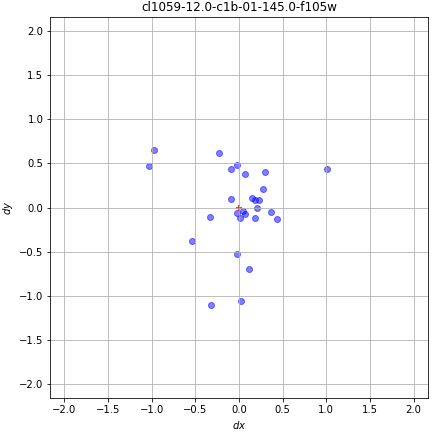

In [14]:
# Show the alignment w.r.t the external NOAO Source Catalog (NSC)
Image(filename = "./cl1059-12.0-c1b-01-145.0-f105w_wcs.png") 


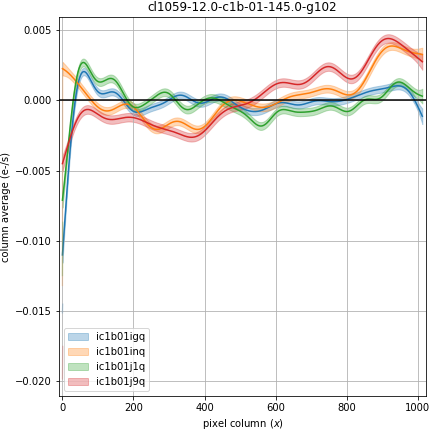

In [15]:
# Show the alignment of one HST visit to another, note tight 
# plot range compared to previous
Image(filename = "./cl1059-12.0-c1b-01-145.0-g102_column.png") 

In [16]:
# Check wcs.log files that a few objects were found, no large rotations
# and rms (second to last column) isn't too large

# Here, the F098M/G102 visit was the first processed and was aligned 
# to the NSC, with RMS~0.8 WFC3/IR pix.  Subsequent visits are aligned to 
# previously processed HST visits so that at least the relative HST astrometry
# is as good as possible.  Here, the F140W/G141 visit was run second and was 
# therefore aligned to F098M, resulting in much better precision than with the
# external catalog (RMS < 0.1 pix).

# Cat wcs.log files in order they were generated
!grep " 0 " `ls -ltr *wcs.log | awk '{print $9}'` | sed "s/  */ /g"

# columns: 
# "visit"  0  xshift yshift rot scale rms N

 0 1.2914 2.5195 0.0258 0.99965 0.308 27


### Alignment failures ###

The main failure mode of the `auto_script.preprocess` script is failure to compute a reliable alignment to the external reference.  This can happen, e.g., if there are not enough alignment sources (i.e., zero) within the field of view or if the original astrometry of the exposures obtained from the archive is offset from the reference by more than ~10 pixels.  This can almost always be remedied by running `grizli.pipeline.auto_script.manual_alignment` after the files have been fetched, which prompts the user to interactively mark sources in the image and reference catalog using DS9.

In [17]:
if False: # Don't run
    catalogs = ['PS1','SDSS','GAIA','WISE']
    auto_script.manual_alignment(field_root=root, HOME_PATH=HOME_PATH, skip=True, 
                                 catalogs=catalogs, radius=15, visit_list=None)

### Grism sky subtraction ###

The grism sky backgrounds are subtracted using the "Master sky" images from [Brammer, Ryan, & Pirzkal 2015](http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2015-17.pdf) (available [here](http://www.stsci.edu/hst/wfc3/analysis/grism_obs/calibrations/wfc3_grism_master_sky.html)).  

`Grizli` ignores any wavelength dependence of the flat-field and applies a grey correction using the F140W (F105W) flat-field for the G141 (G102) grisms.

Residuals after subtracting the master sky images are typically of order 0.005 e-/s, just 0.5-1% overall background level.  They are removed by subtracting a column-average of the sky pixels in the grism exposures, and the processing script produces a diagnostic figure like the one shown below.  The source of the residuals is still unclear (e.g., perhaps spectra of objects near/below the detection limit).  Though they are usually well removed by the column average, they do make extracting continuum spectra of faint sources challenging.

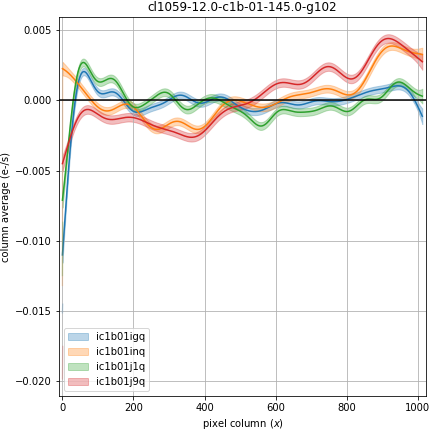

In [18]:
from IPython.display import Image
Image(filename = "./cl1059-12.0-c1b-01-145.0-g102_column.png", width=600, height=600)

### Fine alignment to GAIA DR2 ###

The initial visit alignment scripts often show small drifts such that the differen't visits don't perfectly overlap.  The script below performs an additional realignment to the visits internally and also to an external reference, usually GAIA DR2.

In [19]:
# Fine alignment of the visits relative to each other and absolute to GAIA DR2
if len(glob.glob('{0}*fine.png'.format(root))) == 0:
    fine_catalogs = ['GAIA','PS1','SDSS','WISE']
    out = auto_script.fine_alignment(field_root=root, HOME_PATH=HOME_PATH, 
                                     min_overlap=0.2, stopme=False, ref_err=0.08, 
                                     catalogs=fine_catalogs, NITER=1, maglim=[17,23],
                                     shift_only=True, method='Powell', redrizzle=False, 
                                     radius=10, program_str=None, match_str=[], 
                                     gaia_by_date=True)

    # Update headers with the result from the fine alignment
    # Original FLTs are archived to FineBkup
    auto_script.update_wcs_headers_with_fine(root)
    
visits, res = np.load('{0}_fine.npy'.format(root))
shifts = res.x.reshape((-1,2))/10.
for i, visit in enumerate(visits):
    print('{0:35}  {1:6.2f}  {2:6.2f}'.format(visit['product'], shifts[i,0], shifts[i,1]))

cl1059-12.0-c1b-01-145.0-f105w         0.11    0.12


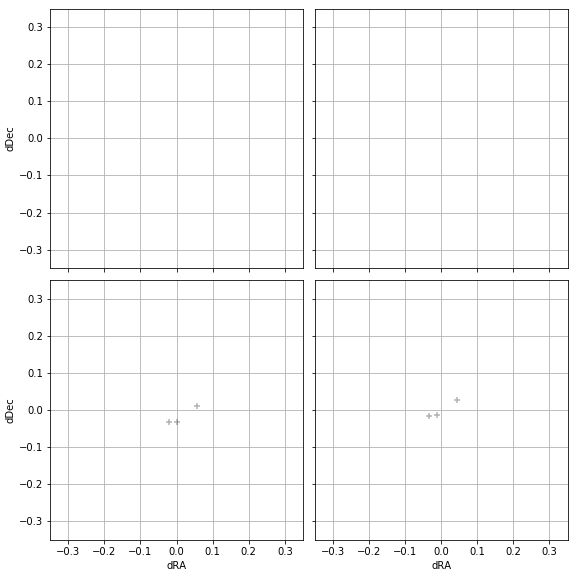

In [20]:
# Show the results of fine alignment.  
# Top panels are alignment between the visits.  + in the bottom panels are 
# residuals of the external reference, here GAIA DR2.
#
# Small drift between individual visits removed.  
# Fairly large GAIA offsets probably due to ~6 years between 
# WFC3/ERS and GAIA epoch 2015.5.
Image(filename='{0}_fine.png'.format(root))

## Make combined mosaics for each available filter ##

These are used to generate a photometric catalog and also for the direct image reference for the grism

In [21]:
# Drizzle mosaics in each filter and combine all IR filters
combine_all_filters=True
if len(glob.glob('{0}-ir_dr?_sci.fits'.format(root))) == 0:

    ## Mosaic WCS
    wcs_ref_file = '{0}_wcs-ref.fits'.format(root)
    if not os.path.exists(wcs_ref_file):
        auto_script.make_reference_wcs(info, output=wcs_ref_file, 
                           filters=['G800L', 'G102', 'G141'], 
                           pad_reference=90, pixel_scale=None,
                           get_hdu=True)

    # All combined
    IR_filters = ['F105W', 'F110W', 'F125W', 'F140W', 'F160W', 
                  'F098M', 'F139M', 'F127M', 'F153M']

    optical_filters = ['F814W', 'F606W', 'F435W', 'F850LP', 'F702W', 'F555W', 'F438W', 'F475W', 'F625W', 'F775W', 'F225W', 'F275W', 'F300W', 'F390W']

    if combine_all_filters:
        auto_script.drizzle_overlaps(root, 
                                 filters=IR_filters+optical_filters, 
                                 min_nexp=1, 
                                 make_combined=True,
                                 ref_image=wcs_ref_file,
                                 drizzle_filters=False) 

    ## IR filters
    auto_script.drizzle_overlaps(root, filters=IR_filters, 
                                 min_nexp=1, 
                                 make_combined=(not combine_all_filters),
                                 ref_image=wcs_ref_file) 

    # Fill IR filter mosaics with scaled combined data so they can be used 
    # as grism reference
    auto_script.fill_filter_mosaics(root)

    ## Optical filters

    mosaics = glob.glob('{0}-ir_dr?_sci.fits'.format(root))

    auto_script.drizzle_overlaps(root, filters=optical_filters,
        make_combined=(len(mosaics) == 0), ref_image=wcs_ref_file,
        min_nexp=2) 

In [22]:
!ls -1 j*_dr?_sci.fits

j105908m1246-f105w_drz_sci.fits
j105908m1246-ir_drz_sci.fits


## Generate a photometric catalog ##

Run source detection on the combined mosaic `{root}-ir_dr[cz]_sci.fits` and generates a catalog and segmentation image.  

Then perform simple matched-aperture photometry on the different available filter mosaics (in this case F098M and F140W from the direct imaging).  In principle the template fitting code shown below can incorporate this photometric information, though that's not currently done by default.

In [23]:
## Run SEP (~SExtractor clone) catalog on the "ir" combined image
## and generate a photometric catalog with aperture photometry in all available bands
if not os.path.exists('{0}_phot.fits'.format(root)):
    get_background=False # SExtractor background subtraction
    tab = auto_script.multiband_catalog(field_root=root, threshold=1.8,
                                        detection_background=get_background,
                                        photometry_background=get_background) 
    
files = glob.glob('{0}-ir*'.format(root)) + glob.glob('*phot*fits')
for file in files:
    print(file)
    
phot = utils.GTable.gread('{0}_phot.fits'.format(root))
print('{0}Metadata{0}'.format('\n'+'='*20+'\n'))
for k in phot.meta:
    print('{0}:\t{1}'.format(k, phot.meta[k]))

j105908m1246-ir_seg.fits
j105908m1246-ir.cat.fits
j105908m1246-ir_bkg.fits
j105908m1246-ir_drz_wht.fits
j105908m1246-ir_drz_sci.fits
j105908m1246_phot.fits

Metadata

MINAREA:	5
CLEAN:	True
DEBCONT:	0.005
DEBTHRSH:	32
FILTER_TYPE:	conv
THRESHOLD:	1.8
ZP:	26.26887001774306
PLAM:	10551.047
FNU:	1.1283712e-07
FLAM:	3.0386574e-20
UJY2DN:	8.861796202091552
DRZ_FILE:	j105908m1246-ir_drz_sci.fits
WHT_FILE:	j105908m1246-ir_drz_wht.fits
GET_BACK:	False
ERR_SCALE:	0.509738028049469
APER_0:	6.00000000000013
ASEC_0:	0.36
APER_1:	8.33500000000018
ASEC_1:	0.5001
APER_2:	16.33700000000036
ASEC_2:	0.9802200000000001
APER_3:	20.00000000000043
ASEC_3:	1.2
F105W_ZP:	26.26887001774306
F105W_PLAM:	10551.047
F105W_FNU:	1.1283712e-07
F105W_FLAM:	3.0386574e-20
F105W_uJy2dn:	8.861796202091552
F105W_DRZ_FILE:	j105908m1246-f105w_drz_sci.fits
F105W_WHT_FILE:	j105908m1246-f105w_drz_wht.fits
F105W_GET_BACK:	False
F105W_ERR_SCALE:	0.509738028049469
F105W_aper_0:	6.00000000000013
F105W_asec_0:	0.36
F105W_aper_1:	8.33

In [24]:
phot[:2].show_in_notebook()

## Building the grism exposure container: `multifit.GroupFLT` ##

With the preprocessing done, we can now start on the analysis of the spectra.  `Grizli` is built around low-level tools for modeling and analyzing each individual grism exposure individually.  Though once multiple exposures are available (e.g., exposures within a visit or separate visits with different grisms and/or orients) the information from each can be combined for analyzing the spectrum of a given object.  A benefit of the exposure-level processing is that all of the model-to-data comparisons (i.e. chi-squared) are done in the space of the original detector pixels, with their well-calibrated and well-understood noise properties.

The `GroupFLT` class provides a container for processing multiple FLT exposures simultanously.

### Inputs ###
* `grism_files` = list of grism exposure filenames
* `direct_files` = (optional) list of direct exposure filenames
* `ref_file` = (optional) reference direct image mosaic (one or the other of `ref_file` or `direct_files` should be specified.)
* `seg_file`, `catalog` = segmentation image and catalog, usually generated with SExtractor
* `cpu_count` = set to > 0 for parallel processing
* `pad` parameter (default=200 pixels).  If set, then add padding around the FLTs to enable modeling of objects that would fall off of the direct image but that still disperse spectra onto the grism exposure (assuming they fall in the `ref_file` and `seg_file` mosaics).

The contents of the `grism_files` list can contain pretty much anything, with the result limited by memory / cpu power.  For example, you can provide a list of **all** 112 of the 3D-HST G141 exposures in the COSMOS field (4 exposures x 28 pointings), along with the field mosaic and segmentation images.  This example is actually fairly easy to process as individual objects will fall in typically 4, perhaps 8 individual exposures in some overlap areas.  Another example is a list of exposures from multiple instruments / grisms / orients of a single field, thought the subsequent fits can be slow if an object has spectra in many individual exposures.

Reference images are blotted to the distorted exposure frame with `AstroDrizzle.ablot`.   Messages go by, as below, when you load the `GroupFLT` object talking about "cutouts" because the script tries to make smaller cutouts of large reference images to speed up the blot processing.

**NB** Seems to often have memory leak problems if `seg_file` isn't significantly larger than the footprint of a given FLT file.  Drizzle `blot` segfaults out but the script just hangs since the multiprocessing threads don't get the message.

### Flat continuum model ###

Once the `GroupFLT` object is initialized, compute a first-pass model of the full detector field of view assuming simple linear continua for all objects in the field (brighter than `mag_limit`).  By default this assumes a somewhat blue continuum suitable for the Rayleigh-Jeans tail of low-redshift objects.  It's far from perfect but the initial model does provide a good way of at least identifying which pixels of a given object could be contaminated by neighbors, even if the quantitative model is not precise.

### Refined polynomial continuum model ###

After computing the simple continuum model, refine the model spectra for brighter objects using higher-order polynomials fit directly to the spectra themselves.  The `refine_list` method marches through objects starting with the brightest and fits a polynomial of order `poly_order` to the observed spectrum after subtracting off the model for contaminants.  Note that if the list of grism exposures contained multiple orientations covering a single field, this fit can be well constrained even in the presence of contamination.

The `grism_prep` script iterates on the refined polynomial model `refine_niter` times.

### Save state ###

You can optionally dump saved data (i.e., `grp.save_full_data()`) for fast restart and avoid recomputing the contamination models, for example in a new Python session.  This can be done at any time after you've made changes to the GroupFLT data that you'd like to store for later.  The `grism_prep` script does this automatically.

In [25]:
files = glob.glob('*GrismFLT.fits')
if len(files) == 0:
    ### Grism contamination model
    os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

    # Which filter to use as direct image?  Will try in order of the list until a match is found.
    gris_ref = {'G141': ['F140W', 'F160W'], 
                'G102': ['F105W', 'F098M', 'F110W']}

    x = auto_script.grism_prep(field_root=root, refine_niter=3,
                                 gris_ref_filters=gris_ref)

    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)
    
else:
    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)

Load ic1b01j9q.01.GrismFLT.fits!
Load ic1b01inq.01.GrismFLT.fits!
Load ic1b01j1q.01.GrismFLT.fits!
Load ic1b01igq.01.GrismFLT.fits!
Files loaded - 0.75 sec.


### The final contamination model ###

IndexError: list index out of range

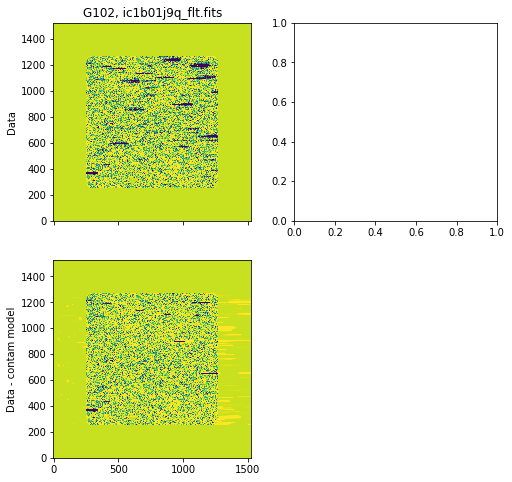

In [26]:
# Show the results of the contamination model
### Show FLT residuals
cmap = 'viridis_r'
vm = [-0.01, 0.1]

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(221)
flt = grp.FLTs[0] # G102

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([])
ax.set_ylabel('Data')

ax = fig.add_subplot(223)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_ylabel('Data - contam model')

ax = fig.add_subplot(222)
flt = grp.FLTs[4] # G141

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([]); ax.set_yticklabels([])

ax = fig.add_subplot(224)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_yticklabels([])

for ax in fig.axes:
    ax.set_xlim(510,790); ax.set_ylim(610,890)

fig.tight_layout(pad=1)

### Parameters for object fitting

In [27]:
h = open('/data2/jrcooper/notebooks/reduction/EDisCS/j105908m1246/Extractions/a_LDP_q.txt', 'r')
lines = h.readlines()[1:]
h.close()   
z_LDP       = []  
id_HST      = []   
ra_HST      = []
dec_HST     = [] 

for line in lines: 
    a = line.split()     
    z_LDP.append(float(a[3]))
    ra_HST.append(float(a[1]))
    dec_HST.append(float(a[2]))



z_LDP     = np.array(z_LDP)
ra_HST    = np.array(ra_HST)
dec_HST   = np.array(dec_HST)
id_HST     = np.array(id_HST) 


In [28]:
#### Store fit parameters to `fit_args.npy` for batch-mode processing

# Drizzle parameters for line maps
pline = auto_script.DITHERED_PLINE
#print(pline) 

sig = 0.007 
z = np.arange(0,2,.001)
for i in z_LDP:
    p_z = np.exp(-(z - i)**2/(2*sig**2))/((2*np.pi)**0.5/sig)

spec_prior = [z,p_z]
tuple
a = tuple(spec_prior)

# Generate the parameter dictionary
args = auto_script.generate_fit_params(field_root=root, prior=a, 
                                       MW_EBV=tabs[0].meta['MW_EBV'], 
                                pline=pline, fit_only_beams=True, run_fit=True, poly_order=7, 
                                fsps=True, sys_err = 0.03, fcontam=0.2, zr=[0.05, 3.4], 
                                save_file='fit_args.npy')

Saved arguments to fit_args.npy.


### Field PSF file ### 
Make an average effective PSF for each available IR filter by evaluating the field-dependent PSF across the final mosaic and drizzling to a common output.  Also make an extension with a PSF on the pixel grid of the drizzled line map parameters generated above (`pline`).  Each PSF is generated with the native pixel grid and 2/4x oversampling for use with, e.g., [GALFIT](https://users.obs.carnegiescience.edu/peng/work/galfit/galfit.html).

*NB* There is currently no ePSF for F098M, so F105W is used (http://www.stsci.edu/~jayander/STDPSFs/WFC3IR/).


In [29]:
# Make PSF file
if not os.path.exists('{0}-f140w_psf.fits'.format(root)):
    auto_script.field_psf(root=root, HOME_PATH=HOME_PATH)

 
j105908m1246 LINE1  / 0.100" / pixf: 0.2 / point    / f105w
j105908m1246 LINE2  / 0.050" / pixf: 0.2 / point    / f105w
j105908m1246 LINE4  / 0.025" / pixf: 0.2 / point    / f105w
j105908m1246 DRIZ1  / 0.060" / pixf: 0.6 / square   / f105w
j105908m1246 DRIZ2  / 0.030" / pixf: 0.6 / square   / f105w
j105908m1246 DRIZ4  / 0.015" / pixf: 0.6 / square   / f105w


['j105908m1246-f105w_psf.fits'] 

Filename: j105908m1246-f105w_psf.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  PSF         LINE1 ImageHDU        29   (60, 60)   float32   
  2  PSF         LINE2 ImageHDU        29   (120, 120)   float32   
  3  PSF         LINE4 ImageHDU        29   (240, 240)   float32   
  4  PSF         DRIZ1 ImageHDU        29   (100, 100)   float32   
  5  PSF         DRIZ2 ImageHDU        29   (200, 200)   float32   
  6  PSF         DRIZ4 ImageHDU        29   (400, 400)   float32   


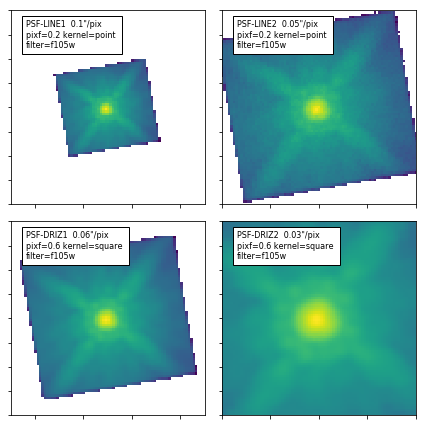

In [30]:
# Show the PSFs
print(glob.glob('*psf.fits'),'\n')

im = pyfits.open('{0}-f105w_psf.fits'.format(root))
im.info()

fig = plt.figure(figsize=[6,6])
for i, ext in enumerate([1,2,4,5]):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(np.log10(im[ext].data))
    
    h = im[ext].header
    label = '{0}-{1}  {2}"/pix \npixf={3} kernel={4} \nfilter={5}'.format(h['EXTNAME'],
                     h['EXTVER'], h['PSCALE'], h['PIXFRAC'], h['KERNEL'], h['FILTER'])
    
    ax.text(0.08, 0.95, label, ha='left', va='top', 
            transform=ax.transAxes, size=8, color='k',
            bbox={'fc':'w'})
    
    ax.set_xticklabels([]); ax.set_yticklabels([])
    
    sh = im[ext].data.shape
    ax.set_xlim(sh[1]/2-40, sh[1]/2+40)
    ax.set_ylim(sh[0]/2-40, sh[0]/2+40)
    
fig.tight_layout(pad=1)

## Extract and fit individual spectra ##

In [31]:
os.chdir('../Extractions')

In [32]:
### Find IDs of specific objects to extract
import grizli.pipeline
from grizli.pipeline import auto_script
import astropy.units as u
tab = utils.GTable()
tab['ra'] = ra_HST
tab['dec'] = dec_HST
idx, dr = grp.catalog.match_to_catalog_sky(tab)
source_ids = grp.catalog['NUMBER'][idx]
tab['id'] = source_ids
tab['dr'] = dr.to(u.mas)
tab['dr'].format='.1f'
tab.show_in_notebook()

### Extract 2D spectra "beams" ###

The `GroupFLT` object contains the entire exposure information, from which we can make cutouts of spectra for individual objects with the `get_beams` method.  These cutouts are more managable and portable than the entire exposures, though currently the processing does work in the paradigm of having a static contamination model for a given object.  

In pipeline mode, the function below is called with `ids=[], maglim=[mag_min, mag_max]` and all objects in the reference catalog with `mag_min < MAG_AUTO < mag_max` are extracted.  The redshift fits are performed if `run_fit=True`.

In [33]:
for id_i in source_ids:
    auto_script.extract(field_root=root, prior=a, MW_EBV=tabs[0].meta['MW_EBV'], 
                                pline=pline, fit_only_beams=True, run_fit=True, poly_order=7, 
                           grp=grp, diff=True)

0/165: 21 4
j105908m1246_00021.beams.fits
1/165: 256 4
j105908m1246_00256.beams.fits
2/165: 20 4
j105908m1246_00020.beams.fits
3/165: 160 4
j105908m1246_00160.beams.fits
4/165: 98 4
j105908m1246_00098.beams.fits
5/165: 427 0
6/165: 84 4
j105908m1246_00084.beams.fits
7/165: 363 4
j105908m1246_00363.beams.fits
8/165: 17 4
j105908m1246_00017.beams.fits
9/165: 116 4
j105908m1246_00116.beams.fits
10/165: 66 4
j105908m1246_00066.beams.fits
11/165: 466 2
j105908m1246_00466.beams.fits
12/165: 56 4
j105908m1246_00056.beams.fits
13/165: 271 4
j105908m1246_00271.beams.fits
14/165: 91 0
15/165: 315 4
j105908m1246_00315.beams.fits
16/165: 85 4
j105908m1246_00085.beams.fits
17/165: 169 4
j105908m1246_00169.beams.fits
18/165: 406 4
j105908m1246_00406.beams.fits
19/165: 80 4
j105908m1246_00080.beams.fits
20/165: 454 4
j105908m1246_00454.beams.fits
21/165: 124 4
j105908m1246_00124.beams.fits
22/165: 360 4
j105908m1246_00360.beams.fits
23/165: 222 4
j105908m1246_00222.beams.fits
24/165: 191 4
j105908m12

  0.2108  882835.9 (0.2012) 25/341
  0.2157  883196.6 (0.2012) 26/341
  0.2206  883600.0 (0.2012) 27/341
  0.2255  884077.1 (0.2012) 28/341
  0.2304  884424.0 (0.2012) 29/341
  0.2353  884777.1 (0.2012) 30/341
  0.2402  884915.7 (0.2012) 31/341
  0.2452  885081.0 (0.2012) 32/341
  0.2502  885309.5 (0.2012) 33/341
  0.2552  885392.4 (0.2012) 34/341
  0.2603  885398.2 (0.2012) 35/341
  0.2653  885296.7 (0.2012) 36/341
  0.2704  885178.6 (0.2012) 37/341
  0.2755  885256.3 (0.2012) 38/341
  0.2806  885431.0 (0.2012) 39/341
  0.2857  885415.9 (0.2012) 40/341
  0.2909  885407.7 (0.2012) 41/341
  0.2960  885380.9 (0.2012) 42/341
  0.3012  885251.8 (0.2012) 43/341
  0.3064  885131.8 (0.2012) 44/341
  0.3117  885044.4 (0.2012) 45/341
  0.3169  884824.1 (0.2012) 46/341
  0.3222  884571.2 (0.2012) 47/341
  0.3275  884393.3 (0.2012) 48/341
  0.3328  884205.5 (0.2012) 49/341
  0.3382  884120.9 (0.2012) 50/341
  0.3435  884027.8 (0.2012) 51/341
  0.3489  883899.8 (0.2012) 52/341
  0.3543  883599.7 (

  1.5685  892390.3 (1.0367) 213/341
  1.5788  892521.2 (1.0367) 214/341
  1.5891  892512.2 (1.0367) 215/341
  1.5995  892426.7 (1.0367) 216/341
  1.6099  892375.6 (1.0367) 217/341
  1.6204  892355.7 (1.0367) 218/341
  1.6309  892246.7 (1.0367) 219/341
  1.6414  892074.3 (1.0367) 220/341
  1.6520  892095.5 (1.0367) 221/341
  1.6626  892330.0 (1.0367) 222/341
  1.6733  892507.4 (1.0367) 223/341
  1.6840  892388.2 (1.0367) 224/341
  1.6948  892050.9 (1.0367) 225/341
  1.7056  891707.3 (1.0367) 226/341
  1.7164  891445.0 (1.0367) 227/341
  1.7273  891073.5 (1.0367) 228/341
  1.7382  890795.6 (1.0367) 229/341
  1.7492  890618.0 (1.0367) 230/341
  1.7602  890263.8 (1.0367) 231/341
  1.7713  889754.1 (1.0367) 232/341
  1.7824  889207.9 (1.0367) 233/341
  1.7935  888976.8 (1.0367) 234/341
  1.8047  889026.1 (1.0367) 235/341
  1.8160  889193.5 (1.0367) 236/341
  1.8273  889287.1 (1.0367) 237/341
  1.8386  889256.7 (1.0367) 238/341
  1.8500  889119.3 (1.0367) 239/341
  1.8614  888789.6 (1.0367) 

  0.1869  490158.9 (0.1869) 20/341
  0.1916  489956.3 (0.1916) 21/341
  0.1964  490076.1 (0.1916) 22/341
  0.2012  490395.1 (0.1916) 23/341
  0.2060  490466.6 (0.1916) 24/341
  0.2108  490471.6 (0.1916) 25/341
  0.2157  490523.1 (0.1916) 26/341
  0.2206  490553.8 (0.1916) 27/341
  0.2255  490527.4 (0.1916) 28/341
  0.2304  490446.6 (0.1916) 29/341
  0.2353  490252.6 (0.1916) 30/341
  0.2402  490212.7 (0.1916) 31/341
  0.2452  490232.1 (0.1916) 32/341
  0.2502  490300.2 (0.1916) 33/341
  0.2552  490323.2 (0.1916) 34/341
  0.2603  490399.9 (0.1916) 35/341
  0.2653  490497.1 (0.1916) 36/341
  0.2704  490613.1 (0.1916) 37/341
  0.2755  490746.8 (0.1916) 38/341
  0.2806  490780.7 (0.1916) 39/341
  0.2857  490694.8 (0.1916) 40/341
  0.2909  490739.1 (0.1916) 41/341
  0.2960  490819.5 (0.1916) 42/341
  0.3012  490807.3 (0.1916) 43/341
  0.3064  490793.5 (0.1916) 44/341
  0.3117  490723.2 (0.1916) 45/341
  0.3169  490608.7 (0.1916) 46/341
  0.3222  490497.9 (0.1916) 47/341
  0.3275  490461.8 (

  1.5685  491398.2 (1.4383) 213/341
  1.5788  491929.2 (1.4383) 214/341
  1.5891  492319.0 (1.4383) 215/341
  1.5995  492625.0 (1.4383) 216/341
  1.6099  492616.3 (1.4383) 217/341
  1.6204  492476.9 (1.4383) 218/341
  1.6309  492627.0 (1.4383) 219/341
  1.6414  492461.4 (1.4383) 220/341
  1.6520  492489.3 (1.4383) 221/341
  1.6626  492700.7 (1.4383) 222/341
  1.6733  492784.7 (1.4383) 223/341
  1.6840  492921.7 (1.4383) 224/341
  1.6948  492912.3 (1.4383) 225/341
  1.7056  492717.3 (1.4383) 226/341
  1.7164  492785.6 (1.4383) 227/341
  1.7273  492959.3 (1.4383) 228/341
  1.7382  493343.2 (1.4383) 229/341
  1.7492  493547.2 (1.4383) 230/341
  1.7602  493998.0 (1.4383) 231/341
  1.7713  494420.5 (1.4383) 232/341
  1.7824  494802.5 (1.4383) 233/341
  1.7935  494612.2 (1.4383) 234/341
  1.8047  493916.6 (1.4383) 235/341
  1.8160  493484.8 (1.4383) 236/341
  1.8273  493055.8 (1.4383) 237/341
  1.8386  492749.6 (1.4383) 238/341
  1.8500  492775.7 (1.4383) 239/341
  1.8614  492928.8 (1.4383) 

  0.2012   17309.9 (0.1000) 23/341
  0.2060   17308.4 (0.1000) 24/341
  0.2108   17276.8 (0.1000) 25/341
  0.2157   17270.5 (0.1000) 26/341
  0.2206   17287.2 (0.1000) 27/341
  0.2255   17286.8 (0.1000) 28/341
  0.2304   17257.7 (0.1000) 29/341
  0.2353   17289.4 (0.1000) 30/341
  0.2402   17314.5 (0.1000) 31/341
  0.2452   17338.3 (0.1000) 32/341
  0.2502   17310.1 (0.1000) 33/341
  0.2552   17276.6 (0.1000) 34/341
  0.2603   17288.5 (0.1000) 35/341
  0.2653   17322.0 (0.1000) 36/341
  0.2704   17346.7 (0.1000) 37/341
  0.2755   17355.9 (0.1000) 38/341
  0.2806   17334.1 (0.1000) 39/341
  0.2857   17318.2 (0.1000) 40/341
  0.2909   17332.4 (0.1000) 41/341
  0.2960   17359.0 (0.1000) 42/341
  0.3012   17205.4 (0.1000) 43/341
  0.3064   16762.5 (0.3064) 44/341
  0.3117   16588.6 (0.3117) 45/341
  0.3169   16586.0 (0.3169) 46/341
  0.3222   16776.5 (0.3169) 47/341
  0.3275   16623.4 (0.3169) 48/341
  0.3328   16751.4 (0.3169) 49/341
  0.3382   16626.8 (0.3169) 50/341
  0.3435   16490.7 (

  1.5891   17071.7 (1.3427) 215/341
  1.5995   17110.0 (1.3427) 216/341
  1.6099   17130.8 (1.3427) 217/341
  1.6204   17138.9 (1.3427) 218/341
  1.6309   17123.8 (1.3427) 219/341
  1.6414   17271.6 (1.3427) 220/341
  1.6520   17290.7 (1.3427) 221/341
  1.6626   17160.3 (1.3427) 222/341
  1.6733   17145.8 (1.3427) 223/341
  1.6840   17198.0 (1.3427) 224/341
  1.6948   17190.6 (1.3427) 225/341
  1.7056   17214.6 (1.3427) 226/341
  1.7164   17270.7 (1.3427) 227/341
  1.7273   17301.4 (1.3427) 228/341
  1.7382   17340.5 (1.3427) 229/341
  1.7492   17354.9 (1.3427) 230/341
  1.7602   17368.0 (1.3427) 231/341
  1.7713   17401.8 (1.3427) 232/341
  1.7824   17428.7 (1.3427) 233/341
  1.7935   17460.5 (1.3427) 234/341
  1.8047   17509.0 (1.3427) 235/341
  1.8160   17409.5 (1.3427) 236/341
  1.8273   17388.7 (1.3427) 237/341
  1.8386   17417.4 (1.3427) 238/341
  1.8500   17456.1 (1.3427) 239/341
  1.8614   17487.4 (1.3427) 240/341
  1.8729   17485.8 (1.3427) 241/341
  1.8844   17497.1 (1.3427) 

  0.1964  395016.9 (0.1821) 22/341
  0.2012  395110.6 (0.1821) 23/341
  0.2060  395178.3 (0.1821) 24/341
  0.2108  395314.5 (0.1821) 25/341
  0.2157  395466.1 (0.1821) 26/341
  0.2206  395527.6 (0.1821) 27/341
  0.2255  395488.7 (0.1821) 28/341
  0.2304  395469.3 (0.1821) 29/341
  0.2353  395454.4 (0.1821) 30/341
  0.2402  395318.5 (0.1821) 31/341
  0.2452  395287.0 (0.1821) 32/341
  0.2502  395304.3 (0.1821) 33/341
  0.2552  395223.1 (0.1821) 34/341
  0.2603  395150.2 (0.1821) 35/341
  0.2653  395177.6 (0.1821) 36/341
  0.2704  395145.1 (0.1821) 37/341
  0.2755  395020.9 (0.1821) 38/341
  0.2806  394939.3 (0.1821) 39/341
  0.2857  394875.2 (0.2857) 40/341
  0.2909  394709.9 (0.2909) 41/341
  0.2960  394633.9 (0.2960) 42/341
  0.3012  394614.9 (0.3012) 43/341
  0.3064  394602.5 (0.3064) 44/341
  0.3117  394732.6 (0.3064) 45/341
  0.3169  394876.2 (0.3064) 46/341
  0.3222  394982.5 (0.3064) 47/341
  0.3275  395078.4 (0.3064) 48/341
  0.3328  395139.7 (0.3064) 49/341
  0.3382  395128.6 (

  1.5378  395019.4 (0.3064) 210/341
  1.5480  395231.9 (0.3064) 211/341
  1.5582  395551.8 (0.3064) 212/341
  1.5685  396025.8 (0.3064) 213/341
  1.5788  396466.8 (0.3064) 214/341
  1.5891  396735.8 (0.3064) 215/341
  1.5995  396902.1 (0.3064) 216/341
  1.6099  397030.7 (0.3064) 217/341
  1.6204  397188.1 (0.3064) 218/341
  1.6309  397118.1 (0.3064) 219/341
  1.6414  396899.2 (0.3064) 220/341
  1.6520  397152.9 (0.3064) 221/341
  1.6626  397229.6 (0.3064) 222/341
  1.6733  397391.4 (0.3064) 223/341
  1.6840  397441.9 (0.3064) 224/341
  1.6948  397653.0 (0.3064) 225/341
  1.7056  397764.2 (0.3064) 226/341
  1.7164  397830.3 (0.3064) 227/341
  1.7273  398000.9 (0.3064) 228/341
  1.7382  398539.2 (0.3064) 229/341
  1.7492  399148.8 (0.3064) 230/341
  1.7602  399625.7 (0.3064) 231/341
  1.7713  400304.2 (0.3064) 232/341
  1.7824  400613.8 (0.3064) 233/341
  1.7935  400740.4 (0.3064) 234/341
  1.8047  400853.8 (0.3064) 235/341
  1.8160  401066.9 (0.3064) 236/341
  1.8273  401190.2 (0.3064) 

  0.1821    2421.5 (0.1088) 19/341
  0.1869    2417.5 (0.1088) 20/341
  0.1916    2405.3 (0.1916) 21/341
  0.1964    2398.4 (0.1964) 22/341
  0.2012    2399.7 (0.1964) 23/341
  0.2060    2403.6 (0.1964) 24/341
  0.2108    2409.3 (0.1964) 25/341
  0.2157    2412.7 (0.1964) 26/341
  0.2206    2413.2 (0.1964) 27/341
  0.2255    2413.1 (0.1964) 28/341
  0.2304    2414.7 (0.1964) 29/341
  0.2353    2415.8 (0.1964) 30/341
  0.2402    2412.8 (0.1964) 31/341
  0.2452    2415.2 (0.1964) 32/341
  0.2502    2424.6 (0.1964) 33/341
  0.2552    2430.5 (0.1964) 34/341
  0.2603    2427.6 (0.1964) 35/341
  0.2653    2417.7 (0.1964) 36/341
  0.2704    2411.9 (0.1964) 37/341
  0.2755    2412.5 (0.1964) 38/341
  0.2806    2411.3 (0.1964) 39/341
  0.2857    2411.6 (0.1964) 40/341
  0.2909    2400.7 (0.1964) 41/341
  0.2960    2393.0 (0.2960) 42/341
  0.3012    2393.0 (0.3012) 43/341
  0.3064    2400.3 (0.3012) 44/341
  0.3117    2409.9 (0.3012) 45/341
  0.3169    2415.7 (0.3012) 46/341
  0.3222    2419.9 (

  1.5378    2402.3 (1.5277) 210/341
  1.5480    2407.9 (1.5277) 211/341
  1.5582    2417.4 (1.5277) 212/341
  1.5685    2423.6 (1.5277) 213/341
  1.5788    2426.6 (1.5277) 214/341
  1.5891    2429.1 (1.5277) 215/341
  1.5995    2430.3 (1.5277) 216/341
  1.6099    2429.2 (1.5277) 217/341
  1.6204    2426.1 (1.5277) 218/341
  1.6309    2423.6 (1.5277) 219/341
  1.6414    2422.0 (1.5277) 220/341
  1.6520    2420.2 (1.5277) 221/341
  1.6626    2419.0 (1.5277) 222/341
  1.6733    2418.0 (1.5277) 223/341
  1.6840    2417.5 (1.5277) 224/341
  1.6948    2417.4 (1.5277) 225/341
  1.7056    2417.6 (1.5277) 226/341
  1.7164    2417.4 (1.5277) 227/341
  1.7273    2415.5 (1.5277) 228/341
  1.7382    2415.7 (1.5277) 229/341
  1.7492    2419.5 (1.5277) 230/341
  1.7602    2422.2 (1.5277) 231/341
  1.7713    2424.7 (1.5277) 232/341
  1.7824    2427.3 (1.5277) 233/341
  1.7935    2429.9 (1.5277) 234/341
  1.8047    2431.7 (1.5277) 235/341
  1.8160    2428.3 (1.5277) 236/341
  1.8273    2425.7 (1.5277) 

- 0.3026    2394.6 (0.2966) 58/264
- 0.3031    2394.9 (0.2966) 59/264
- 0.3036    2396.0 (0.2966) 60/264
- 0.3041    2396.7 (0.2966) 61/264
- 0.3046    2396.9 (0.2966) 62/264
- 0.3051    2397.2 (0.2966) 63/264
- 0.3056    2398.0 (0.2966) 64/264
- 0.3061    2399.6 (0.2966) 65/264
- 0.3066    2400.5 (0.2966) 66/264
- 0.3614    2403.1 (0.2966) 67/264
- 0.3619    2402.1 (0.2966) 68/264
- 0.3624    2400.9 (0.2966) 69/264
- 0.3629    2400.4 (0.2966) 70/264
- 0.3634    2399.5 (0.2966) 71/264
- 0.3639    2398.4 (0.2966) 72/264
- 0.3644    2397.8 (0.2966) 73/264
- 0.3649    2397.3 (0.2966) 74/264
- 0.3654    2396.7 (0.2966) 75/264
- 0.3659    2396.3 (0.2966) 76/264
- 0.3664    2395.6 (0.2966) 77/264
- 0.3669    2394.8 (0.2966) 78/264
- 0.3674    2394.2 (0.2966) 79/264
- 0.3679    2394.0 (0.2966) 80/264
- 0.3684    2394.3 (0.2966) 81/264
- 0.3689    2394.5 (0.2966) 82/264
- 0.3694    2394.5 (0.2966) 83/264
- 0.3699    2394.5 (0.2966) 84/264
- 0.3704    2394.3 (0.2966) 85/264
- 0.3709    2393.9 (

- 2.6552    2389.5 (2.6552) 246/264
- 2.6557    2389.5 (2.6557) 247/264
- 2.6562    2389.5 (2.6557) 248/264
- 2.6567    2389.5 (2.6557) 249/264
- 2.6572    2389.6 (2.6557) 250/264
- 2.6577    2389.6 (2.6557) 251/264
- 2.6582    2389.7 (2.6557) 252/264
- 2.6587    2389.8 (2.6557) 253/264
- 2.6592    2390.0 (2.6557) 254/264
- 2.6597    2390.1 (2.6557) 255/264
- 2.6602    2390.3 (2.6557) 256/264
- 2.6607    2390.5 (2.6557) 257/264
- 2.6612    2390.7 (2.6557) 258/264
- 2.6617    2390.9 (2.6557) 259/264
- 2.6622    2391.2 (2.6557) 260/264
- 2.6627    2391.5 (2.6557) 261/264
- 2.6632    2391.7 (2.6557) 262/264
- 2.6637    2392.0 (2.6557) 263/264
- 2.6642    2392.4 (2.6557) 264/264
Get linemap PSF: F105W
5/165: 427
6/165: 84
1 ic1b01j9q_flt.fits G102
2 ic1b01inq_flt.fits G102
3 ic1b01j1q_flt.fits G102
4 ic1b01igq_flt.fits G102
User templates! N=17 

  0.1000   15008.0 (0.1000) 1/341
  0.1044   15009.5 (0.1000) 2/341
  0.1088   15026.0 (0.1000) 3/341
  0.1133   15025.4 (0.1000) 4/341
  0.1177 

  1.1368   15460.1 (0.3169) 167/341
  1.1454   15573.0 (0.3169) 168/341
  1.1540   15525.0 (0.3169) 169/341
  1.1626   15406.8 (0.3169) 170/341
  1.1713   15400.0 (0.3169) 171/341
  1.1800   15395.7 (0.3169) 172/341
  1.1887   15440.5 (0.3169) 173/341
  1.1975   15625.1 (0.3169) 174/341
  1.2063   15814.8 (0.3169) 175/341
  1.2151   15926.8 (0.3169) 176/341
  1.2240   15904.1 (0.3169) 177/341
  1.2329   15897.1 (0.3169) 178/341
  1.2419   15948.4 (0.3169) 179/341
  1.2509   16021.1 (0.3169) 180/341
  1.2599   16036.3 (0.3169) 181/341
  1.2689   16082.0 (0.3169) 182/341
  1.2780   16026.0 (0.3169) 183/341
  1.2872   15960.9 (0.3169) 184/341
  1.2963   16088.7 (0.3169) 185/341
  1.3055   16068.3 (0.3169) 186/341
  1.3148   16022.1 (0.3169) 187/341
  1.3240   16116.9 (0.3169) 188/341
  1.3334   16203.6 (0.3169) 189/341
  1.3427   16215.1 (0.3169) 190/341
  1.3521   16157.9 (0.3169) 191/341
  1.3615   16161.2 (0.3169) 192/341
  1.3710   16240.3 (0.3169) 193/341
  1.3805   16272.7 (0.3169) 

- 0.3157   14968.8 (0.3147) 14/99
- 0.3162   14970.3 (0.3147) 15/99
- 0.3167   14972.5 (0.3147) 16/99
- 0.3172   14974.4 (0.3147) 17/99
- 0.3177   14977.6 (0.3147) 18/99
- 0.3182   14981.4 (0.3147) 19/99
- 0.3187   14983.8 (0.3147) 20/99
- 0.3192   14984.8 (0.3147) 21/99
- 0.3197   14985.4 (0.3147) 22/99
- 0.3202   14984.7 (0.3147) 23/99
- 0.3207   14983.0 (0.3147) 24/99
- 0.3212   14981.0 (0.3147) 25/99
- 0.3217   14981.1 (0.3147) 26/99
- 0.3222   14981.7 (0.3147) 27/99
- 0.3227   14981.8 (0.3147) 28/99
- 0.3232   14982.8 (0.3147) 29/99
- 0.3237   14983.9 (0.3147) 30/99
- 0.3242   14985.4 (0.3147) 31/99
- 0.3247   14987.7 (0.3147) 32/99
- 0.3252   14992.4 (0.3147) 33/99
- 0.6759   15001.5 (0.3147) 34/99
- 0.6764   15002.1 (0.3147) 35/99
- 0.6769   15000.5 (0.3147) 36/99
- 0.6774   14999.4 (0.3147) 37/99
- 0.6779   14998.2 (0.3147) 38/99
- 0.6784   14994.3 (0.3147) 39/99
- 0.6789   14989.6 (0.3147) 40/99
- 0.6794   14982.5 (0.3147) 41/99
- 0.6799   14977.4 (0.3147) 42/99
- 0.6804   149

  0.6476   15540.0 (0.3762) 102/341
  0.6542   15540.1 (0.3762) 103/341
  0.6608   15548.9 (0.3762) 104/341
  0.6675   15550.5 (0.3762) 105/341
  0.6742   15544.6 (0.3762) 106/341
  0.6809   15542.3 (0.3762) 107/341
  0.6876   15545.0 (0.3762) 108/341
  0.6944   15553.3 (0.3762) 109/341
  0.7012   15559.3 (0.3762) 110/341
  0.7080   15563.9 (0.3762) 111/341
  0.7148   15571.0 (0.3762) 112/341
  0.7217   15580.5 (0.3762) 113/341
  0.7286   15534.0 (0.3762) 114/341
  0.7355   15517.3 (0.3762) 115/341
  0.7425   15557.6 (0.3762) 116/341
  0.7495   15575.3 (0.3762) 117/341
  0.7565   15580.6 (0.3762) 118/341
  0.7635   15571.6 (0.3762) 119/341
  0.7706   15540.6 (0.3762) 120/341
  0.7777   15436.8 (0.3762) 121/341
  0.7848   15101.1 (0.3762) 122/341
  0.7920   14479.1 (0.3762) 123/341
  0.7991   13968.4 (0.3762) 124/341
  0.8064   13379.8 (0.8064) 125/341
  0.8136   14337.1 (0.8064) 126/341
  0.8209   15202.3 (0.8064) 127/341
  0.8282   15479.1 (0.8064) 128/341
  0.8355   15510.9 (0.8064) 

  2.4949   15511.9 (0.8064) 290/341
  2.5089   15536.3 (0.8064) 291/341
  2.5230   15558.8 (0.8064) 292/341
  2.5371   15567.4 (0.8064) 293/341
  2.5513   15572.8 (0.8064) 294/341
  2.5655   15574.6 (0.8064) 295/341
  2.5798   15566.6 (0.8064) 296/341
  2.5942   15555.9 (0.8064) 297/341
  2.6086   15544.4 (0.8064) 298/341
  2.6230   15536.8 (0.8064) 299/341
  2.6375   15536.6 (0.8064) 300/341
  2.6521   15537.5 (0.8064) 301/341
  2.6668   15538.9 (0.8064) 302/341
  2.6815   15546.0 (0.8064) 303/341
  2.6962   15564.4 (0.8064) 304/341
  2.7110   15583.5 (0.8064) 305/341
  2.7259   15596.2 (0.8064) 306/341
  2.7408   15605.7 (0.8064) 307/341
  2.7558   15623.3 (0.8064) 308/341
  2.7709   15649.4 (0.8064) 309/341
  2.7860   15661.5 (0.8064) 310/341
  2.8012   15663.5 (0.8064) 311/341
  2.8164   15667.3 (0.8064) 312/341
  2.8317   15677.0 (0.8064) 313/341
  2.8471   15690.9 (0.8064) 314/341
  2.8625   15688.2 (0.8064) 315/341
  2.8780   15666.7 (0.8064) 316/341
  2.8935   15632.4 (0.8064) 

  0.6345   15058.2 (0.5209) 100/341
  0.6410   15039.9 (0.5209) 101/341
  0.6476   15013.9 (0.5209) 102/341
  0.6542   15002.1 (0.5209) 103/341
  0.6608   15012.5 (0.5209) 104/341
  0.6675   15020.0 (0.5209) 105/341
  0.6742   15034.6 (0.5209) 106/341
  0.6809   15064.3 (0.5209) 107/341
  0.6876   15090.5 (0.5209) 108/341
  0.6944   15109.7 (0.5209) 109/341
  0.7012   15118.5 (0.5209) 110/341
  0.7080   15094.9 (0.5209) 111/341
  0.7148   15068.5 (0.5209) 112/341
  0.7217   15042.8 (0.5209) 113/341
  0.7286   15012.8 (0.5209) 114/341
  0.7355   15009.1 (0.5209) 115/341
  0.7425   15057.6 (0.5209) 116/341
  0.7495   15102.4 (0.5209) 117/341
  0.7565   15129.8 (0.5209) 118/341
  0.7635   15154.6 (0.5209) 119/341
  0.7706   15165.4 (0.5209) 120/341
  0.7777   15177.1 (0.5209) 121/341
  0.7848   15196.1 (0.5209) 122/341
  0.7920   15207.0 (0.5209) 123/341
  0.7991   15211.0 (0.5209) 124/341
  0.8064   15207.2 (0.5209) 125/341
  0.8136   15203.4 (0.5209) 126/341
  0.8209   15202.3 (0.5209) 

  2.4810   15143.5 (0.5209) 289/341
  2.4949   15167.8 (0.5209) 290/341
  2.5089   15189.4 (0.5209) 291/341
  2.5230   15208.2 (0.5209) 292/341
  2.5371   15219.0 (0.5209) 293/341
  2.5513   15223.0 (0.5209) 294/341
  2.5655   15222.4 (0.5209) 295/341
  2.5798   15213.0 (0.5209) 296/341
  2.5942   15204.0 (0.5209) 297/341
  2.6086   15198.0 (0.5209) 298/341
  2.6230   15193.5 (0.5209) 299/341
  2.6375   15192.9 (0.5209) 300/341
  2.6521   15185.2 (0.5209) 301/341
  2.6668   15171.8 (0.5209) 302/341
  2.6815   15157.4 (0.5209) 303/341
  2.6962   15157.1 (0.5209) 304/341
  2.7110   15159.8 (0.5209) 305/341
  2.7259   15155.9 (0.5209) 306/341
  2.7408   15147.9 (0.5209) 307/341
  2.7558   15147.2 (0.5209) 308/341
  2.7709   15149.5 (0.5209) 309/341
  2.7860   15149.9 (0.5209) 310/341
  2.8012   15150.2 (0.5209) 311/341
  2.8164   15147.9 (0.5209) 312/341
  2.8317   15133.9 (0.5209) 313/341
  2.8471   15111.0 (0.5209) 314/341
  2.8625   15092.6 (0.5209) 315/341
  2.8780   15082.5 (0.5209) 

  0.6345   10764.0 (0.4381) 100/341
  0.6410   10767.0 (0.4381) 101/341
  0.6476   10766.6 (0.4381) 102/341
  0.6542   10779.4 (0.4381) 103/341
  0.6608   10803.7 (0.4381) 104/341
  0.6675   10827.8 (0.4381) 105/341
  0.6742   10843.9 (0.4381) 106/341
  0.6809   10854.1 (0.4381) 107/341
  0.6876   10857.2 (0.4381) 108/341
  0.6944   10855.4 (0.4381) 109/341
  0.7012   10852.9 (0.4381) 110/341
  0.7080   10855.7 (0.4381) 111/341
  0.7148   10857.3 (0.4381) 112/341
  0.7217   10856.4 (0.4381) 113/341
  0.7286   10848.6 (0.4381) 114/341
  0.7355   10840.3 (0.4381) 115/341
  0.7425   10831.5 (0.4381) 116/341
  0.7495   10837.4 (0.4381) 117/341
  0.7565   10849.1 (0.4381) 118/341
  0.7635   10850.3 (0.4381) 119/341
  0.7706   10862.2 (0.4381) 120/341
  0.7777   10868.1 (0.4381) 121/341
  0.7848   10875.7 (0.4381) 122/341
  0.7920   10891.9 (0.4381) 123/341
  0.7991   10899.8 (0.4381) 124/341
  0.8064   10889.2 (0.4381) 125/341
  0.8136   10882.9 (0.4381) 126/341
  0.8209   10885.7 (0.4381) 

  2.4671   10870.1 (0.4381) 288/341
  2.4810   10847.7 (0.4381) 289/341
  2.4949   10829.4 (0.4381) 290/341
  2.5089   10817.8 (0.4381) 291/341
  2.5230   10811.2 (0.4381) 292/341
  2.5371   10807.3 (0.4381) 293/341
  2.5513   10801.2 (0.4381) 294/341
  2.5655   10790.2 (0.4381) 295/341
  2.5798   10786.3 (0.4381) 296/341
  2.5942   10798.1 (0.4381) 297/341
  2.6086   10807.6 (0.4381) 298/341
  2.6230   10804.6 (0.4381) 299/341
  2.6375   10790.4 (0.4381) 300/341
  2.6521   10780.7 (0.4381) 301/341
  2.6668   10783.8 (0.4381) 302/341
  2.6815   10795.1 (0.4381) 303/341
  2.6962   10811.0 (0.4381) 304/341
  2.7110   10825.4 (0.4381) 305/341
  2.7259   10832.8 (0.4381) 306/341
  2.7408   10831.1 (0.4381) 307/341
  2.7558   10835.9 (0.4381) 308/341
  2.7709   10852.1 (0.4381) 309/341
  2.7860   10867.1 (0.4381) 310/341
  2.8012   10877.8 (0.4381) 311/341
  2.8164   10887.7 (0.4381) 312/341
  2.8317   10898.9 (0.4381) 313/341
  2.8471   10908.5 (0.4381) 314/341
  2.8625   10920.2 (0.4381) 

  0.6279    7092.9 (0.2755) 99/341
  0.6345    7091.2 (0.2755) 100/341
  0.6410    7080.6 (0.2755) 101/341
  0.6476    7085.1 (0.2755) 102/341
  0.6542    7074.3 (0.2755) 103/341
  0.6608    7094.9 (0.2755) 104/341
  0.6675    7103.9 (0.2755) 105/341
  0.6742    7113.0 (0.2755) 106/341
  0.6809    7099.6 (0.2755) 107/341
  0.6876    7107.1 (0.2755) 108/341
  0.6944    7113.8 (0.2755) 109/341
  0.7012    7096.6 (0.2755) 110/341
  0.7080    7090.9 (0.2755) 111/341
  0.7148    7089.6 (0.2755) 112/341
  0.7217    7101.9 (0.2755) 113/341
  0.7286    7101.3 (0.2755) 114/341
  0.7355    7116.4 (0.2755) 115/341
  0.7425    7115.5 (0.2755) 116/341
  0.7495    7111.7 (0.2755) 117/341
  0.7565    7116.2 (0.2755) 118/341
  0.7635    7136.7 (0.2755) 119/341
  0.7706    7157.2 (0.2755) 120/341
  0.7777    7141.3 (0.2755) 121/341
  0.7848    7133.8 (0.2755) 122/341
  0.7920    7148.7 (0.2755) 123/341
  0.7991    7152.2 (0.2755) 124/341
  0.8064    7171.8 (0.2755) 125/341
  0.8136    7188.8 (0.2755) 1

  2.5371    7165.3 (0.2755) 293/341
  2.5513    7157.5 (0.2755) 294/341
  2.5655    7167.3 (0.2755) 295/341
  2.5798    7161.2 (0.2755) 296/341
  2.5942    7139.8 (0.2755) 297/341
  2.6086    7133.8 (0.2755) 298/341
  2.6230    7136.3 (0.2755) 299/341
  2.6375    7134.5 (0.2755) 300/341
  2.6521    7126.3 (0.2755) 301/341
  2.6668    7127.5 (0.2755) 302/341
  2.6815    7119.7 (0.2755) 303/341
  2.6962    7118.4 (0.2755) 304/341
  2.7110    7105.8 (0.2755) 305/341
  2.7259    7102.0 (0.2755) 306/341
  2.7408    7110.0 (0.2755) 307/341
  2.7558    7101.2 (0.2755) 308/341
  2.7709    7095.8 (0.2755) 309/341
  2.7860    7100.2 (0.2755) 310/341
  2.8012    7098.1 (0.2755) 311/341
  2.8164    7086.7 (0.2755) 312/341
  2.8317    7078.1 (0.2755) 313/341
  2.8471    7077.3 (0.2755) 314/341
  2.8625    7077.7 (0.2755) 315/341
  2.8780    7083.0 (0.2755) 316/341
  2.8935    7098.0 (0.2755) 317/341
  2.9091    7111.6 (0.2755) 318/341
  2.9248    7125.4 (0.2755) 319/341
  2.9405    7119.1 (0.2755) 

  0.7425    1019.7 (0.3984) 116/341
  0.7495    1012.2 (0.3984) 117/341
  0.7565     986.1 (0.3984) 118/341
  0.7635    1000.1 (0.3984) 119/341
  0.7706    1007.1 (0.3984) 120/341
  0.7777    1012.8 (0.3984) 121/341
  0.7848    1009.5 (0.3984) 122/341
  0.7920    1013.3 (0.3984) 123/341
  0.7991    1003.3 (0.3984) 124/341
  0.8064    1026.6 (0.3984) 125/341
  0.8136    1014.6 (0.3984) 126/341
  0.8209     996.4 (0.3984) 127/341
  0.8282     987.8 (0.3984) 128/341
  0.8355     943.2 (0.8355) 129/341
  0.8428     965.2 (0.8355) 130/341
  0.8502     982.9 (0.8355) 131/341
  0.8576     986.2 (0.8355) 132/341
  0.8651    1019.3 (0.8355) 133/341
  0.8726    1025.4 (0.8355) 134/341
  0.8801    1036.6 (0.8355) 135/341
  0.8876    1031.9 (0.8355) 136/341
  0.8952    1047.4 (0.8355) 137/341
  0.9028     986.2 (0.8355) 138/341
  0.9104     973.2 (0.8355) 139/341
  0.9181     982.6 (0.8355) 140/341
  0.9257     977.0 (0.8355) 141/341
  0.9335     986.8 (0.8355) 142/341
  0.9412     985.9 (0.8355) 

  2.7408     989.4 (0.8355) 307/341
  2.7558     990.0 (0.8355) 308/341
  2.7709     987.1 (0.8355) 309/341
  2.7860    1001.1 (0.8355) 310/341
  2.8012     999.6 (0.8355) 311/341
  2.8164    1006.2 (0.8355) 312/341
  2.8317    1006.2 (0.8355) 313/341
  2.8471     998.9 (0.8355) 314/341
  2.8625    1007.7 (0.8355) 315/341
  2.8780    1003.1 (0.8355) 316/341
  2.8935    1008.6 (0.8355) 317/341
  2.9091    1011.9 (0.8355) 318/341
  2.9248    1022.2 (0.8355) 319/341
  2.9405    1022.6 (0.8355) 320/341
  2.9563    1018.2 (0.8355) 321/341
  2.9722     975.2 (0.8355) 322/341
  2.9881     955.6 (0.8355) 323/341
  3.0041     960.9 (0.8355) 324/341
  3.0201     970.0 (0.8355) 325/341
  3.0362     995.0 (0.8355) 326/341
  3.0524    1012.8 (0.8355) 327/341
  3.0686     998.4 (0.8355) 328/341
  3.0850     971.5 (0.8355) 329/341
  3.1013     961.2 (0.8355) 330/341
  3.1178     974.9 (0.8355) 331/341
  3.1343     994.5 (0.8355) 332/341
  3.1508    1000.9 (0.8355) 333/341
  3.1675     978.3 (0.8355) 

  0.3652   16736.4 (0.3222) 55/341
  0.3707   16760.5 (0.3222) 56/341
  0.3762   16779.3 (0.3222) 57/341
  0.3817   16798.5 (0.3222) 58/341
  0.3872   16813.7 (0.3222) 59/341
  0.3928   16825.9 (0.3222) 60/341
  0.3984   16834.9 (0.3222) 61/341
  0.4040   16840.4 (0.3222) 62/341
  0.4096   16837.6 (0.3222) 63/341
  0.4153   16835.4 (0.3222) 64/341
  0.4209   16833.1 (0.3222) 65/341
  0.4266   16830.2 (0.3222) 66/341
  0.4323   16827.4 (0.3222) 67/341
  0.4381   16822.6 (0.3222) 68/341
  0.4438   16818.5 (0.3222) 69/341
  0.4496   16814.8 (0.3222) 70/341
  0.4554   16809.9 (0.3222) 71/341
  0.4613   16801.7 (0.3222) 72/341
  0.4671   16793.3 (0.3222) 73/341
  0.4730   16768.3 (0.3222) 74/341
  0.4789   16711.1 (0.3222) 75/341
  0.4848   16620.9 (0.3222) 76/341
  0.4908   16489.6 (0.4908) 77/341
  0.4968   16344.0 (0.4968) 78/341
  0.5028   16229.1 (0.5028) 79/341
  0.5088   16081.4 (0.5088) 80/341
  0.5148   15931.3 (0.5148) 81/341
  0.5209   16022.1 (0.5148) 82/341
  0.5270   16211.1 (

  1.8959   18325.4 (0.5148) 243/341
  1.9075   18187.8 (0.5148) 244/341
  1.9192   18044.1 (0.5148) 245/341
  1.9309   17910.2 (0.5148) 246/341
  1.9426   17778.6 (0.5148) 247/341
  1.9544   17641.1 (0.5148) 248/341
  1.9663   17498.7 (0.5148) 249/341
  1.9782   17358.7 (0.5148) 250/341
  1.9901   17240.6 (0.5148) 251/341
  2.0021   17119.5 (0.5148) 252/341
  2.0141   17012.0 (0.5148) 253/341
  2.0262   16919.1 (0.5148) 254/341
  2.0383   16845.4 (0.5148) 255/341
  2.0505   16800.9 (0.5148) 256/341
  2.0627   16780.1 (0.5148) 257/341
  2.0750   16763.2 (0.5148) 258/341
  2.0873   16752.7 (0.5148) 259/341
  2.0997   16743.0 (0.5148) 260/341
  2.1121   16734.1 (0.5148) 261/341
  2.1246   16724.5 (0.5148) 262/341
  2.1371   16713.6 (0.5148) 263/341
  2.1497   16703.2 (0.5148) 264/341
  2.1623   16692.5 (0.5148) 265/341
  2.1750   16681.9 (0.5148) 266/341
  2.1877   16671.5 (0.5148) 267/341
  2.2005   16656.1 (0.5148) 268/341
  2.2133   16639.2 (0.5148) 269/341
  2.2262   16623.6 (0.5148) 

  0.3435    9993.5 (0.1088) 51/341
  0.3489    9996.4 (0.1088) 52/341
  0.3543   10000.7 (0.1088) 53/341
  0.3598   10005.1 (0.1088) 54/341
  0.3652   10009.4 (0.1088) 55/341
  0.3707   10012.9 (0.1088) 56/341
  0.3762   10015.3 (0.1088) 57/341
  0.3817   10017.6 (0.1088) 58/341
  0.3872   10019.4 (0.1088) 59/341
  0.3928   10021.8 (0.1088) 60/341
  0.3984   10025.2 (0.1088) 61/341
  0.4040   10029.3 (0.1088) 62/341
  0.4096   10032.2 (0.1088) 63/341
  0.4153   10032.9 (0.1088) 64/341
  0.4209   10031.8 (0.1088) 65/341
  0.4266   10030.1 (0.1088) 66/341
  0.4323   10029.8 (0.1088) 67/341
  0.4381   10031.3 (0.1088) 68/341
  0.4438   10032.7 (0.1088) 69/341
  0.4496   10032.6 (0.1088) 70/341
  0.4554   10031.0 (0.1088) 71/341
  0.4613   10030.9 (0.1088) 72/341
  0.4671   10030.7 (0.1088) 73/341
  0.4730   10029.3 (0.1088) 74/341
  0.4789   10027.3 (0.1088) 75/341
  0.4848   10024.6 (0.1088) 76/341
  0.4908   10019.8 (0.1088) 77/341
  0.4968   10013.7 (0.1088) 78/341
  0.5028   10010.9 (

  1.9075   10198.8 (0.5331) 244/341
  1.9192   10185.9 (0.5331) 245/341
  1.9309   10164.6 (0.5331) 246/341
  1.9426   10141.9 (0.5331) 247/341
  1.9544   10130.7 (0.5331) 248/341
  1.9663   10121.1 (0.5331) 249/341
  1.9782   10103.7 (0.5331) 250/341
  1.9901   10081.9 (0.5331) 251/341
  2.0021   10061.3 (0.5331) 252/341
  2.0141   10041.9 (0.5331) 253/341
  2.0262   10025.7 (0.5331) 254/341
  2.0383   10010.6 (0.5331) 255/341
  2.0505   10001.0 (0.5331) 256/341
  2.0627    9997.6 (0.5331) 257/341
  2.0750   10000.7 (0.5331) 258/341
  2.0873   10005.6 (0.5331) 259/341
  2.0997   10010.0 (0.5331) 260/341
  2.1121   10011.2 (0.5331) 261/341
  2.1246   10011.8 (0.5331) 262/341
  2.1371   10011.5 (0.5331) 263/341
  2.1497   10010.1 (0.5331) 264/341
  2.1623   10008.7 (0.5331) 265/341
  2.1750   10007.7 (0.5331) 266/341
  2.1877   10006.3 (0.5331) 267/341
  2.2005   10004.9 (0.5331) 268/341
  2.2133   10004.1 (0.5331) 269/341
  2.2262   10003.5 (0.5331) 270/341
  2.2391   10002.4 (0.5331) 

  0.2012    6718.3 (0.1000) 23/341
  0.2060    6714.5 (0.1000) 24/341
  0.2108    6711.2 (0.1000) 25/341
  0.2157    6709.6 (0.1000) 26/341
  0.2206    6708.7 (0.1000) 27/341
  0.2255    6705.7 (0.2255) 28/341
  0.2304    6703.7 (0.2304) 29/341
  0.2353    6701.9 (0.2353) 30/341
  0.2402    6700.7 (0.2402) 31/341
  0.2452    6697.8 (0.2452) 32/341
  0.2502    6697.3 (0.2502) 33/341
  0.2552    6697.2 (0.2552) 34/341
  0.2603    6699.3 (0.2552) 35/341
  0.2653    6701.6 (0.2552) 36/341
  0.2704    6700.1 (0.2552) 37/341
  0.2755    6697.7 (0.2552) 38/341
  0.2806    6700.5 (0.2552) 39/341
  0.2857    6702.8 (0.2552) 40/341
  0.2909    6704.9 (0.2552) 41/341
  0.2960    6705.3 (0.2552) 42/341
  0.3012    6707.2 (0.2552) 43/341
  0.3064    6707.5 (0.2552) 44/341
  0.3117    6710.1 (0.2552) 45/341
  0.3169    6712.2 (0.2552) 46/341
  0.3222    6713.6 (0.2552) 47/341
  0.3275    6714.8 (0.2552) 48/341
  0.3328    6716.8 (0.2552) 49/341
  0.3382    6719.3 (0.2552) 50/341
  0.3435    6720.3 (

  1.5480    6795.0 (1.0695) 211/341
  1.5582    6796.1 (1.0695) 212/341
  1.5685    6806.4 (1.0695) 213/341
  1.5788    6829.5 (1.0695) 214/341
  1.5891    6837.2 (1.0695) 215/341
  1.5995    6847.8 (1.0695) 216/341
  1.6099    6873.7 (1.0695) 217/341
  1.6204    6894.0 (1.0695) 218/341
  1.6309    6893.0 (1.0695) 219/341
  1.6414    6879.8 (1.0695) 220/341
  1.6520    6870.3 (1.0695) 221/341
  1.6626    6886.0 (1.0695) 222/341
  1.6733    6905.5 (1.0695) 223/341
  1.6840    6911.1 (1.0695) 224/341
  1.6948    6922.9 (1.0695) 225/341
  1.7056    6958.1 (1.0695) 226/341
  1.7164    6975.3 (1.0695) 227/341
  1.7273    6972.8 (1.0695) 228/341
  1.7382    6967.0 (1.0695) 229/341
  1.7492    6969.8 (1.0695) 230/341
  1.7602    6988.2 (1.0695) 231/341
  1.7713    7005.1 (1.0695) 232/341
  1.7824    6996.1 (1.0695) 233/341
  1.7935    6984.4 (1.0695) 234/341
  1.8047    6981.1 (1.0695) 235/341
  1.8160    6975.5 (1.0695) 236/341
  1.8273    6955.5 (1.0695) 237/341
  1.8386    6927.9 (1.0695) 

- 1.0749    6684.3 (1.0719) 59/66
- 1.0754    6684.2 (1.0719) 60/66
- 1.0759    6684.2 (1.0719) 61/66
- 1.0764    6684.3 (1.0719) 62/66
- 1.0769    6684.5 (1.0719) 63/66
- 1.0774    6684.6 (1.0719) 64/66
- 1.0779    6684.9 (1.0719) 65/66
- 1.0784    6685.6 (1.0719) 66/66
Drizzle line -> OIII (2.14 1.97)
Drizzle line -> Hb   (3.04 1.90)
Drizzle line -> OIII-4363 (2.30 4.23)
Drizzle line -> Hg   (1.57 4.33)
Drizzle line -> NeIII-3867 (3.49 8.92)
Get linemap PSF: F105W
16/165: 85
1 ic1b01j9q_flt.fits G102
2 ic1b01inq_flt.fits G102
3 ic1b01j1q_flt.fits G102
4 ic1b01igq_flt.fits G102
User templates! N=17 

  0.1000    7269.9 (0.1000) 1/341
  0.1044    7263.4 (0.1044) 2/341
  0.1088    7255.7 (0.1088) 3/341
  0.1133    7251.0 (0.1133) 4/341
  0.1177    7249.0 (0.1177) 5/341
  0.1222    7247.9 (0.1222) 6/341
  0.1267    7252.0 (0.1222) 7/341
  0.1312    7259.3 (0.1222) 8/341
  0.1358    7267.2 (0.1222) 9/341
  0.1403    7271.4 (0.1222) 10/341
  0.1449    7271.2 (0.1222) 11/341
  0.1495    726

  1.2419    7260.9 (0.3817) 179/341
  1.2509    7264.6 (0.3817) 180/341
  1.2599    7264.6 (0.3817) 181/341
  1.2689    7257.2 (0.3817) 182/341
  1.2780    7251.1 (0.3817) 183/341
  1.2872    7250.6 (0.3817) 184/341
  1.2963    7256.1 (0.3817) 185/341
  1.3055    7270.6 (0.3817) 186/341
  1.3148    7298.2 (0.3817) 187/341
  1.3240    7309.3 (0.3817) 188/341
  1.3334    7303.3 (0.3817) 189/341
  1.3427    7296.6 (0.3817) 190/341
  1.3521    7304.2 (0.3817) 191/341
  1.3615    7331.8 (0.3817) 192/341
  1.3710    7362.8 (0.3817) 193/341
  1.3805    7383.1 (0.3817) 194/341
  1.3900    7381.8 (0.3817) 195/341
  1.3996    7359.2 (0.3817) 196/341
  1.4092    7335.4 (0.3817) 197/341
  1.4189    7309.6 (0.3817) 198/341
  1.4286    7296.4 (0.3817) 199/341
  1.4383    7336.2 (0.3817) 200/341
  1.4481    7406.6 (0.3817) 201/341
  1.4579    7482.6 (0.3817) 202/341
  1.4678    7552.1 (0.3817) 203/341
  1.4776    7619.4 (0.3817) 204/341
  1.4876    7674.1 (0.3817) 205/341
  1.4975    7713.8 (0.3817) 

- 0.3855    7152.6 (0.3800) 28/33
- 0.3860    7155.2 (0.3800) 29/33
- 0.3865    7157.9 (0.3800) 30/33
- 0.3870    7160.8 (0.3800) 31/33
- 0.3875    7163.5 (0.3800) 32/33
- 0.3880    7166.3 (0.3800) 33/33
Drizzle line -> SII  (11.54 3.56)
Drizzle line -> Ha   (48.43 4.31)
Get linemap PSF: F105W
17/165: 169
1 ic1b01j9q_flt.fits G102
2 ic1b01inq_flt.fits G102
3 ic1b01j1q_flt.fits G102
4 ic1b01igq_flt.fits G102
User templates! N=17 

  0.1000    4547.4 (0.1000) 1/341
  0.1044    4545.3 (0.1044) 2/341
  0.1088    4553.0 (0.1044) 3/341
  0.1133    4553.7 (0.1044) 4/341
  0.1177    4557.2 (0.1044) 5/341
  0.1222    4554.1 (0.1044) 6/341
  0.1267    4575.7 (0.1044) 7/341
  0.1312    4585.0 (0.1044) 8/341
  0.1358    4566.4 (0.1044) 9/341
  0.1403    4551.5 (0.1044) 10/341
  0.1449    4553.9 (0.1044) 11/341
  0.1495    4553.1 (0.1044) 12/341
  0.1541    4548.6 (0.1044) 13/341
  0.1587    4535.3 (0.1587) 14/341
  0.1634    4519.7 (0.1634) 15/341
  0.1680    4544.9 (0.1634) 16/341
  0.1727    456

  1.2872    5265.6 (0.7217) 184/341
  1.2963    5336.1 (0.7217) 185/341
  1.3055    5389.8 (0.7217) 186/341
  1.3148    5416.2 (0.7217) 187/341
  1.3240    5430.2 (0.7217) 188/341
  1.3334    5491.5 (0.7217) 189/341
  1.3427    5556.1 (0.7217) 190/341
  1.3521    5628.0 (0.7217) 191/341
  1.3615    5674.6 (0.7217) 192/341
  1.3710    5735.4 (0.7217) 193/341
  1.3805    5789.2 (0.7217) 194/341
  1.3900    5884.9 (0.7217) 195/341
  1.3996    5909.9 (0.7217) 196/341
  1.4092    5914.3 (0.7217) 197/341
  1.4189    5941.4 (0.7217) 198/341
  1.4286    5987.5 (0.7217) 199/341
  1.4383    6066.3 (0.7217) 200/341
  1.4481    6106.5 (0.7217) 201/341
  1.4579    6088.3 (0.7217) 202/341
  1.4678    6177.4 (0.7217) 203/341
  1.4776    6237.0 (0.7217) 204/341
  1.4876    6267.3 (0.7217) 205/341
  1.4975    6305.4 (0.7217) 206/341
  1.5076    6332.3 (0.7217) 207/341
  1.5176    6410.0 (0.7217) 208/341
  1.5277    6495.1 (0.7217) 209/341
  1.5378    6516.2 (0.7217) 210/341
  1.5480    6538.6 (0.7217) 

- 2.9558    4371.0 (0.7194) 35/66
- 2.9563    4370.6 (0.7194) 36/66
- 2.9568    4370.3 (0.7194) 37/66
- 2.9573    4369.9 (0.7194) 38/66
- 2.9578    4369.6 (0.7194) 39/66
- 2.9583    4369.3 (0.7194) 40/66
- 2.9588    4369.0 (0.7194) 41/66
- 2.9593    4368.8 (0.7194) 42/66
- 2.9598    4368.5 (0.7194) 43/66
- 2.9603    4368.3 (0.7194) 44/66
- 2.9608    4368.2 (0.7194) 45/66
- 2.9613    4368.0 (0.7194) 46/66
- 2.9618    4367.9 (0.7194) 47/66
- 2.9623    4367.8 (0.7194) 48/66
- 2.9628    4367.8 (0.7194) 49/66
- 2.9633    4367.7 (0.7194) 50/66
- 2.9638    4367.7 (0.7194) 51/66
- 2.9643    4367.8 (0.7194) 52/66
- 2.9648    4367.8 (0.7194) 53/66
- 2.9653    4367.9 (0.7194) 54/66
- 2.9658    4368.0 (0.7194) 55/66
- 2.9663    4368.1 (0.7194) 56/66
- 2.9668    4368.2 (0.7194) 57/66
- 2.9673    4368.4 (0.7194) 58/66
- 2.9678    4368.6 (0.7194) 59/66
- 2.9683    4368.8 (0.7194) 60/66
- 2.9688    4369.1 (0.7194) 61/66
- 2.9693    4369.3 (0.7194) 62/66
- 2.9698    4369.7 (0.7194) 63/66
- 2.9703    43

  1.0448    8498.0 (1.0448) 156/341
  1.0530    8502.3 (1.0448) 157/341
  1.0612    8507.8 (1.0448) 158/341
  1.0695    8518.3 (1.0448) 159/341
  1.0778    8524.5 (1.0448) 160/341
  1.0861    8519.2 (1.0448) 161/341
  1.0945    8518.8 (1.0448) 162/341
  1.1029    8513.4 (1.0448) 163/341
  1.1113    8500.4 (1.0448) 164/341
  1.1198    8496.0 (1.1198) 165/341
  1.1283    8504.4 (1.1198) 166/341
  1.1368    8518.0 (1.1198) 167/341
  1.1454    8529.0 (1.1198) 168/341
  1.1540    8534.8 (1.1198) 169/341
  1.1626    8531.4 (1.1198) 170/341
  1.1713    8533.6 (1.1198) 171/341
  1.1800    8527.3 (1.1198) 172/341
  1.1887    8529.3 (1.1198) 173/341
  1.1975    8539.3 (1.1198) 174/341
  1.2063    8524.7 (1.1198) 175/341
  1.2151    8533.6 (1.1198) 176/341
  1.2240    8531.0 (1.1198) 177/341
  1.2329    8539.8 (1.1198) 178/341
  1.2419    8545.0 (1.1198) 179/341
  1.2509    8545.5 (1.1198) 180/341
  1.2599    8535.8 (1.1198) 181/341
  1.2689    8537.3 (1.1198) 182/341
  1.2780    8542.0 (1.1198) 

- 0.5755    8508.4 (0.5755) 5/231
- 0.5760    8507.4 (0.5760) 6/231
- 0.5765    8506.5 (0.5765) 7/231
- 0.5770    8505.6 (0.5770) 8/231
- 0.5775    8504.6 (0.5775) 9/231
- 0.5780    8503.7 (0.5780) 10/231
- 0.5785    8502.9 (0.5785) 11/231
- 0.5790    8502.0 (0.5790) 12/231
- 0.5795    8501.4 (0.5795) 13/231
- 0.5800    8500.8 (0.5800) 14/231
- 0.5805    8500.5 (0.5805) 15/231
- 0.5810    8500.6 (0.5805) 16/231
- 0.5815    8501.0 (0.5805) 17/231
- 0.5820    8501.4 (0.5805) 18/231
- 0.5825    8501.8 (0.5805) 19/231
- 0.5830    8502.3 (0.5805) 20/231
- 0.5835    8503.2 (0.5805) 21/231
- 0.5840    8504.1 (0.5805) 22/231
- 0.5845    8505.1 (0.5805) 23/231
- 0.5850    8506.2 (0.5805) 24/231
- 0.5855    8507.4 (0.5805) 25/231
- 0.5860    8508.6 (0.5805) 26/231
- 0.5865    8509.5 (0.5805) 27/231
- 0.5870    8510.3 (0.5805) 28/231
- 0.5875    8511.0 (0.5805) 29/231
- 0.5880    8511.6 (0.5805) 30/231
- 0.5885    8512.2 (0.5805) 31/231
- 0.5890    8512.7 (0.5805) 32/231
- 0.5895    8513.1 (0.580

- 1.4844    8511.8 (1.1185) 196/231
- 1.4849    8512.6 (1.1185) 197/231
- 1.4854    8513.5 (1.1185) 198/231
- 2.2008    8503.6 (1.1185) 199/231
- 2.2013    8503.3 (1.1185) 200/231
- 2.2018    8503.1 (1.1185) 201/231
- 2.2023    8502.8 (1.1185) 202/231
- 2.2028    8502.6 (1.1185) 203/231
- 2.2033    8502.4 (1.1185) 204/231
- 2.2038    8502.2 (1.1185) 205/231
- 2.2043    8502.0 (1.1185) 206/231
- 2.2048    8501.8 (1.1185) 207/231
- 2.2053    8501.7 (1.1185) 208/231
- 2.2058    8501.5 (1.1185) 209/231
- 2.2063    8501.4 (1.1185) 210/231
- 2.2068    8501.3 (1.1185) 211/231
- 2.2073    8501.2 (1.1185) 212/231
- 2.2078    8501.2 (1.1185) 213/231
- 2.2083    8501.1 (1.1185) 214/231
- 2.2088    8501.1 (1.1185) 215/231
- 2.2093    8501.1 (1.1185) 216/231
- 2.2098    8501.2 (1.1185) 217/231
- 2.2103    8501.2 (1.1185) 218/231
- 2.2108    8501.3 (1.1185) 219/231
- 2.2113    8501.4 (1.1185) 220/231
- 2.2118    8501.6 (1.1185) 221/231
- 2.2123    8501.8 (1.1185) 222/231
- 2.2128    8502.0 (1.1185) 

  0.9646    3448.5 (0.3598) 146/341
  0.9725    3446.1 (0.3598) 147/341
  0.9804    3445.8 (0.3598) 148/341
  0.9884    3420.4 (0.3598) 149/341
  0.9963    3405.8 (0.3598) 150/341
  1.0043    3418.7 (0.3598) 151/341
  1.0124    3415.2 (0.3598) 152/341
  1.0204    3441.1 (0.3598) 153/341
  1.0285    3457.2 (0.3598) 154/341
  1.0367    3435.8 (0.3598) 155/341
  1.0448    3444.3 (0.3598) 156/341
  1.0530    3452.3 (0.3598) 157/341
  1.0612    3472.8 (0.3598) 158/341
  1.0695    3482.8 (0.3598) 159/341
  1.0778    3468.9 (0.3598) 160/341
  1.0861    3470.7 (0.3598) 161/341
  1.0945    3507.6 (0.3598) 162/341
  1.1029    3503.6 (0.3598) 163/341
  1.1113    3482.1 (0.3598) 164/341
  1.1198    3489.0 (0.3598) 165/341
  1.1283    3485.0 (0.3598) 166/341
  1.1368    3483.9 (0.3598) 167/341
  1.1454    3492.2 (0.3598) 168/341
  1.1540    3474.2 (0.3598) 169/341
  1.1626    3495.2 (0.3598) 170/341
  1.1713    3514.5 (0.3598) 171/341
  1.1800    3497.5 (0.3598) 172/341
  1.1887    3501.4 (0.3598) 

  3.1842    3414.1 (2.4810) 335/341
  3.2009    3418.4 (2.4810) 336/341
  3.2178    3430.7 (2.4810) 337/341
  3.2347    3443.9 (2.4810) 338/341
  3.2517    3441.2 (2.4810) 339/341
  3.2687    3432.4 (2.4810) 340/341
  3.2858    3427.7 (2.4810) 341/341
First iteration: z_best=2.4810

- 0.1363    3403.4 (0.1363) 1/231
- 0.1368    3404.0 (0.1363) 2/231
- 0.1373    3404.3 (0.1363) 3/231
- 0.1378    3404.4 (0.1363) 4/231
- 0.1383    3404.0 (0.1363) 5/231
- 0.1388    3403.4 (0.1363) 6/231
- 0.1393    3402.7 (0.1393) 7/231
- 0.1398    3401.9 (0.1398) 8/231
- 0.1403    3401.2 (0.1403) 9/231
- 0.1408    3400.5 (0.1408) 10/231
- 0.1413    3399.7 (0.1413) 11/231
- 0.1418    3398.7 (0.1418) 12/231
- 0.1423    3397.7 (0.1423) 13/231
- 0.1428    3397.0 (0.1428) 14/231
- 0.1433    3396.3 (0.1433) 15/231
- 0.1438    3395.8 (0.1438) 16/231
- 0.1443    3395.3 (0.1443) 17/231
- 0.1448    3395.0 (0.1448) 18/231
- 0.1453    3394.9 (0.1453) 19/231
- 0.1458    3395.0 (0.1453) 20/231
- 0.1463    3395.4 (0.145

- 2.4851    3389.4 (2.4766) 194/231
- 2.4856    3389.4 (2.4766) 195/231
- 2.4861    3389.5 (2.4766) 196/231
- 2.4866    3389.5 (2.4766) 197/231
- 2.4871    3389.6 (2.4766) 198/231
- 2.8341    3398.4 (2.4766) 199/231
- 2.8346    3398.2 (2.4766) 200/231
- 2.8351    3398.1 (2.4766) 201/231
- 2.8356    3398.0 (2.4766) 202/231
- 2.8361    3397.9 (2.4766) 203/231
- 2.8366    3397.8 (2.4766) 204/231
- 2.8371    3397.7 (2.4766) 205/231
- 2.8376    3397.6 (2.4766) 206/231
- 2.8381    3397.5 (2.4766) 207/231
- 2.8386    3397.4 (2.4766) 208/231
- 2.8391    3397.3 (2.4766) 209/231
- 2.8396    3397.2 (2.4766) 210/231
- 2.8401    3397.1 (2.4766) 211/231
- 2.8406    3397.0 (2.4766) 212/231
- 2.8411    3396.9 (2.4766) 213/231
- 2.8416    3396.8 (2.4766) 214/231
- 2.8421    3396.7 (2.4766) 215/231
- 2.8426    3396.6 (2.4766) 216/231
- 2.8431    3396.6 (2.4766) 217/231
- 2.8436    3396.5 (2.4766) 218/231
- 2.8441    3396.5 (2.4766) 219/231
- 2.8446    3396.4 (2.4766) 220/231
- 2.8451    3396.4 (2.4766) 

  0.9884    6269.9 (0.4323) 149/341
  0.9963    6268.6 (0.4323) 150/341
  1.0043    6265.9 (0.4323) 151/341
  1.0124    6262.6 (0.4323) 152/341
  1.0204    6262.1 (0.4323) 153/341
  1.0285    6265.0 (0.4323) 154/341
  1.0367    6266.2 (0.4323) 155/341
  1.0448    6266.0 (0.4323) 156/341
  1.0530    6265.3 (0.4323) 157/341
  1.0612    6263.6 (0.4323) 158/341
  1.0695    6261.1 (0.4323) 159/341
  1.0778    6256.9 (0.4323) 160/341
  1.0861    6251.1 (1.0861) 161/341
  1.0945    6252.5 (1.0861) 162/341
  1.1029    6257.2 (1.0861) 163/341
  1.1113    6266.0 (1.0861) 164/341
  1.1198    6272.1 (1.0861) 165/341
  1.1283    6272.5 (1.0861) 166/341
  1.1368    6272.7 (1.0861) 167/341
  1.1454    6271.5 (1.0861) 168/341
  1.1540    6274.6 (1.0861) 169/341
  1.1626    6271.4 (1.0861) 170/341
  1.1713    6272.9 (1.0861) 171/341
  1.1800    6263.1 (1.0861) 172/341
  1.1887    6259.7 (1.0861) 173/341
  1.1975    6259.4 (1.0861) 174/341
  1.2063    6268.9 (1.0861) 175/341
  1.2151    6271.0 (1.0861) 

  3.2009    6258.8 (1.0861) 336/341
  3.2178    6258.6 (1.0861) 337/341
  3.2347    6260.2 (1.0861) 338/341
  3.2517    6261.7 (1.0861) 339/341
  3.2687    6262.0 (1.0861) 340/341
  3.2858    6262.7 (1.0861) 341/341
First iteration: z_best=1.0861

- 0.4237    6255.5 (0.4237) 1/264
- 0.4242    6255.2 (0.4242) 2/264
- 0.4247    6255.0 (0.4247) 3/264
- 0.4252    6254.7 (0.4252) 4/264
- 0.4257    6254.4 (0.4257) 5/264
- 0.4262    6254.1 (0.4262) 6/264
- 0.4267    6253.7 (0.4267) 7/264
- 0.4272    6253.4 (0.4272) 8/264
- 0.4277    6253.1 (0.4277) 9/264
- 0.4282    6252.8 (0.4282) 10/264
- 0.4287    6252.5 (0.4287) 11/264
- 0.4292    6252.2 (0.4292) 12/264
- 0.4297    6251.9 (0.4297) 13/264
- 0.4302    6251.8 (0.4302) 14/264
- 0.4307    6251.6 (0.4307) 15/264
- 0.4312    6251.5 (0.4312) 16/264
- 0.4317    6251.5 (0.4317) 17/264
- 0.4322    6251.6 (0.4317) 18/264
- 0.4327    6251.7 (0.4317) 19/264
- 0.4332    6251.8 (0.4317) 20/264
- 0.4337    6252.1 (0.4317) 21/264
- 0.4342    6252.3 (0.4317

- 1.8530    6259.2 (1.0871) 188/264
- 1.8535    6259.3 (1.0871) 189/264
- 1.8540    6259.4 (1.0871) 190/264
- 1.8545    6259.5 (1.0871) 191/264
- 1.8550    6259.5 (1.0871) 192/264
- 1.8555    6259.6 (1.0871) 193/264
- 1.8560    6259.7 (1.0871) 194/264
- 1.8565    6259.8 (1.0871) 195/264
- 1.8570    6259.8 (1.0871) 196/264
- 1.8575    6259.9 (1.0871) 197/264
- 1.8580    6259.9 (1.0871) 198/264
- 2.5689    6256.6 (1.0871) 199/264
- 2.5694    6256.5 (1.0871) 200/264
- 2.5699    6256.4 (1.0871) 201/264
- 2.5704    6256.4 (1.0871) 202/264
- 2.5709    6256.3 (1.0871) 203/264
- 2.5714    6256.2 (1.0871) 204/264
- 2.5719    6256.2 (1.0871) 205/264
- 2.5724    6256.1 (1.0871) 206/264
- 2.5729    6256.1 (1.0871) 207/264
- 2.5734    6256.0 (1.0871) 208/264
- 2.5739    6256.0 (1.0871) 209/264
- 2.5744    6256.0 (1.0871) 210/264
- 2.5749    6256.0 (1.0871) 211/264
- 2.5754    6255.9 (1.0871) 212/264
- 2.5759    6255.9 (1.0871) 213/264
- 2.5764    6255.9 (1.0871) 214/264
- 2.5769    6256.0 (1.0871) 

  0.6876    4991.7 (0.4381) 108/341
  0.6944    4989.6 (0.4381) 109/341
  0.7012    4987.2 (0.4381) 110/341
  0.7080    4987.9 (0.4381) 111/341
  0.7148    4984.4 (0.4381) 112/341
  0.7217    4981.6 (0.4381) 113/341
  0.7286    4981.6 (0.4381) 114/341
  0.7355    4983.9 (0.4381) 115/341
  0.7425    4988.3 (0.4381) 116/341
  0.7495    4988.5 (0.4381) 117/341
  0.7565    4981.9 (0.4381) 118/341
  0.7635    4977.8 (0.4381) 119/341
  0.7706    4980.4 (0.4381) 120/341
  0.7777    4982.6 (0.4381) 121/341
  0.7848    4989.8 (0.4381) 122/341
  0.7920    4996.3 (0.4381) 123/341
  0.7991    5000.4 (0.4381) 124/341
  0.8064    5003.8 (0.4381) 125/341
  0.8136    5006.7 (0.4381) 126/341
  0.8209    5007.4 (0.4381) 127/341
  0.8282    5005.4 (0.4381) 128/341
  0.8355    4999.7 (0.4381) 129/341
  0.8428    4993.8 (0.4381) 130/341
  0.8502    4990.1 (0.4381) 131/341
  0.8576    4985.4 (0.4381) 132/341
  0.8651    4983.4 (0.4381) 133/341
  0.8726    4959.6 (0.4381) 134/341
  0.8801    4822.3 (0.4381) 

  2.5798    4956.3 (0.4381) 296/341
  2.5942    4965.1 (0.4381) 297/341
  2.6086    4973.1 (0.4381) 298/341
  2.6230    4975.2 (0.4381) 299/341
  2.6375    4971.9 (0.4381) 300/341
  2.6521    4970.9 (0.4381) 301/341
  2.6668    4976.2 (0.4381) 302/341
  2.6815    4984.7 (0.4381) 303/341
  2.6962    4992.4 (0.4381) 304/341
  2.7110    4997.5 (0.4381) 305/341
  2.7259    4999.2 (0.4381) 306/341
  2.7408    4997.3 (0.4381) 307/341
  2.7558    4996.3 (0.4381) 308/341
  2.7709    4997.2 (0.4381) 309/341
  2.7860    4998.4 (0.4381) 310/341
  2.8012    4998.3 (0.4381) 311/341
  2.8164    4994.2 (0.4381) 312/341
  2.8317    4987.8 (0.4381) 313/341
  2.8471    4984.0 (0.4381) 314/341
  2.8625    4985.6 (0.4381) 315/341
  2.8780    4988.5 (0.4381) 316/341
  2.8935    4990.4 (0.4381) 317/341
  2.9091    4993.2 (0.4381) 318/341
  2.9248    4998.4 (0.4381) 319/341
  2.9405    5003.7 (0.4381) 320/341
  2.9563    5006.1 (0.4381) 321/341
  2.9722    5006.7 (0.4381) 322/341
  2.9881    5007.2 (0.4381) 

  0.7148    8943.4 (0.3064) 112/341
  0.7217    8944.5 (0.3064) 113/341
  0.7286    8946.0 (0.3064) 114/341
  0.7355    8941.1 (0.3064) 115/341
  0.7425    8933.3 (0.3064) 116/341
  0.7495    8932.9 (0.3064) 117/341
  0.7565    8933.8 (0.3064) 118/341
  0.7635    8938.0 (0.3064) 119/341
  0.7706    8940.8 (0.3064) 120/341
  0.7777    8942.4 (0.3064) 121/341
  0.7848    8944.2 (0.3064) 122/341
  0.7920    8947.7 (0.3064) 123/341
  0.7991    8948.6 (0.3064) 124/341
  0.8064    8953.5 (0.3064) 125/341
  0.8136    8953.9 (0.3064) 126/341
  0.8209    8956.5 (0.3064) 127/341
  0.8282    8953.4 (0.3064) 128/341
  0.8355    8944.7 (0.3064) 129/341
  0.8428    8942.3 (0.3064) 130/341
  0.8502    8944.0 (0.3064) 131/341
  0.8576    8944.0 (0.3064) 132/341
  0.8651    8945.4 (0.3064) 133/341
  0.8726    8946.2 (0.3064) 134/341
  0.8801    8951.8 (0.3064) 135/341
  0.8876    8956.3 (0.3064) 136/341
  0.8952    8956.2 (0.3064) 137/341
  0.9028    8955.1 (0.3064) 138/341
  0.9104    8958.6 (0.3064) 

  2.6962    8942.6 (0.3064) 304/341
  2.7110    8945.4 (0.3064) 305/341
  2.7259    8945.5 (0.3064) 306/341
  2.7408    8948.5 (0.3064) 307/341
  2.7558    8955.3 (0.3064) 308/341
  2.7709    8956.2 (0.3064) 309/341
  2.7860    8948.5 (0.3064) 310/341
  2.8012    8946.0 (0.3064) 311/341
  2.8164    8951.4 (0.3064) 312/341
  2.8317    8951.2 (0.3064) 313/341
  2.8471    8949.6 (0.3064) 314/341
  2.8625    8949.5 (0.3064) 315/341
  2.8780    8950.5 (0.3064) 316/341
  2.8935    8950.3 (0.3064) 317/341
  2.9091    8945.5 (0.3064) 318/341
  2.9248    8938.4 (0.3064) 319/341
  2.9405    8935.8 (0.3064) 320/341
  2.9563    8938.9 (0.3064) 321/341
  2.9722    8939.9 (0.3064) 322/341
  2.9881    8942.6 (0.3064) 323/341
  3.0041    8946.1 (0.3064) 324/341
  3.0201    8945.6 (0.3064) 325/341
  3.0362    8944.4 (0.3064) 326/341
  3.0524    8944.1 (0.3064) 327/341
  3.0686    8948.0 (0.3064) 328/341
  3.0850    8959.7 (0.3064) 329/341
  3.1013    8967.3 (0.3064) 330/341
  3.1178    8967.3 (0.3064) 

- 0.7505    8932.9 (0.3062) 154/297
- 0.7510    8933.2 (0.3062) 155/297
- 0.7515    8933.7 (0.3062) 156/297
- 0.7520    8934.3 (0.3062) 157/297
- 0.7525    8934.5 (0.3062) 158/297
- 0.7530    8934.5 (0.3062) 159/297
- 0.7535    8934.3 (0.3062) 160/297
- 0.7540    8934.0 (0.3062) 161/297
- 0.7545    8933.7 (0.3062) 162/297
- 0.7550    8933.5 (0.3062) 163/297
- 0.7555    8933.6 (0.3062) 164/297
- 0.7560    8933.9 (0.3062) 165/297
- 0.9592    8944.5 (0.3062) 166/297
- 0.9597    8943.0 (0.3062) 167/297
- 0.9602    8942.0 (0.3062) 168/297
- 0.9607    8941.2 (0.3062) 169/297
- 0.9612    8940.4 (0.3062) 170/297
- 0.9617    8939.7 (0.3062) 171/297
- 0.9622    8938.9 (0.3062) 172/297
- 0.9627    8937.9 (0.3062) 173/297
- 0.9632    8936.8 (0.3062) 174/297
- 0.9637    8936.0 (0.3062) 175/297
- 0.9642    8935.5 (0.3062) 176/297
- 0.9647    8935.3 (0.3062) 177/297
- 0.9652    8935.3 (0.3062) 178/297
- 0.9657    8935.1 (0.3062) 179/297
- 0.9662    8934.7 (0.3062) 180/297
- 0.9667    8934.3 (0.3062) 

  0.2603   11848.5 (0.2502) 35/341
  0.2653   11856.0 (0.2502) 36/341
  0.2704   11861.9 (0.2502) 37/341
  0.2755   11865.8 (0.2502) 38/341
  0.2806   11868.2 (0.2502) 39/341
  0.2857   11871.8 (0.2502) 40/341
  0.2909   11875.9 (0.2502) 41/341
  0.2960   11879.4 (0.2502) 42/341
  0.3012   11881.1 (0.2502) 43/341
  0.3064   11880.0 (0.2502) 44/341
  0.3117   11878.4 (0.2502) 45/341
  0.3169   11876.7 (0.2502) 46/341
  0.3222   11875.9 (0.2502) 47/341
  0.3275   11876.8 (0.2502) 48/341
  0.3328   11877.1 (0.2502) 49/341
  0.3382   11876.0 (0.2502) 50/341
  0.3435   11874.7 (0.2502) 51/341
  0.3489   11873.7 (0.2502) 52/341
  0.3543   11872.7 (0.2502) 53/341
  0.3598   11875.0 (0.2502) 54/341
  0.3652   11878.0 (0.2502) 55/341
  0.3707   11884.0 (0.2502) 56/341
  0.3762   11894.0 (0.2502) 57/341
  0.3817   11907.2 (0.2502) 58/341
  0.3872   11919.5 (0.2502) 59/341
  0.3928   11927.3 (0.2502) 60/341
  0.3984   11932.3 (0.2502) 61/341
  0.4040   11933.9 (0.2502) 62/341
  0.4096   11933.0 (

  1.6733   12208.0 (1.0448) 223/341
  1.6840   12221.2 (1.0448) 224/341
  1.6948   12236.0 (1.0448) 225/341
  1.7056   12265.6 (1.0448) 226/341
  1.7164   12303.9 (1.0448) 227/341
  1.7273   12339.5 (1.0448) 228/341
  1.7382   12367.6 (1.0448) 229/341
  1.7492   12395.2 (1.0448) 230/341
  1.7602   12433.5 (1.0448) 231/341
  1.7713   12473.1 (1.0448) 232/341
  1.7824   12510.0 (1.0448) 233/341
  1.7935   12530.2 (1.0448) 234/341
  1.8047   12533.6 (1.0448) 235/341
  1.8160   12512.5 (1.0448) 236/341
  1.8273   12474.6 (1.0448) 237/341
  1.8386   12430.1 (1.0448) 238/341
  1.8500   12381.8 (1.0448) 239/341
  1.8614   12338.1 (1.0448) 240/341
  1.8729   12298.9 (1.0448) 241/341
  1.8844   12261.6 (1.0448) 242/341
  1.8959   12220.5 (1.0448) 243/341
  1.9075   12177.1 (1.0448) 244/341
  1.9192   12136.9 (1.0448) 245/341
  1.9309   12098.5 (1.0448) 246/341
  1.9426   12063.6 (1.0448) 247/341
  1.9544   12033.4 (1.0448) 248/341
  1.9663   12008.9 (1.0448) 249/341
  1.9782   11988.4 (1.0448) 

  0.2603    9771.3 (0.1495) 35/341
  0.2653    9771.1 (0.1495) 36/341
  0.2704    9770.3 (0.1495) 37/341
  0.2755    9770.0 (0.1495) 38/341
  0.2806    9771.4 (0.1495) 39/341
  0.2857    9773.2 (0.1495) 40/341
  0.2909    9773.0 (0.1495) 41/341
  0.2960    9772.2 (0.1495) 42/341
  0.3012    9772.1 (0.1495) 43/341
  0.3064    9771.9 (0.1495) 44/341
  0.3117    9772.1 (0.1495) 45/341
  0.3169    9772.8 (0.1495) 46/341
  0.3222    9773.0 (0.1495) 47/341
  0.3275    9773.2 (0.1495) 48/341
  0.3328    9773.9 (0.1495) 49/341
  0.3382    9774.9 (0.1495) 50/341
  0.3435    9775.0 (0.1495) 51/341
  0.3489    9774.8 (0.1495) 52/341
  0.3543    9774.7 (0.1495) 53/341
  0.3598    9774.4 (0.1495) 54/341
  0.3652    9772.2 (0.1495) 55/341
  0.3707    9773.4 (0.1495) 56/341
  0.3762    9776.0 (0.1495) 57/341
  0.3817    9777.7 (0.1495) 58/341
  0.3872    9778.1 (0.1495) 59/341
  0.3928    9777.2 (0.1495) 60/341
  0.3984    9776.1 (0.1495) 61/341
  0.4040    9776.0 (0.1495) 62/341
  0.4096    9775.8 (

  1.7273    9862.8 (1.1626) 228/341
  1.7382    9866.8 (1.1626) 229/341
  1.7492    9883.8 (1.1626) 230/341
  1.7602    9888.1 (1.1626) 231/341
  1.7713    9881.3 (1.1626) 232/341
  1.7824    9880.4 (1.1626) 233/341
  1.7935    9874.4 (1.1626) 234/341
  1.8047    9876.0 (1.1626) 235/341
  1.8160    9880.2 (1.1626) 236/341
  1.8273    9876.9 (1.1626) 237/341
  1.8386    9871.7 (1.1626) 238/341
  1.8500    9867.4 (1.1626) 239/341
  1.8614    9865.9 (1.1626) 240/341
  1.8729    9858.7 (1.1626) 241/341
  1.8844    9844.5 (1.1626) 242/341
  1.8959    9837.8 (1.1626) 243/341
  1.9075    9833.9 (1.1626) 244/341
  1.9192    9828.3 (1.1626) 245/341
  1.9309    9829.1 (1.1626) 246/341
  1.9426    9822.4 (1.1626) 247/341
  1.9544    9817.6 (1.1626) 248/341
  1.9663    9812.6 (1.1626) 249/341
  1.9782    9805.9 (1.1626) 250/341
  1.9901    9802.1 (1.1626) 251/341
  2.0021    9800.2 (1.1626) 252/341
  2.0141    9794.3 (1.1626) 253/341
  2.0262    9790.9 (1.1626) 254/341
  2.0383    9785.7 (1.1626) 

- 0.2713    9770.2 (0.1504) 78/528
- 0.2718    9770.2 (0.1504) 79/528
- 0.2723    9770.1 (0.1504) 80/528
- 0.2728    9770.1 (0.1504) 81/528
- 0.2733    9770.0 (0.1504) 82/528
- 0.2738    9770.0 (0.1504) 83/528
- 0.2743    9769.9 (0.1504) 84/528
- 0.2748    9769.9 (0.1504) 85/528
- 0.2753    9769.9 (0.1504) 86/528
- 0.2758    9770.0 (0.1504) 87/528
- 0.2763    9770.2 (0.1504) 88/528
- 0.2768    9770.3 (0.1504) 89/528
- 0.2773    9770.3 (0.1504) 90/528
- 0.2778    9770.4 (0.1504) 91/528
- 0.2783    9770.6 (0.1504) 92/528
- 0.2788    9770.7 (0.1504) 93/528
- 0.2793    9770.9 (0.1504) 94/528
- 0.2798    9771.1 (0.1504) 95/528
- 0.2803    9771.3 (0.1504) 96/528
- 0.2808    9771.5 (0.1504) 97/528
- 0.2813    9771.7 (0.1504) 98/528
- 0.2818    9772.0 (0.1504) 99/528
- 0.3580    9775.0 (0.1504) 100/528
- 0.3585    9774.9 (0.1504) 101/528
- 0.3590    9774.7 (0.1504) 102/528
- 0.3595    9774.5 (0.1504) 103/528
- 0.3600    9774.3 (0.1504) 104/528
- 0.3605    9774.2 (0.1504) 105/528
- 0.3610    97

- 0.9077    9764.7 (0.6691) 267/528
- 0.9082    9764.7 (0.6691) 268/528
- 0.9087    9764.7 (0.9087) 269/528
- 0.9092    9764.7 (0.9087) 270/528
- 0.9097    9764.8 (0.9087) 271/528
- 0.9102    9764.8 (0.9087) 272/528
- 0.9107    9764.7 (0.9087) 273/528
- 0.9112    9764.7 (0.9112) 274/528
- 0.9117    9764.6 (0.9117) 275/528
- 0.9122    9764.7 (0.9117) 276/528
- 0.9127    9764.6 (0.9117) 277/528
- 0.9132    9764.6 (0.9132) 278/528
- 0.9137    9764.5 (0.9137) 279/528
- 0.9142    9764.5 (0.9142) 280/528
- 0.9147    9764.4 (0.9147) 281/528
- 0.9152    9764.4 (0.9152) 282/528
- 0.9157    9764.4 (0.9157) 283/528
- 0.9162    9764.4 (0.9157) 284/528
- 0.9167    9764.4 (0.9167) 285/528
- 0.9172    9764.4 (0.9167) 286/528
- 0.9177    9764.5 (0.9167) 287/528
- 0.9182    9764.6 (0.9167) 288/528
- 0.9187    9764.7 (0.9167) 289/528
- 0.9192    9764.8 (0.9167) 290/528
- 0.9197    9764.9 (0.9167) 291/528
- 0.9202    9765.0 (0.9167) 292/528
- 0.9207    9765.2 (0.9167) 293/528
- 0.9212    9765.3 (0.9167) 

- 2.2982    9769.1 (1.1596) 458/528
- 2.2987    9769.1 (1.1596) 459/528
- 2.2992    9769.1 (1.1596) 460/528
- 2.2997    9769.1 (1.1596) 461/528
- 2.3002    9769.1 (1.1596) 462/528
- 2.5704    9771.3 (1.1596) 463/528
- 2.5709    9771.3 (1.1596) 464/528
- 2.5714    9771.2 (1.1596) 465/528
- 2.5719    9771.2 (1.1596) 466/528
- 2.5724    9771.2 (1.1596) 467/528
- 2.5729    9771.2 (1.1596) 468/528
- 2.5734    9771.2 (1.1596) 469/528
- 2.5739    9771.2 (1.1596) 470/528
- 2.5744    9771.2 (1.1596) 471/528
- 2.5749    9771.2 (1.1596) 472/528
- 2.5754    9771.2 (1.1596) 473/528
- 2.5759    9771.2 (1.1596) 474/528
- 2.5764    9771.2 (1.1596) 475/528
- 2.5769    9771.2 (1.1596) 476/528
- 2.5774    9771.2 (1.1596) 477/528
- 2.5779    9771.2 (1.1596) 478/528
- 2.5784    9771.2 (1.1596) 479/528
- 2.5789    9771.2 (1.1596) 480/528
- 2.5794    9771.2 (1.1596) 481/528
- 2.5799    9771.2 (1.1596) 482/528
- 2.5804    9771.2 (1.1596) 483/528
- 2.5809    9771.2 (1.1596) 484/528
- 2.5814    9771.2 (1.1596) 

  0.7148    9065.9 (0.6150) 112/341
  0.7217    9062.2 (0.6150) 113/341
  0.7286    9063.2 (0.6150) 114/341
  0.7355    9067.7 (0.6150) 115/341
  0.7425    9068.4 (0.6150) 116/341
  0.7495    9069.3 (0.6150) 117/341
  0.7565    9070.6 (0.6150) 118/341
  0.7635    9075.2 (0.6150) 119/341
  0.7706    9076.0 (0.6150) 120/341
  0.7777    9071.9 (0.6150) 121/341
  0.7848    9070.6 (0.6150) 122/341
  0.7920    9071.4 (0.6150) 123/341
  0.7991    9071.1 (0.6150) 124/341
  0.8064    9073.4 (0.6150) 125/341
  0.8136    9073.9 (0.6150) 126/341
  0.8209    9071.7 (0.6150) 127/341
  0.8282    9065.7 (0.6150) 128/341
  0.8355    9059.1 (0.6150) 129/341
  0.8428    9057.6 (0.6150) 130/341
  0.8502    9058.4 (0.6150) 131/341
  0.8576    9056.8 (0.6150) 132/341
  0.8651    9057.9 (0.6150) 133/341
  0.8726    9060.9 (0.6150) 134/341
  0.8801    9057.9 (0.6150) 135/341
  0.8876    9059.7 (0.6150) 136/341
  0.8952    9057.1 (0.6150) 137/341
  0.9028    9052.9 (0.6150) 138/341
  0.9104    9054.6 (0.6150) 

  2.6521    9050.5 (1.0448) 301/341
  2.6668    9048.5 (1.0448) 302/341
  2.6815    9044.2 (1.0448) 303/341
  2.6962    9041.9 (1.0448) 304/341
  2.7110    9042.0 (1.0448) 305/341
  2.7259    9041.2 (1.0448) 306/341
  2.7408    9041.2 (1.0448) 307/341
  2.7558    9043.5 (1.0448) 308/341
  2.7709    9044.1 (1.0448) 309/341
  2.7860    9046.2 (1.0448) 310/341
  2.8012    9051.1 (1.0448) 311/341
  2.8164    9054.4 (1.0448) 312/341
  2.8317    9057.9 (1.0448) 313/341
  2.8471    9064.1 (1.0448) 314/341
  2.8625    9073.7 (1.0448) 315/341
  2.8780    9079.3 (1.0448) 316/341
  2.8935    9082.8 (1.0448) 317/341
  2.9091    9089.1 (1.0448) 318/341
  2.9248    9093.1 (1.0448) 319/341
  2.9405    9098.0 (1.0448) 320/341
  2.9563    9102.7 (1.0448) 321/341
  2.9722    9105.9 (1.0448) 322/341
  2.9881    9111.1 (1.0448) 323/341
  3.0041    9110.0 (1.0448) 324/341
  3.0201    9107.8 (1.0448) 325/341
  3.0362    9111.3 (1.0448) 326/341
  3.0524    9117.6 (1.0448) 327/341
  3.0686    9119.4 (1.0448) 

  0.7286    6623.6 (0.7012) 114/341
  0.7355    6627.9 (0.7012) 115/341
  0.7425    6627.9 (0.7012) 116/341
  0.7495    6626.5 (0.7012) 117/341
  0.7565    6629.4 (0.7012) 118/341
  0.7635    6629.5 (0.7012) 119/341
  0.7706    6628.0 (0.7012) 120/341
  0.7777    6626.2 (0.7012) 121/341
  0.7848    6625.0 (0.7012) 122/341
  0.7920    6623.6 (0.7012) 123/341
  0.7991    6617.2 (0.7012) 124/341
  0.8064    6622.3 (0.7012) 125/341
  0.8136    6619.1 (0.7012) 126/341
  0.8209    6618.0 (0.7012) 127/341
  0.8282    6622.1 (0.7012) 128/341
  0.8355    6626.2 (0.7012) 129/341
  0.8428    6628.6 (0.7012) 130/341
  0.8502    6633.7 (0.7012) 131/341
  0.8576    6633.4 (0.7012) 132/341
  0.8651    6633.9 (0.7012) 133/341
  0.8726    6635.1 (0.7012) 134/341
  0.8801    6632.2 (0.7012) 135/341
  0.8876    6630.3 (0.7012) 136/341
  0.8952    6627.8 (0.7012) 137/341
  0.9028    6622.0 (0.7012) 138/341
  0.9104    6620.7 (0.7012) 139/341
  0.9181    6622.8 (0.7012) 140/341
  0.9257    6623.4 (0.7012) 

  2.6521    6623.1 (0.7012) 301/341
  2.6668    6622.3 (0.7012) 302/341
  2.6815    6618.8 (0.7012) 303/341
  2.6962    6619.1 (0.7012) 304/341
  2.7110    6620.2 (0.7012) 305/341
  2.7259    6621.7 (0.7012) 306/341
  2.7408    6623.2 (0.7012) 307/341
  2.7558    6620.1 (0.7012) 308/341
  2.7709    6619.3 (0.7012) 309/341
  2.7860    6621.4 (0.7012) 310/341
  2.8012    6621.3 (0.7012) 311/341
  2.8164    6618.2 (0.7012) 312/341
  2.8317    6618.1 (0.7012) 313/341
  2.8471    6621.3 (0.7012) 314/341
  2.8625    6622.6 (0.7012) 315/341
  2.8780    6624.1 (0.7012) 316/341
  2.8935    6628.2 (0.7012) 317/341
  2.9091    6633.1 (0.7012) 318/341
  2.9248    6633.9 (0.7012) 319/341
  2.9405    6629.6 (0.7012) 320/341
  2.9563    6630.3 (0.7012) 321/341
  2.9722    6638.9 (0.7012) 322/341
  2.9881    6644.5 (0.7012) 323/341
  3.0041    6641.5 (0.7012) 324/341
  3.0201    6639.2 (0.7012) 325/341
  3.0362    6642.3 (0.7012) 326/341
  3.0524    6642.8 (0.7012) 327/341
  3.0686    6640.6 (0.7012) 

  0.5331   10549.0 (0.1680) 84/341
  0.5393   10551.6 (0.1680) 85/341
  0.5454   10555.1 (0.1680) 86/341
  0.5516   10557.8 (0.1680) 87/341
  0.5579   10559.1 (0.1680) 88/341
  0.5641   10557.8 (0.1680) 89/341
  0.5704   10553.4 (0.1680) 90/341
  0.5767   10546.4 (0.1680) 91/341
  0.5830   10539.5 (0.1680) 92/341
  0.5893   10533.3 (0.1680) 93/341
  0.5957   10529.4 (0.1680) 94/341
  0.6021   10528.7 (0.1680) 95/341
  0.6085   10531.0 (0.1680) 96/341
  0.6150   10534.9 (0.1680) 97/341
  0.6214   10538.4 (0.1680) 98/341
  0.6279   10540.6 (0.1680) 99/341
  0.6345   10541.9 (0.1680) 100/341
  0.6410   10543.6 (0.1680) 101/341
  0.6476   10547.1 (0.1680) 102/341
  0.6542   10550.9 (0.1680) 103/341
  0.6608   10553.7 (0.1680) 104/341
  0.6675   10553.9 (0.1680) 105/341
  0.6742   10533.3 (0.1680) 106/341
  0.6809   10474.1 (0.1680) 107/341
  0.6876   10384.0 (0.6876) 108/341
  0.6944   10351.0 (0.6944) 109/341
  0.7012   10406.3 (0.6944) 110/341
  0.7080   10471.8 (0.6944) 111/341
  0.7148

  2.2521   10547.3 (0.6944) 272/341
  2.2652   10549.0 (0.6944) 273/341
  2.2783   10550.3 (0.6944) 274/341
  2.2914   10550.6 (0.6944) 275/341
  2.3046   10549.4 (0.6944) 276/341
  2.3178   10546.0 (0.6944) 277/341
  2.3311   10533.0 (0.6944) 278/341
  2.3445   10515.0 (0.6944) 279/341
  2.3579   10500.4 (0.6944) 280/341
  2.3713   10490.7 (0.6944) 281/341
  2.3849   10487.5 (0.6944) 282/341
  2.3984   10498.1 (0.6944) 283/341
  2.4120   10522.4 (0.6944) 284/341
  2.4257   10544.9 (0.6944) 285/341
  2.4394   10558.4 (0.6944) 286/341
  2.4532   10564.4 (0.6944) 287/341
  2.4671   10566.2 (0.6944) 288/341
  2.4810   10566.3 (0.6944) 289/341
  2.4949   10565.0 (0.6944) 290/341
  2.5089   10562.6 (0.6944) 291/341
  2.5230   10558.9 (0.6944) 292/341
  2.5371   10553.7 (0.6944) 293/341
  2.5513   10548.2 (0.6944) 294/341
  2.5655   10543.1 (0.6944) 295/341
  2.5798   10539.8 (0.6944) 296/341
  2.5942   10537.7 (0.6944) 297/341
  2.6086   10534.8 (0.6944) 298/341
  2.6230   10531.4 (0.6944) 

  0.5830    3224.2 (0.2353) 92/341
  0.5893    3224.4 (0.2353) 93/341
  0.5957    3219.6 (0.2353) 94/341
  0.6021    3216.0 (0.2353) 95/341
  0.6085    3205.4 (0.2353) 96/341
  0.6150    3205.0 (0.2353) 97/341
  0.6214    3206.2 (0.2353) 98/341
  0.6279    3216.2 (0.2353) 99/341
  0.6345    3216.2 (0.2353) 100/341
  0.6410    3219.4 (0.2353) 101/341
  0.6476    3219.2 (0.2353) 102/341
  0.6542    3216.4 (0.2353) 103/341
  0.6608    3217.4 (0.2353) 104/341
  0.6675    3217.6 (0.2353) 105/341
  0.6742    3210.4 (0.2353) 106/341
  0.6809    3205.2 (0.2353) 107/341
  0.6876    3198.0 (0.6876) 108/341
  0.6944    3205.8 (0.6876) 109/341
  0.7012    3217.2 (0.6876) 110/341
  0.7080    3225.9 (0.6876) 111/341
  0.7148    3220.5 (0.6876) 112/341
  0.7217    3223.5 (0.6876) 113/341
  0.7286    3230.9 (0.6876) 114/341
  0.7355    3230.6 (0.6876) 115/341
  0.7425    3235.9 (0.6876) 116/341
  0.7495    3238.2 (0.6876) 117/341
  0.7565    3239.8 (0.6876) 118/341
  0.7635    3234.8 (0.6876) 119/341


  2.3984    3229.5 (0.6876) 283/341
  2.4120    3229.4 (0.6876) 284/341
  2.4257    3230.5 (0.6876) 285/341
  2.4394    3236.0 (0.6876) 286/341
  2.4532    3239.9 (0.6876) 287/341
  2.4671    3240.3 (0.6876) 288/341
  2.4810    3242.1 (0.6876) 289/341
  2.4949    3247.6 (0.6876) 290/341
  2.5089    3249.3 (0.6876) 291/341
  2.5230    3246.8 (0.6876) 292/341
  2.5371    3243.6 (0.6876) 293/341
  2.5513    3244.0 (0.6876) 294/341
  2.5655    3243.5 (0.6876) 295/341
  2.5798    3242.3 (0.6876) 296/341
  2.5942    3242.3 (0.6876) 297/341
  2.6086    3238.8 (0.6876) 298/341
  2.6230    3231.1 (0.6876) 299/341
  2.6375    3226.0 (0.6876) 300/341
  2.6521    3226.5 (0.6876) 301/341
  2.6668    3225.3 (0.6876) 302/341
  2.6815    3220.5 (0.6876) 303/341
  2.6962    3215.2 (0.6876) 304/341
  2.7110    3213.4 (0.6876) 305/341
  2.7259    3214.3 (0.6876) 306/341
  2.7408    3212.5 (0.6876) 307/341
  2.7558    3211.4 (0.6876) 308/341
  2.7709    3211.8 (0.6876) 309/341
  2.7860    3216.7 (0.6876) 

Drizzle line -> SII  (2.13 0.67)
Drizzle line -> Ha   (1.98 0.61)
Get linemap PSF: F105W
29/165: 277
1 ic1b01j9q_flt.fits G102
2 ic1b01inq_flt.fits G102
3 ic1b01j1q_flt.fits G102
4 ic1b01igq_flt.fits G102
User templates! N=17 

  0.1000    6607.9 (0.1000) 1/341
  0.1044    6614.6 (0.1000) 2/341
  0.1088    6618.9 (0.1000) 3/341
  0.1133    6622.2 (0.1000) 4/341
  0.1177    6624.7 (0.1000) 5/341
  0.1222    6625.9 (0.1000) 6/341
  0.1267    6628.3 (0.1000) 7/341
  0.1312    6631.5 (0.1000) 8/341
  0.1358    6633.1 (0.1000) 9/341
  0.1403    6634.2 (0.1000) 10/341
  0.1449    6634.8 (0.1000) 11/341
  0.1495    6633.7 (0.1000) 12/341
  0.1541    6630.7 (0.1000) 13/341
  0.1587    6628.5 (0.1000) 14/341
  0.1634    6627.9 (0.1000) 15/341
  0.1680    6627.8 (0.1000) 16/341
  0.1727    6627.6 (0.1000) 17/341
  0.1774    6626.6 (0.1000) 18/341
  0.1821    6624.3 (0.1000) 19/341
  0.1869    6623.0 (0.1000) 20/341
  0.1916    6623.7 (0.1000) 21/341
  0.1964    6624.5 (0.1000) 22/341
  0.2012   

  1.3427    6639.2 (0.4554) 190/341
  1.3521    6625.7 (0.4554) 191/341
  1.3615    6616.1 (0.4554) 192/341
  1.3710    6619.0 (0.4554) 193/341
  1.3805    6631.7 (0.4554) 194/341
  1.3900    6650.1 (0.4554) 195/341
  1.3996    6667.1 (0.4554) 196/341
  1.4092    6673.7 (0.4554) 197/341
  1.4189    6672.4 (0.4554) 198/341
  1.4286    6672.2 (0.4554) 199/341
  1.4383    6679.5 (0.4554) 200/341
  1.4481    6688.1 (0.4554) 201/341
  1.4579    6687.4 (0.4554) 202/341
  1.4678    6687.2 (0.4554) 203/341
  1.4776    6707.4 (0.4554) 204/341
  1.4876    6737.7 (0.4554) 205/341
  1.4975    6759.7 (0.4554) 206/341
  1.5076    6781.9 (0.4554) 207/341
  1.5176    6797.6 (0.4554) 208/341
  1.5277    6788.9 (0.4554) 209/341
  1.5378    6747.7 (0.4554) 210/341
  1.5480    6662.3 (0.4554) 211/341
  1.5582    6572.5 (0.4554) 212/341
  1.5685    6623.2 (0.4554) 213/341
  1.5788    6778.5 (0.4554) 214/341
  1.5891    6883.3 (0.4554) 215/341
  1.5995    6932.6 (0.4554) 216/341
  1.6099    6950.4 (0.4554) 

- 0.9062    6413.3 (0.4556) 40/66
- 0.9067    6408.8 (0.4556) 41/66
- 0.9072    6404.7 (0.4556) 42/66
- 0.9077    6401.2 (0.4556) 43/66
- 0.9082    6398.1 (0.4556) 44/66
- 0.9087    6395.7 (0.4556) 45/66
- 0.9092    6393.7 (0.4556) 46/66
- 0.9097    6392.2 (0.4556) 47/66
- 0.9102    6391.2 (0.4556) 48/66
- 0.9107    6390.7 (0.4556) 49/66
- 0.9112    6390.7 (0.4556) 50/66
- 0.9117    6391.2 (0.4556) 51/66
- 0.9122    6392.2 (0.4556) 52/66
- 0.9127    6393.7 (0.4556) 53/66
- 0.9132    6395.6 (0.4556) 54/66
- 0.9137    6398.0 (0.4556) 55/66
- 0.9142    6400.7 (0.4556) 56/66
- 0.9147    6403.8 (0.4556) 57/66
- 0.9152    6407.3 (0.4556) 58/66
- 0.9157    6411.1 (0.4556) 59/66
- 0.9162    6415.1 (0.4556) 60/66
- 0.9167    6419.4 (0.4556) 61/66
- 0.9172    6423.9 (0.4556) 62/66
- 0.9177    6428.8 (0.4556) 63/66
- 0.9182    6433.8 (0.4556) 64/66
- 0.9187    6438.9 (0.4556) 65/66
- 0.9192    6444.1 (0.4556) 66/66
Drizzle line -> SII  (8.48 1.79)
Drizzle line -> Ha   (31.62 1.92)
Drizzle line ->

  1.0695   13001.2 (0.4554) 159/341
  1.0778   12998.6 (0.4554) 160/341
  1.0861   13003.0 (0.4554) 161/341
  1.0945   13008.8 (0.4554) 162/341
  1.1029   13014.1 (0.4554) 163/341
  1.1113   13013.1 (0.4554) 164/341
  1.1198   13011.7 (0.4554) 165/341
  1.1283   13010.7 (0.4554) 166/341
  1.1368   13007.9 (0.4554) 167/341
  1.1454   13003.4 (0.4554) 168/341
  1.1540   12999.5 (0.4554) 169/341
  1.1626   12999.1 (0.4554) 170/341
  1.1713   13004.0 (0.4554) 171/341
  1.1800   13009.9 (0.4554) 172/341
  1.1887   13016.0 (0.4554) 173/341
  1.1975   13021.1 (0.4554) 174/341
  1.2063   13023.0 (0.4554) 175/341
  1.2151   13023.4 (0.4554) 176/341
  1.2240   13023.1 (0.4554) 177/341
  1.2329   13020.8 (0.4554) 178/341
  1.2419   13019.4 (0.4554) 179/341
  1.2509   13017.7 (0.4554) 180/341
  1.2599   13016.2 (0.4554) 181/341
  1.2689   13013.4 (0.4554) 182/341
  1.2780   13012.6 (0.4554) 183/341
  1.2872   13012.9 (0.4554) 184/341
  1.2963   13017.2 (0.4554) 185/341
  1.3055   13021.6 (0.4554) 

- 0.4521   12998.7 (0.4521) 8/165
- 0.4526   12997.7 (0.4526) 9/165
- 0.4531   12996.7 (0.4531) 10/165
- 0.4536   12995.7 (0.4536) 11/165
- 0.4541   12994.8 (0.4541) 12/165
- 0.4546   12994.1 (0.4546) 13/165
- 0.4551   12993.4 (0.4551) 14/165
- 0.4556   12992.8 (0.4556) 15/165
- 0.4561   12992.4 (0.4561) 16/165
- 0.4566   12992.2 (0.4566) 17/165
- 0.4571   12992.1 (0.4571) 18/165
- 0.4576   12992.3 (0.4571) 19/165
- 0.4581   12992.6 (0.4571) 20/165
- 0.4586   12993.1 (0.4571) 21/165
- 0.4591   12993.8 (0.4571) 22/165
- 0.4596   12994.5 (0.4571) 23/165
- 0.4601   12995.4 (0.4571) 24/165
- 0.4606   12996.3 (0.4571) 25/165
- 0.4611   12997.3 (0.4571) 26/165
- 0.4616   12998.3 (0.4571) 27/165
- 0.4621   12999.3 (0.4571) 28/165
- 0.4626   13000.3 (0.4571) 29/165
- 0.4631   13001.3 (0.4571) 30/165
- 0.4636   13002.2 (0.4571) 31/165
- 0.4641   13003.1 (0.4571) 32/165
- 0.4646   13004.0 (0.4571) 33/165
- 0.5514   13007.3 (0.4571) 34/165
- 0.5519   13007.0 (0.4571) 35/165
- 0.5524   13006.6 (0.

  0.2206   19936.1 (0.1495) 27/341
  0.2255   19937.1 (0.1495) 28/341
  0.2304   19936.6 (0.1495) 29/341
  0.2353   19935.2 (0.1495) 30/341
  0.2402   19933.0 (0.1495) 31/341
  0.2452   19931.7 (0.1495) 32/341
  0.2502   19932.5 (0.1495) 33/341
  0.2552   19933.1 (0.1495) 34/341
  0.2603   19934.0 (0.1495) 35/341
  0.2653   19935.4 (0.1495) 36/341
  0.2704   19933.3 (0.1495) 37/341
  0.2755   19931.3 (0.1495) 38/341
  0.2806   19932.7 (0.1495) 39/341
  0.2857   19934.0 (0.1495) 40/341
  0.2909   19934.3 (0.1495) 41/341
  0.2960   19934.5 (0.1495) 42/341
  0.3012   19935.1 (0.1495) 43/341
  0.3064   19935.7 (0.1495) 44/341
  0.3117   19933.9 (0.1495) 45/341
  0.3169   19934.4 (0.1495) 46/341
  0.3222   19933.8 (0.1495) 47/341
  0.3275   19934.1 (0.1495) 48/341
  0.3328   19937.3 (0.1495) 49/341
  0.3382   19940.2 (0.1495) 50/341
  0.3435   19940.2 (0.1495) 51/341
  0.3489   19940.6 (0.1495) 52/341
  0.3543   19941.1 (0.1495) 53/341
  0.3598   19940.4 (0.1495) 54/341
  0.3652   19940.2 (

  1.5891   20057.9 (0.7355) 215/341
  1.5995   20063.2 (0.7355) 216/341
  1.6099   20091.2 (0.7355) 217/341
  1.6204   20118.2 (0.7355) 218/341
  1.6309   20123.1 (0.7355) 219/341
  1.6414   20106.4 (0.7355) 220/341
  1.6520   20095.6 (0.7355) 221/341
  1.6626   20106.1 (0.7355) 222/341
  1.6733   20119.3 (0.7355) 223/341
  1.6840   20118.1 (0.7355) 224/341
  1.6948   20123.6 (0.7355) 225/341
  1.7056   20133.3 (0.7355) 226/341
  1.7164   20131.8 (0.7355) 227/341
  1.7273   20127.9 (0.7355) 228/341
  1.7382   20127.5 (0.7355) 229/341
  1.7492   20144.8 (0.7355) 230/341
  1.7602   20174.6 (0.7355) 231/341
  1.7713   20180.4 (0.7355) 232/341
  1.7824   20169.7 (0.7355) 233/341
  1.7935   20160.5 (0.7355) 234/341
  1.8047   20152.2 (0.7355) 235/341
  1.8160   20148.9 (0.7355) 236/341
  1.8273   20147.2 (0.7355) 237/341
  1.8386   20142.9 (0.7355) 238/341
  1.8500   20145.7 (0.7355) 239/341
  1.8614   20143.1 (0.7355) 240/341
  1.8729   20127.6 (0.7355) 241/341
  1.8844   20105.8 (0.7355) 

- 0.2820   19933.0 (0.1500) 62/297
- 0.2825   19933.1 (0.1500) 63/297
- 0.2830   19933.2 (0.1500) 64/297
- 0.2835   19933.4 (0.1500) 65/297
- 0.2840   19933.6 (0.1500) 66/297
- 0.6165   19925.5 (0.6165) 67/297
- 0.6170   19925.2 (0.6170) 68/297
- 0.6175   19925.0 (0.6175) 69/297
- 0.6180   19924.8 (0.6180) 70/297
- 0.6185   19924.6 (0.6185) 71/297
- 0.6190   19924.3 (0.6190) 72/297
- 0.6195   19924.2 (0.6195) 73/297
- 0.6200   19923.9 (0.6200) 74/297
- 0.6205   19923.5 (0.6205) 75/297
- 0.6210   19923.2 (0.6210) 76/297
- 0.6215   19923.0 (0.6215) 77/297
- 0.6220   19923.0 (0.6220) 78/297
- 0.6225   19923.0 (0.6220) 79/297
- 0.6230   19923.1 (0.6220) 80/297
- 0.6235   19923.2 (0.6220) 81/297
- 0.6240   19923.2 (0.6220) 82/297
- 0.6245   19923.1 (0.6220) 83/297
- 0.6250   19922.9 (0.6250) 84/297
- 0.6255   19922.7 (0.6255) 85/297
- 0.6260   19922.7 (0.6260) 86/297
- 0.6265   19922.8 (0.6260) 87/297
- 0.6270   19923.0 (0.6260) 88/297
- 0.6275   19923.1 (0.6260) 89/297
- 0.6280   19923.1 (

- 2.3035   19928.3 (1.3094) 250/297
- 2.3040   19928.3 (1.3094) 251/297
- 2.3045   19928.3 (1.3094) 252/297
- 2.3050   19928.4 (1.3094) 253/297
- 2.3055   19928.4 (1.3094) 254/297
- 2.3060   19928.4 (1.3094) 255/297
- 2.3065   19928.4 (1.3094) 256/297
- 2.3070   19928.4 (1.3094) 257/297
- 2.3075   19928.5 (1.3094) 258/297
- 2.3080   19928.5 (1.3094) 259/297
- 2.3085   19928.5 (1.3094) 260/297
- 2.3090   19928.5 (1.3094) 261/297
- 2.3095   19928.6 (1.3094) 262/297
- 2.3100   19928.6 (1.3094) 263/297
- 2.3105   19928.6 (1.3094) 264/297
- 2.4937   19927.9 (1.3094) 265/297
- 2.4942   19927.8 (1.3094) 266/297
- 2.4947   19927.7 (1.3094) 267/297
- 2.4952   19927.7 (1.3094) 268/297
- 2.4957   19927.6 (1.3094) 269/297
- 2.4962   19927.6 (1.3094) 270/297
- 2.4967   19927.5 (1.3094) 271/297
- 2.4972   19927.5 (1.3094) 272/297
- 2.4977   19927.4 (1.3094) 273/297
- 2.4982   19927.4 (1.3094) 274/297
- 2.4987   19927.4 (1.3094) 275/297
- 2.4992   19927.4 (1.3094) 276/297
- 2.4997   19927.3 (1.3094) 

  0.8801    4697.9 (0.7635) 135/341
  0.8876    4698.5 (0.7635) 136/341
  0.8952    4696.9 (0.7635) 137/341
  0.9028    4693.6 (0.7635) 138/341
  0.9104    4692.5 (0.7635) 139/341
  0.9181    4691.6 (0.9181) 140/341
  0.9257    4691.5 (0.9257) 141/341
  0.9335    4689.4 (0.9335) 142/341
  0.9412    4687.9 (0.9412) 143/341
  0.9490    4686.7 (0.9490) 144/341
  0.9568    4683.4 (0.9568) 145/341
  0.9646    4685.0 (0.9568) 146/341
  0.9725    4686.3 (0.9568) 147/341
  0.9804    4688.1 (0.9568) 148/341
  0.9884    4689.4 (0.9568) 149/341
  0.9963    4689.5 (0.9568) 150/341
  1.0043    4690.1 (0.9568) 151/341
  1.0124    4688.9 (0.9568) 152/341
  1.0204    4689.9 (0.9568) 153/341
  1.0285    4690.0 (0.9568) 154/341
  1.0367    4691.6 (0.9568) 155/341
  1.0448    4694.3 (0.9568) 156/341
  1.0530    4697.2 (0.9568) 157/341
  1.0612    4701.2 (0.9568) 158/341
  1.0695    4698.8 (0.9568) 159/341
  1.0778    4692.3 (0.9568) 160/341
  1.0861    4695.2 (0.9568) 161/341
  1.0945    4694.5 (0.9568) 

  3.0201    4677.5 (1.3710) 325/341
  3.0362    4682.6 (1.3710) 326/341
  3.0524    4686.1 (1.3710) 327/341
  3.0686    4687.6 (1.3710) 328/341
  3.0850    4688.2 (1.3710) 329/341
  3.1013    4688.7 (1.3710) 330/341
  3.1178    4689.0 (1.3710) 331/341
  3.1343    4688.8 (1.3710) 332/341
  3.1508    4689.9 (1.3710) 333/341
  3.1675    4691.3 (1.3710) 334/341
  3.1842    4691.7 (1.3710) 335/341
  3.2009    4691.0 (1.3710) 336/341
  3.2178    4690.6 (1.3710) 337/341
  3.2347    4690.8 (1.3710) 338/341
  3.2517    4691.3 (1.3710) 339/341
  3.2687    4691.0 (1.3710) 340/341
  3.2858    4690.8 (1.3710) 341/341
First iteration: z_best=1.3710

- 1.3603    4673.7 (1.3603) 1/198
- 1.3608    4673.7 (1.3608) 2/198
- 1.3613    4673.7 (1.3613) 3/198
- 1.3618    4673.7 (1.3613) 4/198
- 1.3623    4673.7 (1.3623) 5/198
- 1.3628    4673.5 (1.3628) 6/198
- 1.3633    4673.3 (1.3633) 7/198
- 1.3638    4673.0 (1.3638) 8/198
- 1.3643    4672.7 (1.3643) 9/198
- 1.3648    4672.4 (1.3648) 10/198
- 1.3653    467

- 3.0072    4677.0 (1.3663) 175/198
- 3.0077    4676.9 (1.3663) 176/198
- 3.0082    4676.9 (1.3663) 177/198
- 3.0087    4676.8 (1.3663) 178/198
- 3.0092    4676.8 (1.3663) 179/198
- 3.0097    4676.8 (1.3663) 180/198
- 3.0102    4676.8 (1.3663) 181/198
- 3.0107    4676.7 (1.3663) 182/198
- 3.0112    4676.7 (1.3663) 183/198
- 3.0117    4676.7 (1.3663) 184/198
- 3.0122    4676.7 (1.3663) 185/198
- 3.0127    4676.7 (1.3663) 186/198
- 3.0132    4676.7 (1.3663) 187/198
- 3.0137    4676.7 (1.3663) 188/198
- 3.0142    4676.8 (1.3663) 189/198
- 3.0147    4676.8 (1.3663) 190/198
- 3.0152    4676.8 (1.3663) 191/198
- 3.0157    4676.8 (1.3663) 192/198
- 3.0162    4676.9 (1.3663) 193/198
- 3.0167    4676.9 (1.3663) 194/198
- 3.0172    4677.0 (1.3663) 195/198
- 3.0177    4677.1 (1.3663) 196/198
- 3.0182    4677.2 (1.3663) 197/198
- 3.0187    4677.2 (1.3663) 198/198
Drizzle line -> OIII (3585.31 4030.59)
Drizzle line -> Hb   (11.22 3.87)
Drizzle line -> Hg   (1.89 1.63)
Drizzle line -> Hd   (3.45 1.8

  1.0612   12242.5 (0.7495) 158/341
  1.0695   12243.5 (0.7495) 159/341
  1.0778   12243.3 (0.7495) 160/341
  1.0861   12243.0 (0.7495) 161/341
  1.0945   12243.3 (0.7495) 162/341
  1.1029   12240.7 (0.7495) 163/341
  1.1113   12239.0 (1.1113) 164/341
  1.1198   12241.1 (1.1113) 165/341
  1.1283   12242.3 (1.1113) 166/341
  1.1368   12243.1 (1.1113) 167/341
  1.1454   12242.1 (1.1113) 168/341
  1.1540   12241.8 (1.1113) 169/341
  1.1626   12243.5 (1.1113) 170/341
  1.1713   12243.2 (1.1113) 171/341
  1.1800   12244.7 (1.1113) 172/341
  1.1887   12246.5 (1.1113) 173/341
  1.1975   12246.3 (1.1113) 174/341
  1.2063   12246.4 (1.1113) 175/341
  1.2151   12248.8 (1.1113) 176/341
  1.2240   12248.9 (1.1113) 177/341
  1.2329   12249.3 (1.1113) 178/341
  1.2419   12248.2 (1.1113) 179/341
  1.2509   12243.4 (1.1113) 180/341
  1.2599   12241.4 (1.1113) 181/341
  1.2689   12239.3 (1.1113) 182/341
  1.2780   12239.2 (1.1113) 183/341
  1.2872   12242.0 (1.1113) 184/341
  1.2963   12238.7 (1.2963) 

- 0.1013   12246.0 (0.1013) 3/561
- 0.1018   12246.0 (0.1018) 4/561
- 0.1023   12245.9 (0.1023) 5/561
- 0.1028   12245.8 (0.1028) 6/561
- 0.1033   12245.7 (0.1033) 7/561
- 0.1038   12245.6 (0.1038) 8/561
- 0.1043   12245.5 (0.1043) 9/561
- 0.1048   12245.4 (0.1048) 10/561
- 0.1053   12245.4 (0.1053) 11/561
- 0.1058   12245.3 (0.1058) 12/561
- 0.1063   12245.3 (0.1063) 13/561
- 0.1068   12245.2 (0.1068) 14/561
- 0.1073   12245.1 (0.1073) 15/561
- 0.1078   12245.0 (0.1078) 16/561
- 0.1083   12245.0 (0.1083) 17/561
- 0.1088   12245.0 (0.1088) 18/561
- 0.1093   12245.0 (0.1088) 19/561
- 0.1098   12245.1 (0.1088) 20/561
- 0.1103   12245.2 (0.1088) 21/561
- 0.1108   12245.4 (0.1088) 22/561
- 0.1113   12245.5 (0.1088) 23/561
- 0.1118   12245.6 (0.1088) 24/561
- 0.1123   12245.7 (0.1088) 25/561
- 0.1128   12245.7 (0.1088) 26/561
- 0.1133   12245.8 (0.1088) 27/561
- 0.1138   12245.9 (0.1088) 28/561
- 0.1143   12245.9 (0.1088) 29/561
- 0.1148   12246.0 (0.1088) 30/561
- 0.1153   12246.1 (0.1088)

- 0.6870   12241.5 (0.6810) 193/561
- 0.6875   12241.5 (0.6810) 194/561
- 0.6880   12241.5 (0.6810) 195/561
- 0.6885   12241.5 (0.6810) 196/561
- 0.6890   12241.5 (0.6810) 197/561
- 0.6895   12241.4 (0.6810) 198/561
- 0.7425   12241.3 (0.6810) 199/561
- 0.7430   12241.2 (0.6810) 200/561
- 0.7435   12241.1 (0.6810) 201/561
- 0.7440   12241.0 (0.7440) 202/561
- 0.7445   12240.9 (0.7445) 203/561
- 0.7450   12240.8 (0.7450) 204/561
- 0.7455   12240.8 (0.7455) 205/561
- 0.7460   12240.8 (0.7460) 206/561
- 0.7465   12240.6 (0.7465) 207/561
- 0.7470   12240.4 (0.7470) 208/561
- 0.7475   12240.3 (0.7475) 209/561
- 0.7480   12240.3 (0.7480) 210/561
- 0.7485   12240.3 (0.7485) 211/561
- 0.7490   12240.3 (0.7490) 212/561
- 0.7495   12240.2 (0.7495) 213/561
- 0.7500   12240.0 (0.7500) 214/561
- 0.7505   12239.8 (0.7505) 215/561
- 0.7510   12239.7 (0.7510) 216/561
- 0.7515   12239.8 (0.7510) 217/561
- 0.7520   12239.9 (0.7510) 218/561
- 0.7525   12240.0 (0.7510) 219/561
- 0.7530   12240.1 (0.7510) 

- 1.3017   12237.3 (1.3017) 381/561
- 1.3022   12237.3 (1.3022) 382/561
- 1.3027   12237.3 (1.3022) 383/561
- 1.3032   12237.5 (1.3022) 384/561
- 1.3037   12237.7 (1.3022) 385/561
- 1.3042   12237.9 (1.3022) 386/561
- 1.3047   12238.2 (1.3022) 387/561
- 1.3052   12238.4 (1.3022) 388/561
- 1.3057   12238.7 (1.3022) 389/561
- 1.3062   12239.0 (1.3022) 390/561
- 1.3067   12239.3 (1.3022) 391/561
- 1.3072   12239.6 (1.3022) 392/561
- 1.3077   12239.9 (1.3022) 393/561
- 1.3082   12240.1 (1.3022) 394/561
- 1.3087   12240.4 (1.3022) 395/561
- 1.3092   12240.6 (1.3022) 396/561
- 2.0806   12244.0 (1.3022) 397/561
- 2.0811   12243.9 (1.3022) 398/561
- 2.0816   12243.8 (1.3022) 399/561
- 2.0821   12243.7 (1.3022) 400/561
- 2.0826   12243.6 (1.3022) 401/561
- 2.0831   12243.5 (1.3022) 402/561
- 2.0836   12243.4 (1.3022) 403/561
- 2.0841   12243.3 (1.3022) 404/561
- 2.0846   12243.2 (1.3022) 405/561
- 2.0851   12243.2 (1.3022) 406/561
- 2.0856   12243.2 (1.3022) 407/561
- 2.0861   12243.2 (1.3022) 

34/165: 424
1 ic1b01j9q_flt.fits G102
2 ic1b01inq_flt.fits G102
3 ic1b01igq_flt.fits G102
User templates! N=17 

  0.1000    7149.7 (0.1000) 1/341
  0.1044    7150.9 (0.1000) 2/341
  0.1088    7150.8 (0.1000) 3/341
  0.1133    7150.2 (0.1000) 4/341
  0.1177    7148.8 (0.1177) 5/341
  0.1222    7147.1 (0.1222) 6/341
  0.1267    7148.1 (0.1222) 7/341
  0.1312    7149.5 (0.1222) 8/341
  0.1358    7149.8 (0.1222) 9/341
  0.1403    7150.3 (0.1222) 10/341
  0.1449    7149.2 (0.1222) 11/341
  0.1495    7149.5 (0.1222) 12/341
  0.1541    7149.2 (0.1222) 13/341
  0.1587    7149.9 (0.1222) 14/341
  0.1634    7150.8 (0.1222) 15/341
  0.1680    7150.5 (0.1222) 16/341
  0.1727    7150.4 (0.1222) 17/341
  0.1774    7150.1 (0.1222) 18/341
  0.1821    7150.5 (0.1222) 19/341
  0.1869    7150.9 (0.1222) 20/341
  0.1916    7151.0 (0.1222) 21/341
  0.1964    7151.8 (0.1222) 22/341
  0.2012    7151.5 (0.1222) 23/341
  0.2060    7150.9 (0.1222) 24/341
  0.2108    7150.9 (0.1222) 25/341
  0.2157    7151.4 (0

  1.3710    7152.0 (1.3334) 193/341
  1.3805    7153.8 (1.3334) 194/341
  1.3900    7153.9 (1.3334) 195/341
  1.3996    7155.4 (1.3334) 196/341
  1.4092    7154.7 (1.3334) 197/341
  1.4189    7150.3 (1.3334) 198/341
  1.4286    7149.1 (1.3334) 199/341
  1.4383    7152.0 (1.3334) 200/341
  1.4481    7153.5 (1.3334) 201/341
  1.4579    7157.9 (1.3334) 202/341
  1.4678    7160.9 (1.3334) 203/341
  1.4776    7166.4 (1.3334) 204/341
  1.4876    7170.4 (1.3334) 205/341
  1.4975    7169.1 (1.3334) 206/341
  1.5076    7165.9 (1.3334) 207/341
  1.5176    7163.2 (1.3334) 208/341
  1.5277    7169.7 (1.3334) 209/341
  1.5378    7172.7 (1.3334) 210/341
  1.5480    7172.7 (1.3334) 211/341
  1.5582    7173.6 (1.3334) 212/341
  1.5685    7173.7 (1.3334) 213/341
  1.5788    7171.7 (1.3334) 214/341
  1.5891    7164.5 (1.3334) 215/341
  1.5995    7163.3 (1.3334) 216/341
  1.6099    7170.1 (1.3334) 217/341
  1.6204    7179.8 (1.3334) 218/341
  1.6309    7181.2 (1.3334) 219/341
  1.6414    7179.2 (1.3334) 

- 1.1779    7140.5 (1.1779) 43/99
- 1.1784    7140.4 (1.1784) 44/99
- 1.1789    7140.3 (1.1789) 45/99
- 1.1794    7140.3 (1.1794) 46/99
- 1.1799    7140.2 (1.1799) 47/99
- 1.1804    7140.2 (1.1804) 48/99
- 1.1809    7140.2 (1.1804) 49/99
- 1.1814    7140.3 (1.1804) 50/99
- 1.1819    7140.3 (1.1804) 51/99
- 1.1824    7140.3 (1.1804) 52/99
- 1.1829    7140.4 (1.1804) 53/99
- 1.1834    7140.4 (1.1804) 54/99
- 1.1839    7140.4 (1.1804) 55/99
- 1.1844    7140.4 (1.1804) 56/99
- 1.1849    7140.5 (1.1804) 57/99
- 1.1854    7140.5 (1.1804) 58/99
- 1.1859    7140.6 (1.1804) 59/99
- 1.1864    7140.6 (1.1804) 60/99
- 1.1869    7140.7 (1.1804) 61/99
- 1.1874    7140.8 (1.1804) 62/99
- 1.1879    7140.9 (1.1804) 63/99
- 1.1884    7140.9 (1.1804) 64/99
- 1.1889    7140.9 (1.1804) 65/99
- 1.1894    7141.0 (1.1804) 66/99
- 1.3217    7138.4 (1.3217) 67/99
- 1.3222    7138.2 (1.3222) 68/99
- 1.3227    7138.0 (1.3227) 69/99
- 1.3232    7137.9 (1.3232) 70/99
- 1.3237    7137.7 (1.3237) 71/99
- 1.3242    71

  0.8726    9597.0 (0.5957) 134/341
  0.8801    9596.7 (0.5957) 135/341
  0.8876    9595.7 (0.5957) 136/341
  0.8952    9595.3 (0.5957) 137/341
  0.9028    9593.5 (0.5957) 138/341
  0.9104    9590.9 (0.5957) 139/341
  0.9181    9589.8 (0.5957) 140/341
  0.9257    9589.0 (0.5957) 141/341
  0.9335    9591.5 (0.5957) 142/341
  0.9412    9595.3 (0.5957) 143/341
  0.9490    9598.7 (0.5957) 144/341
  0.9568    9600.5 (0.5957) 145/341
  0.9646    9600.8 (0.5957) 146/341
  0.9725    9599.8 (0.5957) 147/341
  0.9804    9598.3 (0.5957) 148/341
  0.9884    9598.1 (0.5957) 149/341
  0.9963    9597.8 (0.5957) 150/341
  1.0043    9597.6 (0.5957) 151/341
  1.0124    9597.8 (0.5957) 152/341
  1.0204    9596.5 (0.5957) 153/341
  1.0285    9594.0 (0.5957) 154/341
  1.0367    9594.5 (0.5957) 155/341
  1.0448    9594.7 (0.5957) 156/341
  1.0530    9592.4 (0.5957) 157/341
  1.0612    9589.1 (0.5957) 158/341
  1.0695    9589.0 (0.5957) 159/341
  1.0778    9590.7 (0.5957) 160/341
  1.0861    9592.3 (0.5957) 

  3.0524    9598.9 (0.5957) 327/341
  3.0686    9599.3 (0.5957) 328/341
  3.0850    9599.5 (0.5957) 329/341
  3.1013    9600.1 (0.5957) 330/341
  3.1178    9600.6 (0.5957) 331/341
  3.1343    9600.2 (0.5957) 332/341
  3.1508    9599.7 (0.5957) 333/341
  3.1675    9599.7 (0.5957) 334/341
  3.1842    9599.2 (0.5957) 335/341
  3.2009    9598.8 (0.5957) 336/341
  3.2178    9599.0 (0.5957) 337/341
  3.2347    9599.9 (0.5957) 338/341
  3.2517    9600.5 (0.5957) 339/341
  3.2687    9600.2 (0.5957) 340/341
  3.2858    9599.2 (0.5957) 341/341
First iteration: z_best=0.5957

- 0.1466    9594.7 (0.1466) 1/495
- 0.1471    9594.5 (0.1471) 2/495
- 0.1476    9594.4 (0.1476) 3/495
- 0.1481    9594.2 (0.1481) 4/495
- 0.1486    9594.0 (0.1486) 5/495
- 0.1491    9593.9 (0.1491) 6/495
- 0.1496    9593.8 (0.1496) 7/495
- 0.1501    9593.7 (0.1501) 8/495
- 0.1506    9593.5 (0.1506) 9/495
- 0.1511    9593.4 (0.1511) 10/495
- 0.1516    9593.3 (0.1516) 11/495
- 0.1521    9593.2 (0.1521) 12/495
- 0.1526    9593.

- 0.6984    9592.5 (0.5943) 178/495
- 0.6989    9592.4 (0.5943) 179/495
- 0.6994    9592.4 (0.5943) 180/495
- 0.6999    9592.3 (0.5943) 181/495
- 0.7004    9592.3 (0.5943) 182/495
- 0.7009    9592.3 (0.5943) 183/495
- 0.7014    9592.3 (0.5943) 184/495
- 0.7019    9592.4 (0.5943) 185/495
- 0.7024    9592.5 (0.5943) 186/495
- 0.7029    9592.6 (0.5943) 187/495
- 0.7034    9592.7 (0.5943) 188/495
- 0.7039    9592.9 (0.5943) 189/495
- 0.7044    9593.1 (0.5943) 190/495
- 0.7049    9593.3 (0.5943) 191/495
- 0.7054    9593.4 (0.5943) 192/495
- 0.7059    9593.6 (0.5943) 193/495
- 0.7064    9593.8 (0.5943) 194/495
- 0.7069    9594.0 (0.5943) 195/495
- 0.7074    9594.2 (0.5943) 196/495
- 0.7079    9594.4 (0.5943) 197/495
- 0.7084    9594.6 (0.5943) 198/495
- 0.7575    9590.4 (0.5943) 199/495
- 0.7580    9590.3 (0.5943) 200/495
- 0.7585    9590.2 (0.5943) 201/495
- 0.7590    9590.1 (0.5943) 202/495
- 0.7595    9590.0 (0.5943) 203/495
- 0.7600    9590.0 (0.5943) 204/495
- 0.7605    9589.9 (0.5943) 

- 1.3629    9589.4 (0.5943) 368/495
- 1.3634    9589.0 (0.5943) 369/495
- 1.3639    9588.7 (0.5943) 370/495
- 1.3644    9588.4 (0.5943) 371/495
- 1.3649    9588.2 (0.5943) 372/495
- 1.3654    9588.0 (0.5943) 373/495
- 1.3659    9587.8 (0.5943) 374/495
- 1.3664    9587.8 (0.5943) 375/495
- 1.3669    9587.7 (0.5943) 376/495
- 1.3674    9587.6 (0.5943) 377/495
- 1.3679    9587.5 (0.5943) 378/495
- 1.3684    9587.4 (0.5943) 379/495
- 1.3689    9587.4 (0.5943) 380/495
- 1.3694    9587.4 (0.5943) 381/495
- 1.3699    9587.4 (0.5943) 382/495
- 1.3704    9587.5 (0.5943) 383/495
- 1.3709    9587.6 (0.5943) 384/495
- 1.3714    9587.8 (0.5943) 385/495
- 1.3719    9588.0 (0.5943) 386/495
- 1.3724    9588.2 (0.5943) 387/495
- 1.3729    9588.5 (0.5943) 388/495
- 1.3734    9588.8 (0.5943) 389/495
- 1.3739    9589.1 (0.5943) 390/495
- 1.3744    9589.4 (0.5943) 391/495
- 1.3749    9589.8 (0.5943) 392/495
- 1.3754    9590.2 (0.5943) 393/495
- 1.3759    9590.7 (0.5943) 394/495
- 1.3764    9591.2 (0.5943) 

  0.3707    9814.0 (0.1177) 56/341
  0.3762    9815.1 (0.1177) 57/341
  0.3817    9816.7 (0.1177) 58/341
  0.3872    9818.9 (0.1177) 59/341
  0.3928    9821.2 (0.1177) 60/341
  0.3984    9823.6 (0.1177) 61/341
  0.4040    9825.6 (0.1177) 62/341
  0.4096    9827.6 (0.1177) 63/341
  0.4153    9829.5 (0.1177) 64/341
  0.4209    9831.7 (0.1177) 65/341
  0.4266    9834.0 (0.1177) 66/341
  0.4323    9837.3 (0.1177) 67/341
  0.4381    9840.4 (0.1177) 68/341
  0.4438    9843.2 (0.1177) 69/341
  0.4496    9845.5 (0.1177) 70/341
  0.4554    9847.5 (0.1177) 71/341
  0.4613    9849.6 (0.1177) 72/341
  0.4671    9850.7 (0.1177) 73/341
  0.4730    9851.9 (0.1177) 74/341
  0.4789    9852.0 (0.1177) 75/341
  0.4848    9852.0 (0.1177) 76/341
  0.4908    9851.4 (0.1177) 77/341
  0.4968    9850.4 (0.1177) 78/341
  0.5028    9849.7 (0.1177) 79/341
  0.5088    9849.2 (0.1177) 80/341
  0.5148    9843.6 (0.1177) 81/341
  0.5209    9830.6 (0.1177) 82/341
  0.5270    9813.5 (0.1177) 83/341
  0.5331    9805.2 (

  1.9782    9915.2 (1.5891) 250/341
  1.9901    9910.2 (1.5891) 251/341
  2.0021    9897.2 (1.5891) 252/341
  2.0141    9882.5 (1.5891) 253/341
  2.0262    9870.1 (1.5891) 254/341
  2.0383    9858.3 (1.5891) 255/341
  2.0505    9846.2 (1.5891) 256/341
  2.0627    9837.7 (1.5891) 257/341
  2.0750    9833.3 (1.5891) 258/341
  2.0873    9830.8 (1.5891) 259/341
  2.0997    9829.2 (1.5891) 260/341
  2.1121    9828.2 (1.5891) 261/341
  2.1246    9826.9 (1.5891) 262/341
  2.1371    9826.6 (1.5891) 263/341
  2.1497    9824.7 (1.5891) 264/341
  2.1623    9822.5 (1.5891) 265/341
  2.1750    9822.9 (1.5891) 266/341
  2.1877    9822.5 (1.5891) 267/341
  2.2005    9823.2 (1.5891) 268/341
  2.2133    9822.8 (1.5891) 269/341
  2.2262    9821.8 (1.5891) 270/341
  2.2391    9820.0 (1.5891) 271/341
  2.2521    9818.0 (1.5891) 272/341
  2.2652    9816.3 (1.5891) 273/341
  2.2783    9815.9 (1.5891) 274/341
  2.2914    9816.7 (1.5891) 275/341
  2.3046    9816.8 (1.5891) 276/341
  2.3178    9816.1 (1.5891) 

  0.4153    9758.0 (0.2603) 64/341
  0.4209    9757.1 (0.2603) 65/341
  0.4266    9753.2 (0.2603) 66/341
  0.4323    9748.8 (0.4323) 67/341
  0.4381    9750.7 (0.4323) 68/341
  0.4438    9754.9 (0.4323) 69/341
  0.4496    9757.9 (0.4323) 70/341
  0.4554    9758.4 (0.4323) 71/341
  0.4613    9756.6 (0.4323) 72/341
  0.4671    9755.5 (0.4323) 73/341
  0.4730    9757.3 (0.4323) 74/341
  0.4789    9757.8 (0.4323) 75/341
  0.4848    9758.3 (0.4323) 76/341
  0.4908    9758.9 (0.4323) 77/341
  0.4968    9759.1 (0.4323) 78/341
  0.5028    9759.2 (0.4323) 79/341
  0.5088    9758.8 (0.4323) 80/341
  0.5148    9758.4 (0.4323) 81/341
  0.5209    9757.8 (0.4323) 82/341
  0.5270    9758.0 (0.4323) 83/341
  0.5331    9757.7 (0.4323) 84/341
  0.5393    9757.1 (0.4323) 85/341
  0.5454    9756.9 (0.4323) 86/341
  0.5516    9756.9 (0.4323) 87/341
  0.5579    9756.7 (0.4323) 88/341
  0.5641    9753.8 (0.4323) 89/341
  0.5704    9752.6 (0.4323) 90/341
  0.5767    9753.6 (0.4323) 91/341
  0.5830    9754.2 (

  2.0750    9757.2 (1.3240) 258/341
  2.0873    9756.0 (1.3240) 259/341
  2.0997    9751.8 (1.3240) 260/341
  2.1121    9751.2 (1.3240) 261/341
  2.1246    9752.1 (1.3240) 262/341
  2.1371    9752.4 (1.3240) 263/341
  2.1497    9752.4 (1.3240) 264/341
  2.1623    9750.6 (1.3240) 265/341
  2.1750    9752.0 (1.3240) 266/341
  2.1877    9755.2 (1.3240) 267/341
  2.2005    9755.6 (1.3240) 268/341
  2.2133    9756.2 (1.3240) 269/341
  2.2262    9756.8 (1.3240) 270/341
  2.2391    9756.9 (1.3240) 271/341
  2.2521    9756.7 (1.3240) 272/341
  2.2652    9756.8 (1.3240) 273/341
  2.2783    9757.0 (1.3240) 274/341
  2.2914    9757.1 (1.3240) 275/341
  2.3046    9756.9 (1.3240) 276/341
  2.3178    9756.9 (1.3240) 277/341
  2.3311    9757.0 (1.3240) 278/341
  2.3445    9757.3 (1.3240) 279/341
  2.3579    9757.7 (1.3240) 280/341
  2.3713    9757.9 (1.3240) 281/341
  2.3849    9757.9 (1.3240) 282/341
  2.3984    9757.6 (1.3240) 283/341
  2.4120    9757.5 (1.3240) 284/341
  2.4257    9757.6 (1.3240) 

- 0.4295    9750.7 (0.4295) 108/594
- 0.4300    9750.3 (0.4300) 109/594
- 0.4305    9749.9 (0.4305) 110/594
- 0.4310    9749.5 (0.4310) 111/594
- 0.4315    9749.2 (0.4315) 112/594
- 0.4320    9749.0 (0.4320) 113/594
- 0.4325    9748.8 (0.4325) 114/594
- 0.4330    9748.7 (0.4330) 115/594
- 0.4335    9748.6 (0.4335) 116/594
- 0.4340    9748.6 (0.4340) 117/594
- 0.4345    9748.7 (0.4340) 118/594
- 0.4350    9748.8 (0.4340) 119/594
- 0.4355    9749.0 (0.4340) 120/594
- 0.4360    9749.3 (0.4340) 121/594
- 0.4365    9749.6 (0.4340) 122/594
- 0.4370    9749.9 (0.4340) 123/594
- 0.4375    9750.3 (0.4340) 124/594
- 0.4380    9750.6 (0.4340) 125/594
- 0.4385    9751.1 (0.4340) 126/594
- 0.4390    9751.5 (0.4340) 127/594
- 0.4395    9751.9 (0.4340) 128/594
- 0.4400    9752.3 (0.4340) 129/594
- 0.4405    9752.7 (0.4340) 130/594
- 0.4410    9753.0 (0.4340) 131/594
- 0.4415    9753.4 (0.4340) 132/594
- 0.5625    9754.7 (0.4340) 133/594
- 0.5630    9754.5 (0.4340) 134/594
- 0.5635    9754.1 (0.4340) 

- 1.0668    9751.1 (0.4340) 298/594
- 1.0673    9751.1 (0.4340) 299/594
- 1.0678    9751.1 (0.4340) 300/594
- 1.0683    9751.1 (0.4340) 301/594
- 1.0688    9751.0 (0.4340) 302/594
- 1.0693    9751.0 (0.4340) 303/594
- 1.0698    9751.0 (0.4340) 304/594
- 1.0703    9750.9 (0.4340) 305/594
- 1.0708    9750.9 (0.4340) 306/594
- 1.0713    9750.9 (0.4340) 307/594
- 1.0718    9750.8 (0.4340) 308/594
- 1.0723    9750.8 (0.4340) 309/594
- 1.0728    9750.7 (0.4340) 310/594
- 1.0733    9750.7 (0.4340) 311/594
- 1.0738    9750.7 (0.4340) 312/594
- 1.0743    9750.7 (0.4340) 313/594
- 1.0748    9750.7 (0.4340) 314/594
- 1.0753    9750.7 (0.4340) 315/594
- 1.0758    9750.6 (0.4340) 316/594
- 1.0763    9750.6 (0.4340) 317/594
- 1.0768    9750.6 (0.4340) 318/594
- 1.0773    9750.7 (0.4340) 319/594
- 1.0778    9750.7 (0.4340) 320/594
- 1.0783    9750.8 (0.4340) 321/594
- 1.0788    9750.8 (0.4340) 322/594
- 1.0793    9750.9 (0.4340) 323/594
- 1.0798    9751.1 (0.4340) 324/594
- 1.0803    9751.2 (0.4340) 

- 2.1671    9751.2 (1.3289) 487/594
- 2.1676    9751.3 (1.3289) 488/594
- 2.1681    9751.3 (1.3289) 489/594
- 2.1686    9751.4 (1.3289) 490/594
- 2.1691    9751.4 (1.3289) 491/594
- 2.1696    9751.5 (1.3289) 492/594
- 2.1701    9751.6 (1.3289) 493/594
- 2.1706    9751.7 (1.3289) 494/594
- 2.1711    9751.7 (1.3289) 495/594
- 2.3073    9756.9 (1.3289) 496/594
- 2.3078    9756.9 (1.3289) 497/594
- 2.3083    9756.9 (1.3289) 498/594
- 2.3088    9756.9 (1.3289) 499/594
- 2.3093    9756.9 (1.3289) 500/594
- 2.3098    9756.9 (1.3289) 501/594
- 2.3103    9756.9 (1.3289) 502/594
- 2.3108    9756.9 (1.3289) 503/594
- 2.3113    9756.9 (1.3289) 504/594
- 2.3118    9756.9 (1.3289) 505/594
- 2.3123    9756.9 (1.3289) 506/594
- 2.3128    9756.9 (1.3289) 507/594
- 2.3133    9756.9 (1.3289) 508/594
- 2.3138    9756.9 (1.3289) 509/594
- 2.3143    9756.9 (1.3289) 510/594
- 2.3148    9756.9 (1.3289) 511/594
- 2.3153    9756.9 (1.3289) 512/594
- 2.3158    9756.9 (1.3289) 513/594
- 2.3163    9756.9 (1.3289) 

  0.4789    7256.7 (0.1000) 75/341
  0.4848    7252.2 (0.1000) 76/341
  0.4908    7251.6 (0.1000) 77/341
  0.4968    7253.1 (0.1000) 78/341
  0.5028    7253.2 (0.1000) 79/341
  0.5088    7250.4 (0.1000) 80/341
  0.5148    7245.7 (0.1000) 81/341
  0.5209    7243.6 (0.1000) 82/341
  0.5270    7240.7 (0.1000) 83/341
  0.5331    7239.4 (0.1000) 84/341
  0.5393    7239.9 (0.1000) 85/341
  0.5454    7238.8 (0.1000) 86/341
  0.5516    7238.1 (0.1000) 87/341
  0.5579    7235.9 (0.1000) 88/341
  0.5641    7230.5 (0.1000) 89/341
  0.5704    7227.4 (0.5704) 90/341
  0.5767    7220.8 (0.5767) 91/341
  0.5830    7216.1 (0.5830) 92/341
  0.5893    7224.3 (0.5830) 93/341
  0.5957    7231.9 (0.5830) 94/341
  0.6021    7235.3 (0.5830) 95/341
  0.6085    7237.1 (0.5830) 96/341
  0.6150    7237.1 (0.5830) 97/341
  0.6214    7237.7 (0.5830) 98/341
  0.6279    7237.3 (0.5830) 99/341
  0.6345    7236.8 (0.5830) 100/341
  0.6410    7236.8 (0.5830) 101/341
  0.6476    7236.4 (0.5830) 102/341
  0.6542    7237.

  2.1750    7231.8 (1.2240) 266/341
  2.1877    7235.6 (1.2240) 267/341
  2.2005    7237.8 (1.2240) 268/341
  2.2133    7240.0 (1.2240) 269/341
  2.2262    7242.0 (1.2240) 270/341
  2.2391    7241.4 (1.2240) 271/341
  2.2521    7240.7 (1.2240) 272/341
  2.2652    7240.6 (1.2240) 273/341
  2.2783    7240.4 (1.2240) 274/341
  2.2914    7239.6 (1.2240) 275/341
  2.3046    7238.3 (1.2240) 276/341
  2.3178    7237.0 (1.2240) 277/341
  2.3311    7235.8 (1.2240) 278/341
  2.3445    7234.4 (1.2240) 279/341
  2.3579    7233.3 (1.2240) 280/341
  2.3713    7233.2 (1.2240) 281/341
  2.3849    7233.1 (1.2240) 282/341
  2.3984    7232.9 (1.2240) 283/341
  2.4120    7232.7 (1.2240) 284/341
  2.4257    7232.3 (1.2240) 285/341
  2.4394    7231.6 (1.2240) 286/341
  2.4532    7230.9 (1.2240) 287/341
  2.4671    7230.7 (1.2240) 288/341
  2.4810    7230.9 (1.2240) 289/341
  2.4949    7230.9 (1.2240) 290/341
  2.5089    7230.6 (1.2240) 291/341
  2.5230    7230.3 (1.2240) 292/341
  2.5371    7230.3 (1.2240) 

  0.3064   13474.3 (0.2452) 44/341
  0.3117   13475.5 (0.2452) 45/341
  0.3169   13476.1 (0.2452) 46/341
  0.3222   13475.5 (0.2452) 47/341
  0.3275   13474.6 (0.2452) 48/341
  0.3328   13473.6 (0.2452) 49/341
  0.3382   13472.4 (0.2452) 50/341
  0.3435   13471.7 (0.2452) 51/341
  0.3489   13471.6 (0.2452) 52/341
  0.3543   13471.6 (0.2452) 53/341
  0.3598   13472.0 (0.2452) 54/341
  0.3652   13472.9 (0.2452) 55/341
  0.3707   13473.8 (0.2452) 56/341
  0.3762   13474.8 (0.2452) 57/341
  0.3817   13475.1 (0.2452) 58/341
  0.3872   13475.7 (0.2452) 59/341
  0.3928   13477.0 (0.2452) 60/341
  0.3984   13478.4 (0.2452) 61/341
  0.4040   13477.5 (0.2452) 62/341
  0.4096   13474.1 (0.2452) 63/341
  0.4153   13467.2 (0.2452) 64/341
  0.4209   13461.5 (0.4209) 65/341
  0.4266   13459.1 (0.4266) 66/341
  0.4323   13462.3 (0.4266) 67/341
  0.4381   13466.8 (0.4266) 68/341
  0.4438   13469.8 (0.4266) 69/341
  0.4496   13470.6 (0.4266) 70/341
  0.4554   13472.1 (0.4266) 71/341
  0.4613   13472.4 (

  1.7935   13604.2 (1.0530) 234/341
  1.8047   13608.3 (1.0530) 235/341
  1.8160   13604.1 (1.0530) 236/341
  1.8273   13598.7 (1.0530) 237/341
  1.8386   13592.3 (1.0530) 238/341
  1.8500   13579.1 (1.0530) 239/341
  1.8614   13566.6 (1.0530) 240/341
  1.8729   13560.0 (1.0530) 241/341
  1.8844   13554.4 (1.0530) 242/341
  1.8959   13549.1 (1.0530) 243/341
  1.9075   13541.2 (1.0530) 244/341
  1.9192   13530.9 (1.0530) 245/341
  1.9309   13523.6 (1.0530) 246/341
  1.9426   13517.7 (1.0530) 247/341
  1.9544   13509.0 (1.0530) 248/341
  1.9663   13501.9 (1.0530) 249/341
  1.9782   13498.9 (1.0530) 250/341
  1.9901   13499.9 (1.0530) 251/341
  2.0021   13498.2 (1.0530) 252/341
  2.0141   13493.8 (1.0530) 253/341
  2.0262   13489.7 (1.0530) 254/341
  2.0383   13485.3 (1.0530) 255/341
  2.0505   13481.7 (1.0530) 256/341
  2.0627   13478.4 (1.0530) 257/341
  2.0750   13475.5 (1.0530) 258/341
  2.0873   13473.8 (1.0530) 259/341
  2.0997   13472.9 (1.0530) 260/341
  2.1121   13472.3 (1.0530) 

- 0.7110   13461.2 (0.4257) 83/198
- 0.7115   13461.2 (0.4257) 84/198
- 0.7120   13461.3 (0.4257) 85/198
- 0.7125   13461.3 (0.4257) 86/198
- 0.7130   13461.4 (0.4257) 87/198
- 0.7135   13461.4 (0.4257) 88/198
- 0.7140   13461.5 (0.4257) 89/198
- 0.7145   13461.6 (0.4257) 90/198
- 0.7150   13461.7 (0.4257) 91/198
- 0.7155   13461.9 (0.4257) 92/198
- 0.7160   13462.0 (0.4257) 93/198
- 0.7165   13462.2 (0.4257) 94/198
- 0.7170   13462.5 (0.4257) 95/198
- 0.7175   13462.8 (0.4257) 96/198
- 0.7180   13463.2 (0.4257) 97/198
- 0.7185   13463.6 (0.4257) 98/198
- 0.7190   13464.0 (0.4257) 99/198
- 0.8655   13459.9 (0.4257) 100/198
- 0.8660   13459.5 (0.4257) 101/198
- 0.8665   13459.1 (0.4257) 102/198
- 0.8670   13458.8 (0.8670) 103/198
- 0.8675   13458.5 (0.8675) 104/198
- 0.8680   13458.2 (0.8680) 105/198
- 0.8685   13457.9 (0.8685) 106/198
- 0.8690   13457.7 (0.8690) 107/198
- 0.8695   13457.5 (0.8695) 108/198
- 0.8700   13457.3 (0.8700) 109/198
- 0.8705   13457.1 (0.8705) 110/198
- 0.8710 

  0.4554   17334.5 (0.3169) 71/341
  0.4613   17335.0 (0.3169) 72/341
  0.4671   17335.1 (0.3169) 73/341
  0.4730   17335.3 (0.3169) 74/341
  0.4789   17334.9 (0.3169) 75/341
  0.4848   17334.8 (0.3169) 76/341
  0.4908   17334.7 (0.3169) 77/341
  0.4968   17334.8 (0.3169) 78/341
  0.5028   17336.2 (0.3169) 79/341
  0.5088   17337.2 (0.3169) 80/341
  0.5148   17338.4 (0.3169) 81/341
  0.5209   17339.6 (0.3169) 82/341
  0.5270   17340.5 (0.3169) 83/341
  0.5331   17341.1 (0.3169) 84/341
  0.5393   17341.9 (0.3169) 85/341
  0.5454   17342.7 (0.3169) 86/341
  0.5516   17343.4 (0.3169) 87/341
  0.5579   17343.7 (0.3169) 88/341
  0.5641   17343.9 (0.3169) 89/341
  0.5704   17344.3 (0.3169) 90/341
  0.5767   17344.6 (0.3169) 91/341
  0.5830   17344.3 (0.3169) 92/341
  0.5893   17343.9 (0.3169) 93/341
  0.5957   17343.6 (0.3169) 94/341
  0.6021   17344.0 (0.3169) 95/341
  0.6085   17343.4 (0.3169) 96/341
  0.6150   17342.2 (0.3169) 97/341
  0.6214   17342.7 (0.3169) 98/341
  0.6279   17343.4 (

  2.0997   17340.4 (0.7286) 260/341
  2.1121   17341.0 (0.7286) 261/341
  2.1246   17341.4 (0.7286) 262/341
  2.1371   17341.2 (0.7286) 263/341
  2.1497   17339.9 (0.7286) 264/341
  2.1623   17338.2 (0.7286) 265/341
  2.1750   17336.5 (0.7286) 266/341
  2.1877   17334.8 (0.7286) 267/341
  2.2005   17333.5 (0.7286) 268/341
  2.2133   17333.3 (0.7286) 269/341
  2.2262   17333.6 (0.7286) 270/341
  2.2391   17333.8 (0.7286) 271/341
  2.2521   17334.0 (0.7286) 272/341
  2.2652   17334.5 (0.7286) 273/341
  2.2783   17334.8 (0.7286) 274/341
  2.2914   17335.0 (0.7286) 275/341
  2.3046   17335.1 (0.7286) 276/341
  2.3178   17334.7 (0.7286) 277/341
  2.3311   17333.4 (0.7286) 278/341
  2.3445   17331.8 (0.7286) 279/341
  2.3579   17330.6 (0.7286) 280/341
  2.3713   17329.2 (0.7286) 281/341
  2.3849   17327.7 (0.7286) 282/341
  2.3984   17325.6 (0.7286) 283/341
  2.4120   17325.0 (0.7286) 284/341
  2.4257   17325.9 (0.7286) 285/341
  2.4394   17327.6 (0.7286) 286/341
  2.4532   17329.5 (0.7286) 

  0.1312     924.1 (0.1000) 8/341
  0.1358     924.3 (0.1000) 9/341
  0.1403     924.5 (0.1000) 10/341
  0.1449     922.0 (0.1449) 11/341
  0.1495     920.3 (0.1495) 12/341
  0.1541     921.1 (0.1495) 13/341
  0.1587     921.3 (0.1495) 14/341
  0.1634     918.8 (0.1634) 15/341
  0.1680     915.9 (0.1680) 16/341
  0.1727     918.2 (0.1680) 17/341
  0.1774     920.7 (0.1680) 18/341
  0.1821     918.9 (0.1680) 19/341
  0.1869     914.9 (0.1869) 20/341
  0.1916     917.1 (0.1869) 21/341
  0.1964     913.3 (0.1964) 22/341
  0.2012     913.5 (0.1964) 23/341
  0.2060     916.5 (0.1964) 24/341
  0.2108     916.4 (0.1964) 25/341
  0.2157     917.0 (0.1964) 26/341
  0.2206     922.2 (0.1964) 27/341
  0.2255     921.0 (0.1964) 28/341
  0.2304     917.0 (0.1964) 29/341
  0.2353     912.3 (0.2353) 30/341
  0.2402     912.4 (0.2353) 31/341
  0.2452     920.5 (0.2353) 32/341
  0.2502     919.4 (0.2353) 33/341
  0.2552     920.8 (0.2353) 34/341
  0.2603     922.4 (0.2353) 35/341
  0.2653     922.7 (0.

  1.4092     924.9 (0.6214) 197/341
  1.4189     924.1 (0.6214) 198/341
  1.4286     923.3 (0.6214) 199/341
  1.4383     922.8 (0.6214) 200/341
  1.4481     922.4 (0.6214) 201/341
  1.4579     922.0 (0.6214) 202/341
  1.4678     921.9 (0.6214) 203/341
  1.4776     922.0 (0.6214) 204/341
  1.4876     922.0 (0.6214) 205/341
  1.4975     922.0 (0.6214) 206/341
  1.5076     922.0 (0.6214) 207/341
  1.5176     922.0 (0.6214) 208/341
  1.5277     922.0 (0.6214) 209/341
  1.5378     921.9 (0.6214) 210/341
  1.5480     921.9 (0.6214) 211/341
  1.5582     921.8 (0.6214) 212/341
  1.5685     921.7 (0.6214) 213/341
  1.5788     921.6 (0.6214) 214/341
  1.5891     921.5 (0.6214) 215/341
  1.5995     921.5 (0.6214) 216/341
  1.6099     921.5 (0.6214) 217/341
  1.6204     921.5 (0.6214) 218/341
  1.6309     921.5 (0.6214) 219/341
  1.6414     921.6 (0.6214) 220/341
  1.6520     921.7 (0.6214) 221/341
  1.6626     921.8 (0.6214) 222/341
  1.6733     921.8 (0.6214) 223/341
  1.6840     921.8 (0.6214) 

- 0.2363     911.0 (0.2363) 47/330
- 0.2368     910.5 (0.2368) 48/330
- 0.2373     910.2 (0.2373) 49/330
- 0.2378     910.1 (0.2378) 50/330
- 0.2383     910.2 (0.2378) 51/330
- 0.2388     910.4 (0.2378) 52/330
- 0.2393     910.9 (0.2378) 53/330
- 0.2398     911.6 (0.2378) 54/330
- 0.2403     912.4 (0.2378) 55/330
- 0.2408     913.2 (0.2378) 56/330
- 0.2413     914.2 (0.2378) 57/330
- 0.2418     915.2 (0.2378) 58/330
- 0.2423     916.2 (0.2378) 59/330
- 0.2428     917.2 (0.2378) 60/330
- 0.2433     918.2 (0.2378) 61/330
- 0.2438     919.0 (0.2378) 62/330
- 0.2443     919.7 (0.2378) 63/330
- 0.2448     920.2 (0.2378) 64/330
- 0.2453     920.5 (0.2378) 65/330
- 0.2458     920.7 (0.2378) 66/330
- 0.2776     922.5 (0.2378) 67/330
- 0.2781     922.4 (0.2378) 68/330
- 0.2786     922.2 (0.2378) 69/330
- 0.2791     921.9 (0.2378) 70/330
- 0.2796     921.5 (0.2378) 71/330
- 0.2801     921.1 (0.2378) 72/330
- 0.2806     920.6 (0.2378) 73/330
- 0.2811     920.2 (0.2378) 74/330
- 0.2816     919.7 (

- 1.0961     913.2 (0.6242) 236/330
- 1.0966     912.9 (0.6242) 237/330
- 1.0971     912.5 (0.6242) 238/330
- 1.0976     912.2 (0.6242) 239/330
- 1.0981     912.0 (0.6242) 240/330
- 1.0986     911.7 (0.6242) 241/330
- 1.0991     911.5 (0.6242) 242/330
- 1.0996     911.3 (0.6242) 243/330
- 1.1001     911.0 (0.6242) 244/330
- 1.1006     910.7 (0.6242) 245/330
- 1.1011     910.4 (0.6242) 246/330
- 1.1016     910.2 (0.6242) 247/330
- 1.1021     909.9 (0.6242) 248/330
- 1.1026     909.8 (0.6242) 249/330
- 1.1031     909.7 (0.6242) 250/330
- 1.1036     909.7 (0.6242) 251/330
- 1.1041     909.8 (0.6242) 252/330
- 1.1046     910.0 (0.6242) 253/330
- 1.1051     910.2 (0.6242) 254/330
- 1.1056     910.5 (0.6242) 255/330
- 1.1061     910.8 (0.6242) 256/330
- 1.1066     911.1 (0.6242) 257/330
- 1.1071     911.5 (0.6242) 258/330
- 1.1076     912.0 (0.6242) 259/330
- 1.1081     912.5 (0.6242) 260/330
- 1.1086     913.0 (0.6242) 261/330
- 1.1091     913.7 (0.6242) 262/330
- 1.1096     914.4 (0.6242) 

  0.5830   17077.3 (0.5830) 92/341
  0.5893   17075.2 (0.5893) 93/341
  0.5957   17070.9 (0.5957) 94/341
  0.6021   17067.5 (0.6021) 95/341
  0.6085   17069.8 (0.6021) 96/341
  0.6150   17070.2 (0.6021) 97/341
  0.6214   17070.3 (0.6021) 98/341
  0.6279   17070.5 (0.6021) 99/341
  0.6345   17071.4 (0.6021) 100/341
  0.6410   17070.9 (0.6021) 101/341
  0.6476   17071.4 (0.6021) 102/341
  0.6542   17071.1 (0.6021) 103/341
  0.6608   17072.7 (0.6021) 104/341
  0.6675   17075.8 (0.6021) 105/341
  0.6742   17075.2 (0.6021) 106/341
  0.6809   17074.6 (0.6021) 107/341
  0.6876   17076.9 (0.6021) 108/341
  0.6944   17076.1 (0.6021) 109/341
  0.7012   17075.4 (0.6021) 110/341
  0.7080   17074.0 (0.6021) 111/341
  0.7148   17073.6 (0.6021) 112/341
  0.7217   17071.1 (0.6021) 113/341
  0.7286   17068.7 (0.6021) 114/341
  0.7355   17069.5 (0.6021) 115/341
  0.7425   17069.7 (0.6021) 116/341
  0.7495   17069.6 (0.6021) 117/341
  0.7565   17072.4 (0.6021) 118/341
  0.7635   17074.7 (0.6021) 119/341


  2.3579   17079.2 (1.1029) 280/341
  2.3713   17078.8 (1.1029) 281/341
  2.3849   17077.4 (1.1029) 282/341
  2.3984   17076.3 (1.1029) 283/341
  2.4120   17075.6 (1.1029) 284/341
  2.4257   17076.1 (1.1029) 285/341
  2.4394   17075.9 (1.1029) 286/341
  2.4532   17074.5 (1.1029) 287/341
  2.4671   17073.3 (1.1029) 288/341
  2.4810   17072.9 (1.1029) 289/341
  2.4949   17073.6 (1.1029) 290/341
  2.5089   17074.5 (1.1029) 291/341
  2.5230   17075.6 (1.1029) 292/341
  2.5371   17075.5 (1.1029) 293/341
  2.5513   17073.8 (1.1029) 294/341
  2.5655   17072.9 (1.1029) 295/341
  2.5798   17072.6 (1.1029) 296/341
  2.5942   17073.4 (1.1029) 297/341
  2.6086   17073.5 (1.1029) 298/341
  2.6230   17073.0 (1.1029) 299/341
  2.6375   17073.0 (1.1029) 300/341
  2.6521   17073.1 (1.1029) 301/341
  2.6668   17073.5 (1.1029) 302/341
  2.6815   17073.7 (1.1029) 303/341
  2.6962   17074.6 (1.1029) 304/341
  2.7110   17074.9 (1.1029) 305/341
  2.7259   17074.4 (1.1029) 306/341
  2.7408   17075.4 (1.1029) 

- 1.2229   17069.4 (1.1020) 130/264
- 1.2234   17069.4 (1.1020) 131/264
- 1.2239   17069.5 (1.1020) 132/264
- 1.2948   17067.4 (1.1020) 133/264
- 1.2953   17066.9 (1.1020) 134/264
- 1.2958   17066.5 (1.1020) 135/264
- 1.2963   17066.1 (1.1020) 136/264
- 1.2968   17065.7 (1.1020) 137/264
- 1.2973   17065.5 (1.1020) 138/264
- 1.2978   17065.4 (1.1020) 139/264
- 1.2983   17065.3 (1.1020) 140/264
- 1.2988   17065.5 (1.1020) 141/264
- 1.2993   17065.8 (1.1020) 142/264
- 1.2998   17066.1 (1.1020) 143/264
- 1.3003   17066.2 (1.1020) 144/264
- 1.3008   17066.1 (1.1020) 145/264
- 1.3013   17065.9 (1.1020) 146/264
- 1.3018   17065.5 (1.1020) 147/264
- 1.3023   17065.2 (1.1020) 148/264
- 1.3028   17065.0 (1.1020) 149/264
- 1.3033   17064.9 (1.1020) 150/264
- 1.3038   17064.9 (1.1020) 151/264
- 1.3043   17064.8 (1.1020) 152/264
- 1.3048   17064.9 (1.1020) 153/264
- 1.3053   17065.0 (1.1020) 154/264
- 1.3058   17065.1 (1.1020) 155/264
- 1.3063   17065.3 (1.1020) 156/264
- 1.3068   17065.4 (1.1020) 

  0.3598    3956.3 (0.2603) 54/341
  0.3652    3956.1 (0.2603) 55/341
  0.3707    3955.0 (0.2603) 56/341
  0.3762    3954.4 (0.2603) 57/341
  0.3817    3955.4 (0.2603) 58/341
  0.3872    3956.4 (0.2603) 59/341
  0.3928    3957.1 (0.2603) 60/341
  0.3984    3957.2 (0.2603) 61/341
  0.4040    3956.9 (0.2603) 62/341
  0.4096    3956.4 (0.2603) 63/341
  0.4153    3956.3 (0.2603) 64/341
  0.4209    3956.2 (0.2603) 65/341
  0.4266    3955.0 (0.2603) 66/341
  0.4323    3953.8 (0.2603) 67/341
  0.4381    3952.3 (0.2603) 68/341
  0.4438    3950.4 (0.2603) 69/341
  0.4496    3948.4 (0.2603) 70/341
  0.4554    3946.4 (0.2603) 71/341
  0.4613    3944.6 (0.2603) 72/341
  0.4671    3943.1 (0.2603) 73/341
  0.4730    3942.2 (0.2603) 74/341
  0.4789    3941.5 (0.2603) 75/341
  0.4848    3942.5 (0.2603) 76/341
  0.4908    3946.5 (0.2603) 77/341
  0.4968    3946.6 (0.2603) 78/341
  0.5028    3949.0 (0.2603) 79/341
  0.5088    3953.5 (0.2603) 80/341
  0.5148    3953.5 (0.2603) 81/341
  0.5209    3952.4 (

  1.9075    3945.1 (0.6809) 244/341
  1.9192    3948.6 (0.6809) 245/341
  1.9309    3949.8 (0.6809) 246/341
  1.9426    3946.3 (0.6809) 247/341
  1.9544    3934.7 (0.6809) 248/341
  1.9663    3926.2 (0.6809) 249/341
  1.9782    3941.0 (0.6809) 250/341
  1.9901    3948.2 (0.6809) 251/341
  2.0021    3945.9 (0.6809) 252/341
  2.0141    3950.5 (0.6809) 253/341
  2.0262    3954.1 (0.6809) 254/341
  2.0383    3956.6 (0.6809) 255/341
  2.0505    3957.7 (0.6809) 256/341
  2.0627    3958.5 (0.6809) 257/341
  2.0750    3960.5 (0.6809) 258/341
  2.0873    3960.9 (0.6809) 259/341
  2.0997    3958.6 (0.6809) 260/341
  2.1121    3953.5 (0.6809) 261/341
  2.1246    3950.4 (0.6809) 262/341
  2.1371    3947.3 (0.6809) 263/341
  2.1497    3943.4 (0.6809) 264/341
  2.1623    3941.3 (0.6809) 265/341
  2.1750    3943.6 (0.6809) 266/341
  2.1877    3947.3 (0.6809) 267/341
  2.2005    3950.1 (0.6809) 268/341
  2.2133    3952.7 (0.6809) 269/341
  2.2262    3955.5 (0.6809) 270/341
  2.2391    3957.2 (0.6809) 

- 3.1698    3923.9 (0.6834) 94/99
- 3.1703    3924.0 (0.6834) 95/99
- 3.1708    3924.1 (0.6834) 96/99
- 3.1713    3924.2 (0.6834) 97/99
- 3.1718    3924.4 (0.6834) 98/99
- 3.1723    3924.5 (0.6834) 99/99
Drizzle line -> Ha   (10.55 1.73)
Drizzle line -> OIII (14.35 5.05)
Drizzle line -> Hb   (9.51 6.56)
Get linemap PSF: F105W
44/165: 164
1 ic1b01j9q_flt.fits G102
2 ic1b01inq_flt.fits G102
3 ic1b01j1q_flt.fits G102
4 ic1b01igq_flt.fits G102
User templates! N=17 

  0.1000    5026.6 (0.1000) 1/341
  0.1044    5027.3 (0.1000) 2/341
  0.1088    5026.2 (0.1088) 3/341
  0.1133    5025.2 (0.1133) 4/341
  0.1177    5024.8 (0.1177) 5/341
  0.1222    5023.2 (0.1222) 6/341
  0.1267    5020.7 (0.1267) 7/341
  0.1312    5018.0 (0.1312) 8/341
  0.1358    5019.5 (0.1312) 9/341
  0.1403    5023.7 (0.1312) 10/341
  0.1449    5025.7 (0.1312) 11/341
  0.1495    5026.1 (0.1312) 12/341
  0.1541    5027.1 (0.1312) 13/341
  0.1587    5028.8 (0.1312) 14/341
  0.1634    5030.3 (0.1312) 15/341
  0.1680    5031.

  1.2419    5031.4 (0.1312) 179/341
  1.2509    5025.4 (0.1312) 180/341
  1.2599    5024.3 (0.1312) 181/341
  1.2689    5027.6 (0.1312) 182/341
  1.2780    5032.6 (0.1312) 183/341
  1.2872    5036.0 (0.1312) 184/341
  1.2963    5033.1 (0.1312) 185/341
  1.3055    5034.8 (0.1312) 186/341
  1.3148    5038.1 (0.1312) 187/341
  1.3240    5037.0 (0.1312) 188/341
  1.3334    5037.8 (0.1312) 189/341
  1.3427    5036.9 (0.1312) 190/341
  1.3521    5037.3 (0.1312) 191/341
  1.3615    5039.2 (0.1312) 192/341
  1.3710    5039.4 (0.1312) 193/341
  1.3805    5039.4 (0.1312) 194/341
  1.3900    5039.7 (0.1312) 195/341
  1.3996    5038.2 (0.1312) 196/341
  1.4092    5037.1 (0.1312) 197/341
  1.4189    5037.1 (0.1312) 198/341
  1.4286    5035.7 (0.1312) 199/341
  1.4383    5030.0 (0.1312) 200/341
  1.4481    5023.7 (0.1312) 201/341
  1.4579    5019.6 (0.1312) 202/341
  1.4678    5024.4 (0.1312) 203/341
  1.4776    5031.5 (0.1312) 204/341
  1.4876    5037.8 (0.1312) 205/341
  1.4975    5041.4 (0.1312) 

- 0.1389    5022.6 (0.1324) 31/726
- 0.1394    5023.0 (0.1324) 32/726
- 0.1399    5023.4 (0.1324) 33/726
- 0.2218    5027.9 (0.1324) 34/726
- 0.2223    5027.8 (0.1324) 35/726
- 0.2228    5027.7 (0.1324) 36/726
- 0.2233    5027.6 (0.1324) 37/726
- 0.2238    5027.5 (0.1324) 38/726
- 0.2243    5027.4 (0.1324) 39/726
- 0.2248    5027.3 (0.1324) 40/726
- 0.2253    5027.2 (0.1324) 41/726
- 0.2258    5027.2 (0.1324) 42/726
- 0.2263    5027.1 (0.1324) 43/726
- 0.2268    5027.1 (0.1324) 44/726
- 0.2273    5027.0 (0.1324) 45/726
- 0.2278    5027.0 (0.1324) 46/726
- 0.2283    5027.0 (0.1324) 47/726
- 0.2288    5026.9 (0.1324) 48/726
- 0.2293    5026.8 (0.1324) 49/726
- 0.2298    5026.8 (0.1324) 50/726
- 0.2303    5026.7 (0.1324) 51/726
- 0.2308    5026.7 (0.1324) 52/726
- 0.2313    5026.8 (0.1324) 53/726
- 0.2318    5026.8 (0.1324) 54/726
- 0.2323    5026.8 (0.1324) 55/726
- 0.2328    5026.9 (0.1324) 56/726
- 0.2333    5026.9 (0.1324) 57/726
- 0.2338    5027.0 (0.1324) 58/726
- 0.2343    5027.1 (

- 0.5846    5024.3 (0.1324) 222/726
- 0.5851    5024.6 (0.1324) 223/726
- 0.5856    5024.7 (0.1324) 224/726
- 0.5861    5025.0 (0.1324) 225/726
- 0.5866    5025.2 (0.1324) 226/726
- 0.5871    5025.5 (0.1324) 227/726
- 0.5876    5025.7 (0.1324) 228/726
- 0.5881    5025.9 (0.1324) 229/726
- 0.5886    5026.1 (0.1324) 230/726
- 0.5891    5026.3 (0.1324) 231/726
- 0.6375    5026.3 (0.1324) 232/726
- 0.6380    5026.2 (0.1324) 233/726
- 0.6385    5025.9 (0.1324) 234/726
- 0.6390    5025.5 (0.1324) 235/726
- 0.6395    5025.2 (0.1324) 236/726
- 0.6400    5024.9 (0.1324) 237/726
- 0.6405    5024.6 (0.1324) 238/726
- 0.6410    5024.4 (0.1324) 239/726
- 0.6415    5024.2 (0.1324) 240/726
- 0.6420    5024.0 (0.1324) 241/726
- 0.6425    5023.8 (0.1324) 242/726
- 0.6430    5023.6 (0.1324) 243/726
- 0.6435    5023.5 (0.1324) 244/726
- 0.6440    5023.3 (0.1324) 245/726
- 0.6445    5023.2 (0.1324) 246/726
- 0.6450    5023.2 (0.1324) 247/726
- 0.6455    5023.2 (0.1324) 248/726
- 0.6460    5023.3 (0.1324) 

- 1.0717    5018.9 (0.1324) 414/726
- 1.0722    5018.9 (0.1324) 415/726
- 1.0727    5018.9 (0.1324) 416/726
- 1.0732    5019.1 (0.1324) 417/726
- 1.0737    5019.2 (0.1324) 418/726
- 1.0742    5019.4 (0.1324) 419/726
- 1.0747    5019.7 (0.1324) 420/726
- 1.0752    5020.1 (0.1324) 421/726
- 1.0757    5020.5 (0.1324) 422/726
- 1.0762    5020.9 (0.1324) 423/726
- 1.0767    5021.3 (0.1324) 424/726
- 1.0772    5021.7 (0.1324) 425/726
- 1.0777    5022.1 (0.1324) 426/726
- 1.0782    5022.6 (0.1324) 427/726
- 1.0787    5023.1 (0.1324) 428/726
- 1.0792    5023.7 (0.1324) 429/726
- 1.1778    5020.3 (0.1324) 430/726
- 1.1783    5020.1 (0.1324) 431/726
- 1.1788    5020.0 (0.1324) 432/726
- 1.1793    5020.0 (0.1324) 433/726
- 1.1798    5020.0 (0.1324) 434/726
- 1.1803    5020.0 (0.1324) 435/726
- 1.1808    5019.9 (0.1324) 436/726
- 1.1813    5019.7 (0.1324) 437/726
- 1.1818    5019.5 (0.1324) 438/726
- 1.1823    5019.2 (0.1324) 439/726
- 1.1828    5018.9 (0.1324) 440/726
- 1.1833    5018.8 (0.1324) 

- 2.4178    5022.0 (0.1324) 604/726
- 2.4183    5021.9 (0.1324) 605/726
- 2.4188    5021.9 (0.1324) 606/726
- 2.4193    5021.9 (0.1324) 607/726
- 2.4198    5021.9 (0.1324) 608/726
- 2.4203    5021.9 (0.1324) 609/726
- 2.4208    5021.9 (0.1324) 610/726
- 2.4213    5021.9 (0.1324) 611/726
- 2.4218    5021.9 (0.1324) 612/726
- 2.4223    5021.9 (0.1324) 613/726
- 2.4228    5021.9 (0.1324) 614/726
- 2.4233    5021.9 (0.1324) 615/726
- 2.4238    5021.9 (0.1324) 616/726
- 2.4243    5021.9 (0.1324) 617/726
- 2.4248    5022.0 (0.1324) 618/726
- 2.4253    5022.0 (0.1324) 619/726
- 2.4258    5022.0 (0.1324) 620/726
- 2.4263    5022.1 (0.1324) 621/726
- 2.4268    5022.1 (0.1324) 622/726
- 2.4273    5022.1 (0.1324) 623/726
- 2.4278    5022.2 (0.1324) 624/726
- 2.4283    5022.2 (0.1324) 625/726
- 2.4288    5022.3 (0.1324) 626/726
- 2.4293    5022.4 (0.1324) 627/726
- 2.7996    5025.4 (0.1324) 628/726
- 2.8001    5025.4 (0.1324) 629/726
- 2.8006    5025.4 (0.1324) 630/726
- 2.8011    5025.3 (0.1324) 

  0.4096    4309.9 (0.1177) 63/341
  0.4153    4309.8 (0.1177) 64/341
  0.4209    4309.5 (0.1177) 65/341
  0.4266    4309.2 (0.1177) 66/341
  0.4323    4308.8 (0.1177) 67/341
  0.4381    4308.4 (0.1177) 68/341
  0.4438    4308.4 (0.1177) 69/341
  0.4496    4308.5 (0.1177) 70/341
  0.4554    4308.5 (0.1177) 71/341
  0.4613    4308.0 (0.1177) 72/341
  0.4671    4307.5 (0.1177) 73/341
  0.4730    4307.3 (0.1177) 74/341
  0.4789    4307.7 (0.1177) 75/341
  0.4848    4308.4 (0.1177) 76/341
  0.4908    4308.7 (0.1177) 77/341
  0.4968    4308.4 (0.1177) 78/341
  0.5028    4308.7 (0.1177) 79/341
  0.5088    4309.0 (0.1177) 80/341
  0.5148    4308.4 (0.1177) 81/341
  0.5209    4307.8 (0.1177) 82/341
  0.5270    4306.7 (0.1177) 83/341
  0.5331    4304.7 (0.1177) 84/341
  0.5393    4300.9 (0.1177) 85/341
  0.5454    4301.6 (0.1177) 86/341
  0.5516    4307.5 (0.1177) 87/341
  0.5579    4309.2 (0.1177) 88/341
  0.5641    4309.2 (0.1177) 89/341
  0.5704    4309.0 (0.1177) 90/341
  0.5767    4308.6 (

  1.9901    4308.8 (0.1177) 251/341
  2.0021    4308.6 (0.1177) 252/341
  2.0141    4308.2 (0.1177) 253/341
  2.0262    4307.6 (0.1177) 254/341
  2.0383    4307.1 (0.1177) 255/341
  2.0505    4307.0 (0.1177) 256/341
  2.0627    4307.4 (0.1177) 257/341
  2.0750    4307.7 (0.1177) 258/341
  2.0873    4308.1 (0.1177) 259/341
  2.0997    4308.8 (0.1177) 260/341
  2.1121    4309.8 (0.1177) 261/341
  2.1246    4310.3 (0.1177) 262/341
  2.1371    4310.3 (0.1177) 263/341
  2.1497    4310.2 (0.1177) 264/341
  2.1623    4310.2 (0.1177) 265/341
  2.1750    4310.3 (0.1177) 266/341
  2.1877    4310.1 (0.1177) 267/341
  2.2005    4309.9 (0.1177) 268/341
  2.2133    4309.8 (0.1177) 269/341
  2.2262    4309.5 (0.1177) 270/341
  2.2391    4309.1 (0.1177) 271/341
  2.2521    4309.1 (0.1177) 272/341
  2.2652    4309.4 (0.1177) 273/341
  2.2783    4309.6 (0.1177) 274/341
  2.2914    4309.5 (0.1177) 275/341
  2.3046    4309.3 (0.1177) 276/341
  2.3178    4309.2 (0.1177) 277/341
  2.3311    4309.2 (0.1177) 

- 0.3887    4309.0 (0.1168) 100/594
- 0.3892    4308.9 (0.1168) 101/594
- 0.3897    4308.8 (0.1168) 102/594
- 0.3902    4308.8 (0.1168) 103/594
- 0.3907    4308.7 (0.1168) 104/594
- 0.3912    4308.6 (0.1168) 105/594
- 0.3917    4308.6 (0.1168) 106/594
- 0.3922    4308.5 (0.1168) 107/594
- 0.3927    4308.4 (0.1168) 108/594
- 0.3932    4308.4 (0.1168) 109/594
- 0.3937    4308.3 (0.1168) 110/594
- 0.3942    4308.2 (0.1168) 111/594
- 0.3947    4308.2 (0.1168) 112/594
- 0.3952    4308.1 (0.1168) 113/594
- 0.3957    4308.1 (0.1168) 114/594
- 0.3962    4308.0 (0.1168) 115/594
- 0.3967    4308.1 (0.1168) 116/594
- 0.3972    4308.1 (0.1168) 117/594
- 0.3977    4308.1 (0.1168) 118/594
- 0.3982    4308.1 (0.1168) 119/594
- 0.3987    4308.2 (0.1168) 120/594
- 0.3992    4308.2 (0.1168) 121/594
- 0.3997    4308.3 (0.1168) 122/594
- 0.4002    4308.4 (0.1168) 123/594
- 0.4007    4308.5 (0.1168) 124/594
- 0.4012    4308.6 (0.1168) 125/594
- 0.4017    4308.7 (0.1168) 126/594
- 0.4022    4308.8 (0.1168) 

- 0.8722    4307.8 (0.1168) 292/594
- 0.8727    4307.8 (0.1168) 293/594
- 0.8732    4307.9 (0.1168) 294/594
- 0.8737    4307.9 (0.1168) 295/594
- 0.8742    4307.9 (0.1168) 296/594
- 0.8747    4307.9 (0.1168) 297/594
- 1.0139    4304.9 (0.1168) 298/594
- 1.0144    4304.6 (0.1168) 299/594
- 1.0149    4304.3 (0.1168) 300/594
- 1.0154    4304.0 (0.1168) 301/594
- 1.0159    4303.8 (0.1168) 302/594
- 1.0164    4303.5 (0.1168) 303/594
- 1.0169    4303.2 (0.1168) 304/594
- 1.0174    4302.9 (0.1168) 305/594
- 1.0179    4302.6 (0.1168) 306/594
- 1.0184    4302.3 (0.1168) 307/594
- 1.0189    4301.9 (0.1168) 308/594
- 1.0194    4301.6 (0.1168) 309/594
- 1.0199    4301.3 (0.1168) 310/594
- 1.0204    4301.0 (0.1168) 311/594
- 1.0209    4300.8 (0.1168) 312/594
- 1.0214    4300.6 (0.1168) 313/594
- 1.0219    4300.4 (0.1168) 314/594
- 1.0224    4300.4 (0.1168) 315/594
- 1.0229    4300.3 (0.1168) 316/594
- 1.0234    4300.4 (0.1168) 317/594
- 1.0239    4300.5 (0.1168) 318/594
- 1.0244    4300.7 (0.1168) 

- 2.2492    4309.1 (0.1168) 482/594
- 2.2497    4309.1 (0.1168) 483/594
- 2.2502    4309.1 (0.1168) 484/594
- 2.2507    4309.1 (0.1168) 485/594
- 2.2512    4309.1 (0.1168) 486/594
- 2.2517    4309.1 (0.1168) 487/594
- 2.2522    4309.1 (0.1168) 488/594
- 2.2527    4309.1 (0.1168) 489/594
- 2.2532    4309.1 (0.1168) 490/594
- 2.2537    4309.1 (0.1168) 491/594
- 2.2542    4309.1 (0.1168) 492/594
- 2.2547    4309.1 (0.1168) 493/594
- 2.2552    4309.1 (0.1168) 494/594
- 2.2557    4309.1 (0.1168) 495/594
- 2.4491    4303.5 (0.1168) 496/594
- 2.4496    4303.5 (0.1168) 497/594
- 2.4501    4303.5 (0.1168) 498/594
- 2.4506    4303.5 (0.1168) 499/594
- 2.4511    4303.4 (0.1168) 500/594
- 2.4516    4303.4 (0.1168) 501/594
- 2.4521    4303.4 (0.1168) 502/594
- 2.4526    4303.4 (0.1168) 503/594
- 2.4531    4303.4 (0.1168) 504/594
- 2.4536    4303.3 (0.1168) 505/594
- 2.4541    4303.3 (0.1168) 506/594
- 2.4546    4303.3 (0.1168) 507/594
- 2.4551    4303.3 (0.1168) 508/594
- 2.4556    4303.3 (0.1168) 

  0.5088    3404.0 (0.5088) 80/341
  0.5148    3380.1 (0.5148) 81/341
  0.5209    3389.6 (0.5148) 82/341
  0.5270    3417.2 (0.5148) 83/341
  0.5331    3424.9 (0.5148) 84/341
  0.5393    3424.7 (0.5148) 85/341
  0.5454    3420.0 (0.5148) 86/341
  0.5516    3415.1 (0.5148) 87/341
  0.5579    3425.7 (0.5148) 88/341
  0.5641    3429.0 (0.5148) 89/341
  0.5704    3427.9 (0.5148) 90/341
  0.5767    3428.1 (0.5148) 91/341
  0.5830    3428.5 (0.5148) 92/341
  0.5893    3429.1 (0.5148) 93/341
  0.5957    3428.7 (0.5148) 94/341
  0.6021    3427.8 (0.5148) 95/341
  0.6085    3426.8 (0.5148) 96/341
  0.6150    3425.9 (0.5148) 97/341
  0.6214    3425.2 (0.5148) 98/341
  0.6279    3423.8 (0.5148) 99/341
  0.6345    3423.2 (0.5148) 100/341
  0.6410    3423.0 (0.5148) 101/341
  0.6476    3423.1 (0.5148) 102/341
  0.6542    3424.3 (0.5148) 103/341
  0.6608    3425.7 (0.5148) 104/341
  0.6675    3425.8 (0.5148) 105/341
  0.6742    3425.8 (0.5148) 106/341
  0.6809    3426.2 (0.5148) 107/341
  0.6876    

  2.1877    3425.1 (0.5148) 267/341
  2.2005    3424.2 (0.5148) 268/341
  2.2133    3423.6 (0.5148) 269/341
  2.2262    3421.9 (0.5148) 270/341
  2.2391    3420.7 (0.5148) 271/341
  2.2521    3420.9 (0.5148) 272/341
  2.2652    3422.6 (0.5148) 273/341
  2.2783    3424.0 (0.5148) 274/341
  2.2914    3423.4 (0.5148) 275/341
  2.3046    3421.8 (0.5148) 276/341
  2.3178    3421.7 (0.5148) 277/341
  2.3311    3423.8 (0.5148) 278/341
  2.3445    3424.8 (0.5148) 279/341
  2.3579    3424.9 (0.5148) 280/341
  2.3713    3424.9 (0.5148) 281/341
  2.3849    3424.5 (0.5148) 282/341
  2.3984    3423.6 (0.5148) 283/341
  2.4120    3423.7 (0.5148) 284/341
  2.4257    3425.0 (0.5148) 285/341
  2.4394    3425.6 (0.5148) 286/341
  2.4532    3425.5 (0.5148) 287/341
  2.4671    3426.7 (0.5148) 288/341
  2.4810    3428.7 (0.5148) 289/341
  2.4949    3429.4 (0.5148) 290/341
  2.5089    3429.3 (0.5148) 291/341
  2.5230    3429.7 (0.5148) 292/341
  2.5371    3431.3 (0.5148) 293/341
  2.5513    3432.6 (0.5148) 

  0.5088    9975.4 (0.1267) 80/341
  0.5148    9974.5 (0.1267) 81/341
  0.5209    9973.7 (0.1267) 82/341
  0.5270    9973.2 (0.1267) 83/341
  0.5331    9970.7 (0.1267) 84/341
  0.5393    9968.0 (0.1267) 85/341
  0.5454    9964.6 (0.1267) 86/341
  0.5516    9960.6 (0.5516) 87/341
  0.5579    9959.4 (0.5579) 88/341
  0.5641    9960.5 (0.5579) 89/341
  0.5704    9962.4 (0.5579) 90/341
  0.5767    9962.6 (0.5579) 91/341
  0.5830    9964.1 (0.5579) 92/341
  0.5893    9966.8 (0.5579) 93/341
  0.5957    9969.3 (0.5579) 94/341
  0.6021    9970.8 (0.5579) 95/341
  0.6085    9970.9 (0.5579) 96/341
  0.6150    9972.2 (0.5579) 97/341
  0.6214    9971.6 (0.5579) 98/341
  0.6279    9969.9 (0.5579) 99/341
  0.6345    9968.7 (0.5579) 100/341
  0.6410    9970.2 (0.5579) 101/341
  0.6476    9970.1 (0.5579) 102/341
  0.6542    9969.7 (0.5579) 103/341
  0.6608    9968.8 (0.5579) 104/341
  0.6675    9968.9 (0.5579) 105/341
  0.6742    9968.1 (0.5579) 106/341
  0.6809    9967.9 (0.5579) 107/341
  0.6876    

  2.2521    9965.5 (1.0448) 272/341
  2.2652    9962.8 (1.0448) 273/341
  2.2783    9962.3 (1.0448) 274/341
  2.2914    9963.7 (1.0448) 275/341
  2.3046    9966.2 (1.0448) 276/341
  2.3178    9968.3 (1.0448) 277/341
  2.3311    9969.2 (1.0448) 278/341
  2.3445    9969.3 (1.0448) 279/341
  2.3579    9969.2 (1.0448) 280/341
  2.3713    9969.2 (1.0448) 281/341
  2.3849    9969.4 (1.0448) 282/341
  2.3984    9969.4 (1.0448) 283/341
  2.4120    9969.4 (1.0448) 284/341
  2.4257    9969.8 (1.0448) 285/341
  2.4394    9970.0 (1.0448) 286/341
  2.4532    9969.7 (1.0448) 287/341
  2.4671    9969.3 (1.0448) 288/341
  2.4810    9969.0 (1.0448) 289/341
  2.4949    9969.1 (1.0448) 290/341
  2.5089    9969.1 (1.0448) 291/341
  2.5230    9969.3 (1.0448) 292/341
  2.5371    9969.7 (1.0448) 293/341
  2.5513    9970.1 (1.0448) 294/341
  2.5655    9970.1 (1.0448) 295/341
  2.5798    9969.8 (1.0448) 296/341
  2.5942    9970.3 (1.0448) 297/341
  2.6086    9971.1 (1.0448) 298/341
  2.6230    9972.0 (1.0448) 

- 0.5595    9959.0 (0.5595) 119/363
- 0.5600    9959.0 (0.5600) 120/363
- 0.5605    9958.9 (0.5605) 121/363
- 0.5610    9959.0 (0.5605) 122/363
- 0.5615    9959.1 (0.5605) 123/363
- 0.5620    9959.3 (0.5605) 124/363
- 0.5625    9959.5 (0.5605) 125/363
- 0.5630    9959.8 (0.5605) 126/363
- 0.5635    9960.2 (0.5605) 127/363
- 0.5640    9960.4 (0.5605) 128/363
- 0.5645    9960.7 (0.5605) 129/363
- 0.5650    9961.0 (0.5605) 130/363
- 0.5655    9961.2 (0.5605) 131/363
- 0.5660    9961.3 (0.5605) 132/363
- 0.7527    9959.6 (0.5605) 133/363
- 0.7532    9959.2 (0.5605) 134/363
- 0.7537    9958.9 (0.7537) 135/363
- 0.7542    9958.5 (0.7542) 136/363
- 0.7547    9958.2 (0.7547) 137/363
- 0.7552    9958.0 (0.7552) 138/363
- 0.7557    9957.7 (0.7557) 139/363
- 0.7562    9957.6 (0.7562) 140/363
- 0.7567    9957.3 (0.7567) 141/363
- 0.7572    9957.1 (0.7572) 142/363
- 0.7577    9956.9 (0.7577) 143/363
- 0.7582    9956.8 (0.7582) 144/363
- 0.7587    9956.7 (0.7587) 145/363
- 0.7592    9956.6 (0.7592) 

- 1.5322    9964.2 (0.7597) 306/363
- 1.5327    9964.1 (0.7597) 307/363
- 1.5332    9964.1 (0.7597) 308/363
- 1.5337    9964.1 (0.7597) 309/363
- 1.5342    9964.1 (0.7597) 310/363
- 1.5347    9964.1 (0.7597) 311/363
- 1.5352    9964.2 (0.7597) 312/363
- 1.5357    9964.2 (0.7597) 313/363
- 1.5362    9964.2 (0.7597) 314/363
- 1.5367    9964.2 (0.7597) 315/363
- 1.5372    9964.3 (0.7597) 316/363
- 1.5377    9964.4 (0.7597) 317/363
- 1.5382    9964.4 (0.7597) 318/363
- 1.5387    9964.5 (0.7597) 319/363
- 1.5392    9964.5 (0.7597) 320/363
- 1.5397    9964.5 (0.7597) 321/363
- 1.5402    9964.5 (0.7597) 322/363
- 1.5407    9964.6 (0.7597) 323/363
- 1.5412    9964.6 (0.7597) 324/363
- 1.5417    9964.7 (0.7597) 325/363
- 1.5422    9964.7 (0.7597) 326/363
- 1.5427    9964.8 (0.7597) 327/363
- 1.5432    9964.9 (0.7597) 328/363
- 1.5437    9965.0 (0.7597) 329/363
- 1.5442    9965.1 (0.7597) 330/363
- 2.2675    9962.6 (0.7597) 331/363
- 2.2680    9962.5 (0.7597) 332/363
- 2.2685    9962.5 (0.7597) 

  0.8209    2806.4 (0.4789) 127/341
  0.8282    2807.2 (0.4789) 128/341
  0.8355    2811.3 (0.4789) 129/341
  0.8428    2816.4 (0.4789) 130/341
  0.8502    2813.5 (0.4789) 131/341
  0.8576    2809.2 (0.4789) 132/341
  0.8651    2813.3 (0.4789) 133/341
  0.8726    2815.6 (0.4789) 134/341
  0.8801    2815.9 (0.4789) 135/341
  0.8876    2808.8 (0.4789) 136/341
  0.8952    2802.6 (0.4789) 137/341
  0.9028    2799.3 (0.4789) 138/341
  0.9104    2786.1 (0.4789) 139/341
  0.9181    2785.9 (0.4789) 140/341
  0.9257    2783.4 (0.4789) 141/341
  0.9335    2761.0 (0.4789) 142/341
  0.9412    2752.2 (0.9412) 143/341
  0.9490    2770.0 (0.9412) 144/341
  0.9568    2770.9 (0.9412) 145/341
  0.9646    2782.1 (0.9412) 146/341
  0.9725    2784.0 (0.9412) 147/341
  0.9804    2787.3 (0.9412) 148/341
  0.9884    2804.4 (0.9412) 149/341
  0.9963    2807.7 (0.9412) 150/341
  1.0043    2800.5 (0.9412) 151/341
  1.0124    2798.8 (0.9412) 152/341
  1.0204    2796.0 (0.9412) 153/341
  1.0285    2798.9 (0.9412) 

  2.9091    2807.4 (0.9412) 318/341
  2.9248    2808.8 (0.9412) 319/341
  2.9405    2807.6 (0.9412) 320/341
  2.9563    2806.1 (0.9412) 321/341
  2.9722    2809.0 (0.9412) 322/341
  2.9881    2812.1 (0.9412) 323/341
  3.0041    2811.9 (0.9412) 324/341
  3.0201    2812.6 (0.9412) 325/341
  3.0362    2817.2 (0.9412) 326/341
  3.0524    2820.8 (0.9412) 327/341
  3.0686    2822.0 (0.9412) 328/341
  3.0850    2818.8 (0.9412) 329/341
  3.1013    2818.0 (0.9412) 330/341
  3.1178    2819.5 (0.9412) 331/341
  3.1343    2817.4 (0.9412) 332/341
  3.1508    2815.7 (0.9412) 333/341
  3.1675    2812.3 (0.9412) 334/341
  3.1842    2810.6 (0.9412) 335/341
  3.2009    2803.4 (0.9412) 336/341
  3.2178    2799.2 (0.9412) 337/341
  3.2347    2797.0 (0.9412) 338/341
  3.2517    2797.4 (0.9412) 339/341
  3.2687    2794.2 (0.9412) 340/341
  3.2858    2790.9 (0.9412) 341/341
First iteration: z_best=0.9412

- 0.4702    2781.2 (0.4702) 1/66
- 0.4707    2779.2 (0.4707) 2/66
- 0.4712    2777.2 (0.4712) 3/66
- 0.4

  0.6085    8628.8 (0.4554) 96/341
  0.6150    8628.4 (0.4554) 97/341
  0.6214    8623.1 (0.4554) 98/341
  0.6279    8618.6 (0.4554) 99/341
  0.6345    8617.9 (0.4554) 100/341
  0.6410    8615.9 (0.4554) 101/341
  0.6476    8610.6 (0.4554) 102/341
  0.6542    8603.1 (0.4554) 103/341
  0.6608    8600.1 (0.4554) 104/341
  0.6675    8596.9 (0.4554) 105/341
  0.6742    8594.5 (0.4554) 106/341
  0.6809    8592.8 (0.4554) 107/341
  0.6876    8597.3 (0.4554) 108/341
  0.6944    8600.6 (0.4554) 109/341
  0.7012    8602.5 (0.4554) 110/341
  0.7080    8598.1 (0.4554) 111/341
  0.7148    8599.7 (0.4554) 112/341
  0.7217    8601.6 (0.4554) 113/341
  0.7286    8600.7 (0.4554) 114/341
  0.7355    8605.8 (0.4554) 115/341
  0.7425    8603.9 (0.4554) 116/341
  0.7495    8601.8 (0.4554) 117/341
  0.7565    8594.4 (0.4554) 118/341
  0.7635    8591.3 (0.4554) 119/341
  0.7706    8590.6 (0.4554) 120/341
  0.7777    8589.6 (0.4554) 121/341
  0.7848    8589.6 (0.4554) 122/341
  0.7920    8591.5 (0.4554) 123/

  2.4120    8643.7 (0.9257) 284/341
  2.4257    8643.7 (0.9257) 285/341
  2.4394    8643.7 (0.9257) 286/341
  2.4532    8643.7 (0.9257) 287/341
  2.4671    8643.7 (0.9257) 288/341
  2.4810    8643.7 (0.9257) 289/341
  2.4949    8643.7 (0.9257) 290/341
  2.5089    8643.7 (0.9257) 291/341
  2.5230    8643.7 (0.9257) 292/341
  2.5371    8643.7 (0.9257) 293/341
  2.5513    8643.7 (0.9257) 294/341
  2.5655    8643.7 (0.9257) 295/341
  2.5798    8643.7 (0.9257) 296/341
  2.5942    8643.7 (0.9257) 297/341
  2.6086    8643.7 (0.9257) 298/341
  2.6230    8643.7 (0.9257) 299/341
  2.6375    8643.7 (0.9257) 300/341
  2.6521    8643.7 (0.9257) 301/341
  2.6668    8643.7 (0.9257) 302/341
  2.6815    8643.7 (0.9257) 303/341
  2.6962    8643.7 (0.9257) 304/341
  2.7110    8643.7 (0.9257) 305/341
  2.7259    8643.7 (0.9257) 306/341
  2.7408    8643.7 (0.9257) 307/341
  2.7558    8643.7 (0.9257) 308/341
  2.7709    8643.7 (0.9257) 309/341
  2.7860    8643.7 (0.9257) 310/341
  2.8012    8643.7 (0.9257) 

  0.6150    9098.5 (0.4968) 97/341
  0.6214    9098.6 (0.4968) 98/341
  0.6279    9098.9 (0.4968) 99/341
  0.6345    9097.6 (0.4968) 100/341
  0.6410    9099.1 (0.4968) 101/341
  0.6476    9097.6 (0.4968) 102/341
  0.6542    9098.8 (0.4968) 103/341
  0.6608    9095.6 (0.4968) 104/341
  0.6675    9095.4 (0.4968) 105/341
  0.6742    9098.0 (0.4968) 106/341
  0.6809    9095.9 (0.4968) 107/341
  0.6876    9096.3 (0.4968) 108/341
  0.6944    9095.7 (0.4968) 109/341
  0.7012    9095.8 (0.4968) 110/341
  0.7080    9096.8 (0.4968) 111/341
  0.7148    9096.7 (0.4968) 112/341
  0.7217    9099.2 (0.4968) 113/341
  0.7286    9098.3 (0.4968) 114/341
  0.7355    9097.5 (0.4968) 115/341
  0.7425    9099.2 (0.4968) 116/341
  0.7495    9100.0 (0.4968) 117/341
  0.7565    9100.1 (0.4968) 118/341
  0.7635    9099.8 (0.4968) 119/341
  0.7706    9099.0 (0.4968) 120/341
  0.7777    9098.6 (0.4968) 121/341
  0.7848    9096.6 (0.4968) 122/341
  0.7920    9096.3 (0.4968) 123/341
  0.7991    9096.8 (0.4968) 124

  2.4394    9099.0 (0.9646) 286/341
  2.4532    9098.8 (0.9646) 287/341
  2.4671    9099.2 (0.9646) 288/341
  2.4810    9100.1 (0.9646) 289/341
  2.4949    9100.8 (0.9646) 290/341
  2.5089    9101.8 (0.9646) 291/341
  2.5230    9101.5 (0.9646) 292/341
  2.5371    9100.3 (0.9646) 293/341
  2.5513    9100.0 (0.9646) 294/341
  2.5655    9100.6 (0.9646) 295/341
  2.5798    9101.0 (0.9646) 296/341
  2.5942    9099.6 (0.9646) 297/341
  2.6086    9098.4 (0.9646) 298/341
  2.6230    9098.3 (0.9646) 299/341
  2.6375    9097.6 (0.9646) 300/341
  2.6521    9096.2 (0.9646) 301/341
  2.6668    9095.9 (0.9646) 302/341
  2.6815    9097.6 (0.9646) 303/341
  2.6962    9098.1 (0.9646) 304/341
  2.7110    9096.2 (0.9646) 305/341
  2.7259    9095.3 (0.9646) 306/341
  2.7408    9095.9 (0.9646) 307/341
  2.7558    9097.0 (0.9646) 308/341
  2.7709    9097.1 (0.9646) 309/341
  2.7860    9096.7 (0.9646) 310/341
  2.8012    9097.1 (0.9646) 311/341
  2.8164    9098.7 (0.9646) 312/341
  2.8317    9099.9 (0.9646) 

- 1.4109    9088.1 (0.9644) 136/264
- 1.4114    9087.7 (0.9644) 137/264
- 1.4119    9087.4 (0.9644) 138/264
- 1.4124    9087.0 (0.9644) 139/264
- 1.4129    9086.7 (0.9644) 140/264
- 1.4134    9086.5 (0.9644) 141/264
- 1.4139    9086.3 (0.9644) 142/264
- 1.4144    9086.3 (0.9644) 143/264
- 1.4149    9086.5 (0.9644) 144/264
- 1.4154    9086.6 (0.9644) 145/264
- 1.4159    9086.8 (0.9644) 146/264
- 1.4164    9087.0 (0.9644) 147/264
- 1.4169    9087.1 (0.9644) 148/264
- 1.4174    9087.2 (0.9644) 149/264
- 1.4179    9087.4 (0.9644) 150/264
- 1.4184    9087.5 (0.9644) 151/264
- 1.4189    9087.6 (0.9644) 152/264
- 1.4194    9087.7 (0.9644) 153/264
- 1.4199    9087.7 (0.9644) 154/264
- 1.4204    9087.9 (0.9644) 155/264
- 1.4209    9088.1 (0.9644) 156/264
- 1.4214    9088.3 (0.9644) 157/264
- 1.4219    9088.5 (0.9644) 158/264
- 1.4224    9088.7 (0.9644) 159/264
- 1.4229    9088.9 (0.9644) 160/264
- 1.4234    9089.1 (0.9644) 161/264
- 1.4239    9089.3 (0.9644) 162/264
- 1.4244    9089.6 (0.9644) 

  0.3762    2202.5 (0.1821) 57/341
  0.3817    2202.7 (0.1821) 58/341
  0.3872    2202.3 (0.1821) 59/341
  0.3928    2202.4 (0.1821) 60/341
  0.3984    2202.7 (0.1821) 61/341
  0.4040    2198.9 (0.1821) 62/341
  0.4096    2189.4 (0.4096) 63/341
  0.4153    2187.8 (0.4153) 64/341
  0.4209    2186.5 (0.4209) 65/341
  0.4266    2192.9 (0.4209) 66/341
  0.4323    2194.8 (0.4209) 67/341
  0.4381    2197.9 (0.4209) 68/341
  0.4438    2200.4 (0.4209) 69/341
  0.4496    2200.9 (0.4209) 70/341
  0.4554    2203.2 (0.4209) 71/341
  0.4613    2203.2 (0.4209) 72/341
  0.4671    2203.2 (0.4209) 73/341
  0.4730    2203.2 (0.4209) 74/341
  0.4789    2203.1 (0.4209) 75/341
  0.4848    2203.1 (0.4209) 76/341
  0.4908    2203.1 (0.4209) 77/341
  0.4968    2203.0 (0.4209) 78/341
  0.5028    2202.9 (0.4209) 79/341
  0.5088    2203.0 (0.4209) 80/341
  0.5148    2203.1 (0.4209) 81/341
  0.5209    2203.2 (0.4209) 82/341
  0.5270    2202.7 (0.4209) 83/341
  0.5331    2202.5 (0.4209) 84/341
  0.5393    2201.5 (

  2.0021    2201.7 (0.9181) 252/341
  2.0141    2202.1 (0.9181) 253/341
  2.0262    2202.6 (0.9181) 254/341
  2.0383    2203.0 (0.9181) 255/341
  2.0505    2202.9 (0.9181) 256/341
  2.0627    2202.6 (0.9181) 257/341
  2.0750    2202.4 (0.9181) 258/341
  2.0873    2201.9 (0.9181) 259/341
  2.0997    2202.2 (0.9181) 260/341
  2.1121    2202.7 (0.9181) 261/341
  2.1246    2203.0 (0.9181) 262/341
  2.1371    2202.9 (0.9181) 263/341
  2.1497    2201.9 (0.9181) 264/341
  2.1623    2199.9 (0.9181) 265/341
  2.1750    2196.6 (0.9181) 266/341
  2.1877    2194.6 (0.9181) 267/341
  2.2005    2195.2 (0.9181) 268/341
  2.2133    2199.5 (0.9181) 269/341
  2.2262    2201.2 (0.9181) 270/341
  2.2391    2201.0 (0.9181) 271/341
  2.2521    2201.3 (0.9181) 272/341
  2.2652    2202.0 (0.9181) 273/341
  2.2783    2202.9 (0.9181) 274/341
  2.2914    2203.3 (0.9181) 275/341
  2.3046    2203.7 (0.9181) 276/341
  2.3178    2204.0 (0.9181) 277/341
  2.3311    2203.9 (0.9181) 278/341
  2.3445    2203.8 (0.9181) 

- 0.9110    2188.0 (0.4210) 106/264
- 0.9115    2188.0 (0.4210) 107/264
- 0.9120    2187.9 (0.4210) 108/264
- 0.9125    2187.8 (0.4210) 109/264
- 0.9130    2187.6 (0.4210) 110/264
- 0.9135    2187.4 (0.4210) 111/264
- 0.9140    2187.2 (0.4210) 112/264
- 0.9145    2187.0 (0.4210) 113/264
- 0.9150    2186.8 (0.4210) 114/264
- 0.9155    2186.6 (0.4210) 115/264
- 0.9160    2186.4 (0.9160) 116/264
- 0.9165    2186.1 (0.9165) 117/264
- 0.9170    2185.9 (0.9170) 118/264
- 0.9175    2185.7 (0.9175) 119/264
- 0.9180    2185.6 (0.9180) 120/264
- 0.9185    2185.5 (0.9185) 121/264
- 0.9190    2185.5 (0.9185) 122/264
- 0.9195    2185.7 (0.9185) 123/264
- 0.9200    2185.9 (0.9185) 124/264
- 0.9205    2186.3 (0.9185) 125/264
- 0.9210    2186.8 (0.9185) 126/264
- 0.9215    2187.4 (0.9185) 127/264
- 0.9220    2188.1 (0.9185) 128/264
- 0.9225    2188.8 (0.9185) 129/264
- 0.9230    2189.6 (0.9185) 130/264
- 0.9235    2190.5 (0.9185) 131/264
- 0.9240    2191.3 (0.9185) 132/264
- 1.0418    2195.4 (0.9185) 

  0.2012    4602.7 (0.1587) 23/341
  0.2060    4602.4 (0.1587) 24/341
  0.2108    4602.5 (0.1587) 25/341
  0.2157    4601.8 (0.2157) 26/341
  0.2206    4601.1 (0.2206) 27/341
  0.2255    4602.0 (0.2206) 28/341
  0.2304    4602.8 (0.2206) 29/341
  0.2353    4603.7 (0.2206) 30/341
  0.2402    4604.2 (0.2206) 31/341
  0.2452    4604.6 (0.2206) 32/341
  0.2502    4604.6 (0.2206) 33/341
  0.2552    4604.6 (0.2206) 34/341
  0.2603    4604.7 (0.2206) 35/341
  0.2653    4604.4 (0.2206) 36/341
  0.2704    4604.3 (0.2206) 37/341
  0.2755    4604.4 (0.2206) 38/341
  0.2806    4604.2 (0.2206) 39/341
  0.2857    4604.3 (0.2206) 40/341
  0.2909    4604.3 (0.2206) 41/341
  0.2960    4604.3 (0.2206) 42/341
  0.3012    4604.1 (0.2206) 43/341
  0.3064    4603.8 (0.2206) 44/341
  0.3117    4604.0 (0.2206) 45/341
  0.3169    4603.6 (0.2206) 46/341
  0.3222    4603.5 (0.2206) 47/341
  0.3275    4603.2 (0.2206) 48/341
  0.3328    4603.2 (0.2206) 49/341
  0.3382    4603.4 (0.2206) 50/341
  0.3435    4603.6 (

  1.6309    4647.6 (0.8064) 219/341
  1.6414    4648.0 (0.8064) 220/341
  1.6520    4647.8 (0.8064) 221/341
  1.6626    4644.4 (0.8064) 222/341
  1.6733    4640.3 (0.8064) 223/341
  1.6840    4638.0 (0.8064) 224/341
  1.6948    4633.5 (0.8064) 225/341
  1.7056    4633.8 (0.8064) 226/341
  1.7164    4638.1 (0.8064) 227/341
  1.7273    4638.9 (0.8064) 228/341
  1.7382    4639.8 (0.8064) 229/341
  1.7492    4640.1 (0.8064) 230/341
  1.7602    4640.7 (0.8064) 231/341
  1.7713    4641.3 (0.8064) 232/341
  1.7824    4641.3 (0.8064) 233/341
  1.7935    4637.2 (0.8064) 234/341
  1.8047    4635.4 (0.8064) 235/341
  1.8160    4632.3 (0.8064) 236/341
  1.8273    4631.0 (0.8064) 237/341
  1.8386    4631.8 (0.8064) 238/341
  1.8500    4630.0 (0.8064) 239/341
  1.8614    4628.8 (0.8064) 240/341
  1.8729    4628.3 (0.8064) 241/341
  1.8844    4627.4 (0.8064) 242/341
  1.8959    4625.6 (0.8064) 243/341
  1.9075    4624.4 (0.8064) 244/341
  1.9192    4620.3 (0.8064) 245/341
  1.9309    4617.7 (0.8064) 

- 0.2282    4602.7 (0.2197) 66/627
- 0.2741    4604.5 (0.2197) 67/627
- 0.2746    4604.4 (0.2197) 68/627
- 0.2751    4604.4 (0.2197) 69/627
- 0.2756    4604.4 (0.2197) 70/627
- 0.2761    4604.4 (0.2197) 71/627
- 0.2766    4604.3 (0.2197) 72/627
- 0.2771    4604.3 (0.2197) 73/627
- 0.2776    4604.3 (0.2197) 74/627
- 0.2781    4604.2 (0.2197) 75/627
- 0.2786    4604.2 (0.2197) 76/627
- 0.2791    4604.2 (0.2197) 77/627
- 0.2796    4604.2 (0.2197) 78/627
- 0.2801    4604.2 (0.2197) 79/627
- 0.2806    4604.2 (0.2197) 80/627
- 0.2811    4604.2 (0.2197) 81/627
- 0.2816    4604.3 (0.2197) 82/627
- 0.2821    4604.3 (0.2197) 83/627
- 0.2826    4604.3 (0.2197) 84/627
- 0.2831    4604.3 (0.2197) 85/627
- 0.2836    4604.3 (0.2197) 86/627
- 0.2841    4604.3 (0.2197) 87/627
- 0.2846    4604.3 (0.2197) 88/627
- 0.2851    4604.3 (0.2197) 89/627
- 0.2856    4604.3 (0.2197) 90/627
- 0.2861    4604.3 (0.2197) 91/627
- 0.2866    4604.3 (0.2197) 92/627
- 0.2871    4604.3 (0.2197) 93/627
- 0.2876    4604.3 (

- 0.6082    4600.6 (0.6022) 260/627
- 0.6087    4600.7 (0.6022) 261/627
- 0.6092    4600.8 (0.6022) 262/627
- 0.6097    4600.8 (0.6022) 263/627
- 0.6102    4600.8 (0.6022) 264/627
- 0.7023    4602.8 (0.6022) 265/627
- 0.7028    4602.7 (0.6022) 266/627
- 0.7033    4602.6 (0.6022) 267/627
- 0.7038    4602.6 (0.6022) 268/627
- 0.7043    4602.5 (0.6022) 269/627
- 0.7048    4602.4 (0.6022) 270/627
- 0.7053    4602.4 (0.6022) 271/627
- 0.7058    4602.4 (0.6022) 272/627
- 0.7063    4602.4 (0.6022) 273/627
- 0.7068    4602.4 (0.6022) 274/627
- 0.7073    4602.4 (0.6022) 275/627
- 0.7078    4602.4 (0.6022) 276/627
- 0.7083    4602.4 (0.6022) 277/627
- 0.7088    4602.5 (0.6022) 278/627
- 0.7093    4602.5 (0.6022) 279/627
- 0.7098    4602.5 (0.6022) 280/627
- 0.7103    4602.4 (0.6022) 281/627
- 0.7108    4602.4 (0.6022) 282/627
- 0.7113    4602.4 (0.6022) 283/627
- 0.7118    4602.4 (0.6022) 284/627
- 0.7123    4602.4 (0.6022) 285/627
- 0.7128    4602.4 (0.6022) 286/627
- 0.7133    4602.5 (0.6022) 

- 2.0919    4598.2 (0.8057) 453/627
- 2.0924    4598.2 (0.8057) 454/627
- 2.0929    4598.3 (0.8057) 455/627
- 2.0934    4598.3 (0.8057) 456/627
- 2.0939    4598.3 (0.8057) 457/627
- 2.0944    4598.3 (0.8057) 458/627
- 2.0949    4598.3 (0.8057) 459/627
- 2.0954    4598.3 (0.8057) 460/627
- 2.0959    4598.4 (0.8057) 461/627
- 2.0964    4598.4 (0.8057) 462/627
- 2.2920    4601.8 (0.8057) 463/627
- 2.2925    4601.8 (0.8057) 464/627
- 2.2930    4601.8 (0.8057) 465/627
- 2.2935    4601.8 (0.8057) 466/627
- 2.2940    4601.8 (0.8057) 467/627
- 2.2945    4601.8 (0.8057) 468/627
- 2.2950    4601.8 (0.8057) 469/627
- 2.2955    4601.8 (0.8057) 470/627
- 2.2960    4601.8 (0.8057) 471/627
- 2.2965    4601.8 (0.8057) 472/627
- 2.2970    4601.8 (0.8057) 473/627
- 2.2975    4601.7 (0.8057) 474/627
- 2.2980    4601.7 (0.8057) 475/627
- 2.2985    4601.7 (0.8057) 476/627
- 2.2990    4601.7 (0.8057) 477/627
- 2.2995    4601.7 (0.8057) 478/627
- 2.3000    4601.7 (0.8057) 479/627
- 2.3005    4601.7 (0.8057) 

  0.1267    4076.6 (0.1000) 7/341
  0.1312    4075.9 (0.1000) 8/341
  0.1358    4076.0 (0.1000) 9/341
  0.1403    4076.2 (0.1000) 10/341
  0.1449    4076.4 (0.1000) 11/341
  0.1495    4076.6 (0.1000) 12/341
  0.1541    4077.4 (0.1000) 13/341
  0.1587    4078.3 (0.1000) 14/341
  0.1634    4079.1 (0.1000) 15/341
  0.1680    4079.7 (0.1000) 16/341
  0.1727    4080.2 (0.1000) 17/341
  0.1774    4080.7 (0.1000) 18/341
  0.1821    4081.7 (0.1000) 19/341
  0.1869    4082.7 (0.1000) 20/341
  0.1916    4083.1 (0.1000) 21/341
  0.1964    4084.0 (0.1000) 22/341
  0.2012    4085.1 (0.1000) 23/341
  0.2060    4085.1 (0.1000) 24/341
  0.2108    4085.6 (0.1000) 25/341
  0.2157    4086.1 (0.1000) 26/341
  0.2206    4086.0 (0.1000) 27/341
  0.2255    4085.5 (0.1000) 28/341
  0.2304    4084.4 (0.1000) 29/341
  0.2353    4083.1 (0.1000) 30/341
  0.2402    4082.0 (0.1000) 31/341
  0.2452    4080.8 (0.1000) 32/341
  0.2502    4079.0 (0.1000) 33/341
  0.2552    4078.0 (0.1000) 34/341
  0.2603    4077.1 (0.1

  1.4286    4072.0 (1.0778) 199/341
  1.4383    4069.6 (1.0778) 200/341
  1.4481    4068.6 (1.0778) 201/341
  1.4579    4066.2 (1.0778) 202/341
  1.4678    4066.8 (1.0778) 203/341
  1.4776    4068.3 (1.0778) 204/341
  1.4876    4069.0 (1.0778) 205/341
  1.4975    4068.1 (1.0778) 206/341
  1.5076    4068.8 (1.0778) 207/341
  1.5176    4070.8 (1.0778) 208/341
  1.5277    4072.4 (1.0778) 209/341
  1.5378    4074.4 (1.0778) 210/341
  1.5480    4075.2 (1.0778) 211/341
  1.5582    4073.5 (1.0778) 212/341
  1.5685    4074.1 (1.0778) 213/341
  1.5788    4075.1 (1.0778) 214/341
  1.5891    4077.9 (1.0778) 215/341
  1.5995    4079.9 (1.0778) 216/341
  1.6099    4084.6 (1.0778) 217/341
  1.6204    4087.4 (1.0778) 218/341
  1.6309    4087.7 (1.0778) 219/341
  1.6414    4088.3 (1.0778) 220/341
  1.6520    4087.5 (1.0778) 221/341
  1.6626    4088.8 (1.0778) 222/341
  1.6733    4091.6 (1.0778) 223/341
  1.6840    4093.9 (1.0778) 224/341
  1.6948    4094.8 (1.0778) 225/341
  1.7056    4099.2 (1.0778) 

- 1.0773    4041.9 (1.0773) 50/66
- 1.0778    4041.8 (1.0778) 51/66
- 1.0783    4041.8 (1.0783) 52/66
- 1.0788    4041.7 (1.0788) 53/66
- 1.0793    4041.8 (1.0788) 54/66
- 1.0798    4041.9 (1.0788) 55/66
- 1.0803    4042.0 (1.0788) 56/66
- 1.0808    4042.1 (1.0788) 57/66
- 1.0813    4042.3 (1.0788) 58/66
- 1.0818    4042.6 (1.0788) 59/66
- 1.0823    4042.9 (1.0788) 60/66
- 1.0828    4043.3 (1.0788) 61/66
- 1.0833    4043.8 (1.0788) 62/66
- 1.0838    4044.3 (1.0788) 63/66
- 1.0843    4045.0 (1.0788) 64/66
- 1.0848    4045.7 (1.0788) 65/66
- 1.0853    4046.5 (1.0788) 66/66
Drizzle line -> OIII (10.84 1.84)
Drizzle line -> Hb   (3.19 1.82)
Drizzle line -> Hg   (2.65 2.98)
Drizzle line -> Hd   (3.16 4.43)
Drizzle line -> NeIII-3867 (13.88 8.81)
Drizzle line -> OII  (15.92 84.14)
Get linemap PSF: F105W
55/165: 462
1 ic1b01j9q_flt.fits G102
2 ic1b01inq_flt.fits G102
3 ic1b01igq_flt.fits G102
User templates! N=17 

  0.1000    3050.4 (0.1000) 1/341
  0.1044    3052.6 (0.1000) 2/341
  0.1088  

  1.2063    3041.8 (1.2063) 175/341
  1.2151    3042.7 (1.2063) 176/341
  1.2240    3045.5 (1.2063) 177/341
  1.2329    3050.0 (1.2063) 178/341
  1.2419    3053.4 (1.2063) 179/341
  1.2509    3054.0 (1.2063) 180/341
  1.2599    3052.1 (1.2063) 181/341
  1.2689    3049.9 (1.2063) 182/341
  1.2780    3048.7 (1.2063) 183/341
  1.2872    3047.9 (1.2063) 184/341
  1.2963    3046.3 (1.2063) 185/341
  1.3055    3043.6 (1.2063) 186/341
  1.3148    3040.5 (1.3148) 187/341
  1.3240    3037.5 (1.3240) 188/341
  1.3334    3038.9 (1.3240) 189/341
  1.3427    3042.2 (1.3240) 190/341
  1.3521    3043.7 (1.3240) 191/341
  1.3615    3045.7 (1.3240) 192/341
  1.3710    3043.2 (1.3240) 193/341
  1.3805    3037.8 (1.3240) 194/341
  1.3900    3036.4 (1.3900) 195/341
  1.3996    3040.9 (1.3900) 196/341
  1.4092    3048.8 (1.3900) 197/341
  1.4189    3053.5 (1.3900) 198/341
  1.4286    3053.3 (1.3900) 199/341
  1.4383    3051.7 (1.3900) 200/341
  1.4481    3049.9 (1.3900) 201/341
  1.4579    3050.0 (1.3900) 

- 0.7801    3043.7 (0.7786) 21/165
- 0.7806    3043.8 (0.7786) 22/165
- 0.7811    3043.9 (0.7786) 23/165
- 0.7816    3044.1 (0.7786) 24/165
- 0.7821    3044.2 (0.7786) 25/165
- 0.7826    3044.4 (0.7786) 26/165
- 0.7831    3044.6 (0.7786) 27/165
- 0.7836    3044.8 (0.7786) 28/165
- 0.7841    3045.0 (0.7786) 29/165
- 0.7846    3045.2 (0.7786) 30/165
- 0.7851    3045.4 (0.7786) 31/165
- 0.7856    3045.7 (0.7786) 32/165
- 0.7861    3046.0 (0.7786) 33/165
- 0.9773    3046.4 (0.7786) 34/165
- 0.9778    3046.3 (0.7786) 35/165
- 0.9783    3046.3 (0.7786) 36/165
- 0.9788    3046.2 (0.7786) 37/165
- 0.9793    3046.2 (0.7786) 38/165
- 0.9798    3046.1 (0.7786) 39/165
- 0.9803    3046.1 (0.7786) 40/165
- 0.9808    3046.0 (0.7786) 41/165
- 0.9813    3045.9 (0.7786) 42/165
- 0.9818    3045.8 (0.7786) 43/165
- 0.9823    3045.8 (0.7786) 44/165
- 0.9828    3045.7 (0.7786) 45/165
- 0.9833    3045.6 (0.7786) 46/165
- 0.9838    3045.6 (0.7786) 47/165
- 0.9843    3045.5 (0.7786) 48/165
- 0.9848    3045.5 (

  0.2755    9502.8 (0.2502) 38/341
  0.2806    9498.4 (0.2502) 39/341
  0.2857    9489.1 (0.2502) 40/341
  0.2909    9485.2 (0.2502) 41/341
  0.2960    9497.3 (0.2502) 42/341
  0.3012    9500.9 (0.2502) 43/341
  0.3064    9503.0 (0.2502) 44/341
  0.3117    9504.8 (0.2502) 45/341
  0.3169    9505.3 (0.2502) 46/341
  0.3222    9505.4 (0.2502) 47/341
  0.3275    9505.4 (0.2502) 48/341
  0.3328    9505.3 (0.2502) 49/341
  0.3382    9505.2 (0.2502) 50/341
  0.3435    9505.4 (0.2502) 51/341
  0.3489    9505.9 (0.2502) 52/341
  0.3543    9505.8 (0.2502) 53/341
  0.3598    9506.7 (0.2502) 54/341
  0.3652    9508.0 (0.2502) 55/341
  0.3707    9508.6 (0.2502) 56/341
  0.3762    9508.1 (0.2502) 57/341
  0.3817    9506.5 (0.2502) 58/341
  0.3872    9505.7 (0.2502) 59/341
  0.3928    9505.3 (0.2502) 60/341
  0.3984    9505.1 (0.2502) 61/341
  0.4040    9504.6 (0.2502) 62/341
  0.4096    9503.9 (0.2502) 63/341
  0.4153    9503.9 (0.2502) 64/341
  0.4209    9503.8 (0.2502) 65/341
  0.4266    9502.4 (

  1.7382    9560.2 (0.4848) 229/341
  1.7492    9552.6 (0.4848) 230/341
  1.7602    9548.4 (0.4848) 231/341
  1.7713    9543.8 (0.4848) 232/341
  1.7824    9538.0 (0.4848) 233/341
  1.7935    9533.8 (0.4848) 234/341
  1.8047    9530.1 (0.4848) 235/341
  1.8160    9523.0 (0.4848) 236/341
  1.8273    9519.0 (0.4848) 237/341
  1.8386    9515.6 (0.4848) 238/341
  1.8500    9510.9 (0.4848) 239/341
  1.8614    9507.5 (0.4848) 240/341
  1.8729    9504.3 (0.4848) 241/341
  1.8844    9502.5 (0.4848) 242/341
  1.8959    9500.4 (0.4848) 243/341
  1.9075    9498.8 (0.4848) 244/341
  1.9192    9498.0 (0.4848) 245/341
  1.9309    9497.5 (0.4848) 246/341
  1.9426    9496.6 (0.4848) 247/341
  1.9544    9496.0 (0.4848) 248/341
  1.9663    9495.7 (0.4848) 249/341
  1.9782    9495.5 (0.4848) 250/341
  1.9901    9495.4 (0.4848) 251/341
  2.0021    9495.6 (0.4848) 252/341
  2.0141    9496.2 (0.4848) 253/341
  2.0262    9496.5 (0.4848) 254/341
  2.0383    9496.3 (0.4848) 255/341
  2.0505    9496.1 (0.4848) 

  0.1358    1090.9 (0.1358) 9/341
  0.1403    1093.8 (0.1358) 10/341
  0.1449    1096.6 (0.1358) 11/341
  0.1495    1097.3 (0.1358) 12/341
  0.1541    1097.1 (0.1358) 13/341
  0.1587    1096.3 (0.1358) 14/341
  0.1634    1097.7 (0.1358) 15/341
  0.1680    1098.2 (0.1358) 16/341
  0.1727    1098.3 (0.1358) 17/341
  0.1774    1098.2 (0.1358) 18/341
  0.1821    1097.4 (0.1358) 19/341
  0.1869    1097.1 (0.1358) 20/341
  0.1916    1097.5 (0.1358) 21/341
  0.1964    1095.2 (0.1358) 22/341
  0.2012    1094.5 (0.1358) 23/341
  0.2060    1092.6 (0.1358) 24/341
  0.2108    1092.8 (0.1358) 25/341
  0.2157    1094.2 (0.1358) 26/341
  0.2206    1092.1 (0.1358) 27/341
  0.2255    1093.0 (0.1358) 28/341
  0.2304    1094.2 (0.1358) 29/341
  0.2353    1094.6 (0.1358) 30/341
  0.2402    1095.3 (0.1358) 31/341
  0.2452    1095.4 (0.1358) 32/341
  0.2502    1096.0 (0.1358) 33/341
  0.2552    1096.7 (0.1358) 34/341
  0.2603    1097.0 (0.1358) 35/341
  0.2653    1097.5 (0.1358) 36/341
  0.2704    1096.7 (0

  1.4876    1091.8 (0.5209) 205/341
  1.4975    1095.9 (0.5209) 206/341
  1.5076    1098.1 (0.5209) 207/341
  1.5176    1099.0 (0.5209) 208/341
  1.5277    1096.5 (0.5209) 209/341
  1.5378    1094.5 (0.5209) 210/341
  1.5480    1093.7 (0.5209) 211/341
  1.5582    1093.9 (0.5209) 212/341
  1.5685    1094.6 (0.5209) 213/341
  1.5788    1094.4 (0.5209) 214/341
  1.5891    1093.8 (0.5209) 215/341
  1.5995    1092.5 (0.5209) 216/341
  1.6099    1092.6 (0.5209) 217/341
  1.6204    1094.6 (0.5209) 218/341
  1.6309    1096.4 (0.5209) 219/341
  1.6414    1095.8 (0.5209) 220/341
  1.6520    1096.2 (0.5209) 221/341
  1.6626    1087.7 (0.5209) 222/341
  1.6733    1074.0 (0.5209) 223/341
  1.6840    1082.0 (0.5209) 224/341
  1.6948    1091.9 (0.5209) 225/341
  1.7056    1096.5 (0.5209) 226/341
  1.7164    1099.1 (0.5209) 227/341
  1.7273    1102.1 (0.5209) 228/341
  1.7382    1098.5 (0.5209) 229/341
  1.7492    1097.5 (0.5209) 230/341
  1.7602    1100.2 (0.5209) 231/341
  1.7713    1100.5 (0.5209) 

- 0.9998    1082.5 (0.5199) 56/99
- 1.0003    1082.8 (0.5199) 57/99
- 1.0008    1083.1 (0.5199) 58/99
- 1.0013    1083.3 (0.5199) 59/99
- 1.0018    1083.6 (0.5199) 60/99
- 1.0023    1083.7 (0.5199) 61/99
- 1.0028    1083.9 (0.5199) 62/99
- 1.0033    1084.1 (0.5199) 63/99
- 1.0038    1084.3 (0.5199) 64/99
- 1.0043    1084.6 (0.5199) 65/99
- 1.0048    1084.8 (0.5199) 66/99
- 1.6667    1082.3 (0.5199) 67/99
- 1.6672    1081.5 (0.5199) 68/99
- 1.6677    1080.7 (0.5199) 69/99
- 1.6682    1080.0 (0.5199) 70/99
- 1.6687    1079.2 (0.5199) 71/99
- 1.6692    1078.4 (0.5199) 72/99
- 1.6697    1077.7 (0.5199) 73/99
- 1.6702    1077.1 (0.5199) 74/99
- 1.6707    1076.4 (0.5199) 75/99
- 1.6712    1075.8 (0.5199) 76/99
- 1.6717    1075.3 (0.5199) 77/99
- 1.6722    1074.8 (0.5199) 78/99
- 1.6727    1074.4 (0.5199) 79/99
- 1.6732    1074.1 (0.5199) 80/99
- 1.6737    1073.7 (0.5199) 81/99
- 1.6742    1073.5 (0.5199) 82/99
- 1.6747    1073.3 (0.5199) 83/99
- 1.6752    1073.2 (0.5199) 84/99
- 1.6757    10

  0.9568   13578.2 (0.9104) 145/341
  0.9646   13579.9 (0.9104) 146/341
  0.9725   13579.5 (0.9104) 147/341
  0.9804   13577.2 (0.9104) 148/341
  0.9884   13577.4 (0.9104) 149/341
  0.9963   13576.6 (0.9104) 150/341
  1.0043   13576.4 (0.9104) 151/341
  1.0124   13576.0 (0.9104) 152/341
  1.0204   13575.1 (0.9104) 153/341
  1.0285   13574.9 (0.9104) 154/341
  1.0367   13575.5 (0.9104) 155/341
  1.0448   13576.4 (0.9104) 156/341
  1.0530   13576.8 (0.9104) 157/341
  1.0612   13575.8 (0.9104) 158/341
  1.0695   13575.1 (0.9104) 159/341
  1.0778   13575.3 (0.9104) 160/341
  1.0861   13574.7 (0.9104) 161/341
  1.0945   13574.0 (0.9104) 162/341
  1.1029   13574.4 (0.9104) 163/341
  1.1113   13572.8 (1.1113) 164/341
  1.1198   13572.0 (1.1198) 165/341
  1.1283   13572.8 (1.1198) 166/341
  1.1368   13572.5 (1.1198) 167/341
  1.1454   13572.2 (1.1198) 168/341
  1.1540   13574.1 (1.1198) 169/341
  1.1626   13573.7 (1.1198) 170/341
  1.1713   13573.1 (1.1198) 171/341
  1.1800   13573.7 (1.1198) 

  3.1842   13584.6 (1.1198) 335/341
  3.2009   13585.0 (1.1198) 336/341
  3.2178   13585.5 (1.1198) 337/341
  3.2347   13586.4 (1.1198) 338/341
  3.2517   13587.3 (1.1198) 339/341
  3.2687   13587.8 (1.1198) 340/341
  3.2858   13588.0 (1.1198) 341/341
First iteration: z_best=1.1198

- 0.1032   13577.0 (0.1032) 1/693
- 0.1037   13577.0 (0.1032) 2/693
- 0.1042   13577.0 (0.1032) 3/693
- 0.1047   13577.0 (0.1032) 4/693
- 0.1052   13576.9 (0.1052) 5/693
- 0.1057   13576.9 (0.1057) 6/693
- 0.1062   13576.9 (0.1062) 7/693
- 0.1067   13576.8 (0.1067) 8/693
- 0.1072   13576.8 (0.1072) 9/693
- 0.1077   13576.7 (0.1077) 10/693
- 0.1082   13576.7 (0.1082) 11/693
- 0.1087   13576.6 (0.1087) 12/693
- 0.1092   13576.6 (0.1092) 13/693
- 0.1097   13576.6 (0.1097) 14/693
- 0.1102   13576.6 (0.1102) 15/693
- 0.1107   13576.6 (0.1102) 16/693
- 0.1112   13576.6 (0.1112) 17/693
- 0.1117   13576.6 (0.1117) 18/693
- 0.1122   13576.6 (0.1122) 19/693
- 0.1127   13576.6 (0.1127) 20/693
- 0.1132   13576.6 (0.112

- 0.3909   13580.0 (0.3150) 183/693
- 0.3914   13580.0 (0.3150) 184/693
- 0.3919   13580.1 (0.3150) 185/693
- 0.3924   13580.1 (0.3150) 186/693
- 0.3929   13580.2 (0.3150) 187/693
- 0.3934   13580.2 (0.3150) 188/693
- 0.3939   13580.2 (0.3150) 189/693
- 0.3944   13580.3 (0.3150) 190/693
- 0.3949   13580.3 (0.3150) 191/693
- 0.3954   13580.3 (0.3150) 192/693
- 0.3959   13580.3 (0.3150) 193/693
- 0.3964   13580.3 (0.3150) 194/693
- 0.3969   13580.4 (0.3150) 195/693
- 0.3974   13580.5 (0.3150) 196/693
- 0.3979   13580.5 (0.3150) 197/693
- 0.3984   13580.5 (0.3150) 198/693
- 0.4509   13578.8 (0.3150) 199/693
- 0.4514   13578.6 (0.3150) 200/693
- 0.4519   13578.3 (0.3150) 201/693
- 0.4524   13578.0 (0.3150) 202/693
- 0.4529   13577.8 (0.3150) 203/693
- 0.4534   13577.4 (0.3150) 204/693
- 0.4539   13577.1 (0.3150) 205/693
- 0.4544   13576.7 (0.3150) 206/693
- 0.4549   13576.4 (0.3150) 207/693
- 0.4554   13576.1 (0.3150) 208/693
- 0.4559   13575.9 (0.3150) 209/693
- 0.4564   13575.7 (0.4564) 

- 0.9079   13573.3 (0.9079) 373/693
- 0.9084   13573.1 (0.9084) 374/693
- 0.9089   13573.0 (0.9089) 375/693
- 0.9094   13572.9 (0.9094) 376/693
- 0.9099   13572.9 (0.9099) 377/693
- 0.9104   13572.8 (0.9104) 378/693
- 0.9109   13572.8 (0.9109) 379/693
- 0.9114   13572.8 (0.9109) 380/693
- 0.9119   13572.8 (0.9109) 381/693
- 0.9124   13572.9 (0.9109) 382/693
- 0.9129   13572.9 (0.9109) 383/693
- 0.9134   13572.9 (0.9109) 384/693
- 0.9139   13573.0 (0.9109) 385/693
- 0.9144   13573.1 (0.9109) 386/693
- 0.9149   13573.2 (0.9109) 387/693
- 0.9154   13573.3 (0.9109) 388/693
- 0.9159   13573.4 (0.9109) 389/693
- 0.9164   13573.5 (0.9109) 390/693
- 0.9169   13573.6 (0.9109) 391/693
- 0.9174   13573.8 (0.9109) 392/693
- 0.9179   13574.0 (0.9109) 393/693
- 0.9184   13574.1 (0.9109) 394/693
- 0.9189   13574.3 (0.9109) 395/693
- 0.9194   13574.4 (0.9109) 396/693
- 1.0185   13575.1 (0.9109) 397/693
- 1.0190   13575.1 (0.9109) 398/693
- 1.0195   13575.1 (0.9109) 399/693
- 1.0200   13575.1 (0.9109) 

- 2.2765   13574.3 (1.1198) 561/693
- 2.3716   13577.3 (1.1198) 562/693
- 2.3721   13577.3 (1.1198) 563/693
- 2.3726   13577.3 (1.1198) 564/693
- 2.3731   13577.3 (1.1198) 565/693
- 2.3736   13577.3 (1.1198) 566/693
- 2.3741   13577.3 (1.1198) 567/693
- 2.3746   13577.3 (1.1198) 568/693
- 2.3751   13577.3 (1.1198) 569/693
- 2.3756   13577.3 (1.1198) 570/693
- 2.3761   13577.3 (1.1198) 571/693
- 2.3766   13577.3 (1.1198) 572/693
- 2.3771   13577.3 (1.1198) 573/693
- 2.3776   13577.3 (1.1198) 574/693
- 2.3781   13577.3 (1.1198) 575/693
- 2.3786   13577.3 (1.1198) 576/693
- 2.3791   13577.3 (1.1198) 577/693
- 2.3796   13577.3 (1.1198) 578/693
- 2.3801   13577.3 (1.1198) 579/693
- 2.3806   13577.3 (1.1198) 580/693
- 2.3811   13577.3 (1.1198) 581/693
- 2.3816   13577.3 (1.1198) 582/693
- 2.3821   13577.3 (1.1198) 583/693
- 2.3826   13577.3 (1.1198) 584/693
- 2.3831   13577.3 (1.1198) 585/693
- 2.3836   13577.3 (1.1198) 586/693
- 2.3841   13577.3 (1.1198) 587/693
- 2.3846   13577.3 (1.1198) 

  0.3652    5005.8 (0.3328) 55/341
  0.3707    5005.7 (0.3328) 56/341
  0.3762    5005.7 (0.3328) 57/341
  0.3817    5005.6 (0.3328) 58/341
  0.3872    5005.7 (0.3328) 59/341
  0.3928    5005.9 (0.3328) 60/341
  0.3984    5005.7 (0.3328) 61/341
  0.4040    5005.8 (0.3328) 62/341
  0.4096    5005.6 (0.3328) 63/341
  0.4153    5005.3 (0.3328) 64/341
  0.4209    5005.1 (0.3328) 65/341
  0.4266    5005.4 (0.3328) 66/341
  0.4323    5004.4 (0.3328) 67/341
  0.4381    5004.1 (0.3328) 68/341
  0.4438    5005.2 (0.3328) 69/341
  0.4496    5005.0 (0.3328) 70/341
  0.4554    5004.6 (0.3328) 71/341
  0.4613    5004.7 (0.3328) 72/341
  0.4671    5004.2 (0.3328) 73/341
  0.4730    5003.4 (0.3328) 74/341
  0.4789    5004.5 (0.3328) 75/341
  0.4848    5005.0 (0.3328) 76/341
  0.4908    5004.1 (0.3328) 77/341
  0.4968    5003.5 (0.3328) 78/341
  0.5028    5002.4 (0.3328) 79/341
  0.5088    5003.4 (0.3328) 80/341
  0.5148    5005.0 (0.3328) 81/341
  0.5209    5004.5 (0.3328) 82/341
  0.5270    5004.0 (

  1.9309    5003.7 (1.3521) 246/341
  1.9426    5003.3 (1.3521) 247/341
  1.9544    5003.0 (1.3521) 248/341
  1.9663    5002.4 (1.3521) 249/341
  1.9782    5001.9 (1.3521) 250/341
  1.9901    5001.7 (1.3521) 251/341
  2.0021    5001.2 (1.3521) 252/341
  2.0141    5001.1 (1.3521) 253/341
  2.0262    5002.8 (1.3521) 254/341
  2.0383    5004.0 (1.3521) 255/341
  2.0505    5004.1 (1.3521) 256/341
  2.0627    5004.2 (1.3521) 257/341
  2.0750    5004.3 (1.3521) 258/341
  2.0873    5004.4 (1.3521) 259/341
  2.0997    5004.5 (1.3521) 260/341
  2.1121    5004.5 (1.3521) 261/341
  2.1246    5004.6 (1.3521) 262/341
  2.1371    5004.6 (1.3521) 263/341
  2.1497    5004.2 (1.3521) 264/341
  2.1623    5004.0 (1.3521) 265/341
  2.1750    5003.9 (1.3521) 266/341
  2.1877    5004.1 (1.3521) 267/341
  2.2005    5004.0 (1.3521) 268/341
  2.2133    5003.1 (1.3521) 269/341
  2.2262    5000.7 (1.3521) 270/341
  2.2391    4998.4 (1.3521) 271/341
  2.2521    4998.8 (1.3521) 272/341
  2.2652    4999.5 (1.3521) 

- 0.9830    4999.3 (0.7505) 97/297
- 0.9835    4999.4 (0.7505) 98/297
- 0.9840    4999.5 (0.7505) 99/297
- 1.1582    5000.3 (0.7505) 100/297
- 1.1587    5000.3 (0.7505) 101/297
- 1.1592    5000.2 (0.7505) 102/297
- 1.1597    5000.0 (0.7505) 103/297
- 1.1602    4999.9 (0.7505) 104/297
- 1.1607    4999.8 (0.7505) 105/297
- 1.1612    4999.7 (0.7505) 106/297
- 1.1617    4999.7 (0.7505) 107/297
- 1.1622    4999.7 (0.7505) 108/297
- 1.1627    4999.7 (0.7505) 109/297
- 1.1632    4999.7 (0.7505) 110/297
- 1.1637    4999.7 (0.7505) 111/297
- 1.1642    4999.7 (0.7505) 112/297
- 1.1647    4999.7 (0.7505) 113/297
- 1.1652    4999.7 (0.7505) 114/297
- 1.1657    4999.7 (0.7505) 115/297
- 1.1662    4999.6 (0.7505) 116/297
- 1.1667    4999.6 (0.7505) 117/297
- 1.1672    4999.6 (0.7505) 118/297
- 1.1677    4999.6 (0.7505) 119/297
- 1.1682    4999.6 (0.7505) 120/297
- 1.1687    4999.6 (0.7505) 121/297
- 1.1692    4999.6 (0.7505) 122/297
- 1.1697    4999.6 (0.7505) 123/297
- 1.1702    4999.6 (0.7505) 124

- 2.5826    5001.0 (1.3525) 289/297
- 2.5831    5001.1 (1.3525) 290/297
- 2.5836    5001.1 (1.3525) 291/297
- 2.5841    5001.2 (1.3525) 292/297
- 2.5846    5001.2 (1.3525) 293/297
- 2.5851    5001.3 (1.3525) 294/297
- 2.5856    5001.3 (1.3525) 295/297
- 2.5861    5001.4 (1.3525) 296/297
- 2.5866    5001.4 (1.3525) 297/297
Drizzle line -> Hd   (0.11 2.07)
Drizzle line -> OII  (8.92 3.02)
Get linemap PSF: F105W
60/165: 316
1 ic1b01j9q_flt.fits G102
2 ic1b01inq_flt.fits G102
3 ic1b01j1q_flt.fits G102
4 ic1b01igq_flt.fits G102
User templates! N=17 

  0.1000    2718.7 (0.1000) 1/341
  0.1044    2718.7 (0.1044) 2/341
  0.1088    2720.6 (0.1044) 3/341
  0.1133    2722.1 (0.1044) 4/341
  0.1177    2720.4 (0.1044) 5/341
  0.1222    2724.0 (0.1044) 6/341
  0.1267    2723.1 (0.1044) 7/341
  0.1312    2723.4 (0.1044) 8/341
  0.1358    2722.2 (0.1044) 9/341
  0.1403    2724.0 (0.1044) 10/341
  0.1449    2724.0 (0.1044) 11/341
  0.1495    2727.1 (0.1044) 12/341
  0.1541    2724.1 (0.1044) 13/341
  

  1.2689    2716.4 (1.0204) 182/341
  1.2780    2713.2 (1.0204) 183/341
  1.2872    2706.3 (1.0204) 184/341
  1.2963    2720.2 (1.0204) 185/341
  1.3055    2708.2 (1.0204) 186/341
  1.3148    2696.7 (1.3148) 187/341
  1.3240    2706.9 (1.3148) 188/341
  1.3334    2706.7 (1.3148) 189/341
  1.3427    2718.3 (1.3148) 190/341
  1.3521    2715.5 (1.3148) 191/341
  1.3615    2704.8 (1.3148) 192/341
  1.3710    2720.8 (1.3148) 193/341
  1.3805    2722.4 (1.3148) 194/341
  1.3900    2714.2 (1.3148) 195/341
  1.3996    2719.0 (1.3148) 196/341
  1.4092    2716.2 (1.3148) 197/341
  1.4189    2723.4 (1.3148) 198/341
  1.4286    2738.5 (1.3148) 199/341
  1.4383    2736.3 (1.3148) 200/341
  1.4481    2727.9 (1.3148) 201/341
  1.4579    2734.2 (1.3148) 202/341
  1.4678    2744.9 (1.3148) 203/341
  1.4776    2745.8 (1.3148) 204/341
  1.4876    2741.4 (1.3148) 205/341
  1.4975    2747.6 (1.3148) 206/341
  1.5076    2772.4 (1.3148) 207/341
  1.5176    2766.1 (1.3148) 208/341
  1.5277    2778.9 (1.3148) 

- 1.3076    2700.3 (1.0210) 35/99
- 1.3081    2698.5 (1.0210) 36/99
- 1.3086    2696.9 (1.3086) 37/99
- 1.3091    2695.6 (1.3091) 38/99
- 1.3096    2694.5 (1.3096) 39/99
- 1.3101    2693.5 (1.3101) 40/99
- 1.3106    2692.8 (1.3106) 41/99
- 1.3111    2692.4 (1.3111) 42/99
- 1.3116    2692.2 (1.3116) 43/99
- 1.3121    2692.4 (1.3116) 44/99
- 1.3126    2692.8 (1.3116) 45/99
- 1.3131    2693.5 (1.3116) 46/99
- 1.3136    2694.4 (1.3116) 47/99
- 1.3141    2695.3 (1.3116) 48/99
- 1.3146    2696.3 (1.3116) 49/99
- 1.3151    2697.3 (1.3116) 50/99
- 1.3156    2698.3 (1.3116) 51/99
- 1.3161    2699.2 (1.3116) 52/99
- 1.3166    2700.2 (1.3116) 53/99
- 1.3171    2701.1 (1.3116) 54/99
- 1.3176    2701.9 (1.3116) 55/99
- 1.3181    2702.6 (1.3116) 56/99
- 1.3186    2703.3 (1.3116) 57/99
- 1.3191    2703.9 (1.3116) 58/99
- 1.3196    2704.3 (1.3116) 59/99
- 1.3201    2704.4 (1.3116) 60/99
- 1.3206    2704.5 (1.3116) 61/99
- 1.3211    2704.5 (1.3116) 62/99
- 1.3216    2704.6 (1.3116) 63/99
- 1.3221    27

  0.7777    6845.9 (0.1000) 121/341
  0.7848    6844.8 (0.1000) 122/341
  0.7920    6846.0 (0.1000) 123/341
  0.7991    6847.5 (0.1000) 124/341
  0.8064    6846.9 (0.1000) 125/341
  0.8136    6847.7 (0.1000) 126/341
  0.8209    6848.3 (0.1000) 127/341
  0.8282    6849.6 (0.1000) 128/341
  0.8355    6850.8 (0.1000) 129/341
  0.8428    6853.3 (0.1000) 130/341
  0.8502    6855.2 (0.1000) 131/341
  0.8576    6853.4 (0.1000) 132/341
  0.8651    6852.4 (0.1000) 133/341
  0.8726    6853.9 (0.1000) 134/341
  0.8801    6853.9 (0.1000) 135/341
  0.8876    6854.7 (0.1000) 136/341
  0.8952    6854.6 (0.1000) 137/341
  0.9028    6854.2 (0.1000) 138/341
  0.9104    6856.4 (0.1000) 139/341
  0.9181    6853.1 (0.1000) 140/341
  0.9257    6852.0 (0.1000) 141/341
  0.9335    6849.9 (0.1000) 142/341
  0.9412    6842.7 (0.1000) 143/341
  0.9490    6837.4 (0.1000) 144/341
  0.9568    6839.5 (0.1000) 145/341
  0.9646    6839.6 (0.1000) 146/341
  0.9725    6835.7 (0.1000) 147/341
  0.9804    6835.7 (0.1000) 

  2.8625    6856.7 (1.3240) 315/341
  2.8780    6856.0 (1.3240) 316/341
  2.8935    6855.3 (1.3240) 317/341
  2.9091    6855.0 (1.3240) 318/341
  2.9248    6855.0 (1.3240) 319/341
  2.9405    6854.2 (1.3240) 320/341
  2.9563    6854.2 (1.3240) 321/341
  2.9722    6854.2 (1.3240) 322/341
  2.9881    6854.2 (1.3240) 323/341
  3.0041    6854.3 (1.3240) 324/341
  3.0201    6854.5 (1.3240) 325/341
  3.0362    6855.5 (1.3240) 326/341
  3.0524    6856.7 (1.3240) 327/341
  3.0686    6857.0 (1.3240) 328/341
  3.0850    6857.8 (1.3240) 329/341
  3.1013    6859.8 (1.3240) 330/341
  3.1178    6862.4 (1.3240) 331/341
  3.1343    6864.8 (1.3240) 332/341
  3.1508    6865.7 (1.3240) 333/341
  3.1675    6866.8 (1.3240) 334/341
  3.1842    6868.1 (1.3240) 335/341
  3.2009    6868.9 (1.3240) 336/341
  3.2178    6868.0 (1.3240) 337/341
  3.2347    6867.6 (1.3240) 338/341
  3.2517    6868.1 (1.3240) 339/341
  3.2687    6867.4 (1.3240) 340/341
  3.2858    6865.8 (1.3240) 341/341
First iteration: z_best=1.32

  0.4381    3263.5 (0.1964) 68/341
  0.4438    3261.7 (0.1964) 69/341
  0.4496    3258.5 (0.1964) 70/341
  0.4554    3258.6 (0.1964) 71/341
  0.4613    3261.1 (0.1964) 72/341
  0.4671    3261.6 (0.1964) 73/341
  0.4730    3261.6 (0.1964) 74/341
  0.4789    3261.0 (0.1964) 75/341
  0.4848    3259.7 (0.1964) 76/341
  0.4908    3259.6 (0.1964) 77/341
  0.4968    3259.1 (0.1964) 78/341
  0.5028    3259.2 (0.1964) 79/341
  0.5088    3259.6 (0.1964) 80/341
  0.5148    3259.6 (0.1964) 81/341
  0.5209    3260.6 (0.1964) 82/341
  0.5270    3262.5 (0.1964) 83/341
  0.5331    3263.0 (0.1964) 84/341
  0.5393    3262.4 (0.1964) 85/341
  0.5454    3262.2 (0.1964) 86/341
  0.5516    3262.1 (0.1964) 87/341
  0.5579    3260.9 (0.1964) 88/341
  0.5641    3251.4 (0.1964) 89/341
  0.5704    3231.7 (0.5704) 90/341
  0.5767    3236.1 (0.5704) 91/341
  0.5830    3250.3 (0.5704) 92/341
  0.5893    3258.0 (0.5704) 93/341
  0.5957    3261.4 (0.5704) 94/341
  0.6021    3261.8 (0.5704) 95/341
  0.6085    3262.5 (

  2.0873    3257.1 (1.0367) 259/341
  2.0997    3258.4 (1.0367) 260/341
  2.1121    3260.0 (1.0367) 261/341
  2.1246    3260.8 (1.0367) 262/341
  2.1371    3262.3 (1.0367) 263/341
  2.1497    3264.3 (1.0367) 264/341
  2.1623    3264.7 (1.0367) 265/341
  2.1750    3264.3 (1.0367) 266/341
  2.1877    3264.8 (1.0367) 267/341
  2.2005    3265.3 (1.0367) 268/341
  2.2133    3265.8 (1.0367) 269/341
  2.2262    3265.8 (1.0367) 270/341
  2.2391    3265.0 (1.0367) 271/341
  2.2521    3264.2 (1.0367) 272/341
  2.2652    3263.5 (1.0367) 273/341
  2.2783    3263.1 (1.0367) 274/341
  2.2914    3263.5 (1.0367) 275/341
  2.3046    3263.9 (1.0367) 276/341
  2.3178    3264.2 (1.0367) 277/341
  2.3311    3265.0 (1.0367) 278/341
  2.3445    3265.3 (1.0367) 279/341
  2.3579    3265.1 (1.0367) 280/341
  2.3713    3265.1 (1.0367) 281/341
  2.3849    3265.2 (1.0367) 282/341
  2.3984    3264.7 (1.0367) 283/341
  2.4120    3263.7 (1.0367) 284/341
  2.4257    3263.3 (1.0367) 285/341
  2.4394    3262.9 (1.0367) 

  0.1267    5787.4 (0.1000) 7/341
  0.1312    5788.8 (0.1000) 8/341
  0.1358    5789.7 (0.1000) 9/341
  0.1403    5789.6 (0.1000) 10/341
  0.1449    5789.2 (0.1000) 11/341
  0.1495    5789.6 (0.1000) 12/341
  0.1541    5790.2 (0.1000) 13/341
  0.1587    5790.7 (0.1000) 14/341
  0.1634    5791.4 (0.1000) 15/341
  0.1680    5791.5 (0.1000) 16/341
  0.1727    5791.1 (0.1000) 17/341
  0.1774    5791.5 (0.1000) 18/341
  0.1821    5790.7 (0.1000) 19/341
  0.1869    5783.0 (0.1869) 20/341
  0.1916    5770.9 (0.1916) 21/341
  0.1964    5758.2 (0.1964) 22/341
  0.2012    5749.7 (0.2012) 23/341
  0.2060    5747.2 (0.2060) 24/341
  0.2108    5742.6 (0.2108) 25/341
  0.2157    5744.6 (0.2108) 26/341
  0.2206    5753.1 (0.2108) 27/341
  0.2255    5758.4 (0.2108) 28/341
  0.2304    5758.0 (0.2108) 29/341
  0.2353    5760.0 (0.2108) 30/341
  0.2402    5760.9 (0.2108) 31/341
  0.2452    5757.3 (0.2108) 32/341
  0.2502    5747.1 (0.2108) 33/341
  0.2552    5730.5 (0.2552) 34/341
  0.2603    5712.1 (0.2

  1.4678    5842.5 (0.6608) 203/341
  1.4776    5843.3 (0.6608) 204/341
  1.4876    5844.6 (0.6608) 205/341
  1.4975    5844.4 (0.6608) 206/341
  1.5076    5842.2 (0.6608) 207/341
  1.5176    5840.4 (0.6608) 208/341
  1.5277    5840.2 (0.6608) 209/341
  1.5378    5838.8 (0.6608) 210/341
  1.5480    5837.5 (0.6608) 211/341
  1.5582    5835.5 (0.6608) 212/341
  1.5685    5834.5 (0.6608) 213/341
  1.5788    5835.3 (0.6608) 214/341
  1.5891    5835.5 (0.6608) 215/341
  1.5995    5834.6 (0.6608) 216/341
  1.6099    5836.0 (0.6608) 217/341
  1.6204    5837.7 (0.6608) 218/341
  1.6309    5838.5 (0.6608) 219/341
  1.6414    5835.0 (0.6608) 220/341
  1.6520    5831.6 (0.6608) 221/341
  1.6626    5830.2 (0.6608) 222/341
  1.6733    5834.3 (0.6608) 223/341
  1.6840    5834.1 (0.6608) 224/341
  1.6948    5832.1 (0.6608) 225/341
  1.7056    5830.3 (0.6608) 226/341
  1.7164    5828.9 (0.6608) 227/341
  1.7273    5828.8 (0.6608) 228/341
  1.7382    5828.3 (0.6608) 229/341
  1.7492    5826.2 (0.6608) 

- 0.6616    5699.3 (0.6596) 53/66
- 0.6621    5699.6 (0.6596) 54/66
- 0.6626    5699.9 (0.6596) 55/66
- 0.6631    5700.2 (0.6596) 56/66
- 0.6636    5700.6 (0.6596) 57/66
- 0.6641    5701.1 (0.6596) 58/66
- 0.6646    5701.7 (0.6596) 59/66
- 0.6651    5702.4 (0.6596) 60/66
- 0.6656    5703.2 (0.6596) 61/66
- 0.6661    5703.9 (0.6596) 62/66
- 0.6666    5704.7 (0.6596) 63/66
- 0.6671    5705.4 (0.6596) 64/66
- 0.6676    5706.2 (0.6596) 65/66
- 0.6681    5707.0 (0.6596) 66/66
Drizzle line -> Ha   (0.93 1.44)
Drizzle line -> OIII (41.58 4.83)
Drizzle line -> Hb   (34.60 6.22)
Get linemap PSF: F105W
64/165: 143
1 ic1b01j9q_flt.fits G102
2 ic1b01igq_flt.fits G102
User templates! N=17 

  0.1000     462.6 (0.1000) 1/341
  0.1044     462.6 (0.1044) 2/341
  0.1088     462.6 (0.1044) 3/341
  0.1133     462.7 (0.1044) 4/341
  0.1177     462.7 (0.1044) 5/341
  0.1222     462.6 (0.1044) 6/341
  0.1267     462.6 (0.1044) 7/341
  0.1312     460.4 (0.1312) 8/341
  0.1358     460.3 (0.1358) 9/341
  0.140

  1.3055     462.2 (0.9725) 186/341
  1.3148     462.4 (0.9725) 187/341
  1.3240     462.5 (0.9725) 188/341
  1.3334     462.4 (0.9725) 189/341
  1.3427     462.4 (0.9725) 190/341
  1.3521     462.4 (0.9725) 191/341
  1.3615     462.5 (0.9725) 192/341
  1.3710     462.5 (0.9725) 193/341
  1.3805     462.5 (0.9725) 194/341
  1.3900     462.6 (0.9725) 195/341
  1.3996     462.6 (0.9725) 196/341
  1.4092     462.5 (0.9725) 197/341
  1.4189     462.5 (0.9725) 198/341
  1.4286     462.5 (0.9725) 199/341
  1.4383     462.5 (0.9725) 200/341
  1.4481     462.4 (0.9725) 201/341
  1.4579     462.4 (0.9725) 202/341
  1.4678     462.5 (0.9725) 203/341
  1.4776     462.6 (0.9725) 204/341
  1.4876     462.6 (0.9725) 205/341
  1.4975     462.6 (0.9725) 206/341
  1.5076     462.6 (0.9725) 207/341
  1.5176     462.5 (0.9725) 208/341
  1.5277     462.6 (0.9725) 209/341
  1.5378     462.6 (0.9725) 210/341
  1.5480     462.6 (0.9725) 211/341
  1.5582     462.6 (0.9725) 212/341
  1.5685     462.6 (0.9725) 

- 0.1816     462.2 (0.1386) 40/198
- 0.1821     462.1 (0.1386) 41/198
- 0.1826     461.9 (0.1386) 42/198
- 0.1831     461.7 (0.1386) 43/198
- 0.1836     461.6 (0.1386) 44/198
- 0.1841     461.5 (0.1386) 45/198
- 0.1846     461.4 (0.1386) 46/198
- 0.1851     461.3 (0.1386) 47/198
- 0.1856     461.3 (0.1386) 48/198
- 0.1861     461.3 (0.1386) 49/198
- 0.1866     461.4 (0.1386) 50/198
- 0.1871     461.5 (0.1386) 51/198
- 0.1876     461.6 (0.1386) 52/198
- 0.1881     461.7 (0.1386) 53/198
- 0.1886     461.8 (0.1386) 54/198
- 0.1891     461.8 (0.1386) 55/198
- 0.1896     461.9 (0.1386) 56/198
- 0.1901     462.0 (0.1386) 57/198
- 0.1906     462.1 (0.1386) 58/198
- 0.1911     462.2 (0.1386) 59/198
- 0.1916     462.2 (0.1386) 60/198
- 0.1921     462.2 (0.1386) 61/198
- 0.1926     462.3 (0.1386) 62/198
- 0.1931     462.3 (0.1386) 63/198
- 0.1936     462.3 (0.1386) 64/198
- 0.1941     462.4 (0.1386) 65/198
- 0.1946     462.4 (0.1386) 66/198
- 0.5161     462.6 (0.1386) 67/198
- 0.5166     462.6 (

  0.2909     186.6 (0.2704) 41/341
  0.2960     186.5 (0.2704) 42/341
  0.3012     186.5 (0.2704) 43/341
  0.3064     186.6 (0.2704) 44/341
  0.3117     186.6 (0.2704) 45/341
  0.3169     186.6 (0.2704) 46/341
  0.3222     186.7 (0.2704) 47/341
  0.3275     186.7 (0.2704) 48/341
  0.3328     186.8 (0.2704) 49/341
  0.3382     186.8 (0.2704) 50/341
  0.3435     186.8 (0.2704) 51/341
  0.3489     186.8 (0.2704) 52/341
  0.3543     186.8 (0.2704) 53/341
  0.3598     186.7 (0.2704) 54/341
  0.3652     186.7 (0.2704) 55/341
  0.3707     186.6 (0.2704) 56/341
  0.3762     186.5 (0.2704) 57/341
  0.3817     186.5 (0.2704) 58/341
  0.3872     186.5 (0.2704) 59/341
  0.3928     186.5 (0.2704) 60/341
  0.3984     186.6 (0.2704) 61/341
  0.4040     186.7 (0.2704) 62/341
  0.4096     186.8 (0.2704) 63/341
  0.4153     186.8 (0.2704) 64/341
  0.4209     186.7 (0.2704) 65/341
  0.4266     186.7 (0.2704) 66/341
  0.4323     186.6 (0.2704) 67/341
  0.4381     186.5 (0.2704) 68/341
  0.4438     186.4 (

  1.8047     186.6 (0.6809) 235/341
  1.8160     186.6 (0.6809) 236/341
  1.8273     186.4 (0.6809) 237/341
  1.8386     185.6 (0.6809) 238/341
  1.8500     184.4 (0.6809) 239/341
  1.8614     183.5 (0.6809) 240/341
  1.8729     183.4 (0.6809) 241/341
  1.8844     184.0 (0.6809) 242/341
  1.8959     184.8 (0.6809) 243/341
  1.9075     185.7 (0.6809) 244/341
  1.9192     185.9 (0.6809) 245/341
  1.9309     185.7 (0.6809) 246/341
  1.9426     185.7 (0.6809) 247/341
  1.9544     186.3 (0.6809) 248/341
  1.9663     186.6 (0.6809) 249/341
  1.9782     186.7 (0.6809) 250/341
  1.9901     186.7 (0.6809) 251/341
  2.0021     186.8 (0.6809) 252/341
  2.0141     186.8 (0.6809) 253/341
  2.0262     186.7 (0.6809) 254/341
  2.0383     186.6 (0.6809) 255/341
  2.0505     186.7 (0.6809) 256/341
  2.0627     186.7 (0.6809) 257/341
  2.0750     186.7 (0.6809) 258/341
  2.0873     186.6 (0.6809) 259/341
  2.0997     186.2 (0.6809) 260/341
  2.1121     185.0 (0.6809) 261/341
  2.1246     183.5 (0.6809) 

- 0.6785     179.7 (0.6785) 114/297
- 0.6790     179.6 (0.6790) 115/297
- 0.6795     179.5 (0.6795) 116/297
- 0.6800     179.5 (0.6800) 117/297
- 0.6805     179.5 (0.6800) 118/297
- 0.6810     179.6 (0.6800) 119/297
- 0.6815     179.7 (0.6800) 120/297
- 0.6820     179.9 (0.6800) 121/297
- 0.6825     180.1 (0.6800) 122/297
- 0.6830     180.4 (0.6800) 123/297
- 0.6835     180.8 (0.6800) 124/297
- 0.6840     181.1 (0.6800) 125/297
- 0.6845     181.5 (0.6800) 126/297
- 0.6850     181.9 (0.6800) 127/297
- 0.6855     182.3 (0.6800) 128/297
- 0.6860     182.8 (0.6800) 129/297
- 0.6865     183.2 (0.6800) 130/297
- 0.6870     183.7 (0.6800) 131/297
- 0.6875     184.1 (0.6800) 132/297
- 0.9688     186.5 (0.6800) 133/297
- 0.9693     186.4 (0.6800) 134/297
- 0.9698     186.4 (0.6800) 135/297
- 0.9703     186.4 (0.6800) 136/297
- 0.9708     182.2 (0.6800) 137/297
- 0.9713     182.1 (0.6800) 138/297
- 0.9718     182.1 (0.6800) 139/297
- 0.9723     182.1 (0.6800) 140/297
- 0.9728     182.1 (0.6800) 

3 ic1b01j1q_flt.fits G102
4 ic1b01igq_flt.fits G102
User templates! N=17 

  0.1000    7658.8 (0.1000) 1/341
  0.1044    7660.0 (0.1000) 2/341
  0.1088    7660.6 (0.1000) 3/341
  0.1133    7660.5 (0.1000) 4/341
  0.1177    7660.2 (0.1000) 5/341
  0.1222    7659.6 (0.1000) 6/341
  0.1267    7659.3 (0.1000) 7/341
  0.1312    7659.2 (0.1000) 8/341
  0.1358    7659.6 (0.1000) 9/341
  0.1403    7660.0 (0.1000) 10/341
  0.1449    7660.7 (0.1000) 11/341
  0.1495    7661.0 (0.1000) 12/341
  0.1541    7661.5 (0.1000) 13/341
  0.1587    7661.9 (0.1000) 14/341
  0.1634    7662.3 (0.1000) 15/341
  0.1680    7662.3 (0.1000) 16/341
  0.1727    7662.6 (0.1000) 17/341
  0.1774    7662.6 (0.1000) 18/341
  0.1821    7662.0 (0.1000) 19/341
  0.1869    7662.3 (0.1000) 20/341
  0.1916    7662.2 (0.1000) 21/341
  0.1964    7662.2 (0.1000) 22/341
  0.2012    7662.3 (0.1000) 23/341
  0.2060    7662.1 (0.1000) 24/341
  0.2108    7661.7 (0.1000) 25/341
  0.2157    7661.3 (0.1000) 26/341
  0.2206    7660.9 (0.10

  1.3710    7658.9 (0.9884) 193/341
  1.3805    7658.7 (0.9884) 194/341
  1.3900    7659.1 (0.9884) 195/341
  1.3996    7660.2 (0.9884) 196/341
  1.4092    7661.2 (0.9884) 197/341
  1.4189    7659.8 (0.9884) 198/341
  1.4286    7659.9 (0.9884) 199/341
  1.4383    7658.2 (0.9884) 200/341
  1.4481    7657.4 (0.9884) 201/341
  1.4579    7656.4 (0.9884) 202/341
  1.4678    7655.7 (0.9884) 203/341
  1.4776    7656.3 (0.9884) 204/341
  1.4876    7657.3 (0.9884) 205/341
  1.4975    7659.2 (0.9884) 206/341
  1.5076    7660.3 (0.9884) 207/341
  1.5176    7659.1 (0.9884) 208/341
  1.5277    7657.2 (0.9884) 209/341
  1.5378    7657.2 (0.9884) 210/341
  1.5480    7656.8 (0.9884) 211/341
  1.5582    7658.1 (0.9884) 212/341
  1.5685    7658.9 (0.9884) 213/341
  1.5788    7661.4 (0.9884) 214/341
  1.5891    7663.5 (0.9884) 215/341
  1.5995    7664.1 (0.9884) 216/341
  1.6099    7663.0 (0.9884) 217/341
  1.6204    7663.1 (0.9884) 218/341
  1.6309    7663.0 (0.9884) 219/341
  1.6414    7659.8 (0.9884) 

- 0.5147    7645.4 (0.5147) 46/165
- 0.5152    7645.3 (0.5152) 47/165
- 0.5157    7645.2 (0.5157) 48/165
- 0.5162    7645.1 (0.5162) 49/165
- 0.5167    7645.0 (0.5167) 50/165
- 0.5172    7645.0 (0.5172) 51/165
- 0.5177    7645.0 (0.5172) 52/165
- 0.5182    7645.1 (0.5172) 53/165
- 0.5187    7645.2 (0.5172) 54/165
- 0.5192    7645.4 (0.5172) 55/165
- 0.5197    7645.7 (0.5172) 56/165
- 0.5202    7646.1 (0.5172) 57/165
- 0.5207    7646.4 (0.5172) 58/165
- 0.5212    7646.9 (0.5172) 59/165
- 0.5217    7647.3 (0.5172) 60/165
- 0.5222    7647.8 (0.5172) 61/165
- 0.5227    7648.2 (0.5172) 62/165
- 0.5232    7648.6 (0.5172) 63/165
- 0.5237    7648.9 (0.5172) 64/165
- 0.5242    7649.2 (0.5172) 65/165
- 0.5247    7649.3 (0.5172) 66/165
- 0.7107    7654.2 (0.5172) 67/165
- 0.7112    7654.2 (0.5172) 68/165
- 0.7117    7654.1 (0.5172) 69/165
- 0.7122    7653.9 (0.5172) 70/165
- 0.7127    7653.7 (0.5172) 71/165
- 0.7132    7653.5 (0.5172) 72/165
- 0.7137    7653.2 (0.5172) 73/165
- 0.7142    7653.0 (

  0.4153   10402.4 (0.3543) 64/341
  0.4209   10404.0 (0.3543) 65/341
  0.4266   10401.4 (0.3543) 66/341
  0.4323   10392.0 (0.3543) 67/341
  0.4381   10384.5 (0.3543) 68/341
  0.4438   10387.7 (0.3543) 69/341
  0.4496   10390.0 (0.3543) 70/341
  0.4554   10387.0 (0.3543) 71/341
  0.4613   10391.4 (0.3543) 72/341
  0.4671   10398.7 (0.3543) 73/341
  0.4730   10401.4 (0.3543) 74/341
  0.4789   10403.0 (0.3543) 75/341
  0.4848   10403.7 (0.3543) 76/341
  0.4908   10404.2 (0.3543) 77/341
  0.4968   10403.6 (0.3543) 78/341
  0.5028   10401.4 (0.3543) 79/341
  0.5088   10397.0 (0.3543) 80/341
  0.5148   10400.2 (0.3543) 81/341
  0.5209   10403.3 (0.3543) 82/341
  0.5270   10401.1 (0.3543) 83/341
  0.5331   10399.5 (0.3543) 84/341
  0.5393   10398.7 (0.3543) 85/341
  0.5454   10397.9 (0.3543) 86/341
  0.5516   10396.0 (0.3543) 87/341
  0.5579   10394.6 (0.3543) 88/341
  0.5641   10393.8 (0.3543) 89/341
  0.5704   10393.3 (0.3543) 90/341
  0.5767   10392.7 (0.3543) 91/341
  0.5830   10391.8 (

  2.0141   10397.6 (1.3805) 253/341
  2.0262   10397.4 (1.3805) 254/341
  2.0383   10397.6 (1.3805) 255/341
  2.0505   10396.7 (1.3805) 256/341
  2.0627   10397.5 (1.3805) 257/341
  2.0750   10398.0 (1.3805) 258/341
  2.0873   10398.3 (1.3805) 259/341
  2.0997   10398.6 (1.3805) 260/341
  2.1121   10399.1 (1.3805) 261/341
  2.1246   10399.7 (1.3805) 262/341
  2.1371   10400.3 (1.3805) 263/341
  2.1497   10400.4 (1.3805) 264/341
  2.1623   10400.6 (1.3805) 265/341
  2.1750   10400.7 (1.3805) 266/341
  2.1877   10400.4 (1.3805) 267/341
  2.2005   10400.0 (1.3805) 268/341
  2.2133   10399.7 (1.3805) 269/341
  2.2262   10399.1 (1.3805) 270/341
  2.2391   10398.4 (1.3805) 271/341
  2.2521   10397.9 (1.3805) 272/341
  2.2652   10397.4 (1.3805) 273/341
  2.2783   10396.7 (1.3805) 274/341
  2.2914   10396.4 (1.3805) 275/341
  2.3046   10396.4 (1.3805) 276/341
  2.3178   10396.1 (1.3805) 277/341
  2.3311   10395.7 (1.3805) 278/341
  2.3445   10395.6 (1.3805) 279/341
  2.3579   10396.0 (1.3805) 

  0.3984   12148.7 (0.2653) 61/341
  0.4040   12164.6 (0.2653) 62/341
  0.4096   12167.3 (0.2653) 63/341
  0.4153   12169.1 (0.2653) 64/341
  0.4209   12175.4 (0.2653) 65/341
  0.4266   12184.2 (0.2653) 66/341
  0.4323   12188.8 (0.2653) 67/341
  0.4381   12190.3 (0.2653) 68/341
  0.4438   12190.3 (0.2653) 69/341
  0.4496   12190.3 (0.2653) 70/341
  0.4554   12190.3 (0.2653) 71/341
  0.4613   12190.3 (0.2653) 72/341
  0.4671   12190.3 (0.2653) 73/341
  0.4730   12190.3 (0.2653) 74/341
  0.4789   12190.3 (0.2653) 75/341
  0.4848   12190.3 (0.2653) 76/341
  0.4908   12190.3 (0.2653) 77/341
  0.4968   12190.3 (0.2653) 78/341
  0.5028   12190.3 (0.2653) 79/341
  0.5088   12190.3 (0.2653) 80/341
  0.5148   12190.3 (0.2653) 81/341
  0.5209   12190.3 (0.2653) 82/341
  0.5270   12190.3 (0.2653) 83/341
  0.5331   12190.3 (0.2653) 84/341
  0.5393   12190.2 (0.2653) 85/341
  0.5454   12188.7 (0.2653) 86/341
  0.5516   12186.5 (0.2653) 87/341
  0.5579   12181.9 (0.2653) 88/341
  0.5641   12174.5 (

  2.0262   12176.1 (0.7286) 254/341
  2.0383   12165.2 (0.7286) 255/341
  2.0505   12167.3 (0.7286) 256/341
  2.0627   12164.7 (0.7286) 257/341
  2.0750   12175.9 (0.7286) 258/341
  2.0873   12187.6 (0.7286) 259/341
  2.0997   12190.3 (0.7286) 260/341
  2.1121   12190.3 (0.7286) 261/341
  2.1246   12190.3 (0.7286) 262/341
  2.1371   12190.2 (0.7286) 263/341
  2.1497   12190.3 (0.7286) 264/341
  2.1623   12190.2 (0.7286) 265/341
  2.1750   12190.3 (0.7286) 266/341
  2.1877   12190.3 (0.7286) 267/341
  2.2005   12190.3 (0.7286) 268/341
  2.2133   12190.3 (0.7286) 269/341
  2.2262   12190.3 (0.7286) 270/341
  2.2391   12190.3 (0.7286) 271/341
  2.2521   12190.3 (0.7286) 272/341
  2.2652   12190.3 (0.7286) 273/341
  2.2783   12190.3 (0.7286) 274/341
  2.2914   12190.3 (0.7286) 275/341
  2.3046   12190.3 (0.7286) 276/341
  2.3178   12190.3 (0.7286) 277/341
  2.3311   12190.3 (0.7286) 278/341
  2.3445   12190.3 (0.7286) 279/341
  2.3579   12190.3 (0.7286) 280/341
  2.3713   12190.3 (0.7286) 

  0.4096    4939.0 (0.4096) 63/341
  0.4153    4939.9 (0.4096) 64/341
  0.4209    4942.0 (0.4096) 65/341
  0.4266    4943.1 (0.4096) 66/341
  0.4323    4943.2 (0.4096) 67/341
  0.4381    4942.6 (0.4096) 68/341
  0.4438    4942.1 (0.4096) 69/341
  0.4496    4941.7 (0.4096) 70/341
  0.4554    4941.9 (0.4096) 71/341
  0.4613    4942.0 (0.4096) 72/341
  0.4671    4942.3 (0.4096) 73/341
  0.4730    4942.1 (0.4096) 74/341
  0.4789    4941.3 (0.4096) 75/341
  0.4848    4940.8 (0.4096) 76/341
  0.4908    4941.6 (0.4096) 77/341
  0.4968    4941.6 (0.4096) 78/341
  0.5028    4940.8 (0.4096) 79/341
  0.5088    4940.1 (0.4096) 80/341
  0.5148    4939.8 (0.4096) 81/341
  0.5209    4940.2 (0.4096) 82/341
  0.5270    4940.7 (0.4096) 83/341
  0.5331    4939.8 (0.4096) 84/341
  0.5393    4940.5 (0.4096) 85/341
  0.5454    4940.3 (0.4096) 86/341
  0.5516    4940.5 (0.4096) 87/341
  0.5579    4941.6 (0.4096) 88/341
  0.5641    4941.7 (0.4096) 89/341
  0.5704    4942.2 (0.4096) 90/341
  0.5767    4941.2 (

  2.0750    4941.7 (0.7565) 258/341
  2.0873    4938.6 (0.7565) 259/341
  2.0997    4941.0 (0.7565) 260/341
  2.1121    4942.7 (0.7565) 261/341
  2.1246    4942.4 (0.7565) 262/341
  2.1371    4942.7 (0.7565) 263/341
  2.1497    4943.3 (0.7565) 264/341
  2.1623    4943.4 (0.7565) 265/341
  2.1750    4943.3 (0.7565) 266/341
  2.1877    4943.1 (0.7565) 267/341
  2.2005    4942.9 (0.7565) 268/341
  2.2133    4943.4 (0.7565) 269/341
  2.2262    4943.4 (0.7565) 270/341
  2.2391    4942.9 (0.7565) 271/341
  2.2521    4943.0 (0.7565) 272/341
  2.2652    4943.3 (0.7565) 273/341
  2.2783    4943.6 (0.7565) 274/341
  2.2914    4943.8 (0.7565) 275/341
  2.3046    4944.0 (0.7565) 276/341
  2.3178    4944.0 (0.7565) 277/341
  2.3311    4943.9 (0.7565) 278/341
  2.3445    4944.0 (0.7565) 279/341
  2.3579    4943.8 (0.7565) 280/341
  2.3713    4943.6 (0.7565) 281/341
  2.3849    4943.2 (0.7565) 282/341
  2.3984    4942.8 (0.7565) 283/341
  2.4120    4942.6 (0.7565) 284/341
  2.4257    4942.3 (0.7565) 

- 0.2627    4942.8 (0.1225) 109/759
- 0.2632    4942.8 (0.1225) 110/759
- 0.2637    4942.7 (0.1225) 111/759
- 0.2642    4942.7 (0.1225) 112/759
- 0.2647    4942.7 (0.1225) 113/759
- 0.2652    4942.7 (0.1225) 114/759
- 0.2657    4942.6 (0.1225) 115/759
- 0.2662    4942.6 (0.1225) 116/759
- 0.2667    4942.6 (0.1225) 117/759
- 0.2672    4942.6 (0.1225) 118/759
- 0.2677    4942.6 (0.1225) 119/759
- 0.2682    4942.7 (0.1225) 120/759
- 0.2687    4942.7 (0.1225) 121/759
- 0.2692    4942.7 (0.1225) 122/759
- 0.2697    4942.8 (0.1225) 123/759
- 0.2702    4942.8 (0.1225) 124/759
- 0.2707    4942.8 (0.1225) 125/759
- 0.2712    4942.9 (0.1225) 126/759
- 0.2717    4942.9 (0.1225) 127/759
- 0.2722    4942.9 (0.1225) 128/759
- 0.2727    4943.0 (0.1225) 129/759
- 0.2732    4943.0 (0.1225) 130/759
- 0.2737    4943.0 (0.1225) 131/759
- 0.2742    4943.1 (0.1225) 132/759
- 0.3335    4944.2 (0.1225) 133/759
- 0.3340    4943.9 (0.1225) 134/759
- 0.3345    4943.6 (0.1225) 135/759
- 0.3350    4943.2 (0.1225) 

- 0.8457    4939.4 (0.7561) 303/759
- 0.8462    4939.2 (0.7561) 304/759
- 0.8467    4938.9 (0.7561) 305/759
- 0.8472    4938.6 (0.7561) 306/759
- 0.8477    4938.4 (0.7561) 307/759
- 0.8482    4938.0 (0.7561) 308/759
- 0.8487    4937.7 (0.7561) 309/759
- 0.8492    4937.3 (0.7561) 310/759
- 0.8497    4937.0 (0.7561) 311/759
- 0.8502    4936.8 (0.7561) 312/759
- 0.8507    4936.6 (0.7561) 313/759
- 0.8512    4936.5 (0.7561) 314/759
- 0.8517    4936.5 (0.7561) 315/759
- 0.8522    4936.6 (0.7561) 316/759
- 0.8527    4936.7 (0.7561) 317/759
- 0.8532    4936.8 (0.7561) 318/759
- 0.8537    4937.0 (0.7561) 319/759
- 0.8542    4937.1 (0.7561) 320/759
- 0.8547    4937.3 (0.7561) 321/759
- 0.8552    4937.6 (0.7561) 322/759
- 0.8557    4937.8 (0.7561) 323/759
- 0.8562    4938.1 (0.7561) 324/759
- 0.8567    4938.4 (0.7561) 325/759
- 0.8572    4938.6 (0.7561) 326/759
- 0.8577    4938.8 (0.7561) 327/759
- 0.8582    4939.0 (0.7561) 328/759
- 0.8587    4939.2 (0.7561) 329/759
- 0.8592    4939.5 (0.7561) 

- 1.2476    4937.7 (0.7561) 492/759
- 1.2481    4937.9 (0.7561) 493/759
- 1.2486    4938.0 (0.7561) 494/759
- 1.2491    4938.1 (0.7561) 495/759
- 1.3585    4938.0 (0.7561) 496/759
- 1.3590    4937.9 (0.7561) 497/759
- 1.3595    4937.7 (0.7561) 498/759
- 1.3600    4937.6 (0.7561) 499/759
- 1.3605    4937.4 (0.7561) 500/759
- 1.3610    4937.2 (0.7561) 501/759
- 1.3615    4937.0 (0.7561) 502/759
- 1.3620    4936.8 (0.7561) 503/759
- 1.3625    4936.6 (0.7561) 504/759
- 1.3630    4936.4 (0.7561) 505/759
- 1.3635    4936.2 (0.7561) 506/759
- 1.3640    4936.1 (0.7561) 507/759
- 1.3645    4935.9 (0.7561) 508/759
- 1.3650    4935.8 (0.7561) 509/759
- 1.3655    4935.7 (0.7561) 510/759
- 1.3660    4935.6 (1.3660) 511/759
- 1.3665    4935.5 (1.3665) 512/759
- 1.3670    4935.5 (1.3670) 513/759
- 1.3675    4935.6 (1.3670) 514/759
- 1.3680    4935.7 (1.3670) 515/759
- 1.3685    4935.8 (1.3670) 516/759
- 1.3690    4936.0 (1.3670) 517/759
- 1.3695    4936.1 (1.3670) 518/759
- 1.3700    4936.4 (1.3670) 

- 2.7142    4942.0 (1.3670) 686/759
- 2.7147    4942.0 (1.3670) 687/759
- 2.7152    4942.0 (1.3670) 688/759
- 2.7157    4942.0 (1.3670) 689/759
- 2.7162    4942.1 (1.3670) 690/759
- 2.7167    4942.1 (1.3670) 691/759
- 2.7172    4942.1 (1.3670) 692/759
- 2.7177    4942.1 (1.3670) 693/759
- 2.8574    4944.0 (1.3670) 694/759
- 2.8579    4944.0 (1.3670) 695/759
- 2.8584    4944.0 (1.3670) 696/759
- 2.8589    4944.0 (1.3670) 697/759
- 2.8594    4944.0 (1.3670) 698/759
- 2.8599    4943.9 (1.3670) 699/759
- 2.8604    4943.9 (1.3670) 700/759
- 2.8609    4943.9 (1.3670) 701/759
- 2.8614    4943.9 (1.3670) 702/759
- 2.8619    4943.9 (1.3670) 703/759
- 2.8624    4943.9 (1.3670) 704/759
- 2.8629    4943.8 (1.3670) 705/759
- 2.8634    4943.8 (1.3670) 706/759
- 2.8639    4943.8 (1.3670) 707/759
- 2.8644    4943.8 (1.3670) 708/759
- 2.8649    4943.8 (1.3670) 709/759
- 2.8654    4943.8 (1.3670) 710/759
- 2.8659    4943.8 (1.3670) 711/759
- 2.8664    4943.8 (1.3670) 712/759
- 2.8669    4943.8 (1.3670) 

  0.7148     683.3 (0.2502) 112/341
  0.7217     684.1 (0.2502) 113/341
  0.7286     683.8 (0.2502) 114/341
  0.7355     684.7 (0.2502) 115/341
  0.7425     684.8 (0.2502) 116/341
  0.7495     684.0 (0.2502) 117/341
  0.7565     682.7 (0.2502) 118/341
  0.7635     682.0 (0.2502) 119/341
  0.7706     679.6 (0.7706) 120/341
  0.7777     679.0 (0.7777) 121/341
  0.7848     677.6 (0.7848) 122/341
  0.7920     681.0 (0.7848) 123/341
  0.7991     683.0 (0.7848) 124/341
  0.8064     682.5 (0.7848) 125/341
  0.8136     683.8 (0.7848) 126/341
  0.8209     684.6 (0.7848) 127/341
  0.8282     684.2 (0.7848) 128/341
  0.8355     685.3 (0.7848) 129/341
  0.8428     685.3 (0.7848) 130/341
  0.8502     682.4 (0.7848) 131/341
  0.8576     682.3 (0.7848) 132/341
  0.8651     681.9 (0.7848) 133/341
  0.8726     679.6 (0.7848) 134/341
  0.8801     680.4 (0.7848) 135/341
  0.8876     681.2 (0.7848) 136/341
  0.8952     682.6 (0.7848) 137/341
  0.9028     683.3 (0.7848) 138/341
  0.9104     682.9 (0.7848) 

  2.8164     682.5 (0.7848) 312/341
  2.8317     681.7 (0.7848) 313/341
  2.8471     679.6 (0.7848) 314/341
  2.8625     680.8 (0.7848) 315/341
  2.8780     679.1 (0.7848) 316/341
  2.8935     680.6 (0.7848) 317/341
  2.9091     681.0 (0.7848) 318/341
  2.9248     681.1 (0.7848) 319/341
  2.9405     681.8 (0.7848) 320/341
  2.9563     681.8 (0.7848) 321/341
  2.9722     682.4 (0.7848) 322/341
  2.9881     683.1 (0.7848) 323/341
  3.0041     683.2 (0.7848) 324/341
  3.0201     683.1 (0.7848) 325/341
  3.0362     683.1 (0.7848) 326/341
  3.0524     682.6 (0.7848) 327/341
  3.0686     682.6 (0.7848) 328/341
  3.0850     682.7 (0.7848) 329/341
  3.1013     682.8 (0.7848) 330/341
  3.1178     683.1 (0.7848) 331/341
  3.1343     682.6 (0.7848) 332/341
  3.1508     682.3 (0.7848) 333/341
  3.1675     682.4 (0.7848) 334/341
  3.1842     683.1 (0.7848) 335/341
  3.2009     683.2 (0.7848) 336/341
  3.2178     682.9 (0.7848) 337/341
  3.2347     682.7 (0.7848) 338/341
  3.2517     682.2 (0.7848) 

- 0.3941     681.6 (0.2522) 162/825
- 0.3946     681.6 (0.2522) 163/825
- 0.3951     681.5 (0.2522) 164/825
- 0.3956     681.4 (0.2522) 165/825
- 0.4311     681.8 (0.2522) 166/825
- 0.4316     681.7 (0.2522) 167/825
- 0.4321     681.6 (0.2522) 168/825
- 0.4326     681.5 (0.2522) 169/825
- 0.4331     681.3 (0.2522) 170/825
- 0.4336     681.2 (0.2522) 171/825
- 0.4341     681.2 (0.2522) 172/825
- 0.4346     681.1 (0.2522) 173/825
- 0.4351     681.1 (0.2522) 174/825
- 0.4356     681.1 (0.2522) 175/825
- 0.4361     681.1 (0.2522) 176/825
- 0.4366     681.0 (0.2522) 177/825
- 0.4371     681.0 (0.2522) 178/825
- 0.4376     681.0 (0.2522) 179/825
- 0.4381     681.0 (0.2522) 180/825
- 0.4386     681.1 (0.2522) 181/825
- 0.4391     681.1 (0.2522) 182/825
- 0.4396     681.1 (0.2522) 183/825
- 0.4401     681.2 (0.2522) 184/825
- 0.4406     681.4 (0.2522) 185/825
- 0.4411     681.5 (0.2522) 186/825
- 0.4416     681.5 (0.2522) 187/825
- 0.4421     681.4 (0.2522) 188/825
- 0.4426     681.4 (0.2522) 

- 0.8779     680.1 (0.7848) 354/825
- 0.8784     680.1 (0.7848) 355/825
- 0.8789     680.2 (0.7848) 356/825
- 0.8794     680.3 (0.7848) 357/825
- 0.8799     680.4 (0.7848) 358/825
- 0.8804     680.5 (0.7848) 359/825
- 0.8809     680.5 (0.7848) 360/825
- 0.8814     680.5 (0.7848) 361/825
- 0.8819     680.5 (0.7848) 362/825
- 0.8824     680.5 (0.7848) 363/825
- 0.9790     680.9 (0.7848) 364/825
- 0.9795     680.8 (0.7848) 365/825
- 0.9800     680.7 (0.7848) 366/825
- 0.9805     680.6 (0.7848) 367/825
- 0.9810     680.4 (0.7848) 368/825
- 0.9815     680.2 (0.7848) 369/825
- 0.9820     680.1 (0.7848) 370/825
- 0.9825     679.9 (0.7848) 371/825
- 0.9830     679.7 (0.7848) 372/825
- 0.9835     679.6 (0.7848) 373/825
- 0.9840     679.4 (0.7848) 374/825
- 0.9845     679.3 (0.7848) 375/825
- 0.9850     679.3 (0.7848) 376/825
- 0.9855     679.3 (0.7848) 377/825
- 0.9860     679.4 (0.7848) 378/825
- 0.9865     679.4 (0.7848) 379/825
- 0.9870     679.4 (0.7848) 380/825
- 0.9875     679.4 (0.7848) 

- 1.7007     681.3 (0.7848) 544/825
- 1.7012     681.3 (0.7848) 545/825
- 1.7017     681.3 (0.7848) 546/825
- 1.7022     681.3 (0.7848) 547/825
- 1.7027     681.3 (0.7848) 548/825
- 1.7032     681.3 (0.7848) 549/825
- 1.7037     681.3 (0.7848) 550/825
- 1.7042     681.3 (0.7848) 551/825
- 1.7047     681.3 (0.7848) 552/825
- 1.7052     681.3 (0.7848) 553/825
- 1.7057     681.3 (0.7848) 554/825
- 1.7062     681.3 (0.7848) 555/825
- 1.7067     681.3 (0.7848) 556/825
- 1.7072     681.3 (0.7848) 557/825
- 1.7077     681.4 (0.7848) 558/825
- 1.7082     681.4 (0.7848) 559/825
- 1.7087     681.4 (0.7848) 560/825
- 1.7092     681.4 (0.7848) 561/825
- 1.9011     682.2 (0.7848) 562/825
- 1.9016     682.2 (0.7848) 563/825
- 1.9021     682.2 (0.7848) 564/825
- 1.9026     682.2 (0.7848) 565/825
- 1.9031     682.2 (0.7848) 566/825
- 1.9036     682.1 (0.7848) 567/825
- 1.9041     682.1 (0.7848) 568/825
- 1.9046     682.1 (0.7848) 569/825
- 1.9051     682.1 (0.7848) 570/825
- 1.9056     682.1 (0.7848) 

- 2.6252     681.2 (0.7848) 741/825
- 2.6257     681.2 (0.7848) 742/825
- 2.6262     681.3 (0.7848) 743/825
- 2.6267     681.3 (0.7848) 744/825
- 2.6272     681.4 (0.7848) 745/825
- 2.6277     681.5 (0.7848) 746/825
- 2.6282     681.5 (0.7848) 747/825
- 2.6287     681.6 (0.7848) 748/825
- 2.6292     681.6 (0.7848) 749/825
- 2.6297     681.6 (0.7848) 750/825
- 2.6302     681.7 (0.7848) 751/825
- 2.6307     681.7 (0.7848) 752/825
- 2.6312     681.7 (0.7848) 753/825
- 2.6317     681.7 (0.7848) 754/825
- 2.6322     681.7 (0.7848) 755/825
- 2.6327     681.6 (0.7848) 756/825
- 2.6332     681.6 (0.7848) 757/825
- 2.6337     681.6 (0.7848) 758/825
- 2.6342     681.6 (0.7848) 759/825
- 2.8706     679.8 (0.7848) 760/825
- 2.8711     679.8 (0.7848) 761/825
- 2.8716     679.7 (0.7848) 762/825
- 2.8721     679.6 (0.7848) 763/825
- 2.8726     679.6 (0.7848) 764/825
- 2.8731     679.5 (0.7848) 765/825
- 2.8736     679.5 (0.7848) 766/825
- 2.8741     679.4 (0.7848) 767/825
- 2.8746     679.3 (0.7848) 

  0.6876    4031.5 (0.4554) 108/341
  0.6944    4031.3 (0.4554) 109/341
  0.7012    4031.4 (0.4554) 110/341
  0.7080    4031.7 (0.4554) 111/341
  0.7148    4031.5 (0.4554) 112/341
  0.7217    4031.3 (0.4554) 113/341
  0.7286    4031.2 (0.4554) 114/341
  0.7355    4031.4 (0.4554) 115/341
  0.7425    4031.5 (0.4554) 116/341
  0.7495    4031.3 (0.4554) 117/341
  0.7565    4031.5 (0.4554) 118/341
  0.7635    4031.7 (0.4554) 119/341
  0.7706    4032.1 (0.4554) 120/341
  0.7777    4032.0 (0.4554) 121/341
  0.7848    4032.4 (0.4554) 122/341
  0.7920    4032.7 (0.4554) 123/341
  0.7991    4033.4 (0.4554) 124/341
  0.8064    4033.7 (0.4554) 125/341
  0.8136    4033.6 (0.4554) 126/341
  0.8209    4033.2 (0.4554) 127/341
  0.8282    4033.1 (0.4554) 128/341
  0.8355    4033.0 (0.4554) 129/341
  0.8428    4032.8 (0.4554) 130/341
  0.8502    4032.1 (0.4554) 131/341
  0.8576    4031.5 (0.4554) 132/341
  0.8651    4031.2 (0.4554) 133/341
  0.8726    4031.1 (0.4554) 134/341
  0.8801    4031.5 (0.4554) 

  2.6815    4033.3 (0.4554) 303/341
  2.6962    4033.2 (0.4554) 304/341
  2.7110    4033.1 (0.4554) 305/341
  2.7259    4033.1 (0.4554) 306/341
  2.7408    4033.3 (0.4554) 307/341
  2.7558    4033.5 (0.4554) 308/341
  2.7709    4033.5 (0.4554) 309/341
  2.7860    4033.2 (0.4554) 310/341
  2.8012    4032.7 (0.4554) 311/341
  2.8164    4032.1 (0.4554) 312/341
  2.8317    4032.1 (0.4554) 313/341
  2.8471    4032.1 (0.4554) 314/341
  2.8625    4032.0 (0.4554) 315/341
  2.8780    4031.7 (0.4554) 316/341
  2.8935    4031.5 (0.4554) 317/341
  2.9091    4031.7 (0.4554) 318/341
  2.9248    4032.2 (0.4554) 319/341
  2.9405    4032.9 (0.4554) 320/341
  2.9563    4033.5 (0.4554) 321/341
  2.9722    4033.9 (0.4554) 322/341
  2.9881    4033.9 (0.4554) 323/341
  3.0041    4033.8 (0.4554) 324/341
  3.0201    4034.0 (0.4554) 325/341
  3.0362    4034.4 (0.4554) 326/341
  3.0524    4034.7 (0.4554) 327/341
  3.0686    4034.8 (0.4554) 328/341
  3.0850    4034.7 (0.4554) 329/341
  3.1013    4034.6 (0.4554) 

- 0.4570    4027.0 (0.4560) 150/627
- 0.4575    4027.1 (0.4560) 151/627
- 0.4580    4027.3 (0.4560) 152/627
- 0.4585    4027.4 (0.4560) 153/627
- 0.4590    4027.5 (0.4560) 154/627
- 0.4595    4027.7 (0.4560) 155/627
- 0.4600    4027.8 (0.4560) 156/627
- 0.4605    4027.9 (0.4560) 157/627
- 0.4610    4028.1 (0.4560) 158/627
- 0.4615    4028.2 (0.4560) 159/627
- 0.4620    4028.4 (0.4560) 160/627
- 0.4625    4028.5 (0.4560) 161/627
- 0.4630    4028.7 (0.4560) 162/627
- 0.4635    4028.8 (0.4560) 163/627
- 0.4640    4029.0 (0.4560) 164/627
- 0.4645    4029.3 (0.4560) 165/627
- 0.5686    4030.1 (0.4560) 166/627
- 0.5691    4029.8 (0.4560) 167/627
- 0.5696    4029.6 (0.4560) 168/627
- 0.5701    4029.3 (0.4560) 169/627
- 0.5706    4029.0 (0.4560) 170/627
- 0.5711    4028.8 (0.4560) 171/627
- 0.5716    4028.5 (0.4560) 172/627
- 0.5721    4028.4 (0.4560) 173/627
- 0.5726    4028.2 (0.4560) 174/627
- 0.5731    4028.1 (0.4560) 175/627
- 0.5736    4028.0 (0.4560) 176/627
- 0.5741    4027.9 (0.4560) 

- 1.0930    4028.6 (0.4560) 342/627
- 1.0935    4028.6 (0.4560) 343/627
- 1.0940    4028.6 (0.4560) 344/627
- 1.0945    4028.5 (0.4560) 345/627
- 1.0950    4028.5 (0.4560) 346/627
- 1.0955    4028.5 (0.4560) 347/627
- 1.0960    4028.5 (0.4560) 348/627
- 1.0965    4028.5 (0.4560) 349/627
- 1.0970    4028.6 (0.4560) 350/627
- 1.0975    4028.6 (0.4560) 351/627
- 1.0980    4028.6 (0.4560) 352/627
- 1.0985    4028.6 (0.4560) 353/627
- 1.0990    4028.6 (0.4560) 354/627
- 1.0995    4028.6 (0.4560) 355/627
- 1.1000    4028.6 (0.4560) 356/627
- 1.1005    4028.6 (0.4560) 357/627
- 1.1010    4028.6 (0.4560) 358/627
- 1.1015    4028.7 (0.4560) 359/627
- 1.1020    4028.7 (0.4560) 360/627
- 1.1025    4028.8 (0.4560) 361/627
- 1.1030    4028.8 (0.4560) 362/627
- 1.1035    4028.9 (0.4560) 363/627
- 1.2356    4027.5 (0.4560) 364/627
- 1.2361    4027.4 (0.4560) 365/627
- 1.2366    4027.4 (0.4560) 366/627
- 1.2371    4027.4 (0.4560) 367/627
- 1.2376    4027.3 (0.4560) 368/627
- 1.2381    4027.3 (0.4560) 

- 2.7126    4033.1 (0.4560) 535/627
- 2.7131    4033.1 (0.4560) 536/627
- 2.7136    4033.1 (0.4560) 537/627
- 2.7141    4033.1 (0.4560) 538/627
- 2.7146    4033.1 (0.4560) 539/627
- 2.7151    4033.1 (0.4560) 540/627
- 2.7156    4033.1 (0.4560) 541/627
- 2.7161    4033.1 (0.4560) 542/627
- 2.7166    4033.1 (0.4560) 543/627
- 2.7171    4033.1 (0.4560) 544/627
- 2.7176    4033.1 (0.4560) 545/627
- 2.7181    4033.1 (0.4560) 546/627
- 2.7186    4033.1 (0.4560) 547/627
- 2.7191    4033.1 (0.4560) 548/627
- 2.7196    4033.1 (0.4560) 549/627
- 2.7201    4033.1 (0.4560) 550/627
- 2.7206    4033.1 (0.4560) 551/627
- 2.7211    4033.1 (0.4560) 552/627
- 2.7216    4033.1 (0.4560) 553/627
- 2.7221    4033.1 (0.4560) 554/627
- 2.7226    4033.1 (0.4560) 555/627
- 2.7231    4033.1 (0.4560) 556/627
- 2.7236    4033.1 (0.4560) 557/627
- 2.7241    4033.1 (0.4560) 558/627
- 2.7246    4033.1 (0.4560) 559/627
- 2.7251    4033.1 (0.4560) 560/627
- 2.7256    4033.1 (0.4560) 561/627
- 2.8853    4031.6 (0.4560) 

  0.6150    2562.5 (0.3222) 97/341
  0.6214    2562.7 (0.3222) 98/341
  0.6279    2563.6 (0.3222) 99/341
  0.6345    2561.8 (0.3222) 100/341
  0.6410    2562.1 (0.3222) 101/341
  0.6476    2563.7 (0.3222) 102/341
  0.6542    2564.2 (0.3222) 103/341
  0.6608    2563.5 (0.3222) 104/341
  0.6675    2562.2 (0.3222) 105/341
  0.6742    2563.1 (0.3222) 106/341
  0.6809    2563.0 (0.3222) 107/341
  0.6876    2562.8 (0.3222) 108/341
  0.6944    2563.6 (0.3222) 109/341
  0.7012    2560.4 (0.3222) 110/341
  0.7080    2557.5 (0.3222) 111/341
  0.7148    2561.9 (0.3222) 112/341
  0.7217    2561.2 (0.3222) 113/341
  0.7286    2554.0 (0.7286) 114/341
  0.7355    2557.0 (0.7286) 115/341
  0.7425    2556.9 (0.7286) 116/341
  0.7495    2562.7 (0.7286) 117/341
  0.7565    2562.7 (0.7286) 118/341
  0.7635    2560.8 (0.7286) 119/341
  0.7706    2560.9 (0.7286) 120/341
  0.7777    2563.4 (0.7286) 121/341
  0.7848    2566.3 (0.7286) 122/341
  0.7920    2563.3 (0.7286) 123/341
  0.7991    2561.9 (0.7286) 124

  2.4810    2565.8 (1.1368) 289/341
  2.4949    2565.5 (1.1368) 290/341
  2.5089    2565.6 (1.1368) 291/341
  2.5230    2566.1 (1.1368) 292/341
  2.5371    2567.5 (1.1368) 293/341
  2.5513    2567.7 (1.1368) 294/341
  2.5655    2566.9 (1.1368) 295/341
  2.5798    2567.0 (1.1368) 296/341
  2.5942    2566.3 (1.1368) 297/341
  2.6086    2565.6 (1.1368) 298/341
  2.6230    2566.4 (1.1368) 299/341
  2.6375    2567.1 (1.1368) 300/341
  2.6521    2566.0 (1.1368) 301/341
  2.6668    2564.4 (1.1368) 302/341
  2.6815    2562.9 (1.1368) 303/341
  2.6962    2561.6 (1.1368) 304/341
  2.7110    2562.2 (1.1368) 305/341
  2.7259    2563.3 (1.1368) 306/341
  2.7408    2562.1 (1.1368) 307/341
  2.7558    2560.8 (1.1368) 308/341
  2.7709    2560.6 (1.1368) 309/341
  2.7860    2560.5 (1.1368) 310/341
  2.8012    2560.0 (1.1368) 311/341
  2.8164    2560.0 (1.1368) 312/341
  2.8317    2559.5 (1.1368) 313/341
  2.8471    2558.9 (1.1368) 314/341
  2.8625    2563.6 (1.1368) 315/341
  2.8780    2566.0 (1.1368) 

- 0.5062    2559.0 (0.3199) 143/462
- 0.5067    2558.7 (0.3199) 144/462
- 0.5072    2558.4 (0.3199) 145/462
- 0.5077    2558.2 (0.3199) 146/462
- 0.5082    2558.1 (0.3199) 147/462
- 0.5087    2558.0 (0.3199) 148/462
- 0.5092    2557.8 (0.3199) 149/462
- 0.5097    2557.8 (0.3199) 150/462
- 0.5102    2557.9 (0.3199) 151/462
- 0.5107    2558.0 (0.3199) 152/462
- 0.5112    2558.2 (0.3199) 153/462
- 0.5117    2558.4 (0.3199) 154/462
- 0.5122    2558.5 (0.3199) 155/462
- 0.5127    2558.8 (0.3199) 156/462
- 0.5132    2559.2 (0.3199) 157/462
- 0.5137    2559.7 (0.3199) 158/462
- 0.5142    2560.1 (0.3199) 159/462
- 0.5147    2560.3 (0.3199) 160/462
- 0.5152    2560.6 (0.3199) 161/462
- 0.5157    2561.1 (0.3199) 162/462
- 0.5162    2561.5 (0.3199) 163/462
- 0.5167    2561.8 (0.3199) 164/462
- 0.5172    2561.9 (0.3199) 165/462
- 0.5872    2563.0 (0.3199) 166/462
- 0.5877    2562.9 (0.3199) 167/462
- 0.5882    2562.6 (0.3199) 168/462
- 0.5887    2562.3 (0.3199) 169/462
- 0.5892    2562.0 (0.3199) 

- 1.1290    2557.3 (0.7300) 333/462
- 1.1295    2556.3 (0.7300) 334/462
- 1.1300    2555.2 (0.7300) 335/462
- 1.1305    2554.3 (0.7300) 336/462
- 1.1310    2553.5 (0.7300) 337/462
- 1.1315    2553.0 (0.7300) 338/462
- 1.1320    2552.7 (0.7300) 339/462
- 1.1325    2552.5 (1.1325) 340/462
- 1.1330    2552.4 (1.1330) 341/462
- 1.1335    2552.3 (1.1335) 342/462
- 1.1340    2552.2 (1.1340) 343/462
- 1.1345    2552.1 (1.1345) 344/462
- 1.1350    2552.0 (1.1350) 345/462
- 1.1355    2552.0 (1.1355) 346/462
- 1.1360    2551.9 (1.1360) 347/462
- 1.1365    2551.9 (1.1365) 348/462
- 1.1370    2551.9 (1.1365) 349/462
- 1.1375    2552.0 (1.1365) 350/462
- 1.1380    2552.1 (1.1365) 351/462
- 1.1385    2552.2 (1.1365) 352/462
- 1.1390    2552.4 (1.1365) 353/462
- 1.1395    2552.8 (1.1365) 354/462
- 1.1400    2553.2 (1.1365) 355/462
- 1.1405    2553.7 (1.1365) 356/462
- 1.1410    2554.5 (1.1365) 357/462
- 1.1415    2555.4 (1.1365) 358/462
- 1.1420    2556.5 (1.1365) 359/462
- 1.1425    2557.6 (1.1365) 

  0.3543    4948.7 (0.1964) 53/341
  0.3598    4948.6 (0.1964) 54/341
  0.3652    4948.7 (0.1964) 55/341
  0.3707    4948.4 (0.1964) 56/341
  0.3762    4947.3 (0.1964) 57/341
  0.3817    4944.0 (0.1964) 58/341
  0.3872    4942.8 (0.1964) 59/341
  0.3928    4944.9 (0.1964) 60/341
  0.3984    4946.5 (0.1964) 61/341
  0.4040    4945.8 (0.1964) 62/341
  0.4096    4942.3 (0.1964) 63/341
  0.4153    4927.4 (0.4153) 64/341
  0.4209    4911.6 (0.4209) 65/341
  0.4266    4925.7 (0.4209) 66/341
  0.4323    4941.3 (0.4209) 67/341
  0.4381    4944.8 (0.4209) 68/341
  0.4438    4945.1 (0.4209) 69/341
  0.4496    4945.3 (0.4209) 70/341
  0.4554    4945.4 (0.4209) 71/341
  0.4613    4945.3 (0.4209) 72/341
  0.4671    4945.3 (0.4209) 73/341
  0.4730    4946.0 (0.4209) 74/341
  0.4789    4946.6 (0.4209) 75/341
  0.4848    4946.9 (0.4209) 76/341
  0.4908    4946.9 (0.4209) 77/341
  0.4968    4946.1 (0.4209) 78/341
  0.5028    4946.1 (0.4209) 79/341
  0.5088    4946.1 (0.4209) 80/341
  0.5148    4946.1 (

  1.9426    4949.9 (0.4209) 247/341
  1.9544    4948.6 (0.4209) 248/341
  1.9663    4948.0 (0.4209) 249/341
  1.9782    4946.5 (0.4209) 250/341
  1.9901    4945.2 (0.4209) 251/341
  2.0021    4945.5 (0.4209) 252/341
  2.0141    4946.2 (0.4209) 253/341
  2.0262    4947.7 (0.4209) 254/341
  2.0383    4947.3 (0.4209) 255/341
  2.0505    4947.0 (0.4209) 256/341
  2.0627    4946.5 (0.4209) 257/341
  2.0750    4945.8 (0.4209) 258/341
  2.0873    4945.4 (0.4209) 259/341
  2.0997    4945.1 (0.4209) 260/341
  2.1121    4944.8 (0.4209) 261/341
  2.1246    4944.9 (0.4209) 262/341
  2.1371    4944.9 (0.4209) 263/341
  2.1497    4944.7 (0.4209) 264/341
  2.1623    4943.4 (0.4209) 265/341
  2.1750    4944.9 (0.4209) 266/341
  2.1877    4945.0 (0.4209) 267/341
  2.2005    4945.2 (0.4209) 268/341
  2.2133    4945.9 (0.4209) 269/341
  2.2262    4947.0 (0.4209) 270/341
  2.2391    4947.5 (0.4209) 271/341
  2.2521    4947.8 (0.4209) 272/341
  2.2652    4948.0 (0.4209) 273/341
  2.2783    4948.0 (0.4209) 

  0.2402    5579.4 (0.1774) 31/341
  0.2452    5578.9 (0.1774) 32/341
  0.2502    5576.4 (0.2502) 33/341
  0.2552    5572.7 (0.2552) 34/341
  0.2603    5574.6 (0.2552) 35/341
  0.2653    5579.1 (0.2552) 36/341
  0.2704    5580.5 (0.2552) 37/341
  0.2755    5582.1 (0.2552) 38/341
  0.2806    5582.2 (0.2552) 39/341
  0.2857    5581.3 (0.2552) 40/341
  0.2909    5580.2 (0.2552) 41/341
  0.2960    5579.3 (0.2552) 42/341
  0.3012    5579.2 (0.2552) 43/341
  0.3064    5579.8 (0.2552) 44/341
  0.3117    5579.7 (0.2552) 45/341
  0.3169    5579.4 (0.2552) 46/341
  0.3222    5578.4 (0.2552) 47/341
  0.3275    5577.3 (0.2552) 48/341
  0.3328    5576.6 (0.2552) 49/341
  0.3382    5577.3 (0.2552) 50/341
  0.3435    5578.2 (0.2552) 51/341
  0.3489    5578.6 (0.2552) 52/341
  0.3543    5577.9 (0.2552) 53/341
  0.3598    5578.4 (0.2552) 54/341
  0.3652    5578.9 (0.2552) 55/341
  0.3707    5578.9 (0.2552) 56/341
  0.3762    5578.7 (0.2552) 57/341
  0.3817    5578.7 (0.2552) 58/341
  0.3872    5578.2 (

  1.6733    5560.8 (1.6733) 223/341
  1.6840    5562.1 (1.6733) 224/341
  1.6948    5567.0 (1.6733) 225/341
  1.7056    5571.6 (1.6733) 226/341
  1.7164    5573.5 (1.6733) 227/341
  1.7273    5571.9 (1.6733) 228/341
  1.7382    5567.8 (1.6733) 229/341
  1.7492    5563.2 (1.6733) 230/341
  1.7602    5562.0 (1.6733) 231/341
  1.7713    5561.9 (1.6733) 232/341
  1.7824    5566.3 (1.6733) 233/341
  1.7935    5566.5 (1.6733) 234/341
  1.8047    5566.4 (1.6733) 235/341
  1.8160    5569.9 (1.6733) 236/341
  1.8273    5567.1 (1.6733) 237/341
  1.8386    5563.6 (1.6733) 238/341
  1.8500    5561.2 (1.6733) 239/341
  1.8614    5553.4 (1.8614) 240/341
  1.8729    5549.5 (1.8729) 241/341
  1.8844    5551.7 (1.8729) 242/341
  1.8959    5554.3 (1.8729) 243/341
  1.9075    5566.9 (1.8729) 244/341
  1.9192    5568.2 (1.8729) 245/341
  1.9309    5567.1 (1.8729) 246/341
  1.9426    5567.9 (1.8729) 247/341
  1.9544    5569.0 (1.8729) 248/341
  1.9663    5571.0 (1.8729) 249/341
  1.9782    5573.2 (1.8729) 

- 3.0437    5556.6 (1.8725) 80/99
- 3.0442    5556.5 (1.8725) 81/99
- 3.0447    5556.5 (1.8725) 82/99
- 3.0452    5556.5 (1.8725) 83/99
- 3.0457    5556.5 (1.8725) 84/99
- 3.0462    5556.5 (1.8725) 85/99
- 3.0467    5556.6 (1.8725) 86/99
- 3.0472    5556.6 (1.8725) 87/99
- 3.0477    5556.7 (1.8725) 88/99
- 3.0482    5556.7 (1.8725) 89/99
- 3.0487    5556.8 (1.8725) 90/99
- 3.0492    5556.9 (1.8725) 91/99
- 3.0497    5557.0 (1.8725) 92/99
- 3.0502    5557.1 (1.8725) 93/99
- 3.0507    5557.2 (1.8725) 94/99
- 3.0512    5557.3 (1.8725) 95/99
- 3.0517    5557.5 (1.8725) 96/99
- 3.0522    5557.6 (1.8725) 97/99
- 3.0527    5557.7 (1.8725) 98/99
- 3.0532    5557.9 (1.8725) 99/99
Drizzle line -> NeIII-3867 (1.37 1.72)
Drizzle line -> OII  (6.26 1.87)
Get linemap PSF: F105W
75/165: 201
1 ic1b01j9q_flt.fits G102
2 ic1b01inq_flt.fits G102
3 ic1b01j1q_flt.fits G102
4 ic1b01igq_flt.fits G102
User templates! N=17 

  0.1000    4681.5 (0.1000) 1/341
  0.1044    4681.6 (0.1000) 2/341
  0.1088    4680.4

  1.1454    4681.2 (0.3382) 168/341
  1.1540    4680.8 (0.3382) 169/341
  1.1626    4679.7 (0.3382) 170/341
  1.1713    4677.1 (0.3382) 171/341
  1.1800    4675.1 (1.1800) 172/341
  1.1887    4675.6 (1.1800) 173/341
  1.1975    4676.3 (1.1800) 174/341
  1.2063    4675.8 (1.1800) 175/341
  1.2151    4677.2 (1.1800) 176/341
  1.2240    4678.2 (1.1800) 177/341
  1.2329    4678.3 (1.1800) 178/341
  1.2419    4680.7 (1.1800) 179/341
  1.2509    4682.3 (1.1800) 180/341
  1.2599    4681.4 (1.1800) 181/341
  1.2689    4682.9 (1.1800) 182/341
  1.2780    4685.7 (1.1800) 183/341
  1.2872    4682.7 (1.1800) 184/341
  1.2963    4678.9 (1.1800) 185/341
  1.3055    4678.0 (1.1800) 186/341
  1.3148    4680.9 (1.1800) 187/341
  1.3240    4682.1 (1.1800) 188/341
  1.3334    4684.4 (1.1800) 189/341
  1.3427    4685.9 (1.1800) 190/341
  1.3521    4684.3 (1.1800) 191/341
  1.3615    4683.0 (1.1800) 192/341
  1.3710    4684.5 (1.1800) 193/341
  1.3805    4687.7 (1.1800) 194/341
  1.3900    4691.3 (1.1800) 

- 0.1431    4679.3 (0.1366) 14/726
- 0.1436    4678.9 (0.1436) 15/726
- 0.1441    4678.6 (0.1441) 16/726
- 0.1446    4678.4 (0.1446) 17/726
- 0.1451    4678.2 (0.1451) 18/726
- 0.1456    4678.3 (0.1451) 19/726
- 0.1461    4678.4 (0.1451) 20/726
- 0.1466    4678.6 (0.1451) 21/726
- 0.1471    4678.9 (0.1451) 22/726
- 0.1476    4679.2 (0.1451) 23/726
- 0.1481    4679.6 (0.1451) 24/726
- 0.1486    4680.0 (0.1451) 25/726
- 0.1491    4680.3 (0.1451) 26/726
- 0.1496    4680.6 (0.1451) 27/726
- 0.1501    4680.8 (0.1451) 28/726
- 0.1506    4680.9 (0.1451) 29/726
- 0.1511    4681.0 (0.1451) 30/726
- 0.1516    4681.0 (0.1451) 31/726
- 0.1521    4681.0 (0.1451) 32/726
- 0.1526    4681.0 (0.1451) 33/726
- 0.1783    4680.3 (0.1451) 34/726
- 0.1788    4680.4 (0.1451) 35/726
- 0.1793    4680.6 (0.1451) 36/726
- 0.1798    4680.7 (0.1451) 37/726
- 0.1803    4680.8 (0.1451) 38/726
- 0.1808    4680.9 (0.1451) 39/726
- 0.1813    4681.0 (0.1451) 40/726
- 0.1818    4681.0 (0.1451) 41/726
- 0.1823    4681.1 (

- 0.5044    4679.4 (0.3363) 203/726
- 0.5049    4679.1 (0.3363) 204/726
- 0.5054    4678.8 (0.3363) 205/726
- 0.5059    4678.5 (0.3363) 206/726
- 0.5064    4678.1 (0.3363) 207/726
- 0.5069    4677.8 (0.3363) 208/726
- 0.5074    4677.4 (0.3363) 209/726
- 0.5079    4677.1 (0.3363) 210/726
- 0.5084    4676.8 (0.3363) 211/726
- 0.5089    4676.6 (0.3363) 212/726
- 0.5094    4676.4 (0.3363) 213/726
- 0.5099    4676.3 (0.3363) 214/726
- 0.5104    4676.3 (0.3363) 215/726
- 0.5109    4676.3 (0.3363) 216/726
- 0.5114    4676.4 (0.3363) 217/726
- 0.5119    4676.5 (0.3363) 218/726
- 0.5124    4676.7 (0.3363) 219/726
- 0.5129    4676.9 (0.3363) 220/726
- 0.5134    4677.1 (0.3363) 221/726
- 0.5139    4677.4 (0.3363) 222/726
- 0.5144    4677.6 (0.3363) 223/726
- 0.5149    4677.8 (0.3363) 224/726
- 0.5154    4678.0 (0.3363) 225/726
- 0.5159    4678.1 (0.3363) 226/726
- 0.5164    4678.3 (0.3363) 227/726
- 0.5169    4678.5 (0.3363) 228/726
- 0.5174    4678.6 (0.3363) 229/726
- 0.5179    4678.8 (0.3363) 

- 0.9882    4679.6 (0.3363) 395/726
- 0.9887    4679.6 (0.3363) 396/726
- 1.0511    4680.6 (0.3363) 397/726
- 1.0516    4680.4 (0.3363) 398/726
- 1.0521    4680.2 (0.3363) 399/726
- 1.0526    4679.9 (0.3363) 400/726
- 1.0531    4679.7 (0.3363) 401/726
- 1.0536    4679.5 (0.3363) 402/726
- 1.0541    4679.3 (0.3363) 403/726
- 1.0546    4679.1 (0.3363) 404/726
- 1.0551    4678.9 (0.3363) 405/726
- 1.0556    4678.7 (0.3363) 406/726
- 1.0561    4678.6 (0.3363) 407/726
- 1.0566    4678.5 (0.3363) 408/726
- 1.0571    4678.4 (0.3363) 409/726
- 1.0576    4678.4 (0.3363) 410/726
- 1.0581    4678.4 (0.3363) 411/726
- 1.0586    4678.5 (0.3363) 412/726
- 1.0591    4678.7 (0.3363) 413/726
- 1.0596    4678.9 (0.3363) 414/726
- 1.0601    4679.1 (0.3363) 415/726
- 1.0606    4679.3 (0.3363) 416/726
- 1.0611    4679.4 (0.3363) 417/726
- 1.0616    4679.6 (0.3363) 418/726
- 1.0621    4679.7 (0.3363) 419/726
- 1.0626    4679.9 (0.3363) 420/726
- 1.0631    4680.1 (0.3363) 421/726
- 1.0636    4680.2 (0.3363) 

- 2.4074    4679.7 (1.1779) 589/726
- 2.4079    4679.7 (1.1779) 590/726
- 2.4084    4679.7 (1.1779) 591/726
- 2.4089    4679.8 (1.1779) 592/726
- 2.4094    4679.8 (1.1779) 593/726
- 2.4099    4679.8 (1.1779) 594/726
- 2.5989    4681.3 (1.1779) 595/726
- 2.5994    4681.3 (1.1779) 596/726
- 2.5999    4681.3 (1.1779) 597/726
- 2.6004    4681.3 (1.1779) 598/726
- 2.6009    4681.3 (1.1779) 599/726
- 2.6014    4681.3 (1.1779) 600/726
- 2.6019    4681.3 (1.1779) 601/726
- 2.6024    4681.3 (1.1779) 602/726
- 2.6029    4681.3 (1.1779) 603/726
- 2.6034    4681.3 (1.1779) 604/726
- 2.6039    4681.3 (1.1779) 605/726
- 2.6044    4681.2 (1.1779) 606/726
- 2.6049    4681.2 (1.1779) 607/726
- 2.6054    4681.2 (1.1779) 608/726
- 2.6059    4681.2 (1.1779) 609/726
- 2.6064    4681.2 (1.1779) 610/726
- 2.6069    4681.2 (1.1779) 611/726
- 2.6074    4681.2 (1.1779) 612/726
- 2.6079    4681.2 (1.1779) 613/726
- 2.6084    4681.2 (1.1779) 614/726
- 2.6089    4681.2 (1.1779) 615/726
- 2.6094    4681.2 (1.1779) 

  0.3222    4863.5 (0.3169) 47/341
  0.3275    4866.2 (0.3169) 48/341
  0.3328    4870.0 (0.3169) 49/341
  0.3382    4875.7 (0.3169) 50/341
  0.3435    4878.8 (0.3169) 51/341
  0.3489    4880.4 (0.3169) 52/341
  0.3543    4878.6 (0.3169) 53/341
  0.3598    4875.9 (0.3169) 54/341
  0.3652    4878.3 (0.3169) 55/341
  0.3707    4878.7 (0.3169) 56/341
  0.3762    4873.3 (0.3169) 57/341
  0.3817    4867.9 (0.3169) 58/341
  0.3872    4871.8 (0.3169) 59/341
  0.3928    4876.8 (0.3169) 60/341
  0.3984    4879.6 (0.3169) 61/341
  0.4040    4879.4 (0.3169) 62/341
  0.4096    4875.7 (0.3169) 63/341
  0.4153    4873.8 (0.3169) 64/341
  0.4209    4875.3 (0.3169) 65/341
  0.4266    4876.0 (0.3169) 66/341
  0.4323    4877.0 (0.3169) 67/341
  0.4381    4877.9 (0.3169) 68/341
  0.4438    4877.2 (0.3169) 69/341
  0.4496    4875.4 (0.3169) 70/341
  0.4554    4877.1 (0.3169) 71/341
  0.4613    4877.6 (0.3169) 72/341
  0.4671    4877.1 (0.3169) 73/341
  0.4730    4876.9 (0.3169) 74/341
  0.4789    4876.3 (

  1.8500    4920.6 (0.7286) 239/341
  1.8614    4917.1 (0.7286) 240/341
  1.8729    4914.7 (0.7286) 241/341
  1.8844    4911.6 (0.7286) 242/341
  1.8959    4908.4 (0.7286) 243/341
  1.9075    4906.0 (0.7286) 244/341
  1.9192    4903.1 (0.7286) 245/341
  1.9309    4898.1 (0.7286) 246/341
  1.9426    4894.2 (0.7286) 247/341
  1.9544    4890.4 (0.7286) 248/341
  1.9663    4887.2 (0.7286) 249/341
  1.9782    4883.4 (0.7286) 250/341
  1.9901    4879.8 (0.7286) 251/341
  2.0021    4876.9 (0.7286) 252/341
  2.0141    4874.6 (0.7286) 253/341
  2.0262    4872.8 (0.7286) 254/341
  2.0383    4871.4 (0.7286) 255/341
  2.0505    4870.2 (0.7286) 256/341
  2.0627    4869.3 (0.7286) 257/341
  2.0750    4868.9 (0.7286) 258/341
  2.0873    4868.5 (0.7286) 259/341
  2.0997    4868.2 (0.7286) 260/341
  2.1121    4868.2 (0.7286) 261/341
  2.1246    4868.5 (0.7286) 262/341
  2.1371    4868.6 (0.7286) 263/341
  2.1497    4868.5 (0.7286) 264/341
  2.1623    4868.4 (0.7286) 265/341
  2.1750    4868.7 (0.7286) 

  0.2012    6292.1 (0.1821) 23/341
  0.2060    6292.1 (0.1821) 24/341
  0.2108    6292.3 (0.1821) 25/341
  0.2157    6292.5 (0.1821) 26/341
  0.2206    6292.3 (0.1821) 27/341
  0.2255    6292.1 (0.1821) 28/341
  0.2304    6291.8 (0.1821) 29/341
  0.2353    6290.8 (0.1821) 30/341
  0.2402    6290.2 (0.1821) 31/341
  0.2452    6290.5 (0.1821) 32/341
  0.2502    6291.2 (0.1821) 33/341
  0.2552    6291.4 (0.1821) 34/341
  0.2603    6291.4 (0.1821) 35/341
  0.2653    6291.3 (0.1821) 36/341
  0.2704    6290.6 (0.1821) 37/341
  0.2755    6290.2 (0.1821) 38/341
  0.2806    6290.3 (0.1821) 39/341
  0.2857    6289.9 (0.1821) 40/341
  0.2909    6290.0 (0.1821) 41/341
  0.2960    6291.6 (0.1821) 42/341
  0.3012    6292.6 (0.1821) 43/341
  0.3064    6292.9 (0.1821) 44/341
  0.3117    6293.0 (0.1821) 45/341
  0.3169    6293.1 (0.1821) 46/341
  0.3222    6293.2 (0.1821) 47/341
  0.3275    6293.4 (0.1821) 48/341
  0.3328    6292.7 (0.1821) 49/341
  0.3382    6292.9 (0.1821) 50/341
  0.3435    6293.4 (

  1.5995    6303.1 (0.9412) 216/341
  1.6099    6306.8 (0.9412) 217/341
  1.6204    6313.3 (0.9412) 218/341
  1.6309    6310.9 (0.9412) 219/341
  1.6414    6309.3 (0.9412) 220/341
  1.6520    6310.4 (0.9412) 221/341
  1.6626    6311.8 (0.9412) 222/341
  1.6733    6311.0 (0.9412) 223/341
  1.6840    6309.6 (0.9412) 224/341
  1.6948    6310.2 (0.9412) 225/341
  1.7056    6312.8 (0.9412) 226/341
  1.7164    6311.5 (0.9412) 227/341
  1.7273    6311.7 (0.9412) 228/341
  1.7382    6315.3 (0.9412) 229/341
  1.7492    6315.8 (0.9412) 230/341
  1.7602    6311.4 (0.9412) 231/341
  1.7713    6305.4 (0.9412) 232/341
  1.7824    6306.1 (0.9412) 233/341
  1.7935    6310.1 (0.9412) 234/341
  1.8047    6310.4 (0.9412) 235/341
  1.8160    6310.3 (0.9412) 236/341
  1.8273    6309.5 (0.9412) 237/341
  1.8386    6311.1 (0.9412) 238/341
  1.8500    6311.2 (0.9412) 239/341
  1.8614    6304.5 (0.9412) 240/341
  1.8729    6302.9 (0.9412) 241/341
  1.8844    6303.9 (0.9412) 242/341
  1.8959    6304.6 (0.9412) 

- 0.1897    6292.0 (0.1822) 66/627
- 0.2329    6291.2 (0.1822) 67/627
- 0.2334    6291.1 (0.1822) 68/627
- 0.2339    6291.0 (0.1822) 69/627
- 0.2344    6290.9 (0.1822) 70/627
- 0.2349    6290.8 (0.1822) 71/627
- 0.2354    6290.7 (0.1822) 72/627
- 0.2359    6290.7 (0.1822) 73/627
- 0.2364    6290.6 (0.1822) 74/627
- 0.2369    6290.5 (0.1822) 75/627
- 0.2374    6290.5 (0.1822) 76/627
- 0.2379    6290.4 (0.1822) 77/627
- 0.2384    6290.3 (0.1822) 78/627
- 0.2389    6290.3 (0.1822) 79/627
- 0.2394    6290.3 (0.1822) 80/627
- 0.2399    6290.2 (0.1822) 81/627
- 0.2404    6290.2 (0.1822) 82/627
- 0.2409    6290.2 (0.1822) 83/627
- 0.2414    6290.2 (0.1822) 84/627
- 0.2419    6290.2 (0.1822) 85/627
- 0.2424    6290.2 (0.1822) 86/627
- 0.2429    6290.3 (0.1822) 87/627
- 0.2434    6290.3 (0.1822) 88/627
- 0.2439    6290.4 (0.1822) 89/627
- 0.2444    6290.4 (0.1822) 90/627
- 0.2449    6290.5 (0.1822) 91/627
- 0.2454    6290.6 (0.1822) 92/627
- 0.2459    6290.6 (0.1822) 93/627
- 0.2464    6290.7 (

- 0.6318    6290.3 (0.4410) 258/627
- 0.6323    6290.6 (0.4410) 259/627
- 0.6328    6290.9 (0.4410) 260/627
- 0.6333    6291.1 (0.4410) 261/627
- 0.6338    6291.3 (0.4410) 262/627
- 0.6343    6291.5 (0.4410) 263/627
- 0.6348    6291.6 (0.4410) 264/627
- 0.7080    6291.8 (0.4410) 265/627
- 0.7085    6291.7 (0.4410) 266/627
- 0.7090    6291.5 (0.4410) 267/627
- 0.7095    6291.3 (0.4410) 268/627
- 0.7100    6291.1 (0.4410) 269/627
- 0.7105    6290.8 (0.4410) 270/627
- 0.7110    6290.5 (0.4410) 271/627
- 0.7115    6290.3 (0.4410) 272/627
- 0.7120    6290.1 (0.4410) 273/627
- 0.7125    6289.8 (0.4410) 274/627
- 0.7130    6289.6 (0.4410) 275/627
- 0.7135    6289.3 (0.4410) 276/627
- 0.7140    6289.1 (0.4410) 277/627
- 0.7145    6288.9 (0.4410) 278/627
- 0.7150    6288.7 (0.4410) 279/627
- 0.7155    6288.6 (0.4410) 280/627
- 0.7160    6288.6 (0.4410) 281/627
- 0.7165    6288.5 (0.4410) 282/627
- 0.7170    6288.5 (0.4410) 283/627
- 0.7175    6288.6 (0.4410) 284/627
- 0.7180    6288.7 (0.4410) 

- 1.4102    6286.4 (0.9405) 450/627
- 1.4107    6286.5 (0.9405) 451/627
- 1.4112    6286.6 (0.9405) 452/627
- 1.4117    6286.7 (0.9405) 453/627
- 1.4122    6286.7 (0.9405) 454/627
- 1.4127    6286.8 (0.9405) 455/627
- 1.4132    6286.9 (0.9405) 456/627
- 1.4137    6286.9 (0.9405) 457/627
- 1.4142    6287.0 (0.9405) 458/627
- 1.4147    6287.0 (0.9405) 459/627
- 1.4152    6287.1 (0.9405) 460/627
- 1.4157    6287.2 (0.9405) 461/627
- 1.4162    6287.4 (0.9405) 462/627
- 2.0193    6292.0 (0.9405) 463/627
- 2.0198    6291.9 (0.9405) 464/627
- 2.0203    6291.8 (0.9405) 465/627
- 2.0208    6291.8 (0.9405) 466/627
- 2.0213    6291.7 (0.9405) 467/627
- 2.0218    6291.6 (0.9405) 468/627
- 2.0223    6291.6 (0.9405) 469/627
- 2.0228    6291.6 (0.9405) 470/627
- 2.0233    6291.6 (0.9405) 471/627
- 2.0238    6291.6 (0.9405) 472/627
- 2.0243    6291.6 (0.9405) 473/627
- 2.0248    6291.7 (0.9405) 474/627
- 2.0253    6291.7 (0.9405) 475/627
- 2.0258    6291.8 (0.9405) 476/627
- 2.0263    6291.9 (0.9405) 

  0.1541    6732.7 (0.1541) 13/341
  0.1587    6724.4 (0.1587) 14/341
  0.1634    6729.1 (0.1587) 15/341
  0.1680    6739.2 (0.1587) 16/341
  0.1727    6739.9 (0.1587) 17/341
  0.1774    6740.6 (0.1587) 18/341
  0.1821    6741.0 (0.1587) 19/341
  0.1869    6741.5 (0.1587) 20/341
  0.1916    6741.7 (0.1587) 21/341
  0.1964    6741.3 (0.1587) 22/341
  0.2012    6740.4 (0.1587) 23/341
  0.2060    6740.1 (0.1587) 24/341
  0.2108    6739.9 (0.1587) 25/341
  0.2157    6739.5 (0.1587) 26/341
  0.2206    6739.2 (0.1587) 27/341
  0.2255    6739.3 (0.1587) 28/341
  0.2304    6739.5 (0.1587) 29/341
  0.2353    6739.7 (0.1587) 30/341
  0.2402    6739.6 (0.1587) 31/341
  0.2452    6739.3 (0.1587) 32/341
  0.2502    6739.1 (0.1587) 33/341
  0.2552    6738.0 (0.1587) 34/341
  0.2603    6734.5 (0.1587) 35/341
  0.2653    6734.1 (0.1587) 36/341
  0.2704    6735.0 (0.1587) 37/341
  0.2755    6737.5 (0.1587) 38/341
  0.2806    6735.9 (0.1587) 39/341
  0.2857    6730.9 (0.1587) 40/341
  0.2909    6729.3 (

  1.5582    6741.3 (0.6876) 212/341
  1.5685    6741.2 (0.6876) 213/341
  1.5788    6739.0 (0.6876) 214/341
  1.5891    6735.2 (0.6876) 215/341
  1.5995    6732.0 (0.6876) 216/341
  1.6099    6730.9 (0.6876) 217/341
  1.6204    6728.7 (0.6876) 218/341
  1.6309    6728.5 (0.6876) 219/341
  1.6414    6729.9 (0.6876) 220/341
  1.6520    6734.0 (0.6876) 221/341
  1.6626    6737.1 (0.6876) 222/341
  1.6733    6738.0 (0.6876) 223/341
  1.6840    6736.0 (0.6876) 224/341
  1.6948    6734.2 (0.6876) 225/341
  1.7056    6730.2 (0.6876) 226/341
  1.7164    6725.1 (0.6876) 227/341
  1.7273    6724.7 (0.6876) 228/341
  1.7382    6726.5 (0.6876) 229/341
  1.7492    6737.1 (0.6876) 230/341
  1.7602    6743.3 (0.6876) 231/341
  1.7713    6746.4 (0.6876) 232/341
  1.7824    6748.2 (0.6876) 233/341
  1.7935    6748.9 (0.6876) 234/341
  1.8047    6746.9 (0.6876) 235/341
  1.8160    6746.1 (0.6876) 236/341
  1.8273    6742.1 (0.6876) 237/341
  1.8386    6745.7 (0.6876) 238/341
  1.8500    6748.1 (0.6876) 

- 0.6774    6726.0 (0.1604) 67/198
- 0.6779    6725.5 (0.1604) 68/198
- 0.6784    6724.9 (0.1604) 69/198
- 0.6789    6724.3 (0.1604) 70/198
- 0.6794    6723.7 (0.1604) 71/198
- 0.6799    6723.2 (0.1604) 72/198
- 0.6804    6722.6 (0.6804) 73/198
- 0.6809    6722.1 (0.6809) 74/198
- 0.6814    6721.6 (0.6814) 75/198
- 0.6819    6721.1 (0.6819) 76/198
- 0.6824    6720.7 (0.6824) 77/198
- 0.6829    6720.4 (0.6829) 78/198
- 0.6834    6720.0 (0.6834) 79/198
- 0.6839    6719.8 (0.6839) 80/198
- 0.6844    6719.6 (0.6844) 81/198
- 0.6849    6719.5 (0.6849) 82/198
- 0.6854    6719.5 (0.6849) 83/198
- 0.6859    6719.6 (0.6849) 84/198
- 0.6864    6719.7 (0.6849) 85/198
- 0.6869    6720.0 (0.6849) 86/198
- 0.6874    6720.4 (0.6849) 87/198
- 0.6879    6720.8 (0.6849) 88/198
- 0.6884    6721.3 (0.6849) 89/198
- 0.6889    6721.7 (0.6849) 90/198
- 0.6894    6722.2 (0.6849) 91/198
- 0.6899    6722.6 (0.6849) 92/198
- 0.6904    6723.0 (0.6849) 93/198
- 0.6909    6723.5 (0.6849) 94/198
- 0.6914    6724.1 (

  0.3872    2725.4 (0.2452) 59/341
  0.3928    2726.4 (0.2452) 60/341
  0.3984    2723.5 (0.2452) 61/341
  0.4040    2718.4 (0.4040) 62/341
  0.4096    2725.0 (0.4040) 63/341
  0.4153    2726.1 (0.4040) 64/341
  0.4209    2726.7 (0.4040) 65/341
  0.4266    2727.2 (0.4040) 66/341
  0.4323    2726.0 (0.4040) 67/341
  0.4381    2728.4 (0.4040) 68/341
  0.4438    2727.9 (0.4040) 69/341
  0.4496    2728.3 (0.4040) 70/341
  0.4554    2728.6 (0.4040) 71/341
  0.4613    2729.4 (0.4040) 72/341
  0.4671    2728.4 (0.4040) 73/341
  0.4730    2728.4 (0.4040) 74/341
  0.4789    2728.2 (0.4040) 75/341
  0.4848    2728.9 (0.4040) 76/341
  0.4908    2728.7 (0.4040) 77/341
  0.4968    2728.4 (0.4040) 78/341
  0.5028    2727.9 (0.4040) 79/341
  0.5088    2728.5 (0.4040) 80/341
  0.5148    2727.7 (0.4040) 81/341
  0.5209    2727.0 (0.4040) 82/341
  0.5270    2726.5 (0.4040) 83/341
  0.5331    2727.3 (0.4040) 84/341
  0.5393    2727.8 (0.4040) 85/341
  0.5454    2727.2 (0.4040) 86/341
  0.5516    2728.0 (

  2.0021    2737.8 (0.4040) 252/341
  2.0141    2739.4 (0.4040) 253/341
  2.0262    2737.6 (0.4040) 254/341
  2.0383    2732.4 (0.4040) 255/341
  2.0505    2731.0 (0.4040) 256/341
  2.0627    2729.7 (0.4040) 257/341
  2.0750    2728.6 (0.4040) 258/341
  2.0873    2726.7 (0.4040) 259/341
  2.0997    2727.0 (0.4040) 260/341
  2.1121    2728.6 (0.4040) 261/341
  2.1246    2726.0 (0.4040) 262/341
  2.1371    2725.0 (0.4040) 263/341
  2.1497    2721.6 (0.4040) 264/341
  2.1623    2725.2 (0.4040) 265/341
  2.1750    2724.8 (0.4040) 266/341
  2.1877    2723.7 (0.4040) 267/341
  2.2005    2727.0 (0.4040) 268/341
  2.2133    2727.7 (0.4040) 269/341
  2.2262    2727.8 (0.4040) 270/341
  2.2391    2728.9 (0.4040) 271/341
  2.2521    2729.2 (0.4040) 272/341
  2.2652    2729.1 (0.4040) 273/341
  2.2783    2729.3 (0.4040) 274/341
  2.2914    2730.3 (0.4040) 275/341
  2.3046    2730.2 (0.4040) 276/341
  2.3178    2728.0 (0.4040) 277/341
  2.3311    2728.4 (0.4040) 278/341
  2.3445    2728.3 (0.4040) 

- 0.3323    2726.1 (0.2467) 103/660
- 0.3328    2726.0 (0.2467) 104/660
- 0.3333    2725.8 (0.2467) 105/660
- 0.3338    2725.8 (0.2467) 106/660
- 0.3343    2725.6 (0.2467) 107/660
- 0.3348    2725.4 (0.2467) 108/660
- 0.3353    2725.3 (0.2467) 109/660
- 0.3358    2725.1 (0.2467) 110/660
- 0.3363    2725.0 (0.2467) 111/660
- 0.3368    2724.9 (0.2467) 112/660
- 0.3373    2724.8 (0.2467) 113/660
- 0.3378    2724.8 (0.2467) 114/660
- 0.3383    2724.8 (0.2467) 115/660
- 0.3388    2724.8 (0.2467) 116/660
- 0.3393    2724.8 (0.2467) 117/660
- 0.3398    2724.8 (0.2467) 118/660
- 0.3403    2724.8 (0.2467) 119/660
- 0.3408    2724.9 (0.2467) 120/660
- 0.3413    2725.0 (0.2467) 121/660
- 0.3418    2725.1 (0.2467) 122/660
- 0.3423    2725.2 (0.2467) 123/660
- 0.3428    2725.3 (0.2467) 124/660
- 0.3433    2725.4 (0.2467) 125/660
- 0.3438    2725.6 (0.2467) 126/660
- 0.3443    2725.8 (0.2467) 127/660
- 0.3448    2725.9 (0.2467) 128/660
- 0.3453    2726.0 (0.2467) 129/660
- 0.3458    2726.1 (0.2467) 

- 0.7413    2724.3 (0.4046) 292/660
- 0.7418    2724.4 (0.4046) 293/660
- 0.7423    2724.5 (0.4046) 294/660
- 0.7428    2724.6 (0.4046) 295/660
- 0.7433    2724.6 (0.4046) 296/660
- 0.7438    2724.8 (0.4046) 297/660
- 0.8352    2725.9 (0.4046) 298/660
- 0.8357    2725.6 (0.4046) 299/660
- 0.8362    2725.3 (0.4046) 300/660
- 0.8367    2724.9 (0.4046) 301/660
- 0.8372    2724.6 (0.4046) 302/660
- 0.8377    2724.3 (0.4046) 303/660
- 0.8382    2723.9 (0.4046) 304/660
- 0.8387    2723.3 (0.4046) 305/660
- 0.8392    2722.9 (0.4046) 306/660
- 0.8397    2722.5 (0.4046) 307/660
- 0.8402    2722.1 (0.4046) 308/660
- 0.8407    2721.4 (0.4046) 309/660
- 0.8412    2720.8 (0.4046) 310/660
- 0.8417    2720.3 (0.4046) 311/660
- 0.8422    2719.7 (0.4046) 312/660
- 0.8427    2719.2 (0.4046) 313/660
- 0.8432    2719.0 (0.4046) 314/660
- 0.8437    2718.8 (0.4046) 315/660
- 0.8442    2718.9 (0.4046) 316/660
- 0.8447    2719.2 (0.4046) 317/660
- 0.8452    2719.8 (0.4046) 318/660
- 0.8457    2720.5 (0.4046) 

- 1.3277    2727.1 (0.4046) 487/660
- 1.3282    2727.5 (0.4046) 488/660
- 1.3287    2727.9 (0.4046) 489/660
- 1.3292    2728.4 (0.4046) 490/660
- 1.3297    2728.9 (0.4046) 491/660
- 1.3302    2729.2 (0.4046) 492/660
- 1.3307    2729.4 (0.4046) 493/660
- 1.3312    2729.6 (0.4046) 494/660
- 1.3317    2729.6 (0.4046) 495/660
- 2.1416    2722.4 (0.4046) 496/660
- 2.1421    2722.2 (0.4046) 497/660
- 2.1426    2721.9 (0.4046) 498/660
- 2.1431    2721.8 (0.4046) 499/660
- 2.1436    2721.7 (0.4046) 500/660
- 2.1441    2721.7 (0.4046) 501/660
- 2.1446    2721.6 (0.4046) 502/660
- 2.1451    2721.5 (0.4046) 503/660
- 2.1456    2721.5 (0.4046) 504/660
- 2.1461    2721.5 (0.4046) 505/660
- 2.1466    2721.5 (0.4046) 506/660
- 2.1471    2721.5 (0.4046) 507/660
- 2.1476    2721.6 (0.4046) 508/660
- 2.1481    2721.6 (0.4046) 509/660
- 2.1486    2721.6 (0.4046) 510/660
- 2.1491    2721.6 (0.4046) 511/660
- 2.1496    2721.6 (0.4046) 512/660
- 2.1501    2721.6 (0.4046) 513/660
- 2.1506    2721.7 (0.4046) 

  0.1634    5939.9 (0.1000) 15/341
  0.1680    5940.3 (0.1000) 16/341
  0.1727    5940.5 (0.1000) 17/341
  0.1774    5940.8 (0.1000) 18/341
  0.1821    5941.0 (0.1000) 19/341
  0.1869    5940.5 (0.1000) 20/341
  0.1916    5939.8 (0.1000) 21/341
  0.1964    5939.3 (0.1000) 22/341
  0.2012    5938.0 (0.1000) 23/341
  0.2060    5937.6 (0.1000) 24/341
  0.2108    5937.8 (0.1000) 25/341
  0.2157    5938.1 (0.1000) 26/341
  0.2206    5939.2 (0.1000) 27/341
  0.2255    5940.0 (0.1000) 28/341
  0.2304    5939.7 (0.1000) 29/341
  0.2353    5939.1 (0.1000) 30/341
  0.2402    5938.8 (0.1000) 31/341
  0.2452    5938.6 (0.1000) 32/341
  0.2502    5938.4 (0.1000) 33/341
  0.2552    5938.2 (0.1000) 34/341
  0.2603    5938.3 (0.1000) 35/341
  0.2653    5938.4 (0.1000) 36/341
  0.2704    5938.4 (0.1000) 37/341
  0.2755    5938.0 (0.1000) 38/341
  0.2806    5937.6 (0.1000) 39/341
  0.2857    5937.0 (0.1000) 40/341
  0.2909    5936.7 (0.1000) 41/341
  0.2960    5936.9 (0.1000) 42/341
  0.3012    5937.2 (

  1.5076    5930.2 (1.4189) 207/341
  1.5176    5928.6 (1.4189) 208/341
  1.5277    5928.4 (1.4189) 209/341
  1.5378    5931.4 (1.4189) 210/341
  1.5480    5929.4 (1.4189) 211/341
  1.5582    5931.9 (1.4189) 212/341
  1.5685    5932.7 (1.4189) 213/341
  1.5788    5933.5 (1.4189) 214/341
  1.5891    5934.4 (1.4189) 215/341
  1.5995    5937.9 (1.4189) 216/341
  1.6099    5936.9 (1.4189) 217/341
  1.6204    5939.4 (1.4189) 218/341
  1.6309    5939.1 (1.4189) 219/341
  1.6414    5938.5 (1.4189) 220/341
  1.6520    5940.3 (1.4189) 221/341
  1.6626    5939.9 (1.4189) 222/341
  1.6733    5936.8 (1.4189) 223/341
  1.6840    5937.9 (1.4189) 224/341
  1.6948    5938.4 (1.4189) 225/341
  1.7056    5948.0 (1.4189) 226/341
  1.7164    5954.9 (1.4189) 227/341
  1.7273    5954.9 (1.4189) 228/341
  1.7382    5954.1 (1.4189) 229/341
  1.7492    5958.7 (1.4189) 230/341
  1.7602    5957.3 (1.4189) 231/341
  1.7713    5952.4 (1.4189) 232/341
  1.7824    5956.0 (1.4189) 233/341
  1.7935    5962.5 (1.4189) 

- 0.7798    5931.1 (0.5757) 60/264
- 0.7803    5931.4 (0.5757) 61/264
- 0.7808    5931.7 (0.5757) 62/264
- 0.7813    5932.0 (0.5757) 63/264
- 0.7818    5932.3 (0.5757) 64/264
- 0.7823    5932.6 (0.5757) 65/264
- 0.7828    5933.0 (0.5757) 66/264
- 1.0613    5926.8 (0.5757) 67/264
- 1.0618    5926.5 (1.0618) 68/264
- 1.0623    5926.2 (1.0623) 69/264
- 1.0628    5925.9 (1.0628) 70/264
- 1.0633    5925.7 (1.0633) 71/264
- 1.0638    5925.4 (1.0638) 72/264
- 1.0643    5925.1 (1.0643) 73/264
- 1.0648    5924.9 (1.0648) 74/264
- 1.0653    5924.8 (1.0653) 75/264
- 1.0658    5924.8 (1.0658) 76/264
- 1.0663    5924.7 (1.0663) 77/264
- 1.0668    5924.7 (1.0668) 78/264
- 1.0673    5924.6 (1.0673) 79/264
- 1.0678    5924.5 (1.0678) 80/264
- 1.0683    5924.5 (1.0683) 81/264
- 1.0688    5924.4 (1.0688) 82/264
- 1.0693    5924.3 (1.0693) 83/264
- 1.0698    5924.3 (1.0698) 84/264
- 1.0703    5924.4 (1.0698) 85/264
- 1.0708    5924.5 (1.0698) 86/264
- 1.0713    5924.7 (1.0698) 87/264
- 1.0718    5924.9 (

- 2.1284    5929.8 (1.4182) 252/264
- 2.1289    5929.8 (1.4182) 253/264
- 2.1294    5929.8 (1.4182) 254/264
- 2.1299    5929.9 (1.4182) 255/264
- 2.1304    5929.9 (1.4182) 256/264
- 2.1309    5930.0 (1.4182) 257/264
- 2.1314    5930.1 (1.4182) 258/264
- 2.1319    5930.2 (1.4182) 259/264
- 2.1324    5930.3 (1.4182) 260/264
- 2.1329    5930.4 (1.4182) 261/264
- 2.1334    5930.5 (1.4182) 262/264
- 2.1339    5930.6 (1.4182) 263/264
- 2.1344    5930.8 (1.4182) 264/264
Drizzle line -> Hb   (1542.41 981.05)
Drizzle line -> Hg   (2.08 1.37)
Drizzle line -> Hd   (3.06 1.65)
Drizzle line -> NeIII-3867 (1.41 2.09)
Drizzle line -> OII  (6.82 2.65)
Drizzle line -> NeVI-3426 (1.62 4.85)
Drizzle line -> NeV-3346 (10.36 6.70)
Get linemap PSF: F105W
82/165: 23
1 ic1b01j9q_flt.fits G102
2 ic1b01inq_flt.fits G102
3 ic1b01j1q_flt.fits G102
4 ic1b01igq_flt.fits G102
User templates! N=17 

  0.1000    3869.4 (0.1000) 1/341
  0.1044    3867.5 (0.1044) 2/341
  0.1088    3865.1 (0.1088) 3/341
  0.1133    3863.

  1.1887    3793.6 (1.1283) 173/341
  1.1975    3795.0 (1.1283) 174/341
  1.2063    3798.8 (1.1283) 175/341
  1.2151    3799.7 (1.1283) 176/341
  1.2240    3801.0 (1.1283) 177/341
  1.2329    3803.0 (1.1283) 178/341
  1.2419    3799.7 (1.1283) 179/341
  1.2509    3796.0 (1.1283) 180/341
  1.2599    3797.0 (1.1283) 181/341
  1.2689    3799.2 (1.1283) 182/341
  1.2780    3799.4 (1.1283) 183/341
  1.2872    3792.4 (1.1283) 184/341
  1.2963    3788.3 (1.1283) 185/341
  1.3055    3780.2 (1.3055) 186/341
  1.3148    3787.6 (1.3055) 187/341
  1.3240    3793.3 (1.3055) 188/341
  1.3334    3791.7 (1.3055) 189/341
  1.3427    3790.0 (1.3055) 190/341
  1.3521    3783.6 (1.3055) 191/341
  1.3615    3787.2 (1.3055) 192/341
  1.3710    3786.7 (1.3055) 193/341
  1.3805    3782.3 (1.3055) 194/341
  1.3900    3788.3 (1.3055) 195/341
  1.3996    3793.2 (1.3055) 196/341
  1.4092    3788.9 (1.3055) 197/341
  1.4189    3788.5 (1.3055) 198/341
  1.4286    3789.4 (1.3055) 199/341
  1.4383    3800.3 (1.3055) 

- 1.1298    3787.6 (1.1288) 20/165
- 1.1303    3787.7 (1.1288) 21/165
- 1.1308    3787.8 (1.1288) 22/165
- 1.1313    3787.9 (1.1288) 23/165
- 1.1318    3788.0 (1.1288) 24/165
- 1.1323    3788.2 (1.1288) 25/165
- 1.1328    3788.2 (1.1288) 26/165
- 1.1333    3788.3 (1.1288) 27/165
- 1.1338    3788.4 (1.1288) 28/165
- 1.1343    3788.5 (1.1288) 29/165
- 1.1348    3788.5 (1.1288) 30/165
- 1.1353    3788.4 (1.1288) 31/165
- 1.1358    3788.2 (1.1288) 32/165
- 1.1363    3788.2 (1.1288) 33/165
- 1.2977    3786.6 (1.2977) 34/165
- 1.2982    3786.1 (1.2982) 35/165
- 1.2987    3785.5 (1.2987) 36/165
- 1.2992    3784.8 (1.2992) 37/165
- 1.2997    3784.2 (1.2997) 38/165
- 1.3002    3783.6 (1.3002) 39/165
- 1.3007    3783.0 (1.3007) 40/165
- 1.3012    3782.3 (1.3012) 41/165
- 1.3017    3781.7 (1.3017) 42/165
- 1.3022    3781.2 (1.3022) 43/165
- 1.3027    3780.7 (1.3027) 44/165
- 1.3032    3780.4 (1.3032) 45/165
- 1.3037    3780.3 (1.3037) 46/165
- 1.3042    3780.2 (1.3042) 47/165
- 1.3047    3780.2 (

  0.2704    7439.1 (0.2353) 37/341
  0.2755    7439.2 (0.2353) 38/341
  0.2806    7439.6 (0.2353) 39/341
  0.2857    7439.6 (0.2353) 40/341
  0.2909    7439.6 (0.2353) 41/341
  0.2960    7439.7 (0.2353) 42/341
  0.3012    7439.8 (0.2353) 43/341
  0.3064    7439.8 (0.2353) 44/341
  0.3117    7439.8 (0.2353) 45/341
  0.3169    7439.7 (0.2353) 46/341
  0.3222    7439.8 (0.2353) 47/341
  0.3275    7439.9 (0.2353) 48/341
  0.3328    7439.9 (0.2353) 49/341
  0.3382    7439.8 (0.2353) 50/341
  0.3435    7439.8 (0.2353) 51/341
  0.3489    7440.0 (0.2353) 52/341
  0.3543    7440.4 (0.2353) 53/341
  0.3598    7440.7 (0.2353) 54/341
  0.3652    7438.7 (0.2353) 55/341
  0.3707    7438.3 (0.2353) 56/341
  0.3762    7436.3 (0.2353) 57/341
  0.3817    7437.0 (0.2353) 58/341
  0.3872    7437.5 (0.2353) 59/341
  0.3928    7436.5 (0.2353) 60/341
  0.3984    7436.1 (0.2353) 61/341
  0.4040    7433.7 (0.4040) 62/341
  0.4096    7433.1 (0.4096) 63/341
  0.4153    7431.7 (0.4153) 64/341
  0.4209    7434.9 (

  1.7056    7438.4 (1.0124) 226/341
  1.7164    7443.4 (1.0124) 227/341
  1.7273    7446.5 (1.0124) 228/341
  1.7382    7448.9 (1.0124) 229/341
  1.7492    7447.7 (1.0124) 230/341
  1.7602    7446.8 (1.0124) 231/341
  1.7713    7444.5 (1.0124) 232/341
  1.7824    7445.0 (1.0124) 233/341
  1.7935    7443.8 (1.0124) 234/341
  1.8047    7443.3 (1.0124) 235/341
  1.8160    7443.1 (1.0124) 236/341
  1.8273    7441.9 (1.0124) 237/341
  1.8386    7438.4 (1.0124) 238/341
  1.8500    7438.8 (1.0124) 239/341
  1.8614    7439.9 (1.0124) 240/341
  1.8729    7439.8 (1.0124) 241/341
  1.8844    7440.6 (1.0124) 242/341
  1.8959    7439.0 (1.0124) 243/341
  1.9075    7438.0 (1.0124) 244/341
  1.9192    7438.0 (1.0124) 245/341
  1.9309    7437.1 (1.0124) 246/341
  1.9426    7435.7 (1.0124) 247/341
  1.9544    7435.4 (1.0124) 248/341
  1.9663    7435.1 (1.0124) 249/341
  1.9782    7435.0 (1.0124) 250/341
  1.9901    7433.8 (1.0124) 251/341
  2.0021    7433.3 (1.0124) 252/341
  2.0141    7434.1 (1.0124) 

- 1.0103    7422.3 (1.0103) 76/198
- 1.0108    7422.2 (1.0108) 77/198
- 1.0113    7422.2 (1.0113) 78/198
- 1.0118    7422.1 (1.0118) 79/198
- 1.0123    7422.0 (1.0123) 80/198
- 1.0128    7422.0 (1.0128) 81/198
- 1.0133    7421.9 (1.0133) 82/198
- 1.0138    7421.9 (1.0138) 83/198
- 1.0143    7422.0 (1.0138) 84/198
- 1.0148    7422.1 (1.0138) 85/198
- 1.0153    7422.2 (1.0138) 86/198
- 1.0158    7422.2 (1.0138) 87/198
- 1.0163    7422.3 (1.0138) 88/198
- 1.0168    7422.5 (1.0138) 89/198
- 1.0173    7422.6 (1.0138) 90/198
- 1.0178    7422.9 (1.0138) 91/198
- 1.0183    7423.2 (1.0138) 92/198
- 1.0188    7423.4 (1.0138) 93/198
- 1.0193    7423.7 (1.0138) 94/198
- 1.0198    7423.9 (1.0138) 95/198
- 1.0203    7424.1 (1.0138) 96/198
- 1.0208    7424.2 (1.0138) 97/198
- 1.0213    7424.4 (1.0138) 98/198
- 1.0218    7424.5 (1.0138) 99/198
- 1.2791    7425.3 (1.0138) 100/198
- 1.2796    7425.2 (1.0138) 101/198
- 1.2801    7425.1 (1.0138) 102/198
- 1.2806    7425.0 (1.0138) 103/198
- 1.2811    7424

  0.4323      90.1 (0.2402) 67/341
  0.4381      90.0 (0.2402) 68/341
  0.4438      89.7 (0.2402) 69/341
  0.4496      90.1 (0.2402) 70/341
  0.4554      90.1 (0.2402) 71/341
  0.4613      90.1 (0.2402) 72/341
  0.4671      90.0 (0.2402) 73/341
  0.4730      89.8 (0.2402) 74/341
  0.4789      90.1 (0.2402) 75/341
  0.4848      90.1 (0.2402) 76/341
  0.4908      89.9 (0.2402) 77/341
  0.4968      89.9 (0.2402) 78/341
  0.5028      90.0 (0.2402) 79/341
  0.5088      90.0 (0.2402) 80/341
  0.5148      90.0 (0.2402) 81/341
  0.5209      90.0 (0.2402) 82/341
  0.5270      89.5 (0.2402) 83/341
  0.5331      89.5 (0.2402) 84/341
  0.5393      90.0 (0.2402) 85/341
  0.5454      89.9 (0.2402) 86/341
  0.5516      90.1 (0.2402) 87/341
  0.5579      89.7 (0.2402) 88/341
  0.5641      90.0 (0.2402) 89/341
  0.5704      90.1 (0.2402) 90/341
  0.5767      90.1 (0.2402) 91/341
  0.5830      90.2 (0.2402) 92/341
  0.5893      90.1 (0.2402) 93/341
  0.5957      90.0 (0.2402) 94/341
  0.6021      90.1 (

  2.3849      89.9 (0.6345) 282/341
  2.3984      90.1 (0.6345) 283/341
  2.4120      90.1 (0.6345) 284/341
  2.4257      90.1 (0.6345) 285/341
  2.4394      90.1 (0.6345) 286/341
  2.4532      90.0 (0.6345) 287/341
  2.4671      89.9 (0.6345) 288/341
  2.4810      90.1 (0.6345) 289/341
  2.4949      90.5 (0.6345) 290/341
  2.5089      90.2 (0.6345) 291/341
  2.5230      89.6 (0.6345) 292/341
  2.5371      89.6 (0.6345) 293/341
  2.5513      89.1 (0.6345) 294/341
  2.5655      89.5 (0.6345) 295/341
  2.5798      89.1 (0.6345) 296/341
  2.5942      89.7 (0.6345) 297/341
  2.6086      90.0 (0.6345) 298/341
  2.6230      89.7 (0.6345) 299/341
  2.6375      89.3 (0.6345) 300/341
  2.6521      89.7 (0.6345) 301/341
  2.6668      90.1 (0.6345) 302/341
  2.6815      90.2 (0.6345) 303/341
  2.6962      89.8 (0.6345) 304/341
  2.7110      89.0 (0.6345) 305/341
  2.7259      89.5 (0.6345) 306/341
  2.7408      90.1 (0.6345) 307/341
  2.7558      90.0 (0.6345) 308/341
  2.7709      89.7 (0.6345) 

- 0.4323      90.1 (0.2386) 130/726
- 0.4328      90.1 (0.2386) 131/726
- 0.4333      90.1 (0.2386) 132/726
- 0.5218      90.0 (0.2386) 133/726
- 0.5223      90.0 (0.2386) 134/726
- 0.5228      89.9 (0.2386) 135/726
- 0.5233      89.9 (0.2386) 136/726
- 0.5238      89.8 (0.2386) 137/726
- 0.5243      89.8 (0.2386) 138/726
- 0.5248      89.7 (0.2386) 139/726
- 0.5253      89.7 (0.2386) 140/726
- 0.5258      89.6 (0.2386) 141/726
- 0.5263      89.6 (0.2386) 142/726
- 0.5268      89.5 (0.2386) 143/726
- 0.5273      89.5 (0.2386) 144/726
- 0.5278      89.4 (0.2386) 145/726
- 0.5283      89.4 (0.2386) 146/726
- 0.5288      89.4 (0.2386) 147/726
- 0.5293      89.4 (0.2386) 148/726
- 0.5298      89.4 (0.2386) 149/726
- 0.5303      89.4 (0.2386) 150/726
- 0.5308      89.5 (0.2386) 151/726
- 0.5313      89.5 (0.2386) 152/726
- 0.5318      89.5 (0.2386) 153/726
- 0.5323      89.5 (0.2386) 154/726
- 0.5328      89.5 (0.2386) 155/726
- 0.5333      89.5 (0.2386) 156/726
- 0.5338      89.6 (0.2386) 

- 1.0314      88.5 (0.6355) 317/726
- 1.0319      88.5 (0.6355) 318/726
- 1.0324      88.5 (0.6355) 319/726
- 1.0329      88.5 (0.6355) 320/726
- 1.0334      88.5 (0.6355) 321/726
- 1.0339      88.6 (0.6355) 322/726
- 1.0344      88.6 (0.6355) 323/726
- 1.0349      88.7 (0.6355) 324/726
- 1.0354      88.8 (0.6355) 325/726
- 1.0359      88.9 (0.6355) 326/726
- 1.0364      89.0 (0.6355) 327/726
- 1.0369      89.1 (0.6355) 328/726
- 1.0374      89.2 (0.6355) 329/726
- 1.0379      89.3 (0.6355) 330/726
- 1.1746      90.1 (0.6355) 331/726
- 1.1751      89.9 (0.6355) 332/726
- 1.1756      89.6 (0.6355) 333/726
- 1.1761      89.3 (0.6355) 334/726
- 1.1766      89.0 (0.6355) 335/726
- 1.1771      88.7 (0.6355) 336/726
- 1.1776      88.3 (0.6355) 337/726
- 1.1781      88.0 (0.6355) 338/726
- 1.1786      87.7 (0.6355) 339/726
- 1.1791      87.4 (0.6355) 340/726
- 1.1796      87.2 (0.6355) 341/726
- 1.1801      87.1 (0.6355) 342/726
- 1.1806      87.0 (0.6355) 343/726
- 1.1811      86.9 (0.6355) 

- 1.7923      88.2 (0.6355) 507/726
- 1.7928      88.2 (0.6355) 508/726
- 1.7933      88.2 (0.6355) 509/726
- 1.7938      88.2 (0.6355) 510/726
- 1.7943      88.2 (0.6355) 511/726
- 1.7948      88.2 (0.6355) 512/726
- 1.7953      88.2 (0.6355) 513/726
- 1.7958      88.2 (0.6355) 514/726
- 1.7963      88.3 (0.6355) 515/726
- 1.7968      88.3 (0.6355) 516/726
- 1.7973      88.3 (0.6355) 517/726
- 1.7978      88.4 (0.6355) 518/726
- 1.7983      88.4 (0.6355) 519/726
- 1.7988      88.5 (0.6355) 520/726
- 1.7993      88.5 (0.6355) 521/726
- 1.7998      88.6 (0.6355) 522/726
- 1.8003      88.6 (0.6355) 523/726
- 1.8008      88.7 (0.6355) 524/726
- 1.8013      88.7 (0.6355) 525/726
- 1.8018      88.8 (0.6355) 526/726
- 1.8023      88.8 (0.6355) 527/726
- 1.8028      88.9 (0.6355) 528/726
- 2.0749      88.2 (0.6355) 529/726
- 2.0754      88.2 (0.6355) 530/726
- 2.0759      88.1 (0.6355) 531/726
- 2.0764      88.1 (0.6355) 532/726
- 2.0769      88.0 (0.6355) 533/726
- 2.0774      87.9 (0.6355) 

- 3.1622      89.2 (0.6355) 702/726
- 3.1627      89.2 (0.6355) 703/726
- 3.1632      89.2 (0.6355) 704/726
- 3.1637      89.2 (0.6355) 705/726
- 3.1642      89.2 (0.6355) 706/726
- 3.1647      89.1 (0.6355) 707/726
- 3.1652      89.1 (0.6355) 708/726
- 3.1657      89.1 (0.6355) 709/726
- 3.1662      89.1 (0.6355) 710/726
- 3.1667      89.1 (0.6355) 711/726
- 3.1672      89.1 (0.6355) 712/726
- 3.1677      89.1 (0.6355) 713/726
- 3.1682      89.1 (0.6355) 714/726
- 3.1687      89.1 (0.6355) 715/726
- 3.1692      89.1 (0.6355) 716/726
- 3.1697      89.1 (0.6355) 717/726
- 3.1702      89.2 (0.6355) 718/726
- 3.1707      89.2 (0.6355) 719/726
- 3.1712      89.2 (0.6355) 720/726
- 3.1717      89.2 (0.6355) 721/726
- 3.1722      89.2 (0.6355) 722/726
- 3.1727      89.2 (0.6355) 723/726
- 3.1732      89.2 (0.6355) 724/726
- 3.1737      89.3 (0.6355) 725/726
- 3.1742      89.3 (0.6355) 726/726
Drizzle line -> OIII (14.95 7.74)
Get linemap PSF: F105W
85/165: 131
1 ic1b01j9q_flt.fits G102
2 ic1

  1.1113    6177.1 (1.0778) 164/341
  1.1198    6180.5 (1.0778) 165/341
  1.1283    6181.1 (1.0778) 166/341
  1.1368    6180.3 (1.0778) 167/341
  1.1454    6179.5 (1.0778) 168/341
  1.1540    6179.0 (1.0778) 169/341
  1.1626    6177.8 (1.0778) 170/341
  1.1713    6177.0 (1.0778) 171/341
  1.1800    6173.4 (1.0778) 172/341
  1.1887    6170.0 (1.0778) 173/341
  1.1975    6173.1 (1.0778) 174/341
  1.2063    6174.4 (1.0778) 175/341
  1.2151    6175.9 (1.0778) 176/341
  1.2240    6177.4 (1.0778) 177/341
  1.2329    6178.6 (1.0778) 178/341
  1.2419    6178.4 (1.0778) 179/341
  1.2509    6179.0 (1.0778) 180/341
  1.2599    6179.8 (1.0778) 181/341
  1.2689    6179.1 (1.0778) 182/341
  1.2780    6179.0 (1.0778) 183/341
  1.2872    6179.0 (1.0778) 184/341
  1.2963    6178.7 (1.0778) 185/341
  1.3055    6177.9 (1.0778) 186/341
  1.3148    6177.5 (1.0778) 187/341
  1.3240    6177.3 (1.0778) 188/341
  1.3334    6177.0 (1.0778) 189/341
  1.3427    6177.3 (1.0778) 190/341
  1.3521    6178.0 (1.0778) 

- 0.5788    6158.8 (0.5788) 17/66
- 0.5793    6158.9 (0.5788) 18/66
- 0.5798    6159.1 (0.5788) 19/66
- 0.5803    6159.3 (0.5788) 20/66
- 0.5808    6159.6 (0.5788) 21/66
- 0.5813    6159.9 (0.5788) 22/66
- 0.5818    6160.3 (0.5788) 23/66
- 0.5823    6160.8 (0.5788) 24/66
- 0.5828    6161.3 (0.5788) 25/66
- 0.5833    6161.8 (0.5788) 26/66
- 0.5838    6162.3 (0.5788) 27/66
- 0.5843    6162.9 (0.5788) 28/66
- 0.5848    6163.4 (0.5788) 29/66
- 0.5853    6164.0 (0.5788) 30/66
- 0.5858    6164.6 (0.5788) 31/66
- 0.5863    6165.2 (0.5788) 32/66
- 0.5868    6165.9 (0.5788) 33/66
- 1.0659    6155.4 (1.0659) 34/66
- 1.0664    6154.9 (1.0664) 35/66
- 1.0669    6154.4 (1.0669) 36/66
- 1.0674    6154.0 (1.0674) 37/66
- 1.0679    6153.7 (1.0679) 38/66
- 1.0684    6153.4 (1.0684) 39/66
- 1.0689    6153.2 (1.0689) 40/66
- 1.0694    6153.0 (1.0694) 41/66
- 1.0699    6152.9 (1.0699) 42/66
- 1.0704    6152.8 (1.0704) 43/66
- 1.0709    6152.7 (1.0709) 44/66
- 1.0714    6152.6 (1.0714) 45/66
- 1.0719    61

  0.9412    6075.1 (0.4438) 143/341
  0.9490    6074.2 (0.4438) 144/341
  0.9568    6074.0 (0.4438) 145/341
  0.9646    6073.8 (0.4438) 146/341
  0.9725    6072.9 (0.4438) 147/341
  0.9804    6072.7 (0.4438) 148/341
  0.9884    6073.0 (0.4438) 149/341
  0.9963    6073.7 (0.4438) 150/341
  1.0043    6073.9 (0.4438) 151/341
  1.0124    6074.4 (0.4438) 152/341
  1.0204    6073.8 (0.4438) 153/341
  1.0285    6073.1 (0.4438) 154/341
  1.0367    6072.6 (0.4438) 155/341
  1.0448    6072.4 (0.4438) 156/341
  1.0530    6070.4 (0.4438) 157/341
  1.0612    6069.7 (0.4438) 158/341
  1.0695    6070.1 (0.4438) 159/341
  1.0778    6067.8 (0.4438) 160/341
  1.0861    6067.1 (0.4438) 161/341
  1.0945    6064.4 (1.0945) 162/341
  1.1029    6065.8 (1.0945) 163/341
  1.1113    6068.4 (1.0945) 164/341
  1.1198    6069.3 (1.0945) 165/341
  1.1283    6068.3 (1.0945) 166/341
  1.1368    6070.6 (1.0945) 167/341
  1.1454    6071.3 (1.0945) 168/341
  1.1540    6071.6 (1.0945) 169/341
  1.1626    6072.2 (1.0945) 

  3.2009    6074.7 (1.5378) 336/341
  3.2178    6074.4 (1.5378) 337/341
  3.2347    6074.0 (1.5378) 338/341
  3.2517    6073.9 (1.5378) 339/341
  3.2687    6074.1 (1.5378) 340/341
  3.2858    6074.2 (1.5378) 341/341
First iteration: z_best=1.5378

- 0.4351    6071.5 (0.4351) 1/198
- 0.4356    6071.0 (0.4356) 2/198
- 0.4361    6070.5 (0.4361) 3/198
- 0.4366    6070.0 (0.4366) 4/198
- 0.4371    6069.4 (0.4371) 5/198
- 0.4376    6068.7 (0.4376) 6/198
- 0.4381    6068.0 (0.4381) 7/198
- 0.4386    6067.4 (0.4386) 8/198
- 0.4391    6066.7 (0.4391) 9/198
- 0.4396    6066.1 (0.4396) 10/198
- 0.4401    6065.6 (0.4401) 11/198
- 0.4406    6065.3 (0.4406) 12/198
- 0.4411    6065.0 (0.4411) 13/198
- 0.4416    6064.9 (0.4416) 14/198
- 0.4421    6065.0 (0.4416) 15/198
- 0.4426    6065.1 (0.4416) 16/198
- 0.4431    6065.3 (0.4416) 17/198
- 0.4436    6065.6 (0.4416) 18/198
- 0.4441    6065.9 (0.4416) 19/198
- 0.4446    6066.2 (0.4416) 20/198
- 0.4451    6066.5 (0.4416) 21/198
- 0.4456    6066.9 (0.4416

- 1.5389    6060.3 (1.5369) 183/198
- 1.5394    6060.5 (1.5369) 184/198
- 1.5399    6060.8 (1.5369) 185/198
- 1.5404    6061.1 (1.5369) 186/198
- 1.5409    6061.4 (1.5369) 187/198
- 1.5414    6061.7 (1.5369) 188/198
- 1.5419    6062.0 (1.5369) 189/198
- 1.5424    6062.4 (1.5369) 190/198
- 1.5429    6062.7 (1.5369) 191/198
- 1.5434    6063.1 (1.5369) 192/198
- 1.5439    6063.4 (1.5369) 193/198
- 1.5444    6063.8 (1.5369) 194/198
- 1.5449    6064.1 (1.5369) 195/198
- 1.5454    6064.4 (1.5369) 196/198
- 1.5459    6064.8 (1.5369) 197/198
- 1.5464    6065.1 (1.5369) 198/198
Drizzle line -> Hd   (3.30 1.59)
Drizzle line -> NeIII-3867 (1.26 1.91)
Drizzle line -> OII  (8.45 2.25)
Drizzle line -> NeVI-3426 (4.37 3.70)
Drizzle line -> NeV-3346 (4.18 4.28)
Get linemap PSF: F105W
87/165: 225
1 ic1b01j9q_flt.fits G102
2 ic1b01inq_flt.fits G102
3 ic1b01j1q_flt.fits G102
4 ic1b01igq_flt.fits G102
User templates! N=17 

  0.1000    6379.0 (0.1000) 1/341
  0.1044    6374.9 (0.1044) 2/341
  0.1088    63

  1.1626    6378.3 (0.6085) 170/341
  1.1713    6379.0 (0.6085) 171/341
  1.1800    6381.1 (0.6085) 172/341
  1.1887    6378.2 (0.6085) 173/341
  1.1975    6376.3 (0.6085) 174/341
  1.2063    6378.1 (0.6085) 175/341
  1.2151    6379.5 (0.6085) 176/341
  1.2240    6382.4 (0.6085) 177/341
  1.2329    6382.7 (0.6085) 178/341
  1.2419    6382.4 (0.6085) 179/341
  1.2509    6382.3 (0.6085) 180/341
  1.2599    6374.8 (0.6085) 181/341
  1.2689    6378.5 (0.6085) 182/341
  1.2780    6379.9 (0.6085) 183/341
  1.2872    6381.8 (0.6085) 184/341
  1.2963    6383.0 (0.6085) 185/341
  1.3055    6382.9 (0.6085) 186/341
  1.3148    6384.5 (0.6085) 187/341
  1.3240    6385.2 (0.6085) 188/341
  1.3334    6384.0 (0.6085) 189/341
  1.3427    6382.1 (0.6085) 190/341
  1.3521    6380.7 (0.6085) 191/341
  1.3615    6381.1 (0.6085) 192/341
  1.3710    6382.2 (0.6085) 193/341
  1.3805    6381.4 (0.6085) 194/341
  1.3900    6381.6 (0.6085) 195/341
  1.3996    6382.3 (0.6085) 196/341
  1.4092    6383.0 (0.6085) 

- 0.1102    6374.2 (0.1077) 21/792
- 0.1107    6374.5 (0.1077) 22/792
- 0.1112    6374.8 (0.1077) 23/792
- 0.1117    6375.2 (0.1077) 24/792
- 0.1122    6375.4 (0.1077) 25/792
- 0.1127    6375.7 (0.1077) 26/792
- 0.1132    6376.0 (0.1077) 27/792
- 0.1137    6376.3 (0.1077) 28/792
- 0.1142    6376.6 (0.1077) 29/792
- 0.1147    6376.9 (0.1077) 30/792
- 0.1152    6377.3 (0.1077) 31/792
- 0.1157    6377.7 (0.1077) 32/792
- 0.1162    6378.1 (0.1077) 33/792
- 0.1532    6380.7 (0.1077) 34/792
- 0.1537    6380.7 (0.1077) 35/792
- 0.1542    6380.7 (0.1077) 36/792
- 0.1547    6380.7 (0.1077) 37/792
- 0.1552    6380.7 (0.1077) 38/792
- 0.1557    6380.6 (0.1077) 39/792
- 0.1562    6380.5 (0.1077) 40/792
- 0.1567    6380.4 (0.1077) 41/792
- 0.1572    6380.3 (0.1077) 42/792
- 0.1577    6380.2 (0.1077) 43/792
- 0.1582    6380.1 (0.1077) 44/792
- 0.1587    6380.0 (0.1077) 45/792
- 0.1592    6379.9 (0.1077) 46/792
- 0.1597    6379.9 (0.1077) 47/792
- 0.1602    6379.8 (0.1077) 48/792
- 0.1607    6379.8 (

- 0.5443    6377.7 (0.1077) 213/792
- 0.5448    6377.9 (0.1077) 214/792
- 0.5453    6378.1 (0.1077) 215/792
- 0.5458    6378.3 (0.1077) 216/792
- 0.5463    6378.5 (0.1077) 217/792
- 0.5468    6378.7 (0.1077) 218/792
- 0.5473    6378.9 (0.1077) 219/792
- 0.5478    6379.0 (0.1077) 220/792
- 0.5483    6379.1 (0.1077) 221/792
- 0.5488    6379.1 (0.1077) 222/792
- 0.5493    6379.1 (0.1077) 223/792
- 0.5498    6379.1 (0.1077) 224/792
- 0.5503    6379.0 (0.1077) 225/792
- 0.5508    6379.0 (0.1077) 226/792
- 0.5513    6378.9 (0.1077) 227/792
- 0.5518    6378.8 (0.1077) 228/792
- 0.5523    6378.8 (0.1077) 229/792
- 0.5528    6378.7 (0.1077) 230/792
- 0.5533    6378.7 (0.1077) 231/792
- 0.6006    6377.8 (0.1077) 232/792
- 0.6011    6377.4 (0.1077) 233/792
- 0.6016    6377.0 (0.1077) 234/792
- 0.6021    6376.5 (0.1077) 235/792
- 0.6026    6376.0 (0.1077) 236/792
- 0.6031    6375.6 (0.1077) 237/792
- 0.6036    6375.1 (0.1077) 238/792
- 0.6041    6374.7 (0.1077) 239/792
- 0.6046    6374.4 (0.1077) 

- 1.1079    6374.3 (0.6081) 406/792
- 1.1084    6374.2 (0.6081) 407/792
- 1.1089    6374.1 (0.6081) 408/792
- 1.1094    6374.0 (0.6081) 409/792
- 1.1099    6373.9 (0.6081) 410/792
- 1.1104    6373.8 (0.6081) 411/792
- 1.1109    6373.8 (0.6081) 412/792
- 1.1114    6373.7 (0.6081) 413/792
- 1.1119    6373.7 (0.6081) 414/792
- 1.1124    6373.7 (0.6081) 415/792
- 1.1129    6373.8 (0.6081) 416/792
- 1.1134    6373.8 (0.6081) 417/792
- 1.1139    6373.9 (0.6081) 418/792
- 1.1144    6374.0 (0.6081) 419/792
- 1.1149    6374.1 (0.6081) 420/792
- 1.1154    6374.2 (0.6081) 421/792
- 1.1159    6374.4 (0.6081) 422/792
- 1.1164    6374.6 (0.6081) 423/792
- 1.1169    6374.7 (0.6081) 424/792
- 1.1174    6374.9 (0.6081) 425/792
- 1.1179    6375.0 (0.6081) 426/792
- 1.1184    6375.2 (0.6081) 427/792
- 1.1189    6375.4 (0.6081) 428/792
- 1.1194    6375.6 (0.6081) 429/792
- 1.2534    6380.6 (0.6081) 430/792
- 1.2539    6380.1 (0.6081) 431/792
- 1.2544    6379.6 (0.6081) 432/792
- 1.2549    6379.0 (0.6081) 

- 2.1666    6376.3 (0.6081) 600/792
- 2.1671    6376.3 (0.6081) 601/792
- 2.1676    6376.2 (0.6081) 602/792
- 2.1681    6376.2 (0.6081) 603/792
- 2.1686    6376.1 (0.6081) 604/792
- 2.1691    6376.1 (0.6081) 605/792
- 2.1696    6376.1 (0.6081) 606/792
- 2.1701    6376.1 (0.6081) 607/792
- 2.1706    6376.1 (0.6081) 608/792
- 2.1711    6376.0 (0.6081) 609/792
- 2.1716    6376.0 (0.6081) 610/792
- 2.1721    6376.0 (0.6081) 611/792
- 2.1726    6376.0 (0.6081) 612/792
- 2.1731    6376.0 (0.6081) 613/792
- 2.1736    6376.0 (0.6081) 614/792
- 2.1741    6375.9 (0.6081) 615/792
- 2.1746    6375.9 (0.6081) 616/792
- 2.1751    6375.9 (0.6081) 617/792
- 2.1756    6375.9 (0.6081) 618/792
- 2.1761    6375.9 (0.6081) 619/792
- 2.1766    6375.9 (0.6081) 620/792
- 2.1771    6376.0 (0.6081) 621/792
- 2.1776    6376.0 (0.6081) 622/792
- 2.1781    6376.0 (0.6081) 623/792
- 2.1786    6376.0 (0.6081) 624/792
- 2.1791    6376.0 (0.6081) 625/792
- 2.1796    6376.0 (0.6081) 626/792
- 2.1801    6376.0 (0.6081) 

- 3.2213    6380.8 (0.6081) 792/792
Drizzle line -> SII  (1.53 1.28)
Drizzle line -> Ha   (3.92 1.30)
Drizzle line -> OI-6302 (1.18 1.69)
Drizzle line -> Hb   (13.99 24.38)
Get linemap PSF: F105W
88/165: 227
1 ic1b01j9q_flt.fits G102
2 ic1b01inq_flt.fits G102
3 ic1b01j1q_flt.fits G102
4 ic1b01igq_flt.fits G102
User templates! N=17 

  0.1000    5344.1 (0.1000) 1/341
  0.1044    5343.8 (0.1044) 2/341
  0.1088    5343.4 (0.1088) 3/341
  0.1133    5343.4 (0.1133) 4/341
  0.1177    5341.7 (0.1177) 5/341
  0.1222    5338.3 (0.1222) 6/341
  0.1267    5341.7 (0.1222) 7/341
  0.1312    5342.6 (0.1222) 8/341
  0.1358    5342.5 (0.1222) 9/341
  0.1403    5342.2 (0.1222) 10/341
  0.1449    5342.4 (0.1222) 11/341
  0.1495    5342.9 (0.1222) 12/341
  0.1541    5343.0 (0.1222) 13/341
  0.1587    5343.2 (0.1222) 14/341
  0.1634    5343.1 (0.1222) 15/341
  0.1680    5343.1 (0.1222) 16/341
  0.1727    5343.7 (0.1222) 17/341
  0.1774    5344.4 (0.1222) 18/341
  0.1821    5345.3 (0.1222) 19/341
  0.1869 

  1.2872    5334.7 (1.0530) 184/341
  1.2963    5334.9 (1.0530) 185/341
  1.3055    5337.1 (1.0530) 186/341
  1.3148    5339.0 (1.0530) 187/341
  1.3240    5339.0 (1.0530) 188/341
  1.3334    5339.0 (1.0530) 189/341
  1.3427    5339.2 (1.0530) 190/341
  1.3521    5337.5 (1.0530) 191/341
  1.3615    5336.3 (1.0530) 192/341
  1.3710    5337.8 (1.0530) 193/341
  1.3805    5338.4 (1.0530) 194/341
  1.3900    5338.1 (1.0530) 195/341
  1.3996    5334.9 (1.0530) 196/341
  1.4092    5333.8 (1.0530) 197/341
  1.4189    5330.1 (1.4189) 198/341
  1.4286    5327.2 (1.4286) 199/341
  1.4383    5328.5 (1.4286) 200/341
  1.4481    5332.1 (1.4286) 201/341
  1.4579    5334.1 (1.4286) 202/341
  1.4678    5333.8 (1.4286) 203/341
  1.4776    5333.3 (1.4286) 204/341
  1.4876    5338.1 (1.4286) 205/341
  1.4975    5340.7 (1.4286) 206/341
  1.5076    5340.4 (1.4286) 207/341
  1.5176    5338.6 (1.4286) 208/341
  1.5277    5334.9 (1.4286) 209/341
  1.5378    5334.8 (1.4286) 210/341
  1.5480    5334.5 (1.4286) 

- 1.0442    5333.5 (1.0442) 34/198
- 1.0447    5333.5 (1.0447) 35/198
- 1.0452    5333.4 (1.0452) 36/198
- 1.0457    5333.3 (1.0457) 37/198
- 1.0462    5333.3 (1.0462) 38/198
- 1.0467    5333.2 (1.0467) 39/198
- 1.0472    5333.1 (1.0472) 40/198
- 1.0477    5332.9 (1.0477) 41/198
- 1.0482    5332.7 (1.0482) 42/198
- 1.0487    5332.5 (1.0487) 43/198
- 1.0492    5332.3 (1.0492) 44/198
- 1.0497    5332.3 (1.0497) 45/198
- 1.0502    5332.2 (1.0502) 46/198
- 1.0507    5332.1 (1.0507) 47/198
- 1.0512    5331.9 (1.0512) 48/198
- 1.0517    5331.7 (1.0517) 49/198
- 1.0522    5331.4 (1.0522) 50/198
- 1.0527    5331.1 (1.0527) 51/198
- 1.0532    5330.9 (1.0532) 52/198
- 1.0537    5330.9 (1.0537) 53/198
- 1.0542    5331.0 (1.0537) 54/198
- 1.0547    5331.2 (1.0537) 55/198
- 1.0552    5331.3 (1.0537) 56/198
- 1.0557    5331.5 (1.0537) 57/198
- 1.0562    5331.7 (1.0537) 58/198
- 1.0567    5332.0 (1.0537) 59/198
- 1.0572    5332.3 (1.0537) 60/198
- 1.0577    5332.6 (1.0537) 61/198
- 1.0582    5332.9 (

  0.1869    9674.0 (0.1177) 20/341
  0.1916    9673.3 (0.1177) 21/341
  0.1964    9672.8 (0.1177) 22/341
  0.2012    9671.1 (0.1177) 23/341
  0.2060    9668.7 (0.1177) 24/341
  0.2108    9665.8 (0.1177) 25/341
  0.2157    9667.1 (0.1177) 26/341
  0.2206    9674.7 (0.1177) 27/341
  0.2255    9678.3 (0.1177) 28/341
  0.2304    9678.5 (0.1177) 29/341
  0.2353    9679.1 (0.1177) 30/341
  0.2402    9681.1 (0.1177) 31/341
  0.2452    9683.2 (0.1177) 32/341
  0.2502    9683.4 (0.1177) 33/341
  0.2552    9682.1 (0.1177) 34/341
  0.2603    9680.5 (0.1177) 35/341
  0.2653    9680.0 (0.1177) 36/341
  0.2704    9679.5 (0.1177) 37/341
  0.2755    9677.9 (0.1177) 38/341
  0.2806    9676.1 (0.1177) 39/341
  0.2857    9673.7 (0.1177) 40/341
  0.2909    9671.2 (0.1177) 41/341
  0.2960    9667.9 (0.1177) 42/341
  0.3012    9664.9 (0.1177) 43/341
  0.3064    9663.1 (0.1177) 44/341
  0.3117    9664.4 (0.1177) 45/341
  0.3169    9666.3 (0.1177) 46/341
  0.3222    9668.2 (0.1177) 47/341
  0.3275    9669.8 (

  1.5480    9654.5 (0.6214) 211/341
  1.5582    9662.2 (0.6214) 212/341
  1.5685    9673.4 (0.6214) 213/341
  1.5788    9678.3 (0.6214) 214/341
  1.5891    9682.3 (0.6214) 215/341
  1.5995    9677.1 (0.6214) 216/341
  1.6099    9655.3 (0.6214) 217/341
  1.6204    9651.6 (0.6214) 218/341
  1.6309    9651.1 (0.6214) 219/341
  1.6414    9656.7 (0.6214) 220/341
  1.6520    9673.3 (0.6214) 221/341
  1.6626    9687.2 (0.6214) 222/341
  1.6733    9700.6 (0.6214) 223/341
  1.6840    9700.5 (0.6214) 224/341
  1.6948    9687.8 (0.6214) 225/341
  1.7056    9685.8 (0.6214) 226/341
  1.7164    9688.5 (0.6214) 227/341
  1.7273    9694.4 (0.6214) 228/341
  1.7382    9690.9 (0.6214) 229/341
  1.7492    9680.1 (0.6214) 230/341
  1.7602    9691.7 (0.6214) 231/341
  1.7713    9709.2 (0.6214) 232/341
  1.7824    9712.7 (0.6214) 233/341
  1.7935    9718.4 (0.6214) 234/341
  1.8047    9725.0 (0.6214) 235/341
  1.8160    9722.7 (0.6214) 236/341
  1.8273    9716.9 (0.6214) 237/341
  1.8386    9683.9 (0.6214) 

- 1.1303    9622.7 (0.6191) 59/66
- 1.1308    9625.4 (0.6191) 60/66
- 1.1313    9628.0 (0.6191) 61/66
- 1.1318    9630.6 (0.6191) 62/66
- 1.1323    9633.1 (0.6191) 63/66
- 1.1328    9635.3 (0.6191) 64/66
- 1.1333    9637.3 (0.6191) 65/66
- 1.1338    9639.2 (0.6191) 66/66
Drizzle line -> SII  (6.18 1.98)
Drizzle line -> Ha   (18.80 2.03)
Drizzle line -> OI-6302 (5.16 2.46)
Drizzle line -> OIII (6.00 9.91)
Drizzle line -> Hb   (6.06 19.04)
Get linemap PSF: F105W
90/165: 127
1 ic1b01j9q_flt.fits G102
2 ic1b01inq_flt.fits G102
3 ic1b01j1q_flt.fits G102
4 ic1b01igq_flt.fits G102
User templates! N=17 

  0.1000    7456.2 (0.1000) 1/341
  0.1044    7455.3 (0.1044) 2/341
  0.1088    7454.7 (0.1088) 3/341
  0.1133    7455.6 (0.1088) 4/341
  0.1177    7456.2 (0.1088) 5/341
  0.1222    7456.1 (0.1088) 6/341
  0.1267    7456.0 (0.1088) 7/341
  0.1312    7455.8 (0.1088) 8/341
  0.1358    7455.8 (0.1088) 9/341
  0.1403    7456.6 (0.1088) 10/341
  0.1449    7457.6 (0.1088) 11/341
  0.1495    7458.6 (

  1.2151    7449.5 (1.0043) 176/341
  1.2240    7449.3 (1.0043) 177/341
  1.2329    7448.5 (1.0043) 178/341
  1.2419    7447.9 (1.0043) 179/341
  1.2509    7451.7 (1.0043) 180/341
  1.2599    7452.0 (1.0043) 181/341
  1.2689    7452.1 (1.0043) 182/341
  1.2780    7453.3 (1.0043) 183/341
  1.2872    7455.4 (1.0043) 184/341
  1.2963    7456.9 (1.0043) 185/341
  1.3055    7457.1 (1.0043) 186/341
  1.3148    7454.4 (1.0043) 187/341
  1.3240    7452.1 (1.0043) 188/341
  1.3334    7450.5 (1.0043) 189/341
  1.3427    7451.0 (1.0043) 190/341
  1.3521    7449.4 (1.0043) 191/341
  1.3615    7445.9 (1.0043) 192/341
  1.3710    7444.0 (1.0043) 193/341
  1.3805    7442.8 (1.0043) 194/341
  1.3900    7439.7 (1.0043) 195/341
  1.3996    7437.4 (1.0043) 196/341
  1.4092    7437.1 (1.0043) 197/341
  1.4189    7440.5 (1.0043) 198/341
  1.4286    7446.6 (1.0043) 199/341
  1.4383    7447.8 (1.0043) 200/341
  1.4481    7447.1 (1.0043) 201/341
  1.4579    7446.0 (1.0043) 202/341
  1.4678    7444.2 (1.0043) 

- 0.5295    7435.7 (0.5260) 26/99
- 0.5300    7436.4 (0.5260) 27/99
- 0.5305    7437.1 (0.5260) 28/99
- 0.5310    7437.9 (0.5260) 29/99
- 0.5315    7438.8 (0.5260) 30/99
- 0.5320    7439.6 (0.5260) 31/99
- 0.5325    7440.5 (0.5260) 32/99
- 0.5330    7441.3 (0.5260) 33/99
- 0.9960    7435.3 (0.5260) 34/99
- 0.9965    7434.5 (0.5260) 35/99
- 0.9970    7433.7 (0.5260) 36/99
- 0.9975    7433.0 (0.9975) 37/99
- 0.9980    7432.3 (0.9980) 38/99
- 0.9985    7431.7 (0.9985) 39/99
- 0.9990    7431.2 (0.9990) 40/99
- 0.9995    7430.6 (0.9995) 41/99
- 1.0000    7430.0 (1.0000) 42/99
- 1.0005    7429.4 (1.0005) 43/99
- 1.0010    7429.0 (1.0010) 44/99
- 1.0015    7428.6 (1.0015) 45/99
- 1.0020    7428.4 (1.0020) 46/99
- 1.0025    7428.2 (1.0025) 47/99
- 1.0030    7428.1 (1.0030) 48/99
- 1.0035    7428.1 (1.0030) 49/99
- 1.0040    7428.2 (1.0030) 50/99
- 1.0045    7428.3 (1.0030) 51/99
- 1.0050    7428.5 (1.0030) 52/99
- 1.0055    7428.7 (1.0030) 53/99
- 1.0060    7429.0 (1.0030) 54/99
- 1.0065    74

  0.7706    3593.8 (0.6944) 120/341
  0.7777    3593.7 (0.6944) 121/341
  0.7848    3593.8 (0.6944) 122/341
  0.7920    3593.5 (0.6944) 123/341
  0.7991    3592.8 (0.6944) 124/341
  0.8064    3592.7 (0.6944) 125/341
  0.8136    3592.9 (0.6944) 126/341
  0.8209    3592.3 (0.6944) 127/341
  0.8282    3589.4 (0.6944) 128/341
  0.8355    3589.5 (0.6944) 129/341
  0.8428    3589.3 (0.6944) 130/341
  0.8502    3591.1 (0.6944) 131/341
  0.8576    3591.6 (0.6944) 132/341
  0.8651    3592.4 (0.6944) 133/341
  0.8726    3593.8 (0.6944) 134/341
  0.8801    3594.6 (0.6944) 135/341
  0.8876    3594.7 (0.6944) 136/341
  0.8952    3594.5 (0.6944) 137/341
  0.9028    3594.2 (0.6944) 138/341
  0.9104    3593.3 (0.6944) 139/341
  0.9181    3592.9 (0.6944) 140/341
  0.9257    3593.1 (0.6944) 141/341
  0.9335    3593.2 (0.6944) 142/341
  0.9412    3593.6 (0.6944) 143/341
  0.9490    3593.8 (0.6944) 144/341
  0.9568    3594.6 (0.6944) 145/341
  0.9646    3594.6 (0.6944) 146/341
  0.9725    3594.3 (0.6944) 

  2.8625    3596.0 (0.6944) 315/341
  2.8780    3596.2 (0.6944) 316/341
  2.8935    3596.0 (0.6944) 317/341
  2.9091    3595.7 (0.6944) 318/341
  2.9248    3595.4 (0.6944) 319/341
  2.9405    3595.6 (0.6944) 320/341
  2.9563    3595.6 (0.6944) 321/341
  2.9722    3595.4 (0.6944) 322/341
  2.9881    3595.0 (0.6944) 323/341
  3.0041    3593.8 (0.6944) 324/341
  3.0201    3593.3 (0.6944) 325/341
  3.0362    3593.3 (0.6944) 326/341
  3.0524    3593.6 (0.6944) 327/341
  3.0686    3593.9 (0.6944) 328/341
  3.0850    3594.0 (0.6944) 329/341
  3.1013    3594.1 (0.6944) 330/341
  3.1178    3593.8 (0.6944) 331/341
  3.1343    3593.8 (0.6944) 332/341
  3.1508    3593.5 (0.6944) 333/341
  3.1675    3593.8 (0.6944) 334/341
  3.1842    3593.7 (0.6944) 335/341
  3.2009    3594.2 (0.6944) 336/341
  3.2178    3595.1 (0.6944) 337/341
  3.2347    3595.6 (0.6944) 338/341
  3.2517    3595.9 (0.6944) 339/341
  3.2687    3596.0 (0.6944) 340/341
  3.2858    3595.9 (0.6944) 341/341
First iteration: z_best=0.69

- 0.3654    3594.1 (0.1703) 163/891
- 0.3659    3594.1 (0.1703) 164/891
- 0.3664    3594.1 (0.1703) 165/891
- 0.4200    3592.3 (0.1703) 166/891
- 0.4205    3592.3 (0.1703) 167/891
- 0.4210    3592.3 (0.1703) 168/891
- 0.4215    3592.3 (0.1703) 169/891
- 0.4220    3592.3 (0.1703) 170/891
- 0.4225    3592.2 (0.1703) 171/891
- 0.4230    3592.2 (0.1703) 172/891
- 0.4235    3592.2 (0.1703) 173/891
- 0.4240    3592.2 (0.1703) 174/891
- 0.4245    3592.1 (0.1703) 175/891
- 0.4250    3592.1 (0.1703) 176/891
- 0.4255    3592.1 (0.1703) 177/891
- 0.4260    3592.0 (0.1703) 178/891
- 0.4265    3592.0 (0.1703) 179/891
- 0.4270    3592.0 (0.1703) 180/891
- 0.4275    3592.0 (0.1703) 181/891
- 0.4280    3592.0 (0.1703) 182/891
- 0.4285    3592.0 (0.1703) 183/891
- 0.4290    3592.0 (0.1703) 184/891
- 0.4295    3592.1 (0.1703) 185/891
- 0.4300    3592.1 (0.1703) 186/891
- 0.4305    3592.1 (0.1703) 187/891
- 0.4310    3592.1 (0.1703) 188/891
- 0.4315    3592.1 (0.1703) 189/891
- 0.4320    3592.1 (0.1703) 

- 0.8429    3589.3 (0.1703) 353/891
- 0.8434    3589.3 (0.1703) 354/891
- 0.8439    3589.3 (0.1703) 355/891
- 0.8444    3589.3 (0.1703) 356/891
- 0.8449    3589.4 (0.1703) 357/891
- 0.8454    3589.5 (0.1703) 358/891
- 0.8459    3589.6 (0.1703) 359/891
- 0.8464    3589.7 (0.1703) 360/891
- 0.8469    3589.8 (0.1703) 361/891
- 0.8474    3590.1 (0.1703) 362/891
- 0.8479    3590.3 (0.1703) 363/891
- 0.9112    3593.3 (0.1703) 364/891
- 0.9117    3593.3 (0.1703) 365/891
- 0.9122    3593.2 (0.1703) 366/891
- 0.9127    3593.2 (0.1703) 367/891
- 0.9132    3593.1 (0.1703) 368/891
- 0.9137    3593.1 (0.1703) 369/891
- 0.9142    3593.1 (0.1703) 370/891
- 0.9147    3593.0 (0.1703) 371/891
- 0.9152    3592.9 (0.1703) 372/891
- 0.9157    3593.0 (0.1703) 373/891
- 0.9162    3593.0 (0.1703) 374/891
- 0.9167    3593.0 (0.1703) 375/891
- 0.9172    3593.0 (0.1703) 376/891
- 0.9177    3592.9 (0.1703) 377/891
- 0.9182    3592.9 (0.1703) 378/891
- 0.9187    3592.9 (0.1703) 379/891
- 0.9192    3592.8 (0.1703) 

- 1.4749    3594.6 (0.1703) 547/891
- 1.4754    3594.5 (0.1703) 548/891
- 1.4759    3594.5 (0.1703) 549/891
- 1.4764    3594.6 (0.1703) 550/891
- 1.4769    3594.6 (0.1703) 551/891
- 1.4774    3594.7 (0.1703) 552/891
- 1.4779    3594.8 (0.1703) 553/891
- 1.4784    3595.0 (0.1703) 554/891
- 1.4789    3595.2 (0.1703) 555/891
- 1.4794    3595.4 (0.1703) 556/891
- 1.4799    3595.6 (0.1703) 557/891
- 1.4804    3595.9 (0.1703) 558/891
- 1.4809    3596.1 (0.1703) 559/891
- 1.4814    3596.4 (0.1703) 560/891
- 1.4819    3596.7 (0.1703) 561/891
- 1.6251    3592.6 (0.1703) 562/891
- 1.6256    3592.4 (0.1703) 563/891
- 1.6261    3592.2 (0.1703) 564/891
- 1.6266    3592.0 (0.1703) 565/891
- 1.6271    3591.8 (0.1703) 566/891
- 1.6276    3591.7 (0.1703) 567/891
- 1.6281    3591.5 (0.1703) 568/891
- 1.6286    3591.4 (0.1703) 569/891
- 1.6291    3591.3 (0.1703) 570/891
- 1.6296    3591.1 (0.1703) 571/891
- 1.6301    3591.1 (0.1703) 572/891
- 1.6306    3591.0 (0.1703) 573/891
- 1.6311    3590.9 (0.1703) 

- 2.3848    3591.4 (0.1703) 736/891
- 2.3853    3591.4 (0.1703) 737/891
- 2.3858    3591.4 (0.1703) 738/891
- 2.3863    3591.4 (0.1703) 739/891
- 2.3868    3591.4 (0.1703) 740/891
- 2.3873    3591.4 (0.1703) 741/891
- 2.3878    3591.4 (0.1703) 742/891
- 2.3883    3591.4 (0.1703) 743/891
- 2.3888    3591.4 (0.1703) 744/891
- 2.3893    3591.4 (0.1703) 745/891
- 2.3898    3591.4 (0.1703) 746/891
- 2.3903    3591.4 (0.1703) 747/891
- 2.3908    3591.4 (0.1703) 748/891
- 2.3913    3591.4 (0.1703) 749/891
- 2.3918    3591.5 (0.1703) 750/891
- 2.3923    3591.5 (0.1703) 751/891
- 2.3928    3591.5 (0.1703) 752/891
- 2.3933    3591.5 (0.1703) 753/891
- 2.3938    3591.5 (0.1703) 754/891
- 2.3943    3591.5 (0.1703) 755/891
- 2.3948    3591.6 (0.1703) 756/891
- 2.3953    3591.6 (0.1703) 757/891
- 2.3958    3591.6 (0.1703) 758/891
- 2.3963    3591.6 (0.1703) 759/891
- 2.5351    3593.8 (0.1703) 760/891
- 2.5356    3593.8 (0.1703) 761/891
- 2.5361    3593.8 (0.1703) 762/891
- 2.5366    3593.8 (0.1703) 

  0.2603    3406.8 (0.1680) 35/341
  0.2653    3407.2 (0.1680) 36/341
  0.2704    3407.5 (0.1680) 37/341
  0.2755    3407.8 (0.1680) 38/341
  0.2806    3408.1 (0.1680) 39/341
  0.2857    3408.2 (0.1680) 40/341
  0.2909    3408.1 (0.1680) 41/341
  0.2960    3408.2 (0.1680) 42/341
  0.3012    3408.2 (0.1680) 43/341
  0.3064    3407.8 (0.1680) 44/341
  0.3117    3407.9 (0.1680) 45/341
  0.3169    3408.1 (0.1680) 46/341
  0.3222    3407.8 (0.1680) 47/341
  0.3275    3406.5 (0.1680) 48/341
  0.3328    3407.5 (0.1680) 49/341
  0.3382    3407.2 (0.1680) 50/341
  0.3435    3406.8 (0.1680) 51/341
  0.3489    3406.5 (0.1680) 52/341
  0.3543    3406.5 (0.1680) 53/341
  0.3598    3406.5 (0.1680) 54/341
  0.3652    3406.8 (0.1680) 55/341
  0.3707    3407.1 (0.1680) 56/341
  0.3762    3407.4 (0.1680) 57/341
  0.3817    3407.5 (0.1680) 58/341
  0.3872    3407.6 (0.1680) 59/341
  0.3928    3407.7 (0.1680) 60/341
  0.3984    3407.8 (0.1680) 61/341
  0.4040    3408.0 (0.1680) 62/341
  0.4096    3408.0 (

  1.6840    3405.8 (1.1113) 224/341
  1.6948    3407.0 (1.1113) 225/341
  1.7056    3404.5 (1.1113) 226/341
  1.7164    3403.1 (1.1113) 227/341
  1.7273    3406.2 (1.1113) 228/341
  1.7382    3405.7 (1.1113) 229/341
  1.7492    3406.7 (1.1113) 230/341
  1.7602    3406.0 (1.1113) 231/341
  1.7713    3404.7 (1.1113) 232/341
  1.7824    3405.6 (1.1113) 233/341
  1.7935    3406.0 (1.1113) 234/341
  1.8047    3406.5 (1.1113) 235/341
  1.8160    3406.6 (1.1113) 236/341
  1.8273    3406.8 (1.1113) 237/341
  1.8386    3407.0 (1.1113) 238/341
  1.8500    3406.2 (1.1113) 239/341
  1.8614    3406.0 (1.1113) 240/341
  1.8729    3406.2 (1.1113) 241/341
  1.8844    3406.6 (1.1113) 242/341
  1.8959    3406.2 (1.1113) 243/341
  1.9075    3405.4 (1.1113) 244/341
  1.9192    3406.4 (1.1113) 245/341
  1.9309    3406.8 (1.1113) 246/341
  1.9426    3406.6 (1.1113) 247/341
  1.9544    3406.6 (1.1113) 248/341
  1.9663    3407.0 (1.1113) 249/341
  1.9782    3407.0 (1.1113) 250/341
  1.9901    3406.8 (1.1113) 

- 1.0281    3400.2 (0.5718) 72/330
- 1.0286    3400.1 (0.5718) 73/330
- 1.0291    3400.0 (0.5718) 74/330
- 1.0296    3399.9 (0.5718) 75/330
- 1.0301    3399.7 (0.5718) 76/330
- 1.0306    3399.6 (0.5718) 77/330
- 1.0311    3399.4 (0.5718) 78/330
- 1.0316    3399.3 (0.5718) 79/330
- 1.0321    3399.2 (0.5718) 80/330
- 1.0326    3399.1 (0.5718) 81/330
- 1.0331    3399.1 (0.5718) 82/330
- 1.0336    3399.1 (0.5718) 83/330
- 1.0341    3399.1 (0.5718) 84/330
- 1.0346    3399.1 (0.5718) 85/330
- 1.0351    3399.1 (0.5718) 86/330
- 1.0356    3399.1 (0.5718) 87/330
- 1.0361    3399.2 (0.5718) 88/330
- 1.0366    3399.3 (0.5718) 89/330
- 1.0371    3399.4 (0.5718) 90/330
- 1.0376    3399.6 (0.5718) 91/330
- 1.0381    3399.8 (0.5718) 92/330
- 1.0386    3400.1 (0.5718) 93/330
- 1.0391    3400.5 (0.5718) 94/330
- 1.0396    3400.8 (0.5718) 95/330
- 1.0401    3401.3 (0.5718) 96/330
- 1.0406    3401.7 (0.5718) 97/330
- 1.0411    3402.1 (0.5718) 98/330
- 1.0416    3402.6 (0.5718) 99/330
- 1.0997    3400.0 (

- 1.6278    3405.2 (1.1072) 263/330
- 1.6283    3405.3 (1.1072) 264/330
- 1.7063    3404.2 (1.1072) 265/330
- 1.7068    3403.9 (1.1072) 266/330
- 1.7073    3403.7 (1.1072) 267/330
- 1.7078    3403.4 (1.1072) 268/330
- 1.7083    3403.2 (1.1072) 269/330
- 1.7088    3403.0 (1.1072) 270/330
- 1.7093    3402.7 (1.1072) 271/330
- 1.7098    3402.5 (1.1072) 272/330
- 1.7103    3402.3 (1.1072) 273/330
- 1.7108    3402.1 (1.1072) 274/330
- 1.7113    3402.0 (1.1072) 275/330
- 1.7118    3401.9 (1.1072) 276/330
- 1.7123    3401.8 (1.1072) 277/330
- 1.7128    3401.8 (1.1072) 278/330
- 1.7133    3401.9 (1.1072) 279/330
- 1.7138    3402.0 (1.1072) 280/330
- 1.7143    3402.2 (1.1072) 281/330
- 1.7148    3402.4 (1.1072) 282/330
- 1.7153    3402.6 (1.1072) 283/330
- 1.7158    3402.8 (1.1072) 284/330
- 1.7163    3403.1 (1.1072) 285/330
- 1.7168    3403.3 (1.1072) 286/330
- 1.7173    3403.5 (1.1072) 287/330
- 1.7178    3403.7 (1.1072) 288/330
- 1.7183    3403.9 (1.1072) 289/330
- 1.7188    3404.1 (1.1072) 

  0.7425    3594.0 (0.5830) 116/341
  0.7495    3593.4 (0.5830) 117/341
  0.7565    3593.6 (0.5830) 118/341
  0.7635    3593.8 (0.5830) 119/341
  0.7706    3594.1 (0.5830) 120/341
  0.7777    3593.7 (0.5830) 121/341
  0.7848    3594.3 (0.5830) 122/341
  0.7920    3595.6 (0.5830) 123/341
  0.7991    3595.2 (0.5830) 124/341
  0.8064    3595.1 (0.5830) 125/341
  0.8136    3596.4 (0.5830) 126/341
  0.8209    3597.4 (0.5830) 127/341
  0.8282    3596.7 (0.5830) 128/341
  0.8355    3596.3 (0.5830) 129/341
  0.8428    3595.8 (0.5830) 130/341
  0.8502    3594.9 (0.5830) 131/341
  0.8576    3594.9 (0.5830) 132/341
  0.8651    3596.3 (0.5830) 133/341
  0.8726    3595.9 (0.5830) 134/341
  0.8801    3595.9 (0.5830) 135/341
  0.8876    3597.0 (0.5830) 136/341
  0.8952    3597.7 (0.5830) 137/341
  0.9028    3597.7 (0.5830) 138/341
  0.9104    3596.5 (0.5830) 139/341
  0.9181    3598.2 (0.5830) 140/341
  0.9257    3598.8 (0.5830) 141/341
  0.9335    3597.4 (0.5830) 142/341
  0.9412    3596.2 (0.5830) 

  2.7110    3597.3 (1.1198) 305/341
  2.7259    3597.5 (1.1198) 306/341
  2.7408    3596.5 (1.1198) 307/341
  2.7558    3596.2 (1.1198) 308/341
  2.7709    3596.4 (1.1198) 309/341
  2.7860    3596.4 (1.1198) 310/341
  2.8012    3595.8 (1.1198) 311/341
  2.8164    3595.8 (1.1198) 312/341
  2.8317    3595.8 (1.1198) 313/341
  2.8471    3595.4 (1.1198) 314/341
  2.8625    3594.5 (1.1198) 315/341
  2.8780    3592.8 (1.1198) 316/341
  2.8935    3591.7 (1.1198) 317/341
  2.9091    3592.1 (1.1198) 318/341
  2.9248    3592.5 (1.1198) 319/341
  2.9405    3591.3 (1.1198) 320/341
  2.9563    3590.1 (1.1198) 321/341
  2.9722    3592.3 (1.1198) 322/341
  2.9881    3593.9 (1.1198) 323/341
  3.0041    3593.6 (1.1198) 324/341
  3.0201    3592.6 (1.1198) 325/341
  3.0362    3593.2 (1.1198) 326/341
  3.0524    3595.0 (1.1198) 327/341
  3.0686    3595.3 (1.1198) 328/341
  3.0850    3594.6 (1.1198) 329/341
  3.1013    3594.8 (1.1198) 330/341
  3.1178    3595.9 (1.1198) 331/341
  3.1343    3595.8 (1.1198) 

- 1.0481    3589.8 (1.0466) 153/495
- 1.0486    3589.9 (1.0466) 154/495
- 1.0491    3590.1 (1.0466) 155/495
- 1.0496    3590.3 (1.0466) 156/495
- 1.0501    3590.5 (1.0466) 157/495
- 1.0506    3590.8 (1.0466) 158/495
- 1.0511    3591.1 (1.0466) 159/495
- 1.0516    3591.5 (1.0466) 160/495
- 1.0521    3591.9 (1.0466) 161/495
- 1.0526    3592.2 (1.0466) 162/495
- 1.0531    3592.5 (1.0466) 163/495
- 1.0536    3592.9 (1.0466) 164/495
- 1.0541    3593.3 (1.0466) 165/495
- 1.1144    3588.7 (1.1144) 166/495
- 1.1149    3588.2 (1.1149) 167/495
- 1.1154    3587.7 (1.1154) 168/495
- 1.1159    3587.2 (1.1159) 169/495
- 1.1164    3586.7 (1.1164) 170/495
- 1.1169    3586.3 (1.1169) 171/495
- 1.1174    3586.0 (1.1174) 172/495
- 1.1179    3585.7 (1.1179) 173/495
- 1.1184    3585.5 (1.1184) 174/495
- 1.1189    3585.3 (1.1189) 175/495
- 1.1194    3585.1 (1.1194) 176/495
- 1.1199    3585.0 (1.1199) 177/495
- 1.1204    3584.9 (1.1204) 178/495
- 1.1209    3584.8 (1.1209) 179/495
- 1.1214    3584.6 (1.1214) 

- 2.0608    3591.8 (1.1229) 349/495
- 2.0613    3591.8 (1.1229) 350/495
- 2.0618    3591.8 (1.1229) 351/495
- 2.0623    3591.8 (1.1229) 352/495
- 2.0628    3591.9 (1.1229) 353/495
- 2.0633    3591.9 (1.1229) 354/495
- 2.0638    3592.0 (1.1229) 355/495
- 2.0643    3592.1 (1.1229) 356/495
- 2.0648    3592.3 (1.1229) 357/495
- 2.0653    3592.5 (1.1229) 358/495
- 2.0658    3592.7 (1.1229) 359/495
- 2.0663    3592.9 (1.1229) 360/495
- 2.0668    3593.1 (1.1229) 361/495
- 2.0673    3593.2 (1.1229) 362/495
- 2.0678    3593.4 (1.1229) 363/495
- 2.2328    3591.3 (1.1229) 364/495
- 2.2333    3591.2 (1.1229) 365/495
- 2.2338    3591.2 (1.1229) 366/495
- 2.2343    3591.1 (1.1229) 367/495
- 2.2348    3591.0 (1.1229) 368/495
- 2.2353    3590.9 (1.1229) 369/495
- 2.2358    3590.8 (1.1229) 370/495
- 2.2363    3590.7 (1.1229) 371/495
- 2.2368    3590.7 (1.1229) 372/495
- 2.2373    3590.6 (1.1229) 373/495
- 2.2378    3590.5 (1.1229) 374/495
- 2.2383    3590.5 (1.1229) 375/495
- 2.2388    3590.4 (1.1229) 

  0.2704    4195.5 (0.2255) 37/341
  0.2755    4195.7 (0.2255) 38/341
  0.2806    4196.0 (0.2255) 39/341
  0.2857    4196.2 (0.2255) 40/341
  0.2909    4196.2 (0.2255) 41/341
  0.2960    4196.8 (0.2255) 42/341
  0.3012    4195.9 (0.2255) 43/341
  0.3064    4192.5 (0.3064) 44/341
  0.3117    4193.6 (0.3064) 45/341
  0.3169    4196.7 (0.3064) 46/341
  0.3222    4197.3 (0.3064) 47/341
  0.3275    4196.7 (0.3064) 48/341
  0.3328    4196.6 (0.3064) 49/341
  0.3382    4196.8 (0.3064) 50/341
  0.3435    4196.6 (0.3064) 51/341
  0.3489    4196.7 (0.3064) 52/341
  0.3543    4197.1 (0.3064) 53/341
  0.3598    4197.2 (0.3064) 54/341
  0.3652    4197.3 (0.3064) 55/341
  0.3707    4196.6 (0.3064) 56/341
  0.3762    4197.2 (0.3064) 57/341
  0.3817    4197.5 (0.3064) 58/341
  0.3872    4197.4 (0.3064) 59/341
  0.3928    4197.2 (0.3064) 60/341
  0.3984    4196.3 (0.3064) 61/341
  0.4040    4196.5 (0.3064) 62/341
  0.4096    4194.0 (0.3064) 63/341
  0.4153    4191.3 (0.4153) 64/341
  0.4209    4194.0 (

  1.8047    4209.4 (1.2963) 235/341
  1.8160    4206.8 (1.2963) 236/341
  1.8273    4203.5 (1.2963) 237/341
  1.8386    4197.3 (1.2963) 238/341
  1.8500    4194.0 (1.2963) 239/341
  1.8614    4195.5 (1.2963) 240/341
  1.8729    4196.4 (1.2963) 241/341
  1.8844    4198.6 (1.2963) 242/341
  1.8959    4198.7 (1.2963) 243/341
  1.9075    4197.5 (1.2963) 244/341
  1.9192    4196.4 (1.2963) 245/341
  1.9309    4195.7 (1.2963) 246/341
  1.9426    4194.5 (1.2963) 247/341
  1.9544    4195.3 (1.2963) 248/341
  1.9663    4195.6 (1.2963) 249/341
  1.9782    4193.3 (1.2963) 250/341
  1.9901    4190.8 (1.2963) 251/341
  2.0021    4192.9 (1.2963) 252/341
  2.0141    4192.4 (1.2963) 253/341
  2.0262    4190.5 (1.2963) 254/341
  2.0383    4190.4 (1.2963) 255/341
  2.0505    4191.4 (1.2963) 256/341
  2.0627    4191.7 (1.2963) 257/341
  2.0750    4190.6 (1.2963) 258/341
  2.0873    4190.2 (1.2963) 259/341
  2.0997    4193.2 (1.2963) 260/341
  2.1121    4195.0 (1.2963) 261/341
  2.1246    4194.9 (1.2963) 

  0.3328    3488.9 (0.2653) 49/341
  0.3382    3489.2 (0.2653) 50/341
  0.3435    3487.7 (0.2653) 51/341
  0.3489    3486.3 (0.2653) 52/341
  0.3543    3488.5 (0.2653) 53/341
  0.3598    3489.0 (0.2653) 54/341
  0.3652    3489.0 (0.2653) 55/341
  0.3707    3488.0 (0.2653) 56/341
  0.3762    3486.1 (0.2653) 57/341
  0.3817    3484.2 (0.2653) 58/341
  0.3872    3486.8 (0.2653) 59/341
  0.3928    3488.8 (0.2653) 60/341
  0.3984    3488.7 (0.2653) 61/341
  0.4040    3488.8 (0.2653) 62/341
  0.4096    3488.9 (0.2653) 63/341
  0.4153    3488.8 (0.2653) 64/341
  0.4209    3488.7 (0.2653) 65/341
  0.4266    3488.7 (0.2653) 66/341
  0.4323    3488.7 (0.2653) 67/341
  0.4381    3488.7 (0.2653) 68/341
  0.4438    3488.8 (0.2653) 69/341
  0.4496    3488.7 (0.2653) 70/341
  0.4554    3488.7 (0.2653) 71/341
  0.4613    3488.8 (0.2653) 72/341
  0.4671    3489.0 (0.2653) 73/341
  0.4730    3489.0 (0.2653) 74/341
  0.4789    3488.8 (0.2653) 75/341
  0.4848    3488.6 (0.2653) 76/341
  0.4908    3488.5 (

  1.8386    3495.3 (1.2329) 238/341
  1.8500    3495.6 (1.2329) 239/341
  1.8614    3495.4 (1.2329) 240/341
  1.8729    3494.8 (1.2329) 241/341
  1.8844    3494.1 (1.2329) 242/341
  1.8959    3494.1 (1.2329) 243/341
  1.9075    3493.9 (1.2329) 244/341
  1.9192    3493.0 (1.2329) 245/341
  1.9309    3492.3 (1.2329) 246/341
  1.9426    3492.0 (1.2329) 247/341
  1.9544    3491.3 (1.2329) 248/341
  1.9663    3490.9 (1.2329) 249/341
  1.9782    3490.5 (1.2329) 250/341
  1.9901    3489.9 (1.2329) 251/341
  2.0021    3489.7 (1.2329) 252/341
  2.0141    3489.2 (1.2329) 253/341
  2.0262    3489.0 (1.2329) 254/341
  2.0383    3488.7 (1.2329) 255/341
  2.0505    3488.6 (1.2329) 256/341
  2.0627    3488.6 (1.2329) 257/341
  2.0750    3488.6 (1.2329) 258/341
  2.0873    3488.4 (1.2329) 259/341
  2.0997    3488.4 (1.2329) 260/341
  2.1121    3488.4 (1.2329) 261/341
  2.1246    3488.3 (1.2329) 262/341
  2.1371    3488.3 (1.2329) 263/341
  2.1497    3488.3 (1.2329) 264/341
  2.1623    3487.3 (1.2329) 

- 0.3828    3484.2 (0.2672) 86/231
- 0.3833    3484.3 (0.2672) 87/231
- 0.3838    3484.4 (0.2672) 88/231
- 0.3843    3484.6 (0.2672) 89/231
- 0.3848    3484.9 (0.2672) 90/231
- 0.3853    3485.2 (0.2672) 91/231
- 0.3858    3485.6 (0.2672) 92/231
- 0.3863    3486.0 (0.2672) 93/231
- 0.3868    3486.5 (0.2672) 94/231
- 0.3873    3486.9 (0.2672) 95/231
- 0.3878    3487.3 (0.2672) 96/231
- 0.3883    3487.6 (0.2672) 97/231
- 0.3888    3487.9 (0.2672) 98/231
- 0.3893    3488.1 (0.2672) 99/231
- 0.6538    3483.8 (0.2672) 100/231
- 0.6543    3483.5 (0.2672) 101/231
- 0.6548    3483.2 (0.2672) 102/231
- 0.6553    3482.8 (0.2672) 103/231
- 0.6558    3482.4 (0.2672) 104/231
- 0.6563    3481.9 (0.2672) 105/231
- 0.6568    3481.4 (0.2672) 106/231
- 0.6573    3480.9 (0.2672) 107/231
- 0.6578    3480.5 (0.2672) 108/231
- 0.6583    3480.0 (0.6583) 109/231
- 0.6588    3479.6 (0.6588) 110/231
- 0.6593    3479.3 (0.6593) 111/231
- 0.6598    3479.0 (0.6598) 112/231
- 0.6603    3478.8 (0.6603) 113/231
- 0.66

  0.2653    3131.7 (0.1222) 36/341
  0.2704    3130.7 (0.2704) 37/341
  0.2755    3129.7 (0.2755) 38/341
  0.2806    3130.1 (0.2755) 39/341
  0.2857    3131.5 (0.2755) 40/341
  0.2909    3131.3 (0.2755) 41/341
  0.2960    3129.4 (0.2960) 42/341
  0.3012    3126.4 (0.3012) 43/341
  0.3064    3127.6 (0.3012) 44/341
  0.3117    3130.9 (0.3012) 45/341
  0.3169    3131.0 (0.3012) 46/341
  0.3222    3131.1 (0.3012) 47/341
  0.3275    3131.5 (0.3012) 48/341
  0.3328    3131.7 (0.3012) 49/341
  0.3382    3132.0 (0.3012) 50/341
  0.3435    3132.2 (0.3012) 51/341
  0.3489    3132.5 (0.3012) 52/341
  0.3543    3132.2 (0.3012) 53/341
  0.3598    3132.2 (0.3012) 54/341
  0.3652    3132.5 (0.3012) 55/341
  0.3707    3132.9 (0.3012) 56/341
  0.3762    3131.9 (0.3012) 57/341
  0.3817    3130.1 (0.3012) 58/341
  0.3872    3131.3 (0.3012) 59/341
  0.3928    3131.8 (0.3012) 60/341
  0.3984    3131.8 (0.3012) 61/341
  0.4040    3129.6 (0.3012) 62/341
  0.4096    3131.6 (0.3012) 63/341
  0.4153    3130.7 (

  1.7164    3159.0 (1.0530) 227/341
  1.7273    3157.7 (1.0530) 228/341
  1.7382    3154.7 (1.0530) 229/341
  1.7492    3152.7 (1.0530) 230/341
  1.7602    3153.6 (1.0530) 231/341
  1.7713    3157.3 (1.0530) 232/341
  1.7824    3157.9 (1.0530) 233/341
  1.7935    3157.2 (1.0530) 234/341
  1.8047    3155.6 (1.0530) 235/341
  1.8160    3153.3 (1.0530) 236/341
  1.8273    3151.5 (1.0530) 237/341
  1.8386    3148.4 (1.0530) 238/341
  1.8500    3147.7 (1.0530) 239/341
  1.8614    3147.4 (1.0530) 240/341
  1.8729    3146.6 (1.0530) 241/341
  1.8844    3144.8 (1.0530) 242/341
  1.8959    3143.6 (1.0530) 243/341
  1.9075    3141.6 (1.0530) 244/341
  1.9192    3140.9 (1.0530) 245/341
  1.9309    3139.7 (1.0530) 246/341
  1.9426    3138.2 (1.0530) 247/341
  1.9544    3137.5 (1.0530) 248/341
  1.9663    3136.4 (1.0530) 249/341
  1.9782    3135.3 (1.0530) 250/341
  1.9901    3134.3 (1.0530) 251/341
  2.0021    3133.2 (1.0530) 252/341
  2.0141    3131.8 (1.0530) 253/341
  2.0262    3131.0 (1.0530) 

- 0.2989    3127.7 (0.2989) 76/627
- 0.2994    3127.4 (0.2994) 77/627
- 0.2999    3127.1 (0.2999) 78/627
- 0.3004    3126.8 (0.3004) 79/627
- 0.3009    3126.6 (0.3009) 80/627
- 0.3014    3126.4 (0.3014) 81/627
- 0.3019    3126.2 (0.3019) 82/627
- 0.3024    3126.1 (0.3024) 83/627
- 0.3029    3126.1 (0.3029) 84/627
- 0.3034    3126.2 (0.3029) 85/627
- 0.3039    3126.3 (0.3029) 86/627
- 0.3044    3126.5 (0.3029) 87/627
- 0.3049    3126.7 (0.3029) 88/627
- 0.3054    3127.0 (0.3029) 89/627
- 0.3059    3127.3 (0.3029) 90/627
- 0.3064    3127.5 (0.3029) 91/627
- 0.3069    3127.8 (0.3029) 92/627
- 0.3074    3128.2 (0.3029) 93/627
- 0.3079    3128.5 (0.3029) 94/627
- 0.3084    3128.9 (0.3029) 95/627
- 0.3089    3129.2 (0.3029) 96/627
- 0.3094    3129.6 (0.3029) 97/627
- 0.3099    3129.9 (0.3029) 98/627
- 0.3104    3130.3 (0.3029) 99/627
- 0.3961    3131.9 (0.3029) 100/627
- 0.3966    3131.9 (0.3029) 101/627
- 0.3971    3131.9 (0.3029) 102/627
- 0.3976    3131.9 (0.3029) 103/627
- 0.3981    3131

- 0.7863    3130.9 (0.5201) 268/627
- 0.7868    3130.9 (0.5201) 269/627
- 0.7873    3130.8 (0.5201) 270/627
- 0.7878    3130.7 (0.5201) 271/627
- 0.7883    3130.6 (0.5201) 272/627
- 0.7888    3130.5 (0.5201) 273/627
- 0.7893    3130.3 (0.5201) 274/627
- 0.7898    3130.1 (0.5201) 275/627
- 0.7903    3129.9 (0.5201) 276/627
- 0.7908    3129.7 (0.5201) 277/627
- 0.7913    3129.5 (0.5201) 278/627
- 0.7918    3129.4 (0.5201) 279/627
- 0.7923    3129.3 (0.5201) 280/627
- 0.7928    3129.2 (0.5201) 281/627
- 0.7933    3129.2 (0.5201) 282/627
- 0.7938    3129.3 (0.5201) 283/627
- 0.7943    3129.3 (0.5201) 284/627
- 0.7948    3129.4 (0.5201) 285/627
- 0.7953    3129.5 (0.5201) 286/627
- 0.7958    3129.6 (0.5201) 287/627
- 0.7963    3129.7 (0.5201) 288/627
- 0.7968    3129.8 (0.5201) 289/627
- 0.7973    3129.9 (0.5201) 290/627
- 0.7978    3130.0 (0.5201) 291/627
- 0.7983    3130.1 (0.5201) 292/627
- 0.7988    3130.3 (0.5201) 293/627
- 0.7993    3130.4 (0.5201) 294/627
- 0.7998    3130.4 (0.5201) 

- 2.1469    3129.1 (1.0511) 464/627
- 2.1474    3129.0 (1.0511) 465/627
- 2.1479    3128.8 (1.0511) 466/627
- 2.1484    3128.7 (1.0511) 467/627
- 2.1489    3128.6 (1.0511) 468/627
- 2.1494    3128.4 (1.0511) 469/627
- 2.1499    3128.3 (1.0511) 470/627
- 2.1504    3128.1 (1.0511) 471/627
- 2.1509    3127.9 (1.0511) 472/627
- 2.1514    3127.8 (1.0511) 473/627
- 2.1519    3127.6 (1.0511) 474/627
- 2.1524    3127.5 (1.0511) 475/627
- 2.1529    3127.4 (1.0511) 476/627
- 2.1534    3127.3 (1.0511) 477/627
- 2.1539    3127.2 (1.0511) 478/627
- 2.1544    3127.2 (1.0511) 479/627
- 2.1549    3127.2 (1.0511) 480/627
- 2.1554    3127.2 (1.0511) 481/627
- 2.1559    3127.2 (1.0511) 482/627
- 2.1564    3127.3 (1.0511) 483/627
- 2.1569    3127.4 (1.0511) 484/627
- 2.1574    3127.5 (1.0511) 485/627
- 2.1579    3127.6 (1.0511) 486/627
- 2.1584    3127.7 (1.0511) 487/627
- 2.1589    3127.8 (1.0511) 488/627
- 2.1594    3127.9 (1.0511) 489/627
- 2.1599    3128.0 (1.0511) 490/627
- 2.1604    3128.1 (1.0511) 

  0.2060    3991.8 (0.2060) 24/341
  0.2108    3992.3 (0.2060) 25/341
  0.2157    3993.0 (0.2060) 26/341
  0.2206    3993.2 (0.2060) 27/341
  0.2255    3993.2 (0.2060) 28/341
  0.2304    3993.3 (0.2060) 29/341
  0.2353    3993.1 (0.2060) 30/341
  0.2402    3993.0 (0.2060) 31/341
  0.2452    3992.7 (0.2060) 32/341
  0.2502    3992.6 (0.2060) 33/341
  0.2552    3992.5 (0.2060) 34/341
  0.2603    3992.5 (0.2060) 35/341
  0.2653    3992.7 (0.2060) 36/341
  0.2704    3992.8 (0.2060) 37/341
  0.2755    3993.1 (0.2060) 38/341
  0.2806    3993.4 (0.2060) 39/341
  0.2857    3993.7 (0.2060) 40/341
  0.2909    3993.6 (0.2060) 41/341
  0.2960    3993.6 (0.2060) 42/341
  0.3012    3993.0 (0.2060) 43/341
  0.3064    3993.1 (0.2060) 44/341
  0.3117    3993.4 (0.2060) 45/341
  0.3169    3994.1 (0.2060) 46/341
  0.3222    3994.6 (0.2060) 47/341
  0.3275    3994.8 (0.2060) 48/341
  0.3328    3994.9 (0.2060) 49/341
  0.3382    3994.8 (0.2060) 50/341
  0.3435    3994.6 (0.2060) 51/341
  0.3489    3994.5 (

  1.5995    4024.7 (0.9028) 216/341
  1.6099    4025.9 (0.9028) 217/341
  1.6204    4027.6 (0.9028) 218/341
  1.6309    4031.5 (0.9028) 219/341
  1.6414    4031.3 (0.9028) 220/341
  1.6520    4032.8 (0.9028) 221/341
  1.6626    4032.1 (0.9028) 222/341
  1.6733    4032.2 (0.9028) 223/341
  1.6840    4029.9 (0.9028) 224/341
  1.6948    4029.1 (0.9028) 225/341
  1.7056    4026.6 (0.9028) 226/341
  1.7164    4026.9 (0.9028) 227/341
  1.7273    4024.9 (0.9028) 228/341
  1.7382    4027.5 (0.9028) 229/341
  1.7492    4029.9 (0.9028) 230/341
  1.7602    4029.7 (0.9028) 231/341
  1.7713    4027.3 (0.9028) 232/341
  1.7824    4024.4 (0.9028) 233/341
  1.7935    4022.0 (0.9028) 234/341
  1.8047    4020.9 (0.9028) 235/341
  1.8160    4019.7 (0.9028) 236/341
  1.8273    4018.5 (0.9028) 237/341
  1.8386    4016.5 (0.9028) 238/341
  1.8500    4014.6 (0.9028) 239/341
  1.8614    4012.8 (0.9028) 240/341
  1.8729    4010.7 (0.9028) 241/341
  1.8844    4009.4 (0.9028) 242/341
  1.8959    4008.0 (0.9028) 

- 0.1651    3994.8 (0.1576) 64/726
- 0.1656    3994.8 (0.1576) 65/726
- 0.1661    3994.8 (0.1576) 66/726
- 0.1977    3993.0 (0.1977) 67/726
- 0.1982    3992.9 (0.1982) 68/726
- 0.1987    3992.7 (0.1987) 69/726
- 0.1992    3992.6 (0.1992) 70/726
- 0.1997    3992.5 (0.1997) 71/726
- 0.2002    3992.4 (0.2002) 72/726
- 0.2007    3992.3 (0.2007) 73/726
- 0.2012    3992.2 (0.2012) 74/726
- 0.2017    3992.1 (0.2017) 75/726
- 0.2022    3992.0 (0.2022) 76/726
- 0.2027    3991.9 (0.2027) 77/726
- 0.2032    3991.9 (0.2032) 78/726
- 0.2037    3991.8 (0.2037) 79/726
- 0.2042    3991.8 (0.2042) 80/726
- 0.2047    3991.8 (0.2047) 81/726
- 0.2052    3991.8 (0.2052) 82/726
- 0.2057    3991.8 (0.2052) 83/726
- 0.2062    3991.8 (0.2052) 84/726
- 0.2067    3991.8 (0.2052) 85/726
- 0.2072    3991.8 (0.2052) 86/726
- 0.2077    3991.8 (0.2052) 87/726
- 0.2082    3991.9 (0.2052) 88/726
- 0.2087    3991.9 (0.2052) 89/726
- 0.2092    3992.0 (0.2052) 90/726
- 0.2097    3992.0 (0.2052) 91/726
- 0.2102    3992.2 (

- 0.5148    3991.8 (0.4316) 256/726
- 0.5153    3991.9 (0.4316) 257/726
- 0.5158    3992.1 (0.4316) 258/726
- 0.5163    3992.3 (0.4316) 259/726
- 0.5168    3992.5 (0.4316) 260/726
- 0.5173    3992.6 (0.4316) 261/726
- 0.5178    3992.8 (0.4316) 262/726
- 0.5183    3992.9 (0.4316) 263/726
- 0.5188    3993.0 (0.4316) 264/726
- 0.5721    3991.6 (0.4316) 265/726
- 0.5726    3991.6 (0.4316) 266/726
- 0.5731    3991.5 (0.4316) 267/726
- 0.5736    3991.4 (0.4316) 268/726
- 0.5741    3991.2 (0.4316) 269/726
- 0.5746    3991.1 (0.4316) 270/726
- 0.5751    3991.0 (0.4316) 271/726
- 0.5756    3991.0 (0.4316) 272/726
- 0.5761    3990.9 (0.4316) 273/726
- 0.5766    3990.9 (0.4316) 274/726
- 0.5771    3990.8 (0.4316) 275/726
- 0.5776    3990.8 (0.4316) 276/726
- 0.5781    3990.8 (0.4316) 277/726
- 0.5786    3990.8 (0.4316) 278/726
- 0.5791    3990.8 (0.4316) 279/726
- 0.5796    3990.7 (0.4316) 280/726
- 0.5801    3990.7 (0.4316) 281/726
- 0.5806    3990.7 (0.4316) 282/726
- 0.5811    3990.7 (0.4316) 

- 1.1293    3991.0 (0.9028) 446/726
- 1.1298    3991.1 (0.9028) 447/726
- 1.1303    3991.2 (0.9028) 448/726
- 1.1308    3991.3 (0.9028) 449/726
- 1.1313    3991.3 (0.9028) 450/726
- 1.1318    3991.4 (0.9028) 451/726
- 1.1323    3991.4 (0.9028) 452/726
- 1.1328    3991.5 (0.9028) 453/726
- 1.1333    3991.5 (0.9028) 454/726
- 1.1338    3991.5 (0.9028) 455/726
- 1.1343    3991.5 (0.9028) 456/726
- 1.1348    3991.6 (0.9028) 457/726
- 1.1353    3991.6 (0.9028) 458/726
- 1.1358    3991.7 (0.9028) 459/726
- 1.1363    3991.8 (0.9028) 460/726
- 1.1368    3991.8 (0.9028) 461/726
- 1.1373    3991.9 (0.9028) 462/726
- 1.2632    3990.5 (0.9028) 463/726
- 1.2637    3990.5 (0.9028) 464/726
- 1.2642    3990.4 (0.9028) 465/726
- 1.2647    3990.3 (0.9028) 466/726
- 1.2652    3990.3 (0.9028) 467/726
- 1.2657    3990.2 (0.9028) 468/726
- 1.2662    3990.1 (0.9028) 469/726
- 1.2667    3990.0 (0.9028) 470/726
- 1.2672    3990.0 (0.9028) 471/726
- 1.2677    3989.9 (0.9028) 472/726
- 1.2682    3989.8 (0.9028) 

- 2.5102    3993.1 (0.9028) 640/726
- 2.5107    3993.1 (0.9028) 641/726
- 2.5112    3993.1 (0.9028) 642/726
- 2.5117    3993.1 (0.9028) 643/726
- 2.5122    3993.1 (0.9028) 644/726
- 2.5127    3993.1 (0.9028) 645/726
- 2.5132    3993.1 (0.9028) 646/726
- 2.5137    3993.1 (0.9028) 647/726
- 2.5142    3993.1 (0.9028) 648/726
- 2.5147    3993.1 (0.9028) 649/726
- 2.5152    3993.1 (0.9028) 650/726
- 2.5157    3993.1 (0.9028) 651/726
- 2.5162    3993.1 (0.9028) 652/726
- 2.5167    3993.1 (0.9028) 653/726
- 2.5172    3993.1 (0.9028) 654/726
- 2.5177    3993.1 (0.9028) 655/726
- 2.5182    3993.1 (0.9028) 656/726
- 2.5187    3993.1 (0.9028) 657/726
- 2.5192    3993.1 (0.9028) 658/726
- 2.5197    3993.1 (0.9028) 659/726
- 2.5202    3993.1 (0.9028) 660/726
- 2.7299    3994.1 (0.9028) 661/726
- 2.7304    3994.1 (0.9028) 662/726
- 2.7309    3994.1 (0.9028) 663/726
- 2.7314    3994.1 (0.9028) 664/726
- 2.7319    3994.1 (0.9028) 665/726
- 2.7324    3994.1 (0.9028) 666/726
- 2.7329    3994.1 (0.9028) 

  0.6742    3822.3 (0.1044) 106/341
  0.6809    3822.3 (0.1044) 107/341
  0.6876    3822.6 (0.1044) 108/341
  0.6944    3822.7 (0.1044) 109/341
  0.7012    3822.9 (0.1044) 110/341
  0.7080    3822.8 (0.1044) 111/341
  0.7148    3822.7 (0.1044) 112/341
  0.7217    3822.8 (0.1044) 113/341
  0.7286    3822.4 (0.1044) 114/341
  0.7355    3822.1 (0.1044) 115/341
  0.7425    3822.0 (0.1044) 116/341
  0.7495    3822.2 (0.1044) 117/341
  0.7565    3822.3 (0.1044) 118/341
  0.7635    3822.5 (0.1044) 119/341
  0.7706    3822.6 (0.1044) 120/341
  0.7777    3822.7 (0.1044) 121/341
  0.7848    3822.8 (0.1044) 122/341
  0.7920    3822.6 (0.1044) 123/341
  0.7991    3822.6 (0.1044) 124/341
  0.8064    3822.8 (0.1044) 125/341
  0.8136    3823.0 (0.1044) 126/341
  0.8209    3823.2 (0.1044) 127/341
  0.8282    3823.3 (0.1044) 128/341
  0.8355    3823.2 (0.1044) 129/341
  0.8428    3823.5 (0.1044) 130/341
  0.8502    3823.4 (0.1044) 131/341
  0.8576    3823.1 (0.1044) 132/341
  0.8651    3823.1 (0.1044) 

  2.5655    3822.6 (1.2780) 295/341
  2.5798    3822.8 (1.2780) 296/341
  2.5942    3822.9 (1.2780) 297/341
  2.6086    3822.8 (1.2780) 298/341
  2.6230    3822.9 (1.2780) 299/341
  2.6375    3822.9 (1.2780) 300/341
  2.6521    3823.0 (1.2780) 301/341
  2.6668    3823.0 (1.2780) 302/341
  2.6815    3823.3 (1.2780) 303/341
  2.6962    3823.6 (1.2780) 304/341
  2.7110    3823.7 (1.2780) 305/341
  2.7259    3823.8 (1.2780) 306/341
  2.7408    3823.7 (1.2780) 307/341
  2.7558    3823.7 (1.2780) 308/341
  2.7709    3823.7 (1.2780) 309/341
  2.7860    3823.7 (1.2780) 310/341
  2.8012    3823.8 (1.2780) 311/341
  2.8164    3824.0 (1.2780) 312/341
  2.8317    3824.0 (1.2780) 313/341
  2.8471    3823.7 (1.2780) 314/341
  2.8625    3823.5 (1.2780) 315/341
  2.8780    3823.5 (1.2780) 316/341
  2.8935    3823.6 (1.2780) 317/341
  2.9091    3823.8 (1.2780) 318/341
  2.9248    3823.8 (1.2780) 319/341
  2.9405    3823.9 (1.2780) 320/341
  2.9563    3824.0 (1.2780) 321/341
  2.9722    3824.1 (1.2780) 

- 0.2954    3822.2 (0.1057) 148/726
- 0.2959    3822.2 (0.1057) 149/726
- 0.2964    3822.2 (0.1057) 150/726
- 0.2969    3822.2 (0.1057) 151/726
- 0.2974    3822.2 (0.1057) 152/726
- 0.2979    3822.3 (0.1057) 153/726
- 0.2984    3822.3 (0.1057) 154/726
- 0.2989    3822.3 (0.1057) 155/726
- 0.2994    3822.2 (0.1057) 156/726
- 0.2999    3822.2 (0.1057) 157/726
- 0.3004    3822.3 (0.1057) 158/726
- 0.3009    3822.3 (0.1057) 159/726
- 0.3014    3822.3 (0.1057) 160/726
- 0.3019    3822.4 (0.1057) 161/726
- 0.3024    3822.5 (0.1057) 162/726
- 0.3029    3822.6 (0.1057) 163/726
- 0.3034    3822.7 (0.1057) 164/726
- 0.3039    3822.8 (0.1057) 165/726
- 0.3575    3823.8 (0.1057) 166/726
- 0.3580    3823.8 (0.1057) 167/726
- 0.3585    3823.8 (0.1057) 168/726
- 0.3590    3823.8 (0.1057) 169/726
- 0.3595    3823.8 (0.1057) 170/726
- 0.3600    3823.8 (0.1057) 171/726
- 0.3605    3823.8 (0.1057) 172/726
- 0.3610    3823.8 (0.1057) 173/726
- 0.3615    3823.8 (0.1057) 174/726
- 0.3620    3823.8 (0.1057) 

- 0.8297    3823.2 (0.1057) 338/726
- 0.8302    3823.2 (0.1057) 339/726
- 0.8307    3823.2 (0.1057) 340/726
- 0.8312    3823.2 (0.1057) 341/726
- 0.8317    3823.2 (0.1057) 342/726
- 0.8322    3823.1 (0.1057) 343/726
- 0.8327    3823.2 (0.1057) 344/726
- 0.8332    3823.2 (0.1057) 345/726
- 0.8337    3823.2 (0.1057) 346/726
- 0.8342    3823.2 (0.1057) 347/726
- 0.8347    3823.2 (0.1057) 348/726
- 0.8352    3823.2 (0.1057) 349/726
- 0.8357    3823.2 (0.1057) 350/726
- 0.8362    3823.3 (0.1057) 351/726
- 0.8367    3823.3 (0.1057) 352/726
- 0.8372    3823.3 (0.1057) 353/726
- 0.8377    3823.3 (0.1057) 354/726
- 0.8382    3823.4 (0.1057) 355/726
- 0.8387    3823.4 (0.1057) 356/726
- 0.8392    3823.4 (0.1057) 357/726
- 0.8397    3823.4 (0.1057) 358/726
- 0.8402    3823.4 (0.1057) 359/726
- 0.8407    3823.4 (0.1057) 360/726
- 0.8412    3823.4 (0.1057) 361/726
- 0.8417    3823.4 (0.1057) 362/726
- 0.8422    3823.5 (0.1057) 363/726
- 0.9018    3822.7 (0.1057) 364/726
- 0.9023    3822.7 (0.1057) 

- 1.3943    3820.4 (1.2761) 527/726
- 1.3948    3820.5 (1.2761) 528/726
- 1.4814    3820.0 (1.2761) 529/726
- 1.4819    3819.9 (1.2761) 530/726
- 1.4824    3819.9 (1.2761) 531/726
- 1.4829    3819.9 (1.2761) 532/726
- 1.4834    3819.8 (1.2761) 533/726
- 1.4839    3819.8 (1.2761) 534/726
- 1.4844    3819.7 (1.2761) 535/726
- 1.4849    3819.6 (1.2761) 536/726
- 1.4854    3819.5 (1.2761) 537/726
- 1.4859    3819.5 (1.2761) 538/726
- 1.4864    3819.4 (1.2761) 539/726
- 1.4869    3819.3 (1.2761) 540/726
- 1.4874    3819.2 (1.2761) 541/726
- 1.4879    3819.2 (1.2761) 542/726
- 1.4884    3819.2 (1.2761) 543/726
- 1.4889    3819.1 (1.2761) 544/726
- 1.4894    3819.1 (1.2761) 545/726
- 1.4899    3819.1 (1.2761) 546/726
- 1.4904    3819.1 (1.2761) 547/726
- 1.4909    3819.1 (1.2761) 548/726
- 1.4914    3819.2 (1.2761) 549/726
- 1.4919    3819.2 (1.2761) 550/726
- 1.4924    3819.3 (1.2761) 551/726
- 1.4929    3819.3 (1.2761) 552/726
- 1.4934    3819.4 (1.2761) 553/726
- 1.4939    3819.4 (1.2761) 

- 3.2310    3827.1 (1.2761) 716/726
- 3.2315    3827.1 (1.2761) 717/726
- 3.2320    3827.1 (1.2761) 718/726
- 3.2325    3827.1 (1.2761) 719/726
- 3.2330    3827.1 (1.2761) 720/726
- 3.2335    3827.1 (1.2761) 721/726
- 3.2340    3827.1 (1.2761) 722/726
- 3.2345    3827.1 (1.2761) 723/726
- 3.2350    3827.1 (1.2761) 724/726
- 3.2355    3827.1 (1.2761) 725/726
- 3.2360    3827.1 (1.2761) 726/726
Drizzle line -> Hb   (0.19 1.27)
Drizzle line -> OIII-4363 (0.32 1.51)
Drizzle line -> NeIII-3867 (0.38 2.77)
Drizzle line -> OII  (0.16 4.08)
Get linemap PSF: F105W
99/165: 464
1 ic1b01j9q_flt.fits G102
2 ic1b01inq_flt.fits G102
3 ic1b01j1q_flt.fits G102
4 ic1b01igq_flt.fits G102
User templates! N=17 

  0.1000    7806.5 (0.1000) 1/341
  0.1044    7806.2 (0.1044) 2/341
  0.1088    7805.1 (0.1088) 3/341
  0.1133    7806.6 (0.1088) 4/341
  0.1177    7806.5 (0.1088) 5/341
  0.1222    7803.9 (0.1222) 6/341
  0.1267    7806.3 (0.1222) 7/341
  0.1312    7807.1 (0.1222) 8/341
  0.1358    7807.6 (0.1222)

  1.2151    7802.4 (1.1368) 176/341
  1.2240    7802.8 (1.1368) 177/341
  1.2329    7802.8 (1.1368) 178/341
  1.2419    7806.9 (1.1368) 179/341
  1.2509    7806.1 (1.1368) 180/341
  1.2599    7803.5 (1.1368) 181/341
  1.2689    7803.3 (1.1368) 182/341
  1.2780    7802.3 (1.1368) 183/341
  1.2872    7803.2 (1.1368) 184/341
  1.2963    7805.8 (1.1368) 185/341
  1.3055    7805.5 (1.1368) 186/341
  1.3148    7805.3 (1.1368) 187/341
  1.3240    7804.7 (1.1368) 188/341
  1.3334    7801.9 (1.1368) 189/341
  1.3427    7803.2 (1.1368) 190/341
  1.3521    7804.5 (1.1368) 191/341
  1.3615    7805.3 (1.1368) 192/341
  1.3710    7806.2 (1.1368) 193/341
  1.3805    7804.8 (1.1368) 194/341
  1.3900    7799.0 (1.3900) 195/341
  1.3996    7801.6 (1.3900) 196/341
  1.4092    7802.5 (1.3900) 197/341
  1.4189    7803.2 (1.3900) 198/341
  1.4286    7805.5 (1.3900) 199/341
  1.4383    7806.6 (1.3900) 200/341
  1.4481    7806.2 (1.3900) 201/341
  1.4579    7808.1 (1.3900) 202/341
  1.4678    7807.6 (1.3900) 

- 0.1263    7806.1 (0.1218) 25/792
- 0.1268    7806.3 (0.1218) 26/792
- 0.1273    7806.5 (0.1218) 27/792
- 0.1278    7806.6 (0.1218) 28/792
- 0.1283    7806.7 (0.1218) 29/792
- 0.1288    7806.8 (0.1218) 30/792
- 0.1293    7806.8 (0.1218) 31/792
- 0.1298    7806.9 (0.1218) 32/792
- 0.1303    7807.0 (0.1218) 33/792
- 0.1739    7806.7 (0.1218) 34/792
- 0.1744    7806.7 (0.1218) 35/792
- 0.1749    7806.7 (0.1218) 36/792
- 0.1754    7806.7 (0.1218) 37/792
- 0.1759    7806.7 (0.1218) 38/792
- 0.1764    7806.8 (0.1218) 39/792
- 0.1769    7806.8 (0.1218) 40/792
- 0.1774    7806.8 (0.1218) 41/792
- 0.1779    7806.8 (0.1218) 42/792
- 0.1784    7806.7 (0.1218) 43/792
- 0.1789    7806.7 (0.1218) 44/792
- 0.1794    7806.6 (0.1218) 45/792
- 0.1799    7806.5 (0.1218) 46/792
- 0.1804    7806.3 (0.1218) 47/792
- 0.1809    7806.2 (0.1218) 48/792
- 0.1814    7806.0 (0.1218) 49/792
- 0.1819    7806.0 (0.1218) 50/792
- 0.1824    7806.0 (0.1218) 51/792
- 0.1829    7806.0 (0.1218) 52/792
- 0.1834    7806.0 (

- 0.5642    7803.7 (0.3582) 217/792
- 0.5647    7803.8 (0.3582) 218/792
- 0.5652    7804.0 (0.3582) 219/792
- 0.5657    7804.1 (0.3582) 220/792
- 0.5662    7804.3 (0.3582) 221/792
- 0.5667    7804.5 (0.3582) 222/792
- 0.5672    7804.7 (0.3582) 223/792
- 0.5677    7804.9 (0.3582) 224/792
- 0.5682    7805.2 (0.3582) 225/792
- 0.5687    7805.4 (0.3582) 226/792
- 0.5692    7805.5 (0.3582) 227/792
- 0.5697    7805.7 (0.3582) 228/792
- 0.5702    7805.9 (0.3582) 229/792
- 0.5707    7806.0 (0.3582) 230/792
- 0.5712    7806.2 (0.3582) 231/792
- 0.6200    7806.4 (0.3582) 232/792
- 0.6205    7806.3 (0.3582) 233/792
- 0.6210    7806.2 (0.3582) 234/792
- 0.6215    7806.1 (0.3582) 235/792
- 0.6220    7806.0 (0.3582) 236/792
- 0.6225    7805.8 (0.3582) 237/792
- 0.6230    7805.7 (0.3582) 238/792
- 0.6235    7805.5 (0.3582) 239/792
- 0.6240    7805.3 (0.3582) 240/792
- 0.6245    7805.1 (0.3582) 241/792
- 0.6250    7804.8 (0.3582) 242/792
- 0.6255    7804.6 (0.3582) 243/792
- 0.6260    7804.4 (0.3582) 

- 1.0440    7803.9 (0.3582) 408/792
- 1.0445    7803.9 (0.3582) 409/792
- 1.0450    7803.8 (0.3582) 410/792
- 1.0455    7803.7 (0.3582) 411/792
- 1.0460    7803.7 (0.3582) 412/792
- 1.0465    7803.6 (0.3582) 413/792
- 1.0470    7803.5 (0.3582) 414/792
- 1.0475    7803.5 (0.3582) 415/792
- 1.0480    7803.5 (0.3582) 416/792
- 1.0485    7803.5 (0.3582) 417/792
- 1.0490    7803.5 (0.3582) 418/792
- 1.0495    7803.5 (0.3582) 419/792
- 1.0500    7803.6 (0.3582) 420/792
- 1.0505    7803.7 (0.3582) 421/792
- 1.0510    7803.7 (0.3582) 422/792
- 1.0515    7803.8 (0.3582) 423/792
- 1.0520    7803.9 (0.3582) 424/792
- 1.0525    7804.0 (0.3582) 425/792
- 1.0530    7804.1 (0.3582) 426/792
- 1.0535    7804.3 (0.3582) 427/792
- 1.0540    7804.4 (0.3582) 428/792
- 1.0545    7804.5 (0.3582) 429/792
- 1.1308    7801.6 (1.1308) 430/792
- 1.1313    7801.3 (1.1313) 431/792
- 1.1318    7801.0 (1.1318) 432/792
- 1.1323    7800.7 (1.1323) 433/792
- 1.1328    7800.5 (1.1328) 434/792
- 1.1333    7800.3 (1.1333) 

- 2.2323    7806.0 (1.3909) 600/792
- 2.2328    7806.0 (1.3909) 601/792
- 2.2333    7806.0 (1.3909) 602/792
- 2.2338    7805.9 (1.3909) 603/792
- 2.2343    7805.9 (1.3909) 604/792
- 2.2348    7805.9 (1.3909) 605/792
- 2.2353    7805.9 (1.3909) 606/792
- 2.2358    7805.9 (1.3909) 607/792
- 2.2363    7805.9 (1.3909) 608/792
- 2.2368    7805.9 (1.3909) 609/792
- 2.2373    7805.9 (1.3909) 610/792
- 2.2378    7805.9 (1.3909) 611/792
- 2.2383    7805.9 (1.3909) 612/792
- 2.2388    7805.9 (1.3909) 613/792
- 2.2393    7805.9 (1.3909) 614/792
- 2.2398    7805.9 (1.3909) 615/792
- 2.2403    7805.9 (1.3909) 616/792
- 2.2408    7805.9 (1.3909) 617/792
- 2.2413    7805.9 (1.3909) 618/792
- 2.2418    7805.9 (1.3909) 619/792
- 2.2423    7805.9 (1.3909) 620/792
- 2.2428    7806.0 (1.3909) 621/792
- 2.2433    7806.0 (1.3909) 622/792
- 2.2438    7806.0 (1.3909) 623/792
- 2.2443    7806.0 (1.3909) 624/792
- 2.2448    7806.0 (1.3909) 625/792
- 2.2453    7806.0 (1.3909) 626/792
- 2.2458    7806.0 (1.3909) 

- 3.2793    7807.7 (1.3909) 790/792
- 3.2798    7807.7 (1.3909) 791/792
- 3.2803    7807.7 (1.3909) 792/792
Drizzle line -> Hb   (9.86 16.91)
Drizzle line -> Hd   (1.55 1.57)
Drizzle line -> OII  (6.84 2.60)
Drizzle line -> NeVI-3426 (0.93 5.27)
Drizzle line -> NeV-3346 (2.87 7.55)
Get linemap PSF: F105W
100/165: 43
1 ic1b01j9q_flt.fits G102
2 ic1b01inq_flt.fits G102
3 ic1b01j1q_flt.fits G102
4 ic1b01igq_flt.fits G102
User templates! N=17 

  0.1000    2817.1 (0.1000) 1/341
  0.1044    2817.2 (0.1000) 2/341
  0.1088    2817.4 (0.1000) 3/341
  0.1133    2818.0 (0.1000) 4/341
  0.1177    2817.6 (0.1000) 5/341
  0.1222    2816.7 (0.1222) 6/341
  0.1267    2816.5 (0.1267) 7/341
  0.1312    2816.0 (0.1312) 8/341
  0.1358    2814.6 (0.1358) 9/341
  0.1403    2813.6 (0.1403) 10/341
  0.1449    2813.0 (0.1449) 11/341
  0.1495    2812.2 (0.1495) 12/341
  0.1541    2808.3 (0.1541) 13/341
  0.1587    2807.7 (0.1587) 14/341
  0.1634    2808.8 (0.1587) 15/341
  0.1680    2809.4 (0.1587) 16/341
  0.

  1.2963    2803.1 (0.8876) 185/341
  1.3055    2805.1 (0.8876) 186/341
  1.3148    2803.3 (0.8876) 187/341
  1.3240    2799.8 (0.8876) 188/341
  1.3334    2791.5 (0.8876) 189/341
  1.3427    2796.2 (0.8876) 190/341
  1.3521    2796.2 (0.8876) 191/341
  1.3615    2798.4 (0.8876) 192/341
  1.3710    2798.2 (0.8876) 193/341
  1.3805    2799.8 (0.8876) 194/341
  1.3900    2801.3 (0.8876) 195/341
  1.3996    2803.1 (0.8876) 196/341
  1.4092    2798.0 (0.8876) 197/341
  1.4189    2800.6 (0.8876) 198/341
  1.4286    2804.8 (0.8876) 199/341
  1.4383    2804.8 (0.8876) 200/341
  1.4481    2804.5 (0.8876) 201/341
  1.4579    2803.2 (0.8876) 202/341
  1.4678    2808.8 (0.8876) 203/341
  1.4776    2807.4 (0.8876) 204/341
  1.4876    2805.7 (0.8876) 205/341
  1.4975    2802.7 (0.8876) 206/341
  1.5076    2806.6 (0.8876) 207/341
  1.5176    2807.4 (0.8876) 208/341
  1.5277    2801.4 (0.8876) 209/341
  1.5378    2804.4 (0.8876) 210/341
  1.5480    2805.4 (0.8876) 211/341
  1.5582    2813.7 (0.8876) 

- 0.6726    2803.3 (0.4383) 34/231
- 0.6731    2802.7 (0.4383) 35/231
- 0.6736    2801.9 (0.4383) 36/231
- 0.6741    2801.0 (0.4383) 37/231
- 0.6746    2800.2 (0.4383) 38/231
- 0.6751    2799.2 (0.4383) 39/231
- 0.6756    2798.1 (0.4383) 40/231
- 0.6761    2797.2 (0.4383) 41/231
- 0.6766    2796.5 (0.4383) 42/231
- 0.6771    2795.7 (0.4383) 43/231
- 0.6776    2795.1 (0.4383) 44/231
- 0.6781    2794.7 (0.4383) 45/231
- 0.6786    2794.6 (0.4383) 46/231
- 0.6791    2794.6 (0.4383) 47/231
- 0.6796    2794.8 (0.4383) 48/231
- 0.6801    2794.9 (0.4383) 49/231
- 0.6806    2795.2 (0.4383) 50/231
- 0.6811    2795.5 (0.4383) 51/231
- 0.6816    2796.0 (0.4383) 52/231
- 0.6821    2796.7 (0.4383) 53/231
- 0.6826    2797.4 (0.4383) 54/231
- 0.6831    2798.2 (0.4383) 55/231
- 0.6836    2798.8 (0.4383) 56/231
- 0.6841    2799.3 (0.4383) 57/231
- 0.6846    2799.7 (0.4383) 58/231
- 0.6851    2800.1 (0.4383) 59/231
- 0.6856    2800.6 (0.4383) 60/231
- 0.6861    2801.1 (0.4383) 61/231
- 0.6866    2801.3 (

- 2.6527    2796.2 (0.8873) 222/231
- 2.6532    2796.3 (0.8873) 223/231
- 2.6537    2796.4 (0.8873) 224/231
- 2.6542    2796.5 (0.8873) 225/231
- 2.6547    2796.6 (0.8873) 226/231
- 2.6552    2796.8 (0.8873) 227/231
- 2.6557    2796.9 (0.8873) 228/231
- 2.6562    2797.0 (0.8873) 229/231
- 2.6567    2797.1 (0.8873) 230/231
- 2.6572    2797.3 (0.8873) 231/231
Drizzle line -> OIII (5.25 1.23)
Drizzle line -> Hb   (0.64 1.12)
Drizzle line -> Hg   (2.14 3.07)
Get linemap PSF: F105W
101/165: 207
1 ic1b01j9q_flt.fits G102
2 ic1b01inq_flt.fits G102
3 ic1b01j1q_flt.fits G102
4 ic1b01igq_flt.fits G102
User templates! N=17 

  0.1000    3147.4 (0.1000) 1/341
  0.1044    3147.3 (0.1044) 2/341
  0.1088    3145.6 (0.1088) 3/341
  0.1133    3145.9 (0.1088) 4/341
  0.1177    3146.4 (0.1088) 5/341
  0.1222    3146.5 (0.1088) 6/341
  0.1267    3147.0 (0.1088) 7/341
  0.1312    3147.4 (0.1088) 8/341
  0.1358    3147.4 (0.1088) 9/341
  0.1403    3147.4 (0.1088) 10/341
  0.1449    3147.4 (0.1088) 11/341
  

  1.2780    3142.7 (0.7920) 183/341
  1.2872    3144.6 (0.7920) 184/341
  1.2963    3145.2 (0.7920) 185/341
  1.3055    3144.7 (0.7920) 186/341
  1.3148    3144.5 (0.7920) 187/341
  1.3240    3144.9 (0.7920) 188/341
  1.3334    3144.8 (0.7920) 189/341
  1.3427    3142.9 (0.7920) 190/341
  1.3521    3143.1 (0.7920) 191/341
  1.3615    3144.6 (0.7920) 192/341
  1.3710    3144.6 (0.7920) 193/341
  1.3805    3144.8 (0.7920) 194/341
  1.3900    3145.1 (0.7920) 195/341
  1.3996    3144.1 (0.7920) 196/341
  1.4092    3141.8 (1.4092) 197/341
  1.4189    3141.0 (1.4189) 198/341
  1.4286    3144.3 (1.4189) 199/341
  1.4383    3144.4 (1.4189) 200/341
  1.4481    3145.2 (1.4189) 201/341
  1.4579    3144.2 (1.4189) 202/341
  1.4678    3145.3 (1.4189) 203/341
  1.4776    3145.4 (1.4189) 204/341
  1.4876    3145.0 (1.4189) 205/341
  1.4975    3145.1 (1.4189) 206/341
  1.5076    3145.0 (1.4189) 207/341
  1.5176    3144.9 (1.4189) 208/341
  1.5277    3144.6 (1.4189) 209/341
  1.5378    3143.4 (1.4189) 

- 0.3019    3146.2 (0.2959) 31/495
- 0.3024    3146.2 (0.2959) 32/495
- 0.3029    3146.2 (0.2959) 33/495
- 0.6112    3143.8 (0.6112) 34/495
- 0.6117    3143.8 (0.6117) 35/495
- 0.6122    3143.8 (0.6117) 36/495
- 0.6127    3143.9 (0.6117) 37/495
- 0.6132    3144.0 (0.6117) 38/495
- 0.6137    3144.2 (0.6117) 39/495
- 0.6142    3144.3 (0.6117) 40/495
- 0.6147    3144.5 (0.6117) 41/495
- 0.6152    3144.6 (0.6117) 42/495
- 0.6157    3144.7 (0.6117) 43/495
- 0.6162    3144.7 (0.6117) 44/495
- 0.6167    3144.6 (0.6117) 45/495
- 0.6172    3144.5 (0.6117) 46/495
- 0.6177    3144.4 (0.6117) 47/495
- 0.6182    3144.3 (0.6117) 48/495
- 0.6187    3144.2 (0.6117) 49/495
- 0.6192    3144.1 (0.6117) 50/495
- 0.6197    3144.1 (0.6117) 51/495
- 0.6202    3144.2 (0.6117) 52/495
- 0.6207    3144.2 (0.6117) 53/495
- 0.6212    3144.3 (0.6117) 54/495
- 0.6217    3144.4 (0.6117) 55/495
- 0.6222    3144.5 (0.6117) 56/495
- 0.6227    3144.6 (0.6117) 57/495
- 0.6232    3144.7 (0.6117) 58/495
- 0.6237    3144.8 (

- 1.4205    3140.8 (1.4205) 224/495
- 1.4210    3140.8 (1.4210) 225/495
- 1.4215    3140.8 (1.4215) 226/495
- 1.4220    3141.2 (1.4215) 227/495
- 1.4225    3141.5 (1.4215) 228/495
- 1.4230    3144.8 (1.4215) 229/495
- 1.4235    3144.8 (1.4215) 230/495
- 1.4240    3144.8 (1.4215) 231/495
- 1.5287    3144.5 (1.4215) 232/495
- 1.5292    3144.4 (1.4215) 233/495
- 1.5297    3144.3 (1.4215) 234/495
- 1.5302    3144.2 (1.4215) 235/495
- 1.5307    3144.1 (1.4215) 236/495
- 1.5312    3144.0 (1.4215) 237/495
- 1.5317    3143.8 (1.4215) 238/495
- 1.5322    3143.7 (1.4215) 239/495
- 1.5327    3143.6 (1.4215) 240/495
- 1.5332    3143.6 (1.4215) 241/495
- 1.5337    3143.5 (1.4215) 242/495
- 1.5342    3143.5 (1.4215) 243/495
- 1.5347    3143.5 (1.4215) 244/495
- 1.5352    3143.4 (1.4215) 245/495
- 1.5357    3143.4 (1.4215) 246/495
- 1.5362    3143.4 (1.4215) 247/495
- 1.5367    3143.3 (1.4215) 248/495
- 1.5372    3143.4 (1.4215) 249/495
- 1.5377    3143.4 (1.4215) 250/495
- 1.5382    3143.4 (1.4215) 

- 2.4181    3143.5 (1.4215) 414/495
- 2.4186    3143.5 (1.4215) 415/495
- 2.4191    3143.5 (1.4215) 416/495
- 2.4196    3143.5 (1.4215) 417/495
- 2.4201    3143.5 (1.4215) 418/495
- 2.4206    3143.5 (1.4215) 419/495
- 2.4211    3143.5 (1.4215) 420/495
- 2.4216    3143.5 (1.4215) 421/495
- 2.4221    3143.5 (1.4215) 422/495
- 2.4226    3143.6 (1.4215) 423/495
- 2.4231    3143.6 (1.4215) 424/495
- 2.4236    3143.6 (1.4215) 425/495
- 2.4241    3143.6 (1.4215) 426/495
- 2.4246    3143.6 (1.4215) 427/495
- 2.4251    3143.6 (1.4215) 428/495
- 2.4256    3143.7 (1.4215) 429/495
- 2.6593    3142.8 (1.4215) 430/495
- 2.6598    3142.8 (1.4215) 431/495
- 2.6603    3142.7 (1.4215) 432/495
- 2.6608    3142.7 (1.4215) 433/495
- 2.6613    3142.7 (1.4215) 434/495
- 2.6618    3142.7 (1.4215) 435/495
- 2.6623    3142.7 (1.4215) 436/495
- 2.6628    3142.7 (1.4215) 437/495
- 2.6633    3142.7 (1.4215) 438/495
- 2.6638    3142.6 (1.4215) 439/495
- 2.6643    3142.6 (1.4215) 440/495
- 2.6648    3142.6 (1.4215) 

  0.6675    4084.9 (0.5579) 105/341
  0.6742    4085.2 (0.5579) 106/341
  0.6809    4085.4 (0.5579) 107/341
  0.6876    4084.9 (0.5579) 108/341
  0.6944    4083.7 (0.5579) 109/341
  0.7012    4082.9 (0.5579) 110/341
  0.7080    4082.9 (0.5579) 111/341
  0.7148    4081.4 (0.5579) 112/341
  0.7217    4081.4 (0.5579) 113/341
  0.7286    4084.3 (0.5579) 114/341
  0.7355    4084.9 (0.5579) 115/341
  0.7425    4085.5 (0.5579) 116/341
  0.7495    4085.5 (0.5579) 117/341
  0.7565    4085.5 (0.5579) 118/341
  0.7635    4086.5 (0.5579) 119/341
  0.7706    4086.9 (0.5579) 120/341
  0.7777    4086.1 (0.5579) 121/341
  0.7848    4085.8 (0.5579) 122/341
  0.7920    4086.0 (0.5579) 123/341
  0.7991    4085.9 (0.5579) 124/341
  0.8064    4085.6 (0.5579) 125/341
  0.8136    4085.8 (0.5579) 126/341
  0.8209    4085.2 (0.5579) 127/341
  0.8282    4084.9 (0.5579) 128/341
  0.8355    4085.6 (0.5579) 129/341
  0.8428    4085.7 (0.5579) 130/341
  0.8502    4086.5 (0.5579) 131/341
  0.8576    4087.5 (0.5579) 

  2.5513    4085.8 (1.0448) 294/341
  2.5655    4085.6 (1.0448) 295/341
  2.5798    4085.7 (1.0448) 296/341
  2.5942    4086.6 (1.0448) 297/341
  2.6086    4087.4 (1.0448) 298/341
  2.6230    4087.4 (1.0448) 299/341
  2.6375    4087.3 (1.0448) 300/341
  2.6521    4088.3 (1.0448) 301/341
  2.6668    4088.5 (1.0448) 302/341
  2.6815    4087.4 (1.0448) 303/341
  2.6962    4087.2 (1.0448) 304/341
  2.7110    4088.0 (1.0448) 305/341
  2.7259    4087.5 (1.0448) 306/341
  2.7408    4086.2 (1.0448) 307/341
  2.7558    4086.0 (1.0448) 308/341
  2.7709    4086.5 (1.0448) 309/341
  2.7860    4086.6 (1.0448) 310/341
  2.8012    4085.7 (1.0448) 311/341
  2.8164    4085.6 (1.0448) 312/341
  2.8317    4086.2 (1.0448) 313/341
  2.8471    4086.2 (1.0448) 314/341
  2.8625    4085.7 (1.0448) 315/341
  2.8780    4086.1 (1.0448) 316/341
  2.8935    4087.3 (1.0448) 317/341
  2.9091    4087.1 (1.0448) 318/341
  2.9248    4086.3 (1.0448) 319/341
  2.9405    4085.8 (1.0448) 320/341
  2.9563    4085.6 (1.0448) 

  0.6809    8218.9 (0.5641) 107/341
  0.6876    8219.3 (0.5641) 108/341
  0.6944    8219.3 (0.5641) 109/341
  0.7012    8219.4 (0.5641) 110/341
  0.7080    8219.6 (0.5641) 111/341
  0.7148    8219.2 (0.5641) 112/341
  0.7217    8219.7 (0.5641) 113/341
  0.7286    8219.9 (0.5641) 114/341
  0.7355    8220.0 (0.5641) 115/341
  0.7425    8220.0 (0.5641) 116/341
  0.7495    8220.6 (0.5641) 117/341
  0.7565    8220.6 (0.5641) 118/341
  0.7635    8221.1 (0.5641) 119/341
  0.7706    8220.9 (0.5641) 120/341
  0.7777    8220.9 (0.5641) 121/341
  0.7848    8220.9 (0.5641) 122/341
  0.7920    8220.4 (0.5641) 123/341
  0.7991    8219.5 (0.5641) 124/341
  0.8064    8221.5 (0.5641) 125/341
  0.8136    8221.7 (0.5641) 126/341
  0.8209    8221.7 (0.5641) 127/341
  0.8282    8221.7 (0.5641) 128/341
  0.8355    8221.6 (0.5641) 129/341
  0.8428    8221.5 (0.5641) 130/341
  0.8502    8221.9 (0.5641) 131/341
  0.8576    8222.1 (0.5641) 132/341
  0.8651    8222.5 (0.5641) 133/341
  0.8726    8222.5 (0.5641) 

  2.5655    8221.7 (1.1113) 295/341
  2.5798    8221.8 (1.1113) 296/341
  2.5942    8221.7 (1.1113) 297/341
  2.6086    8221.5 (1.1113) 298/341
  2.6230    8221.2 (1.1113) 299/341
  2.6375    8221.0 (1.1113) 300/341
  2.6521    8221.0 (1.1113) 301/341
  2.6668    8221.2 (1.1113) 302/341
  2.6815    8221.2 (1.1113) 303/341
  2.6962    8221.3 (1.1113) 304/341
  2.7110    8221.1 (1.1113) 305/341
  2.7259    8220.8 (1.1113) 306/341
  2.7408    8220.4 (1.1113) 307/341
  2.7558    8220.3 (1.1113) 308/341
  2.7709    8220.4 (1.1113) 309/341
  2.7860    8220.6 (1.1113) 310/341
  2.8012    8220.5 (1.1113) 311/341
  2.8164    8220.7 (1.1113) 312/341
  2.8317    8220.8 (1.1113) 313/341
  2.8471    8220.7 (1.1113) 314/341
  2.8625    8220.6 (1.1113) 315/341
  2.8780    8220.8 (1.1113) 316/341
  2.8935    8221.1 (1.1113) 317/341
  2.9091    8221.4 (1.1113) 318/341
  2.9248    8221.4 (1.1113) 319/341
  2.9405    8221.1 (1.1113) 320/341
  2.9563    8220.9 (1.1113) 321/341
  2.9722    8220.6 (1.1113) 

- 1.0257    8213.2 (0.5661) 144/330
- 1.0262    8213.1 (0.5661) 145/330
- 1.0267    8213.0 (0.5661) 146/330
- 1.0272    8212.9 (0.5661) 147/330
- 1.0277    8212.8 (1.0277) 148/330
- 1.0282    8212.8 (1.0282) 149/330
- 1.0287    8212.8 (1.0287) 150/330
- 1.0292    8212.8 (1.0287) 151/330
- 1.0297    8212.8 (1.0287) 152/330
- 1.0302    8212.9 (1.0287) 153/330
- 1.0307    8213.0 (1.0287) 154/330
- 1.0312    8213.1 (1.0287) 155/330
- 1.0317    8213.1 (1.0287) 156/330
- 1.0322    8213.2 (1.0287) 157/330
- 1.0327    8213.2 (1.0287) 158/330
- 1.0332    8213.3 (1.0287) 159/330
- 1.0337    8213.4 (1.0287) 160/330
- 1.0342    8213.4 (1.0287) 161/330
- 1.0347    8213.6 (1.0287) 162/330
- 1.0352    8213.7 (1.0287) 163/330
- 1.0357    8213.8 (1.0287) 164/330
- 1.0362    8214.0 (1.0287) 165/330
- 1.1016    8211.6 (1.1016) 166/330
- 1.1021    8211.3 (1.1021) 167/330
- 1.1026    8211.1 (1.1026) 168/330
- 1.1031    8210.8 (1.1031) 169/330
- 1.1036    8210.6 (1.1036) 170/330
- 1.1041    8210.4 (1.1041) 

Drizzle line -> OIII (2.24 2.42)
Drizzle line -> Hb   (4.34 2.30)
Drizzle line -> OIII-4363 (1.89 3.21)
Drizzle line -> NeIII-3867 (17.16 9.43)
Drizzle line -> OII  (75.80 25.57)
Get linemap PSF: F105W
104/165: 443
1 ic1b01j9q_flt.fits G102
2 ic1b01inq_flt.fits G102
3 ic1b01j1q_flt.fits G102
4 ic1b01igq_flt.fits G102
User templates! N=17 

  0.1000    4753.4 (0.1000) 1/341
  0.1044    4752.8 (0.1044) 2/341
  0.1088    4752.7 (0.1088) 3/341
  0.1133    4752.5 (0.1133) 4/341
  0.1177    4750.4 (0.1177) 5/341
  0.1222    4748.3 (0.1222) 6/341
  0.1267    4751.9 (0.1222) 7/341
  0.1312    4752.3 (0.1222) 8/341
  0.1358    4750.7 (0.1222) 9/341
  0.1403    4752.0 (0.1222) 10/341
  0.1449    4752.5 (0.1222) 11/341
  0.1495    4752.1 (0.1222) 12/341
  0.1541    4751.4 (0.1222) 13/341
  0.1587    4751.9 (0.1222) 14/341
  0.1634    4751.7 (0.1222) 15/341
  0.1680    4748.7 (0.1222) 16/341
  0.1727    4740.2 (0.1727) 17/341
  0.1774    4736.0 (0.1774) 18/341
  0.1821    4745.2 (0.1774) 19/341
  

  1.3148    4754.5 (0.1774) 187/341
  1.3240    4753.4 (0.1774) 188/341
  1.3334    4752.7 (0.1774) 189/341
  1.3427    4751.7 (0.1774) 190/341
  1.3521    4753.0 (0.1774) 191/341
  1.3615    4753.8 (0.1774) 192/341
  1.3710    4754.9 (0.1774) 193/341
  1.3805    4758.6 (0.1774) 194/341
  1.3900    4757.1 (0.1774) 195/341
  1.3996    4755.1 (0.1774) 196/341
  1.4092    4757.3 (0.1774) 197/341
  1.4189    4756.4 (0.1774) 198/341
  1.4286    4753.3 (0.1774) 199/341
  1.4383    4756.1 (0.1774) 200/341
  1.4481    4751.9 (0.1774) 201/341
  1.4579    4755.0 (0.1774) 202/341
  1.4678    4760.8 (0.1774) 203/341
  1.4776    4759.2 (0.1774) 204/341
  1.4876    4760.0 (0.1774) 205/341
  1.4975    4762.5 (0.1774) 206/341
  1.5076    4763.2 (0.1774) 207/341
  1.5176    4764.8 (0.1774) 208/341
  1.5277    4763.9 (0.1774) 209/341
  1.5378    4760.1 (0.1774) 210/341
  1.5480    4760.1 (0.1774) 211/341
  1.5582    4759.1 (0.1774) 212/341
  1.5685    4759.1 (0.1774) 213/341
  1.5788    4762.7 (0.1774) 

- 0.3841    4745.8 (0.1775) 36/297
- 0.3846    4745.7 (0.1775) 37/297
- 0.3851    4745.6 (0.1775) 38/297
- 0.3856    4745.5 (0.1775) 39/297
- 0.3861    4745.3 (0.1775) 40/297
- 0.3866    4745.1 (0.1775) 41/297
- 0.3871    4744.9 (0.1775) 42/297
- 0.3876    4744.6 (0.1775) 43/297
- 0.3881    4744.4 (0.1775) 44/297
- 0.3886    4744.2 (0.1775) 45/297
- 0.3891    4743.9 (0.1775) 46/297
- 0.3896    4743.7 (0.1775) 47/297
- 0.3901    4743.5 (0.1775) 48/297
- 0.3906    4743.3 (0.1775) 49/297
- 0.3911    4743.1 (0.1775) 50/297
- 0.3916    4743.1 (0.1775) 51/297
- 0.3921    4743.1 (0.1775) 52/297
- 0.3926    4743.2 (0.1775) 53/297
- 0.3931    4743.4 (0.1775) 54/297
- 0.3936    4743.8 (0.1775) 55/297
- 0.3941    4744.3 (0.1775) 56/297
- 0.3946    4744.8 (0.1775) 57/297
- 0.3951    4745.5 (0.1775) 58/297
- 0.3956    4746.1 (0.1775) 59/297
- 0.3961    4746.9 (0.1775) 60/297
- 0.3966    4747.6 (0.1775) 61/297
- 0.3971    4748.3 (0.1775) 62/297
- 0.3976    4748.9 (0.1775) 63/297
- 0.3981    4749.5 (

- 1.2514    4746.6 (0.1775) 229/297
- 1.2519    4746.7 (0.1775) 230/297
- 1.2524    4746.7 (0.1775) 231/297
- 1.7553    4745.2 (0.1775) 232/297
- 1.7558    4744.6 (0.1775) 233/297
- 1.7563    4743.9 (0.1775) 234/297
- 1.7568    4743.1 (0.1775) 235/297
- 1.7573    4742.4 (0.1775) 236/297
- 1.7578    4741.6 (0.1775) 237/297
- 1.7583    4740.9 (0.1775) 238/297
- 1.7588    4740.1 (0.1775) 239/297
- 1.7593    4739.4 (0.1775) 240/297
- 1.7598    4738.7 (0.1775) 241/297
- 1.7603    4738.1 (0.1775) 242/297
- 1.7608    4737.4 (0.1775) 243/297
- 1.7613    4736.9 (0.1775) 244/297
- 1.7618    4736.4 (0.1775) 245/297
- 1.7623    4735.9 (1.7623) 246/297
- 1.7628    4735.6 (1.7628) 247/297
- 1.7633    4735.3 (1.7633) 248/297
- 1.7638    4735.2 (1.7638) 249/297
- 1.7643    4735.1 (1.7643) 250/297
- 1.7648    4735.1 (1.7643) 251/297
- 1.7653    4735.3 (1.7643) 252/297
- 1.7658    4735.5 (1.7643) 253/297
- 1.7663    4735.8 (1.7643) 254/297
- 1.7668    4736.1 (1.7643) 255/297
- 1.7673    4736.6 (1.7643) 

  0.7355    3503.1 (0.3762) 115/341
  0.7425    3503.4 (0.3762) 116/341
  0.7495    3503.7 (0.3762) 117/341
  0.7565    3503.0 (0.3762) 118/341
  0.7635    3501.6 (0.3762) 119/341
  0.7706    3501.7 (0.3762) 120/341
  0.7777    3502.1 (0.3762) 121/341
  0.7848    3494.9 (0.3762) 122/341
  0.7920    3475.8 (0.3762) 123/341
  0.7991    3429.6 (0.3762) 124/341
  0.8064    3351.2 (0.8064) 125/341
  0.8136    3450.5 (0.8064) 126/341
  0.8209    3481.7 (0.8064) 127/341
  0.8282    3489.4 (0.8064) 128/341
  0.8355    3498.9 (0.8064) 129/341
  0.8428    3499.7 (0.8064) 130/341
  0.8502    3500.1 (0.8064) 131/341
  0.8576    3501.8 (0.8064) 132/341
  0.8651    3500.8 (0.8064) 133/341
  0.8726    3499.5 (0.8064) 134/341
  0.8801    3498.2 (0.8064) 135/341
  0.8876    3498.8 (0.8064) 136/341
  0.8952    3498.8 (0.8064) 137/341
  0.9028    3498.5 (0.8064) 138/341
  0.9104    3497.9 (0.8064) 139/341
  0.9181    3497.9 (0.8064) 140/341
  0.9257    3497.4 (0.8064) 141/341
  0.9335    3496.0 (0.8064) 

  2.6521    3498.6 (0.8064) 301/341
  2.6668    3498.9 (0.8064) 302/341
  2.6815    3499.5 (0.8064) 303/341
  2.6962    3499.7 (0.8064) 304/341
  2.7110    3499.9 (0.8064) 305/341
  2.7259    3500.4 (0.8064) 306/341
  2.7408    3501.3 (0.8064) 307/341
  2.7558    3502.0 (0.8064) 308/341
  2.7709    3502.4 (0.8064) 309/341
  2.7860    3502.8 (0.8064) 310/341
  2.8012    3502.9 (0.8064) 311/341
  2.8164    3502.9 (0.8064) 312/341
  2.8317    3503.2 (0.8064) 313/341
  2.8471    3504.0 (0.8064) 314/341
  2.8625    3504.8 (0.8064) 315/341
  2.8780    3505.0 (0.8064) 316/341
  2.8935    3504.9 (0.8064) 317/341
  2.9091    3504.9 (0.8064) 318/341
  2.9248    3505.1 (0.8064) 319/341
  2.9405    3504.8 (0.8064) 320/341
  2.9563    3503.3 (0.8064) 321/341
  2.9722    3504.2 (0.8064) 322/341
  2.9881    3505.9 (0.8064) 323/341
  3.0041    3505.9 (0.8064) 324/341
  3.0201    3506.1 (0.8064) 325/341
  3.0362    3507.6 (0.8064) 326/341
  3.0524    3510.0 (0.8064) 327/341
  3.0686    3510.9 (0.8064) 

  0.5704    4611.2 (0.2255) 90/341
  0.5767    4610.1 (0.2255) 91/341
  0.5830    4610.0 (0.2255) 92/341
  0.5893    4610.2 (0.2255) 93/341
  0.5957    4611.2 (0.2255) 94/341
  0.6021    4606.7 (0.2255) 95/341
  0.6085    4606.1 (0.2255) 96/341
  0.6150    4609.4 (0.2255) 97/341
  0.6214    4609.6 (0.2255) 98/341
  0.6279    4612.1 (0.2255) 99/341
  0.6345    4612.1 (0.2255) 100/341
  0.6410    4611.7 (0.2255) 101/341
  0.6476    4610.7 (0.2255) 102/341
  0.6542    4611.4 (0.2255) 103/341
  0.6608    4612.1 (0.2255) 104/341
  0.6675    4612.4 (0.2255) 105/341
  0.6742    4610.8 (0.2255) 106/341
  0.6809    4608.8 (0.2255) 107/341
  0.6876    4609.0 (0.2255) 108/341
  0.6944    4611.0 (0.2255) 109/341
  0.7012    4611.9 (0.2255) 110/341
  0.7080    4610.6 (0.2255) 111/341
  0.7148    4609.7 (0.2255) 112/341
  0.7217    4610.5 (0.2255) 113/341
  0.7286    4611.0 (0.2255) 114/341
  0.7355    4612.3 (0.2255) 115/341
  0.7425    4612.9 (0.2255) 116/341
  0.7495    4610.7 (0.2255) 117/341
  

  2.3311    4609.9 (1.0778) 278/341
  2.3445    4609.7 (1.0778) 279/341
  2.3579    4610.8 (1.0778) 280/341
  2.3713    4611.8 (1.0778) 281/341
  2.3849    4612.3 (1.0778) 282/341
  2.3984    4612.1 (1.0778) 283/341
  2.4120    4611.8 (1.0778) 284/341
  2.4257    4612.1 (1.0778) 285/341
  2.4394    4612.2 (1.0778) 286/341
  2.4532    4611.7 (1.0778) 287/341
  2.4671    4611.4 (1.0778) 288/341
  2.4810    4611.4 (1.0778) 289/341
  2.4949    4611.6 (1.0778) 290/341
  2.5089    4610.4 (1.0778) 291/341
  2.5230    4608.4 (1.0778) 292/341
  2.5371    4609.6 (1.0778) 293/341
  2.5513    4611.8 (1.0778) 294/341
  2.5655    4612.5 (1.0778) 295/341
  2.5798    4611.8 (1.0778) 296/341
  2.5942    4611.6 (1.0778) 297/341
  2.6086    4612.2 (1.0778) 298/341
  2.6230    4612.7 (1.0778) 299/341
  2.6375    4612.5 (1.0778) 300/341
  2.6521    4612.0 (1.0778) 301/341
  2.6668    4612.0 (1.0778) 302/341
  2.6815    4611.9 (1.0778) 303/341
  2.6962    4610.9 (1.0778) 304/341
  2.7110    4611.8 (1.0778) 

- 0.2916    4613.2 (0.2234) 128/858
- 0.2921    4613.4 (0.2234) 129/858
- 0.2926    4613.6 (0.2234) 130/858
- 0.2931    4613.7 (0.2234) 131/858
- 0.2936    4613.7 (0.2234) 132/858
- 0.3665    4611.7 (0.2234) 133/858
- 0.3670    4611.7 (0.2234) 134/858
- 0.3675    4611.5 (0.2234) 135/858
- 0.3680    4611.4 (0.2234) 136/858
- 0.3685    4611.1 (0.2234) 137/858
- 0.3690    4610.9 (0.2234) 138/858
- 0.3695    4610.5 (0.2234) 139/858
- 0.3700    4610.1 (0.2234) 140/858
- 0.3705    4609.7 (0.2234) 141/858
- 0.3710    4609.2 (0.2234) 142/858
- 0.3715    4608.6 (0.2234) 143/858
- 0.3720    4608.1 (0.2234) 144/858
- 0.3725    4607.7 (0.2234) 145/858
- 0.3730    4607.4 (0.2234) 146/858
- 0.3735    4607.2 (0.2234) 147/858
- 0.3740    4607.2 (0.2234) 148/858
- 0.3745    4607.3 (0.2234) 149/858
- 0.3750    4607.6 (0.2234) 150/858
- 0.3755    4608.1 (0.2234) 151/858
- 0.3760    4608.6 (0.2234) 152/858
- 0.3765    4609.1 (0.2234) 153/858
- 0.3770    4609.7 (0.2234) 154/858
- 0.3775    4610.2 (0.2234) 

- 0.7635    4608.3 (0.2234) 321/858
- 0.7640    4608.4 (0.2234) 322/858
- 0.7645    4608.7 (0.2234) 323/858
- 0.7650    4608.9 (0.2234) 324/858
- 0.7655    4609.2 (0.2234) 325/858
- 0.7660    4609.5 (0.2234) 326/858
- 0.7665    4609.7 (0.2234) 327/858
- 0.7670    4610.0 (0.2234) 328/858
- 0.7675    4610.3 (0.2234) 329/858
- 0.7680    4610.6 (0.2234) 330/858
- 0.8170    4611.7 (0.2234) 331/858
- 0.8175    4611.7 (0.2234) 332/858
- 0.8180    4611.6 (0.2234) 333/858
- 0.8185    4611.6 (0.2234) 334/858
- 0.8190    4611.6 (0.2234) 335/858
- 0.8195    4611.5 (0.2234) 336/858
- 0.8200    4611.5 (0.2234) 337/858
- 0.8205    4611.5 (0.2234) 338/858
- 0.8210    4611.5 (0.2234) 339/858
- 0.8215    4611.5 (0.2234) 340/858
- 0.8220    4611.4 (0.2234) 341/858
- 0.8225    4611.4 (0.2234) 342/858
- 0.8230    4611.4 (0.2234) 343/858
- 0.8235    4611.4 (0.2234) 344/858
- 0.8240    4611.4 (0.2234) 345/858
- 0.8245    4611.5 (0.2234) 346/858
- 0.8250    4611.5 (0.2234) 347/858
- 0.8255    4611.4 (0.2234) 

- 1.2672    4610.6 (0.2234) 511/858
- 1.2677    4610.6 (0.2234) 512/858
- 1.2682    4610.7 (0.2234) 513/858
- 1.2687    4610.8 (0.2234) 514/858
- 1.2692    4610.9 (0.2234) 515/858
- 1.2697    4611.1 (0.2234) 516/858
- 1.2702    4611.2 (0.2234) 517/858
- 1.2707    4611.4 (0.2234) 518/858
- 1.2712    4611.6 (0.2234) 519/858
- 1.2717    4611.8 (0.2234) 520/858
- 1.2722    4611.9 (0.2234) 521/858
- 1.2727    4612.1 (0.2234) 522/858
- 1.2732    4612.4 (0.2234) 523/858
- 1.2737    4612.6 (0.2234) 524/858
- 1.2742    4612.9 (0.2234) 525/858
- 1.2747    4613.1 (0.2234) 526/858
- 1.2752    4613.3 (0.2234) 527/858
- 1.2757    4613.5 (0.2234) 528/858
- 1.3695    4611.5 (0.2234) 529/858
- 1.3700    4611.6 (0.2234) 530/858
- 1.3705    4611.6 (0.2234) 531/858
- 1.3710    4611.7 (0.2234) 532/858
- 1.3715    4611.7 (0.2234) 533/858
- 1.3720    4611.7 (0.2234) 534/858
- 1.3725    4611.7 (0.2234) 535/858
- 1.3730    4611.7 (0.2234) 536/858
- 1.3735    4611.7 (0.2234) 537/858
- 1.3740    4611.7 (0.2234) 

- 2.3350    4609.7 (0.2234) 700/858
- 2.3355    4609.7 (0.2234) 701/858
- 2.3360    4609.7 (0.2234) 702/858
- 2.3365    4609.6 (0.2234) 703/858
- 2.3370    4609.6 (0.2234) 704/858
- 2.3375    4609.6 (0.2234) 705/858
- 2.3380    4609.6 (0.2234) 706/858
- 2.3385    4609.6 (0.2234) 707/858
- 2.3390    4609.6 (0.2234) 708/858
- 2.3395    4609.6 (0.2234) 709/858
- 2.3400    4609.6 (0.2234) 710/858
- 2.3405    4609.6 (0.2234) 711/858
- 2.3410    4609.6 (0.2234) 712/858
- 2.3415    4609.6 (0.2234) 713/858
- 2.3420    4609.6 (0.2234) 714/858
- 2.3425    4609.6 (0.2234) 715/858
- 2.3430    4609.7 (0.2234) 716/858
- 2.3435    4609.7 (0.2234) 717/858
- 2.3440    4609.7 (0.2234) 718/858
- 2.3445    4609.7 (0.2234) 719/858
- 2.3450    4609.7 (0.2234) 720/858
- 2.3455    4609.8 (0.2234) 721/858
- 2.3460    4609.8 (0.2234) 722/858
- 2.3465    4609.8 (0.2234) 723/858
- 2.3470    4609.9 (0.2234) 724/858
- 2.3475    4609.9 (0.2234) 725/858
- 2.3480    4609.9 (0.2234) 726/858
- 2.5169    4609.0 (0.2234) 

  0.2402    4161.3 (0.1358) 31/341
  0.2452    4161.3 (0.1358) 32/341
  0.2502    4161.2 (0.1358) 33/341
  0.2552    4161.0 (0.1358) 34/341
  0.2603    4161.0 (0.1358) 35/341
  0.2653    4161.0 (0.1358) 36/341
  0.2704    4161.3 (0.1358) 37/341
  0.2755    4161.4 (0.1358) 38/341
  0.2806    4161.6 (0.1358) 39/341
  0.2857    4161.6 (0.1358) 40/341
  0.2909    4161.5 (0.1358) 41/341
  0.2960    4161.1 (0.1358) 42/341
  0.3012    4159.8 (0.1358) 43/341
  0.3064    4160.0 (0.1358) 44/341
  0.3117    4159.9 (0.1358) 45/341
  0.3169    4159.7 (0.1358) 46/341
  0.3222    4158.9 (0.1358) 47/341
  0.3275    4158.0 (0.3275) 48/341
  0.3328    4157.9 (0.3328) 49/341
  0.3382    4157.1 (0.3382) 50/341
  0.3435    4157.2 (0.3382) 51/341
  0.3489    4158.7 (0.3382) 52/341
  0.3543    4160.1 (0.3382) 53/341
  0.3598    4160.4 (0.3382) 54/341
  0.3652    4160.8 (0.3382) 55/341
  0.3707    4161.0 (0.3382) 56/341
  0.3762    4161.3 (0.3382) 57/341
  0.3817    4161.1 (0.3382) 58/341
  0.3872    4160.8 (

  1.6520    4158.7 (1.3615) 221/341
  1.6626    4158.8 (1.3615) 222/341
  1.6733    4159.0 (1.3615) 223/341
  1.6840    4159.2 (1.3615) 224/341
  1.6948    4159.4 (1.3615) 225/341
  1.7056    4159.1 (1.3615) 226/341
  1.7164    4160.0 (1.3615) 227/341
  1.7273    4160.9 (1.3615) 228/341
  1.7382    4161.0 (1.3615) 229/341
  1.7492    4160.9 (1.3615) 230/341
  1.7602    4160.9 (1.3615) 231/341
  1.7713    4160.7 (1.3615) 232/341
  1.7824    4160.1 (1.3615) 233/341
  1.7935    4159.5 (1.3615) 234/341
  1.8047    4159.3 (1.3615) 235/341
  1.8160    4159.3 (1.3615) 236/341
  1.8273    4159.3 (1.3615) 237/341
  1.8386    4159.4 (1.3615) 238/341
  1.8500    4159.4 (1.3615) 239/341
  1.8614    4159.3 (1.3615) 240/341
  1.8729    4159.3 (1.3615) 241/341
  1.8844    4159.7 (1.3615) 242/341
  1.8959    4160.0 (1.3615) 243/341
  1.9075    4160.3 (1.3615) 244/341
  1.9192    4160.4 (1.3615) 245/341
  1.9309    4160.3 (1.3615) 246/341
  1.9426    4159.9 (1.3615) 247/341
  1.9544    4159.5 (1.3615) 

- 0.2562    4161.0 (0.1352) 76/825
- 0.2567    4161.0 (0.1352) 77/825
- 0.2572    4161.0 (0.1352) 78/825
- 0.2577    4161.0 (0.1352) 79/825
- 0.2582    4161.0 (0.1352) 80/825
- 0.2587    4161.0 (0.1352) 81/825
- 0.2592    4161.0 (0.1352) 82/825
- 0.2597    4161.0 (0.1352) 83/825
- 0.2602    4161.0 (0.1352) 84/825
- 0.2607    4160.9 (0.1352) 85/825
- 0.2612    4160.9 (0.1352) 86/825
- 0.2617    4160.9 (0.1352) 87/825
- 0.2622    4160.9 (0.1352) 88/825
- 0.2627    4161.0 (0.1352) 89/825
- 0.2632    4161.0 (0.1352) 90/825
- 0.2637    4161.0 (0.1352) 91/825
- 0.2642    4161.0 (0.1352) 92/825
- 0.2647    4161.0 (0.1352) 93/825
- 0.2652    4161.0 (0.1352) 94/825
- 0.2657    4161.0 (0.1352) 95/825
- 0.2662    4161.1 (0.1352) 96/825
- 0.2667    4161.1 (0.1352) 97/825
- 0.2672    4161.1 (0.1352) 98/825
- 0.2677    4161.1 (0.1352) 99/825
- 0.3325    4157.8 (0.3325) 100/825
- 0.3330    4157.9 (0.3325) 101/825
- 0.3335    4158.0 (0.3325) 102/825
- 0.3340    4158.0 (0.3325) 103/825
- 0.3345    4158

- 0.7514    4158.3 (0.5113) 269/825
- 0.7519    4158.1 (0.5113) 270/825
- 0.7524    4157.9 (0.5113) 271/825
- 0.7529    4157.7 (0.5113) 272/825
- 0.7534    4157.5 (0.5113) 273/825
- 0.7539    4157.3 (0.5113) 274/825
- 0.7544    4157.1 (0.5113) 275/825
- 0.7549    4156.9 (0.5113) 276/825
- 0.7554    4156.8 (0.5113) 277/825
- 0.7559    4156.6 (0.5113) 278/825
- 0.7564    4156.5 (0.5113) 279/825
- 0.7569    4156.4 (0.5113) 280/825
- 0.7574    4156.3 (0.5113) 281/825
- 0.7579    4156.3 (0.5113) 282/825
- 0.7584    4156.3 (0.5113) 283/825
- 0.7589    4156.3 (0.5113) 284/825
- 0.7594    4156.4 (0.5113) 285/825
- 0.7599    4156.4 (0.5113) 286/825
- 0.7604    4156.5 (0.5113) 287/825
- 0.7609    4156.7 (0.5113) 288/825
- 0.7614    4156.9 (0.5113) 289/825
- 0.7619    4157.2 (0.5113) 290/825
- 0.7624    4157.4 (0.5113) 291/825
- 0.7629    4157.6 (0.5113) 292/825
- 0.7634    4157.8 (0.5113) 293/825
- 0.7639    4158.0 (0.5113) 294/825
- 0.7644    4158.1 (0.5113) 295/825
- 0.7649    4158.3 (0.5113) 

- 1.3659    4158.2 (1.3589) 459/825
- 1.3664    4158.5 (1.3589) 460/825
- 1.3669    4158.9 (1.3589) 461/825
- 1.3674    4159.3 (1.3589) 462/825
- 1.4603    4159.5 (1.3589) 463/825
- 1.4608    4159.3 (1.3589) 464/825
- 1.4613    4159.1 (1.3589) 465/825
- 1.4618    4158.9 (1.3589) 466/825
- 1.4623    4158.8 (1.3589) 467/825
- 1.4628    4158.7 (1.3589) 468/825
- 1.4633    4158.6 (1.3589) 469/825
- 1.4638    4158.6 (1.3589) 470/825
- 1.4643    4158.6 (1.3589) 471/825
- 1.4648    4158.6 (1.3589) 472/825
- 1.4653    4158.7 (1.3589) 473/825
- 1.4658    4158.9 (1.3589) 474/825
- 1.4663    4159.1 (1.3589) 475/825
- 1.4668    4159.2 (1.3589) 476/825
- 1.4673    4159.3 (1.3589) 477/825
- 1.4678    4159.5 (1.3589) 478/825
- 1.4683    4159.6 (1.3589) 479/825
- 1.4688    4159.7 (1.3589) 480/825
- 1.4693    4159.8 (1.3589) 481/825
- 1.4698    4159.9 (1.3589) 482/825
- 1.4703    4159.9 (1.3589) 483/825
- 1.4708    4160.0 (1.3589) 484/825
- 1.4713    4160.0 (1.3589) 485/825
- 1.4718    4160.1 (1.3589) 

- 2.2850    4160.1 (1.3589) 647/825
- 2.2855    4160.1 (1.3589) 648/825
- 2.2860    4160.1 (1.3589) 649/825
- 2.2865    4160.1 (1.3589) 650/825
- 2.2870    4160.1 (1.3589) 651/825
- 2.2875    4160.1 (1.3589) 652/825
- 2.2880    4160.1 (1.3589) 653/825
- 2.2885    4160.1 (1.3589) 654/825
- 2.2890    4160.1 (1.3589) 655/825
- 2.2895    4160.1 (1.3589) 656/825
- 2.2900    4160.1 (1.3589) 657/825
- 2.2905    4160.1 (1.3589) 658/825
- 2.2910    4160.1 (1.3589) 659/825
- 2.2915    4160.1 (1.3589) 660/825
- 2.3922    4159.4 (1.3589) 661/825
- 2.3927    4159.4 (1.3589) 662/825
- 2.3932    4159.3 (1.3589) 663/825
- 2.3937    4159.3 (1.3589) 664/825
- 2.3942    4159.3 (1.3589) 665/825
- 2.3947    4159.3 (1.3589) 666/825
- 2.3952    4159.2 (1.3589) 667/825
- 2.3957    4159.2 (1.3589) 668/825
- 2.3962    4159.2 (1.3589) 669/825
- 2.3967    4159.2 (1.3589) 670/825
- 2.3972    4159.1 (1.3589) 671/825
- 2.3977    4159.1 (1.3589) 672/825
- 2.3982    4159.1 (1.3589) 673/825
- 2.3987    4159.1 (1.3589) 

  0.1222    8513.6 (0.1222) 6/341
  0.1267    8513.0 (0.1267) 7/341
  0.1312    8513.0 (0.1267) 8/341
  0.1358    8513.0 (0.1358) 9/341
  0.1403    8513.2 (0.1358) 10/341
  0.1449    8513.4 (0.1358) 11/341
  0.1495    8513.3 (0.1358) 12/341
  0.1541    8513.1 (0.1358) 13/341
  0.1587    8513.0 (0.1358) 14/341
  0.1634    8513.0 (0.1358) 15/341
  0.1680    8513.3 (0.1358) 16/341
  0.1727    8510.3 (0.1727) 17/341
  0.1774    8507.8 (0.1774) 18/341
  0.1821    8511.0 (0.1774) 19/341
  0.1869    8512.5 (0.1774) 20/341
  0.1916    8512.3 (0.1774) 21/341
  0.1964    8512.3 (0.1774) 22/341
  0.2012    8512.3 (0.1774) 23/341
  0.2060    8512.3 (0.1774) 24/341
  0.2108    8512.9 (0.1774) 25/341
  0.2157    8512.8 (0.1774) 26/341
  0.2206    8512.0 (0.1774) 27/341
  0.2255    8511.1 (0.1774) 28/341
  0.2304    8510.7 (0.1774) 29/341
  0.2353    8510.8 (0.1774) 30/341
  0.2402    8511.2 (0.1774) 31/341
  0.2452    8511.3 (0.1774) 32/341
  0.2502    8511.2 (0.1774) 33/341
  0.2552    8511.1 (0.17

  1.4189    8517.7 (1.3055) 198/341
  1.4286    8523.6 (1.3055) 199/341
  1.4383    8528.0 (1.3055) 200/341
  1.4481    8530.1 (1.3055) 201/341
  1.4579    8531.2 (1.3055) 202/341
  1.4678    8532.7 (1.3055) 203/341
  1.4776    8533.7 (1.3055) 204/341
  1.4876    8536.5 (1.3055) 205/341
  1.4975    8529.6 (1.3055) 206/341
  1.5076    8531.9 (1.3055) 207/341
  1.5176    8538.5 (1.3055) 208/341
  1.5277    8539.5 (1.3055) 209/341
  1.5378    8539.3 (1.3055) 210/341
  1.5480    8540.6 (1.3055) 211/341
  1.5582    8542.5 (1.3055) 212/341
  1.5685    8546.4 (1.3055) 213/341
  1.5788    8547.6 (1.3055) 214/341
  1.5891    8543.8 (1.3055) 215/341
  1.5995    8545.3 (1.3055) 216/341
  1.6099    8545.9 (1.3055) 217/341
  1.6204    8543.6 (1.3055) 218/341
  1.6309    8542.5 (1.3055) 219/341
  1.6414    8542.0 (1.3055) 220/341
  1.6520    8541.5 (1.3055) 221/341
  1.6626    8541.3 (1.3055) 222/341
  1.6733    8539.9 (1.3055) 223/341
  1.6840    8538.6 (1.3055) 224/341
  1.6948    8538.5 (1.3055) 

- 0.3607    8505.0 (0.3597) 51/330
- 0.3612    8505.1 (0.3597) 52/330
- 0.3617    8505.3 (0.3597) 53/330
- 0.3622    8505.4 (0.3597) 54/330
- 0.3627    8505.6 (0.3597) 55/330
- 0.3632    8505.8 (0.3597) 56/330
- 0.3637    8506.0 (0.3597) 57/330
- 0.3642    8506.2 (0.3597) 58/330
- 0.3647    8506.4 (0.3597) 59/330
- 0.3652    8506.6 (0.3597) 60/330
- 0.3657    8506.8 (0.3597) 61/330
- 0.3662    8507.0 (0.3597) 62/330
- 0.3667    8507.2 (0.3597) 63/330
- 0.3672    8507.4 (0.3597) 64/330
- 0.3677    8507.6 (0.3597) 65/330
- 0.3682    8507.8 (0.3597) 66/330
- 0.6996    8509.9 (0.3597) 67/330
- 0.7001    8509.5 (0.3597) 68/330
- 0.7006    8509.0 (0.3597) 69/330
- 0.7011    8508.5 (0.3597) 70/330
- 0.7016    8508.0 (0.3597) 71/330
- 0.7021    8507.6 (0.3597) 72/330
- 0.7026    8507.1 (0.3597) 73/330
- 0.7031    8506.8 (0.3597) 74/330
- 0.7036    8506.4 (0.3597) 75/330
- 0.7041    8506.1 (0.3597) 76/330
- 0.7046    8505.9 (0.3597) 77/330
- 0.7051    8505.6 (0.3597) 78/330
- 0.7056    8505.5 (

- 1.3905    8506.1 (1.3080) 245/330
- 1.3910    8506.1 (1.3080) 246/330
- 1.3915    8506.2 (1.3080) 247/330
- 1.3920    8506.2 (1.3080) 248/330
- 1.3925    8506.3 (1.3080) 249/330
- 1.3930    8506.3 (1.3080) 250/330
- 1.3935    8506.3 (1.3080) 251/330
- 1.3940    8506.4 (1.3080) 252/330
- 1.3945    8506.4 (1.3080) 253/330
- 1.3950    8506.4 (1.3080) 254/330
- 1.3955    8506.5 (1.3080) 255/330
- 1.3960    8506.5 (1.3080) 256/330
- 1.3965    8506.5 (1.3080) 257/330
- 1.3970    8506.5 (1.3080) 258/330
- 1.3975    8506.6 (1.3080) 259/330
- 1.3980    8506.6 (1.3080) 260/330
- 1.3985    8506.7 (1.3080) 261/330
- 1.3990    8506.9 (1.3080) 262/330
- 1.3995    8507.0 (1.3080) 263/330
- 1.4000    8507.2 (1.3080) 264/330
- 1.9950    8503.0 (1.3080) 265/330
- 1.9955    8502.8 (1.3080) 266/330
- 1.9960    8502.7 (1.3080) 267/330
- 1.9965    8502.5 (1.3080) 268/330
- 1.9970    8502.4 (1.3080) 269/330
- 1.9975    8502.2 (1.3080) 270/330
- 1.9980    8502.1 (1.3080) 271/330
- 1.9985    8502.0 (1.3080) 

  0.6345    3765.8 (0.4848) 100/341
  0.6410    3766.3 (0.4848) 101/341
  0.6476    3766.8 (0.4848) 102/341
  0.6542    3767.1 (0.4848) 103/341
  0.6608    3767.4 (0.4848) 104/341
  0.6675    3767.0 (0.4848) 105/341
  0.6742    3767.0 (0.4848) 106/341
  0.6809    3766.6 (0.4848) 107/341
  0.6876    3766.5 (0.4848) 108/341
  0.6944    3766.5 (0.4848) 109/341
  0.7012    3766.4 (0.4848) 110/341
  0.7080    3766.3 (0.4848) 111/341
  0.7148    3766.2 (0.4848) 112/341
  0.7217    3766.3 (0.4848) 113/341
  0.7286    3766.4 (0.4848) 114/341
  0.7355    3764.3 (0.7355) 115/341
  0.7425    3763.8 (0.7425) 116/341
  0.7495    3765.8 (0.7425) 117/341
  0.7565    3767.0 (0.7425) 118/341
  0.7635    3766.7 (0.7425) 119/341
  0.7706    3764.3 (0.7425) 120/341
  0.7777    3764.1 (0.7425) 121/341
  0.7848    3764.4 (0.7425) 122/341
  0.7920    3765.2 (0.7425) 123/341
  0.7991    3766.1 (0.7425) 124/341
  0.8064    3765.8 (0.7425) 125/341
  0.8136    3765.9 (0.7425) 126/341
  0.8209    3766.4 (0.7425) 

  2.4810    3767.8 (2.0627) 289/341
  2.4949    3768.0 (2.0627) 290/341
  2.5089    3768.1 (2.0627) 291/341
  2.5230    3768.1 (2.0627) 292/341
  2.5371    3768.1 (2.0627) 293/341
  2.5513    3768.2 (2.0627) 294/341
  2.5655    3768.1 (2.0627) 295/341
  2.5798    3767.7 (2.0627) 296/341
  2.5942    3767.4 (2.0627) 297/341
  2.6086    3767.4 (2.0627) 298/341
  2.6230    3767.6 (2.0627) 299/341
  2.6375    3767.8 (2.0627) 300/341
  2.6521    3767.6 (2.0627) 301/341
  2.6668    3767.4 (2.0627) 302/341
  2.6815    3767.2 (2.0627) 303/341
  2.6962    3767.2 (2.0627) 304/341
  2.7110    3767.4 (2.0627) 305/341
  2.7259    3767.3 (2.0627) 306/341
  2.7408    3767.1 (2.0627) 307/341
  2.7558    3767.2 (2.0627) 308/341
  2.7709    3767.3 (2.0627) 309/341
  2.7860    3767.4 (2.0627) 310/341
  2.8012    3767.5 (2.0627) 311/341
  2.8164    3767.5 (2.0627) 312/341
  2.8317    3767.3 (2.0627) 313/341
  2.8471    3767.3 (2.0627) 314/341
  2.8625    3767.5 (2.0627) 315/341
  2.8780    3767.4 (2.0627) 

- 0.3461    3767.8 (0.3052) 137/726
- 0.3466    3767.7 (0.3052) 138/726
- 0.3471    3767.6 (0.3052) 139/726
- 0.3476    3767.6 (0.3052) 140/726
- 0.3481    3767.5 (0.3481) 141/726
- 0.3486    3767.4 (0.3486) 142/726
- 0.3491    3767.4 (0.3491) 143/726
- 0.3496    3767.3 (0.3496) 144/726
- 0.3501    3767.3 (0.3501) 145/726
- 0.3506    3767.3 (0.3506) 146/726
- 0.3511    3767.3 (0.3511) 147/726
- 0.3516    3767.3 (0.3511) 148/726
- 0.3521    3767.3 (0.3511) 149/726
- 0.3526    3767.3 (0.3511) 150/726
- 0.3531    3767.3 (0.3511) 151/726
- 0.3536    3767.3 (0.3511) 152/726
- 0.3541    3767.3 (0.3511) 153/726
- 0.3546    3767.3 (0.3511) 154/726
- 0.3551    3767.4 (0.3511) 155/726
- 0.3556    3767.4 (0.3511) 156/726
- 0.3561    3767.4 (0.3511) 157/726
- 0.3566    3767.5 (0.3511) 158/726
- 0.3571    3767.5 (0.3511) 159/726
- 0.3576    3767.5 (0.3511) 160/726
- 0.3581    3767.5 (0.3511) 161/726
- 0.3586    3767.6 (0.3511) 162/726
- 0.3591    3767.6 (0.3511) 163/726
- 0.3596    3767.7 (0.3511) 

- 0.7464    3764.9 (0.7394) 326/726
- 0.7469    3765.0 (0.7394) 327/726
- 0.7474    3765.2 (0.7394) 328/726
- 0.7479    3765.3 (0.7394) 329/726
- 0.7484    3765.5 (0.7394) 330/726
- 0.8322    3766.3 (0.7394) 331/726
- 0.8327    3766.3 (0.7394) 332/726
- 0.8332    3766.2 (0.7394) 333/726
- 0.8337    3766.2 (0.7394) 334/726
- 0.8342    3766.1 (0.7394) 335/726
- 0.8347    3766.0 (0.7394) 336/726
- 0.8352    3765.9 (0.7394) 337/726
- 0.8357    3765.8 (0.7394) 338/726
- 0.8362    3765.7 (0.7394) 339/726
- 0.8367    3765.6 (0.7394) 340/726
- 0.8372    3765.5 (0.7394) 341/726
- 0.8377    3765.5 (0.7394) 342/726
- 0.8382    3765.4 (0.7394) 343/726
- 0.8387    3765.3 (0.7394) 344/726
- 0.8392    3765.3 (0.7394) 345/726
- 0.8397    3765.3 (0.7394) 346/726
- 0.8402    3765.3 (0.7394) 347/726
- 0.8407    3765.3 (0.7394) 348/726
- 0.8412    3765.3 (0.7394) 349/726
- 0.8417    3765.4 (0.7394) 350/726
- 0.8422    3765.4 (0.7394) 351/726
- 0.8427    3765.5 (0.7394) 352/726
- 0.8432    3765.6 (0.7394) 

- 2.0671    3763.7 (0.7394) 519/726
- 2.0676    3763.8 (0.7394) 520/726
- 2.0681    3763.8 (0.7394) 521/726
- 2.0686    3763.8 (0.7394) 522/726
- 2.0691    3763.9 (0.7394) 523/726
- 2.0696    3763.9 (0.7394) 524/726
- 2.0701    3764.0 (0.7394) 525/726
- 2.0706    3764.0 (0.7394) 526/726
- 2.0711    3764.1 (0.7394) 527/726
- 2.0716    3764.2 (0.7394) 528/726
- 2.1664    3766.9 (0.7394) 529/726
- 2.1669    3766.9 (0.7394) 530/726
- 2.1674    3766.9 (0.7394) 531/726
- 2.1679    3766.9 (0.7394) 532/726
- 2.1684    3766.8 (0.7394) 533/726
- 2.1689    3766.8 (0.7394) 534/726
- 2.1694    3766.8 (0.7394) 535/726
- 2.1699    3766.8 (0.7394) 536/726
- 2.1704    3766.7 (0.7394) 537/726
- 2.1709    3766.7 (0.7394) 538/726
- 2.1714    3766.7 (0.7394) 539/726
- 2.1719    3766.7 (0.7394) 540/726
- 2.1724    3766.6 (0.7394) 541/726
- 2.1729    3766.6 (0.7394) 542/726
- 2.1734    3766.6 (0.7394) 543/726
- 2.1739    3766.6 (0.7394) 544/726
- 2.1744    3766.6 (0.7394) 545/726
- 2.1749    3766.6 (0.7394) 

- 3.2516    3767.0 (0.7394) 711/726
- 3.2521    3767.0 (0.7394) 712/726
- 3.2526    3767.0 (0.7394) 713/726
- 3.2531    3767.0 (0.7394) 714/726
- 3.2536    3767.0 (0.7394) 715/726
- 3.2541    3767.0 (0.7394) 716/726
- 3.2546    3767.0 (0.7394) 717/726
- 3.2551    3767.0 (0.7394) 718/726
- 3.2556    3767.0 (0.7394) 719/726
- 3.2561    3767.0 (0.7394) 720/726
- 3.2566    3767.0 (0.7394) 721/726
- 3.2571    3767.0 (0.7394) 722/726
- 3.2576    3767.0 (0.7394) 723/726
- 3.2581    3767.0 (0.7394) 724/726
- 3.2586    3767.0 (0.7394) 725/726
- 3.2591    3767.0 (0.7394) 726/726
Drizzle line -> SII  (126.20 93.08)
Drizzle line -> Ha   (2.77 1.39)
Drizzle line -> OI-6302 (0.22 1.22)
Drizzle line -> OIII (0.78 2.82)
Drizzle line -> Hb   (0.41 3.09)
Get linemap PSF: F105W
110/165: 250
1 ic1b01j9q_flt.fits G102
2 ic1b01inq_flt.fits G102
3 ic1b01j1q_flt.fits G102
4 ic1b01igq_flt.fits G102
User templates! N=17 

  0.1000    6995.6 (0.1000) 1/341
  0.1044    6995.2 (0.1044) 2/341
  0.1088    6994.6 (0.

  1.1540    6989.1 (1.1540) 169/341
  1.1626    6990.9 (1.1540) 170/341
  1.1713    6992.6 (1.1540) 171/341
  1.1800    6995.4 (1.1540) 172/341
  1.1887    6996.0 (1.1540) 173/341
  1.1975    6996.3 (1.1540) 174/341
  1.2063    6996.6 (1.1540) 175/341
  1.2151    6996.1 (1.1540) 176/341
  1.2240    6996.0 (1.1540) 177/341
  1.2329    6996.9 (1.1540) 178/341
  1.2419    6996.4 (1.1540) 179/341
  1.2509    6994.2 (1.1540) 180/341
  1.2599    6993.2 (1.1540) 181/341
  1.2689    6994.5 (1.1540) 182/341
  1.2780    6996.2 (1.1540) 183/341
  1.2872    6996.4 (1.1540) 184/341
  1.2963    6995.5 (1.1540) 185/341
  1.3055    6994.5 (1.1540) 186/341
  1.3148    6995.8 (1.1540) 187/341
  1.3240    6995.6 (1.1540) 188/341
  1.3334    6990.9 (1.1540) 189/341
  1.3427    6993.5 (1.1540) 190/341
  1.3521    6998.1 (1.1540) 191/341
  1.3615    7000.0 (1.1540) 192/341
  1.3710    6999.4 (1.1540) 193/341
  1.3805    6996.7 (1.1540) 194/341
  1.3900    6996.7 (1.1540) 195/341
  1.3996    6998.1 (1.1540) 

- 0.1233    6991.0 (0.1223) 20/825
- 0.1238    6991.2 (0.1223) 21/825
- 0.1243    6991.5 (0.1223) 22/825
- 0.1248    6991.9 (0.1223) 23/825
- 0.1253    6992.3 (0.1223) 24/825
- 0.1258    6992.8 (0.1223) 25/825
- 0.1263    6993.2 (0.1223) 26/825
- 0.1268    6993.7 (0.1223) 27/825
- 0.1273    6994.1 (0.1223) 28/825
- 0.1278    6994.4 (0.1223) 29/825
- 0.1283    6994.7 (0.1223) 30/825
- 0.1288    6994.8 (0.1223) 31/825
- 0.1293    6994.9 (0.1223) 32/825
- 0.1298    6994.9 (0.1223) 33/825
- 0.1655    6994.8 (0.1223) 34/825
- 0.1660    6994.8 (0.1223) 35/825
- 0.1665    6994.8 (0.1223) 36/825
- 0.1670    6994.7 (0.1223) 37/825
- 0.1675    6994.6 (0.1223) 38/825
- 0.1680    6994.5 (0.1223) 39/825
- 0.1685    6994.4 (0.1223) 40/825
- 0.1690    6994.3 (0.1223) 41/825
- 0.1695    6994.2 (0.1223) 42/825
- 0.1700    6994.1 (0.1223) 43/825
- 0.1705    6994.0 (0.1223) 44/825
- 0.1710    6994.0 (0.1223) 45/825
- 0.1715    6994.0 (0.1223) 46/825
- 0.1720    6994.0 (0.1223) 47/825
- 0.1725    6994.0 (

- 0.4744    6992.9 (0.1223) 210/825
- 0.4749    6992.8 (0.1223) 211/825
- 0.4754    6992.7 (0.1223) 212/825
- 0.4759    6992.7 (0.1223) 213/825
- 0.4764    6992.6 (0.1223) 214/825
- 0.4769    6992.6 (0.1223) 215/825
- 0.4774    6992.6 (0.1223) 216/825
- 0.4779    6992.6 (0.1223) 217/825
- 0.4784    6992.6 (0.1223) 218/825
- 0.4789    6992.7 (0.1223) 219/825
- 0.4794    6992.8 (0.1223) 220/825
- 0.4799    6993.0 (0.1223) 221/825
- 0.4804    6993.1 (0.1223) 222/825
- 0.4809    6993.3 (0.1223) 223/825
- 0.4814    6993.5 (0.1223) 224/825
- 0.4819    6993.7 (0.1223) 225/825
- 0.4824    6994.0 (0.1223) 226/825
- 0.4829    6994.2 (0.1223) 227/825
- 0.4834    6994.4 (0.1223) 228/825
- 0.4839    6994.7 (0.1223) 229/825
- 0.4844    6994.9 (0.1223) 230/825
- 0.4849    6995.1 (0.1223) 231/825
- 0.5370    6995.0 (0.1223) 232/825
- 0.5375    6995.0 (0.1223) 233/825
- 0.5380    6994.9 (0.1223) 234/825
- 0.5385    6994.9 (0.1223) 235/825
- 0.5390    6994.8 (0.1223) 236/825
- 0.5395    6994.7 (0.1223) 

- 0.9315    6992.9 (0.6130) 398/825
- 0.9320    6992.8 (0.6130) 399/825
- 0.9325    6992.6 (0.6130) 400/825
- 0.9330    6992.5 (0.6130) 401/825
- 0.9335    6992.4 (0.6130) 402/825
- 0.9340    6992.3 (0.6130) 403/825
- 0.9345    6992.1 (0.6130) 404/825
- 0.9350    6992.0 (0.6130) 405/825
- 0.9355    6991.9 (0.6130) 406/825
- 0.9360    6991.8 (0.6130) 407/825
- 0.9365    6991.7 (0.6130) 408/825
- 0.9370    6991.6 (0.6130) 409/825
- 0.9375    6991.5 (0.6130) 410/825
- 0.9380    6991.5 (0.6130) 411/825
- 0.9385    6991.4 (0.6130) 412/825
- 0.9390    6991.4 (0.6130) 413/825
- 0.9395    6991.4 (0.6130) 414/825
- 0.9400    6991.5 (0.6130) 415/825
- 0.9405    6991.6 (0.6130) 416/825
- 0.9410    6991.7 (0.6130) 417/825
- 0.9415    6991.7 (0.6130) 418/825
- 0.9420    6991.8 (0.6130) 419/825
- 0.9425    6991.9 (0.6130) 420/825
- 0.9430    6992.1 (0.6130) 421/825
- 0.9435    6992.2 (0.6130) 422/825
- 0.9440    6992.3 (0.6130) 423/825
- 0.9445    6992.5 (0.6130) 424/825
- 0.9450    6992.7 (0.6130) 

- 1.6132    6998.2 (1.1537) 592/825
- 1.6137    6998.3 (1.1537) 593/825
- 1.6142    6998.5 (1.1537) 594/825
- 2.1333    6994.7 (1.1537) 595/825
- 2.1338    6994.7 (1.1537) 596/825
- 2.1343    6994.7 (1.1537) 597/825
- 2.1348    6994.7 (1.1537) 598/825
- 2.1353    6994.7 (1.1537) 599/825
- 2.1358    6994.6 (1.1537) 600/825
- 2.1363    6994.6 (1.1537) 601/825
- 2.1368    6994.6 (1.1537) 602/825
- 2.1373    6994.6 (1.1537) 603/825
- 2.1378    6994.6 (1.1537) 604/825
- 2.1383    6994.5 (1.1537) 605/825
- 2.1388    6994.5 (1.1537) 606/825
- 2.1393    6994.5 (1.1537) 607/825
- 2.1398    6994.5 (1.1537) 608/825
- 2.1403    6994.5 (1.1537) 609/825
- 2.1408    6994.5 (1.1537) 610/825
- 2.1413    6994.5 (1.1537) 611/825
- 2.1418    6994.5 (1.1537) 612/825
- 2.1423    6994.5 (1.1537) 613/825
- 2.1428    6994.5 (1.1537) 614/825
- 2.1433    6994.5 (1.1537) 615/825
- 2.1438    6994.5 (1.1537) 616/825
- 2.1443    6994.5 (1.1537) 617/825
- 2.1448    6994.5 (1.1537) 618/825
- 2.1453    6994.5 (1.1537) 

- 2.9906    6993.5 (1.1537) 783/825
- 2.9911    6993.5 (1.1537) 784/825
- 2.9916    6993.5 (1.1537) 785/825
- 2.9921    6993.6 (1.1537) 786/825
- 2.9926    6993.6 (1.1537) 787/825
- 2.9931    6993.6 (1.1537) 788/825
- 2.9936    6993.6 (1.1537) 789/825
- 2.9941    6993.6 (1.1537) 790/825
- 2.9946    6993.6 (1.1537) 791/825
- 2.9951    6993.6 (1.1537) 792/825
- 3.2131    6995.0 (1.1537) 793/825
- 3.2136    6995.0 (1.1537) 794/825
- 3.2141    6995.0 (1.1537) 795/825
- 3.2146    6995.0 (1.1537) 796/825
- 3.2151    6995.0 (1.1537) 797/825
- 3.2156    6995.0 (1.1537) 798/825
- 3.2161    6995.0 (1.1537) 799/825
- 3.2166    6995.0 (1.1537) 800/825
- 3.2171    6995.0 (1.1537) 801/825
- 3.2176    6995.0 (1.1537) 802/825
- 3.2181    6995.0 (1.1537) 803/825
- 3.2186    6995.0 (1.1537) 804/825
- 3.2191    6995.0 (1.1537) 805/825
- 3.2196    6994.9 (1.1537) 806/825
- 3.2201    6994.9 (1.1537) 807/825
- 3.2206    6994.9 (1.1537) 808/825
- 3.2211    6994.9 (1.1537) 809/825
- 3.2216    6994.9 (1.1537) 

  0.9104    2326.7 (0.5331) 139/341
  0.9181    2327.5 (0.5331) 140/341
  0.9257    2326.9 (0.5331) 141/341
  0.9335    2328.9 (0.5331) 142/341
  0.9412    2325.9 (0.5331) 143/341
  0.9490    2327.4 (0.5331) 144/341
  0.9568    2324.4 (0.5331) 145/341
  0.9646    2325.8 (0.5331) 146/341
  0.9725    2328.3 (0.5331) 147/341
  0.9804    2327.9 (0.5331) 148/341
  0.9884    2326.5 (0.5331) 149/341
  0.9963    2326.7 (0.5331) 150/341
  1.0043    2325.3 (0.5331) 151/341
  1.0124    2317.5 (1.0124) 152/341
  1.0204    2324.9 (1.0124) 153/341
  1.0285    2325.5 (1.0124) 154/341
  1.0367    2320.7 (1.0124) 155/341
  1.0448    2323.9 (1.0124) 156/341
  1.0530    2327.4 (1.0124) 157/341
  1.0612    2327.5 (1.0124) 158/341
  1.0695    2326.3 (1.0124) 159/341
  1.0778    2325.6 (1.0124) 160/341
  1.0861    2324.8 (1.0124) 161/341
  1.0945    2327.1 (1.0124) 162/341
  1.1029    2323.8 (1.0124) 163/341
  1.1113    2321.5 (1.0124) 164/341
  1.1198    2326.6 (1.0124) 165/341
  1.1283    2329.3 (1.0124) 

  3.0362    2328.0 (1.0124) 326/341
  3.0524    2327.7 (1.0124) 327/341
  3.0686    2327.2 (1.0124) 328/341
  3.0850    2327.6 (1.0124) 329/341
  3.1013    2328.0 (1.0124) 330/341
  3.1178    2328.3 (1.0124) 331/341
  3.1343    2326.9 (1.0124) 332/341
  3.1508    2326.6 (1.0124) 333/341
  3.1675    2326.3 (1.0124) 334/341
  3.1842    2328.0 (1.0124) 335/341
  3.2009    2328.3 (1.0124) 336/341
  3.2178    2328.3 (1.0124) 337/341
  3.2347    2329.1 (1.0124) 338/341
  3.2517    2328.1 (1.0124) 339/341
  3.2687    2327.4 (1.0124) 340/341
  3.2858    2327.6 (1.0124) 341/341
First iteration: z_best=1.0124

- 0.1204    2326.3 (0.1204) 1/627
- 0.1209    2326.3 (0.1209) 2/627
- 0.1214    2326.2 (0.1214) 3/627
- 0.1219    2326.1 (0.1219) 4/627
- 0.1224    2325.9 (0.1224) 5/627
- 0.1229    2325.6 (0.1229) 6/627
- 0.1234    2325.3 (0.1234) 7/627
- 0.1239    2324.9 (0.1239) 8/627
- 0.1244    2324.6 (0.1244) 9/627
- 0.1249    2324.3 (0.1249) 10/627
- 0.1254    2324.1 (0.1254) 11/627
- 0.1259    2324

- 0.6312    2323.5 (0.2473) 175/627
- 0.6317    2323.0 (0.2473) 176/627
- 0.6322    2322.6 (0.2473) 177/627
- 0.6327    2322.2 (0.2473) 178/627
- 0.6332    2321.8 (0.2473) 179/627
- 0.6337    2321.5 (0.2473) 180/627
- 0.6342    2321.3 (0.2473) 181/627
- 0.6347    2321.3 (0.2473) 182/627
- 0.6352    2321.2 (0.2473) 183/627
- 0.6357    2321.4 (0.2473) 184/627
- 0.6362    2321.6 (0.2473) 185/627
- 0.6367    2321.9 (0.2473) 186/627
- 0.6372    2322.3 (0.2473) 187/627
- 0.6377    2322.7 (0.2473) 188/627
- 0.6382    2323.2 (0.2473) 189/627
- 0.6387    2323.7 (0.2473) 190/627
- 0.6392    2324.2 (0.2473) 191/627
- 0.6397    2324.5 (0.2473) 192/627
- 0.6402    2324.8 (0.2473) 193/627
- 0.6407    2324.9 (0.2473) 194/627
- 0.6412    2325.1 (0.2473) 195/627
- 0.6417    2325.4 (0.2473) 196/627
- 0.6422    2325.5 (0.2473) 197/627
- 0.6427    2325.7 (0.2473) 198/627
- 0.6941    2324.4 (0.2473) 199/627
- 0.6946    2324.4 (0.2473) 200/627
- 0.6951    2324.4 (0.2473) 201/627
- 0.6956    2324.4 (0.2473) 

- 1.1022    2324.0 (1.0135) 365/627
- 1.1027    2323.8 (1.0135) 366/627
- 1.1032    2323.7 (1.0135) 367/627
- 1.1037    2323.7 (1.0135) 368/627
- 1.1042    2323.7 (1.0135) 369/627
- 1.1047    2323.7 (1.0135) 370/627
- 1.1052    2323.7 (1.0135) 371/627
- 1.1057    2323.5 (1.0135) 372/627
- 1.1062    2323.4 (1.0135) 373/627
- 1.1067    2323.2 (1.0135) 374/627
- 1.1072    2323.0 (1.0135) 375/627
- 1.1077    2322.6 (1.0135) 376/627
- 1.1082    2322.2 (1.0135) 377/627
- 1.1087    2321.8 (1.0135) 378/627
- 1.1092    2321.5 (1.0135) 379/627
- 1.1097    2321.3 (1.0135) 380/627
- 1.1102    2321.3 (1.0135) 381/627
- 1.1107    2321.4 (1.0135) 382/627
- 1.1112    2321.5 (1.0135) 383/627
- 1.1117    2321.6 (1.0135) 384/627
- 1.1122    2321.7 (1.0135) 385/627
- 1.1127    2321.7 (1.0135) 386/627
- 1.1132    2321.8 (1.0135) 387/627
- 1.1137    2321.8 (1.0135) 388/627
- 1.1142    2321.9 (1.0135) 389/627
- 1.1147    2322.0 (1.0135) 390/627
- 1.1152    2322.3 (1.0135) 391/627
- 1.1157    2322.7 (1.0135) 

- 2.6600    2326.0 (1.0135) 555/627
- 2.6605    2326.0 (1.0135) 556/627
- 2.6610    2326.0 (1.0135) 557/627
- 2.6615    2326.1 (1.0135) 558/627
- 2.6620    2326.1 (1.0135) 559/627
- 2.6625    2326.1 (1.0135) 560/627
- 2.6630    2326.1 (1.0135) 561/627
- 2.7794    2322.7 (1.0135) 562/627
- 2.7799    2322.6 (1.0135) 563/627
- 2.7804    2322.6 (1.0135) 564/627
- 2.7809    2322.5 (1.0135) 565/627
- 2.7814    2322.4 (1.0135) 566/627
- 2.7819    2322.4 (1.0135) 567/627
- 2.7824    2322.3 (1.0135) 568/627
- 2.7829    2322.2 (1.0135) 569/627
- 2.7834    2322.1 (1.0135) 570/627
- 2.7839    2322.1 (1.0135) 571/627
- 2.7844    2322.0 (1.0135) 572/627
- 2.7849    2322.0 (1.0135) 573/627
- 2.7854    2321.9 (1.0135) 574/627
- 2.7859    2321.9 (1.0135) 575/627
- 2.7864    2321.8 (1.0135) 576/627
- 2.7869    2321.8 (1.0135) 577/627
- 2.7874    2321.8 (1.0135) 578/627
- 2.7879    2321.8 (1.0135) 579/627
- 2.7884    2321.7 (1.0135) 580/627
- 2.7889    2321.7 (1.0135) 581/627
- 2.7894    2321.7 (1.0135) 

  0.7286    3749.5 (0.3275) 114/341
  0.7355    3745.1 (0.7355) 115/341
  0.7425    3744.7 (0.7425) 116/341
  0.7495    3746.7 (0.7425) 117/341
  0.7565    3750.4 (0.7425) 118/341
  0.7635    3751.3 (0.7425) 119/341
  0.7706    3752.0 (0.7425) 120/341
  0.7777    3752.5 (0.7425) 121/341
  0.7848    3752.8 (0.7425) 122/341
  0.7920    3753.8 (0.7425) 123/341
  0.7991    3753.8 (0.7425) 124/341
  0.8064    3753.1 (0.7425) 125/341
  0.8136    3752.7 (0.7425) 126/341
  0.8209    3752.4 (0.7425) 127/341
  0.8282    3752.0 (0.7425) 128/341
  0.8355    3752.2 (0.7425) 129/341
  0.8428    3752.5 (0.7425) 130/341
  0.8502    3752.0 (0.7425) 131/341
  0.8576    3752.3 (0.7425) 132/341
  0.8651    3753.2 (0.7425) 133/341
  0.8726    3753.8 (0.7425) 134/341
  0.8801    3753.1 (0.7425) 135/341
  0.8876    3751.1 (0.7425) 136/341
  0.8952    3751.6 (0.7425) 137/341
  0.9028    3750.6 (0.7425) 138/341
  0.9104    3751.0 (0.7425) 139/341
  0.9181    3752.3 (0.7425) 140/341
  0.9257    3752.5 (0.7425) 

  2.7558    3752.3 (0.7425) 308/341
  2.7709    3752.0 (0.7425) 309/341
  2.7860    3752.0 (0.7425) 310/341
  2.8012    3752.1 (0.7425) 311/341
  2.8164    3752.4 (0.7425) 312/341
  2.8317    3752.7 (0.7425) 313/341
  2.8471    3753.0 (0.7425) 314/341
  2.8625    3753.1 (0.7425) 315/341
  2.8780    3752.8 (0.7425) 316/341
  2.8935    3752.5 (0.7425) 317/341
  2.9091    3752.6 (0.7425) 318/341
  2.9248    3753.4 (0.7425) 319/341
  2.9405    3753.9 (0.7425) 320/341
  2.9563    3753.6 (0.7425) 321/341
  2.9722    3753.2 (0.7425) 322/341
  2.9881    3752.8 (0.7425) 323/341
  3.0041    3752.6 (0.7425) 324/341
  3.0201    3752.4 (0.7425) 325/341
  3.0362    3752.7 (0.7425) 326/341
  3.0524    3753.3 (0.7425) 327/341
  3.0686    3753.5 (0.7425) 328/341
  3.0850    3753.2 (0.7425) 329/341
  3.1013    3753.1 (0.7425) 330/341
  3.1178    3753.1 (0.7425) 331/341
  3.1343    3752.9 (0.7425) 332/341
  3.1508    3753.1 (0.7425) 333/341
  3.1675    3753.3 (0.7425) 334/341
  3.1842    3753.2 (0.7425) 

- 0.3775    3753.1 (0.3278) 157/693
- 0.3780    3753.1 (0.3278) 158/693
- 0.3785    3753.1 (0.3278) 159/693
- 0.3790    3753.2 (0.3278) 160/693
- 0.3795    3753.3 (0.3278) 161/693
- 0.3800    3753.3 (0.3278) 162/693
- 0.3805    3753.4 (0.3278) 163/693
- 0.3810    3753.5 (0.3278) 164/693
- 0.3815    3753.5 (0.3278) 165/693
- 0.4309    3752.7 (0.3278) 166/693
- 0.4314    3752.6 (0.3278) 167/693
- 0.4319    3752.5 (0.3278) 168/693
- 0.4324    3752.4 (0.3278) 169/693
- 0.4329    3752.3 (0.3278) 170/693
- 0.4334    3752.2 (0.3278) 171/693
- 0.4339    3752.0 (0.3278) 172/693
- 0.4344    3751.9 (0.3278) 173/693
- 0.4349    3751.7 (0.3278) 174/693
- 0.4354    3751.4 (0.3278) 175/693
- 0.4359    3751.2 (0.3278) 176/693
- 0.4364    3751.0 (0.3278) 177/693
- 0.4369    3750.8 (0.3278) 178/693
- 0.4374    3750.6 (0.3278) 179/693
- 0.4379    3750.5 (0.3278) 180/693
- 0.4384    3750.3 (0.3278) 181/693
- 0.4389    3750.2 (0.3278) 182/693
- 0.4394    3750.2 (0.3278) 183/693
- 0.4399    3750.2 (0.3278) 

- 0.8301    3752.0 (0.7380) 347/693
- 0.8306    3752.0 (0.7380) 348/693
- 0.8311    3752.0 (0.7380) 349/693
- 0.8316    3752.0 (0.7380) 350/693
- 0.8321    3752.1 (0.7380) 351/693
- 0.8326    3752.1 (0.7380) 352/693
- 0.8331    3752.1 (0.7380) 353/693
- 0.8336    3752.1 (0.7380) 354/693
- 0.8341    3752.1 (0.7380) 355/693
- 0.8346    3752.1 (0.7380) 356/693
- 0.8351    3752.1 (0.7380) 357/693
- 0.8356    3752.2 (0.7380) 358/693
- 0.8361    3752.2 (0.7380) 359/693
- 0.8366    3752.2 (0.7380) 360/693
- 0.8371    3752.2 (0.7380) 361/693
- 0.8376    3752.3 (0.7380) 362/693
- 0.8381    3752.3 (0.7380) 363/693
- 0.8965    3751.5 (0.7380) 364/693
- 0.8970    3751.5 (0.7380) 365/693
- 0.8975    3751.4 (0.7380) 366/693
- 0.8980    3751.3 (0.7380) 367/693
- 0.8985    3751.2 (0.7380) 368/693
- 0.8990    3751.1 (0.7380) 369/693
- 0.8995    3751.0 (0.7380) 370/693
- 0.9000    3750.9 (0.7380) 371/693
- 0.9005    3750.9 (0.7380) 372/693
- 0.9010    3750.8 (0.7380) 373/693
- 0.9015    3750.8 (0.7380) 

- 2.0520    3747.8 (0.7380) 538/693
- 2.0525    3747.7 (0.7380) 539/693
- 2.0530    3747.7 (0.7380) 540/693
- 2.0535    3747.6 (0.7380) 541/693
- 2.0540    3747.6 (0.7380) 542/693
- 2.0545    3747.6 (0.7380) 543/693
- 2.0550    3747.6 (0.7380) 544/693
- 2.0555    3747.6 (0.7380) 545/693
- 2.0560    3747.6 (0.7380) 546/693
- 2.0565    3747.6 (0.7380) 547/693
- 2.0570    3747.6 (0.7380) 548/693
- 2.0575    3747.6 (0.7380) 549/693
- 2.0580    3747.6 (0.7380) 550/693
- 2.0585    3747.7 (0.7380) 551/693
- 2.0590    3747.7 (0.7380) 552/693
- 2.0595    3747.8 (0.7380) 553/693
- 2.0600    3747.8 (0.7380) 554/693
- 2.0605    3747.9 (0.7380) 555/693
- 2.0610    3748.0 (0.7380) 556/693
- 2.0615    3748.0 (0.7380) 557/693
- 2.0620    3748.1 (0.7380) 558/693
- 2.0625    3748.2 (0.7380) 559/693
- 2.0630    3748.3 (0.7380) 560/693
- 2.0635    3748.3 (0.7380) 561/693
- 2.2323    3751.6 (0.7380) 562/693
- 2.2328    3751.6 (0.7380) 563/693
- 2.2333    3751.6 (0.7380) 564/693
- 2.2338    3751.6 (0.7380) 

  0.2206    4762.3 (0.1964) 27/341
  0.2255    4763.1 (0.1964) 28/341
  0.2304    4762.6 (0.1964) 29/341
  0.2353    4762.6 (0.1964) 30/341
  0.2402    4762.8 (0.1964) 31/341
  0.2452    4762.0 (0.1964) 32/341
  0.2502    4761.9 (0.1964) 33/341
  0.2552    4762.6 (0.1964) 34/341
  0.2603    4761.6 (0.1964) 35/341
  0.2653    4760.1 (0.1964) 36/341
  0.2704    4761.4 (0.1964) 37/341
  0.2755    4761.5 (0.1964) 38/341
  0.2806    4759.3 (0.1964) 39/341
  0.2857    4758.8 (0.1964) 40/341
  0.2909    4757.4 (0.2909) 41/341
  0.2960    4757.0 (0.2960) 42/341
  0.3012    4758.6 (0.2960) 43/341
  0.3064    4760.1 (0.2960) 44/341
  0.3117    4759.3 (0.2960) 45/341
  0.3169    4760.4 (0.2960) 46/341
  0.3222    4761.9 (0.2960) 47/341
  0.3275    4762.4 (0.2960) 48/341
  0.3328    4761.7 (0.2960) 49/341
  0.3382    4761.7 (0.2960) 50/341
  0.3435    4761.8 (0.2960) 51/341
  0.3489    4761.9 (0.2960) 52/341
  0.3543    4762.6 (0.2960) 53/341
  0.3598    4762.0 (0.2960) 54/341
  0.3652    4759.3 (

  1.6733    4771.2 (0.9490) 223/341
  1.6840    4775.6 (0.9490) 224/341
  1.6948    4778.9 (0.9490) 225/341
  1.7056    4778.2 (0.9490) 226/341
  1.7164    4780.5 (0.9490) 227/341
  1.7273    4776.3 (0.9490) 228/341
  1.7382    4776.0 (0.9490) 229/341
  1.7492    4774.7 (0.9490) 230/341
  1.7602    4774.4 (0.9490) 231/341
  1.7713    4772.9 (0.9490) 232/341
  1.7824    4778.4 (0.9490) 233/341
  1.7935    4775.6 (0.9490) 234/341
  1.8047    4773.3 (0.9490) 235/341
  1.8160    4776.6 (0.9490) 236/341
  1.8273    4776.7 (0.9490) 237/341
  1.8386    4778.4 (0.9490) 238/341
  1.8500    4774.9 (0.9490) 239/341
  1.8614    4773.8 (0.9490) 240/341
  1.8729    4776.4 (0.9490) 241/341
  1.8844    4775.8 (0.9490) 242/341
  1.8959    4774.9 (0.9490) 243/341
  1.9075    4777.8 (0.9490) 244/341
  1.9192    4772.3 (0.9490) 245/341
  1.9309    4766.9 (0.9490) 246/341
  1.9426    4767.6 (0.9490) 247/341
  1.9544    4766.5 (0.9490) 248/341
  1.9663    4763.5 (0.9490) 249/341
  1.9782    4765.5 (0.9490) 

User templates! N=17 

  0.1000    4413.6 (0.1000) 1/341
  0.1044    4413.8 (0.1000) 2/341
  0.1088    4413.7 (0.1000) 3/341
  0.1133    4413.7 (0.1000) 4/341
  0.1177    4413.8 (0.1000) 5/341
  0.1222    4413.7 (0.1000) 6/341
  0.1267    4413.6 (0.1267) 7/341
  0.1312    4413.5 (0.1312) 8/341
  0.1358    4413.1 (0.1358) 9/341
  0.1403    4413.1 (0.1358) 10/341
  0.1449    4413.6 (0.1358) 11/341
  0.1495    4413.9 (0.1358) 12/341
  0.1541    4413.7 (0.1358) 13/341
  0.1587    4413.6 (0.1358) 14/341
  0.1634    4413.5 (0.1358) 15/341
  0.1680    4413.3 (0.1358) 16/341
  0.1727    4413.6 (0.1358) 17/341
  0.1774    4413.8 (0.1358) 18/341
  0.1821    4414.2 (0.1358) 19/341
  0.1869    4414.4 (0.1358) 20/341
  0.1916    4414.9 (0.1358) 21/341
  0.1964    4415.5 (0.1358) 22/341
  0.2012    4416.1 (0.1358) 23/341
  0.2060    4416.3 (0.1358) 24/341
  0.2108    4416.1 (0.1358) 25/341
  0.2157    4416.1 (0.1358) 26/341
  0.2206    4416.2 (0.1358) 27/341
  0.2255    4415.9 (0.1358) 28/341
  0.23

  1.3427    4408.8 (1.0612) 190/341
  1.3521    4408.7 (1.0612) 191/341
  1.3615    4406.9 (1.0612) 192/341
  1.3710    4408.0 (1.0612) 193/341
  1.3805    4409.7 (1.0612) 194/341
  1.3900    4408.1 (1.0612) 195/341
  1.3996    4406.5 (1.0612) 196/341
  1.4092    4403.6 (1.0612) 197/341
  1.4189    4401.2 (1.0612) 198/341
  1.4286    4400.7 (1.0612) 199/341
  1.4383    4401.7 (1.0612) 200/341
  1.4481    4403.4 (1.0612) 201/341
  1.4579    4404.0 (1.0612) 202/341
  1.4678    4405.6 (1.0612) 203/341
  1.4776    4405.7 (1.0612) 204/341
  1.4876    4405.1 (1.0612) 205/341
  1.4975    4406.2 (1.0612) 206/341
  1.5076    4408.6 (1.0612) 207/341
  1.5176    4408.8 (1.0612) 208/341
  1.5277    4408.6 (1.0612) 209/341
  1.5378    4406.2 (1.0612) 210/341
  1.5480    4405.4 (1.0612) 211/341
  1.5582    4406.1 (1.0612) 212/341
  1.5685    4411.1 (1.0612) 213/341
  1.5788    4413.1 (1.0612) 214/341
  1.5891    4415.0 (1.0612) 215/341
  1.5995    4414.5 (1.0612) 216/341
  1.6099    4413.1 (1.0612) 

- 1.0532    4400.7 (0.5711) 35/198
- 1.0537    4400.2 (1.0537) 36/198
- 1.0542    4399.7 (1.0542) 37/198
- 1.0547    4399.2 (1.0547) 38/198
- 1.0552    4398.8 (1.0552) 39/198
- 1.0557    4398.3 (1.0557) 40/198
- 1.0562    4397.9 (1.0562) 41/198
- 1.0567    4397.5 (1.0567) 42/198
- 1.0572    4397.1 (1.0572) 43/198
- 1.0577    4396.8 (1.0577) 44/198
- 1.0582    4396.6 (1.0582) 45/198
- 1.0587    4396.4 (1.0587) 46/198
- 1.0592    4396.3 (1.0592) 47/198
- 1.0597    4396.2 (1.0597) 48/198
- 1.0602    4396.2 (1.0602) 49/198
- 1.0607    4396.2 (1.0602) 50/198
- 1.0612    4396.3 (1.0602) 51/198
- 1.0617    4396.4 (1.0602) 52/198
- 1.0622    4396.6 (1.0602) 53/198
- 1.0627    4396.8 (1.0602) 54/198
- 1.0632    4397.1 (1.0602) 55/198
- 1.0637    4397.4 (1.0602) 56/198
- 1.0642    4397.7 (1.0602) 57/198
- 1.0647    4398.2 (1.0602) 58/198
- 1.0652    4398.6 (1.0602) 59/198
- 1.0657    4399.0 (1.0602) 60/198
- 1.0662    4399.4 (1.0602) 61/198
- 1.0667    4399.8 (1.0602) 62/198
- 1.0672    4400.3 (

  0.2060    4451.0 (0.1587) 24/341
  0.2108    4450.8 (0.1587) 25/341
  0.2157    4450.4 (0.1587) 26/341
  0.2206    4449.6 (0.1587) 27/341
  0.2255    4449.3 (0.1587) 28/341
  0.2304    4449.9 (0.1587) 29/341
  0.2353    4450.0 (0.1587) 30/341
  0.2402    4450.0 (0.1587) 31/341
  0.2452    4449.8 (0.1587) 32/341
  0.2502    4449.4 (0.1587) 33/341
  0.2552    4449.1 (0.1587) 34/341
  0.2603    4449.2 (0.1587) 35/341
  0.2653    4449.6 (0.1587) 36/341
  0.2704    4450.1 (0.1587) 37/341
  0.2755    4450.8 (0.1587) 38/341
  0.2806    4451.1 (0.1587) 39/341
  0.2857    4450.6 (0.1587) 40/341
  0.2909    4450.9 (0.1587) 41/341
  0.2960    4449.8 (0.1587) 42/341
  0.3012    4451.4 (0.1587) 43/341
  0.3064    4452.7 (0.1587) 44/341
  0.3117    4453.1 (0.1587) 45/341
  0.3169    4452.9 (0.1587) 46/341
  0.3222    4452.7 (0.1587) 47/341
  0.3275    4450.8 (0.1587) 48/341
  0.3328    4448.9 (0.1587) 49/341
  0.3382    4450.7 (0.1587) 50/341
  0.3435    4451.5 (0.1587) 51/341
  0.3489    4452.3 (

  1.5685    4456.0 (0.9104) 213/341
  1.5788    4458.6 (0.9104) 214/341
  1.5891    4459.7 (0.9104) 215/341
  1.5995    4461.2 (0.9104) 216/341
  1.6099    4462.8 (0.9104) 217/341
  1.6204    4463.8 (0.9104) 218/341
  1.6309    4463.1 (0.9104) 219/341
  1.6414    4462.4 (0.9104) 220/341
  1.6520    4460.1 (0.9104) 221/341
  1.6626    4458.3 (0.9104) 222/341
  1.6733    4457.9 (0.9104) 223/341
  1.6840    4457.6 (0.9104) 224/341
  1.6948    4458.3 (0.9104) 225/341
  1.7056    4458.3 (0.9104) 226/341
  1.7164    4457.0 (0.9104) 227/341
  1.7273    4454.8 (0.9104) 228/341
  1.7382    4452.0 (0.9104) 229/341
  1.7492    4449.7 (0.9104) 230/341
  1.7602    4450.4 (0.9104) 231/341
  1.7713    4452.0 (0.9104) 232/341
  1.7824    4450.9 (0.9104) 233/341
  1.7935    4450.1 (0.9104) 234/341
  1.8047    4451.2 (0.9104) 235/341
  1.8160    4450.2 (0.9104) 236/341
  1.8273    4448.5 (0.9104) 237/341
  1.8386    4446.9 (0.9104) 238/341
  1.8500    4446.5 (0.9104) 239/341
  1.8614    4447.6 (0.9104) 

- 0.2623    4449.3 (0.1606) 61/726
- 0.2628    4449.3 (0.1606) 62/726
- 0.2633    4449.3 (0.1606) 63/726
- 0.2638    4449.4 (0.1606) 64/726
- 0.2643    4449.4 (0.1606) 65/726
- 0.2648    4449.5 (0.1606) 66/726
- 0.3249    4452.1 (0.1606) 67/726
- 0.3254    4451.9 (0.1606) 68/726
- 0.3259    4451.7 (0.1606) 69/726
- 0.3264    4451.4 (0.1606) 70/726
- 0.3269    4451.2 (0.1606) 71/726
- 0.3274    4450.9 (0.1606) 72/726
- 0.3279    4450.6 (0.1606) 73/726
- 0.3284    4450.3 (0.1606) 74/726
- 0.3289    4450.0 (0.1606) 75/726
- 0.3294    4449.7 (0.1606) 76/726
- 0.3299    4449.4 (0.1606) 77/726
- 0.3304    4449.2 (0.1606) 78/726
- 0.3309    4449.1 (0.1606) 79/726
- 0.3314    4448.9 (0.1606) 80/726
- 0.3319    4448.9 (0.1606) 81/726
- 0.3324    4448.9 (0.1606) 82/726
- 0.3329    4448.9 (0.1606) 83/726
- 0.3334    4449.0 (0.1606) 84/726
- 0.3339    4449.2 (0.1606) 85/726
- 0.3344    4449.3 (0.1606) 86/726
- 0.3349    4449.5 (0.1606) 87/726
- 0.3354    4449.8 (0.1606) 88/726
- 0.3359    4450.0 (

- 0.6912    4445.1 (0.4555) 252/726
- 0.6917    4445.2 (0.4555) 253/726
- 0.6922    4445.4 (0.4555) 254/726
- 0.6927    4445.5 (0.4555) 255/726
- 0.6932    4445.7 (0.4555) 256/726
- 0.6937    4445.9 (0.4555) 257/726
- 0.6942    4446.0 (0.4555) 258/726
- 0.6947    4446.2 (0.4555) 259/726
- 0.6952    4446.4 (0.4555) 260/726
- 0.6957    4446.5 (0.4555) 261/726
- 0.6962    4446.6 (0.4555) 262/726
- 0.6967    4446.7 (0.4555) 263/726
- 0.6972    4446.8 (0.4555) 264/726
- 0.7410    4449.0 (0.4555) 265/726
- 0.7415    4448.8 (0.4555) 266/726
- 0.7420    4448.6 (0.4555) 267/726
- 0.7425    4448.4 (0.4555) 268/726
- 0.7430    4448.3 (0.4555) 269/726
- 0.7435    4448.1 (0.4555) 270/726
- 0.7440    4448.0 (0.4555) 271/726
- 0.7445    4447.9 (0.4555) 272/726
- 0.7450    4447.8 (0.4555) 273/726
- 0.7455    4447.7 (0.4555) 274/726
- 0.7460    4447.6 (0.4555) 275/726
- 0.7465    4447.5 (0.4555) 276/726
- 0.7470    4447.5 (0.4555) 277/726
- 0.7475    4447.5 (0.4555) 278/726
- 0.7480    4447.4 (0.4555) 

- 1.2923    4446.0 (0.9075) 446/726
- 1.2928    4446.0 (0.9075) 447/726
- 1.2933    4446.0 (0.9075) 448/726
- 1.2938    4446.0 (0.9075) 449/726
- 1.2943    4446.1 (0.9075) 450/726
- 1.2948    4446.1 (0.9075) 451/726
- 1.2953    4446.1 (0.9075) 452/726
- 1.2958    4446.2 (0.9075) 453/726
- 1.2963    4446.2 (0.9075) 454/726
- 1.2968    4446.3 (0.9075) 455/726
- 1.2973    4446.3 (0.9075) 456/726
- 1.2978    4446.4 (0.9075) 457/726
- 1.2983    4446.4 (0.9075) 458/726
- 1.2988    4446.5 (0.9075) 459/726
- 1.2993    4446.6 (0.9075) 460/726
- 1.2998    4446.7 (0.9075) 461/726
- 1.3003    4446.8 (0.9075) 462/726
- 1.7442    4450.6 (0.9075) 463/726
- 1.7447    4450.4 (0.9075) 464/726
- 1.7452    4450.3 (0.9075) 465/726
- 1.7457    4450.2 (0.9075) 466/726
- 1.7462    4450.1 (0.9075) 467/726
- 1.7467    4450.0 (0.9075) 468/726
- 1.7472    4449.9 (0.9075) 469/726
- 1.7477    4449.8 (0.9075) 470/726
- 1.7482    4449.8 (0.9075) 471/726
- 1.7487    4449.7 (0.9075) 472/726
- 1.7492    4449.7 (0.9075) 

- 2.5756    4447.0 (0.9075) 642/726
- 2.5761    4447.0 (0.9075) 643/726
- 2.5766    4447.0 (0.9075) 644/726
- 2.5771    4447.0 (0.9075) 645/726
- 2.5776    4447.0 (0.9075) 646/726
- 2.5781    4447.0 (0.9075) 647/726
- 2.5786    4447.0 (0.9075) 648/726
- 2.5791    4447.0 (0.9075) 649/726
- 2.5796    4447.0 (0.9075) 650/726
- 2.5801    4447.0 (0.9075) 651/726
- 2.5806    4447.0 (0.9075) 652/726
- 2.5811    4447.0 (0.9075) 653/726
- 2.5816    4447.0 (0.9075) 654/726
- 2.5821    4447.1 (0.9075) 655/726
- 2.5826    4447.1 (0.9075) 656/726
- 2.5831    4447.1 (0.9075) 657/726
- 2.5836    4447.1 (0.9075) 658/726
- 2.5841    4447.1 (0.9075) 659/726
- 2.5846    4447.1 (0.9075) 660/726
- 2.8062    4449.7 (0.9075) 661/726
- 2.8067    4449.7 (0.9075) 662/726
- 2.8072    4449.7 (0.9075) 663/726
- 2.8077    4449.7 (0.9075) 664/726
- 2.8082    4449.7 (0.9075) 665/726
- 2.8087    4449.7 (0.9075) 666/726
- 2.8092    4449.7 (0.9075) 667/726
- 2.8097    4449.7 (0.9075) 668/726
- 2.8102    4449.7 (0.9075) 

  0.6809    3315.9 (0.6345) 107/341
  0.6876    3314.5 (0.6345) 108/341
  0.6944    3310.1 (0.6345) 109/341
  0.7012    3309.7 (0.6345) 110/341
  0.7080    3303.5 (0.6345) 111/341
  0.7148    3309.7 (0.6345) 112/341
  0.7217    3311.9 (0.6345) 113/341
  0.7286    3306.0 (0.6345) 114/341
  0.7355    3303.4 (0.6345) 115/341
  0.7425    3309.9 (0.6345) 116/341
  0.7495    3314.0 (0.6345) 117/341
  0.7565    3315.4 (0.6345) 118/341
  0.7635    3317.2 (0.6345) 119/341
  0.7706    3318.0 (0.6345) 120/341
  0.7777    3318.3 (0.6345) 121/341
  0.7848    3319.4 (0.6345) 122/341
  0.7920    3320.8 (0.6345) 123/341
  0.7991    3320.9 (0.6345) 124/341
  0.8064    3320.9 (0.6345) 125/341
  0.8136    3321.2 (0.6345) 126/341
  0.8209    3321.3 (0.6345) 127/341
  0.8282    3321.2 (0.6345) 128/341
  0.8355    3321.1 (0.6345) 129/341
  0.8428    3321.0 (0.6345) 130/341
  0.8502    3320.8 (0.6345) 131/341
  0.8576    3320.9 (0.6345) 132/341
  0.8651    3320.9 (0.6345) 133/341
  0.8726    3321.0 (0.6345) 

  2.6086    3321.3 (1.1368) 298/341
  2.6230    3321.2 (1.1368) 299/341
  2.6375    3321.1 (1.1368) 300/341
  2.6521    3321.0 (1.1368) 301/341
  2.6668    3320.6 (1.1368) 302/341
  2.6815    3320.4 (1.1368) 303/341
  2.6962    3320.6 (1.1368) 304/341
  2.7110    3320.9 (1.1368) 305/341
  2.7259    3321.0 (1.1368) 306/341
  2.7408    3321.0 (1.1368) 307/341
  2.7558    3321.0 (1.1368) 308/341
  2.7709    3321.0 (1.1368) 309/341
  2.7860    3321.0 (1.1368) 310/341
  2.8012    3320.9 (1.1368) 311/341
  2.8164    3320.9 (1.1368) 312/341
  2.8317    3320.6 (1.1368) 313/341
  2.8471    3319.5 (1.1368) 314/341
  2.8625    3317.9 (1.1368) 315/341
  2.8780    3315.7 (1.1368) 316/341
  2.8935    3313.9 (1.1368) 317/341
  2.9091    3314.1 (1.1368) 318/341
  2.9248    3315.2 (1.1368) 319/341
  2.9405    3315.2 (1.1368) 320/341
  2.9563    3315.2 (1.1368) 321/341
  2.9722    3317.1 (1.1368) 322/341
  2.9881    3319.1 (1.1368) 323/341
  3.0041    3319.5 (1.1368) 324/341
  3.0201    3319.2 (1.1368) 

  0.3064    3401.9 (0.2857) 44/341
  0.3117    3402.7 (0.2857) 45/341
  0.3169    3403.6 (0.2857) 46/341
  0.3222    3403.8 (0.2857) 47/341
  0.3275    3403.6 (0.2857) 48/341
  0.3328    3403.5 (0.2857) 49/341
  0.3382    3403.9 (0.2857) 50/341
  0.3435    3404.1 (0.2857) 51/341
  0.3489    3404.3 (0.2857) 52/341
  0.3543    3404.4 (0.2857) 53/341
  0.3598    3404.3 (0.2857) 54/341
  0.3652    3404.1 (0.2857) 55/341
  0.3707    3403.8 (0.2857) 56/341
  0.3762    3403.6 (0.2857) 57/341
  0.3817    3403.5 (0.2857) 58/341
  0.3872    3403.1 (0.2857) 59/341
  0.3928    3403.1 (0.2857) 60/341
  0.3984    3403.1 (0.2857) 61/341
  0.4040    3402.8 (0.2857) 62/341
  0.4096    3402.9 (0.2857) 63/341
  0.4153    3402.8 (0.2857) 64/341
  0.4209    3402.6 (0.2857) 65/341
  0.4266    3403.1 (0.2857) 66/341
  0.4323    3402.8 (0.2857) 67/341
  0.4381    3401.9 (0.2857) 68/341
  0.4438    3400.9 (0.2857) 69/341
  0.4496    3402.6 (0.2857) 70/341
  0.4554    3403.8 (0.2857) 71/341
  0.4613    3403.7 (

  1.8614    3409.7 (0.2857) 240/341
  1.8729    3408.3 (0.2857) 241/341
  1.8844    3407.7 (0.2857) 242/341
  1.8959    3409.7 (0.2857) 243/341
  1.9075    3410.5 (0.2857) 244/341
  1.9192    3408.4 (0.2857) 245/341
  1.9309    3406.5 (0.2857) 246/341
  1.9426    3405.7 (0.2857) 247/341
  1.9544    3405.1 (0.2857) 248/341
  1.9663    3404.8 (0.2857) 249/341
  1.9782    3406.4 (0.2857) 250/341
  1.9901    3406.8 (0.2857) 251/341
  2.0021    3405.9 (0.2857) 252/341
  2.0141    3405.5 (0.2857) 253/341
  2.0262    3405.3 (0.2857) 254/341
  2.0383    3404.3 (0.2857) 255/341
  2.0505    3403.1 (0.2857) 256/341
  2.0627    3403.1 (0.2857) 257/341
  2.0750    3403.8 (0.2857) 258/341
  2.0873    3404.2 (0.2857) 259/341
  2.0997    3404.2 (0.2857) 260/341
  2.1121    3403.7 (0.2857) 261/341
  2.1246    3402.9 (0.2857) 262/341
  2.1371    3402.6 (0.2857) 263/341
  2.1497    3402.3 (0.2857) 264/341
  2.1623    3402.2 (0.2857) 265/341
  2.1750    3402.0 (0.2857) 266/341
  2.1877    3402.2 (0.2857) 

- 0.2399    3403.2 (0.1771) 88/792
- 0.2404    3403.2 (0.1771) 89/792
- 0.2409    3403.2 (0.1771) 90/792
- 0.2414    3403.2 (0.1771) 91/792
- 0.2419    3403.2 (0.1771) 92/792
- 0.2424    3403.2 (0.1771) 93/792
- 0.2429    3403.1 (0.1771) 94/792
- 0.2434    3403.1 (0.1771) 95/792
- 0.2439    3403.1 (0.1771) 96/792
- 0.2444    3403.1 (0.1771) 97/792
- 0.2449    3403.1 (0.1771) 98/792
- 0.2454    3403.1 (0.1771) 99/792
- 0.2778    3398.1 (0.2778) 100/792
- 0.2783    3397.7 (0.2783) 101/792
- 0.2788    3397.4 (0.2788) 102/792
- 0.2793    3397.2 (0.2793) 103/792
- 0.2798    3396.9 (0.2798) 104/792
- 0.2803    3396.7 (0.2803) 105/792
- 0.2808    3396.4 (0.2808) 106/792
- 0.2813    3396.1 (0.2813) 107/792
- 0.2818    3395.8 (0.2818) 108/792
- 0.2823    3395.5 (0.2823) 109/792
- 0.2828    3395.3 (0.2828) 110/792
- 0.2833    3395.2 (0.2833) 111/792
- 0.2838    3395.1 (0.2838) 112/792
- 0.2843    3395.1 (0.2843) 113/792
- 0.2848    3395.1 (0.2848) 114/792
- 0.2853    3395.2 (0.2848) 115/792
- 0.

- 0.6344    3401.3 (0.2848) 280/792
- 0.6349    3401.2 (0.2848) 281/792
- 0.6354    3401.2 (0.2848) 282/792
- 0.6359    3401.2 (0.2848) 283/792
- 0.6364    3401.2 (0.2848) 284/792
- 0.6369    3401.3 (0.2848) 285/792
- 0.6374    3401.3 (0.2848) 286/792
- 0.6379    3401.5 (0.2848) 287/792
- 0.6384    3401.6 (0.2848) 288/792
- 0.6389    3401.7 (0.2848) 289/792
- 0.6394    3401.8 (0.2848) 290/792
- 0.6399    3401.9 (0.2848) 291/792
- 0.6404    3402.0 (0.2848) 292/792
- 0.6409    3402.1 (0.2848) 293/792
- 0.6414    3402.3 (0.2848) 294/792
- 0.6419    3402.4 (0.2848) 295/792
- 0.6424    3402.4 (0.2848) 296/792
- 0.6429    3402.5 (0.2848) 297/792
- 0.6980    3397.6 (0.2848) 298/792
- 0.6985    3397.7 (0.2848) 299/792
- 0.6990    3397.8 (0.2848) 300/792
- 0.6995    3397.9 (0.2848) 301/792
- 0.7000    3398.0 (0.2848) 302/792
- 0.7005    3398.1 (0.2848) 303/792
- 0.7010    3398.2 (0.2848) 304/792
- 0.7015    3398.2 (0.2848) 305/792
- 0.7020    3398.2 (0.2848) 306/792
- 0.7025    3398.2 (0.2848) 

- 1.2565    3399.4 (0.2848) 467/792
- 1.2570    3399.3 (0.2848) 468/792
- 1.2575    3399.3 (0.2848) 469/792
- 1.2580    3399.2 (0.2848) 470/792
- 1.2585    3399.2 (0.2848) 471/792
- 1.2590    3399.3 (0.2848) 472/792
- 1.2595    3399.3 (0.2848) 473/792
- 1.2600    3399.4 (0.2848) 474/792
- 1.2605    3399.5 (0.2848) 475/792
- 1.2610    3399.6 (0.2848) 476/792
- 1.2615    3399.7 (0.2848) 477/792
- 1.2620    3399.8 (0.2848) 478/792
- 1.2625    3399.9 (0.2848) 479/792
- 1.2630    3400.1 (0.2848) 480/792
- 1.2635    3400.1 (0.2848) 481/792
- 1.2640    3400.2 (0.2848) 482/792
- 1.2645    3400.2 (0.2848) 483/792
- 1.2650    3400.3 (0.2848) 484/792
- 1.2655    3400.3 (0.2848) 485/792
- 1.2660    3400.2 (0.2848) 486/792
- 1.2665    3400.2 (0.2848) 487/792
- 1.2670    3400.1 (0.2848) 488/792
- 1.2675    3400.0 (0.2848) 489/792
- 1.2680    3399.9 (0.2848) 490/792
- 1.2685    3399.8 (0.2848) 491/792
- 1.2690    3399.7 (0.2848) 492/792
- 1.2695    3399.6 (0.2848) 493/792
- 1.2700    3399.6 (0.2848) 

- 2.1798    3402.0 (0.2848) 656/792
- 2.1803    3402.0 (0.2848) 657/792
- 2.1808    3402.1 (0.2848) 658/792
- 2.1813    3402.1 (0.2848) 659/792
- 2.1818    3402.1 (0.2848) 660/792
- 2.3760    3403.4 (0.2848) 661/792
- 2.3765    3403.4 (0.2848) 662/792
- 2.3770    3403.4 (0.2848) 663/792
- 2.3775    3403.3 (0.2848) 664/792
- 2.3780    3403.3 (0.2848) 665/792
- 2.3785    3403.3 (0.2848) 666/792
- 2.3790    3403.3 (0.2848) 667/792
- 2.3795    3403.3 (0.2848) 668/792
- 2.3800    3403.3 (0.2848) 669/792
- 2.3805    3403.3 (0.2848) 670/792
- 2.3810    3403.3 (0.2848) 671/792
- 2.3815    3403.3 (0.2848) 672/792
- 2.3820    3403.3 (0.2848) 673/792
- 2.3825    3403.3 (0.2848) 674/792
- 2.3830    3403.3 (0.2848) 675/792
- 2.3835    3403.3 (0.2848) 676/792
- 2.3840    3403.3 (0.2848) 677/792
- 2.3845    3403.3 (0.2848) 678/792
- 2.3850    3403.3 (0.2848) 679/792
- 2.3855    3403.3 (0.2848) 680/792
- 2.3860    3403.3 (0.2848) 681/792
- 2.3865    3403.3 (0.2848) 682/792
- 2.3870    3403.3 (0.2848) 

  0.3275    4740.3 (0.2552) 48/341
  0.3328    4739.9 (0.2552) 49/341
  0.3382    4740.2 (0.2552) 50/341
  0.3435    4740.4 (0.2552) 51/341
  0.3489    4739.9 (0.2552) 52/341
  0.3543    4739.5 (0.2552) 53/341
  0.3598    4739.0 (0.2552) 54/341
  0.3652    4738.7 (0.2552) 55/341
  0.3707    4738.5 (0.2552) 56/341
  0.3762    4739.2 (0.2552) 57/341
  0.3817    4739.2 (0.2552) 58/341
  0.3872    4739.3 (0.2552) 59/341
  0.3928    4740.3 (0.2552) 60/341
  0.3984    4740.3 (0.2552) 61/341
  0.4040    4740.4 (0.2552) 62/341
  0.4096    4740.6 (0.2552) 63/341
  0.4153    4740.7 (0.2552) 64/341
  0.4209    4740.9 (0.2552) 65/341
  0.4266    4741.0 (0.2552) 66/341
  0.4323    4741.1 (0.2552) 67/341
  0.4381    4741.3 (0.2552) 68/341
  0.4438    4740.5 (0.2552) 69/341
  0.4496    4740.5 (0.2552) 70/341
  0.4554    4740.8 (0.2552) 71/341
  0.4613    4741.1 (0.2552) 72/341
  0.4671    4740.8 (0.2552) 73/341
  0.4730    4740.6 (0.2552) 74/341
  0.4789    4740.6 (0.2552) 75/341
  0.4848    4740.8 (

  1.8500    4743.2 (0.5641) 239/341
  1.8614    4742.8 (0.5641) 240/341
  1.8729    4740.6 (0.5641) 241/341
  1.8844    4740.9 (0.5641) 242/341
  1.8959    4740.2 (0.5641) 243/341
  1.9075    4740.6 (0.5641) 244/341
  1.9192    4740.8 (0.5641) 245/341
  1.9309    4741.7 (0.5641) 246/341
  1.9426    4742.1 (0.5641) 247/341
  1.9544    4741.9 (0.5641) 248/341
  1.9663    4741.5 (0.5641) 249/341
  1.9782    4741.8 (0.5641) 250/341
  1.9901    4742.0 (0.5641) 251/341
  2.0021    4741.7 (0.5641) 252/341
  2.0141    4741.4 (0.5641) 253/341
  2.0262    4741.6 (0.5641) 254/341
  2.0383    4741.1 (0.5641) 255/341
  2.0505    4740.8 (0.5641) 256/341
  2.0627    4740.5 (0.5641) 257/341
  2.0750    4740.0 (0.5641) 258/341
  2.0873    4739.4 (0.5641) 259/341
  2.0997    4735.6 (0.5641) 260/341
  2.1121    4736.7 (0.5641) 261/341
  2.1246    4738.3 (0.5641) 262/341
  2.1371    4739.6 (0.5641) 263/341
  2.1497    4739.6 (0.5641) 264/341
  2.1623    4740.3 (0.5641) 265/341
  2.1750    4740.8 (0.5641) 

- 0.5691    4732.5 (0.5646) 91/363
- 0.5696    4732.9 (0.5646) 92/363
- 0.5701    4733.2 (0.5646) 93/363
- 0.5706    4733.5 (0.5646) 94/363
- 0.5711    4733.8 (0.5646) 95/363
- 0.5716    4734.1 (0.5646) 96/363
- 0.5721    4734.4 (0.5646) 97/363
- 0.5726    4734.8 (0.5646) 98/363
- 0.5731    4735.1 (0.5646) 99/363
- 0.6861    4739.9 (0.5646) 100/363
- 0.6866    4739.8 (0.5646) 101/363
- 0.6871    4739.7 (0.5646) 102/363
- 0.6876    4739.6 (0.5646) 103/363
- 0.6881    4739.4 (0.5646) 104/363
- 0.6886    4739.2 (0.5646) 105/363
- 0.6891    4739.0 (0.5646) 106/363
- 0.6896    4738.7 (0.5646) 107/363
- 0.6901    4738.5 (0.5646) 108/363
- 0.6906    4738.3 (0.5646) 109/363
- 0.6911    4738.0 (0.5646) 110/363
- 0.6916    4737.8 (0.5646) 111/363
- 0.6921    4737.8 (0.5646) 112/363
- 0.6926    4737.8 (0.5646) 113/363
- 0.6931    4737.8 (0.5646) 114/363
- 0.6936    4737.9 (0.5646) 115/363
- 0.6941    4738.0 (0.5646) 116/363
- 0.6946    4738.1 (0.5646) 117/363
- 0.6951    4738.4 (0.5646) 118/363
-

- 1.5472    4734.3 (0.5646) 278/363
- 1.5477    4734.3 (0.5646) 279/363
- 1.5482    4734.4 (0.5646) 280/363
- 1.5487    4734.6 (0.5646) 281/363
- 1.5492    4734.7 (0.5646) 282/363
- 1.5497    4734.9 (0.5646) 283/363
- 1.5502    4735.1 (0.5646) 284/363
- 1.5507    4735.2 (0.5646) 285/363
- 1.5512    4735.4 (0.5646) 286/363
- 1.5517    4735.6 (0.5646) 287/363
- 1.5522    4735.8 (0.5646) 288/363
- 1.5527    4736.0 (0.5646) 289/363
- 1.5532    4736.2 (0.5646) 290/363
- 1.5537    4736.4 (0.5646) 291/363
- 1.5542    4736.5 (0.5646) 292/363
- 1.5547    4736.7 (0.5646) 293/363
- 1.5552    4736.8 (0.5646) 294/363
- 1.5557    4736.9 (0.5646) 295/363
- 1.5562    4736.9 (0.5646) 296/363
- 1.5567    4737.0 (0.5646) 297/363
- 1.7440    4737.5 (0.5646) 298/363
- 1.7445    4737.1 (0.5646) 299/363
- 1.7450    4736.7 (0.5646) 300/363
- 1.7455    4736.2 (0.5646) 301/363
- 1.7460    4735.7 (0.5646) 302/363
- 1.7465    4735.2 (0.5646) 303/363
- 1.7470    4734.7 (0.5646) 304/363
- 1.7475    4734.2 (0.5646) 

  0.6809    6271.8 (0.4381) 107/341
  0.6876    6271.8 (0.4381) 108/341
  0.6944    6271.5 (0.4381) 109/341
  0.7012    6271.4 (0.4381) 110/341
  0.7080    6271.7 (0.4381) 111/341
  0.7148    6271.7 (0.4381) 112/341
  0.7217    6271.7 (0.4381) 113/341
  0.7286    6271.9 (0.4381) 114/341
  0.7355    6271.4 (0.4381) 115/341
  0.7425    6270.5 (0.4381) 116/341
  0.7495    6269.8 (0.4381) 117/341
  0.7565    6271.3 (0.4381) 118/341
  0.7635    6271.0 (0.4381) 119/341
  0.7706    6271.8 (0.4381) 120/341
  0.7777    6269.7 (0.4381) 121/341
  0.7848    6264.7 (0.7848) 122/341
  0.7920    6262.7 (0.7920) 123/341
  0.7991    6265.2 (0.7920) 124/341
  0.8064    6270.7 (0.7920) 125/341
  0.8136    6271.1 (0.7920) 126/341
  0.8209    6273.0 (0.7920) 127/341
  0.8282    6273.7 (0.7920) 128/341
  0.8355    6274.2 (0.7920) 129/341
  0.8428    6274.4 (0.7920) 130/341
  0.8502    6273.9 (0.7920) 131/341
  0.8576    6273.2 (0.7920) 132/341
  0.8651    6273.0 (0.7920) 133/341
  0.8726    6272.7 (0.7920) 

  2.5513    6273.2 (0.9963) 294/341
  2.5655    6273.4 (0.9963) 295/341
  2.5798    6273.6 (0.9963) 296/341
  2.5942    6273.5 (0.9963) 297/341
  2.6086    6273.4 (0.9963) 298/341
  2.6230    6273.5 (0.9963) 299/341
  2.6375    6273.7 (0.9963) 300/341
  2.6521    6273.8 (0.9963) 301/341
  2.6668    6273.8 (0.9963) 302/341
  2.6815    6273.9 (0.9963) 303/341
  2.6962    6273.8 (0.9963) 304/341
  2.7110    6273.9 (0.9963) 305/341
  2.7259    6274.0 (0.9963) 306/341
  2.7408    6274.1 (0.9963) 307/341
  2.7558    6274.0 (0.9963) 308/341
  2.7709    6274.0 (0.9963) 309/341
  2.7860    6274.0 (0.9963) 310/341
  2.8012    6274.1 (0.9963) 311/341
  2.8164    6274.0 (0.9963) 312/341
  2.8317    6273.9 (0.9963) 313/341
  2.8471    6273.7 (0.9963) 314/341
  2.8625    6273.6 (0.9963) 315/341
  2.8780    6273.5 (0.9963) 316/341
  2.8935    6273.5 (0.9963) 317/341
  2.9091    6273.7 (0.9963) 318/341
  2.9248    6273.6 (0.9963) 319/341
  2.9405    6273.6 (0.9963) 320/341
  2.9563    6273.4 (0.9963) 

- 0.6987    6271.3 (0.4375) 147/396
- 0.6992    6271.3 (0.4375) 148/396
- 0.6997    6271.3 (0.4375) 149/396
- 0.7002    6271.3 (0.4375) 150/396
- 0.7007    6271.4 (0.4375) 151/396
- 0.7012    6271.4 (0.4375) 152/396
- 0.7017    6271.4 (0.4375) 153/396
- 0.7022    6271.4 (0.4375) 154/396
- 0.7027    6271.4 (0.4375) 155/396
- 0.7032    6271.4 (0.4375) 156/396
- 0.7037    6271.4 (0.4375) 157/396
- 0.7042    6271.5 (0.4375) 158/396
- 0.7047    6271.5 (0.4375) 159/396
- 0.7052    6271.5 (0.4375) 160/396
- 0.7057    6271.5 (0.4375) 161/396
- 0.7062    6271.6 (0.4375) 162/396
- 0.7067    6271.6 (0.4375) 163/396
- 0.7072    6271.6 (0.4375) 164/396
- 0.7077    6271.6 (0.4375) 165/396
- 0.7836    6265.1 (0.4375) 166/396
- 0.7841    6264.9 (0.4375) 167/396
- 0.7846    6264.8 (0.7846) 168/396
- 0.7851    6264.6 (0.7851) 169/396
- 0.7856    6264.4 (0.7856) 170/396
- 0.7861    6264.2 (0.7861) 171/396
- 0.7866    6264.0 (0.7866) 172/396
- 0.7871    6263.7 (0.7871) 173/396
- 0.7876    6263.5 (0.7876) 

- 2.1643    6271.1 (0.9952) 335/396
- 2.1648    6271.1 (0.9952) 336/396
- 2.1653    6271.1 (0.9952) 337/396
- 2.1658    6271.1 (0.9952) 338/396
- 2.1663    6271.1 (0.9952) 339/396
- 2.1668    6271.1 (0.9952) 340/396
- 2.1673    6271.1 (0.9952) 341/396
- 2.1678    6271.1 (0.9952) 342/396
- 2.1683    6271.1 (0.9952) 343/396
- 2.1688    6271.1 (0.9952) 344/396
- 2.1693    6271.1 (0.9952) 345/396
- 2.1698    6271.1 (0.9952) 346/396
- 2.1703    6271.1 (0.9952) 347/396
- 2.1708    6271.1 (0.9952) 348/396
- 2.1713    6271.1 (0.9952) 349/396
- 2.1718    6271.1 (0.9952) 350/396
- 2.1723    6271.1 (0.9952) 351/396
- 2.1728    6271.1 (0.9952) 352/396
- 2.1733    6271.1 (0.9952) 353/396
- 2.1738    6271.1 (0.9952) 354/396
- 2.1743    6271.1 (0.9952) 355/396
- 2.1748    6271.1 (0.9952) 356/396
- 2.1753    6271.1 (0.9952) 357/396
- 2.1758    6271.1 (0.9952) 358/396
- 2.1763    6271.1 (0.9952) 359/396
- 2.1768    6271.1 (0.9952) 360/396
- 2.1773    6271.1 (0.9952) 361/396
- 2.1778    6271.1 (0.9952) 

  0.8428    4074.8 (0.6021) 130/341
  0.8502    4074.2 (0.6021) 131/341
  0.8576    4074.3 (0.6021) 132/341
  0.8651    4074.3 (0.6021) 133/341
  0.8726    4074.3 (0.6021) 134/341
  0.8801    4073.7 (0.6021) 135/341
  0.8876    4072.6 (0.6021) 136/341
  0.8952    4072.1 (0.6021) 137/341
  0.9028    4072.6 (0.6021) 138/341
  0.9104    4073.4 (0.6021) 139/341
  0.9181    4074.2 (0.6021) 140/341
  0.9257    4073.9 (0.6021) 141/341
  0.9335    4072.5 (0.6021) 142/341
  0.9412    4074.8 (0.6021) 143/341
  0.9490    4075.3 (0.6021) 144/341
  0.9568    4075.6 (0.6021) 145/341
  0.9646    4075.6 (0.6021) 146/341
  0.9725    4075.4 (0.6021) 147/341
  0.9804    4076.0 (0.6021) 148/341
  0.9884    4076.4 (0.6021) 149/341
  0.9963    4075.7 (0.6021) 150/341
  1.0043    4075.0 (0.6021) 151/341
  1.0124    4074.8 (0.6021) 152/341
  1.0204    4073.7 (0.6021) 153/341
  1.0285    4071.9 (0.6021) 154/341
  1.0367    4072.9 (0.6021) 155/341
  1.0448    4073.4 (0.6021) 156/341
  1.0530    4074.3 (0.6021) 

  3.0041    4070.1 (0.6021) 324/341
  3.0201    4072.0 (0.6021) 325/341
  3.0362    4072.1 (0.6021) 326/341
  3.0524    4072.1 (0.6021) 327/341
  3.0686    4071.9 (0.6021) 328/341
  3.0850    4072.4 (0.6021) 329/341
  3.1013    4073.3 (0.6021) 330/341
  3.1178    4074.1 (0.6021) 331/341
  3.1343    4074.6 (0.6021) 332/341
  3.1508    4074.7 (0.6021) 333/341
  3.1675    4074.7 (0.6021) 334/341
  3.1842    4074.0 (0.6021) 335/341
  3.2009    4073.6 (0.6021) 336/341
  3.2178    4073.8 (0.6021) 337/341
  3.2347    4074.0 (0.6021) 338/341
  3.2517    4074.5 (0.6021) 339/341
  3.2687    4074.8 (0.6021) 340/341
  3.2858    4075.0 (0.6021) 341/341
First iteration: z_best=0.6021

- 0.0962    4068.1 (0.0962) 1/99
- 0.0967    4067.4 (0.0967) 2/99
- 0.0972    4066.8 (0.0972) 3/99
- 0.0977    4066.0 (0.0977) 4/99
- 0.0982    4065.2 (0.0982) 5/99
- 0.0987    4064.3 (0.0987) 6/99
- 0.0992    4063.2 (0.0992) 7/99
- 0.0997    4062.2 (0.0997) 8/99
- 0.1002    4061.0 (0.1002) 9/99
- 0.1007    4059.9 (0.1

  0.4671    6656.5 (0.4209) 73/341
  0.4730    6659.3 (0.4209) 74/341
  0.4789    6659.4 (0.4209) 75/341
  0.4848    6659.8 (0.4209) 76/341
  0.4908    6659.3 (0.4209) 77/341
  0.4968    6659.1 (0.4209) 78/341
  0.5028    6658.8 (0.4209) 79/341
  0.5088    6658.9 (0.4209) 80/341
  0.5148    6658.3 (0.4209) 81/341
  0.5209    6658.2 (0.4209) 82/341
  0.5270    6658.7 (0.4209) 83/341
  0.5331    6656.5 (0.4209) 84/341
  0.5393    6651.8 (0.4209) 85/341
  0.5454    6656.0 (0.4209) 86/341
  0.5516    6658.0 (0.4209) 87/341
  0.5579    6657.9 (0.4209) 88/341
  0.5641    6658.4 (0.4209) 89/341
  0.5704    6658.6 (0.4209) 90/341
  0.5767    6658.9 (0.4209) 91/341
  0.5830    6659.2 (0.4209) 92/341
  0.5893    6658.8 (0.4209) 93/341
  0.5957    6658.2 (0.4209) 94/341
  0.6021    6658.4 (0.4209) 95/341
  0.6085    6658.6 (0.4209) 96/341
  0.6150    6654.8 (0.4209) 97/341
  0.6214    6651.9 (0.4209) 98/341
  0.6279    6656.3 (0.4209) 99/341
  0.6345    6657.8 (0.4209) 100/341
  0.6410    6657.8 

  2.1497    6659.0 (1.4975) 264/341
  2.1623    6658.8 (1.4975) 265/341
  2.1750    6658.5 (1.4975) 266/341
  2.1877    6658.4 (1.4975) 267/341
  2.2005    6658.6 (1.4975) 268/341
  2.2133    6658.5 (1.4975) 269/341
  2.2262    6658.2 (1.4975) 270/341
  2.2391    6658.0 (1.4975) 271/341
  2.2521    6658.7 (1.4975) 272/341
  2.2652    6659.2 (1.4975) 273/341
  2.2783    6659.1 (1.4975) 274/341
  2.2914    6659.0 (1.4975) 275/341
  2.3046    6659.3 (1.4975) 276/341
  2.3178    6659.7 (1.4975) 277/341
  2.3311    6659.9 (1.4975) 278/341
  2.3445    6659.9 (1.4975) 279/341
  2.3579    6659.8 (1.4975) 280/341
  2.3713    6659.7 (1.4975) 281/341
  2.3849    6659.8 (1.4975) 282/341
  2.3984    6660.1 (1.4975) 283/341
  2.4120    6660.3 (1.4975) 284/341
  2.4257    6660.0 (1.4975) 285/341
  2.4394    6659.8 (1.4975) 286/341
  2.4532    6659.5 (1.4975) 287/341
  2.4671    6659.2 (1.4975) 288/341
  2.4810    6659.1 (1.4975) 289/341
  2.4949    6659.3 (1.4975) 290/341
  2.5089    6659.2 (1.4975) 

- 0.4200    6650.0 (0.1160) 115/561
- 0.4205    6650.1 (0.1160) 116/561
- 0.4210    6650.3 (0.1160) 117/561
- 0.4215    6650.5 (0.1160) 118/561
- 0.4220    6650.7 (0.1160) 119/561
- 0.4225    6651.0 (0.1160) 120/561
- 0.4230    6651.3 (0.1160) 121/561
- 0.4235    6651.7 (0.1160) 122/561
- 0.4240    6652.0 (0.1160) 123/561
- 0.4245    6652.3 (0.1160) 124/561
- 0.4250    6652.7 (0.1160) 125/561
- 0.4255    6653.0 (0.1160) 126/561
- 0.4260    6653.3 (0.1160) 127/561
- 0.4265    6653.6 (0.1160) 128/561
- 0.4270    6653.9 (0.1160) 129/561
- 0.4275    6654.1 (0.1160) 130/561
- 0.4280    6654.3 (0.1160) 131/561
- 0.4285    6654.5 (0.1160) 132/561
- 0.5315    6657.3 (0.1160) 133/561
- 0.5320    6657.1 (0.1160) 134/561
- 0.5325    6656.9 (0.1160) 135/561
- 0.5330    6656.6 (0.1160) 136/561
- 0.5335    6656.4 (0.1160) 137/561
- 0.5340    6656.1 (0.1160) 138/561
- 0.5345    6655.8 (0.1160) 139/561
- 0.5350    6655.4 (0.1160) 140/561
- 0.5355    6655.0 (0.1160) 141/561
- 0.5360    6654.6 (0.1160) 

- 1.1203    6652.9 (0.1160) 306/561
- 1.1208    6652.5 (0.1160) 307/561
- 1.1213    6652.1 (0.1160) 308/561
- 1.1218    6651.8 (0.1160) 309/561
- 1.1223    6651.5 (0.1160) 310/561
- 1.1228    6651.3 (0.1160) 311/561
- 1.1233    6651.0 (0.1160) 312/561
- 1.1238    6650.9 (0.1160) 313/561
- 1.1243    6650.7 (0.1160) 314/561
- 1.1248    6650.7 (0.1160) 315/561
- 1.1253    6650.8 (0.1160) 316/561
- 1.1258    6650.9 (0.1160) 317/561
- 1.1263    6651.2 (0.1160) 318/561
- 1.1268    6651.6 (0.1160) 319/561
- 1.1273    6652.0 (0.1160) 320/561
- 1.1278    6652.5 (0.1160) 321/561
- 1.1283    6653.1 (0.1160) 322/561
- 1.1288    6653.7 (0.1160) 323/561
- 1.1293    6654.3 (0.1160) 324/561
- 1.1298    6654.8 (0.1160) 325/561
- 1.1303    6655.3 (0.1160) 326/561
- 1.1308    6655.8 (0.1160) 327/561
- 1.1313    6656.3 (0.1160) 328/561
- 1.1318    6656.6 (0.1160) 329/561
- 1.1323    6656.9 (0.1160) 330/561
- 1.2071    6657.1 (0.1160) 331/561
- 1.2076    6657.0 (0.1160) 332/561
- 1.2081    6656.9 (0.1160) 

- 2.0779    6656.9 (1.4963) 499/561
- 2.0784    6656.9 (1.4963) 500/561
- 2.0789    6656.8 (1.4963) 501/561
- 2.0794    6656.8 (1.4963) 502/561
- 2.0799    6656.7 (1.4963) 503/561
- 2.0804    6656.7 (1.4963) 504/561
- 2.0809    6656.6 (1.4963) 505/561
- 2.0814    6656.5 (1.4963) 506/561
- 2.0819    6656.5 (1.4963) 507/561
- 2.0824    6656.4 (1.4963) 508/561
- 2.0829    6656.4 (1.4963) 509/561
- 2.0834    6656.3 (1.4963) 510/561
- 2.0839    6656.3 (1.4963) 511/561
- 2.0844    6656.3 (1.4963) 512/561
- 2.0849    6656.3 (1.4963) 513/561
- 2.0854    6656.3 (1.4963) 514/561
- 2.0859    6656.3 (1.4963) 515/561
- 2.0864    6656.3 (1.4963) 516/561
- 2.0869    6656.3 (1.4963) 517/561
- 2.0874    6656.4 (1.4963) 518/561
- 2.0879    6656.4 (1.4963) 519/561
- 2.0884    6656.4 (1.4963) 520/561
- 2.0889    6656.5 (1.4963) 521/561
- 2.0894    6656.5 (1.4963) 522/561
- 2.0899    6656.6 (1.4963) 523/561
- 2.0904    6656.6 (1.4963) 524/561
- 2.0909    6656.7 (1.4963) 525/561
- 2.0914    6656.7 (1.4963) 

  0.7635    4349.9 (0.7565) 119/341
  0.7706    4354.9 (0.7565) 120/341
  0.7777    4355.4 (0.7565) 121/341
  0.7848    4355.4 (0.7565) 122/341
  0.7920    4355.8 (0.7565) 123/341
  0.7991    4356.3 (0.7565) 124/341
  0.8064    4356.4 (0.7565) 125/341
  0.8136    4356.2 (0.7565) 126/341
  0.8209    4355.5 (0.7565) 127/341
  0.8282    4354.9 (0.7565) 128/341
  0.8355    4355.0 (0.7565) 129/341
  0.8428    4351.0 (0.7565) 130/341
  0.8502    4349.2 (0.7565) 131/341
  0.8576    4352.1 (0.7565) 132/341
  0.8651    4351.9 (0.7565) 133/341
  0.8726    4353.5 (0.7565) 134/341
  0.8801    4354.9 (0.7565) 135/341
  0.8876    4354.8 (0.7565) 136/341
  0.8952    4354.9 (0.7565) 137/341
  0.9028    4355.1 (0.7565) 138/341
  0.9104    4355.3 (0.7565) 139/341
  0.9181    4355.3 (0.7565) 140/341
  0.9257    4355.4 (0.7565) 141/341
  0.9335    4355.1 (0.7565) 142/341
  0.9412    4355.2 (0.7565) 143/341
  0.9490    4355.3 (0.7565) 144/341
  0.9568    4355.0 (0.7565) 145/341
  0.9646    4355.2 (0.7565) 

  2.7408    4355.8 (1.2689) 307/341
  2.7558    4355.7 (1.2689) 308/341
  2.7709    4355.8 (1.2689) 309/341
  2.7860    4356.1 (1.2689) 310/341
  2.8012    4356.1 (1.2689) 311/341
  2.8164    4355.7 (1.2689) 312/341
  2.8317    4355.4 (1.2689) 313/341
  2.8471    4354.6 (1.2689) 314/341
  2.8625    4354.3 (1.2689) 315/341
  2.8780    4354.7 (1.2689) 316/341
  2.8935    4355.4 (1.2689) 317/341
  2.9091    4355.6 (1.2689) 318/341
  2.9248    4354.0 (1.2689) 319/341
  2.9405    4353.6 (1.2689) 320/341
  2.9563    4355.1 (1.2689) 321/341
  2.9722    4355.9 (1.2689) 322/341
  2.9881    4355.4 (1.2689) 323/341
  3.0041    4354.4 (1.2689) 324/341
  3.0201    4355.5 (1.2689) 325/341
  3.0362    4356.0 (1.2689) 326/341
  3.0524    4355.9 (1.2689) 327/341
  3.0686    4355.8 (1.2689) 328/341
  3.0850    4355.7 (1.2689) 329/341
  3.1013    4355.8 (1.2689) 330/341
  3.1178    4355.8 (1.2689) 331/341
  3.1343    4355.9 (1.2689) 332/341
  3.1508    4356.4 (1.2689) 333/341
  3.1675    4356.5 (1.2689) 

- 0.8553    4351.6 (0.7580) 161/198
- 0.8558    4351.7 (0.7580) 162/198
- 0.8563    4351.8 (0.7580) 163/198
- 0.8568    4352.0 (0.7580) 164/198
- 0.8573    4352.1 (0.7580) 165/198
- 1.2618    4349.1 (0.7580) 166/198
- 1.2623    4348.3 (0.7580) 167/198
- 1.2628    4347.5 (1.2628) 168/198
- 1.2633    4346.7 (1.2633) 169/198
- 1.2638    4345.9 (1.2638) 170/198
- 1.2643    4345.1 (1.2643) 171/198
- 1.2648    4344.5 (1.2648) 172/198
- 1.2653    4343.8 (1.2653) 173/198
- 1.2658    4343.3 (1.2658) 174/198
- 1.2663    4342.9 (1.2663) 175/198
- 1.2668    4342.5 (1.2668) 176/198
- 1.2673    4342.2 (1.2673) 177/198
- 1.2678    4342.0 (1.2678) 178/198
- 1.2683    4341.9 (1.2683) 179/198
- 1.2688    4341.9 (1.2688) 180/198
- 1.2693    4342.0 (1.2688) 181/198
- 1.2698    4342.1 (1.2688) 182/198
- 1.2703    4342.3 (1.2688) 183/198
- 1.2708    4342.6 (1.2688) 184/198
- 1.2713    4342.9 (1.2688) 185/198
- 1.2718    4343.2 (1.2688) 186/198
- 1.2723    4343.6 (1.2688) 187/198
- 1.2728    4343.9 (1.2688) 

  1.0204    9681.0 (0.8136) 153/341
  1.0285    9680.9 (0.8136) 154/341
  1.0367    9680.9 (0.8136) 155/341
  1.0448    9680.4 (0.8136) 156/341
  1.0530    9676.6 (0.8136) 157/341
  1.0612    9675.3 (0.8136) 158/341
  1.0695    9673.8 (0.8136) 159/341
  1.0778    9671.4 (0.8136) 160/341
  1.0861    9666.9 (0.8136) 161/341
  1.0945    9664.8 (0.8136) 162/341
  1.1029    9667.1 (0.8136) 163/341
  1.1113    9668.2 (0.8136) 164/341
  1.1198    9667.8 (0.8136) 165/341
  1.1283    9660.6 (0.8136) 166/341
  1.1368    9660.4 (0.8136) 167/341
  1.1454    9657.1 (0.8136) 168/341
  1.1540    9653.0 (0.8136) 169/341
  1.1626    9647.2 (0.8136) 170/341
  1.1713    9627.5 (0.8136) 171/341
  1.1800    9606.9 (0.8136) 172/341
  1.1887    9594.8 (0.8136) 173/341
  1.1975    9579.9 (0.8136) 174/341
  1.2063    9580.2 (0.8136) 175/341
  1.2151    9586.8 (0.8136) 176/341
  1.2240    9575.8 (0.8136) 177/341
  1.2329    9564.4 (0.8136) 178/341
  1.2419    9575.5 (0.8136) 179/341
  1.2509    9576.5 (0.8136) 

- 0.8071    9447.4 (0.8071) 8/33
- 0.8076    9446.0 (0.8076) 9/33
- 0.8081    9444.7 (0.8081) 10/33
- 0.8086    9443.2 (0.8086) 11/33
- 0.8091    9441.9 (0.8091) 12/33
- 0.8096    9440.6 (0.8096) 13/33
- 0.8101    9439.7 (0.8101) 14/33
- 0.8106    9439.2 (0.8106) 15/33
- 0.8111    9439.3 (0.8106) 16/33
- 0.8116    9439.8 (0.8106) 17/33
- 0.8121    9440.6 (0.8106) 18/33
- 0.8126    9441.7 (0.8106) 19/33
- 0.8131    9442.8 (0.8106) 20/33
- 0.8136    9444.1 (0.8106) 21/33
- 0.8141    9445.5 (0.8106) 22/33
- 0.8146    9447.0 (0.8106) 23/33
- 0.8151    9448.8 (0.8106) 24/33
- 0.8156    9450.8 (0.8106) 25/33
- 0.8161    9453.0 (0.8106) 26/33
- 0.8166    9455.2 (0.8106) 27/33
- 0.8171    9457.2 (0.8106) 28/33
- 0.8176    9458.8 (0.8106) 29/33
- 0.8181    9460.1 (0.8106) 30/33
- 0.8186    9460.9 (0.8106) 31/33
- 0.8191    9461.5 (0.8106) 32/33
- 0.8196    9462.0 (0.8106) 33/33
Drizzle line -> OIII (41.76 2.87)
Drizzle line -> Hb   (37.86 3.00)
Drizzle line -> OIII-4363 (16.12 12.39)
Get linema

  1.1368    1250.4 (0.3382) 167/341
  1.1454    1248.9 (0.3382) 168/341
  1.1540    1247.6 (0.3382) 169/341
  1.1626    1247.6 (0.3382) 170/341
  1.1713    1247.3 (0.3382) 171/341
  1.1800    1248.1 (0.3382) 172/341
  1.1887    1248.5 (0.3382) 173/341
  1.1975    1246.7 (0.3382) 174/341
  1.2063    1247.1 (0.3382) 175/341
  1.2151    1247.8 (0.3382) 176/341
  1.2240    1247.6 (0.3382) 177/341
  1.2329    1247.7 (0.3382) 178/341
  1.2419    1246.2 (0.3382) 179/341
  1.2509    1242.4 (0.3382) 180/341
  1.2599    1243.9 (0.3382) 181/341
  1.2689    1244.2 (0.3382) 182/341
  1.2780    1245.0 (0.3382) 183/341
  1.2872    1246.8 (0.3382) 184/341
  1.2963    1248.7 (0.3382) 185/341
  1.3055    1249.8 (0.3382) 186/341
  1.3148    1249.6 (0.3382) 187/341
  1.3240    1247.0 (0.3382) 188/341
  1.3334    1242.0 (0.3382) 189/341
  1.3427    1235.1 (1.3427) 190/341
  1.3521    1229.0 (1.3521) 191/341
  1.3615    1233.4 (1.3521) 192/341
  1.3710    1243.8 (1.3521) 193/341
  1.3805    1251.5 (1.3521) 

- 0.3353    1236.4 (0.3353) 14/99
- 0.3358    1236.3 (0.3358) 15/99
- 0.3363    1236.2 (0.3363) 16/99
- 0.3368    1236.2 (0.3368) 17/99
- 0.3373    1236.3 (0.3368) 18/99
- 0.3378    1236.4 (0.3368) 19/99
- 0.3383    1236.6 (0.3368) 20/99
- 0.3388    1236.8 (0.3368) 21/99
- 0.3393    1237.0 (0.3368) 22/99
- 0.3398    1237.3 (0.3368) 23/99
- 0.3403    1237.7 (0.3368) 24/99
- 0.3408    1238.0 (0.3368) 25/99
- 0.3413    1238.4 (0.3368) 26/99
- 0.3418    1238.8 (0.3368) 27/99
- 0.3423    1239.3 (0.3368) 28/99
- 0.3428    1239.8 (0.3368) 29/99
- 0.3433    1240.2 (0.3368) 30/99
- 0.3438    1240.7 (0.3368) 31/99
- 0.3443    1241.2 (0.3368) 32/99
- 0.3448    1241.6 (0.3368) 33/99
- 0.7480    1240.9 (0.3368) 34/99
- 0.7485    1240.5 (0.3368) 35/99
- 0.7490    1240.1 (0.3368) 36/99
- 0.7495    1239.7 (0.3368) 37/99
- 0.7500    1239.4 (0.3368) 38/99
- 0.7505    1239.1 (0.3368) 39/99
- 0.7510    1238.8 (0.3368) 40/99
- 0.7515    1238.5 (0.3368) 41/99
- 0.7520    1238.3 (0.3368) 42/99
- 0.7525    12

  0.6542    2443.4 (0.5454) 103/341
  0.6608    2444.7 (0.5454) 104/341
  0.6675    2444.0 (0.5454) 105/341
  0.6742    2444.8 (0.5454) 106/341
  0.6809    2444.6 (0.5454) 107/341
  0.6876    2444.9 (0.5454) 108/341
  0.6944    2444.3 (0.5454) 109/341
  0.7012    2444.5 (0.5454) 110/341
  0.7080    2444.1 (0.5454) 111/341
  0.7148    2444.1 (0.5454) 112/341
  0.7217    2444.8 (0.5454) 113/341
  0.7286    2444.7 (0.5454) 114/341
  0.7355    2444.5 (0.5454) 115/341
  0.7425    2443.9 (0.5454) 116/341
  0.7495    2443.1 (0.5454) 117/341
  0.7565    2442.9 (0.5454) 118/341
  0.7635    2443.4 (0.5454) 119/341
  0.7706    2443.7 (0.5454) 120/341
  0.7777    2444.4 (0.5454) 121/341
  0.7848    2444.4 (0.5454) 122/341
  0.7920    2444.5 (0.5454) 123/341
  0.7991    2444.6 (0.5454) 124/341
  0.8064    2444.8 (0.5454) 125/341
  0.8136    2444.6 (0.5454) 126/341
  0.8209    2444.7 (0.5454) 127/341
  0.8282    2444.5 (0.5454) 128/341
  0.8355    2444.2 (0.5454) 129/341
  0.8428    2444.1 (0.5454) 

  2.6815    2444.7 (1.7273) 303/341
  2.6962    2444.7 (1.7273) 304/341
  2.7110    2444.6 (1.7273) 305/341
  2.7259    2444.5 (1.7273) 306/341
  2.7408    2444.0 (1.7273) 307/341
  2.7558    2443.5 (1.7273) 308/341
  2.7709    2443.2 (1.7273) 309/341
  2.7860    2442.5 (1.7273) 310/341
  2.8012    2441.3 (1.7273) 311/341
  2.8164    2441.0 (1.7273) 312/341
  2.8317    2441.9 (1.7273) 313/341
  2.8471    2442.3 (1.7273) 314/341
  2.8625    2441.7 (1.7273) 315/341
  2.8780    2442.3 (1.7273) 316/341
  2.8935    2443.5 (1.7273) 317/341
  2.9091    2443.9 (1.7273) 318/341
  2.9248    2443.7 (1.7273) 319/341
  2.9405    2443.3 (1.7273) 320/341
  2.9563    2443.6 (1.7273) 321/341
  2.9722    2443.9 (1.7273) 322/341
  2.9881    2444.0 (1.7273) 323/341
  3.0041    2444.0 (1.7273) 324/341
  3.0201    2444.1 (1.7273) 325/341
  3.0362    2443.9 (1.7273) 326/341
  3.0524    2443.6 (1.7273) 327/341
  3.0686    2443.6 (1.7273) 328/341
  3.0850    2443.8 (1.7273) 329/341
  3.1013    2443.8 (1.7273) 

- 0.7598    2443.2 (0.5458) 159/495
- 0.7603    2443.2 (0.5458) 160/495
- 0.7608    2443.3 (0.5458) 161/495
- 0.7613    2443.3 (0.5458) 162/495
- 0.7618    2443.3 (0.5458) 163/495
- 0.7623    2443.4 (0.5458) 164/495
- 0.7628    2443.4 (0.5458) 165/495
- 1.0244    2439.5 (0.5458) 166/495
- 1.0249    2439.4 (0.5458) 167/495
- 1.0254    2439.3 (0.5458) 168/495
- 1.0259    2439.1 (0.5458) 169/495
- 1.0264    2439.0 (0.5458) 170/495
- 1.0269    2438.9 (0.5458) 171/495
- 1.0274    2438.8 (1.0274) 172/495
- 1.0279    2438.7 (1.0279) 173/495
- 1.0284    2438.7 (1.0284) 174/495
- 1.0289    2438.7 (1.0289) 175/495
- 1.0294    2438.7 (1.0294) 176/495
- 1.0299    2438.6 (1.0299) 177/495
- 1.0304    2438.6 (1.0299) 178/495
- 1.0309    2438.7 (1.0299) 179/495
- 1.0314    2438.7 (1.0299) 180/495
- 1.0319    2438.7 (1.0299) 181/495
- 1.0324    2438.7 (1.0299) 182/495
- 1.0329    2438.8 (1.0299) 183/495
- 1.0334    2438.8 (1.0299) 184/495
- 1.0339    2438.8 (1.0299) 185/495
- 1.0344    2438.8 (1.0299) 

- 1.7285    2438.1 (1.7275) 355/495
- 1.7290    2438.1 (1.7275) 356/495
- 1.7295    2438.2 (1.7275) 357/495
- 1.7300    2438.2 (1.7275) 358/495
- 1.7305    2438.3 (1.7275) 359/495
- 1.7310    2438.4 (1.7275) 360/495
- 1.7315    2438.5 (1.7275) 361/495
- 1.7320    2438.5 (1.7275) 362/495
- 1.7325    2438.6 (1.7275) 363/495
- 1.8742    2443.2 (1.7275) 364/495
- 1.8747    2443.2 (1.7275) 365/495
- 1.8752    2443.1 (1.7275) 366/495
- 1.8757    2443.0 (1.7275) 367/495
- 1.8762    2443.0 (1.7275) 368/495
- 1.8767    2442.9 (1.7275) 369/495
- 1.8772    2442.9 (1.7275) 370/495
- 1.8777    2442.9 (1.7275) 371/495
- 1.8782    2442.8 (1.7275) 372/495
- 1.8787    2442.8 (1.7275) 373/495
- 1.8792    2442.7 (1.7275) 374/495
- 1.8797    2442.7 (1.7275) 375/495
- 1.8802    2442.7 (1.7275) 376/495
- 1.8807    2442.6 (1.7275) 377/495
- 1.8812    2442.6 (1.7275) 378/495
- 1.8817    2442.6 (1.7275) 379/495
- 1.8822    2442.6 (1.7275) 380/495
- 1.8827    2442.6 (1.7275) 381/495
- 1.8832    2442.6 (1.7275) 

  0.3435    3882.2 (0.1587) 51/341
  0.3489    3882.3 (0.1587) 52/341
  0.3543    3882.0 (0.1587) 53/341
  0.3598    3881.7 (0.1587) 54/341
  0.3652    3882.7 (0.1587) 55/341
  0.3707    3883.7 (0.1587) 56/341
  0.3762    3884.1 (0.1587) 57/341
  0.3817    3884.1 (0.1587) 58/341
  0.3872    3884.1 (0.1587) 59/341
  0.3928    3883.8 (0.1587) 60/341
  0.3984    3883.7 (0.1587) 61/341
  0.4040    3883.7 (0.1587) 62/341
  0.4096    3883.4 (0.1587) 63/341
  0.4153    3883.2 (0.1587) 64/341
  0.4209    3882.7 (0.1587) 65/341
  0.4266    3879.2 (0.4266) 66/341
  0.4323    3877.2 (0.4323) 67/341
  0.4381    3879.8 (0.4323) 68/341
  0.4438    3881.1 (0.4323) 69/341
  0.4496    3881.1 (0.4323) 70/341
  0.4554    3880.6 (0.4323) 71/341
  0.4613    3880.7 (0.4323) 72/341
  0.4671    3881.2 (0.4323) 73/341
  0.4730    3881.6 (0.4323) 74/341
  0.4789    3882.2 (0.4323) 75/341
  0.4848    3882.6 (0.4323) 76/341
  0.4908    3882.8 (0.4323) 77/341
  0.4968    3882.6 (0.4323) 78/341
  0.5028    3883.1 (

  1.9309    3880.3 (1.2063) 246/341
  1.9426    3879.7 (1.2063) 247/341
  1.9544    3873.3 (1.9544) 248/341
  1.9663    3876.5 (1.9544) 249/341
  1.9782    3880.5 (1.9544) 250/341
  1.9901    3881.1 (1.9544) 251/341
  2.0021    3881.3 (1.9544) 252/341
  2.0141    3881.7 (1.9544) 253/341
  2.0262    3882.1 (1.9544) 254/341
  2.0383    3882.1 (1.9544) 255/341
  2.0505    3882.5 (1.9544) 256/341
  2.0627    3881.9 (1.9544) 257/341
  2.0750    3881.5 (1.9544) 258/341
  2.0873    3880.9 (1.9544) 259/341
  2.0997    3880.0 (1.9544) 260/341
  2.1121    3879.6 (1.9544) 261/341
  2.1246    3880.8 (1.9544) 262/341
  2.1371    3882.1 (1.9544) 263/341
  2.1497    3882.1 (1.9544) 264/341
  2.1623    3882.4 (1.9544) 265/341
  2.1750    3882.7 (1.9544) 266/341
  2.1877    3882.8 (1.9544) 267/341
  2.2005    3882.7 (1.9544) 268/341
  2.2133    3882.6 (1.9544) 269/341
  2.2262    3882.4 (1.9544) 270/341
  2.2391    3882.4 (1.9544) 271/341
  2.2521    3882.4 (1.9544) 272/341
  2.2652    3882.5 (1.9544) 

- 0.8705    3877.6 (0.6793) 102/495
- 0.8710    3877.3 (0.6793) 103/495
- 0.8715    3877.0 (0.6793) 104/495
- 0.8720    3876.7 (0.6793) 105/495
- 0.8725    3876.4 (0.6793) 106/495
- 0.8730    3876.1 (0.6793) 107/495
- 0.8735    3875.9 (0.6793) 108/495
- 0.8740    3875.8 (0.6793) 109/495
- 0.8745    3875.6 (0.6793) 110/495
- 0.8750    3875.5 (0.6793) 111/495
- 0.8755    3875.4 (0.6793) 112/495
- 0.8760    3875.4 (0.6793) 113/495
- 0.8765    3875.4 (0.6793) 114/495
- 0.8770    3875.5 (0.6793) 115/495
- 0.8775    3875.6 (0.6793) 116/495
- 0.8780    3875.7 (0.6793) 117/495
- 0.8785    3875.8 (0.6793) 118/495
- 0.8790    3875.9 (0.6793) 119/495
- 0.8795    3876.1 (0.6793) 120/495
- 0.8800    3876.2 (0.6793) 121/495
- 0.8805    3876.3 (0.6793) 122/495
- 0.8810    3876.3 (0.6793) 123/495
- 0.8815    3876.4 (0.6793) 124/495
- 0.8820    3876.5 (0.6793) 125/495
- 0.8825    3876.6 (0.6793) 126/495
- 0.8830    3876.7 (0.6793) 127/495
- 0.8835    3876.8 (0.6793) 128/495
- 0.8840    3876.9 (0.6793) 

- 1.7276    3877.5 (1.2020) 297/495
- 1.8045    3879.3 (1.2020) 298/495
- 1.8050    3879.2 (1.2020) 299/495
- 1.8055    3879.1 (1.2020) 300/495
- 1.8060    3878.9 (1.2020) 301/495
- 1.8065    3878.8 (1.2020) 302/495
- 1.8070    3878.7 (1.2020) 303/495
- 1.8075    3878.6 (1.2020) 304/495
- 1.8080    3878.6 (1.2020) 305/495
- 1.8085    3878.6 (1.2020) 306/495
- 1.8090    3878.6 (1.2020) 307/495
- 1.8095    3878.6 (1.2020) 308/495
- 1.8100    3878.6 (1.2020) 309/495
- 1.8105    3878.7 (1.2020) 310/495
- 1.8110    3878.7 (1.2020) 311/495
- 1.8115    3878.8 (1.2020) 312/495
- 1.8120    3878.8 (1.2020) 313/495
- 1.8125    3878.9 (1.2020) 314/495
- 1.8130    3878.9 (1.2020) 315/495
- 1.8135    3878.9 (1.2020) 316/495
- 1.8140    3878.9 (1.2020) 317/495
- 1.8145    3879.0 (1.2020) 318/495
- 1.8150    3879.0 (1.2020) 319/495
- 1.8155    3879.0 (1.2020) 320/495
- 1.8160    3879.0 (1.2020) 321/495
- 1.8165    3879.0 (1.2020) 322/495
- 1.8170    3879.0 (1.2020) 323/495
- 1.8175    3879.0 (1.2020) 

- 3.1150    3876.6 (1.2020) 485/495
- 3.1155    3876.7 (1.2020) 486/495
- 3.1160    3876.7 (1.2020) 487/495
- 3.1165    3876.7 (1.2020) 488/495
- 3.1170    3876.7 (1.2020) 489/495
- 3.1175    3876.8 (1.2020) 490/495
- 3.1180    3876.8 (1.2020) 491/495
- 3.1185    3876.9 (1.2020) 492/495
- 3.1190    3876.9 (1.2020) 493/495
- 3.1195    3877.0 (1.2020) 494/495
- 3.1200    3877.0 (1.2020) 495/495
Drizzle line -> OIII (3.62 1.19)
Drizzle line -> Hb   (0.13 0.90)
Drizzle line -> OII  (0.78 3.49)
Get linemap PSF: F105W
127/165: 491
1 ic1b01j9q_flt.fits G102
2 ic1b01inq_flt.fits G102
3 ic1b01igq_flt.fits G102
User templates! N=17 

  0.1000    2650.5 (0.1000) 1/341
  0.1044    2650.0 (0.1044) 2/341
  0.1088    2647.7 (0.1088) 3/341
  0.1133    2647.2 (0.1133) 4/341
  0.1177    2649.5 (0.1133) 5/341
  0.1222    2650.1 (0.1133) 6/341
  0.1267    2649.9 (0.1133) 7/341
  0.1312    2649.9 (0.1133) 8/341
  0.1358    2650.3 (0.1133) 9/341
  0.1403    2650.6 (0.1133) 10/341
  0.1449    2649.5 (0.1133)

  1.2872    2649.6 (1.1198) 184/341
  1.2963    2649.5 (1.1198) 185/341
  1.3055    2649.4 (1.1198) 186/341
  1.3148    2648.5 (1.1198) 187/341
  1.3240    2647.5 (1.1198) 188/341
  1.3334    2646.8 (1.1198) 189/341
  1.3427    2647.8 (1.1198) 190/341
  1.3521    2650.3 (1.1198) 191/341
  1.3615    2650.9 (1.1198) 192/341
  1.3710    2651.2 (1.1198) 193/341
  1.3805    2651.3 (1.1198) 194/341
  1.3900    2651.4 (1.1198) 195/341
  1.3996    2650.7 (1.1198) 196/341
  1.4092    2647.7 (1.1198) 197/341
  1.4189    2645.8 (1.1198) 198/341
  1.4286    2647.9 (1.1198) 199/341
  1.4383    2649.8 (1.1198) 200/341
  1.4481    2654.4 (1.1198) 201/341
  1.4579    2653.0 (1.1198) 202/341
  1.4678    2652.9 (1.1198) 203/341
  1.4776    2652.7 (1.1198) 204/341
  1.4876    2653.3 (1.1198) 205/341
  1.4975    2654.3 (1.1198) 206/341
  1.5076    2655.1 (1.1198) 207/341
  1.5176    2655.2 (1.1198) 208/341
  1.5277    2654.8 (1.1198) 209/341
  1.5378    2653.8 (1.1198) 210/341
  1.5480    2653.3 (1.1198) 

- 0.1604    2649.9 (0.1114) 34/891
- 0.1609    2649.9 (0.1114) 35/891
- 0.1614    2649.9 (0.1114) 36/891
- 0.1619    2649.9 (0.1114) 37/891
- 0.1624    2649.7 (0.1114) 38/891
- 0.1629    2649.5 (0.1114) 39/891
- 0.1634    2649.2 (0.1114) 40/891
- 0.1639    2648.8 (0.1114) 41/891
- 0.1644    2648.5 (0.1114) 42/891
- 0.1649    2648.1 (0.1114) 43/891
- 0.1654    2647.8 (0.1114) 44/891
- 0.1659    2647.5 (0.1114) 45/891
- 0.1664    2647.3 (0.1114) 46/891
- 0.1669    2647.2 (0.1114) 47/891
- 0.1674    2647.1 (0.1114) 48/891
- 0.1679    2647.0 (0.1114) 49/891
- 0.1684    2647.1 (0.1114) 50/891
- 0.1689    2647.2 (0.1114) 51/891
- 0.1694    2647.3 (0.1114) 52/891
- 0.1699    2647.5 (0.1114) 53/891
- 0.1704    2647.8 (0.1114) 54/891
- 0.1709    2648.0 (0.1114) 55/891
- 0.1714    2648.2 (0.1114) 56/891
- 0.1719    2648.3 (0.1114) 57/891
- 0.1724    2648.5 (0.1114) 58/891
- 0.1729    2648.7 (0.1114) 59/891
- 0.1734    2648.9 (0.1114) 60/891
- 0.1739    2649.1 (0.1114) 61/891
- 0.1744    2649.4 (

- 0.6094    2647.8 (0.3740) 237/891
- 0.6099    2647.6 (0.3740) 238/891
- 0.6104    2647.4 (0.3740) 239/891
- 0.6109    2647.1 (0.3740) 240/891
- 0.6114    2646.9 (0.3740) 241/891
- 0.6119    2646.7 (0.3740) 242/891
- 0.6124    2646.5 (0.3740) 243/891
- 0.6129    2646.3 (0.3740) 244/891
- 0.6134    2646.2 (0.3740) 245/891
- 0.6139    2646.1 (0.3740) 246/891
- 0.6144    2646.0 (0.3740) 247/891
- 0.6149    2646.1 (0.3740) 248/891
- 0.6154    2646.1 (0.3740) 249/891
- 0.6159    2646.2 (0.3740) 250/891
- 0.6164    2646.3 (0.3740) 251/891
- 0.6169    2646.4 (0.3740) 252/891
- 0.6174    2646.6 (0.3740) 253/891
- 0.6179    2646.8 (0.3740) 254/891
- 0.6184    2646.9 (0.3740) 255/891
- 0.6189    2647.1 (0.3740) 256/891
- 0.6194    2647.3 (0.3740) 257/891
- 0.6199    2647.5 (0.3740) 258/891
- 0.6204    2647.8 (0.3740) 259/891
- 0.6209    2648.0 (0.3740) 260/891
- 0.6214    2648.3 (0.3740) 261/891
- 0.6219    2648.6 (0.3740) 262/891
- 0.6224    2648.9 (0.3740) 263/891
- 0.6229    2649.1 (0.3740) 

- 1.0472    2646.6 (0.8028) 429/891
- 1.1104    2645.5 (0.8028) 430/891
- 1.1109    2645.3 (0.8028) 431/891
- 1.1114    2645.1 (0.8028) 432/891
- 1.1119    2644.9 (0.8028) 433/891
- 1.1124    2644.6 (0.8028) 434/891
- 1.1129    2644.4 (0.8028) 435/891
- 1.1134    2644.2 (0.8028) 436/891
- 1.1139    2644.0 (0.8028) 437/891
- 1.1144    2643.8 (0.8028) 438/891
- 1.1149    2643.6 (0.8028) 439/891
- 1.1154    2643.5 (0.8028) 440/891
- 1.1159    2643.3 (0.8028) 441/891
- 1.1164    2643.2 (0.8028) 442/891
- 1.1169    2643.1 (0.8028) 443/891
- 1.1174    2643.0 (0.8028) 444/891
- 1.1179    2642.9 (0.8028) 445/891
- 1.1184    2642.9 (0.8028) 446/891
- 1.1189    2642.8 (0.8028) 447/891
- 1.1194    2642.8 (0.8028) 448/891
- 1.1199    2642.8 (0.8028) 449/891
- 1.1204    2642.9 (0.8028) 450/891
- 1.1209    2642.9 (0.8028) 451/891
- 1.1214    2643.0 (0.8028) 452/891
- 1.1219    2643.1 (0.8028) 453/891
- 1.1224    2643.3 (0.8028) 454/891
- 1.1229    2643.5 (0.8028) 455/891
- 1.1234    2643.7 (0.8028) 

- 1.8309    2650.5 (0.8028) 631/891
- 1.8314    2650.3 (0.8028) 632/891
- 1.8319    2650.2 (0.8028) 633/891
- 1.8324    2650.1 (0.8028) 634/891
- 1.8329    2650.0 (0.8028) 635/891
- 1.8334    2649.9 (0.8028) 636/891
- 1.8339    2649.7 (0.8028) 637/891
- 1.8344    2649.6 (0.8028) 638/891
- 1.8349    2649.5 (0.8028) 639/891
- 1.8354    2649.3 (0.8028) 640/891
- 1.8359    2649.2 (0.8028) 641/891
- 1.8364    2649.1 (0.8028) 642/891
- 1.8369    2648.9 (0.8028) 643/891
- 1.8374    2648.8 (0.8028) 644/891
- 1.8379    2648.7 (0.8028) 645/891
- 1.8384    2648.7 (0.8028) 646/891
- 1.8389    2648.6 (0.8028) 647/891
- 1.8394    2648.6 (0.8028) 648/891
- 1.8399    2648.6 (0.8028) 649/891
- 1.8404    2648.6 (0.8028) 650/891
- 1.8409    2648.7 (0.8028) 651/891
- 1.8414    2648.8 (0.8028) 652/891
- 1.8419    2649.0 (0.8028) 653/891
- 1.8424    2649.1 (0.8028) 654/891
- 1.8429    2649.3 (0.8028) 655/891
- 1.8434    2649.6 (0.8028) 656/891
- 1.8439    2649.8 (0.8028) 657/891
- 1.8444    2650.0 (0.8028) 

- 2.7460    2650.5 (0.8028) 825/891
- 2.9477    2650.2 (0.8028) 826/891
- 2.9482    2650.2 (0.8028) 827/891
- 2.9487    2650.2 (0.8028) 828/891
- 2.9492    2650.2 (0.8028) 829/891
- 2.9497    2650.2 (0.8028) 830/891
- 2.9502    2650.2 (0.8028) 831/891
- 2.9507    2650.2 (0.8028) 832/891
- 2.9512    2650.2 (0.8028) 833/891
- 2.9517    2650.2 (0.8028) 834/891
- 2.9522    2650.2 (0.8028) 835/891
- 2.9527    2650.2 (0.8028) 836/891
- 2.9532    2650.2 (0.8028) 837/891
- 2.9537    2650.2 (0.8028) 838/891
- 2.9542    2650.2 (0.8028) 839/891
- 2.9547    2650.2 (0.8028) 840/891
- 2.9552    2650.2 (0.8028) 841/891
- 2.9557    2650.2 (0.8028) 842/891
- 2.9562    2650.2 (0.8028) 843/891
- 2.9567    2650.2 (0.8028) 844/891
- 2.9572    2650.2 (0.8028) 845/891
- 2.9577    2650.2 (0.8028) 846/891
- 2.9582    2650.2 (0.8028) 847/891
- 2.9587    2650.2 (0.8028) 848/891
- 2.9592    2650.2 (0.8028) 849/891
- 2.9597    2650.2 (0.8028) 850/891
- 2.9602    2650.2 (0.8028) 851/891
- 2.9607    2650.3 (0.8028) 

  0.7635    5475.9 (0.7080) 119/341
  0.7706    5474.9 (0.7080) 120/341
  0.7777    5472.8 (0.7080) 121/341
  0.7848    5470.6 (0.7080) 122/341
  0.7920    5473.9 (0.7080) 123/341
  0.7991    5476.1 (0.7080) 124/341
  0.8064    5475.8 (0.7080) 125/341
  0.8136    5476.4 (0.7080) 126/341
  0.8209    5476.8 (0.7080) 127/341
  0.8282    5476.9 (0.7080) 128/341
  0.8355    5477.3 (0.7080) 129/341
  0.8428    5476.0 (0.7080) 130/341
  0.8502    5475.0 (0.7080) 131/341
  0.8576    5474.6 (0.7080) 132/341
  0.8651    5475.1 (0.7080) 133/341
  0.8726    5476.1 (0.7080) 134/341
  0.8801    5476.4 (0.7080) 135/341
  0.8876    5475.9 (0.7080) 136/341
  0.8952    5475.9 (0.7080) 137/341
  0.9028    5476.1 (0.7080) 138/341
  0.9104    5475.9 (0.7080) 139/341
  0.9181    5474.8 (0.7080) 140/341
  0.9257    5474.1 (0.7080) 141/341
  0.9335    5474.1 (0.7080) 142/341
  0.9412    5476.9 (0.7080) 143/341
  0.9490    5477.8 (0.7080) 144/341
  0.9568    5477.1 (0.7080) 145/341
  0.9646    5476.5 (0.7080) 

  2.8012    5476.4 (0.7080) 311/341
  2.8164    5476.1 (0.7080) 312/341
  2.8317    5475.2 (0.7080) 313/341
  2.8471    5474.8 (0.7080) 314/341
  2.8625    5475.3 (0.7080) 315/341
  2.8780    5476.3 (0.7080) 316/341
  2.8935    5476.3 (0.7080) 317/341
  2.9091    5476.5 (0.7080) 318/341
  2.9248    5477.0 (0.7080) 319/341
  2.9405    5476.9 (0.7080) 320/341
  2.9563    5476.4 (0.7080) 321/341
  2.9722    5476.7 (0.7080) 322/341
  2.9881    5476.9 (0.7080) 323/341
  3.0041    5477.2 (0.7080) 324/341
  3.0201    5477.2 (0.7080) 325/341
  3.0362    5476.5 (0.7080) 326/341
  3.0524    5476.2 (0.7080) 327/341
  3.0686    5476.5 (0.7080) 328/341
  3.0850    5476.9 (0.7080) 329/341
  3.1013    5476.5 (0.7080) 330/341
  3.1178    5476.0 (0.7080) 331/341
  3.1343    5475.6 (0.7080) 332/341
  3.1508    5474.7 (0.7080) 333/341
  3.1675    5473.9 (0.7080) 334/341
  3.1842    5472.8 (0.7080) 335/341
  3.2009    5472.8 (0.7080) 336/341
  3.2178    5471.9 (0.7080) 337/341
  3.2347    5471.1 (0.7080) 

  0.6021    4789.2 (0.5704) 95/341
  0.6085    4789.3 (0.5704) 96/341
  0.6150    4789.2 (0.5704) 97/341
  0.6214    4789.0 (0.5704) 98/341
  0.6279    4788.8 (0.5704) 99/341
  0.6345    4789.1 (0.5704) 100/341
  0.6410    4789.4 (0.5704) 101/341
  0.6476    4789.5 (0.5704) 102/341
  0.6542    4789.3 (0.5704) 103/341
  0.6608    4789.2 (0.5704) 104/341
  0.6675    4788.9 (0.5704) 105/341
  0.6742    4789.1 (0.5704) 106/341
  0.6809    4789.4 (0.5704) 107/341
  0.6876    4789.1 (0.5704) 108/341
  0.6944    4789.1 (0.5704) 109/341
  0.7012    4788.9 (0.5704) 110/341
  0.7080    4788.7 (0.5704) 111/341
  0.7148    4787.6 (0.5704) 112/341
  0.7217    4786.3 (0.5704) 113/341
  0.7286    4786.6 (0.5704) 114/341
  0.7355    4786.5 (0.5704) 115/341
  0.7425    4788.7 (0.5704) 116/341
  0.7495    4789.3 (0.5704) 117/341
  0.7565    4789.6 (0.5704) 118/341
  0.7635    4789.3 (0.5704) 119/341
  0.7706    4789.7 (0.5704) 120/341
  0.7777    4789.9 (0.5704) 121/341
  0.7848    4789.9 (0.5704) 122/3

  2.5230    4789.9 (1.0612) 292/341
  2.5371    4789.8 (1.0612) 293/341
  2.5513    4789.7 (1.0612) 294/341
  2.5655    4789.9 (1.0612) 295/341
  2.5798    4790.3 (1.0612) 296/341
  2.5942    4790.3 (1.0612) 297/341
  2.6086    4789.8 (1.0612) 298/341
  2.6230    4789.5 (1.0612) 299/341
  2.6375    4789.7 (1.0612) 300/341
  2.6521    4790.0 (1.0612) 301/341
  2.6668    4790.3 (1.0612) 302/341
  2.6815    4790.4 (1.0612) 303/341
  2.6962    4790.5 (1.0612) 304/341
  2.7110    4790.2 (1.0612) 305/341
  2.7259    4790.0 (1.0612) 306/341
  2.7408    4790.0 (1.0612) 307/341
  2.7558    4789.8 (1.0612) 308/341
  2.7709    4789.8 (1.0612) 309/341
  2.7860    4789.5 (1.0612) 310/341
  2.8012    4789.2 (1.0612) 311/341
  2.8164    4788.9 (1.0612) 312/341
  2.8317    4788.9 (1.0612) 313/341
  2.8471    4789.1 (1.0612) 314/341
  2.8625    4788.9 (1.0612) 315/341
  2.8780    4788.9 (1.0612) 316/341
  2.8935    4789.0 (1.0612) 317/341
  2.9091    4789.2 (1.0612) 318/341
  2.9248    4789.5 (1.0612) 

  0.4908    3574.0 (0.4554) 77/341
  0.4968    3574.6 (0.4554) 78/341
  0.5028    3575.2 (0.4554) 79/341
  0.5088    3575.8 (0.4554) 80/341
  0.5148    3576.4 (0.4554) 81/341
  0.5209    3576.8 (0.4554) 82/341
  0.5270    3577.3 (0.4554) 83/341
  0.5331    3577.0 (0.4554) 84/341
  0.5393    3576.6 (0.4554) 85/341
  0.5454    3575.8 (0.4554) 86/341
  0.5516    3575.6 (0.4554) 87/341
  0.5579    3575.6 (0.4554) 88/341
  0.5641    3575.8 (0.4554) 89/341
  0.5704    3576.4 (0.4554) 90/341
  0.5767    3576.0 (0.4554) 91/341
  0.5830    3576.8 (0.4554) 92/341
  0.5893    3576.2 (0.4554) 93/341
  0.5957    3576.0 (0.4554) 94/341
  0.6021    3575.6 (0.4554) 95/341
  0.6085    3575.0 (0.4554) 96/341
  0.6150    3574.9 (0.4554) 97/341
  0.6214    3575.0 (0.4554) 98/341
  0.6279    3575.3 (0.4554) 99/341
  0.6345    3576.1 (0.4554) 100/341
  0.6410    3576.7 (0.4554) 101/341
  0.6476    3576.1 (0.4554) 102/341
  0.6542    3573.8 (0.4554) 103/341
  0.6608    3571.3 (0.4554) 104/341
  0.6675    357

  2.2391    3576.6 (1.9192) 271/341
  2.2521    3576.3 (1.9192) 272/341
  2.2652    3575.1 (1.9192) 273/341
  2.2783    3574.2 (1.9192) 274/341
  2.2914    3574.3 (1.9192) 275/341
  2.3046    3575.0 (1.9192) 276/341
  2.3178    3575.7 (1.9192) 277/341
  2.3311    3576.4 (1.9192) 278/341
  2.3445    3577.2 (1.9192) 279/341
  2.3579    3577.7 (1.9192) 280/341
  2.3713    3577.9 (1.9192) 281/341
  2.3849    3577.9 (1.9192) 282/341
  2.3984    3577.8 (1.9192) 283/341
  2.4120    3578.1 (1.9192) 284/341
  2.4257    3578.1 (1.9192) 285/341
  2.4394    3578.1 (1.9192) 286/341
  2.4532    3578.1 (1.9192) 287/341
  2.4671    3577.9 (1.9192) 288/341
  2.4810    3577.9 (1.9192) 289/341
  2.4949    3577.7 (1.9192) 290/341
  2.5089    3577.4 (1.9192) 291/341
  2.5230    3576.8 (1.9192) 292/341
  2.5371    3576.2 (1.9192) 293/341
  2.5513    3575.5 (1.9192) 294/341
  2.5655    3575.5 (1.9192) 295/341
  2.5798    3575.6 (1.9192) 296/341
  2.5942    3575.3 (1.9192) 297/341
  2.6086    3575.2 (1.9192) 

- 0.3267    3578.0 (0.1429) 125/792
- 0.3272    3578.0 (0.1429) 126/792
- 0.3277    3578.0 (0.1429) 127/792
- 0.3282    3578.1 (0.1429) 128/792
- 0.3287    3578.1 (0.1429) 129/792
- 0.3292    3578.0 (0.1429) 130/792
- 0.3297    3578.0 (0.1429) 131/792
- 0.3302    3578.0 (0.1429) 132/792
- 0.3645    3578.0 (0.1429) 133/792
- 0.3650    3578.1 (0.1429) 134/792
- 0.3655    3578.0 (0.1429) 135/792
- 0.3660    3578.0 (0.1429) 136/792
- 0.3665    3577.8 (0.1429) 137/792
- 0.3670    3577.7 (0.1429) 138/792
- 0.3675    3577.5 (0.1429) 139/792
- 0.3680    3577.3 (0.1429) 140/792
- 0.3685    3577.1 (0.1429) 141/792
- 0.3690    3576.8 (0.1429) 142/792
- 0.3695    3576.6 (0.1429) 143/792
- 0.3700    3576.4 (0.1429) 144/792
- 0.3705    3576.2 (0.1429) 145/792
- 0.3710    3576.0 (0.1429) 146/792
- 0.3715    3575.8 (0.1429) 147/792
- 0.3720    3575.7 (0.1429) 148/792
- 0.3725    3575.6 (0.1429) 149/792
- 0.3730    3575.6 (0.1429) 150/792
- 0.3735    3575.6 (0.1429) 151/792
- 0.3740    3575.7 (0.1429) 

- 0.9196    3569.9 (0.4582) 318/792
- 0.9201    3569.8 (0.4582) 319/792
- 0.9206    3569.8 (0.4582) 320/792
- 0.9211    3569.7 (0.4582) 321/792
- 0.9216    3569.7 (0.4582) 322/792
- 0.9221    3569.7 (0.4582) 323/792
- 0.9226    3569.7 (0.4582) 324/792
- 0.9231    3569.7 (0.4582) 325/792
- 0.9236    3569.8 (0.4582) 326/792
- 0.9241    3569.9 (0.4582) 327/792
- 0.9246    3570.0 (0.4582) 328/792
- 0.9251    3570.2 (0.4582) 329/792
- 0.9256    3570.4 (0.4582) 330/792
- 1.0350    3573.4 (0.4582) 331/792
- 1.0355    3573.4 (0.4582) 332/792
- 1.0360    3573.4 (0.4582) 333/792
- 1.0365    3573.4 (0.4582) 334/792
- 1.0370    3573.4 (0.4582) 335/792
- 1.0375    3573.4 (0.4582) 336/792
- 1.0380    3573.5 (0.4582) 337/792
- 1.0385    3573.5 (0.4582) 338/792
- 1.0390    3573.6 (0.4582) 339/792
- 1.0395    3573.6 (0.4582) 340/792
- 1.0400    3573.6 (0.4582) 341/792
- 1.0405    3573.5 (0.4582) 342/792
- 1.0410    3573.5 (0.4582) 343/792
- 1.0415    3573.5 (0.4582) 344/792
- 1.0420    3573.4 (0.4582) 

- 1.7848    3577.3 (0.4582) 513/792
- 1.7853    3577.4 (0.4582) 514/792
- 1.7858    3577.5 (0.4582) 515/792
- 1.7863    3577.7 (0.4582) 516/792
- 1.7868    3577.8 (0.4582) 517/792
- 1.7873    3577.9 (0.4582) 518/792
- 1.7878    3578.0 (0.4582) 519/792
- 1.7883    3578.1 (0.4582) 520/792
- 1.7888    3578.2 (0.4582) 521/792
- 1.7893    3578.3 (0.4582) 522/792
- 1.7898    3578.4 (0.4582) 523/792
- 1.7903    3578.6 (0.4582) 524/792
- 1.7908    3578.7 (0.4582) 525/792
- 1.7913    3578.8 (0.4582) 526/792
- 1.7918    3579.0 (0.4582) 527/792
- 1.7923    3579.1 (0.4582) 528/792
- 1.9121    3570.3 (0.4582) 529/792
- 1.9126    3570.1 (0.4582) 530/792
- 1.9131    3570.0 (0.4582) 531/792
- 1.9136    3569.8 (0.4582) 532/792
- 1.9141    3569.6 (0.4582) 533/792
- 1.9146    3569.5 (0.4582) 534/792
- 1.9151    3569.3 (0.4582) 535/792
- 1.9156    3569.1 (0.4582) 536/792
- 1.9161    3569.0 (0.4582) 537/792
- 1.9166    3568.8 (0.4582) 538/792
- 1.9171    3568.7 (0.4582) 539/792
- 1.9176    3568.6 (0.4582) 

- 2.7326    3572.9 (0.4582) 708/792
- 2.7331    3572.9 (0.4582) 709/792
- 2.7336    3572.9 (0.4582) 710/792
- 2.7341    3572.9 (0.4582) 711/792
- 2.7346    3572.9 (0.4582) 712/792
- 2.7351    3572.9 (0.4582) 713/792
- 2.7356    3572.9 (0.4582) 714/792
- 2.7361    3572.9 (0.4582) 715/792
- 2.7366    3572.9 (0.4582) 716/792
- 2.7371    3573.0 (0.4582) 717/792
- 2.7376    3573.0 (0.4582) 718/792
- 2.7381    3573.0 (0.4582) 719/792
- 2.7386    3573.0 (0.4582) 720/792
- 2.7391    3573.1 (0.4582) 721/792
- 2.7396    3573.1 (0.4582) 722/792
- 2.7401    3573.1 (0.4582) 723/792
- 2.7406    3573.2 (0.4582) 724/792
- 2.7411    3573.2 (0.4582) 725/792
- 2.7416    3573.2 (0.4582) 726/792
- 3.0628    3576.5 (0.4582) 727/792
- 3.0633    3576.5 (0.4582) 728/792
- 3.0638    3576.5 (0.4582) 729/792
- 3.0643    3576.5 (0.4582) 730/792
- 3.0648    3576.5 (0.4582) 731/792
- 3.0653    3576.5 (0.4582) 732/792
- 3.0658    3576.5 (0.4582) 733/792
- 3.0663    3576.5 (0.4582) 734/792
- 3.0668    3576.5 (0.4582) 

  0.6542    2491.6 (0.3817) 103/341
  0.6608    2491.7 (0.3817) 104/341
  0.6675    2491.7 (0.3817) 105/341
  0.6742    2491.6 (0.3817) 106/341
  0.6809    2491.2 (0.3817) 107/341
  0.6876    2491.1 (0.3817) 108/341
  0.6944    2490.8 (0.3817) 109/341
  0.7012    2490.1 (0.3817) 110/341
  0.7080    2489.6 (0.3817) 111/341
  0.7148    2490.5 (0.3817) 112/341
  0.7217    2490.7 (0.3817) 113/341
  0.7286    2490.9 (0.3817) 114/341
  0.7355    2491.5 (0.3817) 115/341
  0.7425    2491.9 (0.3817) 116/341
  0.7495    2492.0 (0.3817) 117/341
  0.7565    2491.9 (0.3817) 118/341
  0.7635    2491.7 (0.3817) 119/341
  0.7706    2491.6 (0.3817) 120/341
  0.7777    2491.7 (0.3817) 121/341
  0.7848    2491.6 (0.3817) 122/341
  0.7920    2491.6 (0.3817) 123/341
  0.7991    2491.0 (0.3817) 124/341
  0.8064    2483.8 (0.3817) 125/341
  0.8136    2487.7 (0.3817) 126/341
  0.8209    2486.7 (0.3817) 127/341
  0.8282    2482.2 (0.3817) 128/341
  0.8355    2485.9 (0.3817) 129/341
  0.8428    2489.5 (0.3817) 

  2.5089    2487.9 (1.4286) 291/341
  2.5230    2487.1 (1.4286) 292/341
  2.5371    2486.7 (1.4286) 293/341
  2.5513    2487.5 (1.4286) 294/341
  2.5655    2489.7 (1.4286) 295/341
  2.5798    2491.4 (1.4286) 296/341
  2.5942    2491.3 (1.4286) 297/341
  2.6086    2491.3 (1.4286) 298/341
  2.6230    2491.3 (1.4286) 299/341
  2.6375    2491.3 (1.4286) 300/341
  2.6521    2491.2 (1.4286) 301/341
  2.6668    2491.1 (1.4286) 302/341
  2.6815    2489.3 (1.4286) 303/341
  2.6962    2487.2 (1.4286) 304/341
  2.7110    2486.3 (1.4286) 305/341
  2.7259    2487.7 (1.4286) 306/341
  2.7408    2489.6 (1.4286) 307/341
  2.7558    2491.0 (1.4286) 308/341
  2.7709    2491.0 (1.4286) 309/341
  2.7860    2491.0 (1.4286) 310/341
  2.8012    2491.0 (1.4286) 311/341
  2.8164    2491.1 (1.4286) 312/341
  2.8317    2491.2 (1.4286) 313/341
  2.8471    2491.4 (1.4286) 314/341
  2.8625    2491.5 (1.4286) 315/341
  2.8780    2491.7 (1.4286) 316/341
  2.8935    2491.8 (1.4286) 317/341
  2.9091    2491.5 (1.4286) 

- 1.2562    2486.1 (0.8614) 149/330
- 1.2567    2486.1 (0.8614) 150/330
- 1.2572    2486.1 (0.8614) 151/330
- 1.2577    2486.1 (0.8614) 152/330
- 1.2582    2486.1 (0.8614) 153/330
- 1.2587    2486.1 (0.8614) 154/330
- 1.2592    2486.2 (0.8614) 155/330
- 1.2597    2486.2 (0.8614) 156/330
- 1.2602    2486.3 (0.8614) 157/330
- 1.2607    2486.3 (0.8614) 158/330
- 1.2612    2486.4 (0.8614) 159/330
- 1.2617    2486.4 (0.8614) 160/330
- 1.2622    2486.5 (0.8614) 161/330
- 1.2627    2486.6 (0.8614) 162/330
- 1.2632    2486.7 (0.8614) 163/330
- 1.2637    2486.8 (0.8614) 164/330
- 1.2642    2486.9 (0.8614) 165/330
- 1.4208    2484.3 (0.8614) 166/330
- 1.4213    2483.7 (0.8614) 167/330
- 1.4218    2483.1 (0.8614) 168/330
- 1.4223    2482.6 (0.8614) 169/330
- 1.4228    2482.1 (0.8614) 170/330
- 1.4233    2481.6 (0.8614) 171/330
- 1.4238    2481.2 (0.8614) 172/330
- 1.4243    2480.9 (0.8614) 173/330
- 1.4248    2480.6 (0.8614) 174/330
- 1.4253    2480.3 (0.8614) 175/330
- 1.4258    2480.1 (0.8614) 

User templates! N=17 

  0.1000    4626.6 (0.1000) 1/341
  0.1044    4629.1 (0.1000) 2/341
  0.1088    4630.7 (0.1000) 3/341
  0.1133    4630.5 (0.1000) 4/341
  0.1177    4631.7 (0.1000) 5/341
  0.1222    4632.2 (0.1000) 6/341
  0.1267    4632.5 (0.1000) 7/341
  0.1312    4632.9 (0.1000) 8/341
  0.1358    4633.0 (0.1000) 9/341
  0.1403    4632.6 (0.1000) 10/341
  0.1449    4631.5 (0.1000) 11/341
  0.1495    4627.9 (0.1000) 12/341
  0.1541    4628.6 (0.1000) 13/341
  0.1587    4631.7 (0.1000) 14/341
  0.1634    4632.0 (0.1000) 15/341
  0.1680    4631.9 (0.1000) 16/341
  0.1727    4632.2 (0.1000) 17/341
  0.1774    4632.9 (0.1000) 18/341
  0.1821    4632.9 (0.1000) 19/341
  0.1869    4632.5 (0.1000) 20/341
  0.1916    4632.2 (0.1000) 21/341
  0.1964    4630.8 (0.1000) 22/341
  0.2012    4631.3 (0.1000) 23/341
  0.2060    4631.3 (0.1000) 24/341
  0.2108    4632.5 (0.1000) 25/341
  0.2157    4632.6 (0.1000) 26/341
  0.2206    4631.8 (0.1000) 27/341
  0.2255    4631.9 (0.1000) 28/341
  0.23

  1.3521    4632.0 (0.3275) 191/341
  1.3615    4636.7 (0.3275) 192/341
  1.3710    4637.5 (0.3275) 193/341
  1.3805    4637.5 (0.3275) 194/341
  1.3900    4636.7 (0.3275) 195/341
  1.3996    4637.1 (0.3275) 196/341
  1.4092    4638.0 (0.3275) 197/341
  1.4189    4639.1 (0.3275) 198/341
  1.4286    4639.4 (0.3275) 199/341
  1.4383    4638.0 (0.3275) 200/341
  1.4481    4636.8 (0.3275) 201/341
  1.4579    4635.4 (0.3275) 202/341
  1.4678    4633.9 (0.3275) 203/341
  1.4776    4632.1 (0.3275) 204/341
  1.4876    4631.4 (0.3275) 205/341
  1.4975    4631.5 (0.3275) 206/341
  1.5076    4632.5 (0.3275) 207/341
  1.5176    4633.3 (0.3275) 208/341
  1.5277    4634.2 (0.3275) 209/341
  1.5378    4634.1 (0.3275) 210/341
  1.5480    4632.9 (0.3275) 211/341
  1.5582    4632.0 (0.3275) 212/341
  1.5685    4630.7 (0.3275) 213/341
  1.5788    4629.6 (0.3275) 214/341
  1.5891    4629.6 (0.3275) 215/341
  1.5995    4629.7 (0.3275) 216/341
  1.6099    4630.3 (0.3275) 217/341
  1.6204    4631.3 (0.3275) 

- 0.1915    4632.2 (0.1520) 38/825
- 0.1920    4632.1 (0.1520) 39/825
- 0.1925    4632.0 (0.1520) 40/825
- 0.1930    4631.9 (0.1520) 41/825
- 0.1935    4631.7 (0.1520) 42/825
- 0.1940    4631.4 (0.1520) 43/825
- 0.1945    4631.2 (0.1520) 44/825
- 0.1950    4631.0 (0.1520) 45/825
- 0.1955    4630.8 (0.1520) 46/825
- 0.1960    4630.8 (0.1520) 47/825
- 0.1965    4630.8 (0.1520) 48/825
- 0.1970    4630.8 (0.1520) 49/825
- 0.1975    4630.9 (0.1520) 50/825
- 0.1980    4631.0 (0.1520) 51/825
- 0.1985    4631.1 (0.1520) 52/825
- 0.1990    4631.2 (0.1520) 53/825
- 0.1995    4631.2 (0.1520) 54/825
- 0.2000    4631.3 (0.1520) 55/825
- 0.2005    4631.3 (0.1520) 56/825
- 0.2010    4631.3 (0.1520) 57/825
- 0.2015    4631.3 (0.1520) 58/825
- 0.2020    4631.3 (0.1520) 59/825
- 0.2025    4631.3 (0.1520) 60/825
- 0.2030    4631.3 (0.1520) 61/825
- 0.2035    4631.2 (0.1520) 62/825
- 0.2040    4631.2 (0.1520) 63/825
- 0.2045    4631.2 (0.1520) 64/825
- 0.2050    4631.2 (0.1520) 65/825
- 0.2055    4631.3 (

- 0.6095    4629.7 (0.3284) 230/825
- 0.6100    4629.7 (0.3284) 231/825
- 0.6603    4629.6 (0.3284) 232/825
- 0.6608    4629.7 (0.3284) 233/825
- 0.6613    4629.7 (0.3284) 234/825
- 0.6618    4629.6 (0.3284) 235/825
- 0.6623    4629.5 (0.3284) 236/825
- 0.6628    4629.4 (0.3284) 237/825
- 0.6633    4629.2 (0.3284) 238/825
- 0.6638    4629.0 (0.3284) 239/825
- 0.6643    4628.8 (0.3284) 240/825
- 0.6648    4628.7 (0.3284) 241/825
- 0.6653    4628.5 (0.3284) 242/825
- 0.6658    4628.3 (0.3284) 243/825
- 0.6663    4628.2 (0.3284) 244/825
- 0.6668    4628.1 (0.3284) 245/825
- 0.6673    4628.1 (0.3284) 246/825
- 0.6678    4628.1 (0.3284) 247/825
- 0.6683    4628.1 (0.3284) 248/825
- 0.6688    4628.1 (0.3284) 249/825
- 0.6693    4628.2 (0.3284) 250/825
- 0.6698    4628.2 (0.3284) 251/825
- 0.6703    4628.3 (0.3284) 252/825
- 0.6708    4628.3 (0.3284) 253/825
- 0.6713    4628.3 (0.3284) 254/825
- 0.6718    4628.4 (0.3284) 255/825
- 0.6723    4628.5 (0.3284) 256/825
- 0.6728    4628.6 (0.3284) 

- 1.0847    4629.3 (0.3284) 422/825
- 1.0852    4629.3 (0.3284) 423/825
- 1.0857    4629.3 (0.3284) 424/825
- 1.0862    4629.4 (0.3284) 425/825
- 1.0867    4629.4 (0.3284) 426/825
- 1.0872    4629.4 (0.3284) 427/825
- 1.0877    4629.5 (0.3284) 428/825
- 1.0882    4629.5 (0.3284) 429/825
- 1.1459    4628.2 (0.3284) 430/825
- 1.1464    4627.9 (0.3284) 431/825
- 1.1469    4627.7 (0.3284) 432/825
- 1.1474    4627.5 (0.3284) 433/825
- 1.1479    4627.3 (0.3284) 434/825
- 1.1484    4627.2 (0.3284) 435/825
- 1.1489    4627.0 (0.3284) 436/825
- 1.1494    4626.8 (0.3284) 437/825
- 1.1499    4626.7 (0.3284) 438/825
- 1.1504    4626.6 (0.3284) 439/825
- 1.1509    4626.5 (0.3284) 440/825
- 1.1514    4626.4 (0.3284) 441/825
- 1.1519    4626.3 (0.3284) 442/825
- 1.1524    4626.3 (0.3284) 443/825
- 1.1529    4626.3 (0.3284) 444/825
- 1.1534    4626.3 (0.3284) 445/825
- 1.1539    4626.3 (0.3284) 446/825
- 1.1544    4626.3 (0.3284) 447/825
- 1.1549    4626.3 (0.3284) 448/825
- 1.1554    4626.4 (0.3284) 

- 1.9969    4629.2 (0.3284) 621/825
- 1.9974    4629.3 (0.3284) 622/825
- 1.9979    4629.3 (0.3284) 623/825
- 1.9984    4629.3 (0.3284) 624/825
- 1.9989    4629.4 (0.3284) 625/825
- 1.9994    4629.4 (0.3284) 626/825
- 1.9999    4629.4 (0.3284) 627/825
- 2.1944    4630.5 (0.3284) 628/825
- 2.1949    4630.5 (0.3284) 629/825
- 2.1954    4630.5 (0.3284) 630/825
- 2.1959    4630.5 (0.3284) 631/825
- 2.1964    4630.5 (0.3284) 632/825
- 2.1969    4630.4 (0.3284) 633/825
- 2.1974    4630.4 (0.3284) 634/825
- 2.1979    4630.4 (0.3284) 635/825
- 2.1984    4630.4 (0.3284) 636/825
- 2.1989    4630.4 (0.3284) 637/825
- 2.1994    4630.4 (0.3284) 638/825
- 2.1999    4630.4 (0.3284) 639/825
- 2.2004    4630.4 (0.3284) 640/825
- 2.2009    4630.4 (0.3284) 641/825
- 2.2014    4630.4 (0.3284) 642/825
- 2.2019    4630.4 (0.3284) 643/825
- 2.2024    4630.4 (0.3284) 644/825
- 2.2029    4630.4 (0.3284) 645/825
- 2.2034    4630.4 (0.3284) 646/825
- 2.2039    4630.4 (0.3284) 647/825
- 2.2044    4630.4 (0.3284) 

- 3.2788    4629.1 (0.3284) 816/825
- 3.2793    4629.1 (0.3284) 817/825
- 3.2798    4629.1 (0.3284) 818/825
- 3.2803    4629.1 (0.3284) 819/825
- 3.2808    4629.1 (0.3284) 820/825
- 3.2813    4629.1 (0.3284) 821/825
- 3.2818    4629.1 (0.3284) 822/825
- 3.2823    4629.1 (0.3284) 823/825
- 3.2828    4629.2 (0.3284) 824/825
- 3.2833    4629.2 (0.3284) 825/825
Drizzle line -> SII  (2.38 2.19)
Drizzle line -> Ha   (8.23 2.52)
Drizzle line -> OI-6302 (4.78 3.79)
Get linemap PSF: F105W
133/165: 128
1 ic1b01j9q_flt.fits G102
2 ic1b01inq_flt.fits G102
3 ic1b01j1q_flt.fits G102
4 ic1b01igq_flt.fits G102
User templates! N=17 

  0.1000    3185.6 (0.1000) 1/341
  0.1044    3187.0 (0.1000) 2/341
  0.1088    3188.2 (0.1000) 3/341
  0.1133    3187.2 (0.1000) 4/341
  0.1177    3186.9 (0.1000) 5/341
  0.1222    3187.5 (0.1000) 6/341
  0.1267    3187.4 (0.1000) 7/341
  0.1312    3186.8 (0.1000) 8/341
  0.1358    3186.7 (0.1000) 9/341
  0.1403    3187.4 (0.1000) 10/341
  0.1449    3188.4 (0.1000) 11/341

  1.2599    3181.4 (0.5209) 181/341
  1.2689    3181.6 (0.5209) 182/341
  1.2780    3184.2 (0.5209) 183/341
  1.2872    3185.7 (0.5209) 184/341
  1.2963    3187.5 (0.5209) 185/341
  1.3055    3185.2 (0.5209) 186/341
  1.3148    3181.8 (0.5209) 187/341
  1.3240    3181.7 (0.5209) 188/341
  1.3334    3182.4 (0.5209) 189/341
  1.3427    3181.0 (0.5209) 190/341
  1.3521    3179.1 (0.5209) 191/341
  1.3615    3176.8 (0.5209) 192/341
  1.3710    3177.4 (0.5209) 193/341
  1.3805    3176.1 (0.5209) 194/341
  1.3900    3175.0 (0.5209) 195/341
  1.3996    3175.9 (0.5209) 196/341
  1.4092    3176.3 (0.5209) 197/341
  1.4189    3180.7 (0.5209) 198/341
  1.4286    3182.8 (0.5209) 199/341
  1.4383    3180.2 (0.5209) 200/341
  1.4481    3174.9 (0.5209) 201/341
  1.4579    3174.1 (0.5209) 202/341
  1.4678    3173.7 (0.5209) 203/341
  1.4776    3173.4 (0.5209) 204/341
  1.4876    3174.4 (0.5209) 205/341
  1.4975    3181.3 (0.5209) 206/341
  1.5076    3187.1 (0.5209) 207/341
  1.5176    3187.8 (0.5209) 

- 0.5244    3154.4 (0.5184) 29/99
- 0.5249    3158.7 (0.5184) 30/99
- 0.5254    3162.7 (0.5184) 31/99
- 0.5259    3166.6 (0.5184) 32/99
- 0.5264    3170.2 (0.5184) 33/99
- 0.9847    3155.8 (0.5184) 34/99
- 0.9852    3153.1 (0.5184) 35/99
- 0.9857    3150.4 (0.5184) 36/99
- 0.9862    3147.0 (0.5184) 37/99
- 0.9867    3144.2 (0.5184) 38/99
- 0.9872    3141.8 (0.5184) 39/99
- 0.9877    3139.4 (0.5184) 40/99
- 0.9882    3137.2 (0.5184) 41/99
- 0.9887    3135.1 (0.5184) 42/99
- 0.9892    3133.1 (0.5184) 43/99
- 0.9897    3131.3 (0.5184) 44/99
- 0.9902    3129.8 (0.5184) 45/99
- 0.9907    3128.6 (0.5184) 46/99
- 0.9912    3127.7 (0.5184) 47/99
- 0.9917    3127.1 (0.5184) 48/99
- 0.9922    3126.8 (0.5184) 49/99
- 0.9927    3126.9 (0.5184) 50/99
- 0.9932    3127.1 (0.5184) 51/99
- 0.9937    3127.7 (0.5184) 52/99
- 0.9942    3128.5 (0.5184) 53/99
- 0.9947    3129.5 (0.5184) 54/99
- 0.9952    3130.9 (0.5184) 55/99
- 0.9957    3132.5 (0.5184) 56/99
- 0.9962    3134.4 (0.5184) 57/99
- 0.9967    31

  0.7635    4619.9 (0.7286) 119/341
  0.7706    4619.9 (0.7286) 120/341
  0.7777    4620.0 (0.7286) 121/341
  0.7848    4620.0 (0.7286) 122/341
  0.7920    4619.7 (0.7286) 123/341
  0.7991    4619.0 (0.7286) 124/341
  0.8064    4618.5 (0.7286) 125/341
  0.8136    4618.8 (0.7286) 126/341
  0.8209    4619.1 (0.7286) 127/341
  0.8282    4619.0 (0.7286) 128/341
  0.8355    4619.0 (0.7286) 129/341
  0.8428    4619.4 (0.7286) 130/341
  0.8502    4619.7 (0.7286) 131/341
  0.8576    4619.0 (0.7286) 132/341
  0.8651    4618.7 (0.7286) 133/341
  0.8726    4618.8 (0.7286) 134/341
  0.8801    4618.9 (0.7286) 135/341
  0.8876    4619.1 (0.7286) 136/341
  0.8952    4619.1 (0.7286) 137/341
  0.9028    4619.5 (0.7286) 138/341
  0.9104    4619.5 (0.7286) 139/341
  0.9181    4619.9 (0.7286) 140/341
  0.9257    4620.3 (0.7286) 141/341
  0.9335    4620.3 (0.7286) 142/341
  0.9412    4620.2 (0.7286) 143/341
  0.9490    4620.4 (0.7286) 144/341
  0.9568    4620.3 (0.7286) 145/341
  0.9646    4620.4 (0.7286) 

  2.7408    4619.3 (0.9884) 307/341
  2.7558    4619.2 (0.9884) 308/341
  2.7709    4619.1 (0.9884) 309/341
  2.7860    4619.0 (0.9884) 310/341
  2.8012    4619.0 (0.9884) 311/341
  2.8164    4619.1 (0.9884) 312/341
  2.8317    4619.2 (0.9884) 313/341
  2.8471    4619.2 (0.9884) 314/341
  2.8625    4619.2 (0.9884) 315/341
  2.8780    4619.4 (0.9884) 316/341
  2.8935    4619.5 (0.9884) 317/341
  2.9091    4619.2 (0.9884) 318/341
  2.9248    4618.9 (0.9884) 319/341
  2.9405    4619.1 (0.9884) 320/341
  2.9563    4619.3 (0.9884) 321/341
  2.9722    4619.6 (0.9884) 322/341
  2.9881    4619.6 (0.9884) 323/341
  3.0041    4619.5 (0.9884) 324/341
  3.0201    4619.5 (0.9884) 325/341
  3.0362    4619.5 (0.9884) 326/341
  3.0524    4619.2 (0.9884) 327/341
  3.0686    4619.4 (0.9884) 328/341
  3.0850    4619.7 (0.9884) 329/341
  3.1013    4619.9 (0.9884) 330/341
  3.1178    4620.0 (0.9884) 331/341
  3.1343    4620.3 (0.9884) 332/341
  3.1508    4620.4 (0.9884) 333/341
  3.1675    4620.3 (0.9884) 

- 0.3229    4616.7 (0.3149) 162/693
- 0.3234    4616.8 (0.3149) 163/693
- 0.3239    4616.9 (0.3149) 164/693
- 0.3244    4617.0 (0.3149) 165/693
- 0.3760    4619.6 (0.3149) 166/693
- 0.3765    4619.6 (0.3149) 167/693
- 0.3770    4619.5 (0.3149) 168/693
- 0.3775    4619.5 (0.3149) 169/693
- 0.3780    4619.4 (0.3149) 170/693
- 0.3785    4619.4 (0.3149) 171/693
- 0.3790    4619.3 (0.3149) 172/693
- 0.3795    4619.3 (0.3149) 173/693
- 0.3800    4619.3 (0.3149) 174/693
- 0.3805    4619.3 (0.3149) 175/693
- 0.3810    4619.2 (0.3149) 176/693
- 0.3815    4619.2 (0.3149) 177/693
- 0.3820    4619.2 (0.3149) 178/693
- 0.3825    4619.2 (0.3149) 179/693
- 0.3830    4619.2 (0.3149) 180/693
- 0.3835    4619.2 (0.3149) 181/693
- 0.3840    4619.2 (0.3149) 182/693
- 0.3845    4619.2 (0.3149) 183/693
- 0.3850    4619.2 (0.3149) 184/693
- 0.3855    4619.2 (0.3149) 185/693
- 0.3860    4619.2 (0.3149) 186/693
- 0.3865    4619.2 (0.3149) 187/693
- 0.3870    4619.2 (0.3149) 188/693
- 0.3875    4619.3 (0.3149) 

- 0.8126    4618.7 (0.7248) 357/693
- 0.8131    4618.7 (0.7248) 358/693
- 0.8136    4618.8 (0.7248) 359/693
- 0.8141    4618.8 (0.7248) 360/693
- 0.8146    4618.8 (0.7248) 361/693
- 0.8151    4618.8 (0.7248) 362/693
- 0.8156    4618.9 (0.7248) 363/693
- 0.9804    4615.3 (0.7248) 364/693
- 0.9809    4614.9 (0.7248) 365/693
- 0.9814    4614.5 (0.7248) 366/693
- 0.9819    4614.2 (0.7248) 367/693
- 0.9824    4613.8 (0.7248) 368/693
- 0.9829    4613.5 (0.7248) 369/693
- 0.9834    4613.2 (0.7248) 370/693
- 0.9839    4612.9 (0.7248) 371/693
- 0.9844    4612.7 (0.9844) 372/693
- 0.9849    4612.5 (0.9849) 373/693
- 0.9854    4612.3 (0.9854) 374/693
- 0.9859    4612.2 (0.9859) 375/693
- 0.9864    4612.1 (0.9864) 376/693
- 0.9869    4612.0 (0.9869) 377/693
- 0.9874    4611.9 (0.9874) 378/693
- 0.9879    4611.8 (0.9879) 379/693
- 0.9884    4611.7 (0.9884) 380/693
- 0.9889    4611.6 (0.9889) 381/693
- 0.9894    4611.5 (0.9894) 382/693
- 0.9899    4611.4 (0.9899) 383/693
- 0.9904    4611.3 (0.9904) 

- 2.4766    4618.9 (0.9914) 556/693
- 2.4771    4618.9 (0.9914) 557/693
- 2.4776    4618.9 (0.9914) 558/693
- 2.4781    4618.9 (0.9914) 559/693
- 2.4786    4618.9 (0.9914) 560/693
- 2.4791    4618.9 (0.9914) 561/693
- 2.5851    4619.7 (0.9914) 562/693
- 2.5856    4619.7 (0.9914) 563/693
- 2.5861    4619.7 (0.9914) 564/693
- 2.5866    4619.7 (0.9914) 565/693
- 2.5871    4619.7 (0.9914) 566/693
- 2.5876    4619.7 (0.9914) 567/693
- 2.5881    4619.7 (0.9914) 568/693
- 2.5886    4619.7 (0.9914) 569/693
- 2.5891    4619.7 (0.9914) 570/693
- 2.5896    4619.7 (0.9914) 571/693
- 2.5901    4619.7 (0.9914) 572/693
- 2.5906    4619.7 (0.9914) 573/693
- 2.5911    4619.7 (0.9914) 574/693
- 2.5916    4619.7 (0.9914) 575/693
- 2.5921    4619.7 (0.9914) 576/693
- 2.5926    4619.7 (0.9914) 577/693
- 2.5931    4619.7 (0.9914) 578/693
- 2.5936    4619.7 (0.9914) 579/693
- 2.5941    4619.7 (0.9914) 580/693
- 2.5946    4619.7 (0.9914) 581/693
- 2.5951    4619.7 (0.9914) 582/693
- 2.5956    4619.7 (0.9914) 

  0.3222    4276.2 (0.1587) 47/341
  0.3275    4275.2 (0.1587) 48/341
  0.3328    4275.4 (0.1587) 49/341
  0.3382    4275.9 (0.1587) 50/341
  0.3435    4276.5 (0.1587) 51/341
  0.3489    4276.7 (0.1587) 52/341
  0.3543    4277.3 (0.1587) 53/341
  0.3598    4277.7 (0.1587) 54/341
  0.3652    4277.9 (0.1587) 55/341
  0.3707    4277.7 (0.1587) 56/341
  0.3762    4277.4 (0.1587) 57/341
  0.3817    4277.1 (0.1587) 58/341
  0.3872    4277.1 (0.1587) 59/341
  0.3928    4277.2 (0.1587) 60/341
  0.3984    4277.0 (0.1587) 61/341
  0.4040    4277.0 (0.1587) 62/341
  0.4096    4275.5 (0.1587) 63/341
  0.4153    4277.1 (0.1587) 64/341
  0.4209    4276.8 (0.1587) 65/341
  0.4266    4276.7 (0.1587) 66/341
  0.4323    4275.9 (0.1587) 67/341
  0.4381    4275.4 (0.1587) 68/341
  0.4438    4274.3 (0.1587) 69/341
  0.4496    4274.7 (0.1587) 70/341
  0.4554    4274.8 (0.1587) 71/341
  0.4613    4275.0 (0.1587) 72/341
  0.4671    4273.2 (0.4671) 73/341
  0.4730    4274.8 (0.4671) 74/341
  0.4789    4276.9 (

  1.8500    4276.0 (1.2063) 239/341
  1.8614    4276.0 (1.2063) 240/341
  1.8729    4277.8 (1.2063) 241/341
  1.8844    4279.0 (1.2063) 242/341
  1.8959    4277.9 (1.2063) 243/341
  1.9075    4276.4 (1.2063) 244/341
  1.9192    4278.2 (1.2063) 245/341
  1.9309    4278.7 (1.2063) 246/341
  1.9426    4278.2 (1.2063) 247/341
  1.9544    4275.8 (1.2063) 248/341
  1.9663    4276.3 (1.2063) 249/341
  1.9782    4280.3 (1.2063) 250/341
  1.9901    4280.1 (1.2063) 251/341
  2.0021    4279.9 (1.2063) 252/341
  2.0141    4279.4 (1.2063) 253/341
  2.0262    4278.9 (1.2063) 254/341
  2.0383    4278.8 (1.2063) 255/341
  2.0505    4278.5 (1.2063) 256/341
  2.0627    4277.8 (1.2063) 257/341
  2.0750    4277.6 (1.2063) 258/341
  2.0873    4276.6 (1.2063) 259/341
  2.0997    4274.4 (1.2063) 260/341
  2.1121    4277.1 (1.2063) 261/341
  2.1246    4276.9 (1.2063) 262/341
  2.1371    4276.7 (1.2063) 263/341
  2.1497    4276.5 (1.2063) 264/341
  2.1623    4277.0 (1.2063) 265/341
  2.1750    4277.1 (1.2063) 

- 0.2613    4278.0 (0.1590) 95/792
- 0.2618    4278.0 (0.1590) 96/792
- 0.2623    4278.0 (0.1590) 97/792
- 0.2628    4278.1 (0.1590) 98/792
- 0.2633    4278.1 (0.1590) 99/792
- 0.2918    4277.6 (0.1590) 100/792
- 0.2923    4277.4 (0.1590) 101/792
- 0.2928    4277.2 (0.1590) 102/792
- 0.2933    4277.0 (0.1590) 103/792
- 0.2938    4276.7 (0.1590) 104/792
- 0.2943    4276.5 (0.1590) 105/792
- 0.2948    4276.2 (0.1590) 106/792
- 0.2953    4275.9 (0.1590) 107/792
- 0.2958    4275.7 (0.1590) 108/792
- 0.2963    4275.4 (0.1590) 109/792
- 0.2968    4275.2 (0.1590) 110/792
- 0.2973    4275.0 (0.1590) 111/792
- 0.2978    4274.7 (0.1590) 112/792
- 0.2983    4274.5 (0.1590) 113/792
- 0.2988    4274.4 (0.1590) 114/792
- 0.2993    4274.3 (0.1590) 115/792
- 0.2998    4274.3 (0.1590) 116/792
- 0.3003    4274.4 (0.1590) 117/792
- 0.3008    4274.5 (0.1590) 118/792
- 0.3013    4274.8 (0.1590) 119/792
- 0.3018    4275.1 (0.1590) 120/792
- 0.3023    4275.4 (0.1590) 121/792
- 0.3028    4275.8 (0.1590) 122/7

- 0.7054    4273.5 (0.7029) 287/792
- 0.7059    4273.7 (0.7029) 288/792
- 0.7064    4273.9 (0.7029) 289/792
- 0.7069    4274.0 (0.7029) 290/792
- 0.7074    4274.2 (0.7029) 291/792
- 0.7079    4274.5 (0.7029) 292/792
- 0.7084    4274.7 (0.7029) 293/792
- 0.7089    4274.9 (0.7029) 294/792
- 0.7094    4275.1 (0.7029) 295/792
- 0.7099    4275.3 (0.7029) 296/792
- 0.7104    4275.4 (0.7029) 297/792
- 0.8056    4275.7 (0.7029) 298/792
- 0.8061    4275.7 (0.7029) 299/792
- 0.8066    4275.7 (0.7029) 300/792
- 0.8071    4275.7 (0.7029) 301/792
- 0.8076    4275.7 (0.7029) 302/792
- 0.8081    4275.7 (0.7029) 303/792
- 0.8086    4275.7 (0.7029) 304/792
- 0.8091    4275.7 (0.7029) 305/792
- 0.8096    4275.7 (0.7029) 306/792
- 0.8101    4275.6 (0.7029) 307/792
- 0.8106    4275.4 (0.7029) 308/792
- 0.8111    4275.3 (0.7029) 309/792
- 0.8116    4275.1 (0.7029) 310/792
- 0.8121    4274.9 (0.7029) 311/792
- 0.8126    4274.7 (0.7029) 312/792
- 0.8131    4274.5 (0.7029) 313/792
- 0.8136    4274.4 (0.7029) 

- 1.2867    4274.0 (1.2062) 479/792
- 1.2872    4273.9 (1.2062) 480/792
- 1.2877    4273.9 (1.2062) 481/792
- 1.2882    4273.9 (1.2062) 482/792
- 1.2887    4273.9 (1.2062) 483/792
- 1.2892    4274.0 (1.2062) 484/792
- 1.2897    4274.2 (1.2062) 485/792
- 1.2902    4274.4 (1.2062) 486/792
- 1.2907    4274.7 (1.2062) 487/792
- 1.2912    4274.9 (1.2062) 488/792
- 1.2917    4275.1 (1.2062) 489/792
- 1.2922    4275.3 (1.2062) 490/792
- 1.2927    4275.5 (1.2062) 491/792
- 1.2932    4275.6 (1.2062) 492/792
- 1.2937    4275.8 (1.2062) 493/792
- 1.2942    4276.0 (1.2062) 494/792
- 1.2947    4276.3 (1.2062) 495/792
- 1.3905    4277.4 (1.2062) 496/792
- 1.3910    4277.2 (1.2062) 497/792
- 1.3915    4277.0 (1.2062) 498/792
- 1.3920    4276.9 (1.2062) 499/792
- 1.3925    4276.7 (1.2062) 500/792
- 1.3930    4276.5 (1.2062) 501/792
- 1.3935    4276.3 (1.2062) 502/792
- 1.3940    4276.1 (1.2062) 503/792
- 1.3945    4275.9 (1.2062) 504/792
- 1.3950    4275.8 (1.2062) 505/792
- 1.3955    4275.6 (1.2062) 

- 2.3221    4274.1 (1.2062) 672/792
- 2.3226    4274.1 (1.2062) 673/792
- 2.3231    4274.1 (1.2062) 674/792
- 2.3236    4274.1 (1.2062) 675/792
- 2.3241    4274.1 (1.2062) 676/792
- 2.3246    4274.1 (1.2062) 677/792
- 2.3251    4274.1 (1.2062) 678/792
- 2.3256    4274.1 (1.2062) 679/792
- 2.3261    4274.1 (1.2062) 680/792
- 2.3266    4274.1 (1.2062) 681/792
- 2.3271    4274.1 (1.2062) 682/792
- 2.3276    4274.1 (1.2062) 683/792
- 2.3281    4274.1 (1.2062) 684/792
- 2.3286    4274.1 (1.2062) 685/792
- 2.3291    4274.1 (1.2062) 686/792
- 2.3296    4274.1 (1.2062) 687/792
- 2.3301    4274.1 (1.2062) 688/792
- 2.3306    4274.2 (1.2062) 689/792
- 2.3311    4274.2 (1.2062) 690/792
- 2.3316    4274.2 (1.2062) 691/792
- 2.3321    4274.2 (1.2062) 692/792
- 2.3326    4274.3 (1.2062) 693/792
- 2.5012    4276.0 (1.2062) 694/792
- 2.5017    4276.0 (1.2062) 695/792
- 2.5022    4276.0 (1.2062) 696/792
- 2.5027    4276.0 (1.2062) 697/792
- 2.5032    4275.9 (1.2062) 698/792
- 2.5037    4275.9 (1.2062) 

  0.4554    5432.7 (0.1267) 71/341
  0.4613    5433.0 (0.1267) 72/341
  0.4671    5433.1 (0.1267) 73/341
  0.4730    5433.3 (0.1267) 74/341
  0.4789    5433.6 (0.1267) 75/341
  0.4848    5434.7 (0.1267) 76/341
  0.4908    5434.8 (0.1267) 77/341
  0.4968    5434.8 (0.1267) 78/341
  0.5028    5434.9 (0.1267) 79/341
  0.5088    5434.8 (0.1267) 80/341
  0.5148    5434.8 (0.1267) 81/341
  0.5209    5434.2 (0.1267) 82/341
  0.5270    5433.8 (0.1267) 83/341
  0.5331    5433.7 (0.1267) 84/341
  0.5393    5427.9 (0.1267) 85/341
  0.5454    5428.5 (0.1267) 86/341
  0.5516    5428.6 (0.1267) 87/341
  0.5579    5429.6 (0.1267) 88/341
  0.5641    5430.5 (0.1267) 89/341
  0.5704    5431.9 (0.1267) 90/341
  0.5767    5430.8 (0.1267) 91/341
  0.5830    5429.3 (0.1267) 92/341
  0.5893    5430.5 (0.1267) 93/341
  0.5957    5429.7 (0.1267) 94/341
  0.6021    5433.3 (0.1267) 95/341
  0.6085    5433.1 (0.1267) 96/341
  0.6150    5432.9 (0.1267) 97/341
  0.6214    5433.5 (0.1267) 98/341
  0.6279    5421.6 (

  2.1121    5433.8 (0.6345) 261/341
  2.1246    5433.7 (0.6345) 262/341
  2.1371    5433.2 (0.6345) 263/341
  2.1497    5432.6 (0.6345) 264/341
  2.1623    5432.5 (0.6345) 265/341
  2.1750    5433.5 (0.6345) 266/341
  2.1877    5433.7 (0.6345) 267/341
  2.2005    5433.4 (0.6345) 268/341
  2.2133    5433.1 (0.6345) 269/341
  2.2262    5433.4 (0.6345) 270/341
  2.2391    5433.3 (0.6345) 271/341
  2.2521    5433.5 (0.6345) 272/341
  2.2652    5433.4 (0.6345) 273/341
  2.2783    5432.9 (0.6345) 274/341
  2.2914    5433.2 (0.6345) 275/341
  2.3046    5433.7 (0.6345) 276/341
  2.3178    5434.4 (0.6345) 277/341
  2.3311    5434.6 (0.6345) 278/341
  2.3445    5434.6 (0.6345) 279/341
  2.3579    5434.5 (0.6345) 280/341
  2.3713    5434.6 (0.6345) 281/341
  2.3849    5434.7 (0.6345) 282/341
  2.3984    5434.5 (0.6345) 283/341
  2.4120    5434.6 (0.6345) 284/341
  2.4257    5434.6 (0.6345) 285/341
  2.4394    5434.5 (0.6345) 286/341
  2.4532    5434.2 (0.6345) 287/341
  2.4671    5433.8 (0.6345) 

  0.1495    3144.0 (0.1000) 12/341
  0.1541    3144.1 (0.1000) 13/341
  0.1587    3144.5 (0.1000) 14/341
  0.1634    3144.6 (0.1000) 15/341
  0.1680    3144.8 (0.1000) 16/341
  0.1727    3143.9 (0.1000) 17/341
  0.1774    3144.6 (0.1000) 18/341
  0.1821    3144.6 (0.1000) 19/341
  0.1869    3144.3 (0.1000) 20/341
  0.1916    3143.3 (0.1000) 21/341
  0.1964    3142.6 (0.1000) 22/341
  0.2012    3144.1 (0.1000) 23/341
  0.2060    3144.6 (0.1000) 24/341
  0.2108    3145.4 (0.1000) 25/341
  0.2157    3145.0 (0.1000) 26/341
  0.2206    3145.0 (0.1000) 27/341
  0.2255    3145.1 (0.1000) 28/341
  0.2304    3145.4 (0.1000) 29/341
  0.2353    3146.2 (0.1000) 30/341
  0.2402    3145.7 (0.1000) 31/341
  0.2452    3144.7 (0.1000) 32/341
  0.2502    3144.5 (0.1000) 33/341
  0.2552    3144.7 (0.1000) 34/341
  0.2603    3145.0 (0.1000) 35/341
  0.2653    3144.6 (0.1000) 36/341
  0.2704    3143.7 (0.1000) 37/341
  0.2755    3143.7 (0.1000) 38/341
  0.2806    3143.4 (0.1000) 39/341
  0.2857    3143.5 (

  1.5582    3177.6 (1.2872) 212/341
  1.5685    3176.8 (1.2872) 213/341
  1.5788    3177.8 (1.2872) 214/341
  1.5891    3178.3 (1.2872) 215/341
  1.5995    3176.7 (1.2872) 216/341
  1.6099    3177.3 (1.2872) 217/341
  1.6204    3179.3 (1.2872) 218/341
  1.6309    3181.9 (1.2872) 219/341
  1.6414    3184.3 (1.2872) 220/341
  1.6520    3182.1 (1.2872) 221/341
  1.6626    3177.6 (1.2872) 222/341
  1.6733    3179.8 (1.2872) 223/341
  1.6840    3180.1 (1.2872) 224/341
  1.6948    3177.5 (1.2872) 225/341
  1.7056    3180.6 (1.2872) 226/341
  1.7164    3186.2 (1.2872) 227/341
  1.7273    3187.8 (1.2872) 228/341
  1.7382    3184.6 (1.2872) 229/341
  1.7492    3182.6 (1.2872) 230/341
  1.7602    3181.6 (1.2872) 231/341
  1.7713    3179.5 (1.2872) 232/341
  1.7824    3178.7 (1.2872) 233/341
  1.7935    3178.7 (1.2872) 234/341
  1.8047    3178.4 (1.2872) 235/341
  1.8160    3179.7 (1.2872) 236/341
  1.8273    3178.0 (1.2872) 237/341
  1.8386    3174.1 (1.2872) 238/341
  1.8500    3173.6 (1.2872) 

- 0.7087    3133.0 (0.2996) 61/132
- 0.7092    3133.6 (0.2996) 62/132
- 0.7097    3134.1 (0.2996) 63/132
- 0.7102    3134.7 (0.2996) 64/132
- 0.7107    3135.2 (0.2996) 65/132
- 0.7112    3135.6 (0.2996) 66/132
- 1.0019    3133.3 (0.2996) 67/132
- 1.0024    3133.1 (0.2996) 68/132
- 1.0029    3133.0 (0.2996) 69/132
- 1.0034    3132.8 (0.2996) 70/132
- 1.0039    3132.6 (0.2996) 71/132
- 1.0044    3132.4 (0.2996) 72/132
- 1.0049    3132.1 (0.2996) 73/132
- 1.0054    3131.9 (0.2996) 74/132
- 1.0059    3131.6 (0.2996) 75/132
- 1.0064    3131.3 (0.2996) 76/132
- 1.0069    3131.0 (0.2996) 77/132
- 1.0074    3130.8 (0.2996) 78/132
- 1.0079    3130.6 (0.2996) 79/132
- 1.0084    3130.5 (0.2996) 80/132
- 1.0089    3130.5 (0.2996) 81/132
- 1.0094    3130.5 (0.2996) 82/132
- 1.0099    3130.6 (0.2996) 83/132
- 1.0104    3130.7 (0.2996) 84/132
- 1.0109    3130.8 (0.2996) 85/132
- 1.0114    3131.0 (0.2996) 86/132
- 1.0119    3131.1 (0.2996) 87/132
- 1.0124    3131.3 (0.2996) 88/132
- 1.0129    3131.6 (

  0.7425    2118.0 (0.4323) 116/341
  0.7495    2117.9 (0.4323) 117/341
  0.7565    2119.0 (0.4323) 118/341
  0.7635    2117.9 (0.4323) 119/341
  0.7706    2116.7 (0.4323) 120/341
  0.7777    2116.2 (0.4323) 121/341
  0.7848    2117.2 (0.4323) 122/341
  0.7920    2118.0 (0.4323) 123/341
  0.7991    2118.0 (0.4323) 124/341
  0.8064    2118.4 (0.4323) 125/341
  0.8136    2119.0 (0.4323) 126/341
  0.8209    2120.1 (0.4323) 127/341
  0.8282    2119.7 (0.4323) 128/341
  0.8355    2118.8 (0.4323) 129/341
  0.8428    2118.1 (0.4323) 130/341
  0.8502    2118.0 (0.4323) 131/341
  0.8576    2118.6 (0.4323) 132/341
  0.8651    2118.5 (0.4323) 133/341
  0.8726    2116.9 (0.4323) 134/341
  0.8801    2116.3 (0.4323) 135/341
  0.8876    2116.0 (0.4323) 136/341
  0.8952    2118.1 (0.4323) 137/341
  0.9028    2117.1 (0.4323) 138/341
  0.9104    2115.3 (0.4323) 139/341
  0.9181    2115.2 (0.4323) 140/341
  0.9257    2117.5 (0.4323) 141/341
  0.9335    2118.2 (0.4323) 142/341
  0.9412    2117.4 (0.4323) 

  2.8012    2119.9 (1.8959) 311/341
  2.8164    2119.6 (1.8959) 312/341
  2.8317    2119.6 (1.8959) 313/341
  2.8471    2120.0 (1.8959) 314/341
  2.8625    2120.2 (1.8959) 315/341
  2.8780    2120.0 (1.8959) 316/341
  2.8935    2119.6 (1.8959) 317/341
  2.9091    2119.4 (1.8959) 318/341
  2.9248    2120.2 (1.8959) 319/341
  2.9405    2120.1 (1.8959) 320/341
  2.9563    2119.6 (1.8959) 321/341
  2.9722    2119.6 (1.8959) 322/341
  2.9881    2119.0 (1.8959) 323/341
  3.0041    2118.5 (1.8959) 324/341
  3.0201    2117.1 (1.8959) 325/341
  3.0362    2117.4 (1.8959) 326/341
  3.0524    2117.9 (1.8959) 327/341
  3.0686    2117.3 (1.8959) 328/341
  3.0850    2117.3 (1.8959) 329/341
  3.1013    2117.7 (1.8959) 330/341
  3.1178    2119.2 (1.8959) 331/341
  3.1343    2119.5 (1.8959) 332/341
  3.1508    2118.8 (1.8959) 333/341
  3.1675    2118.4 (1.8959) 334/341
  3.1842    2117.1 (1.8959) 335/341
  3.2009    2117.0 (1.8959) 336/341
  3.2178    2116.5 (1.8959) 337/341
  3.2347    2117.1 (1.8959) 

- 0.3908    2118.5 (0.2696) 165/825
- 0.4242    2115.7 (0.4242) 166/825
- 0.4247    2115.5 (0.4247) 167/825
- 0.4252    2115.2 (0.4252) 168/825
- 0.4257    2114.9 (0.4257) 169/825
- 0.4262    2114.6 (0.4262) 170/825
- 0.4267    2114.3 (0.4267) 171/825
- 0.4272    2114.0 (0.4272) 172/825
- 0.4277    2113.8 (0.4277) 173/825
- 0.4282    2113.5 (0.4282) 174/825
- 0.4287    2113.2 (0.4287) 175/825
- 0.4292    2113.0 (0.4292) 176/825
- 0.4297    2112.8 (0.4297) 177/825
- 0.4302    2112.7 (0.4302) 178/825
- 0.4307    2112.7 (0.4307) 179/825
- 0.4312    2112.7 (0.4307) 180/825
- 0.4317    2112.8 (0.4307) 181/825
- 0.4322    2112.9 (0.4307) 182/825
- 0.4327    2113.0 (0.4307) 183/825
- 0.4332    2113.2 (0.4307) 184/825
- 0.4337    2113.3 (0.4307) 185/825
- 0.4342    2113.4 (0.4307) 186/825
- 0.4347    2113.5 (0.4307) 187/825
- 0.4352    2113.7 (0.4307) 188/825
- 0.4357    2113.9 (0.4307) 189/825
- 0.4362    2114.1 (0.4307) 190/825
- 0.4367    2114.2 (0.4307) 191/825
- 0.4372    2114.3 (0.4307) 

- 0.8001    2118.0 (0.6439) 355/825
- 0.8006    2117.9 (0.6439) 356/825
- 0.8011    2117.9 (0.6439) 357/825
- 0.8016    2117.8 (0.6439) 358/825
- 0.8021    2117.8 (0.6439) 359/825
- 0.8026    2118.5 (0.6439) 360/825
- 0.8031    2118.5 (0.6439) 361/825
- 0.8036    2118.5 (0.6439) 362/825
- 0.8041    2118.5 (0.6439) 363/825
- 0.9063    2115.8 (0.6439) 364/825
- 0.9068    2115.6 (0.6439) 365/825
- 0.9073    2115.5 (0.6439) 366/825
- 0.9078    2115.4 (0.6439) 367/825
- 0.9083    2115.3 (0.6439) 368/825
- 0.9088    2115.3 (0.6439) 369/825
- 0.9093    2115.2 (0.6439) 370/825
- 0.9098    2115.2 (0.6439) 371/825
- 0.9103    2115.3 (0.6439) 372/825
- 0.9108    2115.3 (0.6439) 373/825
- 0.9113    2115.4 (0.6439) 374/825
- 0.9118    2115.5 (0.6439) 375/825
- 0.9123    2115.5 (0.6439) 376/825
- 0.9128    2115.5 (0.6439) 377/825
- 0.9133    2115.4 (0.6439) 378/825
- 0.9138    2115.3 (0.6439) 379/825
- 0.9143    2115.2 (0.6439) 380/825
- 0.9148    2115.2 (0.6439) 381/825
- 0.9153    2115.1 (0.6439) 

- 1.7575    2118.3 (1.3358) 544/825
- 1.7580    2118.3 (1.3358) 545/825
- 1.7585    2118.3 (1.3358) 546/825
- 1.7590    2118.2 (1.3358) 547/825
- 1.7595    2118.2 (1.3358) 548/825
- 1.7600    2118.2 (1.3358) 549/825
- 1.7605    2118.2 (1.3358) 550/825
- 1.7610    2118.3 (1.3358) 551/825
- 1.7615    2118.3 (1.3358) 552/825
- 1.7620    2118.3 (1.3358) 553/825
- 1.7625    2118.4 (1.3358) 554/825
- 1.7630    2118.4 (1.3358) 555/825
- 1.7635    2118.5 (1.3358) 556/825
- 1.7640    2118.5 (1.3358) 557/825
- 1.7645    2118.6 (1.3358) 558/825
- 1.7650    2118.6 (1.3358) 559/825
- 1.7655    2118.7 (1.3358) 560/825
- 1.7660    2118.7 (1.3358) 561/825
- 1.8870    2113.9 (1.3358) 562/825
- 1.8875    2113.7 (1.3358) 563/825
- 1.8880    2113.6 (1.3358) 564/825
- 1.8885    2113.4 (1.3358) 565/825
- 1.8890    2113.2 (1.3358) 566/825
- 1.8895    2113.1 (1.3358) 567/825
- 1.8900    2112.9 (1.3358) 568/825
- 1.8905    2112.8 (1.3358) 569/825
- 1.8910    2112.6 (1.3358) 570/825
- 1.8915    2112.5 (1.3358) 

- 2.8227    2119.6 (1.8945) 740/825
- 2.8232    2119.6 (1.8945) 741/825
- 2.8237    2119.6 (1.8945) 742/825
- 2.8242    2119.6 (1.8945) 743/825
- 2.8247    2119.6 (1.8945) 744/825
- 2.8252    2119.6 (1.8945) 745/825
- 2.8257    2119.6 (1.8945) 746/825
- 2.8262    2119.6 (1.8945) 747/825
- 2.8267    2119.6 (1.8945) 748/825
- 2.8272    2119.6 (1.8945) 749/825
- 2.8277    2119.6 (1.8945) 750/825
- 2.8282    2119.6 (1.8945) 751/825
- 2.8287    2119.6 (1.8945) 752/825
- 2.8292    2119.6 (1.8945) 753/825
- 2.8297    2119.6 (1.8945) 754/825
- 2.8302    2119.6 (1.8945) 755/825
- 2.8307    2119.6 (1.8945) 756/825
- 2.8312    2119.6 (1.8945) 757/825
- 2.8317    2119.6 (1.8945) 758/825
- 2.8322    2119.6 (1.8945) 759/825
- 3.0171    2117.3 (1.8945) 760/825
- 3.0176    2117.2 (1.8945) 761/825
- 3.0181    2117.2 (1.8945) 762/825
- 3.0186    2117.1 (1.8945) 763/825
- 3.0191    2117.1 (1.8945) 764/825
- 3.0196    2117.1 (1.8945) 765/825
- 3.0201    2117.1 (1.8945) 766/825
- 3.0206    2117.0 (1.8945) 

  0.6742    6627.4 (0.1044) 106/341
  0.6809    6627.7 (0.1044) 107/341
  0.6876    6628.2 (0.1044) 108/341
  0.6944    6627.2 (0.1044) 109/341
  0.7012    6627.1 (0.1044) 110/341
  0.7080    6627.7 (0.1044) 111/341
  0.7148    6627.5 (0.1044) 112/341
  0.7217    6625.2 (0.1044) 113/341
  0.7286    6624.5 (0.1044) 114/341
  0.7355    6626.1 (0.1044) 115/341
  0.7425    6626.2 (0.1044) 116/341
  0.7495    6627.6 (0.1044) 117/341
  0.7565    6628.2 (0.1044) 118/341
  0.7635    6628.0 (0.1044) 119/341
  0.7706    6628.0 (0.1044) 120/341
  0.7777    6628.1 (0.1044) 121/341
  0.7848    6624.3 (0.1044) 122/341
  0.7920    6618.2 (0.7920) 123/341
  0.7991    6617.6 (0.7991) 124/341
  0.8064    6617.9 (0.7991) 125/341
  0.8136    6626.3 (0.7991) 126/341
  0.8209    6625.8 (0.7991) 127/341
  0.8282    6626.4 (0.7991) 128/341
  0.8355    6627.4 (0.7991) 129/341
  0.8428    6627.9 (0.7991) 130/341
  0.8502    6628.1 (0.7991) 131/341
  0.8576    6627.8 (0.7991) 132/341
  0.8651    6627.4 (0.7991) 

  2.6375    6628.2 (0.7991) 300/341
  2.6521    6627.9 (0.7991) 301/341
  2.6668    6627.5 (0.7991) 302/341
  2.6815    6627.7 (0.7991) 303/341
  2.6962    6627.8 (0.7991) 304/341
  2.7110    6628.1 (0.7991) 305/341
  2.7259    6628.4 (0.7991) 306/341
  2.7408    6628.5 (0.7991) 307/341
  2.7558    6628.6 (0.7991) 308/341
  2.7709    6628.5 (0.7991) 309/341
  2.7860    6628.4 (0.7991) 310/341
  2.8012    6628.0 (0.7991) 311/341
  2.8164    6628.1 (0.7991) 312/341
  2.8317    6628.4 (0.7991) 313/341
  2.8471    6628.4 (0.7991) 314/341
  2.8625    6628.2 (0.7991) 315/341
  2.8780    6627.8 (0.7991) 316/341
  2.8935    6627.9 (0.7991) 317/341
  2.9091    6627.5 (0.7991) 318/341
  2.9248    6626.3 (0.7991) 319/341
  2.9405    6626.0 (0.7991) 320/341
  2.9563    6625.9 (0.7991) 321/341
  2.9722    6626.9 (0.7991) 322/341
  2.9881    6627.0 (0.7991) 323/341
  3.0041    6627.2 (0.7991) 324/341
  3.0201    6627.4 (0.7991) 325/341
  3.0362    6626.1 (0.7991) 326/341
  3.0524    6626.3 (0.7991) 

- 0.4266    6626.8 (0.1643) 157/627
- 0.4271    6626.9 (0.1643) 158/627
- 0.4276    6626.9 (0.1643) 159/627
- 0.4281    6626.9 (0.1643) 160/627
- 0.4286    6626.9 (0.1643) 161/627
- 0.4291    6626.9 (0.1643) 162/627
- 0.4296    6626.9 (0.1643) 163/627
- 0.4301    6626.8 (0.1643) 164/627
- 0.4306    6626.8 (0.1643) 165/627
- 0.5319    6627.2 (0.1643) 166/627
- 0.5324    6627.1 (0.1643) 167/627
- 0.5329    6627.1 (0.1643) 168/627
- 0.5334    6627.1 (0.1643) 169/627
- 0.5339    6627.1 (0.1643) 170/627
- 0.5344    6627.0 (0.1643) 171/627
- 0.5349    6627.0 (0.1643) 172/627
- 0.5354    6627.0 (0.1643) 173/627
- 0.5359    6627.0 (0.1643) 174/627
- 0.5364    6627.0 (0.1643) 175/627
- 0.5369    6626.9 (0.1643) 176/627
- 0.5374    6626.8 (0.1643) 177/627
- 0.5379    6626.7 (0.1643) 178/627
- 0.5384    6626.5 (0.1643) 179/627
- 0.5389    6626.3 (0.1643) 180/627
- 0.5394    6626.0 (0.1643) 181/627
- 0.5399    6625.7 (0.1643) 182/627
- 0.5404    6625.5 (0.1643) 183/627
- 0.5409    6625.3 (0.1643) 

- 0.9812    6625.6 (0.7942) 348/627
- 0.9817    6625.7 (0.7942) 349/627
- 0.9822    6625.7 (0.7942) 350/627
- 0.9827    6625.8 (0.7942) 351/627
- 0.9832    6625.9 (0.7942) 352/627
- 0.9837    6626.0 (0.7942) 353/627
- 0.9842    6626.1 (0.7942) 354/627
- 0.9847    6626.2 (0.7942) 355/627
- 0.9852    6626.3 (0.7942) 356/627
- 0.9857    6626.4 (0.7942) 357/627
- 0.9862    6626.5 (0.7942) 358/627
- 0.9867    6626.6 (0.7942) 359/627
- 0.9872    6626.7 (0.7942) 360/627
- 0.9877    6626.8 (0.7942) 361/627
- 0.9882    6626.9 (0.7942) 362/627
- 0.9887    6627.0 (0.7942) 363/627
- 1.0910    6624.8 (0.7942) 364/627
- 1.0915    6624.8 (0.7942) 365/627
- 1.0920    6624.8 (0.7942) 366/627
- 1.0925    6624.9 (0.7942) 367/627
- 1.0930    6625.0 (0.7942) 368/627
- 1.0935    6625.0 (0.7942) 369/627
- 1.0940    6625.0 (0.7942) 370/627
- 1.0945    6625.0 (0.7942) 371/627
- 1.0950    6625.0 (0.7942) 372/627
- 1.0955    6625.0 (0.7942) 373/627
- 1.0960    6624.9 (0.7942) 374/627
- 1.0965    6624.9 (0.7942) 

- 2.1635    6618.5 (0.7942) 537/627
- 2.1640    6618.5 (0.7942) 538/627
- 2.1645    6618.5 (0.7942) 539/627
- 2.1650    6618.4 (0.7942) 540/627
- 2.1655    6618.4 (0.7942) 541/627
- 2.1660    6618.4 (0.7942) 542/627
- 2.1665    6618.4 (0.7942) 543/627
- 2.1670    6618.4 (0.7942) 544/627
- 2.1675    6618.4 (0.7942) 545/627
- 2.1680    6618.4 (0.7942) 546/627
- 2.1685    6618.5 (0.7942) 547/627
- 2.1690    6618.5 (0.7942) 548/627
- 2.1695    6618.5 (0.7942) 549/627
- 2.1700    6618.5 (0.7942) 550/627
- 2.1705    6618.6 (0.7942) 551/627
- 2.1710    6618.6 (0.7942) 552/627
- 2.1715    6618.6 (0.7942) 553/627
- 2.1720    6618.7 (0.7942) 554/627
- 2.1725    6618.7 (0.7942) 555/627
- 2.1730    6618.8 (0.7942) 556/627
- 2.1735    6618.8 (0.7942) 557/627
- 2.1740    6618.9 (0.7942) 558/627
- 2.1745    6618.9 (0.7942) 559/627
- 2.1750    6619.0 (0.7942) 560/627
- 2.1755    6619.0 (0.7942) 561/627
- 2.3582    6625.9 (0.7942) 562/627
- 2.3587    6625.8 (0.7942) 563/627
- 2.3592    6625.8 (0.7942) 

  0.6542    2408.5 (0.3489) 103/341
  0.6608    2408.5 (0.3489) 104/341
  0.6675    2407.4 (0.3489) 105/341
  0.6742    2408.0 (0.3489) 106/341
  0.6809    2408.6 (0.3489) 107/341
  0.6876    2408.6 (0.3489) 108/341
  0.6944    2408.6 (0.3489) 109/341
  0.7012    2408.6 (0.3489) 110/341
  0.7080    2408.6 (0.3489) 111/341
  0.7148    2408.6 (0.3489) 112/341
  0.7217    2408.6 (0.3489) 113/341
  0.7286    2408.5 (0.3489) 114/341
  0.7355    2408.6 (0.3489) 115/341
  0.7425    2408.6 (0.3489) 116/341
  0.7495    2407.6 (0.3489) 117/341
  0.7565    2406.2 (0.3489) 118/341
  0.7635    2404.6 (0.3489) 119/341
  0.7706    2399.6 (0.7706) 120/341
  0.7777    2403.5 (0.7706) 121/341
  0.7848    2408.2 (0.7706) 122/341
  0.7920    2408.3 (0.7706) 123/341
  0.7991    2406.6 (0.7706) 124/341
  0.8064    2404.1 (0.7706) 125/341
  0.8136    2406.1 (0.7706) 126/341
  0.8209    2408.4 (0.7706) 127/341
  0.8282    2408.6 (0.7706) 128/341
  0.8355    2408.6 (0.7706) 129/341
  0.8428    2408.6 (0.7706) 

  2.4949    2408.6 (0.7706) 290/341
  2.5089    2408.6 (0.7706) 291/341
  2.5230    2408.6 (0.7706) 292/341
  2.5371    2408.6 (0.7706) 293/341
  2.5513    2408.6 (0.7706) 294/341
  2.5655    2408.6 (0.7706) 295/341
  2.5798    2408.6 (0.7706) 296/341
  2.5942    2408.6 (0.7706) 297/341
  2.6086    2408.6 (0.7706) 298/341
  2.6230    2408.6 (0.7706) 299/341
  2.6375    2408.6 (0.7706) 300/341
  2.6521    2408.6 (0.7706) 301/341
  2.6668    2408.6 (0.7706) 302/341
  2.6815    2408.6 (0.7706) 303/341
  2.6962    2408.6 (0.7706) 304/341
  2.7110    2408.6 (0.7706) 305/341
  2.7259    2408.6 (0.7706) 306/341
  2.7408    2408.6 (0.7706) 307/341
  2.7558    2408.6 (0.7706) 308/341
  2.7709    2408.6 (0.7706) 309/341
  2.7860    2408.4 (0.7706) 310/341
  2.8012    2408.5 (0.7706) 311/341
  2.8164    2408.5 (0.7706) 312/341
  2.8317    2408.6 (0.7706) 313/341
  2.8471    2408.6 (0.7706) 314/341
  2.8625    2408.6 (0.7706) 315/341
  2.8780    2408.6 (0.7706) 316/341
  2.8935    2408.6 (0.7706) 

- 0.8547    2404.3 (0.7710) 148/297
- 0.8552    2404.3 (0.7710) 149/297
- 0.8557    2404.3 (0.7710) 150/297
- 0.8562    2404.3 (0.7710) 151/297
- 0.8567    2404.3 (0.7710) 152/297
- 0.8572    2404.4 (0.7710) 153/297
- 0.8577    2404.5 (0.7710) 154/297
- 0.8582    2404.6 (0.7710) 155/297
- 0.8587    2404.7 (0.7710) 156/297
- 0.8592    2404.8 (0.7710) 157/297
- 0.8597    2405.0 (0.7710) 158/297
- 0.8602    2405.2 (0.7710) 159/297
- 0.8607    2405.4 (0.7710) 160/297
- 0.8612    2405.7 (0.7710) 161/297
- 0.8617    2406.0 (0.7710) 162/297
- 0.8622    2406.3 (0.7710) 163/297
- 0.8627    2406.6 (0.7710) 164/297
- 0.8632    2406.9 (0.7710) 165/297
- 1.0021    2405.8 (0.7710) 166/297
- 1.0026    2405.5 (0.7710) 167/297
- 1.0031    2405.2 (0.7710) 168/297
- 1.0036    2404.9 (0.7710) 169/297
- 1.0041    2404.6 (0.7710) 170/297
- 1.0046    2404.4 (0.7710) 171/297
- 1.0051    2404.2 (0.7710) 172/297
- 1.0056    2404.0 (0.7710) 173/297
- 1.0061    2403.8 (0.7710) 174/297
- 1.0066    2403.6 (0.7710) 

  0.2603    4498.6 (0.2157) 35/341
  0.2653    4498.9 (0.2157) 36/341
  0.2704    4498.9 (0.2157) 37/341
  0.2755    4498.5 (0.2157) 38/341
  0.2806    4497.8 (0.2157) 39/341
  0.2857    4496.4 (0.2157) 40/341
  0.2909    4496.7 (0.2157) 41/341
  0.2960    4496.7 (0.2157) 42/341
  0.3012    4496.5 (0.2157) 43/341
  0.3064    4496.3 (0.2157) 44/341
  0.3117    4496.4 (0.2157) 45/341
  0.3169    4496.6 (0.2157) 46/341
  0.3222    4497.1 (0.2157) 47/341
  0.3275    4497.5 (0.2157) 48/341
  0.3328    4498.0 (0.2157) 49/341
  0.3382    4498.3 (0.2157) 50/341
  0.3435    4498.7 (0.2157) 51/341
  0.3489    4497.8 (0.2157) 52/341
  0.3543    4497.1 (0.2157) 53/341
  0.3598    4498.7 (0.2157) 54/341
  0.3652    4498.9 (0.2157) 55/341
  0.3707    4498.8 (0.2157) 56/341
  0.3762    4498.4 (0.2157) 57/341
  0.3817    4497.7 (0.2157) 58/341
  0.3872    4496.6 (0.2157) 59/341
  0.3928    4497.2 (0.2157) 60/341
  0.3984    4496.6 (0.2157) 61/341
  0.4040    4495.7 (0.2157) 62/341
  0.4096    4494.7 (

  1.7164    4495.8 (0.6150) 227/341
  1.7273    4494.9 (0.6150) 228/341
  1.7382    4494.5 (0.6150) 229/341
  1.7492    4494.5 (0.6150) 230/341
  1.7602    4494.6 (0.6150) 231/341
  1.7713    4494.6 (0.6150) 232/341
  1.7824    4493.2 (0.6150) 233/341
  1.7935    4493.3 (0.6150) 234/341
  1.8047    4492.4 (0.6150) 235/341
  1.8160    4492.4 (0.6150) 236/341
  1.8273    4493.3 (0.6150) 237/341
  1.8386    4489.9 (0.6150) 238/341
  1.8500    4487.2 (0.6150) 239/341
  1.8614    4490.8 (0.6150) 240/341
  1.8729    4494.3 (0.6150) 241/341
  1.8844    4495.0 (0.6150) 242/341
  1.8959    4494.6 (0.6150) 243/341
  1.9075    4494.6 (0.6150) 244/341
  1.9192    4493.5 (0.6150) 245/341
  1.9309    4494.7 (0.6150) 246/341
  1.9426    4496.9 (0.6150) 247/341
  1.9544    4498.0 (0.6150) 248/341
  1.9663    4497.9 (0.6150) 249/341
  1.9782    4496.6 (0.6150) 250/341
  1.9901    4495.5 (0.6150) 251/341
  2.0021    4495.5 (0.6150) 252/341
  2.0141    4496.9 (0.6150) 253/341
  2.0262    4497.7 (0.6150) 

- 0.4102    4494.7 (0.2168) 81/495
- 0.4107    4494.7 (0.2168) 82/495
- 0.4112    4494.8 (0.2168) 83/495
- 0.4117    4494.8 (0.2168) 84/495
- 0.4122    4494.8 (0.2168) 85/495
- 0.4127    4494.9 (0.2168) 86/495
- 0.4132    4494.9 (0.2168) 87/495
- 0.4137    4494.9 (0.2168) 88/495
- 0.4142    4495.0 (0.2168) 89/495
- 0.4147    4495.0 (0.2168) 90/495
- 0.4152    4495.0 (0.2168) 91/495
- 0.4157    4495.0 (0.2168) 92/495
- 0.4162    4495.0 (0.2168) 93/495
- 0.4167    4495.0 (0.2168) 94/495
- 0.4172    4495.1 (0.2168) 95/495
- 0.4177    4495.1 (0.2168) 96/495
- 0.4182    4495.1 (0.2168) 97/495
- 0.4187    4495.1 (0.2168) 98/495
- 0.4192    4495.1 (0.2168) 99/495
- 0.4836    4495.6 (0.2168) 100/495
- 0.4841    4495.2 (0.2168) 101/495
- 0.4846    4494.8 (0.2168) 102/495
- 0.4851    4494.4 (0.2168) 103/495
- 0.4856    4494.0 (0.2168) 104/495
- 0.4861    4493.7 (0.2168) 105/495
- 0.4866    4493.4 (0.2168) 106/495
- 0.4871    4493.1 (0.2168) 107/495
- 0.4876    4492.8 (0.2168) 108/495
- 0.4881   

- 1.1645    4492.1 (0.6163) 273/495
- 1.1650    4492.0 (0.6163) 274/495
- 1.1655    4491.9 (0.6163) 275/495
- 1.1660    4491.8 (0.6163) 276/495
- 1.1665    4491.8 (0.6163) 277/495
- 1.1670    4491.8 (0.6163) 278/495
- 1.1675    4491.8 (0.6163) 279/495
- 1.1680    4491.9 (0.6163) 280/495
- 1.1685    4491.9 (0.6163) 281/495
- 1.1690    4492.0 (0.6163) 282/495
- 1.1695    4492.1 (0.6163) 283/495
- 1.1700    4492.1 (0.6163) 284/495
- 1.1705    4492.2 (0.6163) 285/495
- 1.1710    4492.3 (0.6163) 286/495
- 1.1715    4492.3 (0.6163) 287/495
- 1.1720    4492.4 (0.6163) 288/495
- 1.1725    4492.5 (0.6163) 289/495
- 1.1730    4492.5 (0.6163) 290/495
- 1.1735    4492.5 (0.6163) 291/495
- 1.1740    4492.5 (0.6163) 292/495
- 1.1745    4492.6 (0.6163) 293/495
- 1.1750    4492.6 (0.6163) 294/495
- 1.1755    4492.7 (0.6163) 295/495
- 1.1760    4492.9 (0.6163) 296/495
- 1.1765    4493.0 (0.6163) 297/495
- 1.3730    4495.0 (0.6163) 298/495
- 1.3735    4494.9 (0.6163) 299/495
- 1.3740    4494.9 (0.6163) 

- 3.0020    4487.7 (0.6163) 468/495
- 3.0025    4487.6 (0.6163) 469/495
- 3.0030    4487.6 (0.6163) 470/495
- 3.0035    4487.5 (0.6163) 471/495
- 3.0040    4487.5 (0.6163) 472/495
- 3.0045    4487.5 (0.6163) 473/495
- 3.0050    4487.4 (0.6163) 474/495
- 3.0055    4487.4 (0.6163) 475/495
- 3.0060    4487.4 (0.6163) 476/495
- 3.0065    4487.4 (0.6163) 477/495
- 3.0070    4487.4 (0.6163) 478/495
- 3.0075    4487.4 (0.6163) 479/495
- 3.0080    4487.4 (0.6163) 480/495
- 3.0085    4487.4 (0.6163) 481/495
- 3.0090    4487.4 (0.6163) 482/495
- 3.0095    4487.4 (0.6163) 483/495
- 3.0100    4487.5 (0.6163) 484/495
- 3.0105    4487.5 (0.6163) 485/495
- 3.0110    4487.5 (0.6163) 486/495
- 3.0115    4487.5 (0.6163) 487/495
- 3.0120    4487.6 (0.6163) 488/495
- 3.0125    4487.6 (0.6163) 489/495
- 3.0130    4487.7 (0.6163) 490/495
- 3.0135    4487.7 (0.6163) 491/495
- 3.0140    4487.8 (0.6163) 492/495
- 3.0145    4487.8 (0.6163) 493/495
- 3.0150    4487.9 (0.6163) 494/495
- 3.0155    4488.0 (0.6163) 

  1.1368    5156.4 (0.7286) 167/341
  1.1454    5157.3 (0.7286) 168/341
  1.1540    5156.8 (0.7286) 169/341
  1.1626    5157.1 (0.7286) 170/341
  1.1713    5151.2 (0.7286) 171/341
  1.1800    5158.1 (0.7286) 172/341
  1.1887    5163.1 (0.7286) 173/341
  1.1975    5164.6 (0.7286) 174/341
  1.2063    5161.9 (0.7286) 175/341
  1.2151    5161.3 (0.7286) 176/341
  1.2240    5160.5 (0.7286) 177/341
  1.2329    5159.7 (0.7286) 178/341
  1.2419    5160.6 (0.7286) 179/341
  1.2509    5158.9 (0.7286) 180/341
  1.2599    5149.4 (0.7286) 181/341
  1.2689    5148.2 (1.2689) 182/341
  1.2780    5151.2 (1.2689) 183/341
  1.2872    5154.0 (1.2689) 184/341
  1.2963    5155.0 (1.2689) 185/341
  1.3055    5158.3 (1.2689) 186/341
  1.3148    5158.9 (1.2689) 187/341
  1.3240    5153.1 (1.2689) 188/341
  1.3334    5147.7 (1.3334) 189/341
  1.3427    5140.0 (1.3427) 190/341
  1.3521    5145.2 (1.3427) 191/341
  1.3615    5154.0 (1.3427) 192/341
  1.3710    5156.8 (1.3427) 193/341
  1.3805    5157.6 (1.3427) 

- 0.7313    5150.0 (0.7283) 21/198
- 0.7318    5150.3 (0.7283) 22/198
- 0.7323    5150.7 (0.7283) 23/198
- 0.7328    5151.1 (0.7283) 24/198
- 0.7333    5151.5 (0.7283) 25/198
- 0.7338    5152.0 (0.7283) 26/198
- 0.7343    5152.4 (0.7283) 27/198
- 0.7348    5152.9 (0.7283) 28/198
- 0.7353    5153.4 (0.7283) 29/198
- 0.7358    5153.9 (0.7283) 30/198
- 0.7363    5154.4 (0.7283) 31/198
- 0.7368    5154.8 (0.7283) 32/198
- 0.7373    5155.3 (0.7283) 33/198
- 1.3356    5145.4 (1.3356) 34/198
- 1.3361    5144.8 (1.3361) 35/198
- 1.3366    5144.3 (1.3366) 36/198
- 1.3371    5143.7 (1.3371) 37/198
- 1.3376    5143.2 (1.3376) 38/198
- 1.3381    5142.6 (1.3381) 39/198
- 1.3386    5142.1 (1.3386) 40/198
- 1.3391    5141.6 (1.3391) 41/198
- 1.3396    5141.2 (1.3396) 42/198
- 1.3401    5140.8 (1.3401) 43/198
- 1.3406    5140.5 (1.3406) 44/198
- 1.3411    5140.3 (1.3411) 45/198
- 1.3416    5140.2 (1.3416) 46/198
- 1.3421    5140.1 (1.3421) 47/198
- 1.3426    5140.0 (1.3426) 48/198
- 1.3431    5140.0 (

  0.1403    8628.6 (0.1358) 10/341
  0.1449    8633.3 (0.1358) 11/341
  0.1495    8633.0 (0.1358) 12/341
  0.1541    8633.1 (0.1358) 13/341
  0.1587    8633.1 (0.1358) 14/341
  0.1634    8633.3 (0.1358) 15/341
  0.1680    8633.2 (0.1358) 16/341
  0.1727    8633.6 (0.1358) 17/341
  0.1774    8633.6 (0.1358) 18/341
  0.1821    8633.5 (0.1358) 19/341
  0.1869    8633.3 (0.1358) 20/341
  0.1916    8633.3 (0.1358) 21/341
  0.1964    8633.4 (0.1358) 22/341
  0.2012    8633.4 (0.1358) 23/341
  0.2060    8633.4 (0.1358) 24/341
  0.2108    8632.7 (0.1358) 25/341
  0.2157    8632.1 (0.1358) 26/341
  0.2206    8631.3 (0.1358) 27/341
  0.2255    8630.6 (0.1358) 28/341
  0.2304    8629.4 (0.1358) 29/341
  0.2353    8629.0 (0.1358) 30/341
  0.2402    8629.0 (0.1358) 31/341
  0.2452    8629.4 (0.1358) 32/341
  0.2502    8629.4 (0.1358) 33/341
  0.2552    8629.7 (0.1358) 34/341
  0.2603    8629.6 (0.1358) 35/341
  0.2653    8630.5 (0.1358) 36/341
  0.2704    8631.8 (0.1358) 37/341
  0.2755    8632.2 (

  1.4579    8620.5 (1.1713) 202/341
  1.4678    8620.4 (1.1713) 203/341
  1.4776    8623.3 (1.1713) 204/341
  1.4876    8623.2 (1.1713) 205/341
  1.4975    8621.9 (1.1713) 206/341
  1.5076    8623.5 (1.1713) 207/341
  1.5176    8621.1 (1.1713) 208/341
  1.5277    8620.6 (1.1713) 209/341
  1.5378    8622.5 (1.1713) 210/341
  1.5480    8622.1 (1.1713) 211/341
  1.5582    8621.2 (1.1713) 212/341
  1.5685    8623.5 (1.1713) 213/341
  1.5788    8625.8 (1.1713) 214/341
  1.5891    8626.8 (1.1713) 215/341
  1.5995    8624.4 (1.1713) 216/341
  1.6099    8622.5 (1.1713) 217/341
  1.6204    8626.7 (1.1713) 218/341
  1.6309    8630.7 (1.1713) 219/341
  1.6414    8627.8 (1.1713) 220/341
  1.6520    8626.4 (1.1713) 221/341
  1.6626    8626.2 (1.1713) 222/341
  1.6733    8626.9 (1.1713) 223/341
  1.6840    8630.3 (1.1713) 224/341
  1.6948    8628.3 (1.1713) 225/341
  1.7056    8625.1 (1.1713) 226/341
  1.7164    8633.8 (1.1713) 227/341
  1.7273    8635.2 (1.1713) 228/341
  1.7382    8634.6 (1.1713) 

- 0.6533    8622.5 (0.6473) 54/495
- 0.6538    8622.4 (0.6538) 55/495
- 0.6543    8622.3 (0.6543) 56/495
- 0.6548    8622.2 (0.6548) 57/495
- 0.6553    8622.2 (0.6548) 58/495
- 0.6558    8622.3 (0.6548) 59/495
- 0.6563    8622.5 (0.6548) 60/495
- 0.6568    8622.7 (0.6548) 61/495
- 0.6573    8623.0 (0.6548) 62/495
- 0.6578    8623.5 (0.6548) 63/495
- 0.6583    8623.8 (0.6548) 64/495
- 0.6588    8624.0 (0.6548) 65/495
- 0.6593    8624.3 (0.6548) 66/495
- 0.7636    8620.9 (0.7636) 67/495
- 0.7641    8620.7 (0.7641) 68/495
- 0.7646    8620.5 (0.7646) 69/495
- 0.7651    8620.4 (0.7651) 70/495
- 0.7656    8620.2 (0.7656) 71/495
- 0.7661    8620.1 (0.7661) 72/495
- 0.7666    8620.0 (0.7666) 73/495
- 0.7671    8619.8 (0.7671) 74/495
- 0.7676    8619.8 (0.7676) 75/495
- 0.7681    8619.8 (0.7681) 76/495
- 0.7686    8619.6 (0.7686) 77/495
- 0.7691    8619.5 (0.7691) 78/495
- 0.7696    8619.5 (0.7696) 79/495
- 0.7701    8619.3 (0.7701) 80/495
- 0.7706    8619.2 (0.7706) 81/495
- 0.7711    8619.1 (

- 1.3907    8616.4 (1.1721) 249/495
- 1.3912    8616.4 (1.1721) 250/495
- 1.3917    8616.4 (1.1721) 251/495
- 1.3922    8616.4 (1.1721) 252/495
- 1.3927    8616.5 (1.1721) 253/495
- 1.3932    8616.6 (1.1721) 254/495
- 1.3937    8616.7 (1.1721) 255/495
- 1.3942    8616.9 (1.1721) 256/495
- 1.3947    8617.1 (1.1721) 257/495
- 1.3952    8617.3 (1.1721) 258/495
- 1.3957    8617.5 (1.1721) 259/495
- 1.3962    8617.8 (1.1721) 260/495
- 1.3967    8618.0 (1.1721) 261/495
- 1.3972    8618.3 (1.1721) 262/495
- 1.3977    8618.5 (1.1721) 263/495
- 1.3982    8618.8 (1.1721) 264/495
- 1.5170    8621.3 (1.1721) 265/495
- 1.5175    8621.2 (1.1721) 266/495
- 1.5180    8621.0 (1.1721) 267/495
- 1.5185    8620.9 (1.1721) 268/495
- 1.5190    8620.7 (1.1721) 269/495
- 1.5195    8620.6 (1.1721) 270/495
- 1.5200    8620.5 (1.1721) 271/495
- 1.5205    8620.4 (1.1721) 272/495
- 1.5210    8620.4 (1.1721) 273/495
- 1.5215    8620.4 (1.1721) 274/495
- 1.5220    8620.5 (1.1721) 275/495
- 1.5225    8620.4 (1.1721) 

- 2.8246    8622.5 (2.1119) 445/495
- 2.8251    8622.5 (2.1119) 446/495
- 2.8256    8622.5 (2.1119) 447/495
- 2.8261    8622.5 (2.1119) 448/495
- 2.8266    8622.5 (2.1119) 449/495
- 2.8271    8622.5 (2.1119) 450/495
- 2.8276    8622.5 (2.1119) 451/495
- 2.8281    8622.5 (2.1119) 452/495
- 2.8286    8622.5 (2.1119) 453/495
- 2.8291    8622.5 (2.1119) 454/495
- 2.8296    8622.5 (2.1119) 455/495
- 2.8301    8622.5 (2.1119) 456/495
- 2.8306    8622.5 (2.1119) 457/495
- 2.8311    8622.5 (2.1119) 458/495
- 2.8316    8622.6 (2.1119) 459/495
- 2.8321    8622.6 (2.1119) 460/495
- 2.8326    8622.6 (2.1119) 461/495
- 2.8331    8622.6 (2.1119) 462/495
- 3.0326    8623.5 (2.1119) 463/495
- 3.0331    8623.5 (2.1119) 464/495
- 3.0336    8623.5 (2.1119) 465/495
- 3.0341    8623.4 (2.1119) 466/495
- 3.0346    8623.4 (2.1119) 467/495
- 3.0351    8623.4 (2.1119) 468/495
- 3.0356    8623.4 (2.1119) 469/495
- 3.0361    8623.3 (2.1119) 470/495
- 3.0366    8623.3 (2.1119) 471/495
- 3.0371    8623.3 (2.1119) 

  0.9490    3932.8 (0.6410) 144/341
  0.9568    3933.6 (0.6410) 145/341
  0.9646    3933.2 (0.6410) 146/341
  0.9725    3933.7 (0.6410) 147/341
  0.9804    3934.5 (0.6410) 148/341
  0.9884    3931.1 (0.6410) 149/341
  0.9963    3933.3 (0.6410) 150/341
  1.0043    3932.5 (0.6410) 151/341
  1.0124    3930.5 (0.6410) 152/341
  1.0204    3933.7 (0.6410) 153/341
  1.0285    3933.1 (0.6410) 154/341
  1.0367    3933.2 (0.6410) 155/341
  1.0448    3934.1 (0.6410) 156/341
  1.0530    3934.5 (0.6410) 157/341
  1.0612    3933.3 (0.6410) 158/341
  1.0695    3931.6 (0.6410) 159/341
  1.0778    3934.2 (0.6410) 160/341
  1.0861    3934.1 (0.6410) 161/341
  1.0945    3932.2 (0.6410) 162/341
  1.1029    3931.8 (0.6410) 163/341
  1.1113    3934.3 (0.6410) 164/341
  1.1198    3935.1 (0.6410) 165/341
  1.1283    3936.2 (0.6410) 166/341
  1.1368    3934.4 (0.6410) 167/341
  1.1454    3926.2 (0.6410) 168/341
  1.1540    3930.8 (0.6410) 169/341
  1.1626    3934.0 (0.6410) 170/341
  1.1713    3932.1 (0.6410) 

- 0.1225    3933.9 (0.1210) 4/528
- 0.1230    3933.8 (0.1210) 5/528
- 0.1235    3933.7 (0.1210) 6/528
- 0.1240    3933.3 (0.1240) 7/528
- 0.1245    3932.6 (0.1245) 8/528
- 0.1250    3931.8 (0.1250) 9/528
- 0.1255    3930.7 (0.1255) 10/528
- 0.1260    3929.4 (0.1260) 11/528
- 0.1265    3928.1 (0.1265) 12/528
- 0.1270    3926.7 (0.1270) 13/528
- 0.1275    3925.4 (0.1275) 14/528
- 0.1280    3924.4 (0.1280) 15/528
- 0.1285    3923.7 (0.1285) 16/528
- 0.1290    3923.4 (0.1290) 17/528
- 0.1295    3923.7 (0.1290) 18/528
- 0.1300    3924.4 (0.1290) 19/528
- 0.1305    3925.5 (0.1290) 20/528
- 0.1310    3926.8 (0.1290) 21/528
- 0.1315    3928.3 (0.1290) 22/528
- 0.1320    3929.7 (0.1290) 23/528
- 0.1325    3931.0 (0.1290) 24/528
- 0.1330    3932.1 (0.1290) 25/528
- 0.1335    3932.9 (0.1290) 26/528
- 0.1340    3933.4 (0.1290) 27/528
- 0.1345    3933.7 (0.1290) 28/528
- 0.1350    3933.7 (0.1290) 29/528
- 0.1355    3933.7 (0.1290) 30/528
- 0.1360    3933.7 (0.1290) 31/528
- 0.1365    3933.7 (0.1290

- 0.6469    3932.4 (0.6384) 198/528
- 0.7354    3933.7 (0.6384) 199/528
- 0.7359    3933.6 (0.6384) 200/528
- 0.7364    3933.5 (0.6384) 201/528
- 0.7369    3933.3 (0.6384) 202/528
- 0.7374    3933.0 (0.6384) 203/528
- 0.7379    3932.7 (0.6384) 204/528
- 0.7384    3932.3 (0.6384) 205/528
- 0.7389    3931.9 (0.6384) 206/528
- 0.7394    3931.3 (0.6384) 207/528
- 0.7399    3930.7 (0.6384) 208/528
- 0.7404    3930.2 (0.6384) 209/528
- 0.7409    3929.6 (0.6384) 210/528
- 0.7414    3929.0 (0.6384) 211/528
- 0.7419    3928.5 (0.6384) 212/528
- 0.7424    3928.0 (0.6384) 213/528
- 0.7429    3927.6 (0.6384) 214/528
- 0.7434    3927.3 (0.6384) 215/528
- 0.7439    3927.0 (0.6384) 216/528
- 0.7444    3926.9 (0.6384) 217/528
- 0.7449    3926.9 (0.6384) 218/528
- 0.7454    3927.1 (0.6384) 219/528
- 0.7459    3927.3 (0.6384) 220/528
- 0.7464    3927.7 (0.6384) 221/528
- 0.7469    3928.1 (0.6384) 222/528
- 0.7474    3928.7 (0.6384) 223/528
- 0.7479    3929.3 (0.6384) 224/528
- 0.7484    3929.9 (0.6384) 

- 1.3469    3930.9 (1.2211) 390/528
- 1.3474    3931.6 (1.2211) 391/528
- 1.3479    3932.2 (1.2211) 392/528
- 1.3484    3932.9 (1.2211) 393/528
- 1.3489    3933.5 (1.2211) 394/528
- 1.3494    3934.1 (1.2211) 395/528
- 1.3499    3934.6 (1.2211) 396/528
- 1.5111    3934.3 (1.2211) 397/528
- 1.5116    3934.2 (1.2211) 398/528
- 1.5121    3934.0 (1.2211) 399/528
- 1.5126    3933.9 (1.2211) 400/528
- 1.5131    3933.7 (1.2211) 401/528
- 1.5136    3933.5 (1.2211) 402/528
- 1.5141    3933.3 (1.2211) 403/528
- 1.5146    3933.1 (1.2211) 404/528
- 1.5151    3932.8 (1.2211) 405/528
- 1.5156    3932.6 (1.2211) 406/528
- 1.5161    3932.4 (1.2211) 407/528
- 1.5166    3932.2 (1.2211) 408/528
- 1.5171    3932.0 (1.2211) 409/528
- 1.5176    3931.9 (1.2211) 410/528
- 1.5181    3931.7 (1.2211) 411/528
- 1.5186    3931.6 (1.2211) 412/528
- 1.5191    3931.5 (1.2211) 413/528
- 1.5196    3931.4 (1.2211) 414/528
- 1.5201    3931.4 (1.2211) 415/528
- 1.5206    3931.3 (1.2211) 416/528
- 1.5211    3931.3 (1.2211) 

  0.3435    3940.8 (0.2353) 51/341
  0.3489    3940.7 (0.2353) 52/341
  0.3543    3940.3 (0.2353) 53/341
  0.3598    3940.6 (0.2353) 54/341
  0.3652    3940.9 (0.2353) 55/341
  0.3707    3941.2 (0.2353) 56/341
  0.3762    3941.1 (0.2353) 57/341
  0.3817    3940.7 (0.2353) 58/341
  0.3872    3940.4 (0.2353) 59/341
  0.3928    3940.5 (0.2353) 60/341
  0.3984    3938.3 (0.2353) 61/341
  0.4040    3934.0 (0.4040) 62/341
  0.4096    3930.9 (0.4096) 63/341
  0.4153    3923.3 (0.4153) 64/341
  0.4209    3924.6 (0.4153) 65/341
  0.4266    3936.3 (0.4153) 66/341
  0.4323    3938.9 (0.4153) 67/341
  0.4381    3937.8 (0.4153) 68/341
  0.4438    3937.3 (0.4153) 69/341
  0.4496    3938.1 (0.4153) 70/341
  0.4554    3934.7 (0.4153) 71/341
  0.4613    3934.6 (0.4153) 72/341
  0.4671    3937.5 (0.4153) 73/341
  0.4730    3939.7 (0.4153) 74/341
  0.4789    3939.3 (0.4153) 75/341
  0.4848    3939.3 (0.4153) 76/341
  0.4908    3939.4 (0.4153) 77/341
  0.4968    3938.5 (0.4153) 78/341
  0.5028    3938.7 (

  1.9192    3928.8 (0.8576) 245/341
  1.9309    3936.6 (0.8576) 246/341
  1.9426    3936.3 (0.8576) 247/341
  1.9544    3936.1 (0.8576) 248/341
  1.9663    3935.5 (0.8576) 249/341
  1.9782    3937.5 (0.8576) 250/341
  1.9901    3938.4 (0.8576) 251/341
  2.0021    3934.3 (0.8576) 252/341
  2.0141    3936.9 (0.8576) 253/341
  2.0262    3938.4 (0.8576) 254/341
  2.0383    3938.5 (0.8576) 255/341
  2.0505    3937.9 (0.8576) 256/341
  2.0627    3935.7 (0.8576) 257/341
  2.0750    3937.0 (0.8576) 258/341
  2.0873    3937.7 (0.8576) 259/341
  2.0997    3937.4 (0.8576) 260/341
  2.1121    3937.8 (0.8576) 261/341
  2.1246    3939.3 (0.8576) 262/341
  2.1371    3939.8 (0.8576) 263/341
  2.1497    3939.7 (0.8576) 264/341
  2.1623    3939.6 (0.8576) 265/341
  2.1750    3939.6 (0.8576) 266/341
  2.1877    3939.6 (0.8576) 267/341
  2.2005    3939.4 (0.8576) 268/341
  2.2133    3939.5 (0.8576) 269/341
  2.2262    3939.9 (0.8576) 270/341
  2.2391    3939.8 (0.8576) 271/341
  2.2521    3939.2 (0.8576) 

- 1.5028    3933.3 (0.8591) 99/99
Drizzle line -> OIII (7.00 1.47)
Drizzle line -> OIII-4363 (3.44 3.86)
Get linemap PSF: F105W
147/165: 276
1 ic1b01j9q_flt.fits G102
2 ic1b01inq_flt.fits G102
3 ic1b01j1q_flt.fits G102
4 ic1b01igq_flt.fits G102
User templates! N=17 

  0.1000    3894.2 (0.1000) 1/341
  0.1044    3894.6 (0.1000) 2/341
  0.1088    3894.6 (0.1000) 3/341
  0.1133    3894.2 (0.1000) 4/341
  0.1177    3893.9 (0.1177) 5/341
  0.1222    3894.3 (0.1177) 6/341
  0.1267    3894.2 (0.1177) 7/341
  0.1312    3892.9 (0.1312) 8/341
  0.1358    3892.1 (0.1358) 9/341
  0.1403    3893.3 (0.1358) 10/341
  0.1449    3893.4 (0.1358) 11/341
  0.1495    3893.5 (0.1358) 12/341
  0.1541    3893.5 (0.1358) 13/341
  0.1587    3893.2 (0.1358) 14/341
  0.1634    3891.7 (0.1634) 15/341
  0.1680    3890.5 (0.1680) 16/341
  0.1727    3892.7 (0.1680) 17/341
  0.1774    3893.0 (0.1680) 18/341
  0.1821    3892.6 (0.1680) 19/341
  0.1869    3893.3 (0.1680) 20/341
  0.1916    3893.2 (0.1680) 21/341
  0.19

  1.3805    3893.4 (0.5830) 194/341
  1.3900    3888.3 (0.5830) 195/341
  1.3996    3885.9 (0.5830) 196/341
  1.4092    3884.9 (0.5830) 197/341
  1.4189    3887.6 (0.5830) 198/341
  1.4286    3895.3 (0.5830) 199/341
  1.4383    3897.4 (0.5830) 200/341
  1.4481    3896.2 (0.5830) 201/341
  1.4579    3897.2 (0.5830) 202/341
  1.4678    3898.4 (0.5830) 203/341
  1.4776    3893.4 (0.5830) 204/341
  1.4876    3897.0 (0.5830) 205/341
  1.4975    3900.3 (0.5830) 206/341
  1.5076    3896.9 (0.5830) 207/341
  1.5176    3898.3 (0.5830) 208/341
  1.5277    3899.4 (0.5830) 209/341
  1.5378    3900.0 (0.5830) 210/341
  1.5480    3899.7 (0.5830) 211/341
  1.5582    3899.9 (0.5830) 212/341
  1.5685    3900.3 (0.5830) 213/341
  1.5788    3901.2 (0.5830) 214/341
  1.5891    3900.9 (0.5830) 215/341
  1.5995    3900.4 (0.5830) 216/341
  1.6099    3900.8 (0.5830) 217/341
  1.6204    3899.8 (0.5830) 218/341
  1.6309    3899.2 (0.5830) 219/341
  1.6414    3899.3 (0.5830) 220/341
  1.6520    3900.0 (0.5830) 

- 0.2053    3889.6 (0.2053) 48/792
- 0.2058    3889.2 (0.2058) 49/792
- 0.2063    3889.0 (0.2063) 50/792
- 0.2068    3888.9 (0.2068) 51/792
- 0.2073    3888.9 (0.2068) 52/792
- 0.2078    3889.1 (0.2068) 53/792
- 0.2083    3889.4 (0.2068) 54/792
- 0.2088    3889.8 (0.2068) 55/792
- 0.2093    3890.2 (0.2068) 56/792
- 0.2098    3890.5 (0.2068) 57/792
- 0.2103    3890.9 (0.2068) 58/792
- 0.2108    3891.1 (0.2068) 59/792
- 0.2113    3891.3 (0.2068) 60/792
- 0.2118    3891.5 (0.2068) 61/792
- 0.2123    3891.7 (0.2068) 62/792
- 0.2128    3891.8 (0.2068) 63/792
- 0.2133    3891.9 (0.2068) 64/792
- 0.2138    3892.0 (0.2068) 65/792
- 0.2143    3892.1 (0.2068) 66/792
- 0.2663    3894.1 (0.2068) 67/792
- 0.2668    3894.1 (0.2068) 68/792
- 0.2673    3894.0 (0.2068) 69/792
- 0.2678    3894.0 (0.2068) 70/792
- 0.2683    3894.0 (0.2068) 71/792
- 0.2688    3893.9 (0.2068) 72/792
- 0.2693    3893.9 (0.2068) 73/792
- 0.2698    3893.9 (0.2068) 74/792
- 0.2703    3893.8 (0.2068) 75/792
- 0.2708    3893.8 (

- 0.5806    3884.2 (0.5806) 243/792
- 0.5811    3884.1 (0.5811) 244/792
- 0.5816    3884.0 (0.5816) 245/792
- 0.5821    3884.0 (0.5821) 246/792
- 0.5826    3884.1 (0.5821) 247/792
- 0.5831    3884.2 (0.5821) 248/792
- 0.5836    3884.5 (0.5821) 249/792
- 0.5841    3884.9 (0.5821) 250/792
- 0.5846    3885.3 (0.5821) 251/792
- 0.5851    3885.7 (0.5821) 252/792
- 0.5856    3886.0 (0.5821) 253/792
- 0.5861    3886.3 (0.5821) 254/792
- 0.5866    3886.5 (0.5821) 255/792
- 0.5871    3886.7 (0.5821) 256/792
- 0.5876    3886.9 (0.5821) 257/792
- 0.5881    3887.1 (0.5821) 258/792
- 0.5886    3887.3 (0.5821) 259/792
- 0.5891    3887.5 (0.5821) 260/792
- 0.5896    3887.8 (0.5821) 261/792
- 0.5901    3888.0 (0.5821) 262/792
- 0.5906    3888.3 (0.5821) 263/792
- 0.5911    3888.5 (0.5821) 264/792
- 0.6894    3892.2 (0.5821) 265/792
- 0.6899    3892.1 (0.5821) 266/792
- 0.6904    3892.0 (0.5821) 267/792
- 0.6909    3891.9 (0.5821) 268/792
- 0.6914    3891.8 (0.5821) 269/792
- 0.6919    3891.6 (0.5821) 

- 1.2207    3889.9 (0.5821) 433/792
- 1.2212    3889.7 (0.5821) 434/792
- 1.2217    3889.6 (0.5821) 435/792
- 1.2222    3889.4 (0.5821) 436/792
- 1.2227    3889.1 (0.5821) 437/792
- 1.2232    3888.9 (0.5821) 438/792
- 1.2237    3888.7 (0.5821) 439/792
- 1.2242    3888.4 (0.5821) 440/792
- 1.2247    3888.2 (0.5821) 441/792
- 1.2252    3888.0 (0.5821) 442/792
- 1.2257    3887.8 (0.5821) 443/792
- 1.2262    3887.7 (0.5821) 444/792
- 1.2267    3887.5 (0.5821) 445/792
- 1.2272    3887.4 (0.5821) 446/792
- 1.2277    3887.4 (0.5821) 447/792
- 1.2282    3887.3 (0.5821) 448/792
- 1.2287    3887.4 (0.5821) 449/792
- 1.2292    3887.4 (0.5821) 450/792
- 1.2297    3887.5 (0.5821) 451/792
- 1.2302    3887.6 (0.5821) 452/792
- 1.2307    3887.8 (0.5821) 453/792
- 1.2312    3888.0 (0.5821) 454/792
- 1.2317    3888.3 (0.5821) 455/792
- 1.2322    3888.5 (0.5821) 456/792
- 1.2327    3888.8 (0.5821) 457/792
- 1.2332    3889.1 (0.5821) 458/792
- 1.2337    3889.3 (0.5821) 459/792
- 1.2342    3889.6 (0.5821) 

- 2.3260    3893.2 (0.5821) 628/792
- 2.3265    3893.2 (0.5821) 629/792
- 2.3270    3893.2 (0.5821) 630/792
- 2.3275    3893.2 (0.5821) 631/792
- 2.3280    3893.2 (0.5821) 632/792
- 2.3285    3893.1 (0.5821) 633/792
- 2.3290    3893.1 (0.5821) 634/792
- 2.3295    3893.1 (0.5821) 635/792
- 2.3300    3893.1 (0.5821) 636/792
- 2.3305    3893.1 (0.5821) 637/792
- 2.3310    3893.1 (0.5821) 638/792
- 2.3315    3893.1 (0.5821) 639/792
- 2.3320    3893.1 (0.5821) 640/792
- 2.3325    3893.1 (0.5821) 641/792
- 2.3330    3893.1 (0.5821) 642/792
- 2.3335    3893.1 (0.5821) 643/792
- 2.3340    3893.1 (0.5821) 644/792
- 2.3345    3893.1 (0.5821) 645/792
- 2.3350    3893.1 (0.5821) 646/792
- 2.3355    3893.1 (0.5821) 647/792
- 2.3360    3893.1 (0.5821) 648/792
- 2.3365    3893.1 (0.5821) 649/792
- 2.3370    3893.1 (0.5821) 650/792
- 2.3375    3893.1 (0.5821) 651/792
- 2.3380    3893.1 (0.5821) 652/792
- 2.3385    3893.1 (0.5821) 653/792
- 2.3390    3893.1 (0.5821) 654/792
- 2.3395    3893.1 (0.5821) 

  0.2108    3996.1 (0.1000) 25/341
  0.2157    3998.3 (0.1000) 26/341
  0.2206    3998.9 (0.1000) 27/341
  0.2255    3999.1 (0.1000) 28/341
  0.2304    3999.1 (0.1000) 29/341
  0.2353    3995.5 (0.1000) 30/341
  0.2402    3997.4 (0.1000) 31/341
  0.2452    3998.9 (0.1000) 32/341
  0.2502    3998.6 (0.1000) 33/341
  0.2552    3997.8 (0.1000) 34/341
  0.2603    3997.4 (0.1000) 35/341
  0.2653    3996.6 (0.1000) 36/341
  0.2704    3996.1 (0.1000) 37/341
  0.2755    3995.4 (0.1000) 38/341
  0.2806    3994.5 (0.1000) 39/341
  0.2857    3994.7 (0.1000) 40/341
  0.2909    3995.8 (0.1000) 41/341
  0.2960    3996.7 (0.1000) 42/341
  0.3012    3997.3 (0.1000) 43/341
  0.3064    3997.1 (0.1000) 44/341
  0.3117    3997.4 (0.1000) 45/341
  0.3169    3997.9 (0.1000) 46/341
  0.3222    3998.1 (0.1000) 47/341
  0.3275    3998.3 (0.1000) 48/341
  0.3328    3998.3 (0.1000) 49/341
  0.3382    3998.4 (0.1000) 50/341
  0.3435    3999.1 (0.1000) 51/341
  0.3489    3999.3 (0.1000) 52/341
  0.3543    3999.5 (

  1.6414    4003.4 (1.5685) 220/341
  1.6520    4002.9 (1.5685) 221/341
  1.6626    4000.2 (1.5685) 222/341
  1.6733    3998.6 (1.5685) 223/341
  1.6840    4003.5 (1.5685) 224/341
  1.6948    4003.6 (1.5685) 225/341
  1.7056    4001.4 (1.5685) 226/341
  1.7164    4003.4 (1.5685) 227/341
  1.7273    4001.3 (1.5685) 228/341
  1.7382    4001.4 (1.5685) 229/341
  1.7492    4002.5 (1.5685) 230/341
  1.7602    4002.7 (1.5685) 231/341
  1.7713    4004.7 (1.5685) 232/341
  1.7824    4005.9 (1.5685) 233/341
  1.7935    3996.4 (1.5685) 234/341
  1.8047    3996.1 (1.5685) 235/341
  1.8160    4000.8 (1.5685) 236/341
  1.8273    4001.3 (1.5685) 237/341
  1.8386    4001.4 (1.5685) 238/341
  1.8500    4000.2 (1.5685) 239/341
  1.8614    4000.3 (1.5685) 240/341
  1.8729    4002.5 (1.5685) 241/341
  1.8844    4001.9 (1.5685) 242/341
  1.8959    4002.0 (1.5685) 243/341
  1.9075    3999.4 (1.5685) 244/341
  1.9192    3997.5 (1.5685) 245/341
  1.9309    3998.1 (1.5685) 246/341
  1.9426    4000.0 (1.5685) 

- 1.5688    3973.3 (1.5688) 74/99
- 1.5693    3972.8 (1.5693) 75/99
- 1.5698    3972.3 (1.5698) 76/99
- 1.5703    3971.9 (1.5703) 77/99
- 1.5708    3971.5 (1.5708) 78/99
- 1.5713    3971.2 (1.5713) 79/99
- 1.5718    3970.9 (1.5718) 80/99
- 1.5723    3970.7 (1.5723) 81/99
- 1.5728    3970.6 (1.5728) 82/99
- 1.5733    3970.6 (1.5733) 83/99
- 1.5738    3970.6 (1.5733) 84/99
- 1.5743    3970.7 (1.5733) 85/99
- 1.5748    3970.9 (1.5733) 86/99
- 1.5753    3971.1 (1.5733) 87/99
- 1.5758    3971.4 (1.5733) 88/99
- 1.5763    3971.8 (1.5733) 89/99
- 1.5768    3972.2 (1.5733) 90/99
- 1.5773    3972.7 (1.5733) 91/99
- 1.5778    3973.2 (1.5733) 92/99
- 1.5783    3973.7 (1.5733) 93/99
- 1.5788    3974.3 (1.5733) 94/99
- 1.5793    3974.9 (1.5733) 95/99
- 1.5798    3975.6 (1.5733) 96/99
- 1.5803    3976.3 (1.5733) 97/99
- 1.5808    3977.0 (1.5733) 98/99
- 1.5813    3977.7 (1.5733) 99/99
Drizzle line -> Hd   (1.31 0.93)
Drizzle line -> NeIII-3867 (1.55 1.11)
Drizzle line -> OII  (6.44 1.26)
Drizzle lin

  1.1113     978.8 (0.9257) 164/341
  1.1198     979.0 (0.9257) 165/341
  1.1283     979.4 (0.9257) 166/341
  1.1368     979.9 (0.9257) 167/341
  1.1454     980.4 (0.9257) 168/341
  1.1540     980.6 (0.9257) 169/341
  1.1626     980.3 (0.9257) 170/341
  1.1713     979.7 (0.9257) 171/341
  1.1800     979.2 (0.9257) 172/341
  1.1887     978.1 (0.9257) 173/341
  1.1975     977.4 (0.9257) 174/341
  1.2063     977.1 (0.9257) 175/341
  1.2151     977.5 (0.9257) 176/341
  1.2240     978.5 (0.9257) 177/341
  1.2329     978.5 (0.9257) 178/341
  1.2419     978.7 (0.9257) 179/341
  1.2509     978.4 (0.9257) 180/341
  1.2599     978.0 (0.9257) 181/341
  1.2689     978.8 (0.9257) 182/341
  1.2780     977.6 (0.9257) 183/341
  1.2872     974.3 (1.2872) 184/341
  1.2963     975.5 (1.2872) 185/341
  1.3055     974.9 (1.2872) 186/341
  1.3148     976.5 (1.2872) 187/341
  1.3240     978.1 (1.2872) 188/341
  1.3334     978.8 (1.2872) 189/341
  1.3427     977.9 (1.2872) 190/341
  1.3521     977.1 (1.2872) 

- 0.3509     976.4 (0.3499) 18/462
- 0.3514     976.5 (0.3499) 19/462
- 0.3519     976.6 (0.3499) 20/462
- 0.3524     976.7 (0.3499) 21/462
- 0.3529     976.8 (0.3499) 22/462
- 0.3534     977.0 (0.3499) 23/462
- 0.3539     977.1 (0.3499) 24/462
- 0.3544     977.2 (0.3499) 25/462
- 0.3549     977.3 (0.3499) 26/462
- 0.3554     977.3 (0.3499) 27/462
- 0.3559     977.4 (0.3499) 28/462
- 0.3564     977.4 (0.3499) 29/462
- 0.3569     977.4 (0.3499) 30/462
- 0.3574     977.4 (0.3499) 31/462
- 0.3579     977.4 (0.3499) 32/462
- 0.3584     977.4 (0.3499) 33/462
- 0.4024     979.3 (0.3499) 34/462
- 0.4029     979.2 (0.3499) 35/462
- 0.4034     979.1 (0.3499) 36/462
- 0.4039     978.9 (0.3499) 37/462
- 0.4044     978.7 (0.3499) 38/462
- 0.4049     978.5 (0.3499) 39/462
- 0.4054     978.3 (0.3499) 40/462
- 0.4059     978.1 (0.3499) 41/462
- 0.4064     977.9 (0.3499) 42/462
- 0.4069     977.6 (0.3499) 43/462
- 0.4074     977.4 (0.3499) 44/462
- 0.4079     977.2 (0.3499) 45/462
- 0.4084     977.0 (

- 1.2883     974.1 (1.2883) 213/462
- 1.2888     974.0 (1.2888) 214/462
- 1.2893     974.0 (1.2893) 215/462
- 1.2898     974.0 (1.2893) 216/462
- 1.2903     974.1 (1.2893) 217/462
- 1.2908     974.2 (1.2893) 218/462
- 1.2913     974.3 (1.2893) 219/462
- 1.2918     974.4 (1.2893) 220/462
- 1.2923     974.5 (1.2893) 221/462
- 1.2928     974.7 (1.2893) 222/462
- 1.2933     974.8 (1.2893) 223/462
- 1.2938     975.0 (1.2893) 224/462
- 1.2943     975.1 (1.2893) 225/462
- 1.2948     975.2 (1.2893) 226/462
- 1.2953     975.4 (1.2893) 227/462
- 1.2958     975.5 (1.2893) 228/462
- 1.2963     975.5 (1.2893) 229/462
- 1.2968     975.5 (1.2893) 230/462
- 1.2973     975.5 (1.2893) 231/462
- 1.3769     972.4 (1.3769) 232/462
- 1.3774     972.3 (1.3774) 233/462
- 1.3779     972.3 (1.3779) 234/462
- 1.3784     972.2 (1.3784) 235/462
- 1.3789     972.2 (1.3789) 236/462
- 1.3794     972.2 (1.3794) 237/462
- 1.3799     972.2 (1.3794) 238/462
- 1.3804     972.3 (1.3794) 239/462
- 1.3809     972.3 (1.3794) 

- 2.6101     976.5 (1.3794) 408/462
- 2.6106     976.5 (1.3794) 409/462
- 2.6111     976.5 (1.3794) 410/462
- 2.6116     976.5 (1.3794) 411/462
- 2.6121     976.5 (1.3794) 412/462
- 2.6126     976.5 (1.3794) 413/462
- 2.6131     976.6 (1.3794) 414/462
- 2.6136     976.6 (1.3794) 415/462
- 2.6141     976.6 (1.3794) 416/462
- 2.6146     976.6 (1.3794) 417/462
- 2.6151     976.6 (1.3794) 418/462
- 2.6156     976.6 (1.3794) 419/462
- 2.6161     976.6 (1.3794) 420/462
- 2.6166     976.6 (1.3794) 421/462
- 2.6171     976.6 (1.3794) 422/462
- 2.6176     976.7 (1.3794) 423/462
- 2.6181     976.7 (1.3794) 424/462
- 2.6186     976.7 (1.3794) 425/462
- 2.6191     976.7 (1.3794) 426/462
- 2.6196     976.7 (1.3794) 427/462
- 2.6201     976.7 (1.3794) 428/462
- 2.6206     976.7 (1.3794) 429/462
- 3.2214     975.1 (1.3794) 430/462
- 3.2219     975.1 (1.3794) 431/462
- 3.2224     975.1 (1.3794) 432/462
- 3.2229     975.1 (1.3794) 433/462
- 3.2234     975.1 (1.3794) 434/462
- 3.2239     975.0 (1.3794) 

  0.8428    1241.8 (0.7286) 130/341
  0.8502    1241.3 (0.7286) 131/341
  0.8576    1240.2 (0.7286) 132/341
  0.8651    1238.8 (0.7286) 133/341
  0.8726    1238.2 (0.7286) 134/341
  0.8801    1239.3 (0.7286) 135/341
  0.8876    1239.1 (0.7286) 136/341
  0.8952    1239.4 (0.7286) 137/341
  0.9028    1240.1 (0.7286) 138/341
  0.9104    1240.7 (0.7286) 139/341
  0.9181    1240.9 (0.7286) 140/341
  0.9257    1240.9 (0.7286) 141/341
  0.9335    1240.0 (0.7286) 142/341
  0.9412    1237.4 (0.7286) 143/341
  0.9490    1235.7 (0.7286) 144/341
  0.9568    1237.7 (0.7286) 145/341
  0.9646    1240.2 (0.7286) 146/341
  0.9725    1241.9 (0.7286) 147/341
  0.9804    1242.8 (0.7286) 148/341
  0.9884    1243.0 (0.7286) 149/341
  0.9963    1243.3 (0.7286) 150/341
  1.0043    1242.6 (0.7286) 151/341
  1.0124    1241.9 (0.7286) 152/341
  1.0204    1242.0 (0.7286) 153/341
  1.0285    1241.4 (0.7286) 154/341
  1.0367    1240.7 (0.7286) 155/341
  1.0448    1239.6 (0.7286) 156/341
  1.0530    1238.8 (0.7286) 

  3.0041    1240.5 (1.3240) 324/341
  3.0201    1239.2 (1.3240) 325/341
  3.0362    1236.3 (1.3240) 326/341
  3.0524    1234.7 (1.3240) 327/341
  3.0686    1235.0 (1.3240) 328/341
  3.0850    1235.1 (1.3240) 329/341
  3.1013    1236.5 (1.3240) 330/341
  3.1178    1238.2 (1.3240) 331/341
  3.1343    1239.7 (1.3240) 332/341
  3.1508    1240.2 (1.3240) 333/341
  3.1675    1239.5 (1.3240) 334/341
  3.1842    1239.8 (1.3240) 335/341
  3.2009    1240.8 (1.3240) 336/341
  3.2178    1241.2 (1.3240) 337/341
  3.2347    1241.3 (1.3240) 338/341
  3.2517    1241.3 (1.3240) 339/341
  3.2687    1241.2 (1.3240) 340/341
  3.2858    1241.4 (1.3240) 341/341
First iteration: z_best=1.3240

- 0.3089    1234.1 (0.3089) 1/99
- 0.3094    1233.8 (0.3094) 2/99
- 0.3099    1233.4 (0.3099) 3/99
- 0.3104    1233.2 (0.3104) 4/99
- 0.3109    1233.0 (0.3109) 5/99
- 0.3114    1232.8 (0.3114) 6/99
- 0.3119    1232.7 (0.3119) 7/99
- 0.3124    1232.6 (0.3124) 8/99
- 0.3129    1232.5 (0.3129) 9/99
- 0.3134    1232.4 (0.3

  0.4908    4030.9 (0.1727) 77/341
  0.4968    4045.5 (0.1727) 78/341
  0.5028    4062.2 (0.1727) 79/341
  0.5088    4077.7 (0.1727) 80/341
  0.5148    4091.7 (0.1727) 81/341
  0.5209    4103.2 (0.1727) 82/341
  0.5270    4111.4 (0.1727) 83/341
  0.5331    4115.6 (0.1727) 84/341
  0.5393    4121.7 (0.1727) 85/341
  0.5454    4128.6 (0.1727) 86/341
  0.5516    4131.7 (0.1727) 87/341
  0.5579    4134.7 (0.1727) 88/341
  0.5641    4133.7 (0.1727) 89/341
  0.5704    4128.6 (0.1727) 90/341
  0.5767    4122.0 (0.1727) 91/341
  0.5830    4114.0 (0.1727) 92/341
  0.5893    4107.4 (0.1727) 93/341
  0.5957    4100.5 (0.1727) 94/341
  0.6021    4099.4 (0.1727) 95/341
  0.6085    4098.9 (0.1727) 96/341
  0.6150    4100.7 (0.1727) 97/341
  0.6214    4104.3 (0.1727) 98/341
  0.6279    4106.0 (0.1727) 99/341
  0.6345    4109.3 (0.1727) 100/341
  0.6410    4111.9 (0.1727) 101/341
  0.6476    4103.8 (0.1727) 102/341
  0.6542    4086.5 (0.1727) 103/341
  0.6608    4058.0 (0.1727) 104/341
  0.6675    402

  2.2521    3875.1 (1.2329) 272/341
  2.2652    3873.6 (1.2329) 273/341
  2.2783    3864.3 (1.2329) 274/341
  2.2914    3843.8 (1.2329) 275/341
  2.3046    3813.4 (1.2329) 276/341
  2.3178    3778.2 (1.2329) 277/341
  2.3311    3739.9 (1.2329) 278/341
  2.3445    3698.7 (1.2329) 279/341
  2.3579    3664.6 (1.2329) 280/341
  2.3713    3651.0 (1.2329) 281/341
  2.3849    3654.5 (1.2329) 282/341
  2.3984    3667.8 (1.2329) 283/341
  2.4120    3694.6 (1.2329) 284/341
  2.4257    3726.9 (1.2329) 285/341
  2.4394    3758.5 (1.2329) 286/341
  2.4532    3783.5 (1.2329) 287/341
  2.4671    3795.9 (1.2329) 288/341
  2.4810    3787.6 (1.2329) 289/341
  2.4949    3756.3 (1.2329) 290/341
  2.5089    3707.7 (1.2329) 291/341
  2.5230    3654.5 (1.2329) 292/341
  2.5371    3622.5 (1.2329) 293/341
  2.5513    3608.1 (2.5513) 294/341
  2.5655    3610.7 (2.5513) 295/341
  2.5798    3622.9 (2.5513) 296/341
  2.5942    3639.7 (2.5513) 297/341
  2.6086    3652.6 (2.5513) 298/341
  2.6230    3660.5 (2.5513) 

  0.5704    3558.2 (0.3435) 90/341
  0.5767    3558.2 (0.3435) 91/341
  0.5830    3558.5 (0.3435) 92/341
  0.5893    3558.7 (0.3435) 93/341
  0.5957    3558.8 (0.3435) 94/341
  0.6021    3558.8 (0.3435) 95/341
  0.6085    3558.9 (0.3435) 96/341
  0.6150    3558.6 (0.3435) 97/341
  0.6214    3558.3 (0.3435) 98/341
  0.6279    3558.7 (0.3435) 99/341
  0.6345    3558.2 (0.3435) 100/341
  0.6410    3556.8 (0.3435) 101/341
  0.6476    3557.4 (0.3435) 102/341
  0.6542    3558.4 (0.3435) 103/341
  0.6608    3558.1 (0.3435) 104/341
  0.6675    3557.6 (0.3435) 105/341
  0.6742    3554.6 (0.3435) 106/341
  0.6809    3554.5 (0.3435) 107/341
  0.6876    3557.8 (0.3435) 108/341
  0.6944    3558.5 (0.3435) 109/341
  0.7012    3557.2 (0.3435) 110/341
  0.7080    3557.8 (0.3435) 111/341
  0.7148    3558.5 (0.3435) 112/341
  0.7217    3558.8 (0.3435) 113/341
  0.7286    3558.8 (0.3435) 114/341
  0.7355    3558.9 (0.3435) 115/341
  0.7425    3558.7 (0.3435) 116/341
  0.7495    3557.4 (0.3435) 117/341
  

  2.4394    3558.3 (0.8952) 286/341
  2.4532    3558.4 (0.8952) 287/341
  2.4671    3558.5 (0.8952) 288/341
  2.4810    3558.6 (0.8952) 289/341
  2.4949    3558.5 (0.8952) 290/341
  2.5089    3557.9 (0.8952) 291/341
  2.5230    3557.0 (0.8952) 292/341
  2.5371    3557.3 (0.8952) 293/341
  2.5513    3558.2 (0.8952) 294/341
  2.5655    3558.5 (0.8952) 295/341
  2.5798    3558.6 (0.8952) 296/341
  2.5942    3558.6 (0.8952) 297/341
  2.6086    3558.7 (0.8952) 298/341
  2.6230    3558.8 (0.8952) 299/341
  2.6375    3558.8 (0.8952) 300/341
  2.6521    3558.8 (0.8952) 301/341
  2.6668    3558.6 (0.8952) 302/341
  2.6815    3557.8 (0.8952) 303/341
  2.6962    3556.7 (0.8952) 304/341
  2.7110    3556.6 (0.8952) 305/341
  2.7259    3556.8 (0.8952) 306/341
  2.7408    3557.2 (0.8952) 307/341
  2.7558    3557.3 (0.8952) 308/341
  2.7709    3556.9 (0.8952) 309/341
  2.7860    3556.9 (0.8952) 310/341
  2.8012    3556.4 (0.8952) 311/341
  2.8164    3556.0 (0.8952) 312/341
  2.8317    3557.1 (0.8952) 

- 0.5153    3557.1 (0.3445) 142/660
- 0.5158    3557.1 (0.3445) 143/660
- 0.5163    3557.1 (0.3445) 144/660
- 0.5168    3557.0 (0.3445) 145/660
- 0.5173    3557.0 (0.3445) 146/660
- 0.5178    3557.0 (0.3445) 147/660
- 0.5183    3557.0 (0.3445) 148/660
- 0.5188    3557.0 (0.3445) 149/660
- 0.5193    3556.9 (0.3445) 150/660
- 0.5198    3556.9 (0.3445) 151/660
- 0.5203    3556.9 (0.3445) 152/660
- 0.5208    3556.9 (0.3445) 153/660
- 0.5213    3556.9 (0.3445) 154/660
- 0.5218    3556.9 (0.3445) 155/660
- 0.5223    3556.9 (0.3445) 156/660
- 0.5228    3556.9 (0.3445) 157/660
- 0.5233    3556.9 (0.3445) 158/660
- 0.5238    3557.0 (0.3445) 159/660
- 0.5243    3557.2 (0.3445) 160/660
- 0.5248    3557.3 (0.3445) 161/660
- 0.5253    3557.6 (0.3445) 162/660
- 0.5258    3557.8 (0.3445) 163/660
- 0.5263    3557.9 (0.3445) 164/660
- 0.5268    3558.1 (0.3445) 165/660
- 0.6696    3556.7 (0.3445) 166/660
- 0.6701    3556.5 (0.3445) 167/660
- 0.6706    3556.2 (0.3445) 168/660
- 0.6711    3556.0 (0.3445) 

- 1.2288    3556.1 (0.8941) 337/660
- 1.2293    3555.9 (0.8941) 338/660
- 1.2298    3555.8 (0.8941) 339/660
- 1.2303    3555.6 (0.8941) 340/660
- 1.2308    3555.5 (0.8941) 341/660
- 1.2313    3555.4 (0.8941) 342/660
- 1.2318    3555.3 (0.8941) 343/660
- 1.2323    3555.2 (0.8941) 344/660
- 1.2328    3555.2 (0.8941) 345/660
- 1.2333    3555.2 (0.8941) 346/660
- 1.2338    3555.2 (0.8941) 347/660
- 1.2343    3555.3 (0.8941) 348/660
- 1.2348    3555.4 (0.8941) 349/660
- 1.2353    3555.5 (0.8941) 350/660
- 1.2358    3555.6 (0.8941) 351/660
- 1.2363    3555.8 (0.8941) 352/660
- 1.2368    3555.9 (0.8941) 353/660
- 1.2373    3556.0 (0.8941) 354/660
- 1.2378    3556.2 (0.8941) 355/660
- 1.2383    3556.3 (0.8941) 356/660
- 1.2388    3556.4 (0.8941) 357/660
- 1.2393    3556.5 (0.8941) 358/660
- 1.2398    3556.6 (0.8941) 359/660
- 1.2403    3556.7 (0.8941) 360/660
- 1.2408    3556.8 (0.8941) 361/660
- 1.2413    3556.8 (0.8941) 362/660
- 1.2418    3556.9 (0.8941) 363/660
- 1.3531    3556.8 (0.8941) 

- 2.3649    3557.6 (0.8941) 534/660
- 2.3654    3557.6 (0.8941) 535/660
- 2.3659    3557.5 (0.8941) 536/660
- 2.3664    3557.5 (0.8941) 537/660
- 2.3669    3557.5 (0.8941) 538/660
- 2.3674    3557.5 (0.8941) 539/660
- 2.3679    3557.5 (0.8941) 540/660
- 2.3684    3557.5 (0.8941) 541/660
- 2.3689    3557.5 (0.8941) 542/660
- 2.3694    3557.5 (0.8941) 543/660
- 2.3699    3557.5 (0.8941) 544/660
- 2.3704    3557.5 (0.8941) 545/660
- 2.3709    3557.5 (0.8941) 546/660
- 2.3714    3557.5 (0.8941) 547/660
- 2.3719    3557.5 (0.8941) 548/660
- 2.3724    3557.5 (0.8941) 549/660
- 2.3729    3557.5 (0.8941) 550/660
- 2.3734    3557.5 (0.8941) 551/660
- 2.3739    3557.6 (0.8941) 552/660
- 2.3744    3557.6 (0.8941) 553/660
- 2.3749    3557.6 (0.8941) 554/660
- 2.3754    3557.6 (0.8941) 555/660
- 2.3759    3557.6 (0.8941) 556/660
- 2.3764    3557.6 (0.8941) 557/660
- 2.3769    3557.6 (0.8941) 558/660
- 2.3774    3557.6 (0.8941) 559/660
- 2.3779    3557.6 (0.8941) 560/660
- 2.3784    3557.6 (0.8941) 

  0.4096    3244.0 (0.1587) 63/341
  0.4153    3243.7 (0.1587) 64/341
  0.4209    3243.6 (0.1587) 65/341
  0.4266    3242.6 (0.1587) 66/341
  0.4323    3240.9 (0.1587) 67/341
  0.4381    3241.4 (0.1587) 68/341
  0.4438    3242.7 (0.1587) 69/341
  0.4496    3242.4 (0.1587) 70/341
  0.4554    3241.0 (0.1587) 71/341
  0.4613    3239.1 (0.1587) 72/341
  0.4671    3239.4 (0.1587) 73/341
  0.4730    3241.6 (0.1587) 74/341
  0.4789    3241.9 (0.1587) 75/341
  0.4848    3242.6 (0.1587) 76/341
  0.4908    3243.3 (0.1587) 77/341
  0.4968    3244.2 (0.1587) 78/341
  0.5028    3244.4 (0.1587) 79/341
  0.5088    3244.5 (0.1587) 80/341
  0.5148    3244.0 (0.1587) 81/341
  0.5209    3244.1 (0.1587) 82/341
  0.5270    3244.4 (0.1587) 83/341
  0.5331    3244.1 (0.1587) 84/341
  0.5393    3243.9 (0.1587) 85/341
  0.5454    3244.1 (0.1587) 86/341
  0.5516    3244.3 (0.1587) 87/341
  0.5579    3243.8 (0.1587) 88/341
  0.5641    3242.9 (0.1587) 89/341
  0.5704    3242.7 (0.1587) 90/341
  0.5767    3243.1 (

  2.0627    3244.5 (1.2063) 257/341
  2.0750    3244.8 (1.2063) 258/341
  2.0873    3244.6 (1.2063) 259/341
  2.0997    3244.2 (1.2063) 260/341
  2.1121    3243.8 (1.2063) 261/341
  2.1246    3243.6 (1.2063) 262/341
  2.1371    3243.0 (1.2063) 263/341
  2.1497    3242.4 (1.2063) 264/341
  2.1623    3241.3 (1.2063) 265/341
  2.1750    3241.5 (1.2063) 266/341
  2.1877    3244.2 (1.2063) 267/341
  2.2005    3244.3 (1.2063) 268/341
  2.2133    3244.4 (1.2063) 269/341
  2.2262    3244.3 (1.2063) 270/341
  2.2391    3244.2 (1.2063) 271/341
  2.2521    3244.2 (1.2063) 272/341
  2.2652    3244.3 (1.2063) 273/341
  2.2783    3244.3 (1.2063) 274/341
  2.2914    3243.6 (1.2063) 275/341
  2.3046    3242.8 (1.2063) 276/341
  2.3178    3243.1 (1.2063) 277/341
  2.3311    3243.4 (1.2063) 278/341
  2.3445    3243.7 (1.2063) 279/341
  2.3579    3243.7 (1.2063) 280/341
  2.3713    3243.3 (1.2063) 281/341
  2.3849    3243.0 (1.2063) 282/341
  2.3984    3243.6 (1.2063) 283/341
  2.4120    3244.6 (1.2063) 

- 1.9607    3232.1 (1.2105) 106/132
- 1.9612    3231.7 (1.2105) 107/132
- 1.9617    3231.3 (1.2105) 108/132
- 1.9622    3230.9 (1.2105) 109/132
- 1.9627    3230.6 (1.2105) 110/132
- 1.9632    3230.3 (1.2105) 111/132
- 1.9637    3230.0 (1.2105) 112/132
- 1.9642    3229.7 (1.2105) 113/132
- 1.9647    3229.5 (1.2105) 114/132
- 1.9652    3229.3 (1.2105) 115/132
- 1.9657    3229.1 (1.2105) 116/132
- 1.9662    3229.0 (1.2105) 117/132
- 1.9667    3229.0 (1.2105) 118/132
- 1.9672    3229.0 (1.2105) 119/132
- 1.9677    3229.1 (1.2105) 120/132
- 1.9682    3229.3 (1.2105) 121/132
- 1.9687    3229.6 (1.2105) 122/132
- 1.9692    3229.9 (1.2105) 123/132
- 1.9697    3230.2 (1.2105) 124/132
- 1.9702    3230.6 (1.2105) 125/132
- 1.9707    3231.1 (1.2105) 126/132
- 1.9712    3231.6 (1.2105) 127/132
- 1.9717    3232.2 (1.2105) 128/132
- 1.9722    3232.8 (1.2105) 129/132
- 1.9727    3233.4 (1.2105) 130/132
- 1.9732    3234.0 (1.2105) 131/132
- 1.9737    3234.7 (1.2105) 132/132
Drizzle line -> OIII (6.41 1

  1.0367    3821.6 (0.6675) 155/341
  1.0448    3822.4 (0.6675) 156/341
  1.0530    3822.4 (0.6675) 157/341
  1.0612    3823.0 (0.6675) 158/341
  1.0695    3822.6 (0.6675) 159/341
  1.0778    3822.0 (0.6675) 160/341
  1.0861    3822.6 (0.6675) 161/341
  1.0945    3822.7 (0.6675) 162/341
  1.1029    3822.4 (0.6675) 163/341
  1.1113    3821.9 (0.6675) 164/341
  1.1198    3822.0 (0.6675) 165/341
  1.1283    3821.4 (0.6675) 166/341
  1.1368    3821.7 (0.6675) 167/341
  1.1454    3820.6 (0.6675) 168/341
  1.1540    3819.5 (0.6675) 169/341
  1.1626    3818.6 (0.6675) 170/341
  1.1713    3812.5 (1.1713) 171/341
  1.1800    3807.3 (1.1800) 172/341
  1.1887    3812.4 (1.1800) 173/341
  1.1975    3819.1 (1.1800) 174/341
  1.2063    3822.1 (1.1800) 175/341
  1.2151    3822.7 (1.1800) 176/341
  1.2240    3821.0 (1.1800) 177/341
  1.2329    3821.5 (1.1800) 178/341
  1.2419    3820.7 (1.1800) 179/341
  1.2509    3818.9 (1.1800) 180/341
  1.2599    3820.5 (1.1800) 181/341
  1.2689    3822.0 (1.1800) 

- 0.1373    3818.9 (0.1373) 1/165
- 0.1378    3818.6 (0.1378) 2/165
- 0.1383    3818.4 (0.1383) 3/165
- 0.1388    3818.1 (0.1388) 4/165
- 0.1393    3817.8 (0.1393) 5/165
- 0.1398    3817.5 (0.1398) 6/165
- 0.1403    3817.2 (0.1403) 7/165
- 0.1408    3816.9 (0.1408) 8/165
- 0.1413    3816.6 (0.1413) 9/165
- 0.1418    3816.3 (0.1418) 10/165
- 0.1423    3816.0 (0.1423) 11/165
- 0.1428    3815.7 (0.1428) 12/165
- 0.1433    3815.5 (0.1433) 13/165
- 0.1438    3815.3 (0.1438) 14/165
- 0.1443    3815.1 (0.1443) 15/165
- 0.1448    3815.0 (0.1448) 16/165
- 0.1453    3814.9 (0.1453) 17/165
- 0.1458    3814.9 (0.1458) 18/165
- 0.1463    3815.0 (0.1458) 19/165
- 0.1468    3815.1 (0.1458) 20/165
- 0.1473    3815.3 (0.1458) 21/165
- 0.1478    3815.6 (0.1458) 22/165
- 0.1483    3815.9 (0.1458) 23/165
- 0.1488    3816.1 (0.1458) 24/165
- 0.1493    3816.4 (0.1458) 25/165
- 0.1498    3816.7 (0.1458) 26/165
- 0.1503    3817.0 (0.1458) 27/165
- 0.1508    3817.4 (0.1458) 28/165
- 0.1513    3817.8 (0.1458) 2

  0.2108    2583.8 (0.2060) 25/341
  0.2157    2583.8 (0.2060) 26/341
  0.2206    2583.0 (0.2060) 27/341
  0.2255    2583.5 (0.2060) 28/341
  0.2304    2584.9 (0.2060) 29/341
  0.2353    2584.8 (0.2060) 30/341
  0.2402    2584.3 (0.2060) 31/341
  0.2452    2584.2 (0.2060) 32/341
  0.2502    2584.0 (0.2060) 33/341
  0.2552    2583.7 (0.2060) 34/341
  0.2603    2584.3 (0.2060) 35/341
  0.2653    2583.3 (0.2060) 36/341
  0.2704    2582.6 (0.2060) 37/341
  0.2755    2583.8 (0.2060) 38/341
  0.2806    2584.3 (0.2060) 39/341
  0.2857    2584.4 (0.2060) 40/341
  0.2909    2585.0 (0.2060) 41/341
  0.2960    2584.8 (0.2060) 42/341
  0.3012    2584.7 (0.2060) 43/341
  0.3064    2582.7 (0.2060) 44/341
  0.3117    2583.1 (0.2060) 45/341
  0.3169    2583.3 (0.2060) 46/341
  0.3222    2583.6 (0.2060) 47/341
  0.3275    2584.4 (0.2060) 48/341
  0.3328    2583.7 (0.2060) 49/341
  0.3382    2578.7 (0.3382) 50/341
  0.3435    2580.9 (0.3382) 51/341
  0.3489    2580.3 (0.3382) 52/341
  0.3543    2580.9 (

  1.6414    2588.1 (0.7706) 220/341
  1.6520    2591.0 (0.7706) 221/341
  1.6626    2587.9 (0.7706) 222/341
  1.6733    2588.4 (0.7706) 223/341
  1.6840    2590.6 (0.7706) 224/341
  1.6948    2593.4 (0.7706) 225/341
  1.7056    2589.0 (0.7706) 226/341
  1.7164    2587.0 (0.7706) 227/341
  1.7273    2586.0 (0.7706) 228/341
  1.7382    2588.1 (0.7706) 229/341
  1.7492    2585.8 (0.7706) 230/341
  1.7602    2585.4 (0.7706) 231/341
  1.7713    2591.4 (0.7706) 232/341
  1.7824    2589.5 (0.7706) 233/341
  1.7935    2587.6 (0.7706) 234/341
  1.8047    2583.8 (0.7706) 235/341
  1.8160    2584.9 (0.7706) 236/341
  1.8273    2580.0 (0.7706) 237/341
  1.8386    2580.4 (0.7706) 238/341
  1.8500    2583.4 (0.7706) 239/341
  1.8614    2582.5 (0.7706) 240/341
  1.8729    2583.7 (0.7706) 241/341
  1.8844    2584.4 (0.7706) 242/341
  1.8959    2580.0 (0.7706) 243/341
  1.9075    2578.9 (0.7706) 244/341
  1.9192    2582.9 (0.7706) 245/341
  1.9309    2580.0 (0.7706) 246/341
  1.9426    2579.6 (0.7706) 

- 0.2652    2583.3 (0.2062) 74/792
- 0.2657    2583.2 (0.2062) 75/792
- 0.2662    2583.1 (0.2062) 76/792
- 0.2667    2582.9 (0.2062) 77/792
- 0.2672    2582.7 (0.2062) 78/792
- 0.2677    2582.6 (0.2062) 79/792
- 0.2682    2582.5 (0.2062) 80/792
- 0.2687    2582.4 (0.2062) 81/792
- 0.2692    2582.4 (0.2062) 82/792
- 0.2697    2582.5 (0.2062) 83/792
- 0.2702    2582.5 (0.2062) 84/792
- 0.2707    2582.6 (0.2062) 85/792
- 0.2712    2582.7 (0.2062) 86/792
- 0.2717    2582.8 (0.2062) 87/792
- 0.2722    2582.9 (0.2062) 88/792
- 0.2727    2583.1 (0.2062) 89/792
- 0.2732    2583.3 (0.2062) 90/792
- 0.2737    2583.4 (0.2062) 91/792
- 0.2742    2583.6 (0.2062) 92/792
- 0.2747    2583.7 (0.2062) 93/792
- 0.2752    2583.8 (0.2062) 94/792
- 0.2757    2583.8 (0.2062) 95/792
- 0.2762    2583.9 (0.2062) 96/792
- 0.2767    2584.0 (0.2062) 97/792
- 0.2772    2584.1 (0.2062) 98/792
- 0.2777    2584.2 (0.2062) 99/792
- 0.3312    2584.3 (0.2062) 100/792
- 0.3317    2584.2 (0.2062) 101/792
- 0.3322    2584.0

- 0.6531    2582.5 (0.5810) 269/792
- 0.6536    2582.6 (0.5810) 270/792
- 0.6541    2582.8 (0.5810) 271/792
- 0.6546    2582.8 (0.5810) 272/792
- 0.6551    2582.8 (0.5810) 273/792
- 0.6556    2582.8 (0.5810) 274/792
- 0.6561    2582.9 (0.5810) 275/792
- 0.6566    2582.9 (0.5810) 276/792
- 0.6571    2582.8 (0.5810) 277/792
- 0.6576    2582.8 (0.5810) 278/792
- 0.6581    2582.9 (0.5810) 279/792
- 0.6586    2582.9 (0.5810) 280/792
- 0.6591    2582.8 (0.5810) 281/792
- 0.6596    2582.7 (0.5810) 282/792
- 0.6601    2582.6 (0.5810) 283/792
- 0.6606    2582.6 (0.5810) 284/792
- 0.6611    2582.5 (0.5810) 285/792
- 0.6616    2582.5 (0.5810) 286/792
- 0.6621    2582.5 (0.5810) 287/792
- 0.6626    2582.4 (0.5810) 288/792
- 0.6631    2582.3 (0.5810) 289/792
- 0.6636    2582.3 (0.5810) 290/792
- 0.6641    2582.4 (0.5810) 291/792
- 0.6646    2582.5 (0.5810) 292/792
- 0.6651    2582.6 (0.5810) 293/792
- 0.6656    2582.7 (0.5810) 294/792
- 0.6661    2582.9 (0.5810) 295/792
- 0.6666    2583.0 (0.5810) 

- 1.2725    2580.7 (0.7682) 464/792
- 1.2730    2580.5 (0.7682) 465/792
- 1.2735    2580.2 (0.7682) 466/792
- 1.2740    2580.1 (0.7682) 467/792
- 1.2745    2580.0 (0.7682) 468/792
- 1.2750    2579.9 (0.7682) 469/792
- 1.2755    2579.9 (0.7682) 470/792
- 1.2760    2579.9 (0.7682) 471/792
- 1.2765    2579.9 (0.7682) 472/792
- 1.2770    2579.9 (0.7682) 473/792
- 1.2775    2579.9 (0.7682) 474/792
- 1.2780    2580.0 (0.7682) 475/792
- 1.2785    2580.1 (0.7682) 476/792
- 1.2790    2580.2 (0.7682) 477/792
- 1.2795    2580.3 (0.7682) 478/792
- 1.2800    2580.4 (0.7682) 479/792
- 1.2805    2580.5 (0.7682) 480/792
- 1.2810    2580.6 (0.7682) 481/792
- 1.2815    2580.7 (0.7682) 482/792
- 1.2820    2580.8 (0.7682) 483/792
- 1.2825    2580.8 (0.7682) 484/792
- 1.2830    2580.9 (0.7682) 485/792
- 1.2835    2581.0 (0.7682) 486/792
- 1.2840    2581.0 (0.7682) 487/792
- 1.2845    2581.0 (0.7682) 488/792
- 1.2850    2581.0 (0.7682) 489/792
- 1.2855    2581.1 (0.7682) 490/792
- 1.2860    2581.2 (0.7682) 

- 2.3085    2582.2 (0.7682) 654/792
- 2.3090    2582.3 (0.7682) 655/792
- 2.3095    2582.3 (0.7682) 656/792
- 2.3100    2582.3 (0.7682) 657/792
- 2.3105    2582.4 (0.7682) 658/792
- 2.3110    2582.4 (0.7682) 659/792
- 2.3115    2582.4 (0.7682) 660/792
- 2.4716    2581.3 (0.7682) 661/792
- 2.4721    2581.3 (0.7682) 662/792
- 2.4726    2581.2 (0.7682) 663/792
- 2.4731    2581.2 (0.7682) 664/792
- 2.4736    2581.2 (0.7682) 665/792
- 2.4741    2581.1 (0.7682) 666/792
- 2.4746    2581.1 (0.7682) 667/792
- 2.4751    2581.1 (0.7682) 668/792
- 2.4756    2581.0 (0.7682) 669/792
- 2.4761    2581.0 (0.7682) 670/792
- 2.4766    2581.0 (0.7682) 671/792
- 2.4771    2581.0 (0.7682) 672/792
- 2.4776    2581.0 (0.7682) 673/792
- 2.4781    2580.9 (0.7682) 674/792
- 2.4786    2580.9 (0.7682) 675/792
- 2.4791    2580.9 (0.7682) 676/792
- 2.4796    2580.9 (0.7682) 677/792
- 2.4801    2580.9 (0.7682) 678/792
- 2.4806    2580.9 (0.7682) 679/792
- 2.4811    2580.9 (0.7682) 680/792
- 2.4816    2580.9 (0.7682) 

  0.3543     356.8 (0.2857) 53/341
  0.3598     356.8 (0.2857) 54/341
  0.3652     356.8 (0.2857) 55/341
  0.3707     356.8 (0.2857) 56/341
  0.3762     356.8 (0.2857) 57/341
  0.3817     356.8 (0.2857) 58/341
  0.3872     356.8 (0.2857) 59/341
  0.3928     356.8 (0.2857) 60/341
  0.3984     356.8 (0.2857) 61/341
  0.4040     356.8 (0.2857) 62/341
  0.4096     356.8 (0.2857) 63/341
  0.4153     356.8 (0.2857) 64/341
  0.4209     356.9 (0.2857) 65/341
  0.4266     356.9 (0.2857) 66/341
  0.4323     356.9 (0.2857) 67/341
  0.4381     356.9 (0.2857) 68/341
  0.4438     356.8 (0.2857) 69/341
  0.4496     356.8 (0.2857) 70/341
  0.4554     356.8 (0.2857) 71/341
  0.4613     356.8 (0.2857) 72/341
  0.4671     356.8 (0.2857) 73/341
  0.4730     356.8 (0.2857) 74/341
  0.4789     356.8 (0.2857) 75/341
  0.4848     356.9 (0.2857) 76/341
  0.4908     356.9 (0.2857) 77/341
  0.4968     356.9 (0.2857) 78/341
  0.5028     356.9 (0.2857) 79/341
  0.5088     356.8 (0.2857) 80/341
  0.5148     356.8 (

  2.0262     356.9 (1.2599) 254/341
  2.0383     356.6 (1.2599) 255/341
  2.0505     355.4 (1.2599) 256/341
  2.0627     356.3 (1.2599) 257/341
  2.0750     356.8 (1.2599) 258/341
  2.0873     356.7 (1.2599) 259/341
  2.0997     356.7 (1.2599) 260/341
  2.1121     356.8 (1.2599) 261/341
  2.1246     356.8 (1.2599) 262/341
  2.1371     356.8 (1.2599) 263/341
  2.1497     356.8 (1.2599) 264/341
  2.1623     356.8 (1.2599) 265/341
  2.1750     356.8 (1.2599) 266/341
  2.1877     356.8 (1.2599) 267/341
  2.2005     356.9 (1.2599) 268/341
  2.2133     357.0 (1.2599) 269/341
  2.2262     357.1 (1.2599) 270/341
  2.2391     357.0 (1.2599) 271/341
  2.2521     356.9 (1.2599) 272/341
  2.2652     356.9 (1.2599) 273/341
  2.2783     356.9 (1.2599) 274/341
  2.2914     356.9 (1.2599) 275/341
  2.3046     356.9 (1.2599) 276/341
  2.3178     356.9 (1.2599) 277/341
  2.3311     356.9 (1.2599) 278/341
  2.3445     356.9 (1.2599) 279/341
  2.3579     356.8 (1.2599) 280/341
  2.3713     356.8 (1.2599) 

- 0.6860     353.2 (0.2837) 116/330
- 0.6865     353.2 (0.2837) 117/330
- 0.6870     353.2 (0.2837) 118/330
- 0.6875     353.2 (0.2837) 119/330
- 0.6880     353.3 (0.2837) 120/330
- 0.6885     353.4 (0.2837) 121/330
- 0.6890     353.5 (0.2837) 122/330
- 0.6895     353.7 (0.2837) 123/330
- 0.6900     353.8 (0.2837) 124/330
- 0.6905     354.0 (0.2837) 125/330
- 0.6910     354.3 (0.2837) 126/330
- 0.6915     354.5 (0.2837) 127/330
- 0.6920     354.8 (0.2837) 128/330
- 0.6925     355.1 (0.2837) 129/330
- 0.6930     355.4 (0.2837) 130/330
- 0.6935     355.6 (0.2837) 131/330
- 0.6940     355.8 (0.2837) 132/330
- 1.0977     355.6 (0.2837) 133/330
- 1.0982     355.5 (0.2837) 134/330
- 1.0987     355.3 (0.2837) 135/330
- 1.0992     355.2 (0.2837) 136/330
- 1.0997     355.0 (0.2837) 137/330
- 1.1002     354.9 (0.2837) 138/330
- 1.1007     354.7 (0.2837) 139/330
- 1.1012     354.6 (0.2837) 140/330
- 1.1017     354.5 (0.2837) 141/330
- 1.1022     354.4 (0.2837) 142/330
- 1.1027     354.3 (0.2837) 

- 2.6626     355.4 (1.2602) 319/330
- 2.6631     355.4 (1.2602) 320/330
- 2.6636     355.4 (1.2602) 321/330
- 2.6641     355.4 (1.2602) 322/330
- 2.6646     355.4 (1.2602) 323/330
- 2.6651     355.4 (1.2602) 324/330
- 2.6656     355.4 (1.2602) 325/330
- 2.6661     355.4 (1.2602) 326/330
- 2.6666     355.4 (1.2602) 327/330
- 2.6671     355.4 (1.2602) 328/330
- 2.6676     355.4 (1.2602) 329/330
- 2.6681     355.4 (1.2602) 330/330
Drizzle line -> NeIII-3867 (1.73 5.65)
Drizzle line -> OII  (6.69 2.87)
Get linemap PSF: F105W
158/165: 319
1 ic1b01j9q_flt.fits G102
2 ic1b01inq_flt.fits G102
3 ic1b01j1q_flt.fits G102
4 ic1b01igq_flt.fits G102
User templates! N=17 

  0.1000    8316.0 (0.1000) 1/341
  0.1044    8316.3 (0.1000) 2/341
  0.1088    8316.3 (0.1000) 3/341
  0.1133    8316.3 (0.1000) 4/341
  0.1177    8316.3 (0.1000) 5/341
  0.1222    8316.3 (0.1000) 6/341
  0.1267    8316.3 (0.1000) 7/341
  0.1312    8316.3 (0.1000) 8/341
  0.1358    8316.3 (0.1000) 9/341
  0.1403    8316.3 (0.1000)

  1.2063    8316.3 (0.9412) 175/341
  1.2151    8316.3 (0.9412) 176/341
  1.2240    8316.3 (0.9412) 177/341
  1.2329    8316.3 (0.9412) 178/341
  1.2419    8316.3 (0.9412) 179/341
  1.2509    8316.3 (0.9412) 180/341
  1.2599    8316.3 (0.9412) 181/341
  1.2689    8316.3 (0.9412) 182/341
  1.2780    8316.3 (0.9412) 183/341
  1.2872    8316.3 (0.9412) 184/341
  1.2963    8316.3 (0.9412) 185/341
  1.3055    8316.3 (0.9412) 186/341
  1.3148    8316.3 (0.9412) 187/341
  1.3240    8316.3 (0.9412) 188/341
  1.3334    8316.3 (0.9412) 189/341
  1.3427    8316.2 (0.9412) 190/341
  1.3521    8313.2 (0.9412) 191/341
  1.3615    8313.4 (0.9412) 192/341
  1.3710    8315.8 (0.9412) 193/341
  1.3805    8316.3 (0.9412) 194/341
  1.3900    8316.3 (0.9412) 195/341
  1.3996    8316.3 (0.9412) 196/341
  1.4092    8316.3 (0.9412) 197/341
  1.4189    8316.3 (0.9412) 198/341
  1.4286    8316.3 (0.9412) 199/341
  1.4383    8316.3 (0.9412) 200/341
  1.4481    8315.8 (0.9412) 201/341
  1.4579    8316.3 (0.9412) 

- 0.4833    8299.5 (0.4773) 27/99
- 0.4838    8300.3 (0.4773) 28/99
- 0.4843    8300.9 (0.4773) 29/99
- 0.4848    8301.6 (0.4773) 30/99
- 0.4853    8302.2 (0.4773) 31/99
- 0.4858    8302.8 (0.4773) 32/99
- 0.4863    8303.4 (0.4773) 33/99
- 0.9322    8296.2 (0.4773) 34/99
- 0.9327    8295.0 (0.4773) 35/99
- 0.9332    8293.9 (0.4773) 36/99
- 0.9337    8292.9 (0.9337) 37/99
- 0.9342    8292.0 (0.9342) 38/99
- 0.9347    8291.1 (0.9347) 39/99
- 0.9352    8290.4 (0.9352) 40/99
- 0.9357    8289.8 (0.9357) 41/99
- 0.9362    8289.2 (0.9362) 42/99
- 0.9367    8288.8 (0.9367) 43/99
- 0.9372    8288.6 (0.9372) 44/99
- 0.9377    8288.4 (0.9377) 45/99
- 0.9382    8288.4 (0.9382) 46/99
- 0.9387    8288.4 (0.9382) 47/99
- 0.9392    8288.6 (0.9382) 48/99
- 0.9397    8288.8 (0.9382) 49/99
- 0.9402    8289.1 (0.9382) 50/99
- 0.9407    8289.4 (0.9382) 51/99
- 0.9412    8289.7 (0.9382) 52/99
- 0.9417    8290.1 (0.9382) 53/99
- 0.9422    8290.5 (0.9382) 54/99
- 0.9427    8291.0 (0.9382) 55/99
- 0.9432    82

  0.7425    3502.3 (0.5393) 116/341
  0.7495    3502.5 (0.5393) 117/341
  0.7565    3502.6 (0.5393) 118/341
  0.7635    3501.2 (0.5393) 119/341
  0.7706    3499.9 (0.5393) 120/341
  0.7777    3502.7 (0.5393) 121/341
  0.7848    3502.9 (0.5393) 122/341
  0.7920    3499.5 (0.5393) 123/341
  0.7991    3500.4 (0.5393) 124/341
  0.8064    3500.2 (0.5393) 125/341
  0.8136    3501.8 (0.5393) 126/341
  0.8209    3502.6 (0.5393) 127/341
  0.8282    3502.3 (0.5393) 128/341
  0.8355    3502.7 (0.5393) 129/341
  0.8428    3503.1 (0.5393) 130/341
  0.8502    3503.2 (0.5393) 131/341
  0.8576    3503.0 (0.5393) 132/341
  0.8651    3502.9 (0.5393) 133/341
  0.8726    3501.1 (0.5393) 134/341
  0.8801    3500.1 (0.5393) 135/341
  0.8876    3500.5 (0.5393) 136/341
  0.8952    3501.0 (0.5393) 137/341
  0.9028    3502.2 (0.5393) 138/341
  0.9104    3502.1 (0.5393) 139/341
  0.9181    3502.9 (0.5393) 140/341
  0.9257    3503.4 (0.5393) 141/341
  0.9335    3503.4 (0.5393) 142/341
  0.9412    3503.0 (0.5393) 

  2.8625    3503.1 (1.4092) 315/341
  2.8780    3503.1 (1.4092) 316/341
  2.8935    3503.1 (1.4092) 317/341
  2.9091    3502.9 (1.4092) 318/341
  2.9248    3502.6 (1.4092) 319/341
  2.9405    3502.7 (1.4092) 320/341
  2.9563    3502.8 (1.4092) 321/341
  2.9722    3502.9 (1.4092) 322/341
  2.9881    3502.8 (1.4092) 323/341
  3.0041    3502.5 (1.4092) 324/341
  3.0201    3501.5 (1.4092) 325/341
  3.0362    3501.0 (1.4092) 326/341
  3.0524    3502.2 (1.4092) 327/341
  3.0686    3502.7 (1.4092) 328/341
  3.0850    3502.4 (1.4092) 329/341
  3.1013    3501.3 (1.4092) 330/341
  3.1178    3501.9 (1.4092) 331/341
  3.1343    3502.6 (1.4092) 332/341
  3.1508    3502.8 (1.4092) 333/341
  3.1675    3503.0 (1.4092) 334/341
  3.1842    3503.2 (1.4092) 335/341
  3.2009    3503.4 (1.4092) 336/341
  3.2178    3503.5 (1.4092) 337/341
  3.2347    3503.5 (1.4092) 338/341
  3.2517    3503.5 (1.4092) 339/341
  3.2687    3503.4 (1.4092) 340/341
  3.2858    3503.4 (1.4092) 341/341
First iteration: z_best=1.40

- 0.6288    3500.5 (0.5392) 171/561
- 0.6293    3500.2 (0.5392) 172/561
- 0.6298    3499.9 (0.5392) 173/561
- 0.6303    3499.5 (0.5392) 174/561
- 0.6308    3499.1 (0.5392) 175/561
- 0.6313    3498.7 (0.5392) 176/561
- 0.6318    3498.3 (0.5392) 177/561
- 0.6323    3497.9 (0.5392) 178/561
- 0.6328    3497.6 (0.5392) 179/561
- 0.6333    3497.3 (0.5392) 180/561
- 0.6338    3497.1 (0.5392) 181/561
- 0.6343    3497.0 (0.5392) 182/561
- 0.6348    3497.0 (0.5392) 183/561
- 0.6353    3497.1 (0.5392) 184/561
- 0.6358    3497.3 (0.5392) 185/561
- 0.6363    3497.6 (0.5392) 186/561
- 0.6368    3498.0 (0.5392) 187/561
- 0.6373    3498.4 (0.5392) 188/561
- 0.6378    3498.8 (0.5392) 189/561
- 0.6383    3499.3 (0.5392) 190/561
- 0.6388    3499.7 (0.5392) 191/561
- 0.6393    3500.1 (0.5392) 192/561
- 0.6398    3500.5 (0.5392) 193/561
- 0.6403    3500.8 (0.5392) 194/561
- 0.6408    3501.2 (0.5392) 195/561
- 0.6413    3501.5 (0.5392) 196/561
- 0.6418    3501.7 (0.5392) 197/561
- 0.6423    3501.9 (0.5392) 

- 1.4037    3498.0 (0.5392) 366/561
- 1.4042    3497.6 (0.5392) 367/561
- 1.4047    3497.2 (0.5392) 368/561
- 1.4052    3496.8 (0.5392) 369/561
- 1.4057    3496.4 (1.4057) 370/561
- 1.4062    3496.1 (1.4062) 371/561
- 1.4067    3495.8 (1.4067) 372/561
- 1.4072    3495.5 (1.4072) 373/561
- 1.4077    3495.3 (1.4077) 374/561
- 1.4082    3495.2 (1.4082) 375/561
- 1.4087    3495.1 (1.4087) 376/561
- 1.4092    3495.0 (1.4092) 377/561
- 1.4097    3495.0 (1.4097) 378/561
- 1.4102    3495.0 (1.4097) 379/561
- 1.4107    3495.1 (1.4097) 380/561
- 1.4112    3495.1 (1.4097) 381/561
- 1.4117    3495.3 (1.4097) 382/561
- 1.4122    3495.4 (1.4097) 383/561
- 1.4127    3495.6 (1.4097) 384/561
- 1.4132    3495.8 (1.4097) 385/561
- 1.4137    3496.0 (1.4097) 386/561
- 1.4142    3496.3 (1.4097) 387/561
- 1.4147    3496.5 (1.4097) 388/561
- 1.4152    3496.8 (1.4097) 389/561
- 1.4157    3497.0 (1.4097) 390/561
- 1.4162    3497.3 (1.4097) 391/561
- 1.4167    3497.5 (1.4097) 392/561
- 1.4172    3497.8 (1.4097) 

Drizzle line -> Hg   (1.17 0.90)
Drizzle line -> OII  (4.40 1.54)
Drizzle line -> NeVI-3426 (3.02 3.43)
Get linemap PSF: F105W
160/165: 352
1 ic1b01j9q_flt.fits G102
2 ic1b01inq_flt.fits G102
3 ic1b01j1q_flt.fits G102
4 ic1b01igq_flt.fits G102
User templates! N=17 

  0.1000    4089.2 (0.1000) 1/341
  0.1044    4089.2 (0.1000) 2/341
  0.1088    4088.7 (0.1088) 3/341
  0.1133    4089.3 (0.1088) 4/341
  0.1177    4089.5 (0.1088) 5/341
  0.1222    4089.4 (0.1088) 6/341
  0.1267    4089.5 (0.1088) 7/341
  0.1312    4089.2 (0.1088) 8/341
  0.1358    4089.1 (0.1088) 9/341
  0.1403    4087.8 (0.1403) 10/341
  0.1449    4086.5 (0.1449) 11/341
  0.1495    4089.2 (0.1449) 12/341
  0.1541    4089.2 (0.1449) 13/341
  0.1587    4089.2 (0.1449) 14/341
  0.1634    4089.6 (0.1449) 15/341
  0.1680    4090.2 (0.1449) 16/341
  0.1727    4089.6 (0.1449) 17/341
  0.1774    4090.3 (0.1449) 18/341
  0.1821    4090.1 (0.1449) 19/341
  0.1869    4090.1 (0.1449) 20/341
  0.1916    4090.0 (0.1449) 21/341
  0.196

  1.3710    4086.9 (1.2063) 193/341
  1.3805    4084.6 (1.2063) 194/341
  1.3900    4083.8 (1.2063) 195/341
  1.3996    4082.5 (1.2063) 196/341
  1.4092    4087.9 (1.2063) 197/341
  1.4189    4090.0 (1.2063) 198/341
  1.4286    4088.9 (1.2063) 199/341
  1.4383    4085.6 (1.2063) 200/341
  1.4481    4086.2 (1.2063) 201/341
  1.4579    4086.1 (1.2063) 202/341
  1.4678    4084.8 (1.2063) 203/341
  1.4776    4087.2 (1.2063) 204/341
  1.4876    4084.8 (1.2063) 205/341
  1.4975    4089.6 (1.2063) 206/341
  1.5076    4091.5 (1.2063) 207/341
  1.5176    4087.4 (1.2063) 208/341
  1.5277    4088.7 (1.2063) 209/341
  1.5378    4089.6 (1.2063) 210/341
  1.5480    4087.8 (1.2063) 211/341
  1.5582    4088.5 (1.2063) 212/341
  1.5685    4090.9 (1.2063) 213/341
  1.5788    4090.4 (1.2063) 214/341
  1.5891    4089.8 (1.2063) 215/341
  1.5995    4087.6 (1.2063) 216/341
  1.6099    4087.4 (1.2063) 217/341
  1.6204    4088.6 (1.2063) 218/341
  1.6309    4089.4 (1.2063) 219/341
  1.6414    4090.6 (1.2063) 

- 0.1994    4089.0 (0.1431) 47/792
- 0.1999    4088.9 (0.1431) 48/792
- 0.2004    4088.9 (0.1431) 49/792
- 0.2009    4088.9 (0.1431) 50/792
- 0.2014    4088.8 (0.1431) 51/792
- 0.2019    4088.8 (0.1431) 52/792
- 0.2024    4088.8 (0.1431) 53/792
- 0.2029    4088.9 (0.1431) 54/792
- 0.2034    4088.9 (0.1431) 55/792
- 0.2039    4089.0 (0.1431) 56/792
- 0.2044    4089.1 (0.1431) 57/792
- 0.2049    4089.3 (0.1431) 58/792
- 0.2054    4089.5 (0.1431) 59/792
- 0.2059    4089.8 (0.1431) 60/792
- 0.2064    4090.0 (0.1431) 61/792
- 0.2069    4090.1 (0.1431) 62/792
- 0.2074    4090.2 (0.1431) 63/792
- 0.2079    4090.3 (0.1431) 64/792
- 0.2084    4090.3 (0.1431) 65/792
- 0.2089    4090.3 (0.1431) 66/792
- 0.2427    4089.0 (0.1431) 67/792
- 0.2432    4089.0 (0.1431) 68/792
- 0.2437    4089.1 (0.1431) 69/792
- 0.2442    4089.1 (0.1431) 70/792
- 0.2447    4089.1 (0.1431) 71/792
- 0.2452    4089.1 (0.1431) 72/792
- 0.2457    4089.1 (0.1431) 73/792
- 0.2462    4089.0 (0.1431) 74/792
- 0.2467    4088.8 (

- 0.7734    4087.4 (0.5564) 240/792
- 0.7739    4087.3 (0.5564) 241/792
- 0.7744    4087.2 (0.5564) 242/792
- 0.7749    4087.1 (0.5564) 243/792
- 0.7754    4087.1 (0.5564) 244/792
- 0.7759    4087.0 (0.5564) 245/792
- 0.7764    4087.0 (0.5564) 246/792
- 0.7769    4086.9 (0.5564) 247/792
- 0.7774    4086.9 (0.5564) 248/792
- 0.7779    4086.8 (0.5564) 249/792
- 0.7784    4086.8 (0.5564) 250/792
- 0.7789    4086.8 (0.5564) 251/792
- 0.7794    4086.8 (0.5564) 252/792
- 0.7799    4086.8 (0.5564) 253/792
- 0.7804    4086.9 (0.5564) 254/792
- 0.7809    4087.0 (0.5564) 255/792
- 0.7814    4087.2 (0.5564) 256/792
- 0.7819    4087.4 (0.5564) 257/792
- 0.7824    4087.6 (0.5564) 258/792
- 0.7829    4087.8 (0.5564) 259/792
- 0.7834    4088.0 (0.5564) 260/792
- 0.7839    4088.3 (0.5564) 261/792
- 0.7844    4088.5 (0.5564) 262/792
- 0.7849    4088.7 (0.5564) 263/792
- 0.7854    4088.9 (0.5564) 264/792
- 0.8669    4088.6 (0.5564) 265/792
- 0.8674    4088.4 (0.5564) 266/792
- 0.8679    4088.3 (0.5564) 

- 1.3076    4086.8 (1.2061) 430/792
- 1.3081    4086.6 (1.2061) 431/792
- 1.3086    4086.4 (1.2061) 432/792
- 1.3091    4086.2 (1.2061) 433/792
- 1.3096    4086.0 (1.2061) 434/792
- 1.3101    4085.9 (1.2061) 435/792
- 1.3106    4085.7 (1.2061) 436/792
- 1.3111    4085.6 (1.2061) 437/792
- 1.3116    4085.5 (1.2061) 438/792
- 1.3121    4085.4 (1.2061) 439/792
- 1.3126    4085.3 (1.2061) 440/792
- 1.3131    4085.3 (1.2061) 441/792
- 1.3136    4085.3 (1.2061) 442/792
- 1.3141    4085.2 (1.2061) 443/792
- 1.3146    4085.2 (1.2061) 444/792
- 1.3151    4085.2 (1.2061) 445/792
- 1.3156    4085.3 (1.2061) 446/792
- 1.3161    4085.3 (1.2061) 447/792
- 1.3166    4085.4 (1.2061) 448/792
- 1.3171    4085.5 (1.2061) 449/792
- 1.3176    4085.6 (1.2061) 450/792
- 1.3181    4085.7 (1.2061) 451/792
- 1.3186    4085.8 (1.2061) 452/792
- 1.3191    4086.0 (1.2061) 453/792
- 1.3196    4086.1 (1.2061) 454/792
- 1.3201    4086.2 (1.2061) 455/792
- 1.3206    4086.4 (1.2061) 456/792
- 1.3211    4086.6 (1.2061) 

- 1.8888    4088.8 (1.2061) 623/792
- 1.8893    4089.1 (1.2061) 624/792
- 1.8898    4089.4 (1.2061) 625/792
- 1.8903    4089.7 (1.2061) 626/792
- 1.8908    4090.0 (1.2061) 627/792
- 2.1167    4086.8 (1.2061) 628/792
- 2.1172    4086.8 (1.2061) 629/792
- 2.1177    4086.7 (1.2061) 630/792
- 2.1182    4086.7 (1.2061) 631/792
- 2.1187    4086.7 (1.2061) 632/792
- 2.1192    4086.6 (1.2061) 633/792
- 2.1197    4086.6 (1.2061) 634/792
- 2.1202    4086.6 (1.2061) 635/792
- 2.1207    4086.5 (1.2061) 636/792
- 2.1212    4086.5 (1.2061) 637/792
- 2.1217    4086.4 (1.2061) 638/792
- 2.1222    4086.4 (1.2061) 639/792
- 2.1227    4086.4 (1.2061) 640/792
- 2.1232    4086.4 (1.2061) 641/792
- 2.1237    4086.4 (1.2061) 642/792
- 2.1242    4086.4 (1.2061) 643/792
- 2.1247    4086.4 (1.2061) 644/792
- 2.1252    4086.5 (1.2061) 645/792
- 2.1257    4086.5 (1.2061) 646/792
- 2.1262    4086.5 (1.2061) 647/792
- 2.1267    4086.5 (1.2061) 648/792
- 2.1272    4086.5 (1.2061) 649/792
- 2.1277    4086.4 (1.2061) 

  0.1449    4326.1 (0.1133) 11/341
  0.1495    4326.4 (0.1133) 12/341
  0.1541    4326.5 (0.1133) 13/341
  0.1587    4326.5 (0.1133) 14/341
  0.1634    4326.4 (0.1133) 15/341
  0.1680    4326.7 (0.1133) 16/341
  0.1727    4326.7 (0.1133) 17/341
  0.1774    4326.6 (0.1133) 18/341
  0.1821    4326.7 (0.1133) 19/341
  0.1869    4326.5 (0.1133) 20/341
  0.1916    4326.2 (0.1133) 21/341
  0.1964    4326.3 (0.1133) 22/341
  0.2012    4326.1 (0.1133) 23/341
  0.2060    4326.0 (0.1133) 24/341
  0.2108    4326.1 (0.1133) 25/341
  0.2157    4326.2 (0.1133) 26/341
  0.2206    4326.2 (0.1133) 27/341
  0.2255    4326.0 (0.1133) 28/341
  0.2304    4325.8 (0.1133) 29/341
  0.2353    4325.6 (0.1133) 30/341
  0.2402    4325.9 (0.1133) 31/341
  0.2452    4326.2 (0.1133) 32/341
  0.2502    4326.0 (0.1133) 33/341
  0.2552    4325.9 (0.1133) 34/341
  0.2603    4325.7 (0.1133) 35/341
  0.2653    4325.6 (0.1133) 36/341
  0.2704    4325.8 (0.1133) 37/341
  0.2755    4325.6 (0.1133) 38/341
  0.2806    4325.6 (

  1.4481    4327.5 (0.5148) 201/341
  1.4579    4327.7 (0.5148) 202/341
  1.4678    4325.9 (0.5148) 203/341
  1.4776    4326.1 (0.5148) 204/341
  1.4876    4328.7 (0.5148) 205/341
  1.4975    4329.3 (0.5148) 206/341
  1.5076    4329.7 (0.5148) 207/341
  1.5176    4329.7 (0.5148) 208/341
  1.5277    4329.5 (0.5148) 209/341
  1.5378    4330.9 (0.5148) 210/341
  1.5480    4330.6 (0.5148) 211/341
  1.5582    4329.4 (0.5148) 212/341
  1.5685    4326.7 (0.5148) 213/341
  1.5788    4329.5 (0.5148) 214/341
  1.5891    4331.0 (0.5148) 215/341
  1.5995    4331.5 (0.5148) 216/341
  1.6099    4332.2 (0.5148) 217/341
  1.6204    4331.9 (0.5148) 218/341
  1.6309    4330.9 (0.5148) 219/341
  1.6414    4330.3 (0.5148) 220/341
  1.6520    4330.0 (0.5148) 221/341
  1.6626    4324.7 (0.5148) 222/341
  1.6733    4326.3 (0.5148) 223/341
  1.6840    4327.8 (0.5148) 224/341
  1.6948    4328.6 (0.5148) 225/341
  1.7056    4333.5 (0.5148) 226/341
  1.7164    4333.9 (0.5148) 227/341
  1.7273    4334.4 (0.5148) 

- 0.1964    4326.3 (0.1117) 57/858
- 0.1969    4326.3 (0.1117) 58/858
- 0.1974    4326.3 (0.1117) 59/858
- 0.1979    4326.3 (0.1117) 60/858
- 0.1984    4326.3 (0.1117) 61/858
- 0.1989    4326.3 (0.1117) 62/858
- 0.1994    4326.2 (0.1117) 63/858
- 0.1999    4326.2 (0.1117) 64/858
- 0.2004    4326.1 (0.1117) 65/858
- 0.2009    4326.1 (0.1117) 66/858
- 0.2270    4325.9 (0.1117) 67/858
- 0.2275    4325.9 (0.1117) 68/858
- 0.2280    4325.9 (0.1117) 69/858
- 0.2285    4325.9 (0.1117) 70/858
- 0.2290    4325.9 (0.1117) 71/858
- 0.2295    4325.9 (0.1117) 72/858
- 0.2300    4325.8 (0.1117) 73/858
- 0.2305    4325.8 (0.1117) 74/858
- 0.2310    4325.8 (0.1117) 75/858
- 0.2315    4325.8 (0.1117) 76/858
- 0.2320    4325.8 (0.1117) 77/858
- 0.2325    4325.7 (0.1117) 78/858
- 0.2330    4325.7 (0.1117) 79/858
- 0.2335    4325.7 (0.1117) 80/858
- 0.2340    4325.7 (0.1117) 81/858
- 0.2345    4325.7 (0.1117) 82/858
- 0.2350    4325.7 (0.1117) 83/858
- 0.2355    4325.6 (0.1117) 84/858
- 0.2360    4325.7 (

- 0.6055    4325.5 (0.5137) 249/858
- 0.6060    4325.5 (0.5137) 250/858
- 0.6065    4325.5 (0.5137) 251/858
- 0.6070    4325.5 (0.5137) 252/858
- 0.6075    4325.5 (0.5137) 253/858
- 0.6080    4325.5 (0.5137) 254/858
- 0.6085    4325.5 (0.5137) 255/858
- 0.6090    4325.5 (0.5137) 256/858
- 0.6095    4325.6 (0.5137) 257/858
- 0.6100    4325.6 (0.5137) 258/858
- 0.6105    4325.6 (0.5137) 259/858
- 0.6110    4325.6 (0.5137) 260/858
- 0.6115    4325.7 (0.5137) 261/858
- 0.6120    4325.7 (0.5137) 262/858
- 0.6125    4325.7 (0.5137) 263/858
- 0.6130    4325.7 (0.5137) 264/858
- 0.7055    4323.8 (0.5137) 265/858
- 0.7060    4323.8 (0.5137) 266/858
- 0.7065    4323.9 (0.5137) 267/858
- 0.7070    4323.9 (0.5137) 268/858
- 0.7075    4323.8 (0.5137) 269/858
- 0.7080    4323.8 (0.5137) 270/858
- 0.7085    4323.8 (0.5137) 271/858
- 0.7090    4323.8 (0.5137) 272/858
- 0.7095    4323.7 (0.5137) 273/858
- 0.7100    4323.7 (0.5137) 274/858
- 0.7105    4323.7 (0.5137) 275/858
- 0.7110    4323.6 (0.5137) 

- 1.1844    4323.6 (0.5137) 441/858
- 1.1849    4323.6 (0.5137) 442/858
- 1.1854    4323.6 (0.5137) 443/858
- 1.1859    4323.6 (0.5137) 444/858
- 1.1864    4323.6 (0.5137) 445/858
- 1.1869    4323.6 (0.5137) 446/858
- 1.1874    4323.6 (0.5137) 447/858
- 1.1879    4323.6 (0.5137) 448/858
- 1.1884    4323.6 (0.5137) 449/858
- 1.1889    4323.6 (0.5137) 450/858
- 1.1894    4323.6 (0.5137) 451/858
- 1.1899    4323.6 (0.5137) 452/858
- 1.1904    4323.6 (0.5137) 453/858
- 1.1909    4323.7 (0.5137) 454/858
- 1.1914    4323.7 (0.5137) 455/858
- 1.1919    4323.7 (0.5137) 456/858
- 1.1924    4323.7 (0.5137) 457/858
- 1.1929    4323.7 (0.5137) 458/858
- 1.1934    4323.7 (0.5137) 459/858
- 1.1939    4323.8 (0.5137) 460/858
- 1.1944    4323.8 (0.5137) 461/858
- 1.1949    4323.8 (0.5137) 462/858
- 1.2774    4322.0 (0.5137) 463/858
- 1.2779    4321.9 (0.5137) 464/858
- 1.2784    4321.7 (0.5137) 465/858
- 1.2789    4321.5 (0.5137) 466/858
- 1.2794    4321.3 (0.5137) 467/858
- 1.2799    4321.0 (0.5137) 

- 2.1615    4322.0 (0.5137) 633/858
- 2.1620    4321.8 (0.5137) 634/858
- 2.1625    4321.6 (0.5137) 635/858
- 2.1630    4321.5 (0.5137) 636/858
- 2.1635    4321.4 (0.5137) 637/858
- 2.1640    4321.3 (0.5137) 638/858
- 2.1645    4321.2 (0.5137) 639/858
- 2.1650    4321.2 (0.5137) 640/858
- 2.1655    4321.2 (0.5137) 641/858
- 2.1660    4321.3 (0.5137) 642/858
- 2.1665    4321.3 (0.5137) 643/858
- 2.1670    4321.3 (0.5137) 644/858
- 2.1675    4321.4 (0.5137) 645/858
- 2.1680    4321.5 (0.5137) 646/858
- 2.1685    4321.5 (0.5137) 647/858
- 2.1690    4321.6 (0.5137) 648/858
- 2.1695    4321.6 (0.5137) 649/858
- 2.1700    4321.7 (0.5137) 650/858
- 2.1705    4321.7 (0.5137) 651/858
- 2.1710    4321.8 (0.5137) 652/858
- 2.1715    4321.8 (0.5137) 653/858
- 2.1720    4321.9 (0.5137) 654/858
- 2.1725    4321.9 (0.5137) 655/858
- 2.1730    4321.9 (0.5137) 656/858
- 2.1735    4322.0 (0.5137) 657/858
- 2.1740    4322.0 (0.5137) 658/858
- 2.1745    4322.0 (0.5137) 659/858
- 2.1750    4322.0 (0.5137) 

- 2.9212    4326.5 (0.5137) 822/858
- 2.9217    4326.5 (0.5137) 823/858
- 2.9222    4326.5 (0.5137) 824/858
- 2.9227    4326.5 (0.5137) 825/858
- 3.0604    4325.5 (0.5137) 826/858
- 3.0609    4325.5 (0.5137) 827/858
- 3.0614    4325.5 (0.5137) 828/858
- 3.0619    4325.5 (0.5137) 829/858
- 3.0624    4325.5 (0.5137) 830/858
- 3.0629    4325.5 (0.5137) 831/858
- 3.0634    4325.5 (0.5137) 832/858
- 3.0639    4325.5 (0.5137) 833/858
- 3.0644    4325.5 (0.5137) 834/858
- 3.0649    4325.5 (0.5137) 835/858
- 3.0654    4325.5 (0.5137) 836/858
- 3.0659    4325.4 (0.5137) 837/858
- 3.0664    4325.4 (0.5137) 838/858
- 3.0669    4325.4 (0.5137) 839/858
- 3.0674    4325.4 (0.5137) 840/858
- 3.0679    4325.4 (0.5137) 841/858
- 3.0684    4325.4 (0.5137) 842/858
- 3.0689    4325.4 (0.5137) 843/858
- 3.0694    4325.5 (0.5137) 844/858
- 3.0699    4325.5 (0.5137) 845/858
- 3.0704    4325.5 (0.5137) 846/858
- 3.0709    4325.5 (0.5137) 847/858
- 3.0714    4325.5 (0.5137) 848/858
- 3.0719    4325.5 (0.5137) 

  1.0367    5052.9 (0.3169) 155/341
  1.0448    5052.6 (0.3169) 156/341
  1.0530    5051.9 (0.3169) 157/341
  1.0612    5051.7 (0.3169) 158/341
  1.0695    5050.4 (0.3169) 159/341
  1.0778    5050.3 (0.3169) 160/341
  1.0861    5051.0 (0.3169) 161/341
  1.0945    5051.5 (0.3169) 162/341
  1.1029    5051.7 (0.3169) 163/341
  1.1113    5051.9 (0.3169) 164/341
  1.1198    5052.1 (0.3169) 165/341
  1.1283    5051.9 (0.3169) 166/341
  1.1368    5050.9 (0.3169) 167/341
  1.1454    5050.5 (0.3169) 168/341
  1.1540    5051.4 (0.3169) 169/341
  1.1626    5050.6 (0.3169) 170/341
  1.1713    5051.1 (0.3169) 171/341
  1.1800    5052.7 (0.3169) 172/341
  1.1887    5053.7 (0.3169) 173/341
  1.1975    5053.5 (0.3169) 174/341
  1.2063    5052.5 (0.3169) 175/341
  1.2151    5051.4 (0.3169) 176/341
  1.2240    5047.6 (0.3169) 177/341
  1.2329    5044.8 (0.3169) 178/341
  1.2419    5045.4 (0.3169) 179/341
  1.2509    5049.3 (0.3169) 180/341
  1.2599    5051.9 (0.3169) 181/341
  1.2689    5053.2 (0.3169) 

- 0.1716    5049.0 (0.1716) 11/264
- 0.1721    5048.6 (0.1721) 12/264
- 0.1726    5048.2 (0.1726) 13/264
- 0.1731    5047.9 (0.1731) 14/264
- 0.1736    5047.6 (0.1736) 15/264
- 0.1741    5047.4 (0.1741) 16/264
- 0.1746    5047.3 (0.1746) 17/264
- 0.1751    5047.3 (0.1746) 18/264
- 0.1756    5047.4 (0.1746) 19/264
- 0.1761    5047.6 (0.1746) 20/264
- 0.1766    5047.9 (0.1746) 21/264
- 0.1771    5048.3 (0.1746) 22/264
- 0.1776    5048.6 (0.1746) 23/264
- 0.1781    5049.0 (0.1746) 24/264
- 0.1786    5049.3 (0.1746) 25/264
- 0.1791    5049.5 (0.1746) 26/264
- 0.1796    5049.8 (0.1746) 27/264
- 0.1801    5050.1 (0.1746) 28/264
- 0.1806    5050.4 (0.1746) 29/264
- 0.1811    5050.7 (0.1746) 30/264
- 0.1816    5051.0 (0.1746) 31/264
- 0.1821    5051.4 (0.1746) 32/264
- 0.1826    5051.7 (0.1746) 33/264
- 0.3091    5051.0 (0.1746) 34/264
- 0.3096    5050.4 (0.1746) 35/264
- 0.3101    5049.8 (0.1746) 36/264
- 0.3106    5049.2 (0.1746) 37/264
- 0.3111    5048.5 (0.1746) 38/264
- 0.3116    5047.7 (

- 1.3140    5040.1 (1.3140) 203/264
- 1.3145    5039.9 (1.3145) 204/264
- 1.3150    5039.8 (1.3150) 205/264
- 1.3155    5039.8 (1.3155) 206/264
- 1.3160    5039.8 (1.3160) 207/264
- 1.3165    5039.8 (1.3160) 208/264
- 1.3170    5039.8 (1.3160) 209/264
- 1.3175    5039.8 (1.3160) 210/264
- 1.3180    5039.9 (1.3160) 211/264
- 1.3185    5039.9 (1.3160) 212/264
- 1.3190    5039.9 (1.3160) 213/264
- 1.3195    5039.8 (1.3160) 214/264
- 1.3200    5039.7 (1.3200) 215/264
- 1.3205    5039.6 (1.3205) 216/264
- 1.3210    5039.4 (1.3210) 217/264
- 1.3215    5039.3 (1.3215) 218/264
- 1.3220    5039.2 (1.3220) 219/264
- 1.3225    5039.1 (1.3225) 220/264
- 1.3230    5039.0 (1.3230) 221/264
- 1.3235    5039.1 (1.3230) 222/264
- 1.3240    5039.2 (1.3230) 223/264
- 1.3245    5039.4 (1.3230) 224/264
- 1.3250    5039.7 (1.3230) 225/264
- 1.3255    5040.0 (1.3230) 226/264
- 1.3260    5040.4 (1.3230) 227/264
- 1.3265    5040.9 (1.3230) 228/264
- 1.3270    5041.4 (1.3230) 229/264
- 1.3275    5042.0 (1.3230) 

  0.8355    2955.5 (0.7706) 129/341
  0.8428    2955.7 (0.7706) 130/341
  0.8502    2956.3 (0.7706) 131/341
  0.8576    2955.8 (0.7706) 132/341
  0.8651    2956.7 (0.7706) 133/341
  0.8726    2956.6 (0.7706) 134/341
  0.8801    2956.8 (0.7706) 135/341
  0.8876    2956.8 (0.7706) 136/341
  0.8952    2955.6 (0.7706) 137/341
  0.9028    2953.8 (0.7706) 138/341
  0.9104    2954.1 (0.7706) 139/341
  0.9181    2954.1 (0.7706) 140/341
  0.9257    2954.0 (0.7706) 141/341
  0.9335    2956.7 (0.7706) 142/341
  0.9412    2958.4 (0.7706) 143/341
  0.9490    2957.0 (0.7706) 144/341
  0.9568    2956.6 (0.7706) 145/341
  0.9646    2955.3 (0.7706) 146/341
  0.9725    2957.5 (0.7706) 147/341
  0.9804    2956.4 (0.7706) 148/341
  0.9884    2955.3 (0.7706) 149/341
  0.9963    2955.9 (0.7706) 150/341
  1.0043    2955.6 (0.7706) 151/341
  1.0124    2955.3 (0.7706) 152/341
  1.0204    2956.4 (0.7706) 153/341
  1.0285    2952.1 (0.7706) 154/341
  1.0367    2948.9 (1.0367) 155/341
  1.0448    2951.7 (1.0367) 

  3.0850    2951.6 (1.3805) 329/341
  3.1013    2951.2 (1.3805) 330/341
  3.1178    2950.5 (1.3805) 331/341
  3.1343    2950.4 (1.3805) 332/341
  3.1508    2950.3 (1.3805) 333/341
  3.1675    2950.2 (1.3805) 334/341
  3.1842    2950.7 (1.3805) 335/341
  3.2009    2951.4 (1.3805) 336/341
  3.2178    2952.3 (1.3805) 337/341
  3.2347    2953.3 (1.3805) 338/341
  3.2517    2953.2 (1.3805) 339/341
  3.2687    2953.1 (1.3805) 340/341
  3.2858    2953.4 (1.3805) 341/341
First iteration: z_best=1.3805

- 1.0289    2951.8 (1.0289) 1/330
- 1.0294    2951.5 (1.0294) 2/330
- 1.0299    2951.2 (1.0299) 3/330
- 1.0304    2950.9 (1.0304) 4/330
- 1.0309    2950.7 (1.0309) 5/330
- 1.0314    2950.5 (1.0314) 6/330
- 1.0319    2950.3 (1.0319) 7/330
- 1.0324    2950.2 (1.0324) 8/330
- 1.0329    2950.2 (1.0329) 9/330
- 1.0334    2950.1 (1.0334) 10/330
- 1.0339    2950.1 (1.0339) 11/330
- 1.0344    2950.0 (1.0344) 12/330
- 1.0349    2949.9 (1.0349) 13/330
- 1.0354    2949.7 (1.0354) 14/330
- 1.0359    2949.4 

- 1.6422    2947.7 (1.3794) 184/330
- 1.6427    2947.9 (1.3794) 185/330
- 1.6432    2948.1 (1.3794) 186/330
- 1.6437    2948.3 (1.3794) 187/330
- 1.6442    2948.6 (1.3794) 188/330
- 1.6447    2948.8 (1.3794) 189/330
- 1.6452    2949.1 (1.3794) 190/330
- 1.6457    2949.3 (1.3794) 191/330
- 1.6462    2949.6 (1.3794) 192/330
- 1.6467    2949.9 (1.3794) 193/330
- 1.6472    2950.1 (1.3794) 194/330
- 1.6477    2950.4 (1.3794) 195/330
- 1.6482    2950.6 (1.3794) 196/330
- 1.6487    2950.8 (1.3794) 197/330
- 1.6492    2951.0 (1.3794) 198/330
- 1.7303    2950.5 (1.3794) 199/330
- 1.7308    2950.0 (1.3794) 200/330
- 1.7313    2949.6 (1.3794) 201/330
- 1.7318    2949.1 (1.3794) 202/330
- 1.7323    2948.7 (1.3794) 203/330
- 1.7328    2948.3 (1.3794) 204/330
- 1.7333    2947.8 (1.3794) 205/330
- 1.7338    2947.4 (1.3794) 206/330
- 1.7343    2946.9 (1.3794) 207/330
- 1.7348    2946.5 (1.3794) 208/330
- 1.7353    2946.1 (1.3794) 209/330
- 1.7358    2945.6 (1.3794) 210/330
- 1.7363    2945.3 (1.3794) 

  0.2755    3333.6 (0.1403) 38/341
  0.2806    3333.2 (0.1403) 39/341
  0.2857    3332.5 (0.1403) 40/341
  0.2909    3331.8 (0.1403) 41/341
  0.2960    3330.6 (0.1403) 42/341
  0.3012    3330.3 (0.1403) 43/341
  0.3064    3329.8 (0.1403) 44/341
  0.3117    3329.1 (0.1403) 45/341
  0.3169    3329.1 (0.1403) 46/341
  0.3222    3329.4 (0.1403) 47/341
  0.3275    3329.2 (0.1403) 48/341
  0.3328    3329.3 (0.1403) 49/341
  0.3382    3330.0 (0.1403) 50/341
  0.3435    3330.4 (0.1403) 51/341
  0.3489    3330.5 (0.1403) 52/341
  0.3543    3330.8 (0.1403) 53/341
  0.3598    3331.3 (0.1403) 54/341
  0.3652    3331.6 (0.1403) 55/341
  0.3707    3331.5 (0.1403) 56/341
  0.3762    3331.1 (0.1403) 57/341
  0.3817    3330.4 (0.1403) 58/341
  0.3872    3329.7 (0.1403) 59/341
  0.3928    3329.0 (0.1403) 60/341
  0.3984    3326.7 (0.1403) 61/341
  0.4040    3321.8 (0.1403) 62/341
  0.4096    3324.5 (0.1403) 63/341
  0.4153    3327.0 (0.1403) 64/341
  0.4209    3326.6 (0.1403) 65/341
  0.4266    3325.2 (

  1.7602    3314.3 (0.6542) 231/341
  1.7713    3314.7 (0.6542) 232/341
  1.7824    3319.6 (0.6542) 233/341
  1.7935    3321.8 (0.6542) 234/341
  1.8047    3313.8 (0.6542) 235/341
  1.8160    3313.8 (0.6542) 236/341
  1.8273    3320.6 (0.6542) 237/341
  1.8386    3320.2 (0.6542) 238/341
  1.8500    3319.0 (0.6542) 239/341
  1.8614    3321.4 (0.6542) 240/341
  1.8729    3323.3 (0.6542) 241/341
  1.8844    3326.0 (0.6542) 242/341
  1.8959    3313.5 (0.6542) 243/341
  1.9075    3242.6 (0.6542) 244/341
  1.9192    3277.3 (0.6542) 245/341
  1.9309    3319.7 (0.6542) 246/341
  1.9426    3323.6 (0.6542) 247/341
  1.9544    3324.0 (0.6542) 248/341
  1.9663    3324.4 (0.6542) 249/341
  1.9782    3329.1 (0.6542) 250/341
  1.9901    3330.8 (0.6542) 251/341
  2.0021    3331.7 (0.6542) 252/341
  2.0141    3332.1 (0.6542) 253/341
  2.0262    3332.4 (0.6542) 254/341
  2.0383    3331.7 (0.6542) 255/341
  2.0505    3330.8 (0.6542) 256/341
  2.0627    3329.3 (0.6542) 257/341
  2.0750    3328.9 (0.6542) 

5/165: 427 0
14/165: 91 0
50/165: 105 0
78/165: 192 0
145/165: 13 0
155/165: 456 0
0/165: 21
1/165: 256
2/165: 20
3/165: 160
4/165: 98
5/165: 427
6/165: 84
7/165: 363
8/165: 17
9/165: 116
10/165: 66
11/165: 466
12/165: 56
13/165: 271
14/165: 91
15/165: 315
16/165: 85
17/165: 169
18/165: 406
19/165: 80
20/165: 454
21/165: 124
22/165: 360
23/165: 222
24/165: 191
25/165: 206
26/165: 299
27/165: 243
28/165: 253
29/165: 277
30/165: 130
31/165: 158
32/165: 117
33/165: 107
34/165: 424
35/165: 409
36/165: 92
37/165: 262
38/165: 167
39/165: 435
40/165: 303
41/165: 461
42/165: 418
43/165: 77
44/165: 164
45/165: 144
46/165: 11
47/165: 208
48/165: 328
49/165: 224
50/165: 105
51/165: 486
52/165: 365
53/165: 94
54/165: 209
55/165: 462
56/165: 459
57/165: 10
58/165: 137
59/165: 184
60/165: 316
61/165: 216
62/165: 67
63/165: 497
64/165: 143
65/165: 86
66/165: 31
67/165: 205
68/165: 223
69/165: 37
70/165: 49
71/165: 197
72/165: 106
73/165: 195
74/165: 490
75/165: 201
76/165: 16
77/165: 304
78/165: 192


5/165: 427 0
14/165: 91 0
50/165: 105 0
78/165: 192 0
145/165: 13 0
155/165: 456 0
0/165: 21
1/165: 256
2/165: 20
3/165: 160
4/165: 98
5/165: 427
6/165: 84
7/165: 363
8/165: 17
9/165: 116
10/165: 66
11/165: 466
12/165: 56
13/165: 271
14/165: 91
15/165: 315
16/165: 85
17/165: 169
18/165: 406
19/165: 80
20/165: 454
21/165: 124
22/165: 360
23/165: 222
24/165: 191
25/165: 206
26/165: 299
27/165: 243
28/165: 253
29/165: 277
30/165: 130
31/165: 158
32/165: 117
33/165: 107
34/165: 424
35/165: 409
36/165: 92
37/165: 262
38/165: 167
39/165: 435
40/165: 303
41/165: 461
42/165: 418
43/165: 77
44/165: 164
45/165: 144
46/165: 11
47/165: 208
48/165: 328
49/165: 224
50/165: 105
51/165: 486
52/165: 365
53/165: 94
54/165: 209
55/165: 462
56/165: 459
57/165: 10
58/165: 137
59/165: 184
60/165: 316
61/165: 216
62/165: 67
63/165: 497
64/165: 143
65/165: 86
66/165: 31
67/165: 205
68/165: 223
69/165: 37
70/165: 49
71/165: 197
72/165: 106
73/165: 195
74/165: 490
75/165: 201
76/165: 16
77/165: 304
78/165: 192


### 2D spectra ###

The spectral extraction produces two versions of the extracted 2D spectra:

* `{root}_{id:05d}.beams.fits` : Multi-extension FITS file with sets of extensions for 2D cutouts **from each individual grism exposure**.  Fitting in this space is most robust as the grism dispersion is defined in the "FLT" coordinates and the model comparison is done directly on un-resampled image pixels with relatively well-understood noise properties.
    
    
* `{root}_{id:05d}.stack.fits` : Multi-extension FITS file with extension with combinations of all exposures in a given grism & position angle.  The fitting tools can be used with these products as well, where the fits are much faster as 2D models at each trial redshift are produced for `N_PA x N_grism` combinations, where often `N_PA x N_grism << N_exposure`.   The fits are evaluated in the resampled drizzled pixel space, and they are often less robust than fits to the full "beams" spectra, particularly at low S/N.
    
    The `{root}_{id:05d}.stack.png` files, shown below, are often useful for visual inspection of the 2D products.  Note that the bottom panel of the `stack.png` files is the drizzled combination of *all* PAs for a given grism, and with a polynomial continuum model subtracted if `diff=True` in the extraction script above.
    

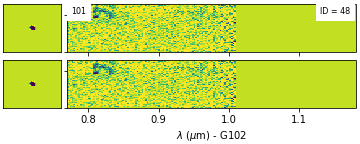

In [53]:
Image(filename='{0}_{1:05d}.stack.png'.format(root, id)) 

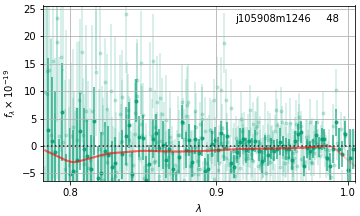

In [54]:
# 1D spectrum with polynomial model
Image(filename='{0}_{1:05d}.1D.png'.format(root, id)) 

### Redshift fit ###

The redshift fit is performed in the following steps:

* On a coarse redshift grid (dz/1+z ~ 0.005) fit continuum templates along with **line complex** templates for a) [OII]+[NeIII], b) [OIII]+Hbeta, and c) Halpha+[SII]+weaker red lines.  These line complexes have fixed line ratios but are useful for breaking redshift degeneracies as these lines do, usually, come in groups.  Leaving all line strengths free would allow for perfect degeneracy between, e.g., Halpha and [OII] (assuming no significant continuum features).

* Find peaks (minima) in the chi-squared on the coarse grid and zoom in on them now allowing for more freedom in the indifidual line strengths, as well as fitting on a fine redshift grid sufficient to resolve the best redshift.

**NB** Continuum templates are needed in the directory `${GRIZLI}/templates`.  The template names are currently hard-coded in [multifit.py](https://github.com/gbrammer/grizli/blob/master/grizli/multifit.py) and the easiest way to make them available is to symlink them from the `data/templates` directory that accompanies the `grizli` code distribution:


### Emission line maps ###

Once we've computed the full continuum + line model, we can create 2D *drizzled* maps at any desired output wavelength, for example to make emission line maps.  This makes use of the WCS information in the individual grism FLT exposures and the outputs can have any desired WCS (e.g., pixel scale & dimensions) and can be used to compare directly to imaging data.

The emission line maps are generated by subtracting the best-fit continuum model, assuming that the direct image is representative of the continuum morphology.  This should be a reasonable assumption for objects other than, perhaps, those with extreme line equivalent widths.


Run 48


(48, 1, 11.246497631072998)

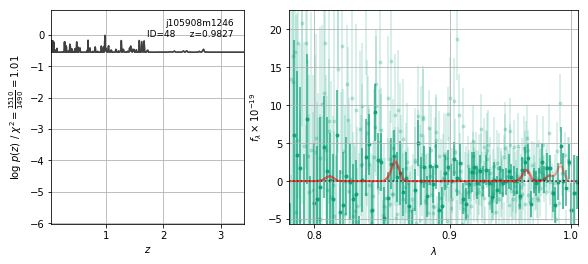

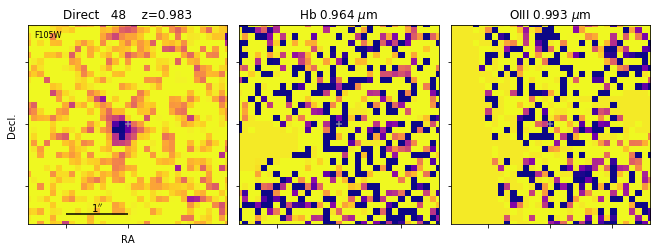

In [55]:
# Fit it.  The "run_all_parallel" function defaults to all of the parameters set in 'fit_args.npy'
fitting.run_all_parallel(id)

### Fit products ###

A number of files are produced that contain the results of the redshift fit.  The [`NewSpectrumFits.ipynb`](https://github.com/gbrammer/grizli/blob/master/examples/NewSpectrumFits.ipynb) notebook describes how to interact with these products in some greater detail.  

In [56]:
files = glob.glob('*{0:05d}*'.format(id))
for file in files:
    print(file)

j105908m1246_00048.full.png
j105908m1246_00048.1D.png
j105908m1246_00048.full.fits
j105908m1246_00048.stack.fits
j105908m1246_00048.beams.fits
j105908m1246_00048.log_par
j105908m1246_00048.stack.png
j105908m1246_00048.line.png
j105908m1246_00048.1D.fits


In [33]:
for file in files:
    if not file.endswith('.fits'):
        continue
        
    im = pyfits.open(file)
    print('\n\n{1}\n{0}\n{1}\n\n'.format(file, '='*len(file)))
    im.info()



j105908m1246_00004.full.fits


Filename: j105908m1246_00004.full.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      47   ()      
  1  ZFIT_STACK    1 BinTableHDU     77   458R x 6C   [D, D, 21D, 441D, D, D]   
  2  COVAR         1 ImageHDU       153   (41, 41)   float64   
  3  TEMPL         1 BinTableHDU    141   9823R x 3C   [D, D, D]   
  4  SEG           1 ImageHDU         8   (80, 80)   int32   
  5  DSCI        F105W ImageHDU        28   (80, 80)   float32   
  6  DWHT        F105W ImageHDU        28   (80, 80)   float32   
  7  LINE        Hb  ImageHDU        31   (80, 80)   float32   
  8  CONTINUUM   Hb  ImageHDU        31   (80, 80)   float32   
  9  CONTAM      Hb  ImageHDU        31   (80, 80)   float32   
 10  LINEWHT     Hb  ImageHDU        31   (80, 80)   float32   
 11  LINE        OIII-4363 ImageHDU        31   (80, 80)   float32   
 12  CONTINUUM   OIII-4363 ImageHDU        31   (80, 80)   float32   
 13  CONTAM 

### Continuum-dominated spectra ###

The object below is the dominated by strong Balmer break and absorption lines (see [van Dokkum & Brammer 2010](http://adsabs.harvard.edu/abs/2010ApJ...718L..73V)).  The redshift fit and spectral constraints are precise even without any supporting photometric data.

In [34]:
# Continuum source
id=source_ids[1]
auto_script.extract(field_root=root, ids=[id], MW_EBV=tabs[0].meta['MW_EBV'], 
                    pline=pline, run_fit=False, grp=grp, diff=True)

0/1: 2 4
j105908m1246_00002.beams.fits


True

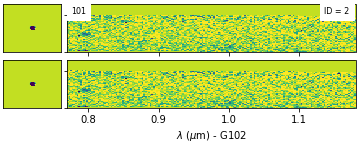

In [35]:
# Stacked 2D spectrum
Image(filename='{0}_{1:05d}.stack.png'.format(root, id)) 

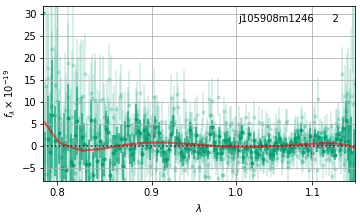

In [36]:
# 1D spectrum with polynomial model
Image(filename='{0}_{1:05d}.1D.png'.format(root, id)) 

Run 2


(2, 1, 16.108476877212524)

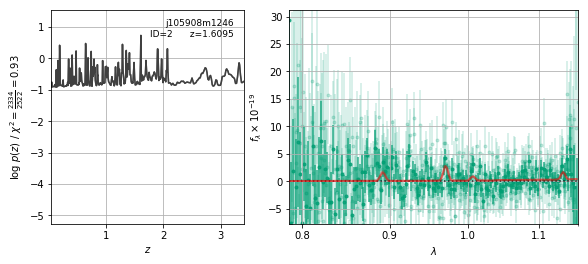

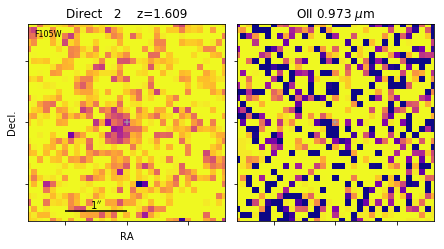

In [37]:
## Run the fit
fitting.run_all_parallel(id)

### Fit grism with photometry

Another option is fitting the grism spectra along with ancillary photometry, described here: [Fit-with-Photometry.ipynb](https://github.com/gbrammer/grizli/blob/master/examples/Fit-with-Photometry.ipynb).